# ECON 8320 - Tools for Data Analysis Semester Project

For the semester project, I built a web scraping tool that collects news article URLs related to the operations of the Wagner Private Military Company (PMC) in Africa. This tool extracts the relevant information from the articles and stores it in a text file, making it easy to read and analyze. This project allowed me to gain practical experience in web scraping and data collection, as well as learn more about the operations of Wagner in Africa.

### 1. Package installations rerquired to run this code on another machine

In [27]:
#!pip install requests
#!pip install json
#!pip install spacy
#!python3 -m spacy download en_core_web_sm
#!python3 -m spacy download en_core_web_md
#!python3 -m spacy download en_core_web_lg
#!pip install beautifulsoup4
#!pip install tqdm

### 2. Import the libraries needed

In [4]:
import requests # for making HTTP requests to web pages
import json # for handling JSON data
import time # for working with time
import spacy # for natural language processing (NLP) 
import re # for regular expression pattern matching
import os # for interacting with the operating system

from spacy import displacy # for visualizing NLP named entities
from datetime import datetime # for working with dates and times
from bs4 import BeautifulSoup # for parsing HTML docs
from tqdm.notebook import tqdm # for displaying progress bars for loop
from collections import Counter # for counting occurrences of elements in lists/dictionaries
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # for generating word clouds from text data
from IPython import display # for displaying images
from base64 import b64decode # for decoding base64 encoding
from PIL import Image

import pandas as pd # for work with dataframe and tables
import numpy as np # for numeric computations
import plotly.express as px # for creating interactive visualizations
import multiprocessing as mp # for parallel processing
import matplotlib.pyplot as plt # for creating static visualizations.
import matplotlib as mpl

### The code starts here. 
#### It would be best to run these block by block as one block is probably dependent on the subsequent block of code.

### 3. Helper Functions 

Before the main tool is used, some helper functions were implemented to ease its use.
1. `get_unix` - This function helps convert dates string to the UNIX format to be used as a parameter. The since parameter accepts only the UNIX format.

2. `format_date` - This function puts the Date Published in a better format easier to read and manipulate.

In [5]:
def get_unix(date_str):    
    # Check if the date is valid
    valid = re.search(r'^\d{4}-\d{2}-\d{2}$', date_str)
    if bool(valid) == True:  
    # Convert the date string to a Unix timestamp
        return int(time.mktime(time.strptime(date_str, '%Y-%m-%d')))
    else:
        try:
            # Check if date string matches expected format
            time.strptime(date_str, '%Y-%m-%d')
        except ValueError:
            print("Invalid date format. Please enter a date in YYYY-MM-DD format.")

In [6]:
def format_date(date_str):
    # Find date using regular expression to match the Bing News format
    match = re.match(r"^(\d{4})-(\d{2})-(\d{2})T(\d{2}):(\d{2}):(\d{2}).\d{7}Z$", date_str)
    year, month, day, hour, minute, second = match.groups()

    # Create datetime object
    dt = datetime(int(year), int(month), int(day), int(hour), int(minute), int(second))

    # Format datetime as to yyyy-mm-dd format 
    formatted_date = dt.strftime("%Y-%m-%d")
    return formatted_date

### 4. Creating the BingNewsAPI Class

Classes are used to create multiple instances of objects that have similar properties and methods. It is a blueprint for creating objects. In the case of the BingNewsAPI class, it allows you to define an object that can perform Bing News searches and retrieve the search results as a Pandas dataframe stored to a csv.

This can be reused for multiple searches with different search terms. It can also be modified if needed, with more functionalities and methods.

It is important to note that the search results are limited to a month's worth of information. The results are stored in a Pandas dataframe, which can be used for further analysis and processing.

In [7]:
# Use help(BingNewsAPI) to read on its use

class BingNewsAPI:
    """
    This class implements a Bing News API search. It allows you to retrieve
    news articles related to a particular topic and since a specified time
    period. Kindly note that this is limited to a month's worth of information. 
    The search results are stored in a Pandas dataframe.
    """

    def __init__(self, subscription_key=None):
        if not subscription_key:
            raise ValueError("subscription_key must be provided")
        self.subscription_key = subscription_key
        self.search_url = "https://api.bing.microsoft.com/v7.0/news/search"
        self.headers = {"Ocp-Apim-Subscription-Key": subscription_key}
        
    def search(self, search_term, since_date=None, total_to_take=5000):
        """
        Inputs: 
            search_term: A string representing the search term.
            since_date: A string representing the since date in the format YYYY-MM-DD. Defaults to None.
            total_to_take: An integer representing the total number of articles to take. Defaults to 5000.

        Outputs:
            A Pandas dataframe containing the search results. 
            Which is saved to acsv file with a filename detailing the search_term and date of the search.
        """
        if not search_term:
            raise ValueError("search_term must be provided")
        
        if total_to_take > 5000:
            print("Warning: Requested total exceeds 5000 results. This may cause the search to run slowly or return errors with API limit.")
  
        params = {
            "q": search_term,
            "textDecorations": False,
            "textFormat": "HTML",
            "count": 50,
            "mkt": "en-us",
            "sortBy": "Date",
        }

        if since_date is not None:
            since_date = get_unix(since_date)
            params["since"] = since_date

        response = requests.get(self.search_url, headers=self.headers, params=params)
        response.raise_for_status()
        search_results = response.json()

        # totalEstimatedMatches gives the number of matches found for the search term
        # If the total found is greater than 1000, then let's focus on 5000 (total_to_take). This is to limit the API calls
        if search_results["totalEstimatedMatches"] > 1000:
            total_to_take = total_to_take  # 5000 is 100 pages worth of info which shrinks down to about 500 distinct/ unique articles.
        else:
            total_to_take = search_results["totalEstimatedMatches"]

        if total_to_take > 50:
            num_pages = (total_to_take // 50 + (total_to_take % 50 > 0))  # After getting the whole number from the division by 50, do the division to get the remainder and it most certainly would be less than 50 so add one more page to the whole number
        else:
            num_pages = 1
        
        offset = 0
        params["offset"] = offset

        results = []
        urls_set = set()

        for page in tqdm(range(num_pages)):
            try:
                response = requests.get(self.search_url, headers=self.headers, params=params)
                response.raise_for_status()
                search_results = response.json()

                # Extract the results for the current page
                page_results = []
                for article in search_results["value"]:
                    result_data = {
                        "Title": article["name"],  # Title of article
                        'URL': article['url'], # URL of page
                        'Description': article['description'], # Brief description of the article
                        'Date Published': format_date(article['datePublished']) # Apply format_date function to date article is published 
                    }
                # Found that some articles have duplicates just posted by different provider so this checks if the article is already appended to the file
                    name = article['name']
                    if name not in urls_set:
                        urls_set.add(name)
                        page_results.append(result_data) # Add the article if it is not a duplicate

                # Add the unique results to the main file
                results.extend(page_results)

                # Increase the offset to get to the next page
                offset += 50
                params['offset'] = offset # put the new offset number

                # Sleep for a few seconds to avoid API limit
                time.sleep(10)
            
            except Exception as e:
                print(f"Error: {e}")

        # Store all the results in a pandas dataframe
        df = pd.DataFrame(results)
        return df

### 5. Get Subscription Key 

With the BingNewsAPI class, users can easily perform Bing News searches and obtain relevant news articles in a structured format. First, we need to get a subscription key. 

Vist https://learn.microsoft.com/en-us/bing/search-apis/bing-news-search/overview and follow the instructions in the images below.

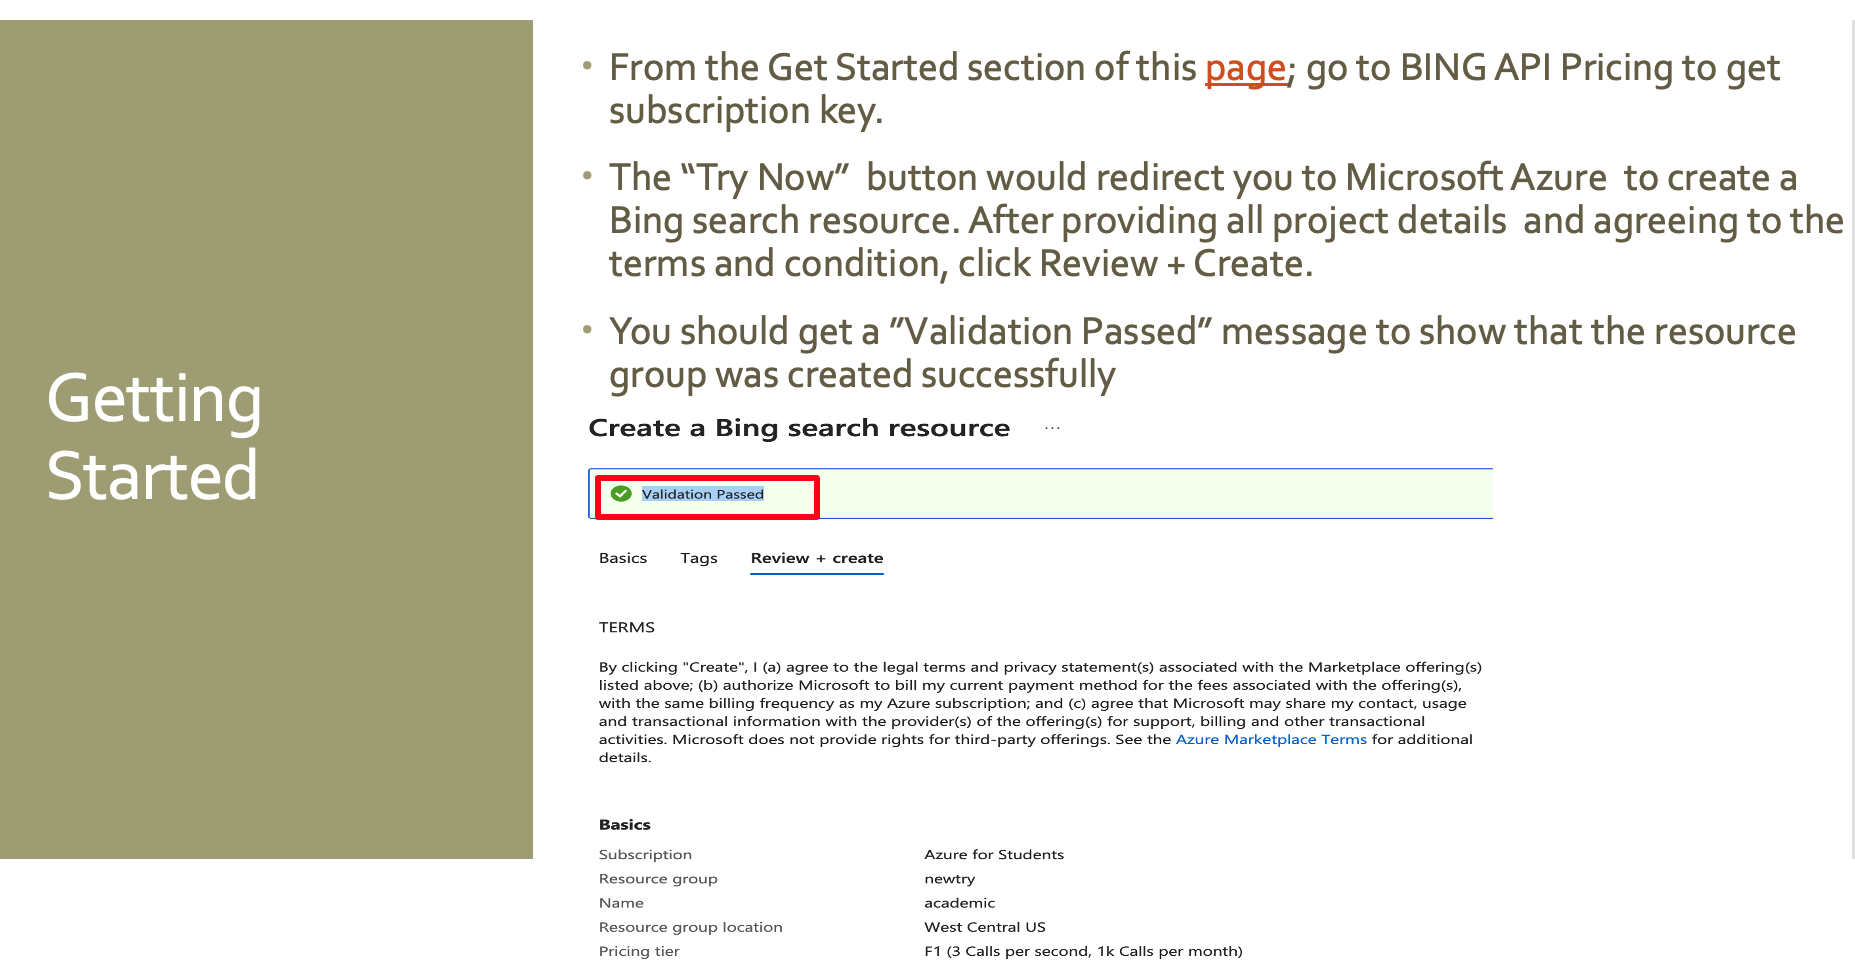

In [8]:
base64_data = "iVBORw0KGgoAAAANSUhEUgAABz8AAAPUCAYAAAAzD/SAAAABWGlDQ1BJQ0MgUHJvZmlsZQAAKJF1kT1IQmEUhh9LMSqiIIigwaEhy0K0iLbMIYII8Yd+lrheTQN/LtcbFe3R0NxaU2NT4BrR4B5UBC1FNTUFNpTcztVKLTpwOA8vL995OR+02BVNy9iBbM7Qw7MzrqXlFZfzGQdt2OjHq6gFLRAKzYuF79lc5StxSl2OWm897gy+xKI994cLb9Mj+dDiX39TtSeSBVXmh/SwqukG2IaEQ5uGZvGWcK8uoYT3LU7V+MjieI1Pq55oOChcEu5W00pC+EbYE2/QUw2czWyoXxms9J3JXCwis0t6gAg+JgnjZwJJ8I93vOoNkkdjG511UqQxcBEQRSNDUniOHCpjeIR9eKX91o1/366uZbMwFZNVe3VtdRdOLiReqa65H6DvCc7vNEVXfi5qK9sLa35fjTuK4DgwzVf5B6cbKtem+V40zcoxtN7CWfkTuAVjiQQKCjgAAABWZVhJZk1NACoAAAAIAAGHaQAEAAAAAQAAABoAAAAAAAOShgAHAAAAEgAAAESgAgAEAAAAAQAABz+gAwAEAAAAAQAAA9QAAAAAQVNDSUkAAABTY3JlZW5zaG90a10USwAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+OTgwPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE4NTU8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KX7xbeAAAQABJREFUeAHs3Qd8FEX7B/AnPYGEJKQnEELvNSAqUgRFBRR97agvYC/YETuIIiIqKKKIgGJB/oqvBZGiUgWkg/SSQAoJ6b2T8p9Z2L3dzV7fu+TCbz8fuC2zszPfvdvb3LMz41bHJsIEAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAwMUF3F28/Cg+BCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAUEAwU+8ESAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAgSYhgOBnkziNqAQEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIIDgJ94DEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIBAkxBA8LNJnEZUAgIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQQPAT7wEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQKBJCCD42SROIyoBAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQgg+In3AAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQg0CQEEPxsEqcRlYAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABBD8xHsAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhBoEgIIfjaJ04hKQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACCH7iPQABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCDQJAQQ/m8RpRCUgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEEP/EegAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEmoQAgp9N4jSiEhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAIKfeA9AAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAJNQgDBzyZxGlEJCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAwU+8ByAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAgSYhgOBnkziNqAQEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIOD55ZLJUIAABCAAAQhAAAJ2C0x84H2780AGEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAASsFUhOTpZ2QctPiQIzEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEICAKwsg+OnKZw9lhwAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEJAEEPyUKzEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAq4sgOCnK589lB0CEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEJAEEPyUKDADAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQi4sgCCn6589lB2CEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEBAEkDwU6LADAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQg4MoCCH668tlD2SEAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAUkAwU+JAjMQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgIArCyD46cpnD2WHAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQkAQQ/JQrMQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACriyA4Kcrnz2UHQIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQkAQQ/JQoMAMBCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCLiyAIKfrnz2UHYIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQEASQPBTosAMBCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCDgygIIfrry2UPZIQABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABSQDBT4kCMxCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAgCsLIPjpymcPZYcABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCQBBD8lCsxAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAKuLIDgpyufPZQdAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCQBBD8lCgwAwEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIuLIAgp+ufPZQdghAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAQBJA8FOiwAwEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIODKAgh+uvLZQ9khAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAFJAMFPiQIzEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEICAKwsg+OnKZw9lhwAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEJAEEPyUKzEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAq4sgOCnK589lB0CEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEJAEEPyUKDADAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAABCAAAQi4soCnKxceZYcABCAAAQhAAAIQgAAEIAABCEAAAq4oUFJaRBnpKZSZkU5UW0vN/QMoPDKaomPaumJ1UGYIQAACEIAABCAAAQg0GgEEPxvNqUBBIAABCEAAAhCAAARcRSA3O51mz3ieauvqhCLffPtEGjT4OlcpPsoJgSYrUFNTQ1OnTKSq81VCHQcNuY5uvm1ik60vKuaaAqcTjtJ3X82npKSEehVwc3OjRV+vq7dejxX47tJDEXlAAAIQgAAEIAABCLiCAIKfrnCWUEYIQAACEIAABCAAgUYlUF5WRrl5uVKZCgsM89LKJjTDWyeVFBZQaUkJuXu4k4+vD7UICiH/5i2aUC21q1JTc56ys85RSUkRBQQEUlBwGPn4+GonxtoGF6itraHMrAypHPl5OdI8ZiDQGARW/vQ1/fbLMqq7+PCMM8t0qX13OdMWx4IABFxH4FK+r3Wds4SSQgACELBfAMFP+w2RAwQgAAEIQAACELBLYP6c16m8rNS2PFgLkQcemUItQyNs2x97QUBDID3tDO3bs42OHdpHiYnHqbq6WiMVUTO/5hQX15569buCrrn+Vs00rriSt8pavfI7SmatsgoK8usFKfx8m1HLkBDq1qMfxQ8YQu079SDeWgsTBJqiQGpKAi34cLpUtRHX/YdGXHeLtIwZywXOsOupVuCTXz/8mwdQeUUpebi73s80eI9Y/h5ASgg4Q8Dk3xbseuPh6UG+Pn7UIrAlRUTGsPuZeIppbVl32/K8W7VpR3ffN0mzSvJ0nt7e9NATr9j00NyCj96gkuIi4RhRMW3o3olPax7P1MrGcF9bWJBDn8+fKRVzwBXDaNiIm6RlS2fkrlr7uLNz25x9n/j7BxI/P1269KbI6FitpPXWyfM2dW7r7ahaIc9HtUlYtKeMWvmZWufM7ydnHstUnbENAhAwCLjeXbWh7JiDAAQgAAEIQAACTULg0MHdVFNTa3NdCgryEPy0WQ87ygWSz5yk337+mg7s3yVfbXS+rLyUjh47SGfOJDSJ4GdmRiot++IjoU5GK802lFeUUVoa/5dKf677lSLZGH0z3ltqahdsg4DLChQXFVFWdqZU/pxcQ8taaSVmLBL4eskcxcMUrWJi6c77nqBOXXqQh4cXG/azls6fr7Qor8aUCO+RxnQ2UBYIENnyt0X79p1p5OjbhYe6TBnK8y4rKzGaVJ6OJ/p2yVx69KlpRtMb23D44F6qrLpwXSwqzDeWTHN9Y7qv3bxhNZ04cVgqZ072ORpy9Rhyd3eX1lkyo3a1ZJ+w0HC6Yew4uooNBeDu7mF0F3neps6t0QwubpDnYy6tuN3SMorpLX115veTM49laf2RDgKXugCCn5f6OwD1hwAEIAABCEAAApe4QDn74SY1OVFQ4K1veCs+a3+IcHVC/oP7LyuW0OpVK1yiKo44ZzzPee+/RpmZ56w24N0BG5scUVZjx9J7vSuXXW+LppIfzmnDnUnBPjVJKgBv6Tn59TmKllD8u8eHtcayZMK5tEQJaSCgj8Cl8HlLTDxBC+bNoOEjb6K77nnMZJDMFtU9u7fR1i3rhACcLftbs09ju6/l5dm2eY2iCnz4jEP7d1Dv+CsV6x2xkJ2TRV8v+ZC2rF9Fz7w0S/G944jj2ZKnK5TRlno15X0uheuis88fTPUXR/BTf1PkCAEIQAACEIAABOwS6NS5h8X78442g4JaWpweCesLbN70O/24fIm04bXpH1Ncu87SclOfqawsp08+nEZHDx+oV1V3dzeKYV2MRUa3psgo/i+W/TDvQ4VF+VRUmEdJ7IeyxFPHWZev1j21Xu9AVq7Q+5zxsfcWfvJ2vcBnYIsgGnjVcIqIiKGgwBBh3M+cnAzKYz8iJZ46QhkWBEr1LquVVHYld+Wy21XxJryzLefUQ9UqxcPJn/emcjrSz6YoqjLsmjF2/QBty7lUFEDHBbxHdMREVo1SoDF93mwBkv62YPc71dXnWQvzKnYfV8Du5wrqZbfhj5XCsAY33zax3jZ7V3z/zafUtWtPCgmLtjcro/s3xvtaHuTkwU71tGH9SruDn+pzW1FRTqUlxZrnNokN5/DB25PplenzycvLW10chy03ZBmd+f3kzGM57GRZkbGrXxetqKrTksJUf2oEP/U3RY4QgAAEIAABCEDAZoHWreNoymtzbN4fO0LAGgEe9FuyYJZm4LN7tz50538fo+gY02NA8TwqKyusOWyjS5t0+gTxbtXk03U33EJjb7ufvL195KsV83xsn907NlMh63oaEwSaqkBndi2Y+f6XrHp1QhUDg0KbalUdWq+09DOK/GNi4hTLrryA94grnz2UvakLmPrboog9zLZ96x+07rcVVFxyYVxN7rHu9x9p8NDrdA9SlrPA3KJP36Upr891SC8rjfW+duOG3zTfZkcP76fc7HSbnU2dW/6g3q5dG2nlj99QFQt2i1Mq64Hgb9YKdfg1Y8VVDn1t6DI68/vJmcdy6ElD5hBoQgIIfjahk4mqQAACEIAABCAAAQhAwBqB3376mvbt/UexS0REFN0x7hHq3c+ybrh4V8G+vpZ106g4UCNaOJ1wTFGanr370+3jHlOs01poHduB+D9MEGjqAuGs9TMm+wRKigsVGYSya21TmvAeaUpnE3W5VARatAim60fdSX37DaLprzwqBcnOs9ahB/bvpBEjb9GdIoHdc/2+chndePN9uufdGO9reXDzyKF9mnXlwdpNrCvaW+96WHO7PStbsnE++bnt1XsgLfhoOp07lyZlt3HdL04LfkoH1ZhxVhmd+f3kzGNpkGIVBCCgEnBu/1Sqg2MRAhCAAAQgAAEIQAACEGgYAf5E+OpV3ysOzrt5fXnqRxYHPhU7u/BC0pmTitJfPeImxTIWIAABCOgt4OWBZ9H1NkV+EICAbQIRka2oS5eeip3TWAtBvaZWMbHk4eEhZbfql++I97qh59RY72s3bVhFPMgpTrfd/QD5+TYTF2n7339RTU2NtKz3TDTrZWDUTeMU2WZmpTv0mIqDWbDgCmW0oBpIAgEINEIB3G03wpOCIkEAAhCAAAQgAAFbBWpqzlNmxoUne5s39yd594SpSafo8OE9lJOVSWWlRTT46jHUrUc/o4cqLMih5NOnKIntl3kuhVoEBlOrNh0pLq4jRbFxIN1V48CpMzJWFj7O0IE9WymFdRman5tDHp5eFBoeQT17X05xbTups6Ha2lo6dGAHnU48Tnm52cL2EPY0c7t2XahXvyvqpbdkRXbWOTbeUaWQNJd5yKe0tGTyZuNayif/gEDiT8dbMvFA2uGDu1g3VllUVVlGwS3DKIKNmXnZ5cPZeJm+lmQhpOE/lGQw96TTJykl6SQbmymfwljrq9jYdtS2Q1eWb7jFeWklXPnzN2zcp2rFpvsfnUL+LADqyMnWejnynJ1LS1JUmZ9veya9ylrCPqcnjh6gtJQzlJ+fK7yf+PiqgUHBwvnv0WsAG4811mRRjX0O+U5a14Sw8ChdPxu2nm9jleLXg2OH9tCJE4coPy9HuA61Zp+JNuy61IaN1ctbIus5JbPPc8LJI5SVlSZ8Bps1C6Cgli2pZUgEde8RT0HB5ruA1duA149fD/bt+ZuyM9PY+aoWxm8LYJ9d3oqid5+BiuuDHu/HjPQUqq2rFWhDQiMtupY56juktraGDrEWSadPHxfeA3VsOSw8mqJbt6G+8YMVP7Dr8V6wpx4lbDy9ouILY+rx7wT5lJaWQu6eyp9kWgQEmbwG63Eu5WWQz9v73WXNe0SPz5W87MI8u7eozDgtzLoHtCSvoAvfkZXpiVS09w+qPJtI1SUF5BMVR36x3civYz9hvl4+Gitq2DksObiZylOO0vncDKopLyVi12KvkHDyDommgH4jyLeV9WOF8/duRdIRKk/YR2WnjwjjZ7s38ye/Dn0ocOAodggPdqxiqs65cF/nGRxFHv6mv5/49aYy7QSVnWJ5Jh6i6vxs8o1qS35tu1OzTgPIK6zhWnHzz+7Z1NN0hgW9ziafFq7Xfs2aU1t278fv59xZfSvKyygv78JnJSg4hPg119xkz2fUVN6O+Lw5qqym6mHptjh2b3nwkGEIgJKL1y5L9zeVLiQsgvoNGEwrf1kmJOPBvsWfzqTX315o0feJqbzFbQ11XyseX+uV13P7lr+kTZ6eHnTV0Bso42wqbf37D2E9H3d1z87NNPDK4VI6vWd460/5VFtbR7lsDPvG1ErRkjJae08r/p1rzfeT6GTNfZa4D381dyxjddDz3sZR11pev6ZyXXSEka33+44w5ecK0wUB5Z02VCAAAQhAAAIQgAAEqKKihHUFuoayMpJZ908VLNAQRt27DmKBvx6NXmfH1vX05eILY4Z279mXnp3yLvFxCb/54iMWPFQ+Yd2hc0/N4Ce/Aec/SCSq0ssr38yvOd0zYRL7Q32EfLViXl6Wbl170XOvvE/b2B/6P373uWJcIXGnX//3LQ247Cp66InXpMBqwqnDtOTTWZTNWilqTXwcmXH/nUQdu/TS2qy5jv9h8srkCYqnsOUJv/z8ffmiMN+5cw96wcxYrGkpp2np4g/ozJlT9fbnK375YSmNvX0CDRk2SnO7fGVmRio7B7OM5sV/PLnxlnvphjF3S1by/c3NV7Axl3ZsN/wYw9OPvP5m6t6zv7ld7dpua70cdc7EyvCAg3xKSztD7diPgLZMepX1y4Wz6Z/t61nw39BaoF55li1kPxp3pHsnPk1tNB4c4Onln0NLrglzZ7+s22fD1vNdr54XV+zZtYm+/2YB5RfkayYJCwunBx55UXObtSvTUs/Qiv/7vN5YsOp84uI6CGOXGRsbVm8Dfn3+7uuPWRd6e42+N5a5zaf4/lfSo09NE86lvdc7fm2b9uqjUtVvvXOicO2RVqhmHPkdsnfHJlr+7adUUHghoKg6NEVGRtO48U+y77Z49Sarl/Wox6LP3mHnar/msRex8ZbVU6+e8fTUlHfUq4Vlva4t6sz1+O6y9D2i1+dKXQe+nLv5e0qZN03YFNC7L7V5/jNKWziF8rdtYeu0rqNuFDr6VooZP5Xcff2F/bT+S/5oEuVuWEtuF4P/WmmI3qfmHTtRq8dnUbP2fbSTqNaWnzlESe89QRVnz6q2XFj0jnibYp94h0qP7aBzyxcJK0OuHUOxT87TTM9XVqSdopQ5k6j0lPZ9CHvajKLGPUoRtz7DAqvO7QjubHICfc7uLdPTtesbxh7cuO+B5yiBPdgiBsiuGnIdTXjoeaP11eMzaixzvT9vjiyrsTpYu54/6CifWgS2lC/aNV9RXk5j2H3rgX3b2cOPZ4S8MjLP0fffLqD/PvCsXXnznRvqvtZcwfftYuPCs+CmOPXs1Z/8m7egQUNGSsFPvm0zax3qyOCnL3vIwMPDnbX2vPAQEz+ml5cXf2k0kyVltPaelgc/Lf1+EiH4Z9Wa+yxxP/5qybHkdRD/Ptbz3sYR11qxjk3luugII1vv9/U2Fc8VXg0CCH4aLDAHAQhAAAIQgAAE2BPnxfTrL3OprKxI0igtLaB09oPSZQNvZC19hkrrG+NMjezHubPJZ2jv7i20ZMFsaQwfc2X+Z+uf9N1X86mcBcdMTWWs1cOiBe/S4X930T0Tn9Ec81FeFh4Q/GHZp/TH2l9MZUu7d21lrRu/pP/c8QCdPHaAPnp/KlVWVRjdJzU1iebPfYOmzviUQsIijaZTb+B/aFgzmUt/5N89tPKnb+u1pJQfg//4wYPQIayliKkg48b1v9KKZYtMnrPq6hr6ecVXdPjALpr86vvsBw3rfsA4dmg3K6uhi63g4JZsvKGH5MXVfd7eepk7B+oCW5Ne3dph7W/fU89el1nUqk99XL5szbGNpU84dcRocEt+TP7ZeufNZ+iBhyfTgCvqtxqQfw4tuSboUXZePnvPt7yOfH7Z0nksz1Xq1YrlbNaybtYM4z+UKxKbWMhnrY7mzHpR8YOlseRJSQlUa6S7Or0Ndmz7i11D5pm8JvJy8nOYeOqoVGR7z2md7HtFzF/KXDXjyO+QH5cvpLWr/6c6onIxIyOdPv5gKk2buYAio0y3ilbuqVzSrR411n3X1GgG6Qxls/dcGnK6MKfXd5cl7xG9PlfqOkjLsvdp8b/76djjw6mmhLXQNDrVUc7vP1LR7s3U/rUl5Bun/YBb2dF9ZgKfFw5QeuoknXrhTmrz9NsUNPQ2o0flG7J+mkfnvv2Eatm4isamqswsOjX9YXKTX19MvJ9yVi+ms1++R3WVxvOkmmo69818Kt69gTq+/ROLfngbO7yu69eu/p5+Yfcs6t4m5AfhD7l99P4riuCM+n0lT6/bZ1SeqWper8+bM8qqKrrVi+XlJXTsyL+K/aJZLy96TbwFJG/ZO/GRF+jtaU9K96BbNq2hPn0vt7knF7F8DXFfKx7b1Csfz1M+XXnVtcIif2iTP7DF71v4dPLEYaHFoLnePITENvyXyh4+kAc+gy/2IGJDVg7bxZIyWntPywurvo6Y+lzbep8lolhyLHkd+D28nvc2jrjWinUTX035iWnkr8bSN9R10RFG9t7vGzOSO8rnrU0v3/dSnHfuo16XojDqDAEIQAACEICASwnsZS0+5YFPeeH37F7NthXKVzXqeR5sWzBvhmYQzZN1tadu7SYEShe+Vy/wGREeyX6YuExoYcb3k0//bN9Iiz6ZIV+lOc+DqfLAp4+3D2uZ04f6xV9BPH/5tJoFnpazH+c+fO816Ud+/rQyb33JWzPx1p7yqbSshBax1gTWTOp6mNvX09t0cPEE+9FC/qMe75qWl7Vjp27EW2mKE/9j5YvPZgvduonr5K9HD+9lQZ5PFOfMi3ULzFv3dWAtEVuoumM9deoY/bmO/YBp5XSQBWvlU+++V1gdQJXvb25ej3rpfc7kZe7QSfmjdyZrjTDrzadp65Z17MciEz8kyzORzetZVt6NK2/Nxt//vfsMqPd54Yfl772vlnxIWawLVFOTJdcEPcqux/mW1+Mv9h5XBz7d3d1YF9wdBJNw1p2entPnn8ysF/hs374zDbxiKPVnrdPbtetEvma6sNbbgHd//OWi96VrolhfXo64uPbsgYp+QpfY3hrBDD3OqXg8U6+O/g6RBz7556Jjx67CdbZNm3aKYp1nAaWvF89VrLNmQc96mPvuUJfL20xLHL3PpV7fXep6aC3r8bnSytfYOnng0zc6mgIvu4Kade5Kbj7K7/OqrGxK+fh5Cx5acSOeT4vuvSiw/2XkE1n/usODmcmfvk6V5y50v6tVtqI9aylt6Yf1Ap/eEREUOOBy1jUt7z73QvfdisCnVmYX1xXv30Cpn81UBD7d2b1D844dyb8Luw9p0UKxd8nxo5T122eKdfIFPtTAts1rpX+52enyzVbN87x+XL5EcY/EM+DXbX5v2Y5dW8XuyuXBGVMH0fMzauo4enzenFVWU/Uwt423tp3+8sOsi27D3zh+vn50xeBrzO1q8XbexSSfWsd2oFE33q3YbynrsaaoSLtHB0VCEwvOvq81URRpE+/+lF9jxSmQdU3fq98gcbFe7zkb1q+Utuk5U1lZwf62ULYYb9u+i56HsDsvW8poyT2tNQWz5z7LmuPI0/K/j/W6t3HEtVZeVnHela+LjjDS435fD1Px/OC1voDy16v627EGAhCAAAQgAAEIXFICWRlJRuvL/3DPzkpmY8v1MprG3g257Mn3P9f8aFE2fGy+PvGGP6JN7cR/EOfdKfVjAbn2ndi4T6oxlPg4nLw7WvnEWwM+/vQbJP8DuaysmBbPn6kYE+jfA7vZ0+L7qWv3vvLdjc5fNXgk3Xr3QxRwMZDHx/Bb+dNXtOrX5dI+6/8w/ADAuwG89/5n2Fh2hh8a+Y9yS5fMlX6sTEg4Tnx8RN6VlLmJ/8g2b+HPwliiPO2fa1cQ73JXnKa8Mpti2/IfHw2Tl5dlt808MDvhocmKLkjPsHHp5r33Ouvq98KPSvyPdT6GZ6euyq7xeJDtu68+NhyUzXXu0pMefPwlCg4OE9bzJ+eXfz2fNm34XUq3duUPNHTYaPJj44RZOmWkJyuS9mJjBDpq0qNejjxnvN4dWWCRB7fkXT3n5GTT0kUf0P9Yd4Ndu/ehriy4ZElrUL3KOmLkLeTp7c1+HL5CGG9Xfn7KWcB/I/uR7KcflkqrK9iPW3+s/lHoAldaaWLG2DWhd/yVdn029Djf8mJnZZ6lFRe7fBTXt4qJpQmPTCH5GMH8h9MfWPd5O/7ZJCaz6ZWPN5fAHioQJ/5j5dNTWPeTbLxj+cSvmccO7xPGLlaPEay3Ab+2LZj3lqLVBn+AZNTYu+j60XcpxrjkPyDyMYeLL/6Irdf7UV53rXlnfofwhwDuum8SG+czSirKzu0baPFn70rfCSfZOK38PWHpWM1iRnrX4/Fn3hTGY+X5r131f4rvuZemzqFWrduLhxZevTSC12ICR55Le767xPKZetXjc2Uqf2PbfKOiqNVjMyigz9VSkjr2XZu28EXKlvVEwbuJzVn7JYXdcL+UTpwJu2kiubFrcYsBN0jjiIrbatj3es7aLyiddUUtTrXllZT9yyfsuB+Iqwyv7LqRtuhNwzKb42VsO/VL8o0xjHlemZ5AaYtfo8I9uxRpNRdYnmcXTlVsatGzF8U++wl5hcYI64U6f/4SZa/5WUqX8eMiChk5XnMM0a+/+JCNM50npf3PHRNYwGqctGzpDL8W/h+7LsunyIgomvT8W4qW2ZkZZ1nvIAuI30+am/T+jBo7nh6fN2eV1VgdxPVaf1ucr66i8tISYUzxw0f2KXqa4HUfN34S+flZfl8pHsvYqxj85NvH3HwPHdjLu7+98JAAD7p+xR7uefL5t43tbna9M+9rzRbmYgJ1MPOyQVcrvq8HDble8Z2wc+sGuu3Oh8hYN/qWHleejnc1zu+N1ENydGRDnzSWSY8yGruntbSO9txnWXoMc+nsubdxxLVWq7yufF10hJEe9/t6mGqdK6wzCFj2K44hPeYgAAEIQAACEIBAkxaoufhksrFKVlaVGduky/oy9sP796ogpLGM+Y+VlgQ/eQvL8fc/Z7Jb2D/WrFCMq8nHXnp1+nzyZz/8yyceNH3yhZm09PP3aNtWw5iR/EerqW8vlJ7el+8jnx82fHS94Iw7G3fq5tsmsi50dxPvQlI+8T8EH3/mjXqtEgcNvZ6OHt5DO3dskZKnJiVaHICV/7DgxYII8snbx0+zG195Gq153hrs2Rdn1QtCtm3Xha4ddYsiUJXKxjtSBz/XrPqeeJeN4tSJBakns3FS+R9F4uTh4SH48e4DxR8JS0qLhUCYNT9MioERMd9QVetbcb34yv+4k3eTK66Xv/IWrlrd7+pVL0ecM7H8PODw5Atv02zWfax6PLLikiLatXOL8I+nj45uLbSyGzriRsWPt2Je/FWPsg4febM8S8U8D3Tz8+3HxnDiLYXFiT+1bslk6ppgb9n1Ot9iPf7euJoF/QxdNLdkD2W8zK5NPqqWlzzI9eDjr1CP3pexINhscXerX/nDCvLupEaNvbte4JNnyt8zvXhXfeyfetLbYOvmNezhjmLpMPxHvtfemk9R0fW7JOQu8QOGSGn5jL3nVJGZkQVnfYcMvHwIPfDYy0L3ifKi8Id79u/dSntY1+nilJGWbHXwU+968Gu2h4efUCR1kNzX29fq7xpHnEt7v7tEb1OvenyuTOWvta1Zpy7U4a3vycMvQLHZjXUT3+rxOSzoF0QZPy6Vtp375kMKHXkf8e3yKXT0Q/JFxbyHfyBF3PYsebB7I97yUpyK2QMIWlPGL/Op4lyGtMkvrg3rfvZn8lCNO+0T3YHavr5cGLM020xXz5k/f0wV6YZ7h4BuPajdjJ8V9w5CnVkwtionnQp37xSOz1vG8sAtL7+jpnWrVxDvSUGcWrVqQ5Nf+6Deg2oRka1o0nMzhAfA1K38xX3FV70/o2K+Wq/2ft6cWVat8ovrrPnbgj/4eMfdD2t2oy/mZ8srf9BRnHj3tw+wB5jemjZJahHM72l515FXjxgrJrPq1Zn3tZYUrKqqkngwUz4NvXq0fFF4gIf3EHPq5IVu6nlPNjv/WU+Dh45SpDO1UFFRRkmnT1Cz5v7MsooKCwrYv1z28EI27d+znU4nnqi3O78HHM4esHPW5OgymrqntbSO9t5nWXocY+nsvbdxxLXWWFld9broCCO97vftNTV2rrD+ggCCn3gnQAACEIAABCAAAZmAP/shq7g4V7ZGORsUaGhpotzSOJc6sRZtT09+WzMoJS/xFtWYNGP+c1+9wKeYngfjbmc/jPAfmcXxOPnYm4kJR6hDR2X3oeI+/HXw0OvqBT7l2+MHDlYEP3v0itcMfIr7DLj8amXwM/mUxcFPMQ+9Xjt06ELPvPiu0R+y4wcMVgQ/084m1Tv0zm3rpXX8B/PxDz2v+PFS2shmbrzlv1Lwk68/l5Yq32x2vqTYEEjhidVdIKszePPVRynNzDFCQ8No1txl6l3JmfWqd3ArVvBWw1NenUOrf/uOtmxcS7wlpdaUnp7KAqSp9Bdrncy7bR5723iKjmmrldTh6/iPhOtYN9E5uTnCsYqLDWMVGzu4pdcEY/ubW6/n+eY/lv4je8iCH/vOcY/WC3zKyxR/2RC7gp95edny7Og8+wHT2klPA37srRtWK4ow+ua7NQOfikROXnDGd8igq66hCQ+/YPS62KfflYrgZzrrclD9kIk5FmfUw1wZnLldj+8uS8qrx+fKkuPI00SPe75e4FO+PeKO51jrzxXSuKA1JSWsu9pE8m1lfXeQoaMepMyfPqeqrAvX4vOFBfJDSfP5G3+R5vlM5N3P1Qt8ign4vVbM/W+RueBnnixPNxZUav3UHKOfkci7JrPg5+3iIagi5aQ074iZHarr9823jq8X+BSPy+vLr+/mgp+u9Bl1pbKK54E/XJOakiiMwenDHgbUa5I/VMTzjGHDQ9x8+3ihS2TxGHy8+67d+hp9sExMp/XqzPtareOr1+3+ZyPxYKY48aErtMahvpx9r4nBT552y/rfrQp+8jFDZ7AxVC2d+HABTzwznf1daBiSw9J9bU3nyDLqdU/bkPdZetzbOOJaa+v5NrdfQ10XHWGk9/2+OTtst03A3bbdsBcEIAABCEAAAhBomgJdul5ptGJhoa0oNKy10e3O3mCqezyxLKPHjjMb+KysLKfcPEPAl4/BecWga8UsNF95i9BhI25QbEtnrWxMTQMuH2Zqs6ILQ56wD+t+U6sloZhJWJgyEF3MupNtqKlXv8uNBj55mYJbhiuKVnqxC1xxpdClcrahNUjbtp2It4QwNsW160z8BypxyskytPoQ15l6PX9eOY6l2CWvsX2qVem10mmlcXa9tMplzTr+vr7jnsdp9rxlrOXDg6yFZ1/i3YtqTfyHvL3sqfrZb02mc+mm3/ta+9uyTv3jIc8jIsLwPuEtDcxNllwTzOVhbLve5zsn+xwVyIIIvLvEeDPXEWNls3R9q1bKQPaGP36h1KRTlu7Oug5k3aPr+FnOZXllyFpO8VY5vKvbxjQ56ztk4KARRoM63CMkRHmdLWGttq2ZnFUPa8rk6LT2fndZWj57P1eWHkeRjgXTTE3uvv6spaey9VNl8glTu0jbtK7FPlGxhu1VVdK8OFPHHuaoysgUF1l3t5EUePkYaVlrps5MHerY9aZClmdzNl4obzVqbGrWMZ7cZWOYV2VoPzjFxxqXT95e2t+D8jTqef7wSlaW4b4mgl2/e5sZqqHO9CkjV/qMulJZ5ecuk52z1atWkPDQG+sy1ZHTdTfcQV26GoYSqWJdOC/+9B1Fbw+WHt9Z97WWlmfzhlWKpFddrd2ac+AVIxRjiPPuaa2551AcxMQCHyc9ng198vSUd9gDZPoFtU0c0upNtpRRj3vahr7PsvfexhHXWqtPnoU7NNR10RFGet/vW0iIZDYIoOWnDWjYBQIQgAAEIACBpisQ17YP9e+fS/v2/SH8iC3WNDy8NQ25+l7W1Z5jnx2Lioph3c0aurEUj6/16uFp/lZO3mWqVh583TnWik0+xbGxDy2pZ8dOPWmdbPyoTNbKxp4pgHVBZ83UPMD8+J7W5OfItLw7G94trLGuY7My0hTbEhKO0SvP3WeySPxHInHKkQVbxHWmXps1bya12uXpzp1NckhLMmfXy1SdrdnGu3ceOeoO4R/v8jeRjR94+NBeoWtmcYwqMT/eHemH775Er0z/mAKDQsXVurzyMYj+YN0hJ7IxbbMz0yi/IJ/4j9ItWrRgxwqhdqy7tCwrA9+WXBNsLbze5zs/V9kKM4qN9enoqXWb9kLAu/JiIDmPjXs3/fUniLeQ68LGNe7ctTd1ZC3c+XisWpPeBrk5hmAJP15rFpx1ZosNrTqq1zWW75BmzZXdm6rLaW65sdTDXDmdud3cd5elZbH3c2XpcaxN5xfXU7FLRVoCBSrWXFioKS6grJ8+orKT+6n83Fk6n5PPgoie5BkUyP6Fkn+3flTJxq00NVVlnKbaasODR827x5sM5pvKS9zGxwalmmpxkUqOH6UjD10hLWvN1FYZylBp5PvjzVlLqFqWr7eqm3GtfNXrslne1dWGsvF7Rnu/f1zpM9qYyqr1t0VdHQvGs+85PjZyypkE2sXGTT4i6zqfd1e86NOZbEiLz+p1M64+17Yu8/fDA49OoTdeflRqJZnEhrBY9cs3NPbWCVK2Hh787x3TD3c5675WKpSJmRTWE83p0ycVKWprq1lPFn8q1okL/Dor721kw18rafyDz4ubbX7lD0lGREazLoyH0aDB1wn3jTZn5qAd7S2jvdcUXq3Gfp9l7t7GEddaB53uBvvNwRFGet/vO8oc+RKZ/8UMShCAAAQgAAEIQOASE+jZewS17xBP2VnJVHm+goKDIoUWn25ujg18cmZPFtjw9WvmVPFzqhabYeHRFh0/LCJGkS5TNl6lYoODFsw0iHDQUe3J1niThrS0pHoZZ2Urgx71EshW8NZxfFxES4Mi/v4t2HhAeVIOaenJ1E9aqj/Dx2TNzc+qt+Gn779gDwnU1VsvrnB2vcTj6vnKWx/zrjP5v//c8QCdTjhKP/7fYjp54rB0GN5yetc/m+jaG26T1tk7s2nDb/TT/31BZeWliqx40Jt3c8v/JWqM5aRI7OQFvc93Tq7yPRceYdm1yZ5q87HIbhv3IMnHUuX5JbAANP+36tflQgC6e89+NHrsPdS2vbKLTL0NclUGEdGGlr721FPPfV31O0Rt0FTqoa6X/cvGv7sszdvez5Wlx7E2nU+E8oGKirTEellkr/mCzn09h2pKyxTbeBCRd3PL/5WdPK7YprVQnqJsVeodZv/1rDK5/nGrMi2/dzifV0h17AEf9Tin/OEOT9J+wEOrblrrMtKUD8S1DAnTSmbVOlf6jDamshr724KPH84fpGod24EGDb2edrIA6Befvye1vDx7Npm2bllHQ4Zpt1q06uQZScx7Rrl3wpO0kLX4FKfVrDv/+P5XUas2HYRVXl6sJXK5uFX71Vn3tdpHV67d+OdvyhVs6eslH9VbZ2zFrn820533PGbR34M8eHj/o5OpoqKS3FiPJIGBway3mTAKZkNR8Af5GsPU2MvoCvdZps6jI661po5nz7aGui46wkjv+317XLGvaQEEP037YCsEIAABCEAAApeoQLPmQdSmrXUtEV2VqrDA0OUtr0NAgGX15n9gKyfjQTBlOiypBbJZ9572TLwLvhrWSsPS4Cf/EZKP0ypO6j8KxfXi64ArrhZnFa9/rf6foltSxUa24Ox6qY/viOV2HbrRsy/Oovlzp9KRQ/ukQ5xOPCbN2ztz9PBeFnybT1pdK9qbtyP3d/T59vC078d4S+vOx1LlQe/ff/5G0SW4uP951nrrwP6dwr9x45+g4deMFTfp/p4vKjQ8pMAP0jIkQjpWY5lpKt8hTaUejeV9oS6HPZ8rdV56LdfUVCmy8lB1c168fwOdXfA2S2P//Q1v+amY3Owfc68yM1mRpfULdaw1Kr93YMElnafMzLOKHN087A+iu9Jn1JXKKp6ogVcOp2NH9gsBT3FdEnvIypHBT34cfo/574GdtIMFX/nEH+ZbsnA2vfbWAuG+1svL/E/XzrqvFQpo4r+K8jLavWOTiRTmN1VWVdD2v/+g4SNvNpuYt+zsf9kws+kaMkFjL6Mr3GeZOn+OuNaaOp492xrquugII0f/zWOPM/ZVCpj/BlGmxxIEIAABCEAAAhCAQBMTUI9HWViQY1EN8/KVXVJe6JbKol2RSCWgDjh36tSdBg27QZXK9KIlY8CKOfCuO/89sFtcFFox8nFY9B4HyNn1kirk4BluPfY//1UEP/kPhHpMfFyaJQveVQQ+WwQEsjF2x1AcGwvWy8eHilhL39zcDEpKPM5+qPyXyivMNInQo2AW5KH3+VYHf72MdDVrQdGsTsJ/7L1qyHV0iP0ge4R1eXzy+EHirWDU0/998ynFxXUkHhTnk94GfBxa+VTKullubFNT+Q5pKvVobO8PeXls/VzJ89BzvkZ9v8NafosTH6MzaQ7vetIQ+PRkXY6Hjb6T/Nr3Yd3e+lI1278yO5XKT+2non/3Um15hbh7vVd3L1/FOg9/rQ52FUnMLniyVnvyKaBbD2o58k75KrPzvB6OmDxVgWQ9WqG50mfUlcoqP/99+12hCH5mnFMOjSFPq+f8PRMmUcKJg0KvFjxf/oCe2P2tlwVjzjrrvtZcnbdv+1PRha259Ma2b9n4u0XBT2P7Y73lAq5wn2WqNo641po6nj3bGuq66Agjve/37XHFvqYFEPw07YOtEIAABCAAAQhAoMkLRMW0VtQxK8uyVojZ59IU+0VGNb7uGBUFbMQLrdg4fvIpPLIVG59npHyVrvPdew4gWr5YypN3gfvj8kV0z4SnpHV6zDi7XnqU2dI8Ylk3cfIpL9+yhwbk+2jN8y6hCosKpE1BgUFszK2F1KJeS+sLST79cCrt27tDSt+QM3qf75hWbRTVyc1WdoOr2OiABd5VZ+9+Vwr/ePZFhfm0ZdPvtG7VCingzLt9/nffdin4qbdBbOt2iprxMYYa29RUvkOaSj0a2/tDXR5bPlfqPPRarkxXtsb0DDV0RVtx9hhVFxZKh/JsGUhdPlxHXkHh0jr5zJmZ91HBjm3yVYp5rzDlPVIVC5raO/m26a7IwjsmjloOv0exrqEWQll3pvIpLydDvmjTvCt9Rl2prPKT4eauHOKjVjb2qzyd3vN+fv5s/M+XaPbMF6SHv3j3t337DyJP3u2tmclZ97VmikFb1q9SJLn9rgeEOihWaixUsx4lZrz+JPGhDfjEH7ZKOHWYOrAxxjE5VsAV7rNMCTjiWmvqePZsa6jroiOM9L7ft8cV+5oWUH6rmU6LrRCAAAQgAAEIQAACTVAgMiqW3GQDaCaePELVVcqu4LSqffiwoctPvj0yWhmo0NoH67QFYtgPlvJzkJp8SjuhTmtjWrelDh26KHLbtOF34YcWxUo7F5xdLzuLa9XuqanKH80jI5Vj4FqVmSxx0mllC9Kh14wxGviU7dYoZvU+31Gqawofb7UhJx6AHjP2Xnp68gxFMVKTDOMEOsJAfm04cewg8VbajWlqKt8hTaUejem9YUlZLPlcWZKPLWnKzxjGbub7e8uCn2Unlfc4YdffbTTwacmxfcKVD5qVHjb0vmDJ/lpp/Frz73FDd7Llpxv2GikvY0iosovuk8eV1vK0ls670mfUlcoq9z98eI98kULDIhXLjlzo2KUX3TD6NukQvPvbLxe+Z9GQDs66r5UKpzGTePKooocIP18/GnbNTRQe0crsv+iYthR/2WBFrpv+XKlYxoJjBPi9ZmO/zzJVc0dca00dz55tDXVddISR3vf79rhiX9MCCH6a9sFWCEAAAhCAAAQg0OQFvFnXZKFsDEhxyi/Ip7/++llc1HzNZq1Dt2/9U7EtNra9YtlVF6oaILDgybrzDA83/MCUnHyatv29zqGEN906XpE/72KU/8iUmWF/axQxY2fVqyHO2b49W8RqCq9x7ZTBZMVG2YK5spaVlchSE/HWEI1lMld2vc+3L/vhMDi4pVT99PRUoZWltEJjpoaNX+foqUPnnuTn20w6TL5s3GS9DdT58VbBa1d9Lx3b3hlz59SS/JvKd4ir10OPc2nJ+XZUGlOfK0ccs/z0QcrfZriO17m5U0CvIdKhakoNrT75So/mAdI2W2a8I+NYV7mGFmylp05R0R77vufdWJe1vlGGIGNZ4mnK27DMluLpvk9oRBR5sy7ixenMmVN0mHUjbs/UmD6j5j5vjamslprz4N3WjWsVycUu3RUrHbgw9rb7qU2bdtIRePe3SbIHjKQNGjPOuK/VOKy0auN6ZbCy/8ChVg0nMWz4jVJefGbv7m1UWlykWIcF/QUcfZ+lf4mVOTriWqs8guVLjfW66Agj9fvGUX+7mzO1/OxcuikR/Lx0zz1qDgEIQAACEIAABCSBa28wPGnNV65d+QOlpZ6RtstnKisr6NulHxF/IlucuvfsSzGxhh8rxPWu8OqtGu/q1KkjDVLsLt36Ko67/KtPKC1F2bpQkcDOhW494mng5YYfenl2mZnnaOpLD9P3335C5aognK2Hc0S99D5nu//ZSCeOHrC4ihvX/0prVv2oSN9W1ZJW3GhtWaNiYsVdhddTbKxJY9PO7RvoEBtnzlGTtWXn5dD7fHdmLUHk088/fEHFxcqghLj9POsu7ouF74qLDnvln8vyijIp/6ho5TnT26B3/BXSsfjMH6v/ZzYIrNhBtmDLOZXtbnS2qXyHuFI9HHUujZ5kB28w97my9vC5676mmlLtwEFdbQ2lLHiZZVknZRvYL568QqKlZb9WnaR5PlN6eIdiWb6Qv2kFC2Tukq+qN+/u609BV16tWJ+6cBrVGHngqo6NOZr90zxFeq2FgN6XK1anLpxBFUn2tbJc8NEb9PKz90r/ks+cVBzDkgU+hnj8gEGKpMu++piqqioV68QFPt712t/NP9jRUJ9RWz5vDVVW0dTSV96bwOrfvqMP33tZ6naV7xvg34KusnL8eUuPaSydh4cHPfT4K4rAubG06vXOuq9VH5cvl7Brzd5dfys2DWVjtVszte/UjaKjDS3Ez7OucLduWWNNFkhro4Ce91k2FsHm3Rx1rbWkQK5yXXSUkd73+9zcFlNLztWlnAbBz0v57KPuEIAABCAAAQhA4KLAsGtuVPzBXVJaTDPfeIq2bV6r6AI3hXXH+s60SXTkkKE7OA8Pd7rr3sdd1jJG1bXm2t9W0KEDyh85jf1Yp2elb7/7YdYCN1TKsoIFmd+c+jgt/fx91hrzrLRenOE/tPDg19JFHxA/L7ZMEx+aQnFxyrEreVD7z3W/0svPjafvv1tAmzf8JgQG8/OzhUPwAFNudroQfKmyoHtkR9RL73O2+rfl9N47U4Qfer9eMpe5rheC/zzQz6fy8hLKOJdCPOg5a/rTtGzpJ8J68T/eOrFf/FXiouLV2rK2Vj1EsHfPdvp95TLFwwb8fPMfpxctmEX8xzFHTdaWnZdD7/N9+7iHFa0sz6al0MypTxDvApe3Vhano6wb7lnTn2Ljn/4jrrLplQebv1r8gXANqKlR2vLPxr5dm2nOuy8p8m7XsZtiWW+D/9x6P0WyVlTiVMmCBx/PfYO9D+dReloS8aCBOPHrAm81zq8LJbKxY8XttpxTcV9Tr03lO8SV6uGoc2nqPNu6TY/PlbXHzt++hY4/fQ0V7lpNtRWGFvW8xefJ50ZS2YljiizDxzygWPaNUz54kf/P35SxYg7Vya4LPK+kWRMoac6LVGvBtTh0lPIYVZlZdPLZ66jk4Cbp2Dz/spN7KPHlsZS+bIG03thM1MTp5B1uuHeoLa+ko8/eQinznqTK9IR6u9UUFxAP1qZ8/BTx8quniopyOrB/J2XnZEn/WgQFq5NZtHz1tTcr0vE8Z7z+GB07sl9az6+rZxKP03tvP0e//u8bab2xmYb6jNryeWuosqrtsrMy6Ldfvpb+/bziC1r+zXz2sNBsdj4ep6cfvZV++mGpNJa1uP9t7PuXt2B19hTJHii6bdxDNh3WGfe1WgXbtmmN4n4slt3LxbVVPkChtZ963WBVsHnLxtXqJFh2gICe91kOKJ7ZLB1xrTV7UJbAla6LjjDS+36fm9tiasm5upTTeF7KlUfdIQABCEAAAhCAAAQuCLi7e9Cd9z7Gnvp+VQoo8B/Yv1w8h77+8iPyZU/w86lUozXgcBY4VY/NdyFX1/i/dVx7Vj9f4sFGPvEWXR99MJUCWwSRf0AAFRYUsDH2KuiTJSuJOzlq8vVrRg88+hLNnvmCdA5qampp699/CP+8PL0ogJXHi3UjV1payp4yL5aK0q5jV4pt01FatnSGd9nz/Muzacln7wo/dsr34/n/ucZ098fy9MbmHVEvR50z4cde9gPWFvZPnPg4QPIgm7hefOXvnaefn2F0XE5ryxoYFEq9+wygfw8YxoP7ecVX9NeaX9i59xACXQWFBeLhHfpqbdl5YfQ+39zj5tvHsx9qDUEAfp5mTn+GBUX9WJdyPuz8EPHuYPWYEhKO0N+b1wn/+GcuKDiYAloE03l2Pcxlxy0rN7T45McLCgyiAQOVLaj1NuCf0wmPvEDvvvW84r24cf0qFpBfJbSQadkyhMrKyqi4pEhKM3zkTeTPrmPyyZZzKt/f2HxT+Q5xpXo46lwaO8f2rNfjc2XL8auycuj0jElsVzfWba0fufv50vmcvHpZhY29iwLiRyrWe4VEUuCAgVS429BV6zkWMMr+9StyY93X8taj1XnardAVGQWk5cIAAEAASURBVMkWmncZQOE3j6OsX76T1lacPUunXrufPFsGErEONWrZNaa2SvnghZRYY8bDL4Dinp1DJ18ez7ZeeCDEjQUUc//6Xfjnzq5jHkEBxF+rS0qopqRUyqV5l3jya6cM8h4/sk/xsE0cu0cKDg6T9rFmpl2HrnTtDbco7iXS08/SB7NeFK6d/NpdzupbxR6qsnRqqM+oLZ+3hiqr2pLf3/76v2/Vq00u383+Jhg0WPmZMLmDzhuHXzOWDu/bQQcPWde7hTPua7Wq+rcqSDl4+A1aycyuGzT0OhaI/lIKpPIeWfjDXd169DO7LxLYLqDnfZbtpbB9T0dcay0pjStdFx1hpPf9Pje3xdSSc3Upp0HLz0v57KPuEIAABCAAAQhAQCbQvWd/euHld6mlbIw9vpk/lc+DnurAp6enB91+1wN0xz2u2+qT169ZswC65Y6JfFYx8WBKWlqqEGR0ZOs6+UE7si4+JzzwLLUIYD+CqiZehrz8PMpkT/DLA5+qZFYv+jXzp0nPvUX8hy4eyHHEpHe9nHnOTAU+uddjT75GrdooW8/KDW0p63/Ze8BfNb5ccUmhcP7VgU/151V+bHvnbSk7P6be53s4az10Nes+jgei5VM5a6HEPeSBz+bs/az1+ZHvZ+k8/8xlZ2fR6cQTxMcdUwc+fViLmEks8M0DtOpJb4MOHXvQI5NepmCNFlg8cJDBfiAtYt0Bm3q/8jLaek7V9dNabirfIa5SD0eeS63zq9c6ez5XtpehjnWBW6YZ+Awecg3FTHxLM+vWj88lD//mim3VRcVCPurAp1doS0U6YwvRE96k4MHK7m95Wp5fdWGhIvDJg7WWTM27X0WxT71Bni1a1EvOW6TygG9lRqYi8Fkv4cUVh/41PHjDV/Xqq+x229h+xtbfftcjdJnqARGeVrx2ywOf/IEWS6aG+Iza+nlriLJaYmgsTecuPemlqXNoxHW3GEvitPUTHpnCut6tfz9srgDOuK+Vl+EYe2CAfweLkw8bTuOKK68VF6165e+zfgOuVOyzef1KxTIWHCOg132WY0pnPldHXGvNHdXVrouOMNL7ft9WU3Pn6lLejuDnpXz2UXcIQAACEIAABBqFgLeX4ccte7uX8mOt0OSTj7dlPySJ+3Tq2ofemLWIBl4xVNHVpLidv/Jubtu160SvTptH142+s15AQkxrbVm8fdVlVy6L+Yqvnh7eQlnEZfX+4npLXnlw5Z4JTwjjG1mS3ou1NpMHYixx5j+GiJOp8zxo6PU0c87XNGbs3UKLVHEfrVdehrZtO7JWn8aDb1r7aa3jP3S9M/dbunfCJOrStZfF4y3xIB1vqXjrXaa7KNO7XtaeM606i+sefep1uva6sRQVGSOuMvnapk07mvjwZHr3o+XUvfdlJtPyjdaWlQfTps5YwLrSVY7lJj8Qb43zAmu1O/6hydJqrfeVtZ9DKbOLM9aWXdxfz/PN3+f3THiKXp46l2JiDONhiccSX/mPtq+++TG7Lt0mrrK6y7727buyLsBbSftrzXiz1tdDrx5F02Z+Rqa6tdPTgJej/2XDaMb7S2nkqP+Y/Hxyr86de1CQRlCW52PtObXmeteQ3yFerIUsr7s4ya+54jpLX/Wsh3hM+fcELyd3tXdy5LkUyyZ31LrG8HTm3iN6fq7Ecpl7bfvKxxRyLR9zz/CekO/jGxNDcc+9S3GTPyc3I7068NafXT9aQ0GXD5Lvqpj369CeOr79JbWZ9K603s1EV6Fu7u4U98ISavv8bPKJjJD2Uc+06BMvHFu93thyyDX3UfdFf1PUHQ+wFq7m3ltu1LxjJ/Jr27Nedrzlp3yKHzBYvmj1vDur78OTXqNHHn+JIsIjje7frQe7/5xpaOFvNOHFDY74jJo7prWfNzG/hiir/G8LsRziK7/+8M81f1AoLCxcuOfj90Avvvo+vfDqB8SDQKYmed7Grgl8f0vTGTtWi8BgmvDgs4rN3lZcNx19XysW7LhqzPj+AwcLvWCI2619HTb8RsUuCSePKpbtdVVkplrQK2+98lEVj2y5pzX3/SQ/hr33WZYcy9o6WHpv46hrrdxHa96VrouOMtL7ft9WU63zg3XsLvCLxc9f6BcDGhCAAAQgAAEIQMAOgYkPvG/H3ti1sQpkZZ6l1DMJVFzGulhl/ZPFte1MMa3bCl2vNtYy21OuCtb9WvKZk5SWnixkU1FeyrozDaE2bOye1nHWdytrT1n4vrWsW72c7AzKzkijzOxz7Id91jqEdYfHfxAKCgqhGBaE829ev6WHvcfl+/MWv8lnTrDxPTOppKyIystK2Y9lfnS+por8/JpTaMtwCo9qTWHhhrEILT2unvXS+5wVs9Zz6aln2FP8Z6m8tIS8WUuUmvPnqWVoOIWERAivLVg3qLZMtpSVfwbTWavDvIJcoRz+7MfKtu06Ex8Ty5mTLWUXy6fn+eZ55rHuZ8+mnhY+GzxvPxaAb9++i64m2VnnKImNQ5eXl0V8DDxPLy/h/IeFRVN0q1jiLUusmfQ24ON8Zmel07m0ZKE7Xp4/D6pERERTHAvgBmi0HleX155zqs7L2HJT+Q5p7PVwxrk0do6tWa/350p+7Nw/v2LjWE6XVnWYvpgC+g5n3cgWU8WZQ1R6+hCRpyd5sECnL+vqtVkH67qRrExPpPLko6yFZgbVVVeRB/seaNYxnnxbdZaOacsMH3ezPGEf1bLvGd6Vrl+bLiwo2Yc8AoLofEEWHf6v4SGYkOGjKfaZj80ehudTlZlMVecSqfJcEvvlz43lX0FegeHkxb7H/OJ6C/mrM+Ljeb/43ARpNQ+MvTPnW2lZjxk+ZnUSu8+qrq5m46fWsutpnNDNH7+XKSrMp+cm3SkdZtDga9mDRi9Iy6ZmnPkZtffz5syymjK71LY58r72UrO8FOqrx31WQzo56lprrE6ueF10hJGe9/v2mho7V5fC+uTkC7/l8Loi+HkpnHHUEQIQgAAEIOAEAQQ/nYCMQ0AAAhCAAAQgAAEI1BMwFvysl9CFVpQc2kynXp0olTj8lnGsi94Z0rLeMxvX/0rLln4iZctbA9557xPSsqNnTrAWdO+9M0U6zHVsvNDbxz0mLWMGAhCAAATsF8C11rwhjMwbNeYU8uAnur1tzGcKZYMABCAAAQhAAAIQgAAEIAABCEAAAhC45ATKk48r6uwXV7+bWkUCOxeOHtyjyKFv/FWKZUcvnD17RnGI1m2c3+OGogBYgAAEINAEBXCtNX9SYWTeyFVSeLpKQVFOCEAAAhCAAAQgAAEIQAACEIAABCAAAQiIAvtvaifOKl4Tpj2oWG4KC8lzXyb+z1HTicheUtYB/i2oQ2fHBlulg7GZqqpK2vDHL/JVbKiFToplLEAAAhCAgH0CuNaa94OReSNXSoGWn650tlBWCEAAAhCAAAQgAAEIQAACEIAABCAAAQjoLFDGxj0Xp559LiN3No6wM6Y6Nqb8998uoMzMc9LhfLx9KTyylbSMGQhAAAIQsE8A11rzfjAyb+RqKdDy09XOGMoLAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEHCfSLv9LunPPzsui3n5dR774DqUv3vuTj46fIk//IfOzIPvpx+SJKSTmt2Hbrnfc7LfiqODAWIAABCLiYAK615k8YjMwbNdUUCH421TOLekEAAhCAAAQgAAEIQAACEIAABCAAgSYs0HflhaBZ7p9fUcrH06Wadpi+mAL6DpeWG8NM8eG/KeGV8UJR6jw8yC8igrxbhlGduxudz8miqqxsqq0+X6+owVcOobiXltZbr+eKmdMmEZ0+KWTp7eVN3XoNsDv7bNaSc8umNcI/Dw93CguLpKDgUOLtSfPycyg3J5vOa9Q3vv+VNHzkzXYfHxlAAAIQuBQEcK01f5ZhZN6oqaZA8LOpnlnUCwIQgAAEIAABCEAAAhCAAAQgAAEIQKDRCbjV1FBFerrwz1ThWvTrT62fnGcqiS7beva9jCIiY4S8ImNiydvbR5d8xUxqamopIyNd+Ceu03rt0SueJjw8WWsT1kEAAhCAgBkBXGvNALHNMDJv1JRSIPjZlM4m6gIBCEAAAhCAAAQgAAEIQAACEIAABC4xATdPL2WNvVTLyq0NsuQd0pqadepCZSePmz1+i569KOqel6hZt8vNptUjwY03/1ePbBR5BIeEU/v2nSkx8YRivdZC5y496ZY7JlKHjj20NmMdBCAAAQgYEcC11giMbDWMZBiX2KzbF4ufr7vE6ozqQgACEIAABCDgAIGJD7zvgFyRJQQgAAEIQAACEIAABEwL1NXWUnVRrpTIKyhMmm9sM+ezUqk08V+qzs+g83kZVFNcQB7+geQdFUfekXHkG9mOvEIvtMJsbGW3pTx5OZmUkpxA+QU5VJifRyXFRdTcP4DCw6MpLDyKwiKjKTi48Z4vW+qMfSAAAQg4WwDXWvPiMDJv1BRSJCcnS9VAy0+JAjMQgAAEIAABCEAAAhCAAAQgAAEIQAACribg5u5OjTngKff0Cm9NQezfpTK1DI0g/g8TBCAAAQg4TgDXWvO2MDJv1NRS8HHGMUEAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhBweQEEP13+FKICEIAABCAAAQhAAAIQgAAEIAABCEAAAhCAAAQgAAEIQAACEIAAF0DwE+8DCEAAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCECgSQhgzM8mcRpRCQhAAAIQgAAEIKCfQG52Os2e8TzV1tUJmd58+0QaNPg6/Q6AnCCgswDeszqDIjsIQAACEIAABCAAAQhAAAIQgIALCyD46cInD0WHAAQgAAEIQAACjhAoLyuj3LxcKevCAsO8tBIzEGhEAnjPNqKTgaJAAAIQgAAEIAABCEAAAhCAAAQaWADBzwY+ATg8BCAAAQhAAAIQgEDjF0hNSaAFH06XCjriuv/QiOtukZYb24yrlbex+aE8EIAABCAAAQhAAAIQgAAEIAABCLiuAIKfrnvuUHIIQAACEIAABCAAAScJFBcVUVZ2pnS0nNwMab4xzrhaeRujIcoEAQhAAAIQgAAEIAABCEAAAhCAgGsKIPjpmucNpYYABCAAAQhAAAIQuEQEystKKDU5Uaitm5sbte/Ug9zd3S+R2qOaEIAABCAAAQhAAAIQgAAEIAABCEDAOgEEP63zQmoIQAACEIAABCAAgUtQwEMVbPRwc17wcfOm3+nH5Usk9demf0xx7TpLy1ozDVlerfJgHQQgAAEIQAACEIAABCAAAQhAAAIQcJYAgp/OksZxIAABCEAAAhCAAARcVqBztz408/0vWfnrhDoEBoU26rq4WnkbNSYKBwEIQAACEIAABCAAAQhAAAIQgIBLCSD46VKnC4WFAAQgAAEIQAACEGgogfCImIY6tE3HdbXy2lRJ7AQBCEAAAhCAAAQgAAEIQAACEIAABFQCzuuvS3VgLEIAAhCAAAQgAAEIQAACEIAABCAAAQhAAAIQgAAEIAABCEAAAhDQUwAtP/XURF4QgAAEIAABCEDADoHkMycp4eQRyspKo6LCfGrWLICCWrakliER1L1HPAUF1+9qtby8hPLzcoSjenp6UnhEK5MlqKk5T5kZaVKaqOg25ObmJi2bmsnPy6KkxOOUlJRA2Znp5OvXnELDI6hv/CDi+Vg62VJPY3lzp317/mblSaPz56vZvyoKaBFELUPDqXefgRTcMlyxq7z+zZv7k7z72tSkU3T48B7KycqkstIiGnz1GOrWo5+0f0Z6CtXW1QrLIaGR5OPjK23jM/K8/f0DqUVgsLA9K/MsHTywizLSU6m8rJjCWAvS1q3aUiwbtzMsPEqRh7iQnXWO1aVSWMxl5ZFPaWnJ5O3jI19F/gHseC0uHE/cYK68Yjr5a2FBDiWfPsXO8SnKPJci1KFVm44UF9eRomLakLtq7FP5vuK83EFuXFtbQ4f276TTp48L79k6thwWHk3Rrduw99Bg8vDwELNw+GtpcREVFuVJx+H1ioyKlZbFmbq6OspgDkmnT1JK0knhc8nPX2xsO2rboWu995e4X3FxIRUX5YuLFB0TJ82bm+HHq6298D7za9acgoPDzO2C7RCAAAQgAAEIQAACEIAABCAAAQjIBBD8lGFgFgIQgAAEIAABCDSEQFrqGVrxf5/T4YN7TR4+Lq4DTXl9Lnl7GwJfP33/BW1cv0ra7+OFP5FfM39pWT2zY/tG+vLz96XVz06ZSd179peWtWaqq87T999+Qn/9sZJ4MEg9/fTDUurUqTuNf+g5iohsrd4sLdtTTymTizM8OPjd1x/TkUN7WaCofpl4smVu8ym+/5X06FPTpN13bF1PXy6eIyx379mXnp3yLqWmJNA3X3xEpxNPSOn4TIfOPaXgZ1rKaZr26qPS9lvvnEg3jLlbWuYz8ry7du9NDz3+Cn23dB7t3bNd040HnYcNH0233f0QC6T6SXlx41cmT9DchyeSnz9xp86de9ALr12oF19nSXnFffkr91z86UxKVBnI0zRjwe57JkyigVeOkK+uNy936Na1Fz33yvu0d8cmWv7tp1RQWFAvPV8RGRlN48Y/ybzjNbfruTI97QzNeedFRVmas8/MrA+/Jj8/w2cnMyOVmcyiM2dOaR7e09ODbrzlXuF9oA4K//jdQtq29S9pv+denCW9l6SVGjO8bFNfekTawj/zr731qbSMGQhAAAIQgAAEIAABCEAAAhCAAATMC6DbW/NGSAEBCEAAAhCAAAQcJsBbU86Z9aLZwCcvAG9xWVtToyiLOhhZR9qBQHGneukvtmQUt2u9rvxlGf257lejwTi+z0nWYnX6K4/RkX93aWXBWvrZV095pju2/UVvvPwIHfp3j9HAJ0/P65p46qh8V6qR1fds8hnau3sLvfPGM/UCn4qdhLwutMQT16sd+Xp53seO/EtTpzxIe3ZvM+rG8+CB62kvPSgEK8W8+atW/vLt6nl1+jpZPc3l98/WP+lNFtg1FfjkeZSVl9KiBe/SkgXvUEVFuboI0rLcgQcOf1y+kBZ8MlMRbJQSX5zJyEinjz+YKrSyVG/Tcznp9Ama/dZkRVkCWUvhya/OVgQ+N67/VXg/Gwt88jJVV9fQzyu+ovdmPCu0+pWXs9+Aq+SLtGWj4QEFxQbVwsY/f1Os6XeZMh/FRixAAAIQgAAEIAABCEAAAhCAAAQgoCmA4KcmC1ZCAAIQgAAEIAAB5wh8zoJChUXK1nDt23emgVcMpf4s8NGuXSfyVXWv6pySaR+Fl4W38uzVM55aBrdUJKpiXc4uZPXh3XaqJ73qeeLoAfpy0ftUWVWhOAQvV1xce9aKtZ/QJam3l7diu9YCd18wbwbxcqsn3oVwi4Ag9WqrlktKi6X0vGVjn74DqUOHLqQuW05ONi1d/IEi4MmPb83k6e1lTXIpLQ/+Lln4HpWrgpkR4ZGsvJdR27YdSV2Wf1jr4UWfzJDyMDXD8127+n9SEt7atWPHrkKL3DZt2knr+cz56vP09eK5inV6Lpw6fpA+YC0+5eclpGUoa009h1rHdpAOdfTwXlq29BPF+8LL00uw6MC6um3BuhiWT6dOHWMPB/wkX0U9+1xOIS1DpHUH9v1DvCtcU1NVVSXt+meTlIQfc+iwMdIyZiAAAQhAAAIQgAAEIAABCEAAAhCwTMC6X1UsyxOpIAABCEAAAhCAAAQsEKgoL6MEFjgRJ94C7ekpb1MsG2NRPvFxLI8d3kcprHtW9ViP8nSOnA9mgc7x9z9L3XoNkMZ95GM4rlv9A/320zIpUFTG6vR/3y6gZ154RyqOXvUsYeNwLpj3FmtlZ2iF6cO6AB419i66fvRdijEjKysrWGvaXWYDTmIheUBy4JXDqR/rJrc9C+7y8Vb1mCIjouieiU9T1+6GsUNrWOvd7776mDZvXC0dgrcw3MxaBw4bfqMwBuu8hT9L4z7+uXYF/fq/b6W0U16ZTbFtO0vLfMbLy/rbev6++vG7zxX58PP8+NNvUNv2XaT1ZWyc0sXzZ9JB1sWwOP17YDcdO7Kf1auvuMrsa+8+A+iu+yYpxjnduX0DLf7sXSnwy1sQF7GxMtXjl5rN3EwC/l749MM3pfcpT87PzXMvvSeMDyvuzscr5edGPnXu0pMefPwlaexNfv6Wfz2fNm34XUq2duUPLFA5WupymneDO2joDbTy5wvnjbcS3bZ5DV0/5i5pH/XMLtY1cGlZibS6/8Ah1DyghbSMGQhAAAIQgAAEIAABCEAAAhCAAAQsE0DLT8uckAoCEIAABCAAAQjoLnDm9HEp6MMzHzX27nqBT77eiwXmevW9nMaMvZcFHj34KqdO3bv1oTdnLaYefQZKgU9eAF4WPu7lnfcZxsLk648c2kd5OZl8Vpj0qudWFjySt9rjAcvX3ppPo2+6RxH45Af1YS1B4wcMEYKJF0ph/P9uPfrQW+8upvEPPie02NMr8Mlb8L721gJF4JOXwsPDg+67/xkafeMdikL9wsZO5YE1PvFxXX19/YR/XrIxXoVtbHxQcZv46uFhfcvPP9asoOycLOF4/L+w0HCaNuMzReCTr+ceT74wkwZddQ1flKYfli1QvH+lDRozAy8fQk88+6Yi8MmT8YBz/IBBij0y0pIVy/Yu8Nat8+dOUwQ+W7eOoylTP1QEPvlx1qz6nngXvOLEWzlPZmOWBgeHiauE83cvC2jzYK448fflxvUrxUXhdejwUSyt4c+trZvXKrarF/7eoOwad8TIm9VJsAwBCEAAAhCAAAQgAAEIQAACEICABQKGv8YtSIwkEIAABCAAAQhAAAL6CeTlZSsyO8+6vWyMU2cWHPRr5m+0aEOvHiN05yom4ONPbt/2p7hIetVz6wZDS0me+eib76ao6DbScWyZ6dS5Bz09+W0KCYu0ZXeT+9x063jy9WtmNM2osfeQf3NDC1MeQMvKPGs0vd4btrDxRuXTmP/cR/6s9bHWxLurvf3uh8nH21fanJqaRIkJR6RlYzM8aPrg468aDdz36XelYtf09BTFsj0L2/5eRwvnvy2Mzynm044Fpae8NkezdenObevFZEKQc/xDzwstcaWVspkbb/mvbInoXFqqYjkwKJQFSAdK63hQ9eSxf6Vl+Uxa6hnFmKu8u+G4dsrWvfL0mIcABCAAAQhAAAIQgAAEIAABCEDAuACCn8ZtsAUCEIAABCAAAQg4VKBVq7aK/Df88QulJp1SrHOVhWtH3aYoaua5NGlZj3rmZmdQRuY5KU/ePSvv6tbeafTYcSzIZX2rSUuOywOGpiYf1oLzqqEjFUnSdW71qMhctlBZWU65ebnSGj7G5xWDrpWWtWZ4YHTYiBsUmywp78BBI4wGEHlmISHhijxLSooUy7Yu8M/T0kVzWPfBdVIW3br2oudfnq0ZzOfdOGez95k4tW3biSIiW4mL9V55cFI+fmtOlqHFqJh42DU3ibPCK+/aWGvatP43xeph1yr3U2zEAgQgAAEIQAACEIAABCAAAQhAAAImBTxNbsVGCEAAAhCAAAQgAAGHCbRu0561pPOhyostPvPy82j6608IrSi7sLEUO3ftTR079iBPb2+HlUGvjDt16a3IKl/WqlWPeubKutHlB2rNAse8+1h7J3MBSnvzN7d/a9X4rud0bPVo6tjn0pWtFONYa0g+TqW5qWOnnrRuzc9SskwdyttM1vpVytjOmb9YGYuKCxW59Ok7kB558nWhG2nFhosLWRlpihaiCQnH6JXn7tNKKq2rYuOmilOOLHAqruvWI554YDkz60JQdf+ef4iPoSrvWrmKff53bt8o7kIB/oF02eVXS8uYgQAEIAABCEAAAhCAAAQgAAEIQMA6AQQ/rfNCaghAAAIQgAAEIKCbAB8z87ZxD9KypZ8o8kxIOE7836pfl5OXpxd179mPRrMuUtu276JI15gWAgICydPTkwWPqoViFRflS8XTo565uYaxKXnGEdHGW+RJB3aBmdBQZXe7WbLxJh1Z/HOqFqZh4dEWHS4sIkaRLtNJ5VUc1IIFdeAzNrYtPf7MG0a73uVZpqUl1cs5K9swdm29jaoVBYUFwpit6qD8VVffQP/7/kshNQ+Wbtu8jq69wdBSeuc/66msvFTKbdCQa4wGaKVEmIEABCAAAQhAAAIQgAAEIAABCEDAqID5x7uN7ooNEIAABCAAAQhAAAL2Clw9Yiz994FnKKRliGZW56vP04H9O+ntN56iDX/9qpmmsawUA5+8PN6ysSH5sr31LCrM49lIU8uQCGnelWdqas4riu/Jgt3OmAoLDF3e8uMFBGiP9akuS2BgsGqVoUtZ1YZGtZjFukxOSU40WabsbEO3yiYTGtnIx7qtqbkQ/JcnuWroKOHBAHHdts1rxVnh9e+Na6Rl3hJ5+LU3S8uYgQAEIAABCEAAAhCAAAQgAAEIQMB6AbT8tN4Me0AAAhCAAAQgAAFdBYYMG0VXDbmODh3YSUcO7aWTxw/S2bPJ9Y7xf998SnFxHaldh271tjX0itJi5TiNzfwD6hXJnnry8SblU2lpsXzRZeeLig0tZHklLOl6Vo/KBrdUjrNZWJBjUbZ5+dmKdB4ejfPPiVFjbqeDB3ZJn6OKygqa996r9NK0uRQeod1qWB0A7tSpOw0aphzjVFF5jQUvr/pdVPNW0fH9r6SdO7YIe5xNS6HTCUeFz3FqSgKdTjwh5dS7zwBqGdo0AvtSpTADAQhAAAIQgAAEIAABCEAAAhBwskDj/LXCyQg4HAQgAAEIQAACEGhoAd41bO9+Vwr/eFmKCvNpy6bfad2qFVReUS4Ur7a2jv7dt91k8LOirEwxnqC6XpUVZepVuixn51wY01DMLDJKO8Bkaz1jW7cTsxZe+fiMTWHKOHdWUY3gkFDFsqMWomJaK7LOyrKs1WP2OaW7sfOsyLwBFnybNadnprxDs6Y/RTm5FwK7vCvcue++RC9P+5ha1GvBStSKjSMrn8IjW9GgwSPlq2yeHzbiJin4yTPZtH6V8DnevP53RZ5Xo9WnwgMLEIAABCAAAQhAAAIQgAAEIAABWwTQ7a0tatgHAhCAAAQgAAEIOFiAB2fGjL2Xnp48Q3Gk1CRl153evj6K7enp9VuMyhPkZKXLF8lH1T2tYqMVCwf3/aNIHRUdq1g2tmBpPaOi2xDvElScThw7SJWVF4LC4jpXfD2bclpR7JaqFpmKjTouREbFKjwTTx6h6qoqs0c4fHifIk0kOy+NdQoKDmUB0Fnk39zQCjk7O4s+nP0SVZTXfwggJiZOYZKafEq3qnXs0ouiow0B5727/ibe9fCufzZKx4iMiGLj+/aXljEDAQhAAAIQgAAEIAABCEAAAhCAgG0CCH7a5oa9IAABCEAAAhCAgFMEOnTuSX6+zaRj5avGavT3byFt4zPqYJpiI1tIVgVPmwco91en58vV5+uPYyhPx4NmvCWbfOKBJGsmc/X09Pam8PBIKcvCogJau+p7adkVZ1JYcG3v7m1S0d3d3ahr977SsrGZKh2Cvt7ePhQaEiYdIr8gn/7662dpWWsmm7UO3b71T8Wm2Nj2iuXGthDJgvBPsQcIfFh9xSkl5QzNnzuVjc+pGm9V9R5LTj5N2/5eJ+5m9+uQ4aOlPCqrKumTudOoTBaEHTriRmk7ZiAAAQhAAAIQgAAEIAABCEAAAhCwXQDBT9vtsCcEIAABCEAAAhBwuEAaaxlYLuuqVt2isoNq/M81v/1AWZnKrlTFQm7a8BudPHFYXCRfn/9n7zzAsyi2Pn4gCSEQAiFAgBASeu9dWqgqoOC9+NmvcLHr9drvtXfs2EUUFbGiXgsiItI70qRKCSWEQAoh9AAh4ZuzMJvdt5fZtyT/eZ5kZ2an/mZmd989e85UJtYAdOfmzPqedu/a6jDZuXPnaNqX7xObFJUuOTmVmjRvK4MeHd31kwvp0KWXqazZM/+nmQE2RYZQYOHcn6mw8LjDFpWUFNOXU94m5iddm3ZdiLUVbV0lG+3cHTs22ybxKTzk0tGmfLOmf0NZmbtNcTJwWuyZ+fmUN4XAsFhGCS3FTpTU0GyOWD8ZQp7GTVvRrXc9ShERpT99tgrN4cnvvWDiz01u2dosfP7q03eJ56YKxyZ0jULYXbu268WyBnaftEv0sK1n9R8LaO5vP+h/OdmZtkkQBgEQAAEQAAEQAAEQAAEQAAEQAAEQuECg9A0AkIAACIAACIAACIAACASUwI6tG+jTya/Rxj9X2GmhsZBp7R8LaYLYo9DoGjdrbQwKIWMbSqhZKjA7cfI4vf3a47T9r/V6mbx/6OKFM2naZ++b8nbt3o8qVnT/OMjaaS8/ez/9/ONnJmHeoYO59P5bT9N8G63Pa/9xl6lcFf3khv/t7/8kNg0qHWvPvf36U/TFlLdof9YeKikpkafo+ImjmtbelA9fo+NCSzQYbs3qZfT0w7doAlqjiV7W+Hzu8TsoPd0sUB40dJTDZibZmJad9fO32pwxJj4jWHjr0gZfZjLFevzEMRr/1N20dOEskwlcbu8LT95FmzeWmrxlQeLV19/hbZVBS9++U0/6x9h7TPWv+mMJffX5u6a4K6+5RWjElq6nU0Lo+8wTd9CUD16lnGz7jwp4nq1cNo94njEnVy6mSix17d7XYZLuvdIoJibW4TmOnPb5+6KtE/W/NasWO02LEyAAAiAAAiAAAiAAAiAAAiAAAiBQ3glElncA6D8IgAAIgAAIgAAIBItAevpmIZT8TfuLiowSWn/xVC0unoqEICtfCBaNJjG5jTWq16BuPfqZmhsREUWjrhxLH016RY8/cCCLXh7/IFWKqqTFnSmy38uRNdBGXTlGz+POU3S2iH7632c086evqWrVqkKwWkLHjh+1y9ajZz/i/Q2NTkU/uTw2fTvm1gfpJSGINWpMsvCV/7i/NWsm0MmTJ7W2yTQDh15OsXE1jE0KmP9g/kFNQMv7lVaJqUrR0ZXoUMEhu/qHXDyS2rbvbhfPEcmpTTQtXRbEsWNN4Ddfe4Kqiz7FVqsm9o48LPY/PUXvfjRdCJ0jtDSe/OO0V11/O73xyqM6TxYofzJ5Ak395E1RZ4xWDAvUbd1AITjlfVjDyfXufwkdPpJPP3z7qd7sebOnU40aNWnYZddqcZVjqtC42/6rrR85f3iuL1k8W/vjdVpNMI8Sc+3EiRNCyH5ML6txs1bUMKWZHnbkSRtyOS1dMsfuFM9ROBAAARAAARAAARAAARAAARAAARAAATUE3H/qr6YelAICIAACIAACIAACIOCCAAsX8/JyadfObZSZucdO8MnCyrvuf46q1yjVSpPF9eozhIZffrUM6kcWejoSfFYRAp57HnzeoYlVPbPBkyAEitJxOw8fOexQ8Nm7z2C6Ydz9MqnDoz/95AKbNmsrTJg+TPE14u3K575m5xzQTPBKwZVdoiBFcHtYiOhI8NlTaP1dee1tTltWpUo1uuL/xtqd531Ps7IyNQEcc/XFtWnXlR58+CWqGV/TlJ01j7m9toLPyMgIuvLqcfR/14WP1qexY8Mvv45YcGt0338zRdN2lXEsvB8z7l6Kq1ZdRulH5sxjmJObbRJ86gnceBo1bkkNbUwFNxNC0+SGTd3kxGkQAAEQAAEQAAEQAAEQAAEQAAEQAAFPCUD46SkppAMBEAABEAABEAABxQSaNGklzI42cFkqazP2HzCMnhz/PqU2au407RVX/pNuv/MRSklp7DQNC65Y0PbwU2/aaWcaM0VFRxNrKrJjE6AvvP650Iy7imIqn9cENKZlP2uk3n73YzT21oeosoM0KvvJ9XXtnkbPvTqFhg77m67dyvG2jvvQokVbodlXKjCOEfucGl10Jcd9MqZhv5EJhz3J9697nqI+/S7WWXI+o6tXN4luvv2/dNMdj7jV2Bw4ZBRdN+ZOqhYbZyzCqd+b9jZv1ZGeevFD6tGrvxjjKg7LZDO3jRs3p0effIsuHn6V0z5xZm8ZRwmNXjnfOD/vf+mt86a/1wizzF279zFV8bnYf/XUqUI9jrVEx0+YSiNGXqNp3eonHHi47Y0aNRNan54JMJOSG5lKGThkpCnsKGDcK5TPR1/QynWUFnEgAAIgAAIgAAIgAAIgAAIgAAIgUN4JVPh48v3nyjsE9B8EQAAEQAAEQMB/AmPHvep/IeW0hLzcA7Rn51Y6dChXE8BERkVRQkIi1a5dn+o3aEi8V6A3LitzN2VnZ1J+XjZVEsK+CmJfz1q16lJyShOKE2Z1fXWFhcdp57bNoux9mgnaOCGIS2nUghJq1/WoSNX95Ep5n8+83P10ICtDMxVcUlKs9TcxsT6lCuFyNQfaex411odEixbMpKkfvaHnvO8/L1Drtl20Md2XkU4Z4i8iIoIqij82j+pKmK0XYuM5JfZfzdi9nbL2Z2hnThWeoLjqCZQitAmTU12bXLUpymkwN2cfZe5Op2MnhUlXobGaKsaYBXZs6rU8Op5TB8VaysvOopy8A0JQS2JP1CLBPV4I1hMoSXxwEFvVM6H02TNn6IG7r9G1RvnDgZfe/EqbF+WRLfoMAiAAAiAAAiAAAiAAAiAAAiAAAqoIZGScf1fC5WHPT1VUUQ4IgAAIgAAIgAAI+Eigdp16xH+qHAuqbLXLVJQdExNLbTv2oLbUw6fiVPeTG1FRCHYT6zbQ/nxqVAAysTZs0xbttD9/q+M9KVu07qj9+VuWs/x1EhsQ/8GdJ8B7o9ZJTNL+2vgJZdmyObrgk4vqk3YpBJ9+MkV2EAABEAABEAABEAABEAABEAABELAlALO3tkQQBgEQAAEQAAEQAAEQAAEQAAELCCycM10vlU0Jpw0y7z+qn4QHBEAABEAABEAABEAABEAABEAABEDAZwIQfvqMDhlBAARAAARAAARAAARAAARAwDMCu9K3CNPHu/TEnTr3ohrxpfvR6ifgAQEQAAEQAAEQAAEQAAEQAAEQAAEQ8IsAhJ9+4UNmEAABEAABEAABEAABEAABEHBPYO7sH0yJBg4ZZQojAAIgAAIgAAIgAAIgAAIgAAIgAAIgoIYAhJ9qOKIUEAABEAABEAABEAABEAABEHBI4OjRAlqzaql+rkFSQ2reqoMehgcEQAAEQAAEQAAEQAAEQAAEQAAEQEAdAQg/1bFESSAAAiAAAiAAAiAAAiAAAiBgR2DR/F/o7Nmzeny/wdjrU4cBDwiAAAiAAAiAAAiAAAiAAAiAAAgoJgDhp2KgKA4EQAAEQAAEQAAEQAAEQAAEJIGSkhJaPO8XGaSYylWod9+hehgeEAABEAABEAABEAABEAABEAABEAABtQQg/FTLE6WBAAiAAAiAAAiAAAiUUwJRkVGmnkdGRJrCCJRPAll7d1L+oXy98z17D6To6Bg9DA8IgAAIgAAIgAAIgAAIgAAIgAAIgIBaAngjo5YnSgMBEAABEAABEAABECinBHpcNIjatO+q9z4uLl73w1N+CSSnNqMJ707TAcTEVNX98IAACIAACIAACIAACIAACIAACIAACKgnAOGneqYoEQRAAARAAARAAARAoBwSqFixIkHgWQ4H3oMuY154AAlJQAAEQAAEQAAEQAAEQAAEQAAEQEARAZi9VQQSxYAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACASXAISfweWP2kEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABBQRgPBTEUgUAwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgEFwCEH4Glz9qBwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQUEQAwk9FIFEMCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIBAcAlA+Blc/qgdBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEBAEQEIPxWBRDEgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAALBJQDhZ3D5o3YQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAFFBCD8VAQSxYAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACASXAISfweWP2kEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABBQRgPBTEUgUAwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgEFwCEH4Glz9qBwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQUEQAwk9FIFEMCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIBAcAlA+Blc/qgdBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEBAEQEIPxWBRDEgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAALBJQDhZ3D5o3YQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAFFBCD8VAQSxYAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACASXAISfweWP2kEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABBQRgPBTEUgUAwIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgEFwCEH4Glz9qBwEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQUEQAwk9FIFEMCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIBAcAlA+Blc/qgdBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEBAEQEIPxWBRDEgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAALBJQDhZ3D5o3YQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAFFBCD8VAQSxYAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACASXAISfweWP2kEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABBQRiFRUDooBARAAARAAARAAARAAARAAARAAARAAARAAARAAARAAgbAncPzEUcrev5dysvcTlZRQ1dhqVKdufaqf1Cjs+4YOgAAIgEB5IADhZ3kYZfQRBEAABEAABECg3BHIz9tPLz93P5WcO6f1fdSVY6l334vLHQd0GARCnQDWaqiPENpnFQEr5n5xcTE98dBYOlN0Rmt2734X06jRY63qQkiVW577HlIDgcaAAAiEPYFd6Vvoy0/foT170u36UqFCBfpw6m928YgAARAAARAIPQIQfobemKBFIAACIAACIAACIOA3gcKTJyn/UL5ezpHDpX49Eh4QAIGgE8BaDfoQoAFBImDF3C8pKaac3Gy9RwWHDur+su4pz30v62OL/oEACASOwPTvp9LPP35B5y58QBq4mlETCIAACICAagIQfqomivJAAARAAARAAARAwAMCK5fNpUXzfvEgpedJmrVsV2Y0XGb+/CVtXr9a63y9pBS6fuy/NX+R0OZ5940nqej0aS2cNmgEdes10ASpvLN9Z8LjVHjyhMYkslIluvnORyi2apyJkSeBiW8+RcePHdWSGsfAk7zhliYnO5OmTn5db7axv1mZu8XX/2/r5+rUTaIbb7pfD8MDAiAAAuFEIHNvOk1842m9yYMu/hsNuvgKPQwPCJQXAsbnJdnnSy+/mtq27y6DXh+XLpxFyxbPNuVLrJdM/xh3rymOA1iLdkiCHrF751aHgk/W9oytWo0KT52giIrBeZV+5PBB+uCd8Tqjbr3SKG3Q5XoYHhAAARAAAXsCwbli27cDMSAAAiAAAiAAAiBQrghkZqTTtm2blPa5QsWKSssLZmEHc3N0PunC9NSo/xurCfAiIiJpz87tdPzEMa15bObPVvhZ3tlu3LCKiotL9OH7/KPX6ba7n9TDnno2bVhDp8+cFzIfPVLgabawTLdm1WJ9vnEHYqpU1fuxbPEs07mqsbH6OXhAAARAINwIHDt6lHLzcvRmH8wv1ZTVI+EBgXJAwPZ5ibtcYcY3Pgs/WVPwl5++MK0vLrPgUB4f7BzWoh2SoEdM/WiCSeOzQVJDuuqGO6l5y7YUEREltv0soaKi88/GgW7swnkzTc+jB/MOUL8BI6hiGfr9F2imqA8EQKDsE4Dws+yPMXoIAiAAAiAAAiAAAmFHoFXrjrRowa9au1mQt371Murd/xLtB36rth1p1crF2rn09L8oPy+bEmrXDbs+BqrBq1ctpSWLfqM+Yu87OMcENv25ynSiZ59BWphfZK5asdB0Lm3wKFO4PAUKTx6nzIydWpdZC6JJ87YevXTzNV95You+ggAIWEcA1yDr2NqWHO6st/61gbL376W69Rvads1tePPGVXaCT7eZkCBkCGhzN3OP3h7W9Hzg8Qkm6yksaIyOjtHTBGq+s9B16cLzv4tk5by9ycZ1K6hDl4tkFI4hQiBQ8yJEulsmm4ExLDvDCuFn2RlL9AQEQAAEQAAEQCCMCDRo2ISat2jrssU7tm82fX3sLn3T5m1clhdOJ1u27Wxq7ro1SzThJ0e279hTF35yePmyOTRi5PXs1RzYShKlx2mfvUetWrUTQuL6pZHwaQT4x+3OnX/pNKrEVKEOnc6/SNqxdT0dKjikn6tbtz61tpmb+sly4Fm44Bf67quP9J4+9vTblNq4hR525vE1n7PyEA8CIOA7gQgbLaGICmXHaoQzKrgGOSOjPr4ssJ47+0e6bszdXsOZ//tPXuUpj2vRK0ABTrx/315TjWmDR5gEn6aTFwKBmu8s5GRhp62bN3c6hJ+2UEIgHKh5EQJdLbNNwBiWnaGF8LPsjCV6AgIgAAIgAAIgEEYEevYeTPznyj372G2UkbFLT/LQYxN0f1n3VKtWndjU1L6s8y8itmz6k06fPiW+tq5M7Tv0ENpmFYTpqXMahlXL55uEn2BrPzsKTxXSh++9RA89/rpHmnr2JZTdmA1/rjSZCe4kvqCPiqqkdXj50rmmjvcfOMIURgAEQAAEwo1AC2FZYfyrn4hmn7+HVq9RK9y6gPaCgKUEVi6bR6OvuUV75vS0IrZCsuHCXvWe5sFa9JRUYNJl7d9tqigpKdUUDmZg/ryfHVa/ZdM6YQFnPz5udEgHkSAAAiBAVPY/8cMogwAIgAAIgAAIgAAIhCWBZi3b6+0+U3SGNm34QwtXrRZHjQ3aZllZmZS5N11PC49jAmwi+JfpXzg+WY5jN/y5wtT7nn3Of5RQXFxEa4XJYOmiK0VTH2F6GQ4EQAAEwp1AncQkqpPYQPvjj4rgQAAESgmcLDxJy5fMLo3wwDd/zk8may0eZNGSYC16Ssr6dMePHTFVUiuxnikcrAALNzdvXOuwet6eYcHcGQ7PIRIEQAAEQADCT8wBEAABEAABEAABEACBECXQuk1HU8vWrVqih9t27K772bNiye+mMALnCbD2bEREhI5jxo9f0p5d2/RweffwHkqbN5S+UIqvEU8tW3fSsGxct5JOCJO40nXrmUYxVWJlEEcQAAEQAAEQAIEyQqC52DqC97KWbqEXAqUi8YHe0kVzZFaKrlSZGjRI0cPwhCeBqIjQMJa4YN4Mk2B99DXjKKZyFR3qssVzhAWTYj0MDwiAAAiAQCmB0LiSl7YHPhAAARAAARAAARAAAYsJ7Nm9XdOizM/LpTOnT1J8zdqUWD+Zuvcc6JWJL/7aOPvAXiFM205792yno0cKqLbQJmnYsDE1atpKlFvHr560aNNJexHF9bDbKMyJlZQUC7OtEWJPxp7043dT9fJXr1wkTJTdZnpxpZ9U5GFNwJzsLK20qlVjyWgqMHPPDtq0aTUdzM2hkyeOUlfBsl79BnrN9b0wncVMWSjHLqZKVYqPr62X460noXYide7Wl6b/eF7jk1+OTH5vPD3+/CSvxtrTeo8cPkgZu3bQHsEjR/Qjrno8NUhpRqmpzaheUopLk7unTxdS/sEcvaraderr5mf1SIMnL/cAFRWd1mMSaiWKPsXoYVvPoYO5dErMd3b8YjKhdl3atWMzHT9xTE/arWd/fQ6tWGY2eTtw6OV6ukB4Cg7l0p6dWwXLdMrL2U+VY6pSrTqJ1KlLbzG3XL9ULSw8TgWHDmrNjIyM1LS7XLXZOLc5HZcvXwIbOeeL+W10WVkZVCk62hhFscJkdVxcPPmaz1SYTcCf+cVFGftpXMN8XWFh965dWzVu50SY51/95BTBu6/pAwKbJjkNBmM+O22MOOEvO5VzylU73Z3ja+NfG1fTtm0btbGqKPavTBb3nBRxjUkRFgHkvHVXjrvzzuYK57O93vcdMMLhXsCq75Eq+569X9xnzp2/zyTUqmt3PwjF/jN7fs5Yu3qxuCZmiev/WfF3hqrF1aCatepQh449TM8dVlyDuA3HhHbYsaMF7NWcVff3cFqzVrD2t/9yfDw9Vqlaldq06yyej9doWTIz91C6uM40bdHObRF/rFhAx46Xag127tqL9mWaTag6K8TdWnSUz5t1IPOrWNNclupxyRC/SdK3b6bc3CxtfVepUo1q1KxJNRMSqU3bLlQj3jOz3L626/jRw3T02GENE/8uMrossfVGRfEMZXRx1WoQbyUhnz+9eS4yluOpn5/blxkE65GREcIKyaWUvS+Tliw+r518RPRh9cqF1OOigW6LPXnyGB0usN871F3GqKho8VxUqglrxTOBqjmq+t7rjo08Xxaug9wXb68voTZux8Xv8G1b/qSsvbupQMx1ftdRQextXl184MrvJtq270Z16zeUw2Y6qh7DQM1Ff/psAlBGA+areBntJLoFAiAAAiAAAiAAAt4QOHXqOK1d8yvlZmfQmaJT4mG5NrVp1VsIcdp6U0zIpc3au4umTH6Ndu/e4bBtP34zhUZeOYb6pQ1zeN4YmZOdKYRoLzoti3+cX3bF9XTpiGtcCryMZdr6+QVIcnIj2ivazY618LaKHzOtxcuQ5IZNqWZ8TTpUcEg7l38on3Zs3UDNW3XQwlb8W7FkLn0yeYJWdJt2nejeh17SzO1+9vGbtGunWZvyUH4e7TTE3fefFx2+HLdt5/6s3fTEf2/Vo1NTm9Jjz76nh731nCospBFiHP5cu0xwPP8iLjvnAE37fCL9Y9y93hbnND3/WGShqrHPtomrCOHddWPuEi9nBtme0sKL5v1C0778QD837tYHqVefIXrY6GFh1bOP3U5smk66q669hYZcOloG7Y4vP3cPHcw/LxCsLl6Wv/buN7R+3XJTup4X6jslyt3w5yr9XOMmLaihEOIGwp09UyTG512aM3u66Ut/Wff3Yp2yhsqNN99HiXWTZbTp+P20j2m+QWvl7Unfu9RaXbFsPn3ywat6Gfc+NF68BO6q1f/IA2MctoMTG/PIzC1atKUHHn2NfMn3oJN9jVXML26fcQ23btWe7nvkVVojXlp/9fl7dPjI+Zefsh/yWLdufbr2xn9p1x0Z58kxGPPZUbtUsVM1pxy10dO41X8soGmfTaSCw6WCJ2Pe2rXr0Lhb/2OM8tlvnCvurvcsHGndtrOpLtX3SJV952eBJx+9TW/v368aq92r9QjhCbX+8zz+curbwvTjGn2/b2N72f9FhXeoS9eL6La7n/T52uXsGmSs67svJ9HSJaVafqrv7+G2Zvnlbihe741j5on/9JnTlDaxwcF9AABAAElEQVToMl34yXnm/f6TR8LPhXPN+zH2GzBce952V68na9FYhrfrwJjX3zWtal7KNmUJ4fC3X39g4i3PGY/8HMz71VcSWw84cv6268P3XxDXlXWOiqYPJ75oF9++XRfauGmt189Fnlxb7CoTEWv/WEgs3JSuXfuuFFs1jnr3G6oLP/ncQqEd6onw86up75HtfvaybHfHSVN+ER+DRWnJrHgm8HeOcsNU33vdMZHny8J10NfrSyiN2yeTXqbl4uPVkpLzH07L8TEdv5hEjRo1o+vH/ptSGjXXT6kew0DNRX/6rHe+jHuw52cZH2B0DwRAAARAAARAwDsCpwqP0U8/TKBtW1eKF6zZdOLEYdqftYN+nzOFNm9a6F1hIZR6s9CafPbJu5wKK7mp/OOaBXmbhVaNKzd/7k/09CO3uyzr7Nli+uHbT+mV5+7VtK1clefqXItW5i/u1xpM37Zp392U1dcf86ZCXASKL2jJcJJ9GbtpzapF9MJT99gJPvl8g4ZN+KC7RfM9249n/u/mF2idu/fRy/DFw1+Ms6bsWCFIZIG0dIsW/Eob1poFf/Kct8flwuTwM+JFuivBJ5d5svCEeJH0En008QU6Jb6at3Utbcwc2+7FaUy/a8cWk+CTz23edF5bw5hO+vkFoxR8clyzlm21UxvXlwo46wtNXSngXL1qsfjw4YzMTgMGX677rfawlu7vv7neO2y70JLgNbh5/fl9cG3bxD/gje4cmcPGc+y3S2+Y67bnbPPahmV6ebQ97yzsLL2q+cX1GtcwfwTy3VeTaOK7450KPjlPdvZ+evu1JzQtdw576oIxn23bppKd7fj4M6ds2+lJ+Ispb9H7b493KvjkMvKE1s6Lz93vSXFu0xjnirvrvW1hqu+Rqvt+zrC+ue22Y8txodT/FUvn0FMP33rB+oPzaxn3Y6e4N0jnqF/ynKOjp+k7dzPfl1Xe38N1zXrKTnJ3ll5l/2Vdnh7PFhVRx869iT+Okm7tmqV01KDlK+ONR9YEN34Ax88SvGf9WcMzhDG90e/JWpTpfV0HMr8/a1r1uLBliwkv/set4JPbztYvSsSzrCOnpF3Fzq8pjuosFs9Tzuavo/Qc5216Yzm2+3ledOEjPZ5j/MGPdNu3bSLWInbn/GmLsWzbclQ8E/gzR7ltqu+9xv564rdl4i6Ps/RK5rW7ym3O+3N9CaVxSxcWfVwKPi/0m38DvPDMPbRq+TwTCWdjYkpkCDhLH8i56G+fDd0ps14IP8vs0KJjIAACIAACIAACvhBYIzQ+T5486jDr6lUzxblSs1YOE4Vo5Dbxo/js2bN669g0LWtINGve2iQU44f4j99/mVjzzZHbIgRMX0x51yQYioqM0r6gbCpM3cYJk5dGt2PHX0KQ870xyit/r75D6ZJhf9f/OnTqoedPGzRCj+c0HYUp3EA5FhRPfOs5EwdZN5sZbS5eSiTUTJBRQvNyuWYqT49w4DkjtA7+WL5AP8Nc+6eN0MO+eFhDkh1ryg677BpTEVOEFqu7l3qmDA4CLAD+aNIrmgkw4+nEOnXFeHTX5gXzMLrlQsvww3efM0Zpfm5jYmKpSa0t4kt82X7bxBscCP12bN2kmUC0TcvhdeuWmaK7deunhfsPLp1Do6+6WU+TmtJEn1uXjhhNXXv0188F0lM5urKm5cmaBqzpbHQsnJ0kBHdsJtlKZzt+7uqKrHReK8DXfMbyVc4vY7nsZ7N1s2b+T49mc6nNmrXSrospKY31ePYUnS2iqZNfN8W5CwRjPhvbZCU7Yz2B8M8R9xCjJjPXWbFiBWFOu6kwddqN6gjz3lY6d9d7NoMonep7ZLD7zv0KZv/ZdN0nH75Kp8+ckoi1I18bU1ObaGZK+XmmUlQl03kOqLgG2RUqItp17GnJ/T2c16wK1sHu/zlhUpv3SO/ee4A+7PwhH2vUuXJzZ/9kOs1an+zk9gWmkz4G/FkHjqr0Zk1bMS4fiGcXboPRNREWNnr06k9dxUd/jRs3J17jrpyqdslnFld1Gc9Vioqy7NpirIf9LMzk32/SsWC+vRDQS2drSWXe3OnylNNjlGi/L65WrdrCdGjpR5S+lOFNHm/mKJer+t7rTVtl2nC9Dqq8voTKuPEzPVtuYWs0/JzIv0ttHb8X+fSjNyhXmNGXTsUYBmsu+tpn2feyfDS/iSjLPUXfQAAEQAAEQAAEQMADArnZe5ymYkFMXm6G2FusvdM0oX4iOTmVxtz8gMnMy26xz91brzyu71fEP1x4D8/mrTqausN7enz56dumuBYt29FNd/xX35eSNQ2/mvoOLRAmTKWbNf0bIcQb7tLspkxre2RNPKmNZ3uOTdUYzdXYng9UmF+6sqmpzkKY3ESYI2VzvexysvfR9B8+1/z8Am3pwl/pkhFXa2FH/3jPKDbtK13XHv2oarU4GfTpaBQejhh1Hf25hs3fnjcjfFTsW/apeKn8r/uf96ls3mvtO4OZWi4kXgjo7vj3U9SoSUu9TN5faPI742mDMFco3XphUvavzeuoldjX1eg6d+1Nv/7ynRbFLHi/Ldt5yCe3GMqS+dlk3Q6Rns0i2zrez1G6aGE6re0FQfmAQSNltOnYIKUpjRZ/wXLM8cZ/3kutxb40vKchOx7L32Z+Qz9//4UudGezv18LE8b3PPiCJU3lH9JvTfpBf4n7+6xv6af/nZ/TXOFDj7xMDRu1MNUdFRWp7bvoSz5jQVbML2P5Rj+/GLn6hrtM+1mtXDaPJr//kq6xwdq2/LEA72fqqQv0fJbtCiQ7WadVx9ycffTtVx+aim+Q1JDG3PoQpRrMlfHYfCPWwgrDBySmTIoCzq73XLzqe2So9Z37GMj+8x5WE996VnAt4ao1x9fvYSOvpkuGX23ai/f06VNCi+wP/SMjX69dsh5XR74m9xZ77qm8v4fzmlXBOhT6z8+v7NIGjqDff/1BnwJL5s+k4Zdfp9+L9RPCw883/OwmHe8n3rv/xVrQE+0jmc/V0Z914Kpcec7VmrZiXPjjynTxYaR0LND790PP2z3rc91/CfOye/em2+0trrJdd9zzjP7h3KwZX9OMn76STaP/PjGBGiSbLblEiWf+4uKzXj8X6YV64bEVZrJgngX00vXud4mpvSuXzCP+kM+ZiWDOd8M/76Grrr9DFuHwyNrMLz3/gH6O67zlzsccrgE9kYUeV3OUq1V97/WlK+F6HbTy+hKMcRs09AqKrFRJfIDbi+Kqm5/XC8XvyvniAwHePkS6U+LZYfbM7zQTuCrGMBhz0Z8+Sw5l/QjNz7I+wugfCIAACIAACICAVwSKL2jKOct0+oxjjUhn6UMpnr+kfkjsqWcrMGzUuCUNGXaFqamZF/aHNEb+OmOaZgJSxvG+gw+IPfPi42vLKO1HOe+hwcIE6Y6fOKb92JDhsnRs3bYjPfvSZLrxpvs0bRAp+OQ+9h84TPAofdxesnCWy64vttEuGDR0lMv0npw0ah6w+dtxQmBg/KqVhZBsmscXN/vXbynvYK6etXatOvTkc++bBJ98kpn868Hx1LvPYD0te775YqIuWJInuvcs1bjgON6r1NadOHaUMjJ22kZr4U3rS4WcMsExIeTdtWu7DFLb9l0o2o1GgZ44CJ42rTvSMy9OprYde5heNPH48R66V91QulcfN2/zxrV06GCOZS3ll2iVK8dof1E2e25Vij4fL8/zUe4H5Ws+2REr5pcs23js0bMf3XnvMybBJ5/nDxq6dCvVsOC47KwMPnjsgjWfA8XOYxB+JFwsBA9SKMHFsAb0w0+/Q0bBJ8ezUPqmOx6hm257iIOWOFfXe65Q9T0ylPrO/Qt0/5eID4b4+UE6fpH62LPvaIIoowCAz/M1vYvQ6E8beJlMrgkA5LXJm2uXXoALj+r7e7iv2XC53rsYUu0DIz7Pe2nzfVg63lN+g4NnET6/RGwhYDSR371XGsXExGpZjdctWZYvR3/Xgas63a1pK+Ylf3BpNBU5bOQ1doJPbjMLGduLD9VGjLxePAuVCvz4nMp28bVEXicqRUdz8bqrLITZ8pw8cnp/57tegQsPW4NhYabR9b+gVSzjatepp1nwkWH+aHDl8rky6PDILGVfHB0505TJr5nyXjH6RmosrPsEw7mbo9wm1fdeX/vp77xQOa897YNV15dgjdtA8du5X9owO8En84ipEiusIF1L142504SHNV+l83cMgzEX/e2z7HtZPpa+jSnLvUTfQAAEQAAEQAAEQMBDArGx1V2mrFG91Cyny4QhdrJp05Z038OvONW+7NKtr6nFWfv2mMIcWLm09Ac1//i/8eb7NQ0vu4Qi4rIr/mGKPpCVaQqXhUBzYUrn3w88Twm17U3pcP+q16glhMClZnp578Dtf6132PWszN2mPTMbNWpGqY3NGnUOM7qJNL5g4qRJwjzgqCtvNOX69osPfTKdumiu2RTciL/dQLGGvbKMlfDXtFdecwuxVoR0mZl7aGf6ZhnUjsmpzUx7GG0Uwllbt2njKv3FGWsBDRx6uZ5kixAE2jreO9TIofMFk7e26UIl3EII1PkHujPXf8AI4vUsHfdt2dLfZbDMHK2YX7ZwWCB/0x2P2r1Ylek6dr5IerXjfg/20zJmCNZ8DgQ7Yz+t8vPHG8uXzDEVf9W1t7n8eKFL936m9KoC7q73XI/Ke2Qo9Z37Fuj+c51L5s3kg+6Gj7qG6tVP0cPB9Ki+v5eVNevrmIRC/40fi/HLZKObO8fxR2ILDVZOOP3gi0s/JDSWZyzLW79V68CTNW3FuBw6lGdCUCSEfN46K9rlbRusTr9q+XyTNRjeWqRuvYZ21fa0+bBw0dxSyzt2iT2I+Pzj1ykn54Cekj8YdGW1Rk9ogceTOcrVqrz3WtANj4sMxry24voS6uPGVn9qJdTSx+WY+KhWlQvVuWhln1Wxs7IcCD+tpIuyQQAEQAAEQAAEwo5Ay1bml93GDtSu1YBq1U42RoWNv33nntqXvs4aHF+zjunUieNHTGHN5G9eth7XSJgbTKzbQA/belhwx1oa0h3M3S+9ZeY4fOS1upabs06lDS4VzHGahfPNAkOZb8Hcn6VXO6YNMecznfQzcPGl/0ctW7XXS2GthcnvvWDSrtJPOvGcPl1IrA0hHe+l0qv3EBl0eGTBaNqgS03n9jvQpGNTodIdyM4y7cXC8ZsM+33yy6B27brK5LQvay8dLjioh9mzcd0KPcxzsmOXXno4XD1Dho02NT3nQOl+NaYTYRqwcn4ZkfToPcjpBxycLiHBfF08ftz7FySBns+BYmfkaJX/YN4BOnzksF58XbEncJeeaXo4kB5313vV98hQ6jtzDnT/88XzRrbhBTybAmdTt6HkVN3fy9Ka9WV8QrH/7YTGIe9xKN1fm9eLrQzMH/Ft3rjaJCRiayhJyY1kFnE8Z/D75rVyHbhb01aNS4MGRkZE82b/SGxm1VNnVbs8rT9Q6Wz3mu0zYJjDqnv0GmTaH3X37h1e8TQWunjhTJPp+BrVa9BNt/7HmCSgfndzlBuj+t4b0A4aKgvGvLbq+hJq42b8AFYiT0wsfYfBWtYqXCjNxUD1WQW3QJQRGYhKUAcIgAAIgAAIgAAIhAuB1EYdqWvXfFq7drZuAovbXqdOMvUbwKaXyua3Y2zmJTIygnhvSkcuVwihjOfS0/+iR+67wVFSPc5oCuygQXCqJwhzD2szunO8/yQLBnNyzwuO161eru0RZTSPq5m2WjZfL6qa0D62NZepn1Tg4XaPE6Yhn3r4Nv2r8j17dtKMHz+jkX8fo9cQEcE/FRz/IDyw3/wSMLVJC4/WRrPm7eg3w15aOQ406br1HGhKs37tchpyaamwj/cKla55mw5iT9AOmrllaWJugxCOsskjdhy3ZVNp+jbtOgmtsRiZPWyPzVt2MLW9wEaTwnQyDANWzi9vcFSpWs2b5A7TBno+hwo7hzC8jCzIN2sI1RN7fQbLubveq75HhlLfmXmg+59vY8o7WQhMbE3dBmsuyHpV3d/L0pqVbLw5hmL/+Vm/38Dhpr3hFsyZLvZKLDWXuMBGG3TQkJHedNujtFauA3dr2qpxSU5pIqyARBPv087uUMEhevrxOzWLFi3FPvAtxDNds2ZttX37HEGyql2O6gpW3N6MHabtGrgdJSVnhSUEx1Y++Dcc710o3TwxV2+86X4Z9Oh4YH8GfT11op6W58fNwpS8M4suekILPe7mKFet+t5rYXdcFh2MeW3V9SXY48b7mM4WW/XsTN9KeTlZVHC4gKIio8T2CHHCKlMCNW7emnIt+Cg7mHMxWH12OalD6CSEnyE0GGgKCIAACIAACIBAaBBo12EQNWnahfJyM+h00SmKr1FX0/isUKFsCj5LqTsX5mVl7SlNdsGXm+f5PoOsvcOCqFB7eWnXKQsi+gy4lP437ROtZBYIL134m0mYx/vznCw8odfcu99gba8jPcICD2v6Xj/mXzRJaHxKN/PnadSlax9qkNJUi4qKiiIqlGfNxwM2Gpu169Q3J3ASqp2YZDqTI0wB2zrWGmZzRAfzz2twsuamFH5m7k03aYK1addNE2ayJjIL5NltEdoYUvi5fesGwfakXkWom7zVG+rGU61adW3v1rNnz2opjx0tcJMjvE5bOb8CTSLQ87kssTuYX7qnMI9bnUTPrjOBHmOuT/U9Mpz6bkX/823GPrF+qZZGMMbXWZ0q7u9lac064+QqPlT73z9tBM344Ut9T88VS+fTaGG+n/e1PnL4IG1YX2qWnzWTO3Xv66qbPp0L5jqwalx4z8nR195EX0x518QkXQgq+G/GT19pgoo27ToLjfPr7PaRt6pdpsYEOTD/d7M1GG7O1I/e9LhVfyxfSFdddztVjqniUZ6zZ87QpLee1QXSnGn45VdTC8Petx4VFIREqu+9QeiCVmUw5nUwry9WjduCeT/T919/bPpdzYD59zf/ruS/nTu3WTLMVvXJXWOD2Wd3bQuV82X9DV6ocEY7QAAEQAAEQAAEwoxAlao1KKWR0Cpr3oNq10kRWg/l+7EpT5gf9Mex+ZXi4vOCGn/KCce8ffoP0wRVsu1LF86SXu24eP6vepi/lh04xLzXlH5SsadbrwHU86KBeqksnP5o0su6+duoKOffSR45XGrylguoVq2GXo4rT/Xq8TanHZuF62Qwfbt9x2Y6deq8FHajweQta8imiD1C2bVu10Uvd6swTyfN/WxYt0yP569+O3UpNamrnwhTjxR8cvMrGfZSDdPumJpt9fwyVRaAQCDnc1ljZxyeiMhSU+rG+FDwW32PDOW+M3/V/T965JBpWGsmJJrCoRJQcX8vy2vWk3EK1f5XrRZH3XqU7iF8TJg9X71ykdalRQt+Fc9KJXr3+gprEyzUU+2CuQ6sHBfef+4f4+6hhJoJDpEVnS2iP9etpOefupvm2WjYWtkuh40JcOQp8cHeqhUL/Kr19JlTtGzxbI/L+PKzd7VtI2QGNuF8+d9ulMGQPqq+9wSrs8GY18G8vlgxbls2rREfVbxjJ/gM1Jha0Sd3bQ92n921L1TOO3+jESotRDtAAARAAARAAARAAASCTsBWuMU/jHunmfdvdNfIKMMeoO7SlqXzrKXXpetFtHLF+ZdmvC/lrvQt1Lhpa2JNxl2GL1A7dOxGNWsF7iXvdWPuovRtG3Qty8zMPbr526ioaKfDYLtHLGtBeOIOFZjNWJ43rWufk02F/v7bT9oJNre8acNK6to9jTZvWKMnbtmmvW6KsV2H7jT9h8+1c8dPHKPdO7cKvq1o459/6Olbt+3o8VfweqYQ9Zw4Zt57skqs/+ZZQ6mrVs+vQPc1kPO5LLGTHzHI8YqqFLrCT9X3yHDqO4+P6v7bmlo8Ia7roehU3N/L0pr1ZYxCuf8Dh46ipUvm6N1auvg36nHRIFphiOMtI9IGXaanUekJ5jqwelzYQkeffheL57SVtHnjGmJLHfv2Zdjh+/qz9yhVfOjGz8zsrG6XXQMCHLFs6e8mE7a+Vr9o/i/E89edWyMErSzMl65abBzdfNcjHm1lIfME86j63hOsvgRjXgfz+qJ63EpKSuijiS/pH7/yOMaJ399pg0ZQqrAOFBUdTUeFFar8/GzaI34j8j7OhRc+rFU15qr75K5dodBnd20MlfMQfobKSKAdIAACIAACIAACIBDCBBqI/baMrk7dBtS771BjFPwuCKQNulwXfnKyBXNnaC9yFs79xZRrQIC0PmWlMTGxYv/P/9LL4x/UfzCy+VvWVItks7dOXL2kZNOZ3FzPNIPzDmSZ8tWt59iUIQsuWSMg/9B5DdP1a1dS+469xP4tf+n52wqTt9KxadFYsT8jCz7Zbd60iqoKgWB2Tmm7Oncv1eCQ+cL1mHfw/B6ysv3OOMrzp06eJOM+szJeHk+fKjUNLOOCebR6fgW6b4Gcz4FiF4g5ldQgxTRU+XlmM7imk0EOqL5HhlPfGb3q/jdMbmwaUd5LK1Sdv/f3srRmfRmjQPXfl7aliJfmTcSe5tJMIr8w/3P1EsoxPFt0Ec9LcXZWLXypzT5PMNdBIMaFtWU7dL5I++PeHz1SIARxv9BvM77VBRMlJedo/dpluvAzEO2yH4nAxSwSvw+M7sqrx2nP5MY4R/6zQlv2ucf/pZtpZkFy+o5N1FTsn+rM5eftp08/fsN0euwtD1B8fG1TnCeBQDwTOGqH6nuPozoCEReMeR3M64vqcWOzwUeOHtaHqkb1GvTE85OcXpvfe+MJWrtmhZ5ehUd1n9y1KRT67K6NoXK+Yqg0BO0AARAAARAAARAAARAIXQJJSam6lh23MjNjR+g2NgRb1qxle6pfv1RguOaPxWLPqHz6Y/l8vbV1E+tRm3Zd9XCgPNy2S4eP1qtj87efTHrF5f6sdes1NM2Hnds3E+8Z5M5t2rTWlKRufbNww3iyg8H07RZNK2A9GU29tu1QyorNBbds3V7Pvm3LBtog9gqVjjUzOhvKk/Hhetywdrmp6fXqNzSFK1U2a+3u32+vTWHMcDB3vzFI0UE2oxuI+WXqcAACgZrPVrELxpyqZ3N9YI35UHWq75Hh1HceEyv6z9d16bb9tYFOny6UwZA6+nt/L0tr1peBsar/vrTFUZ4BQ0bq0ayR/c6bz+hh9gy6+G+msMoAXweCtQ6CMS4sRB4x8nr69wPPmTBm7tmph4PRLr1yiz07t28xab/GVI6htMGXi/2uG7j9q5/UiLrY7Du74PfpTlvMz/rvv/28MBFa+vHb0EtGUftOPZ3mMZ4IxjOBsX7pV33vkeUG+hiMeR3M64vqcduzy7yPZ//BI5wKPq0aW9V9ctfOUOizuzaGynkIP0NlJNAOEAABEAABEAABEAhhApHC3GCdOnX1FmZk7CI2/wXnOYF+A4friU+fOU3vvv6k6aVDf4vMpumVuvCMHP1PSkkp1bRh87d7DC+bbLNWqhRNtRJKvwwvOFxAc+b8YJvMFM4T2qHLlvxuimvYsIkpbAx075mmB/lr3t9mfquHk4TmafUatfQwe1oZ9v3clb6V1huEn61bdSTWcg0Hd7bI9d64LGRmzWGj4x/cRhcrzJYZ3b69u4xBO3+GzVjzXmeeuDM+CiPc5QvE/PKkfyrTBGo+W8UuUHPKyLyyePEbH19Tj9q/P1PTANIjHHiKz7pePw6yKIlSfY8Mp74zQNX9ty2P7wGzZkxTMlZciLtrkLcV+XN/L0tr1hE3d6yt6r+jtvgS161nf6oe53hfc35ukuZYfSnbXR6r14Gr+oM5Lk1btKOYylX05hUY9pkPZrv0BrnwuJvvLrLS/LlmYWXXHv0pOjrGVRbTubSBZvPLa1YtJdttEmSG76d9QLt3l37I2qhRM/r71bfK026PwXgmcNQo2zUSqr9P3c2LYMxrW3aq77OOxkvG2dbt77idPHlcFq0drfjN524MVffJ1CEHgUD02UG1YRkF4WdYDhsaDQIgAAIgAAIgAAKBJ9CydSdTpV99+i5luRGqmDKU8wCbCY4WQkPpdu3aLr2apl2ftEv0cKA9ERERdPMdj1AlL/ZlHXLpaFMzZ03/hrIyd5viZOD06VP0+ZQ3ib80l65Nu06U1LBU4Crj5bFJ0zYUXyNeBrX9WWSgddvO0qsf24t9P6U7U3SGtgpNIek69egrvSF/nDPre9q9a6vDdrLWybQv36ejx47o55OTU6lJc7NZs6YX9saSiX79+RvKzdkng6bjgnk/0/Ztm/S4ytGVib9Ad+Qq2WiE7tix2VEyuzhf8lk9v+waaXFEIOezFeysmlPusLcQmulG98M3H9Mxw/w3nisS6/7jSS8ZowLqV32PDKe+M2jV/e/QpZdp/GbP/J9b4bcpgyHgyzXIkN2t19/7e1las76wtqL/bgfNwwQREVHk7PksbcjlHpbiezKV68DbVgRrXPi3RaHBHL+tdYtgtcsRP1/mu6Nyjp84SmwVxuj6i/0KvXFNmrc2WZkpEqZwlywq3c9TlrXxzxX026+lHyyyoPmWux5zafFF5pXHYD0TyPqNR9X3HmPZvvp9mRfBmNfBvL6oHLd6SebfLTvEHsLO3Mpl82jj+jXOTuvxvoyhyj7pDXHisaLPTqoK+2gIP8N+CNEBEAABEAABEAABEAgMgSuvuUVo+9XSKzslBFrPPHEHTfngVcrJthes8A95/oEx5cPXaC/M5FJMlVjqamOSSsLs3ist6JqJdYXp1NHX3iyb5PaYNvgy00sW3m9z/FN309KFs0wmcHnsX3jyLtq8ca1eZkRERbr6+jv0sCMPm3rr2KW3o1Nk3O9TJoivWYfq1UuSQf3Igt0u3cJH+MkmyF5+9n76+cfPqLCw9EvmQwdz6f23nhaaATP0vrHn2n/cRRUrmn/WNWneRuyZWrpWT4gvot9+7XHa/td6IYAu0vLz3lqLF86kaZ+9byqvq9gb1bY8mSDJxgzprJ+/JX6JZnRnhFazrfMln9Xzy7aNVocDOZ+tYGfVnHLH/cprbzFpAO3L2kvjn7iT2AQufwwg3RZhUvvFp+8WeziZTULL84E4qr5HhlPfma/q/v/t7/8kNgcvHVtMePv1p+iLKW/R/qw9VFJSIk+J/Z6PatYo+HnjuGHfL5nAl2uQzOvJ0d/7e1las76wtqL/noybp2kGCNOj/NxidLzPeK9eg41RlvhVrgNvG2jFuLBQ4tPJr2nPDvJ5RLaLP5Bb+8dCmvDSf2WUdmzcrLUpbEW7TBV4EfBlvjsqfumCX4mFldI1FB8Hpoo9Z711fdMuNWVZNH+mKXy44KD4SOg1U1z/gZfS8eNHtA/v+OM7Z38FBXl6vmA9E+gNMHhU33sMRfvs9WVeBGNeB/P6onLckm0+pl2zehn9Mv0L00e3/Ht04ptP0YcTXzStNWeD7MsYquyTs3bJeCv6LMsua8fIstYh9AcEQAAEQAAEQAAEQMAaApVjqtC42/5LL49/UH/pXFxcQksWz9b+oiKjqFq1ahQltAdPnDghXkYe0xvSuFkrapjSTA+XVw9rCSxdMseu+wOHWq89YFepg4iBg0fSprUraIPYY9Odq1gxgq66/nZ645VH9fnAL6c/mTyBpn7yJlW+YKqLBW+2bqAQnNruaWebhsNsKtRW2MfaqS2EGVtHrlWbznTgQJbpFO8FWqVKNVNcqAf4BdhP//uMZv70NVWtWlX8eC+hY8eP2jW7R89+xPvN2TrWVBl15Vj6SOzdKh1z4bUrtXtZO9bWsWbyqCvH2Ebr4eTUJmJcKxN/+MCONTPefO0JzSRgrFj7Rw4fFvvynaJ3P5ouBKgRfuULxPzSGxggT6DmsxXsrJpT7tCzeetRV95IX302UU+aJz4EGP/0PUIoGiNMAkaL6w8Rm2sLtlN9jwynvjN71f1nE3Jjbn2QXhIfgxgF3XxP4D++ltWsmUAnT57Uro8yDd9PY23MlPp67fJmTvlzfy9La9YX1lb035uxc5e2Rnwt6ij2QuQX6tJd1H+IZu5Zhq06qlwH3rbRinFJT98sPrz6Tfvj3w014uOpWlw8FYnnx3xxbTfuQcntrVG9BnXr0c/UdCvaZarAi4Av891R8YtthJR9hUDSF9e7/8X0/Tef6MKdnJwDxB8HSYspHwvBzzEh6DS6WUKrnv/cuTbtOtO9D72oJQvWM4GjNqq+9ziqw9s4X+ZFMOZ1MK8vKseNn5c6dOxG6/9cpQ/VD99+SnN+/VG8l4jQPpY6fMS750RfxlBln/SOOPFY0WcnVYV9tPnTpbDvDjoAAiAAAiAAAiAAAiBgJQEWtIwZdy/FVatuVw0LbA4VHKKc3GyT4NMuYTmOaNS4JfHX3EbXTAiGkxs2NUYF1T/m1oeoWqz9+DpqVJt2XenBh1+imoZ9+Tgdf73PQk9bwWdkZARdefU4+r/rXGt9yrp43yd+8WV0zYQGAP9Yd+TadehmF905jLQ+ufEJ4mW+dLym+Me6I8Fn7z6D6YZx98ukdsdefYbQ8MuvtotnoacjwWcV8XHDPQ8+L15ElmqM2mZmIfIV/zfWNloTPGVlZWrr3qi5IBP6ms/q+SXbF6hjIOezFeysmFOesB84ZBQNEOb/WHvW6ApPFWrrwyj4rCo07B3dn4z5rPSrvkeGU9+Zq+r+N23Wlm6962GTCXQ5fnwdyxYv9tkMuBR8ynO2R1+vQbbluAr7e38vK2vWV9ZW9N/VeHl7btDQK/QsfC0aNHiUHrbao2od+NJOK8eFnxfy8nJp185txHvN2wo++YOsu+5/zm6Pd+6Hle3yhpOv891Yx1+b12rXMhkXLbYY6HXREBn06sjt6dztIlOehYa9RPfsSTed8y5Qam2B8wXrmcBRm1XfexzV4U2cr/MiGPM6mNcXleP2D/F+gjXyjY4F/fxuwlbwafu71ZhH+n0dQ5V9km1xdlTdZ2f1hHs8hJ/hPoJoPwiAAAiAAAiAQJklUEloWEln3CtSxrk6RgltGOOL4uhKMa6Sa+f4x7Z0lQx7U8o4eezd/xIaP2EqjRh5jaYFJuMdHbkNjRo1E1qfoSPc43b6wjbGMB5chidMOZ2tS0puZIoaOGSkKexvoFKUZ+PorJ646vE05qZ7TacrifnkzDUXWphPvfgh9ejV32Se0piezcU1btycHn3yLbp4+FWmuWlMZ+vn+dOhs/klTivx5bkzx22JjCw1bsP1du1q1hhwljdY8ca1ymalX3j9cxp22VWaVpujNrEw+Pa7H6OxQkhdWWi+uXJXXPlPuv3ORyglxSxwN+ZhgXTPXmn08FNvOtQiNaZlPwtjrhtzpxCQx9mechn2NZ/K+eXtGo4SQnbzdbR0bbnsrJOTgZ7PKtnJLqmcU8a5z+U7u6Yyt+vG3E0PP/E6JSUly6bYHVu0bEePPvO2uMaM1s+5upfpiRx4vJ0rxiJU3iOt6Lsn3EOl/8y1a/c0eu7VKTR02N90zXUjb+lnVi1atKUaQgPEkfP1GuSoLGdx/t7fQ33NOuu3bbyvrK3ov23bjGFvnpeat+pADRqkaNnbd+hKCbXrGouy81cyfKRlfOY0JvRkLcr0/q4Df9a0ynFp0qSV2DKhgeyWwyNrdfcfMIyeHP8+uTL9qrJd3BDjPYivJzw+njhf57sse+uWP6VXO3YV+9SzBpmvLm3gZaas6du36GHjvNQjPfQYfyfKLCqfCfyZo9welfde2T9/jr7OC9Xz2pM++HN9CZVxY03IJ56bSJ279HTa5VRhwebBh1+mG29+QE/j6jnR1zEM1Fy0os86mDLkqfDx5PvNn26Uoc6hKyAAAiAAAiAAAoEjMHbcq4GrDDWFDIGSkmI6mJdNedlZlJN3QAgKSOz3WEQsQKtRI4GShNAltqp3QpKQ6ZwFDTl75gw9cPc1umYsC7JeevMrsZdUqYlQC6oNaJG5Ofsoc3c6HTspzB4Le5SpjVoQvxBmc8hwnhPg/T53bttM2WI/XdZ0jRPCxhTB0t0LV2c1ZGXuFmVlUr5Yr/witoLYJ7RWrbqUnNKE4oTJOW/dKbE3acbu7ZS1P0PLeqrwhFj3CZQiNJuTU52buPY1n2wf5pck4f1RNTvVc8rTHvH+t/syd2n3Hr4HxYgv/Zs0aUm8b3GoOdX3yHDqO4+F6v7zPp95ufvpQFaGZiKTy+drWWJifUoVQpVqDqxS2M4Jf69BtuXJsBX393Bfs/6yVt1/OVbhflSxDvxhoGJc8nIP0J6dW+nQoVw6JbT4I6OiKCEhkWrXrk/1GzQk3kfXW6eiXd7WaUzv73w3lhWO/mA9Ezhipfre46gOT+P8nReBntfBvL6oGjdmtl9okx86nE/FRUUUK54NGjVu4fNzoj9jqKpP7uab6j67qy/Uz2dknP99yu2E8DPURwvtAwEQAAEQAIEwIQDhZ5gMFJoZVAKLFsykqR+9obeBtWdHjR6rh+EBARAAARAAARAIPwK4v4ffmKHFIAACIAACIAACZY+AUfgJs7dlb3zRIxAAARAAARAAARAAgRAlsHDOdL1lbJI1bZDZNJV+Eh4QAAEQAAEQAIGwIYD7e9gMFRoKAiAAAiAAAiBQTghA+FlOBhrdBAEQAAEQAAEQAAEQCC6BXelbKCNjl96ITp17UY14x3uT6YngAQEQAAEQAAEQCGkCuL+H9PCgcSAAAiAAAiAAAuWUAISf5XTg0W0QAAEQAAEQAAEQAIHAEpg7+wdThQOHjDKFEQABEAABEAABEAg/Ari/h9+YocUgAAIgAAIgAAJlnwCEn2V/jNFDEAABEAABEAABEACBIBM4erSA1qxaqreiQVJDat6qgx6GBwRAAARAAARAIPwI4P4efmOGFoMACIAACIAACJQPAhB+lo9xRi9BAARAAARAAARAAASCSGDR/F/o7Nmzegv6DcZenzoMeEAABEAABEAgTAng/h6mA4dmgwAIgAAIgAAIlHkCEH6W+SFGB0EABEAABEAABEAABIJJoKSkhBbP+0VvQkzlKtS771A9DA8IgAAIgAAIgED4EcD9PfzGDC0GARAAARAAARAoPwQg/Cw/Y42eggAIgAAIgAAIgAAIBIFA1t6dlH8oX6+5Z++BFB0do4fhAQEQAAEQAAEQCD8CuL+H35ihxSAAAiAAAiAAAuWHQGT56Sp6CgIgAAIgAAIgAAIgAAKBJ5Cc2owmvDtNrzgmpqruhwcEQAAEQAAEQCA8CeD+Hp7jhlaDAAiAAAiAAAiUDwIQfpaPcUYvQQAEQAAEQAAEQAAEgkggLi4+iLWjahAAARAAARAAASsI4P5uBVWUCQIgAAIgAAIgAAL+E4DZW/8ZogQQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAIEQIADhZwgMApoAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiDgPwGYvfWfIUoAARAAARAAARAAARAAARAAARAAASUEjp84Stn791JO9n6ikhKqGluN6tStT/WTGikpH4WAAAiAAAiAAAiAAAiAAAiAQFknAOFnWR9h9A8EQAAEQAAEQAAEQAAE/CSQn7efXn7ufio5d04radSVY6l334v9LBXZQQAEjAR2pW+hLz99h/bsSTdGa/4KFSrQh1N/s4tHBAioIlBcXExPPDSWzhSd0Yrs3e9iGjV6rKriUY4g4Mm91JM0gAkC/hLAendPEGvRPSMrUmBuWkEVZYKAbwTKwnUQwk/fxh65QAAEQAAEQAAEQAAEQKDcECg8eZLyD+Xr/T1yuNSvR8IDAiDgM4Hp30+ln3/8gs5d+MDA54KQEQR8JFBSUkw5udl67oJDB3U/PGoIeHIv9SSNmtaglPJMAOvd/ehjLbpnZEUKzE0rqKJMEPCNQFm4DkL46dvYIxcIgAAIgAAIgAAIKCPwzoTHqfDkCcflCW2fiMgIqhwdQ3HVa1Ji3SRq3bYLJSV7Zv4wc286TXzjab3sQRf/jQZdfIUehgcEQAAEQMB7AkcOH6QP3hmvZ+zWK43SBl2uh73x7N651aHgk7U9Y6tWo8JTJyiiIn66e8O0rKcN5r09mHWX9XFF/zwn8PrL/6E8Ng0uXK1aiXTfI696nhkpyzUBXMPK9fCj8xYSwNqyEC6K9pkAfkH5jA4ZQQAEQAAEQAAEQEANgY0bVlFxcYlXhTVp0oKGDr+SunTr5zLfsaNHKTcvR09zML9Uq0OPhAcEQAAEQMArAgvnzaRt2zbpeQ7mHaB+A0ZQxYoV9ThPPVM/mmDS+GyQ1JCuuuFOat6yLUVERIltP0uoqOi0p8UhXTkgEMx7ezDrLgdDiy56SGD/vgwqKDikpT59GtdHD7EhmSCAaximAQhYQwBryxquKNU/AhB++scPuUEABEAABEAABEAgKAR27txGE996jgYOvZyuvu528cI9IijtQKUgAAIgUN4IsDBy6cJfTd1ms9Ab162gDl0uMsW7CxSePE6ZmXv0ZKzp+cDjE4TGZ5wexwLVaKH9L52WJ2OnFmTt0CbN2/okdJXl4QgCIAACIBA4AuX9Gl7e+x+4mYaaQAAErCYQTtezcGqrynGD8FMlTZQFAiAAAiAAAiAAAgoING/R9nwpYu+3s2eLhMbPGTp65DAdOXrYrvR5s6dTlZiqNGr0WLtzHBFho4UUUcF7rSSHBSMSBEAABMopARZyGvfAlRjmzZ3utfBz/769Mrt2TBs8wiT4NJ28EFi44Bf67quP9FOPPf02pTZuoYfhKfsEgnlvD2bdZX9k0UNPCVQ0PM+Kb0DCypX3a3iw+49rWFgtFzQ2jAiUx7UV7OuZN9MjnNrqTb/cpYXw0x0hnAcBEAABEAABEACBABJITk6lhx6b4LDGo0cLaNmS2fTbz9/SseNH9TS//fId9e1/MSXUrq/HSU+L1h1p/KufiOA5Lap6jVryFI4gAAIgAAI+EJg/72eHubZsWkf5efsdXosdZhCRWft3m04lJaWawgiAgCMCwby3B7NuRywQVz4JPPrMu3RK7IfMzqgZXz5poNfeEMA1zBtaSAsCnhPA2vKcFVIGjgCEn4FjjZpAAARAAARAAARAwC8CcXHxdMmwq6hT59709CO30RmhEcquSGiH/rluJQ0aeoXD8uskJjmMRyQIgAAIgIB3BFi4uXnjWoeZzglt/QVzZ9Dfr77F4XlHkcePHTFF10qsZwojAALOCATz3h7Mup3xQHz5IhBXPZ74Dw4EfCGAa5gv1JAHBNwTwNpyzwgpAksAds8Cyxu1gQAIgAAIgAAIgIDfBBLrNqCWLduZysky7BlnOoEACIAACICAMgIL5s0gFnJKN/qacRRTuYoM0rLFc6i4uFgPe+uJisD3yd4yQ3oQAAEQAAEQAAEQAAEQAAEQsCWAX1a2RBAGARAAARAAARAAgTAgkNq0FW3YuEZv6fFj9vuBypPZ+/dSybkSLZhQq64wD1ZZntKOxcVFlJOdpfmrVo0laRq3pKSYNgqN0l27tlLBoYN0ToRr16lP9ZNTqFOXvhQREWEqx1WAy9qXuYt279pG+zJ2UQWxQVNMlarUqFFzat+5F1WsGEGnCk/SoUO5WjE14hOoSpVqrop0eS5j93ZK376ZcnOzxH6pBVpZNWrWpJoJidSmbReqEe/e/C8LOLIP7KU9u7bT3j3btXJqCy3ahg0bUyPBP75mHZdtkCePnzhK27b8SVl7d1NBQT6dOX1S9L+i4ByvldG2fTeqW7+hTO706GycOEPmnh20adNqOpibQydFfX0HjKDWbTs7LIt5rF29mPJyssR+sme1PWWrxdWgmrXqUIeOPTzulyx8j2C9acMfwtxnrta3+Jq1KbF+MnXvOdBursk8nhxV9VfVOHKbVcwrLufI4YOUsWsH7RHjliPmGGuvNEhpRqmpzaheUopYD66/US0sPK6tSS4rMjKS6iQ2YK9TZ2TJierVT9HWoDGDMY3xOsBpAj2/VI6ZsY/++lmouWzRHL2YyMgI6tP/Usrel0lLFs/W4nlv5tUrF1KPiwbq6Ww9x0Waoxeu2bxujC4ray9VFGNqdHHValDhqUKxVk9r0flinRtdVlYGVYqONkZRbLXqxNYCnDl/GauaL8b2GcuMjRXtv6DVlZuzjzb8+Qdl78+kwpPHiK/DyQ0aUUOxz2ntOu41ZY3l+jO3fV23x4R27zFhtl46R+tPnjMeub4TJ45rUXxNqFvPfJ9wd283lsX+kpIS+mvjatq2baN2/eAyk8X9LEVcd1IES74ve+rc1e2Mebg+V6i6j3vK1990Rv6q1pKxTH/WEffN17Vk5GJcH7btMaYz+v297hnLkn5Pn6nycg8ovYbL+p0dVa53Yx2+MlTVf1Vr0d01zNhnT/2qnhE9rc+YThUXZ+tc7bVb3b3IyMCRXxUX27JV/K51xprr8vS529f1aNsfGVZRnidry1nf1c4z6949qLqeSe58VHFfNJYn/Va0VZat6h2Ainkn2+ToaP5V5SgF4kAABEAABEAABEAABEKOAAtMjC6uek1jUPdn7d1FTz56mx7++1Vj6dIR1+hh9qxYMpc+mXx+n9HWrdrTfY+8SmtWLKCvPn+PDh9xLFStW7c+XXvjv4SArYupLEeBfRnp9MF742n//n2OTlNtIXS7Ydx9lC5eyE7/8QstTZ9+F9OYm+93mN5VZFbmbvr26w+EMK5UMOwofWpqU3ro8depUiWzwECmzcnOpMnvvUi7d++QUaYjCz0uu+J6jaUrQdUnk16m5cvmipfOpZpipoI48MUkIQRuRteP/TelCGGwM2ccpzbtOtG9D71EmXvT6bOP36RdO7eZsjVt0c5O+Mk/fr6c+rYw2bnGaXu+qPAOdel6Ed1295Om8hwFeG5NmfyaU0Y/fjOFRl45hvqlDXOU3W2cv/3lClSNo6p5xWMwWayFnTbjZYRRJaYqXTfmLiE8G2SMNvm/n/YxzRfmVaV7e9L34mOCWBm0O65YNp8++eBVPf7eh8ZTm3Zd9TB7/OWtan6pGjNT5xQF1v6xkFi4KV279l0ptmoc9e43VBd+8rmFQjvUlfDzw/dfEOtwnSzGdPxw4oumMAfat+tCGzetNWmcGhMZx1bGt2jRlh50sn+0Csb+zhfZTuPRWGarNh3o5jseoS+nvEVrVi9z2HcW1qUNHE6jr7nZ5Z5/xnJ9vXb6s26/+3ISLV1SKjS//78vUas2nYxdd+h//aWHad++DP3chHem6QJhT+7tekbhWf3HApr22UQqOFwqhDWer127Do279T/GKKd+T+o2Mg/35wqV93GnUBWfMPJXtZaMZfqyjriLqu6BXNabrzxKe8VHZeySkpLp6Rc/0vzO/qm47hnL9uaed+u/nqBHHhjj8DrGZXp7DTe2w5Ff5Xo3lu8rQ36xraL/qtaiJ9cwY7/d+VU9I7qrx9l5VVy4fOM6t+LabdXcdMRGJRdj+ap+1xpZ+3JN9XU9Gvti9Ksoz9O1Zey7FfNM1RgZ+Ui/quuZLE/lfVGWKY+q2yrL5XFW9Q5AxbyT7XJ2hPDTGRnEgwAIgAAIgAAIgECIEmCtr782rze1rr7QFnPkzl3Q+JTn+CHY1hUb0rCw77uvJtGsmf+zTWYKZ2fvp7dfe4KeHD/RThvFmHDWzGn047ef0tmzZ43RJn/ewVx689VHhKnI89qpfNK23aYMTgIFQmt0wov/MQknnCQVGnfpVOLENOX8uT/Rt198qO+p6qiMs2eL6QfRr01CG+mBR18VWrBRjpJR+o7NTgWNxgzM/YVn7qFxtzxA3Xo51hgzjtO+jN20ZtUi+mjiyy7bKetYsXSOEJK+RafPnJJRDo88P3bu2OLwnDFy8/rVNP37z12OKwuJWDCbkFDHTtBmLMuZ35/+cpmqxlHVvFq+5Hf68tN3NA0+Z33m+JOFJ+jDiS/RpvV/0HVj76HKlWPsktuu43Nkv66NmezSG9a8TOcPb1XzS9WYyT6pPvJ+nkZ3UZ8hWrBZy/bEwqO8C1qc27dtElqKe51rdBe7Hi9jHewvFuNrO4a2aWzDztKrYuzPfLFtqwwby+R73BMP3UTHTxyTp+2O3Ef+CGDj+pX0r3ufpSShxejIGcv19tqpYt126NTDJPzk9eJO+MkvloyCz5SUxrrgk/toe490Nt6c9gshQDZ+LMFxto7n7ovPefbBkSd1G5mH83MFc1J5H7flblXYyF/VWjKW6e064n6qWEtGXsY5b/Qb00i/quueLM+Xe567Nsqy5dHb9DKf6vUuy/WXobf9cZRe1Vr05Bom++3uqOoZ0V09rs6r4sJ1GNe56mu3VXPTGRuVXGQdKn/XGll7e031dz3K/sijqvI8XVvGvqueZyrHSPKxPTq6PtmmMYadpVd9XzTWKf3O6pbnbY/u0qt8B6Bq3tn2wTZc0TYCYRAAARAAARAAARAAgdAlwNqRTz98izCZeERvZIwQjvTqO1gP++Nh04pGwSdr1jRr1krTBuSXr0ZXdLaIpk5+3Rhl8m/8c4UQpH5kJyCrUzuROnbqTo2blJrZMwo+TYV4Efjg3fF2gs8moo4evfpT1+59qHHj5lTZxuSvbfFbNq0RL4rfNQkUoyKjNM3MpsLUbZwwJWl0O3b8Rb//9r0xyqGfObK2LGtjdejYjRLr1LVLxwLiTz96g3KFOVp3jgWLE996ztROmYfNoLKZTOnY5O4nH75qJ/hkFqmpTYRgsrNmyrdSVCWZxe1xmxDuGAXabAqYNUabNW8tzLCWmkPmH1Afv/+yZtLYbaEuEnjTXy5G5TiqmFeaoHrSK3aCT54HvBZY85fHzeiWC23ND999zhgVML83vFXNL5VjZgUoFmbyvJeuujAV3b5zbxm009SdN3e6fs7WE1kpyjbKZbhSVJTd/HCZQZx0VIdVjL2ZL+7abTxvFHzy9bOjECI2bdqSbK9VBw/maV+gu3thw2V701ZV67ZDl4uoWmyc3rV1q5dq5sb1CAee5Ut/N8Ve1PdiU9jTwBxxf7IVfFasWEFc+5tq9yK+H1vtwvm5wshG9X3cWLbVftVryZt1xH1TtZZ84aT6uufrPc/2Hu+uL46u4e7yWLXeVTBU2f9QWosqnhHdjaun51VzUXnttmpuesJGFRcrf9d6c01VsR6N3FSXZyzbE7/KeWblGBn7ouJ6Fqj7ooq2Gvuu6h1AIOed+Re2sTfwgwAIgAAIgAAIgAAIBJxAvtCC/P3X70z1Fp09Q4Vi3y/eM3LT5rUmTUL+QXftjXdRTIxzk5emwrwIsJDu6hvuMu2ptnLZPJr8/ku6FtJ2sa/mUbGXme3ecryXx9efTzTVVjexHt11/7MmTdGc7H30zRcTaf2fq0xpvQ3wfqHpQhApHQsm/v3Q89RQ7KNodEVFZ+gvYT5yrzAXa7tHHrf5y0/fNianFi3b0U13/Jfi42tr8bzn31dT36EF837R082a/g31Txvu0OzooKFXCCFEJfHSvpdJa4czF548Ll5KT6fvv5mil3Xq9CmaPfM7zQSuHunGw4IANrHZWQgfmzRvY9orlfe6mfjWsyat2mhh6nfYyKvpkuFXm/ZtPS3q5r07eX86T11ycqowT/yAyVzvbrFH7FuvPE7Hjp8vh3/Q856pzVt19LRYl+lc9ZczqhxHFfOK59x3X35g6lN8fE26499PUaMmLfX4k2Ivw8nvjDft5cvr4q/N69xqiemFWOBxxVvV/FI5ZhYg0Iq0FWZ27z3AtH5697uEZvz0lV79yiXzaPRVNzs0rX3HPc/owq9ZM7425fvvExOoQXITvRz2RIk1Xlx8Vlz7z2vH/z7rW/rpf5/raR565GVq2KiFHj6fx/xTP1CMXc0XUwM9DPB94zphErxVm9I9jPk6zNfqhfNn6qWw5sDC+TOEGdzL9Dh3HldtVblu2TJAt4vSaN7s8wLxk+J+tX7dMvFRTprDJrIQd5UwPS8df4DjywdOvFfqt199KIvRjg2S4cjgBQAAQABJREFUGtKYWx+iVIOJdb6HfyPu1yuWLzCltSIQTs8Vsv+BuI/Luqw8WrWWXK0j7o/KteQtH9XXPV/vefys/takH/y6hrvru1XrXQVDVf0PtbWo4hnR3bh6cj4QXPy5dls1N92xUcmF10Ggfte6uqaqWI9GbqrLM5bti9+feRaoMVJxPQvUfVFFW52Noz/vAAI978y/iJz1CPEgAAIgAAIgAAIgAAIBIcAvRafZCEqcVcwClP+75hanZlKd5fMkvkfPfjTu9oepYsVSLT7Ox0K2dWuWiP3DlujFZGdl2Ak/f5v5LeXkHNDTNGiQQg889pq2P54eKTyJdRvQXfc9p73IttVOMaZz52eBm1HrZ9jIa+wEn1wGCxHad+qp/dmW+euMacTmfKVrLgSJD4j9T/mHg3QRERGaYJLNXEmBLWtUsBBz2GXXymT6ceDQUbrf1sN7NHKemCpVNW1TeZ61Cjx1rdt2pBv/eR8l1LbXJOUyliz81WQ2kn9QP/bsO1Svvr2Z5GihCdqlWz9Pq9Y0ae/9z4t2Qt9GjVvSkGFXmIS6mUJwr0L46a6/3HiV46hiXs3+9Vti087S8R63jz79DsUKAb3RValSjf714Hia8sErJhOZ/HHAE89PMs1DYz4r/e54q5pfKsfMCh5nzpwmFmYaXf8Bw41B7SMR1nzesf282egT4uOGlcvnUt/+9nve8nUkIuK8OWPbjzAqV6rs0NQx55Euymav4krRMQ7zyPR8DARjd/PF2B5P/Ky5f+9/XqLKMVVMyZnFDf+8h2JjY+mXn7/Rz/E+w8zbyEo/aeNx11bV67Zv/0t04Sc3ZeXSuU6Fnzu2bqD8Q/l6izt07mH6qEU/4cazWAiHWVAsXU3xzPCwuPbwtd7o+OOlm8T+qm07dBcfN71sPKXUH27PFbLzVt/HZT1WHq1aS+7WEfdJ9VryhpPq654/9zzjHvO+XMPd9duq9a6KoYr+h9paVPGM6G5cPTlvNRd/r91WzU13bFRyCdTvWnfXVFXrUbJTXZ4s15ejv/MsUGPEffP3ehbI+6K/bXU0lmxNy593AIGedzB762gUEQcCIAACIAACIAACYUCABVmZe3fS6dOFSlvbu89g8SL0UTvBp6ykY+eLpFc77hfmIG3diiVzTFGj/n6jneBTJmDh4lXX3iaDPh0PHcoz5SsSwgpvHb+Mlo5fnt948/1OBU6XXfEPmVQ7HsjKNIW9CQwYNJJqJdTSsxw7dlT3u/I0FyZ0//3A804Fn5x3ybxSzSgODx91jUPBJ5/zxrHpyfsefsVO8CnL6NKtr/Rqx6x9e0xhXwKe9JfLVTmOKubVIpt9Ikf87QY7wafkwWvhSvFBQ7QQgEmXmbmHdqZvlsGAHT3hrWp+qRwzKwCtWj6fWJgpHZvArluvoQzqx57i2ml0i+aWaogb44Pht5qxJ/PF235fLu4btoJPYxnDRl4n7ivV9Cj+EIU1TNw5T9qqet0mN2xKRtPxGzes0bT/HbV1udgT1Oj6Cq1ibx1rCS+3uQ/zfdZW8Gkst0t3zz9+MebzxB+OzxWe9Eum8fU+LvNbfbRiLXmyjrhfqteSN6xUX/dU3fO86YMnaa1c76oZetIff9IEci2qeEb0p6/e5PWVi7/Xbivnpjf9d5bWUy6B+F3ryTVV9XpUXZ4zzu7i/Z1nXH4gxshdPzw9H8z7oqdtdJZOxTuAQM87CD+djSbiQQAEQAAEQAAEQCDECeTkZtPMGd/SM4/eRlmZu5W1tkfvQU6FflxJQkIdU13Hj5uFdfxDN1e0TbpEYbawQ5fSvfFkvPF4rlS50hjtsb9Bg0amtPNm/0iZe3aY4lwFSkqKKS+vtM2NhElA1kp15lIbtzDtO3cwt1Rj1FkeGW/UUJVxiYmldbGWmSdu+MhrhYaT870D80V/sg3at6wpzKZuVbj2nXu61DSLr2meIycumMD1p253/eWyVY+jv/OKP0wwanDxHp+9eg9xiYE1QtMGXWpKs19oVwfaueOtan6pHjMrOC2cN8NUbJ8B9tqcnKBHr0GmfYXZFKs31yFTJQoDgWDsbr740h2j1r2j/NFC47VP/6GmU56sFXdttWrdGvft5D2T/1gx39R2DrApsLWrlurxCTUTqHX7bnrYU8/BvAN0+MhhPTmbPO3SM00PB9oTjs8Vrhipuo+7qkPlOSvWkrt1xO23ai15wkb1dU/VPc+Ttnubxqr1rpqht/3yJH0w16K/z4ie9M/XNKq4+HvttmpuBpJLoH7Xurumql6PqsvzdUw4n7/zLFBj5E8fZd5g3hdlG/w5+vsOIBjzLtKfDiMvCIAACIAACIAACICAWgL16iUJk5jvmgo9d66EWCDG+3Lt3Z1Of4h9NzcbTKOyedkP3xsvTGO+71Rb01Sgn4EqBk0bR0XlCUEgv9iVrlnzdi6FqTKdP8fklCZCWy6aTl8QHB4qOERPP34n8deJLdt0ohatOlCzZm21/Tcd1ZObnSXaXGoeMD39L3rkvhscJdXjzoi9HKU7aBCcyjh55D2iZguTujvTt1JeThYVHC4g3sMtLi6OqtdIoMbCVGauF8JTWa67l5n5B3NkUu2YLATEnpiDNGXyMcAmdiIjI0xMfSxKz+auv5xQ9Tj6O68O7DdrBKcKM54VK7r//pTXzG+//qD3PceBdrV+0iKPO96q5pfqMVONY2/GDtq1a7up2JKSs0Kr7ndTnAzw3Oe9e6WbN2c63XjT/TIYlGMgGLubL1Z1PNlmX+cDHqwVd221at3yvp3ffT2Zis4WaThWLptP/W32KN24bqVJy7hH78E+3T8L8s3WEOqJvT5D2YXic4WRl1X3cWMdwfZ7u5bcrSPuj1VryRNWqq97qu55nrTd2zRWrXfVDL3tl6P0obQW/X1GdNQ/X+OCxcXdtduquekpJxVcAvW71t01VfV6VF2ep2PiSzp38yxQY+RL223zBPO+aNsWK8Lu3gEEY95B+GnFSKNMEAABEAABEAABEPCRQKQQijky88f7Q7KgjE3n9RZ7h60UAtCPxd6Acj+vffsyaMmi36hfmmONJB+b41O27CyzGdyaCbV9KsebTLw36ehrbzLtncn504XAkf9m/PSVJnBs064zDRemEhs1aWkqPitrjynMgdw8s/DQLoEhgjVseCxshYsL5v1M33/9MZ0s/H/2zgO+imL744dUQg8QCAm99967qKgIik/5q+hT0Pfs7dlFn6Ii9gqKKCoWRMAnigqIIr0XKaGHEkJCeiCBJJSE/5zF3ezu7ffO3nuT/ObzSXb6nPnO7uzePTtnTutyE7HiNCs7S/k7eHCfIU1WIDs7w1BV/bjS1aWGBMsCPi7n9UIu2ePo63l13LRiM6ZenFu9iqkfb8iXrtuL1pAQwICs80v2mMlGsuz3n22q/Oqz923iHEVsXLeCbrzlXrvzuqMysuODnbEv/a1b17jfcYaEa8Wq65b39eX9O9U9sw/s30W8f7R+pbzZ5O1Acb/3xmWZ5v969d2be7xpyx9lAvFcofYrkPdxVQZ/HMvSteQOD9nznqx7njuye5rHqutdNkNP+2XOH2zXoq/PiOb+eRsONi76flh1burbcOSXxSWQ9x9932Rfj7Lr08vqb3+wjJE7/bbqGdOdtv2Xx/E7gECcd64/O/YfGbQEAiAAAiAAAiAAAiDgJoE+/YcJ85nG/eWOWKREc1MkLVu6ac+1SqGOH4C1QhI8vG/LbXc+Qmwm0J7j1TbbxKqaVyY+RH/+8ZMhS6YwEeiLY/NSxcWlq125rt0JW4QydqqN4tOXdjwpm3cyx5C9dp36hnB5DFgxjr6cVydPZBswV69eyxB2FKhZM9qUdMEUDnxQ1vllxZjJolNUWECb1i/3qbozZ4to7aolPtXha+FgZuxr39hMrN7xB0S+OiuvW/3+nXzf0Cs7+XzbuX2zJn7r1h2onulDCC3RQ09oWISHJYIre6CeKwJ9H/fnKJS1a8kVG9nznqx7niu5ZaTLut5lM/Slb8F6LfryjOgLD7VssHJR5TMfZZ2b5nrNYZlcAnX/MfdJ9vUouz6zvP4MB8sYudNnK58x3Wk/0HkCcd5h5WegRx3tgwAIgAAIgAAIgICXBLp176es9lSLpx03mthU4/19DBNmH/WOV7v4y/HK14GDr6Cd2zbQrp1baP/eHcSrYs3uu68/oqZNW1Hzlu2VJLNSil86Dxhq3HfRXIc5HB5e+nKZ9x75bNrrpN9zp0b1mmIvx5HUVOwnGh4ZSXlitWh2dhodObiX9uzaToVFheYqfQrz3pF6d/p0vj5YLv2yx1GF5O15pV/RxXWdPJGlVun0mJNrNFkZGhp8P9tknV9WjZlTwG4mrl3zu8GErZvFbLKtXPYrDRs+2ibeXxHBzNhXBnn5uYYq3DErbShgJ2Dldcv7d9YW+y+zaXZ2m9YtpxGjxl70b1yuWAVQAuLfAHEv89bp7z1cR3hE6f3J2zoDWS4QzxXBcB/3J/Oydi25YiN73pN1z3MltzfpVl3vshl60zcuE+zXorfPiN7yUMsFOxeW06pzU2Vg7yibSyDuP/b6Jft6lF2fPZn9FRcsY+ROf618xnSn/UDnCcR5F3y/ogM9CmgfBEAABEAABEAABMoIgUohRiMeJaaVh4HqRt3a9QxN52SlGcJWB9gMVZfu/ZU/bivvZC6tXP4r/fbLPE3BWFJygbZvXaspPxuK/TD1rl5sQxowaLg+yiM/m7Q5mXdCK1OrZi2xJ+t0qmGzou9ilo/ee562blmv5ZfhadyouaEa3mOjvDvZ46jn5c151SC+kb4KsbereyuMM48bxyq2gXOTxUUFBeTsI4MzRQUGOWQEZJ1fVo6Zr/1cufQXQxVjbrqTuvUcYIizFzgvVplP+u+DmiKLP8BIPJBALcW+w4FwwczYVx5px48ZqoiuU9cQ9iZg5XXLe3r1HXg5Lfx5jiJacvIRSk05THHxzWjTmj81caMqR1HPvkO1sKee+IZNDEWyM41m0A2JZSAQiOeKYLiP+3Noytq15IqN7HlP1j3PldzepFt1vctm6E3fuExZuBa9eUb0lodarixwsercVBnYO8rmEoj7j71+yb4eZddnT2Z/xQXLGLnTXyufMd1pP9B5AnHeGd+YBZoA2gcBEAABEAABEAABEHCbQEJCqXk8LlQ3xrj3mdsVSc5Yp67RvOr+vQmSW/CsOlY4jrz2Vnr48UmGgslHDmrh+PimxC+lVZecdED1enU8csi4j+eQy0Y6VHx61YAbhRrENTH0ad+eHXTmjNzVpW6I4dcsssfRmfDunFexDRobxuCg2OPv/NmzzqpV0hISthryxIqx1LuIysbV1amptqub9fmzMlL1QYqMqGwIexOQdX75c8w86efB/bsNq8ZZGTX0smuEGdKGLv9YkdWj9yBDc8t/X2AI+zMQrIxlMDh29JChmtqmj28MiW4GrLpu1eYHDjGu6Fy3+ndlVfievTvVLNS910CKjPT+OuXrU+8OJe7WB8ucPxDPFcFwH/fnQJXFa8kZH9nznqx7njOZvU2z6nqXzdDb/pXFa9GdZ0RveajlygIXq85NlYG9o2wugbj/2OuX7OtRdn32ZPZXXLCMkTv9tfoZ0x0ZApknEOcdlJ+BHHG0DQIgAAIgAAIgAAJeEuAX86uXLTaUVk24GiIDEKhbvwFF6EzAHj58gBKEGdpAu5ZtOlFU5SqaGLm6/RjDhEnAevVKlcdJSYdozarftLyeegoKThmKREVVM4T9ETD3iVeiLv7l4mojf7QfiDbMffZ1HN3pg7PzKkKYgK5bJ0arJvdELv3xx3wtbM+TKVaHrhXKEL1r3LiFPkjVqtUwhM0vrQ2JIpCkU/RzWtXqxvLm/O6Ezay9Pb/M9fhjzNzp37KlRmVlzz5DhDIqyp2iSp6hw0YZ8m7ZtIZO5+cZ4mQFzrr4qCFYGfva/6PiIxXmqrqQkErUrkM3Nej10arrVhWIFehsWl11m9evpI3C/K3ePOCgS65Sk706VhbK+mhhXld1qanJirUDNWzvWHzeuG+1vTyBigvEc0Uw3Mf9xbusXkvO+Mie98z1eXvPsyezqzncXhl9nFXXu7nPVt2fXfW/LF+Lzp4R9WPojb8scLHq3HTGSzaXQNx/7PVP9vUouz57MvsrLljGiPvraj6z+hnTE+auZPWkLnfzBuK8g/LT3dFBPhAAARAAARAAARAIAgK8cm/hz9/Se28+o5lUZLGqC2XIQA/3qLSqO6wg6NHLaBpy1pdT6OzZM3ab5L1ZFv9qvVIuRawQKtSZ/2wQ19ggT9v2xpfms7/8kLiMN65BvLHuA2LvUUduw9o/aef2LY6SfYrv0qOfofyShf9z+QLcUKAMBmSOozvdd3VeXX7VDYZqFi+YSynJhw1xauDMmSL6Zub7VFxcrEZRh07dKL6x0YRxy7/3qlUzLfp5LmWkG81/qmnL//yZ9u8rXX1dWawm46+OZThZ55cVY7ZZ7J+49Lf52l96mvt7Ip86nUdbNq4yIBoi9uv1xLVo3Z7i4krNHp8TpnBXr1zkSRUO80aYVu4eOLDLYV41wQrGat1WHVcs/ZkKC40fkqhtlZQU07czpxgUhh069aBa0XXVLD4drbhu9QLp9/PMzMqg+fNmasmxsXFSTCS3adtZq5M98+d+Tvn5Jw1xauDcubP0+fTX1WDQHQPxXBEs93EZg1GeryVnfGTPe7Lued7M4c76yWlWXe+yGbKsnva/LF+Lrp4RmYe3rqxwsercdMRNNpdA3H8c9U329Si7PkdyWx0fyDHydD5jFlY/Yzri7Y2sjuryJd7f5x2Un76MFsqCAAiAAAiAAAiAgGQCmRlp9POPX2l/8+d9TrO/nipeSr4h9pC7jx6+53r6Ye5Mbe9Ktfkbxt4lXiYYTWGqaYE4XnL5aEOz/HJ30n/vpT27/tLiWcFz+OBeevOVR+mn/32txXvjYeXilzPepp3b1gvF0TlDFdzO1o0r6J3XnzbEN2/V3hAec/NdYpVe6YvzIqGIeun5+2jmJ29RepqtYokVJKy4nPnp28SrJvSukUlZtWXzWvp1wSyDUovLTHt/In067TVixYgV7h/X30GxYiWu6s4IBfSUdyfSrJkfiH3mjhArnlXH/eHVrtyfU7r9StX0snKUOY4yzquhl40yKMFOnc6nyRMfojUrFhtM4PL58OoLD9CunVs11KGhIXTTrfdpYdXTQqwaq1O79Fw9LVYaT3n7v7R/z3bt/Oe9bletWEhzvv5YLaYce/YeTCGm/YINGTwIyDq/ZI6ZKv6cbz6m2d9M0/62bDIqM9V89o5rli8yXJONxfXctFlre1mdxg0yfZCyctlCp/ndTYw3mTRd/PM8Ze7Tlzd/bGIFY317Vvh53nzxmbuUDzb0Jrv5WuH7YWLiXkOzlw433ncMiR4GrLhu9SLwfp5sSll1Z4XyUXX9Bl2uen06jhHPBXprB8dSjtLk5+8nNoGrX2W6W5jZfu3Fh8S+0+t8as/qwv5+rgiW+7gMruX5WnLGR/a8J+ue580c7qyfnGbV9S6bIcvqaf+D9VqU8YzIPLx1wcrF3B+rzk1zO2rYCi7+vv+ofTEfZV+Psuszy+vPcKDGyNP5jJlY/YzpiLs3sjqqy5d4f593Yb4Ii7IgAAIgAAIgAAIgAAJyCbDC7af/feNRpTffei8NGDTcozJWZ27esp34qvE6+n1RqYnP1NRj9PZrT1GtmrXEi1cSK3oKDKtXfZEpMXGXUPT8pvyFh4WL1T/RVL1GNJ0Tyr5soXgtEG3pHcvQq89gfRRVjqpCd97zNL0x+QntxXBxcQmtXrVE+eN6q1evTuHCpO/p06eJlViqa96qHTVu0koNUs1adalL1160fdsmLW7+vC/pj0U/ivKhitLxxMkTWppVHjYtM+7uJ+j1lx/T+sRtLVv6i/LH5olr165DBQUFlH8qT8szbPg1VK1GLavEsrRemeMo47wKCQmlG8U1+t6bz2p8WQn9xYx36Ksv3qfKf5tSZQWm2Q0TilPzfkmcJzQ0nEaPGU+fTX9TK3L8eIpy7qomp/XKFDVTpPhAYvSYcWrQ56Os80vmmPncKVHBKpOSctAw70yQDhB7O/4w9wtNkZqefpxY0dS+Y3efxGzUtIU4byoT3y/Y8Yr2999+nmqKa7aamKNOnjgh9vctog8/WyAU3aFKnmBjrAjlxr+s7Czlgw3ek7lKVFVhejiCcnJzbEpefsW11LFzb5t4byOsuG71svB+nryv55pVv+ujxXhVooGDjXuCGjJ4EOD70Ogxt4sPqKZppfhDpMkvPqIoXiMjI8WcRMTmO8uC8/dzRbDcx2WNTXm9lpzxkT3vybrneTOHO+snp1l1vctmyLJ62v9gvRZlPCMyD29dsHIx98eqc9Pcjhq2gou/7z9qX8xH2dej7PrM8vozHKgx8nQ+YyZWP2M64u6NrI7q8iXe3+cdVn76MlooCwIgAAIgAAIgAAIBJNCmbSd6+vl36NIrrgugFI6bHnPT3dTbpGDk3Kz045eteuWMfgWM4xrdS+FVlJmZGXTo4D5KTj5io/hkBdADj01SXhSZa2wlzASOu/M/VKN6TXOSosDgl+7pYnWuXvFpk/HviNtEPdWqVjck5586qby4Nys+a+v2ZjMUkBBo2aoj3f3AMxRdK9qmNh6DNKGQyROmEPUrgWwylrEImeOodt2X86pDp570xDOvk3mceVUyKz3Nis+wsFAac9Od9H+32K76VOXpN/Byuvqam9SgduQx1V9bakIVodx/5IlXpJkFVeuVdX5ZMWaqjJ4c9+zaqlwTaplIYWK2X3/vVuJVqVJdKLj6q1UpxxWmvUQNiW4GuN7r/m+8TW6eV1NSkpX5yd5q8mBhbCO4GxE8P/F1Yk/x2bffULHq6R43avEsixXXrV4Ce/t6duzQ3e69SV/OE/8wYYXhEmGymZXHeldYVKjdi9X4qlWq2b33qenBcPT3c0Ww3Mdlsi+P15IzPrLnPRn3PG/ncGf95DSrrnfZDL3pf7Bfi748I7oaV2fpwc5Fld2qc1Ot33y0gou/7z/mPqlh2dej7PpUOQNxDMQYeTOfMRurnzHt8fdWVnt1+Rrnz/MOyk9fRwvlQQAEQAAEQAAEQMBHAhHhlR3WwC8s+eU7K+NiYupR23adiVe4PPXsW/TEs2+73BcsXKzs0L/0jIwoNbOnNholVqDonb08+vRwsZrQWKexvJqXTWve9cBzdPd9T1P9erFqtM2xfceuNHFy6coUmwxuRLRo0U6YFm3oNCeviBtyyQh6YfLH5MyE5YAhV9Lkd76ikdferKyuclYpc2jWrJVY9dnSJht/efz8pGnUvUdfmzQ1oqlYwfXEM2/Q7f9+XI1yaL7Y03HSKhSenr2H0qS3ZtLwEf8gdWWgPl31c3/atOlItYTseufOeaTPz34+b1XnjUlmX/rL7coYR5nnVet24jx/7VPq02+IwRSlyoiPbOa2efPW9OwLH9AVV99ouM70+VT/dWPuoHvvn0BNmjRXo2yOrEhl5dAzE98n/qHpyPnC29fzS5VJxpipdfFHDnrH+wG54/bu3mbI1rPPIGVVuCHSg8DQYaMMuRP37zaE9fMtX398rbnj+EXiLePuV/Z7die/mkcWY1/OF1UWV8cHH5morIJkLvZcg9h4+ve9T9O/7pugrXC1l88XWa24blUZWYnC+3vqXf+h7q36dHdOZna3jHuInnn+XYqPL92DVt8m+/ljqmdfmiLmnRu0JEfztjtte8o8GJ8rGITs+7g77NzJow2Smx4Z15KnY2oWzcprydyWOSxr3lPrlXHP83YOV2Wwd7Tielfbkc3Q0/7LvBbdvcZc5ZP5jKhy9vQokwu37el17u7cbeW5aY+ZbC7chuzftZ6y1vdT9vUoqz5X14zaB0/77u55JnuMVHldHT2dz9T6AnFf9FRWd8dU7RMf3X0HIOu807dtz1/p8xmPCUMncCAAAiAAAiAAAiDgG4Hxd77lWwUoXe4J8D5tRw7vp/Pnz9MFYU42rmFTxfRVtao1iPcnfPSBGzUGA8SeZ+PvekILu+vJzDhOR8Q+ojk5GVQkVraEhYdTnTr1heI4TrTXmKLEyhZPXElJMWVlplFmWgqlZx4XyigS+zSeoxo1o4WCsA7FC6UTy+/KZaQfo1SxCjXnRDYVnzsnTFPWpGbN21BsXGNXRaWn8z6fmRmpdDwlSTEJzH2sJBTV9evHUVOhRK5uZ9WrdCH8XKGv4yj7vOLu8zmRfDiR8guE+WSxqq1pszYU36iZYlbZGzwpyYcpLS2ZssX5GiE+aOAxrVs3lho1aUE1hAlofzlZ55evY+av/ga6nSJh0jtJzKspqUmKKEWFp8X8VIeaiH1KGzUtNcVtT85gY7xy+UL66rP3NFEffepVYSK4hzKXH0tKpCTxFxoaSiHij82MO/uIRatEskf2dStZPJfV5Qizt8eSDyn3NR7/KGGdoEWLtgG5F7kU1o0M/niuUMUIpvu4KpOjY0W4ll6ccJdi3YMZ8MdvL73+uSMchnjZ856v9zxf5nBDx+wErLreZTL0pv/Bdi1a8YxoZzhdRgUbF2cCW3Vu2mvTKi7+vP/Y65caJ/N65Dpl16fKGYijv8fIm/lMz4XPVZm/DfV1m/2+ymquz9ew7PMuKeni7yKWC8pPX0cH5UEABEAABEAABBQCUH7iRPCFwD6x2urNV5/UqrhC7Bc6Zuy9WhgeEAABEACB8k3AkcKmfPcavbOKQEV+rqgI15K3yk+rzjfUCwIgAAIqgYp8/1EZBPsRYxTsI+SbfHrlJ8ze+sYSpUEABEAABEAABEAABCQQOHbssKGWRmJVDxwIgAAIgAAIgAAIeEMAzxXeUEMZEAABEAABXwng/uMrQevLY4ysZxwsLUD5GSwjATlAAARAAARAAARAoIISOHv2DP255EdD7wNhztAgAAIgAAIgAAIgAAJlkgCeK8rksHkk9BmxtQEcCIAACAQbAdx/gm1EbOXBGNkyKc8xUH6W59FF30AABEAABEAABEAgyAlcEHsdzvlmGqWnH9ckjYyoTPViG2pheEAABEAABEAABEDAHQJ4rnCHUtnOU1h4irJzMrVOREZGaX54QAAEQCBQBHD/CRR599vFGLnPqrzkDCsvHUE/QAAEQAAEQAAEQAAEgodAbk4G/Tx/FnXp1ofaduhG5hdT/MNjz66t9P3sT+no0UMGwa+/8Q4KCcE3egYoCIAACIAACIBABSaA54oKPPi6rheJFZ/ffP4eFReXaLEN4ptofnhAAARAQDYB3H9kE5VfH8ZIPtPyUiOUn+VlJNEPEAABEAABEAABEAgiApliJefK5YuUv9DQEIqJiaVa0XWJVZo5uVmUnZVJ586fs5G4R8/+NGz4aJt4RIAACIAACIAACFRcAniuqJhj/+2XU+ivzaupXv145bkxLfUYFRSeNsBo1bajIYwACIAACMgkgPuPTJrW1IUxsoZreagVys/yMIroAwiAAAiAAAiAAAgEMQH+Oj8tLVX5cyZmx849aNxdjzvLgjQQAAEQAAEQAIEKTgDPFRXnBMjPy6XcExf/7PW6eYs2NHDwVfaSEAcCIAAC0gng/iMdqfQKMUbSkZbpCqH8LNPDB+FBAARAAARAAARAIDgJRNepRy3EC6mDB/e5FLBN20503f+Np5at8OW+S1jIAAIgAALllEB4WLihZ2GheF1hAFLBA3iucP8EqCjXUt9+Q2nM2LuoUqVK7sNBThAAARDwkADuPx4CC0B2jFEAoJeRJit9PuOxC2VEVogJAiAAAiAAAiAQxATG3/lWEEsH0QJFICcrnY4mJYqv9rPoZG4OncrPo6rVqlO9enEUU68BxcTGUXR0TKDEQ7sgAAIgAAJBQqCkpIROnTqpSVOjRrTmhwcEVAJ4rlBJOD6Wp2vpmHiG3C32iD9xMofOFp2hmtG1xVYKDahJs1bUIA57fTo+C5ACAiAgmwDuP7KJyq8PYySfaVmsMSkpSRMbyk8NBTwgAAIgAAIgAAK+EIDy0xd6KAsCIAACIAACIAACIAACIAACIAACIAACIAACIOAtAb3yM8TbSlAOBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABIKJAJSfwTQakAUEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQMBrAlB+eo0OBUEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABIKJQFgwCQNZQAAEQAAEQAAEQAAEQAAErCVQXFxMzz85ns6eO6s0NGDwFTT6hvHWNloBawfn8j3o2Zmp9Makx6jkwgWlo6PHjKcBg64IWKeDTZ6AgUDDIAACIAACIAACIAACIAACICAIQPmJ0wAEQAAEQAAEQAAEQAAEKhCBkpJiSs9I03qcm5Ol+eGRRwCc5bEMxpoKCwooOydbE+3kiVK/FulHT7DJ48euoykQoKLCAjp5ModO5eVRpZBKVDmqMkXXjqGoqGqgAwIgAAIgAAIgAAIgUEEJQPlZQQce3QYBEAABEAABEAABEAABEAgsgeSjiTTtvRc1IS694h906RXXaWFfPFbW7YtcFalseR6Dqe/8lwoLTtsfzkqVKDwigiLCw6lGzToU37gptWzRnho1bWU/fxmJLc/jWUaGQBOzoCCfNm9cSQnbNtCeXTuosKhAS9N7ataoRS1ataXBw0ZSx8699UnwgwAIgAAIgAAIgAAIlHMCUH6W8wFG90AABEAABEAABEAABEAABIKTQL5YpZSRma4Jl5VduiJXi/TSY2XdXopU4YqV5zHYuWMTFReXeDSmjRs3oyGXjaJBQ0ZQSEiIR2WDIXN5Hs9g4OuODGfPnqEli+bRkl//RwWFDpTvuopO5p2grVvWKzFQfurAwAsCIAACIAACIAACFYAAlJ8VYJDRRRAAARAAARAAgeAmUFhwipKTDipCVhIrZlq07lgmXwwHN2VIBwJllwDmiLI7dpC8lMDRo4fp688/oL82r6F7HnyeKleOKk2EDwRcEEhPO0ZT3nqW0tKPu8hZsZNxv6jY44/egwAIgAAIgAAIlBKA8rOUBXwgAAIgAAIgAAIgEBACK5b/St/P/kxr+7kXp1DT5m20MDwgAALlk0CoafVbaCX7q+G8mSPcrbt8kg2OXlWkMWjdpuNF6Bcu0Pni83ROrNA7dSqPcnNzbAYjYccWeu/1p+jpFz6wSQvmiIo0nsE2Dgf376YpwtTyqdP5NqLVjq5NDRs2o9hGTSimXgOKqlyVzpwppJzsTErcv4sOH9xHoWHhNuXKa4Q394vyygL9AgEQAAEQAAEQqNgEoPys2OOP3oMACIAACIAACIAACIAACASIQJv2XWnyW1+I1i8oEtSsVVeaJFbWLU3Icl5RRRmDRo2a0pPPvWN3NE+dzqM/F8+nhb/MofPnz2t5EhP30oa1f1Kf/sO0uGD3VJTxDLZxOHkiiz56f6KN4rNKVBX6x4130NBLr3Eq8rlzZ52mIxEEQAAEQAAEQAAEQKB8EoDys3yOK3oFAiAAAiAAAiAAAiAAAiBQBgjUqx9vmZRW1m2Z0OWs4oo+BtWq1qBrrr+deve7RCiwXqTU1GRthH8XezeWJeUnC17Rx1MbPD96pk95hXjvTr3r0bM/jb39QapZq44+2q4/PDzCbjwiQQAEQAAEQAAEQAAEyjcB+3aVynef0TsQAAEQAAEQAAEQAAEQAAEQAAEQAAE/EYiNa0y3jnvQ0Nrx1BRDGAEQMBPYvnUt7Rema/WOFZ/3PjzRLcWnvhz8IAACIAACIAACIAACFYsAVn5WrPFGb0EABEAABEAABIKEQGbGcTp37owiTXZGukGqlJQkioiMNMRVq16TatSINsTpAxfEPmtpx4/SkUP76eiR/ZR3MpdixIqyxo2bU7OW7Si6dj19dht/cfE5Sk+7+CK6atVq4qViqfnN5CMHKCFhM2UJOQuECcNBl4yk9h27k6MybGJu2+bVdPRoIuVmZyl7bdWtV586delLTZu1tmm7pKSEdm5bT4cO7lX26OIMderWo+bN21Ln7v1s8juLSDq8X9njKyMjRWFQpUp1qlW7NtWuU586dOxBtaJL++WsHntpbL5x3+5tlHL0sNjHLpvOnimgSmKPxpq1ohW+HTv3In7B78w5YlZSUkw7/9pAhw7tpdycLLogwjH14ihO7GHWrccgCg0NdVatIY157tm5mfbt26nUFSL2lWwkzoMmTVtRE7GXbKVKlQz5ZQb4vNu6eRVlpqeI81vs+yfOheo1alFtMZ5duvZxeR6yLGziMOnQAToizrt0cU7XqBlNDZu0oqZC/gbxTYj748qVJc5pqUep5EKJ0qU6dWMpMrKy4pcxRziq2xU/X8fAH/xd9cGTdBnnraP2vBkDK+VR5TydnydW05Xux8nXVWwD5/OXWtbbY6u2XShc7L147vw5pYozZ4voRG6W03nZ23tbfv5Jys/L1URtENfErbmPz/3Tp08p5ewx8XQ8vZWf96zMzip9NuD7gbMVjPr5goWvU7e+mEuitP6bPTlZGVQk7mHsIiMqU52YWHMWj8Lnz56ljMxUpUzlyCrKnO9RBQ4y/7pgtiGlSlRVZcWnIdLLgKN5iqtz9Nxjbsrb8TXX4+vzhX78g+GZ0tw/hEEABEAABEAABEAgEASg/AwEdbQJAiAAAiAAAiBQoQnwy7IJj48jPtpzX3zylk10mzYd6QkHe6qlpyXTjI9eo8OHD9iU44iwsFAadd2tdNXImx0qjtavXkpfzLi4Z1uHTt3oP0++TslCefn15+8LpeQ+Q70t23RSlJ/6Mu3bdaZHJ7xFa1Ytoe+//YTyT+UZynDgp/99Q716D6R/3/+cJkfigQT6TMieKV7E2nO8l9zY2x6gVm0720vW4lKSD9O87z6hhB1btDh7nqZNW9KT/32XIiKMymV7efVxX0x/g9atXUolJfbHTMk7azo1a9aKbh3/MDWxo+TlPPaYbVm/nGZ/8xGdOGk066e2Hxsbp7zsbS+Ut67c5o3Lac7X0yj3ROlLf32ZmJh6dOfdT+mjpPj5xeu3X02hXTu3OGQ0q9JU4hU79zz0gt02uY4ZH02mg6bzTZ+ZX3zfMu4BYSrzUn20jb+scE45eoheePYeTf7rbxyvXKcy5ghHdWuN2fHIGgOr+dsR3asoGeets4Y9HQOr5VFlTU05TO+8+pRhzqlapRq99t5XFBVVTc0m/cgfXpg/vigpvqj4t9eYL/e277+dTmtW/6FV+9jTr1O7Dt20sCPPu68/Q8eOJWnJ70ydo3yAwRGejqcv8q/881eaI+6lqrvz7ieo38DL1aDhyB/PvPzcvVRQeFGZyYk3jr2LLr/qBkM+feCNSY9Qlvg4iV1N8YHK2x/O1Sd77F+x/FeaLe497KpXq0HvTvve4zrMBfiDLvPzx/U33yltxad+nnL3uUcvoy/jq6/H1+cLGfcLvTyy+qWvE34QAAEQAAEQAAEQCAQB159NB0IqtAkCIAACIAACIAAC5ZyAI8Wno247yr9s6U/04oR7HSo+ub7z54tp/rwv6c1J/1FWa9pro/jvlWecdizpMG3ZtJJenfiIzYtHfVl9GVa8zp31EbHi1p7iUy23aeNq+vH7L5Tg/j3b6N3XJjhUfHKm5OQjNPXdiZSdmaZWYXPMzcmgd157yqXikwseOZJIJcXFNnW4ikg8sMuhUk9fljm8+tIjtGndn/pozW9m9v3s6TTtw8kGJYSW+W9PWloqTXn7eWVlrzlNH5418wP6eMpkh4pPzpuZmUGvTXpMX8xn//o1f9DEZ+6mnds3O2XE5/DBA7vttrdu9e/0klACOlN8csGCwtP06bTX6bNpr1JRUaHdujiyrHC+oLvuWG79da73c5orZ87vrG57dckcAyv525PdmzgZ562rdj0ZA3/Iw/IeObSP3nj5ccOcw8qvx599w1LFJ7fNysOzYjW46qIqRzlcIejrva1Ltz5qM8qR+bpyLJ9e8dmkSXNN8cllPRlPX+Vv26GrQdwdwjqCI3dIzKt6xSfn25Xg+EMg7qeq+OS8rdp25INPTj//6P2+VMof0+gdfww1RFiekOX085S7zz1q276Or1oPH2U8X3jK3FF+mf3S9xF+EAABEAABEAABEAgEASg/A0EdbYIACIAACIAACFR4AmFhnhngCIsIt2G2W7zcnDXzQ8PLZDYpyKsPWwpTtzWEqVy9O3BgD/3+2w/6KLv+k3knaNoHkwz1qhlZ7hrVa6lB7VgoFFFLFv+ohSPFysr2HbtS9x79qH49ozm9hT/PEStEptJ7bz5HbPaQXWhoCPHqVl4ZyC849e50wSn6VKwIdOQ+EcpDllnvWrRoQ336DaGeYqVp8+atqfLfpkT1ebzx86olXonJsnbp2sumb1zn+fPn6cvP3qMMYfrVmWNmixf+T8vCdbdq1U5hwC/d9Y7NRH414119lMH/hxjXZUt/McSFhFQiXunKctaLqW9IkxVgM8BffPqWNo5qvcy7adMW1KFTd8X0ckR4hJpkc2RF+2fT3yTmoXd83nTt1ls5n83Xy7q1y+jTDyfpszv0l1XO5j477ODfCfbmCFdl1HQrx0Amf1VeX48yzltfZdCX95c8B/buoLfFis9Tp/O15uvUritWw78jTGO31OKs8LBZ1LnfTTdUHRdv38yujHtblx79lRWIaoN/bV6jmOFWw/aO69b8bojuP+gKQ9jdgAz5eTzq12+gNbl751/i4xL7H+7s2L5Ry6d6DuxNcNjfv/5aq2ZTjr16DTaEgyWwf892gyidhOl0q5wnzz0yxtdeP3x5vpBxv7CqX/b6ijgQAAEQAAEQAAEQ8AcBz966+UMitAECIAACIAACIAAC5ZwAv+D6YPp88SLzorm/3xfPU0zCqt1+csIb1LhZGzWoHMPDjY9tvFfVt19OMeRp07YT/eu+pyk6OkaJLxYrHGd/NZWWC/N5qlu8YC4NGXo1RQkTh+44Vlr16T+MugulZIvWHYj30HTlBg4aTtff/G+q/rfylfu54Icv6ZefSvfuWrpkgVZN50496NY7HhErgEoVdGtWLKaZn72rrYRLTNwrXtjnUbWqNbRy7CkSZv4ShVJXdbyC6eEnX6HGYo9IveO9J/ckbFX2ITXvp6rP58h/6fDrKCwiQijj+hlWAnH+QqGcXbZ0Af0wd6ZWvOhMES1Z+L1iAleLdOJhBeVN/3xA7PNZ+rJ7w9o/acbHr2sM9u/fRXliDzvz3q8Z6cdo3uxPDbU3FEqFcXc/Sfo9Vrns3G+m0fp1yw15vQ3weEz74GWxmvjiecz1sNJ7xLU30ZVX32TYp/SM4JGwYyPxPnx6x+PCZpL1Ljq6Nt338ERq1qKtFl1QkE8zpk6mHbqVQNu3baI9u/5yy5SlWlFZ4SxjjlD77OrozzHwhb+rfribLuO8dbctd/L5Sx6+/j567yXDRy2xQrn26NNvOlx96Y787uTZs2srfS3m84zM0j0suVz3XgNtisu6t4WGhlOv/kPpz7/vNbwycrtQ+vXsPdSmTY7glXCbhAly1fGHRP0GXaYG3T7Kkp8b7N5zAC369aL5WP4IKFHs49y6nXFFKOfbrZsXOczuzNkzdEDkt2cunfeXVh3P2R279VWDQXXU73nKgrljtlhGB5w998gcX1VWX58vZNwvrOiX2j8cQQAEQAAEQAAEQCBQBIxv0QIlBdoFARAAARAAARAAgQpGQL/nZLhp/8mIyCiqLMwBOnOLfplDbA5Vda2FYvJxsecmvwRTXWhoqKJ8Y7OwrChixyt+WFE3YtRYNZvDI6/cvP2OR6lOjHHlpsMCImHosKttFH4hISE0+obxlLB9k2J2Vl+elSH3PTJRKMqMK1sHDLmSdidspg3rV2rZk48ctHn5efjQXk05yBlHXHuzjeKT48OFErezeMHLf964YcNHOyzGimTmGVWlqrISV83Iq7nccX36DqY7731G7IMaasjOSue/tqymzcJUsOrSUpJslJ+rli0UCsjSFUG1hfLwmRenUqRptSsrTf913wTq2KW3UKq+oVbp9XH1ikWGFWT8wvi5l6dSg7gmNnWyLD3srC5asmiewexxTN169KyQvZpQYusdK90ffGIyzfzkTcM+fnNnTaPnX5luOO/15fT+ssbZ1zlC33dnfn+Nga/8nfXBkzQZ560n7bnK6w95eGXvpx+9qphAV+XhFfb/Eftgmj+mUNM9OZ7IzaXtWy6uJmTTsPzxB6/qz0pPpaRD+2n3nh021fGq9MuvGmMTL/PeNkjcR1TlJze0Yc1Sh8pPXhWbnZOtydOlex+3PvbRCvztkSl/776XaMpPrn7b1rU2ys/T+XmUlHTQLIYSTti+wUb5yR+gHBJjorqOnXvY3CvUtEAfT5k+lqkj7g9WO1fPPTLHV+2LjOcLX+8XVvRL7R+OIAACIAACIAACIBAoAjB7GyjyaBcEQAAEQAAEQAAEfCDAL3FVx0rO2//9mEMF0KjrblOzKsfjKcmGsL1Aa2HW9eHHX/FI8TloyBU2ik993T36DNIHiV+62lN8qpl6iRe/epecdEAfVPw5OZmGuHNitUug3CWXXkt169TVms8XL6VduQEDLxMKyWdtFJ9qua7d+6te5ZiaetQQ5lW161b/YYi7cew9Tl9m9+gtx8Th6j8XGtq9evTNdhWfhkymwEqTqd6R//injeJTLcKK/TE33yVWl1ZWo5Q9YQ8m7tLCjjxlmbOjPsmK98cY+MpfVl+5HhnnbVmSZ82q32j61FcMis/mwiz4k8+9I0XxySzyT52kKe9NVP6mvv+S8nHF159/oCju7Ck+ecUpWyngD2PMTua9jU3H6k2I79yxRVmpb26Tw+tMe4IOGnylvWwu46TK37QVxcSUKvx2/v0Rk16IhJ2btA+AeBXnsOHXaMm7d27V/KqH9w7V7/fY3c5HKWreQB9Pnz5tECHKDcsThgIeBtx57pE5vp6I583zhSf1B6pfnsiIvCAAAiAAAiAAAiDgKQHbXxue1oD8IAACIAACIAACIAACfiXA+35lZqZpbTZr1prqxzbUwmZP0+ZtSL/nYlZG6YpRc141fPW1Y21WY6ppjo69+g51lKTE6026ckRXsSebecWnvoKYmFITsByfb9rXk+MaNmzGB839ueRHSj5iqyTVMkj06F8gq9XWr186DmfdUMT2GXCpQ6U111mnTumLbw6fOmVUqGZlHqcTJ09wkuJYqdDDxTioeX05ZovzLy39uFYFm6plU7eeuDNnCg0rrXiPz34DLndaBa8IHXrpVYY8qWI1rCtXVjm76pev6f4aA1/5+9pPtbyM81atS8bRanl4Ppz56TvCxPoFTdz27TrTY8+84bbpc62gBA9/wHDJpSPp+cmfUGyDxjY1WnFv0+/byfsxb1y/zKZdNvm5ddMaLb5O7TrUvnMvLeyuxwr52fSt6o6npdjsJZ2g2++T9/ru1Kmnmp2OpRylE7lZWpg9O/9ar4X5uaCr2JfbE1dYeEoxQc/mmvV/HK+682KPan2a3q+3UqDmd3wstWTBefKF6XYrnavnHivG11F/ZDxfOKrbHO/PfpnbRhgEQAAEQAAEQAAErCQAs7dW0kXdIAACIAACIAACIGABgQzxAvT8+VIzp4mJe2jCo/902tJZsbei6rJ0ilM1znzUm881p3kbrl7NaMrUVT1Vqxv397SXv1GTFso+k7y/Gbuc3Bx68b/3U8uWbalth27Upl0XatWqo7Jfp73ynsTxC9wlwtzwQbH/aGZ6CuWeyCXeF65GjRpUs1Ydat66PWW4oVj2pM0qVZ3vsZqbbVz52kDs9ekPZ96LrZFQQvMKZE/c8VTjCuSmYjWavZVg5jpbte5Evy2ar0Wnm1bDagkeeIKVswdd8CprsIyBK/5edc5OIRnnrZ1qvY6yUp4/xDWSZzIb2rVbH7r7wf8qZsC9FtqLgtXEPDbmlruoc9e+2l7Q9qqx4t7G+3Z+/90MOicUcuw2rF1GQ4aNMjTPe2Dynpqq6zPgMqcfpaj5zEcr5O/Vd5hhvtu+dZ0wF3yD1jTve6y61h26CLO4XZS5WFUy7hDK0cFDRyhZOG53Qmn+Dp26CSsBzk3sq3XzsaiokB6+53qDMl2frvrZ7PEj95TKqMbzcfiVo+n/brlPH+XQX7VqFSosKtDSU1OOUFx8Uy0s2+PquceK8VX7EIjnC7VtK/ultoEjCIAACIAACIAACASCAJSfgaCONkEABEAABEAABEDABwIp4gWg2WVkppujHIZ5pSC/BPVUWeWwQosSdNuXOmyB98m8Yey/DHttcuZEoaDkv19+mq0oKDt06k5XX3sLNWvR1mFdzhKW//kz/fDd51RQaDTDx0rlrOws5e/gwX3OqrAkLSs7w1BvvfpxhrBVgWxTu/XjSle8utvmcdOKzZh67skeUz/e0ES6bu9bQ4LEQKA4S+yC3arK0hjY7YCHkTLOWw+bdJrdSnnMis/GjZspZsbNews7FdDNRN5n+MFHX9Zyz5vzqVCyle55fEYowxo1bu5U8cmFrbi38X7BvH+nunfygf27iPfBjq5duqrebPJ2oNgr1BtnhfxsuYHNqfN9hh2v3FSVn8lHEw0r/zt06qUoM9kaBH8UxW73zs2a8nO/2Ne0oLBUmeipydsLF4pdKj6VRp38O3fuvJNUY1KVquIDqL/7zSnHJXzoYmzBs5AV48sSBPr5wqp+eUYXuUEABEAABEAABEBAPgGYvZXPFDWCAAiAAAiAAAiAgKUEMoWpU18cm1MrLnb/BaQvbfmjLO+FddudjxCbKrTneMXPNrGy55WJD9Gff/xkL4vTuN0JW4RydaqN4tNpoQAlhoZF+KXlvJM5hnZq16lvCLsTOHki25CtenX3VgbXrBltKEdUatLTlGBZ0F+cLevA3xWX5THwho2M89abdh2V8ac8GcJM9dGkg45E8Sm+arUa1EjsT6n+3XXvBKpVs/R65jn4Y7EXqN40qr0Grbq36ffv5PufXtlZJJSBO7dv1sRp3boD1TN9YKEluvBYJX83nenb/Qd2KSswWZSdOpO31avVpCZiDNi179RDOfK/vbu2a3t87vhrrRbPVgu69Sg1qaslOPFUqhTq1YpYfZUhoe6/gooRptD1Li3lqD7od78V4xsMzxdW9Mvvg4MGQQAEQAAEQAAEQMAOAaz8tAMFUSAAAiAAAiAAAiAQzATMSiJ+WTtgqHEfRFfyh4u9vsqTY7N+AwdfQTu3baBdO7cQr3A5dsx2L8jvvv6ImooXxM1btner+yUlJfTZtNe1l8dcqEb1mmLfyZHUVKyuCY+MpDyxkjY7O42OHNxLe8SL5kJhGtBfzrwvWHiEf8aV997Uu9On8/VBt/z6lVdc4OQJ4950jirJyTWa+g0Ntf4nTaA4O2IgK74sjYGMPss4b2XIodZhpTwjRo6hHds2avMgmyL94M1n6ekX3hXKPc9Xaqsyu3Pkft11/wR689WntLmTrRN8Mf0Nsfr0JYdVWHVv4/07eXUqm0Vnt2ndchoxauxF/8blpDcLP0DcR7x1VsnPpm9//+3ihzts8j5hxwbq2Xso7dqxRRO1bYfOmmKyU5fetGD+N0raKTE3Hxb3puZiP9Cd4nxQXfuOXalyVBU16NaxcuUoeuuDWXTezurNFcI6wsJf5in18F6iL78+w26d5nPebqa/I1u17UxbNpcqbPft2aEoflmOQDjZ4xsszxey+xWIsUGbIAACIAACIAACIGCPgPVvCuy1ijgQAAEQAAEQAAEQAAGvCTQU+yvqXb3YhjRg0HB9VIX0sznHLt37K38MIO9kLq1c/iv9Jl7IqgrJkpILtH3rWreVn2wW9GTeCY0nr2Z6/kEeCXwAAEAASURBVJXpVMNm9eHFLB+99zxt3bJey2+1J75hE0MT2ZlGM7iGRImBxo2aG2rjPcM8dQ3iGxmKZGS4t6I587ixrdgG1ipyWMhAcTYAsiBQlsZARvdlnLcy5FDrsFKeylWq0iNPvkqvvfiQZjKVTeG++/rT9MwLUxzOYapsvh5bt+tKo64dSwt+nKVVxXPj4oVz6MoRN2pxeo9V9zbey7HvwMtp4c9zlOaSk49QasphsX9kM9q05k9NhCihVOvZd6gW9tRjlfysuGTLBtk5F1fLb9+6Qeyf2k/sP33RtC3L2VGYvFUdm8rlfVZZ8cluV8ImqlqtOqWJ1b+q6957sOr16FizVl27+WuIfa9VFxERSXVijKs21TRPju07djdkZ5P938/+hG4d/7Ah3l8B2eMbLM8Xsvvlr/FAOyAAAiAAAiAAAiDgioD7Nkdc1YR0EAABEAABEAABEAABvxCIj2+qrfDgBpOTDvil3bLWCCsoR157Kz38+CSD6MlH3Df9eOSQcR/PIZeNtFxpYBDWRaBBnFH5eShxt4sScpK5XVYoqI5X5Jw549mK19gGjQ11HBR78Z0/e1at0uExIWGrIS3WxMCQKCkQKM6SxHdYTVkaA4ed8CBBxnnrQXMus1otT63oukIB+pqiCFOFyRQfSLz3xtPE5l6tdiOv+ye1advJ0Mz8uV9Q4oEEQ5wasPLeNnCIcUXnutW/K6vN9+zdqTZP3XsNFHtmVtbCnnqslL+LzvTtbsW6wXY6f77UfH3HLj01cXlubtu+sxbet3sH7RB7haouLCyUuuvqU+OD7RgnnnVaCsWv3q1YttDh+aPPZ4Vf9vgGy/OF7H5ZwR51ggAIgAAIgAAIgIA3BKD89IYayoAACIAACIAACICAhQTOulAihQnTpvV0e2ElJR2iNat+s1Cisl11yzadKKpyqXm/XNNek856V1BwypAcFVXNEA50gM3/RQtzjqpLTU1WVraqYXvHYt0Lc3vp7sSZz0FeHbv4l4urqtwpz3l4dVDdOjFa9twTufTHH/O1sD1PplgdulYoLfSuceMW+qAl/kBxdtQZV3OEo3Lm+LI0BmbZvQnLOG+9addRGX/IExvXmB4SH4BEiutNdUePHqap7z4v9n4+p0ZZcgwJCVHM37KpcNUVF5fQ9A9eplO6FfVqmpmHzHsbm/plE/Gq27x+JW0U5m/1Jq0HXXKVmuzV0Ur5e+tWpPJ8+9vCiyZmWdB4sYrevCKznW7fz0OJe2m7TvnZXqzKDbZ7mSPgI8XqYb3j8Zo5/U1KO35UH+0Xv+zx9dfzhav7hex++WUw0AgIgAAIgAAIgAAIuEEAyk83ICELCIAACIAACIAACFhJICLCuNLkwIFdLptr276bIc/sLz+klKOHDHEIXCTAXAqLSlc5NRDKAHddg3hj3gNiL1FHbsPaP2nn9tI92Bzlkx3fRuyLpnfz535O+cK8pT137txZ+nz66/aSPI7r0qOfocyShf9zqXg1FBCBy6+6wRC1eMFcSkk+bIhTA2fEnoXfzHxfKGyK1Sjq0KkbxTduroWt9ASKM/fJmznCXRZlaQymvT+RnvnPrdpf0uH97nZTyyfjvNUqk+DxhzxsNvXuB56l0NDSn/97xWrtGR+9alD+SeiOTRU1hTnUO+99yrDKmz90mP7RK3bbtvLept/PMzMrg+bPm6nJGxsbRy1bddTC3nqskr9Fyw4UXStaE4v3l1ad2Twsx3cW+36qjvc05fFWXbc+g1Rv0B87du1DPXr2N8jJ5ntfeOZumvPtNL+sYNY3LnN8rXq+8OZ+IbNfKq/NYj/dpb/N1/7S05LVJBxBAARAAARAAARAwC8ESn/9+KU5NAICIAACIAACIAACIGAmEG8y27n453m0c1upiTrOf/bsGUOxMTffJVbN1dXiioRi6KXn76OZn7xF6WnHtHjVc+p0HrFybuanb9PRcmQml5WRX854W+FlXsXESrKtG1fQO2KPO71r3qq9PujU38ikWNuyeS39umCWQQHHPFkp8+m01+jceWtXUtkTdszYuwwrW4+lHKXJz99PbAJXv6pptzAXy/v/bd2yzl41Hsf94/o7KLZ+A63cGXGOTnl3Is2a+YHYT+8IlZSUaGl8/vHqZD7/9Cu+hl42iuLiSvf+5D3qJk98iNasWGwwgcuMX33hAdq1s9TkLStybrr1Pq0Nqz2B4sz98maOcJdHWRmDoqJC2vbXBmKllfpXQ6cMcre/Ms5bd9tyJ5+/5OncrS/dNv4Rg0ibNq6m2d98aIizItChU0+66mrjhw6svPvpfzNtmrPy3sb7efK+nqpjpaDq+g26XPX6dLRKfjZl27XHALuy6ff7VDNE165HDRrEq0HtGBoaSj16lR3lJws+/u6nxH3CuLcz399/XzSfnn18HM2d/bGyvzc/D+Tl5Sp9LSw8RUfExxEr/vxZKPkn0/tvTdAY+OKROb5WPV94c7+Q2S+V75xvPhbzyzTtb8umVWoSjiAAAiAAAiAAAiDgFwJhfmkFjYAACIAACIAACIAACDgk0KhpC6os9hljBSY7XqX4/tvPU80ataha9epiX7ITYj/FIvrwswUUEhKq5KkcVYXuvOdpemPyE5qCi80Jrl61RPkLDwun6qJseHgEnT59mlippLrmrdpR4yat1GCZPiYm7qJVK35T/rjPtaKjqXqNaDonFHHZQklSYNrXrlbNWtSrz2C3+8ymBLt07UXbt23Sysyf9yX9sehHwTZUUfCdOHlCSwuEh2UcPeZ2mv31NK15Vg5NfvER5UV/ZGSkOEeI2FSiTMem8sbd/QS9/vJj2jnI9S9b+ovyFyHOvdq161BBQQHln8rT8gwbfg1VE+c2Oz6fb7z1XnrvzWe1dFaifjHjHfrqi/fFdXFRUXHaZH6Yyw4TilPzXpwcb5ULFGfujzdzhLscysoY7N211fDRQVMxb0ZHx7jbTS2fjPNWq0yCx5/yDBhyJZ04mS1WPH6pSf7nkgVUq1ZtGjFqrBZnhWf0mDvowL4EOnBgj1b9rwu+o1atOlAH3SpFK+9tvJ8n7+u5ZtXvmgzsCQmpRAMHG/cENWTwIGCl/Gz6ludXveN5to0wY2vPtevQnY4fTzEk8V6gVapUN8TJCFSi0j2gZdSnr4PNjj/+7Nv0sTCXvF+cQ3rH97UlC3/QRymrjPUf/nBitapy+ixzfK16vvDmfiGzX4bBQAAEQAAEQAAEQAAEAkgAKz8DCB9NgwAIgAAIgAAIgAAT4BeR1/3feBsY/FIvJSVZUVzaW1HYSpg7HXfnf0i/n5paCefPyc2h9Iw0g+JTTS+PR+5zZmYGHTq4j5KTj9goPnnPuwcem2SzN5orFrcJxuYXp/mnTip8zYrP2rr9N13VKzN92OWj6ZJLRxpMS3L9hWK1HMuoV3xWrVLN7jnjjTxsJvLuB54xmGNU6+FVVWyeME+Y4DW/iFbz8JFXhT3xzOtkZscre1jpaVZ8hoWF0pib7qT/u8V/qz5VeQPF2ds5QpXb1bEsjMHO7aUfIHB/Onczml121Ud9uozzVl+fr35/ynP1NbcoHw7oZf5h7kxltbU+Traflex3CdO7+rmU54UZH79BuTkZhuasvLfZ29ezo1ASsiJKlrNKft6/mj/g0btWwpIBK9DtuU5detlEd7do1Scr1ie88L7y9/Tz79q062tEDfFR0+MT3qRRo8caLB3Yq9fZ/cZefk/jZI6vFc8X3t4vZPbLU6bIDwIgAAIgAAIgAAJWEIDy0wqqqBMEQAAEQAAEQAAEPCTASpVbxt1P1avV8Kgkv3Cc/M5XNPLam5XVo84Ks9m8Zs1aiVWfLW2yRYkVMXoXGVFqGlAfr/d7WiaisrkNY1hfN/vDQiMMe9SZy3OeFi3a2ZjD43i945UxQy4ZQS9M/piaNmutT3LLzy/Fn580jbr36OswP69Ce+KZN+j2fz+u5YkQylaz85RZuHipzeOmukjT/rBqPOe5ZdxD9Ix46RwfX2pGVk1Xj23adqJnX5pCV+hMUNqTU83vzrFn76E06a2ZNHzEP4hZO3IsY5s2HcUqM1slQ2uxcmnia59Sn35DHL7YZjO3zZu3pmdf+EDIf6OBi7nNssI5XKzKNY6v4+vO0znCk7qZn8wxsII/r/zUO19Nd/p63rrD1508ap/8IY/a1s23PUA9ew9Ug8rxm5lTiE0Lu+siwkvnb3fnEDbFeodYLa53vCp80c9z9FGKX9a9zVwxK5p5f0+96z/UvVWfnoynFfLzXNGle3+96NSuU3dDWB/gazosrNTYF8+hPXu6b/lAX5crP6/O5L1l+S/Wg321XdWrT2cF+rXXj6M3PviGRt9wm/I8o9/HVp9X7+cPn3jFq9l5Ok/py8saX5nPF3r5PL1fqGVl9YvrY+56F/m3JQd9HPwgAAIgAAIgAAIgYCWBSp/PeEwYwYIDARAAARAAARAAAd8IjL/zLd8qQGmFQJEw05ok9qlKSU36O3yaatSsQ03E3pONmjo3VVtSUkxZmWmUmZZC6ZnHhVKFxL6J50T5aKFwqkPxTZqLVTeeKVfLyrBkZhynIwf3Uo5YQcQv8MPCw6lOnfoUExNHcQ0bU5RY7SjDZaQfo1SxqjTnRDYVnzsnzBLXpGbN21j2stdbmXOE2dtjyYeU84HPiyhh8q9Fi7aWy8n7fGZmpNLxlCTF7DC3XSkkhOrXj6OmQlFdXfByxzHn5MOJlF8gzDWL1WFNm7Wh+EbNFDPO7pT3V55AcPZljvCESzCNQXZmKj316DhN/JiYevTqO99oYV89ss5bX+VQywebPKpcgTqW9XtbWZc/UOPuTrt8vz98cI/YHiCHTglFeojY07So8DRVFfc8topRN6YBxYvnJ1acWuVkja8Vzxe+3C9k9csq7qgXBEAABEAABEAABOwRSEq6+C6N06D8tEcIcSAAAiAAAiAAAh4TgPLTY2QoAAIgAAIg4AaBZUt/olkzP9RyXn7FtWKv2Pu1MDwgAAIgAAIgAAIgAAIgAAIgAAIgoFd+wuwtzgcQAAEQAAEQAAEQAAEQAAEQAIGgJbB7x2aDbN16GE22GhIRAAEQAAEQAAEQAAEQAAEQAAEQqPAEoPys8KcAAIAACIAACIAACIAACIAACIBAcBJg04v79uzUhON9kVu26aSF4QEBEAABEAABEAABEAABEAABEAABMwEoP81EEAYBEAABEAABEAABEAABEAABEAgKAofEfn4FYi9k1XXq2lvs34efsSoPHEEABEAABEAABEAABEAABEAABGwJ4FejLRPEgAAIgAAIgAAIgAAIgAAIgAAIBAGBnds2GqTo3qO/IYwACIAACIAACIAACIAACIAACIAACJgJQPlpJoIwCIAACIAACIAACIAACIAACIBAUBDYk7BVkyMiPILad+6lheEBARAAARAAARAAARAAARAAARAAAXsEwuxFIg4EQAAEQAAEQAAEQAAEQAAEQAAEAk2gU7feVD82XhEjNr4xRUREBloktA8CIAACIAACIAACIAACIAACIBDkBKD8DPIBgnggAAIgAAIgAAIgAAIgAAIgUFEJjBp9W0XtOvoNAiAAAiAAAiAAAiAAAiAAAiDgJQGYvfUSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwSg/PQSHIqBAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAgEFwEoP4NrPCANCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACICAlwTCvCyHYiAAAiAAAiAAAiAAAiAQ1ASyM1PpjUmPUcmFC4qco8eMpwGDrghqmWUJZ0Xfi4uL6fknx9PZc2cVMQcMvoJG3zBelsioBwR8ImDFOe+uQLg23CWFfCBgnwCuIftcEAsCZZ1AIO/NZZ2dt/KDuefkwMxzZigBAmWFAJSfZWWkICcIgAAIgAAIgAAIgIBHBAoLCig7J1src/JEqV+LLKceK/peUlJM6RlpGrHcnCzNDw8IBJqAFee8u33CteEuKeQDAfsEcA3Z54JYECjrBAJ5by7r7LyVH8w9JwdmnjNDCRAoKwSg/CwrIwU5QQAEQAAEQAAEyhWBHVvX0W8L52l9io1rTP+84xEt7K6nqKiQPp7yEp07c0YrcsfdT1KdmFgtDA8IgEDFJZCelkxfzXhXA9AgvgndOv5hJZySfJi+/XKKllYvNp66du9HSxZ+r8X17n8JDRk2Sgt74jmadIDmfD1NK9KqbaeArhZOPppI0957UZPn0iv+QZdecZ0WrgieisZg6jv/pcKC0w6HNiQslKpWrU7VqtWkhk2aU9u2XYjvx3DBScDT+ez2fz0WnB2BVCAAAiAAAiAAAiAAApYTgPLTcsRoAARAAARAAARAAARsCdStH0uJiXuITb2x27cvgTp16UVdewywzewk5ucfZlLCji1ajrp16lL1mtFaGB4QAIGKTWDLplXK/KJSiKpSVfXS2lWLDWlVq1WjkJAQQxyvmPZW+blq2SJDXfGNmmltB8KTn5dHGZnpWtNZ2aUrmbXIcu6paAx27tgk7rMlHo1qTN16dNW1Y2mgMO0dEhLqUVlktpaAp/OZtdKgdhAAARAAARAAARAAgWAmAOVnMI8OZAMBEAABEAABECi3BOLim9Flw6+h3xbN1/r43TcfUcdOvSgsIkKLc+Y5nppEfyxZYMhy0z/vp4iISEMcAiAAAp4TKCw4RclJB5WClSpVohatOyqKQc9rCmyJhG2bDAL0HXipEr4g9sLdtH6FIW3oZaOpbfuuFF0rmnJP5CppaenH6VDibmresr0hr6sAf9ixecNKQ7bBQ68yhBHwjUB5OUd9oyC/dGZWBn312Xu0cukv9MjTr1G1qjXkN4IavSLg6XzmVSMoBAJ+IID52w+Qy0ET5fk8sapvVtVbDk4ndAEEKiQBKD8r5LCj0yAAAiAAAiAAAsFA4JrrxynKh5zcHEWcrKxM+mXBLLfNQn771VRt5ShX0KWr5ytHg4EDZACBYCSwYvmv9P3szzTRnntxCjVt3kYLlwUPvwA6eHCPJmqVqCrUpVt/JXxg73ZS5x6OiI2No/YduytpfQdcSot+LTV9u3rFbx4rP3dsXUP5p/KU+vhf48bNhVnRllo4EJ5QsapV70IrGcP6tLLg9+YcLW8MPB2n1m06XiwilP/nz58jNh1/+lQ+ncw7YVPVkSOJ9PYrj9OEF6dSeLh7HyXZVIIIaQS8nc+kCYCKQEAiAW/mb4nNo6oyQqA8nydW9c2qesvIKQMxQQAETASg/DQBQRAEQAAEQAAEQAAE/EUgMjKKbvznfTTtg0lak78JhcOAwVdSTL0GWpw9z+aNy2nPru1aUoR4MTv2tvu1MDwgAAIgsGPbBoPJz249+mtKnHVrlhoADRk2UgsPFCs09cpPXsF5s5hfPFEArVn1u1Yfe/oPHm4IByLQRqxqnfzWF6LpC0rzNWvVDYQYAW2zIjNo1KgpPfncO3b554jVnhs3LqMF339NZ8+d1fIkJx+hVSsW0bDLrtXi4AkMAW/ns8BIi1ZBAARAAARAAARAAAQCTaBsf+oaaHpoHwRAAARAAARAAAR8JNCj12Dq2LmHVss5sRLlu6+namF7njNnimjuNx8bkq665kaqExNniEMABECgYhPYsW29AUDfgZcp4eLic7R10xotLVKYyh445EotXD+2EbVs2U4LFxSepm2bS/NrCQ48+fknaeeOzVpqWFgYqW1rkQHy1KsfT/XqN1T+IiMrB0iKwDYLBrb8a4t9Pq8ccSM99/JUatAg3pBh2W8/GsIIBIaAt/NZYKRFqyAAAiAAAiAAAiAAAoEmAOVnoEcA7YMACIAACIAACFR4AmNve4DCw8I1DtvFHn07/jIqLbRE4fnlx6+M5irrN6ARo27SZ4EfBECgghMoKSmhXTu2ahR4H8+27bsp4Z1/baDTwiSu6nr1HUpRVaqpQeXYf4hxpea6VUsM6c4CG9b8YTDJ3bVbH+yb6AwY0oKGQFx8UxpxzViDPOkZqYbz2ZCIgF8I+Dqf+UVINAICIAACIAACIAACIBBUBGD2NqiGA8KAAAiAAAiAAAhURAK8CufKkWPo5x+/1br/3dcfUjux/57ZzGR6WjL9vni+lo89Y8c9TKGhpcpTQ+LfgZMnsijp0AE6cuQApR8/SjVqRov991pR06atqEF8Ewox7YVnrqOw8BTl5mQp0byKi1dOOXO8siw9LUXL0iCuCVWqVEkLe+pJOryfEvfvooyMFMo7mUtVqlSnWrVrU+069alDxx5UK9oz85VHRH0JOzZSdmYGnT1TQNG1Y6h+XCPq3XcYeboarKyzVceCXy7v2bmZ9u3bqYw1nxONxD6NTcQ50kTsdenL+Klt2DuWlBTTseRDdPjQPjqWdEhpJ6pKVWrWrDV17t5PnJuhVFRYQDk5GUrxWtF1lPG3V5cad0Hs55cmzvMjh/bT0SP7lXMmRlxnvO9kM7GiMbp2PTWr4ZiZcZzOnTujxGVnpBvSUlKSKCIy0hBXrXpNqlEj2hDnTuDU6Tzat3sbpRw9TLm52co5WEnsP1lTKChZto6de1FsXGN3qnKY59CBXXTqdL6W3qvvEG0M1681mrwdNvwaLZ/q4WthztfT6czZIiVq1+6/FI48d7hy61YbTd6yGV1nzh881PbTUo9SyYUSJVinbqxb17vMa8PXvso4R71h4Os8p78nVK1aTZzrF+dsvv5ZGX/o0F5l3rkgwjH14iiuURPq1mOQuLeFqkPnt2PnLn0MbZWUXKDsrDRx3zOuCOVMvo6noSERkHGvk1GHt3OouT9q2NdryNf5TJXD2dHROXpOmEHetnk1HT2aSLnZWRQqPlarW68+derSl5qK+5TZcV93ilX3hw7upZzsTCW5jlhZ3Lx5W+WeZs7vLCxzHGScF77UIftaYW5WPD9wvTK5c32qkzF/q3WpR1/nZrUed46+jL+9+oPlWfzMmUIxx5c+8/E9yPz7Sy+/fhw5vk7d+uJZIkqfxeBns+pF4rcGu8iIysJST6wh3RzQ1y/7WdRX5r5ex1b1zap6eWx8ZaaOr1Xzilq/o3sYpyeL3/8JCZspS/y2KRC/QQZdMpLai/cM9pxMOWXNGb7Oc1a8x5DFm99rbN28ijLTU8Rv0PPi7yxVr1GL2CJJl659HP5m1Y+dzDHT11te/FB+lpeRRD9AAARAAARAAASkESgqOkVbtyyijLQksfdXkXhJG0Md2g0QysKO0towV8QrTTau/ZPSM9KUpIzMdFr863c0avRthqzffvUhnT9frMX16j3Q4Y8XzsQ/Bmd8NJkOHtynlTF7qkRVpVvGPUB9+l9qTtLCP8z5nJYt/UULT5n+g81KMS1ReNavXUZffPKWFvWfJydTh049tbC7npTkwzTvu0+EonKL0yJNm7akJ//7LkUI853OXMrRQzRzxtt0+PABu9l+nDuTrh0zjgYPHWE3XR9Z1tnq+8J7yM75ehrlnsjVR2v+mJh6dOfdT2lhWZ5jSYn0iTg/U1OP2a0yRvzw++edj1KiUMgu+HGWkmfg4Cto3L8fs5ufI/kDgRkfveZwjMPCQmnUdbfSVSNvNij9+YfjhMfHKS897VWuP5/V9DZtOtITDvYQVPOYj19Mf4PWCeUjK1QculnThfK3Fd06/mFqYuflusNyuoTtf63ThUiYnb1cCbMieYdYXa665i3aUGPxIYTZVa4cRT3E/LJ29R9KUnFxCa1ds0QxDWrOqw+nphymJKHEVl3t6Nri2u+lBm2O/uLBDfP1/8Kz92gyXH/jeOU80CLseGReG772VcY56ikDWfPc+tVL6YsZF/fbbN+uMz064S3asn45zf7mIzpx8oQd8kSxsXE09vYHxT2u1DS83YySIyuLjy9CQ0MM++WGh4fbtOLreOorlHGvk1EHy+TtHKrvj94v4xrydT7Ty+PIb+8cXSNWvH//7SeUfyrPpthP//uG+Bns3/c/p91LEg8k0Gfi/pMplB32HO87y9Y+WrXtbC/ZECdrHGScF77WIfNaUSFZ8fzAdcvirsqpHmXM32pdfJQ1N+vrdOT3dfzN9Qbbs/jKP3+lOeI6V92ddz9B/f5+ZlLj1CMr3F9+7l4qEM9Sqrtx7F10+VU3qEGb4xuTHqEs8eEEu5pCqfH2h3Nt8qgRss8TtV4ZzH29jq3qm1X1ymCm8rdqXlHr56P+HtahUzf6z5OvU7L4aOfrz98XH+MY3wO0bNPJ7vsDWXLKmjNkzXNWvMfwlTf37duvptCunVsc/iacVWkq9ejZn+556AX9UBv8ssbMUGk5C8DsbTkbUHQHBEAABEAABEDANwJFhfn00/x3aN/eDUIRlEanT5+g1JQD9PsfM2lXwgrfKndSmr8wvvn2Bww5Fi2YSzm6L5F55cGunVu1PFFCOXHTP+/TwmYPr756Sbzod6b45DK8n9+n016nz6a9SkVFheZqlDD/sNS7C2QM69PYb5P/75VW5nzOwrlipd87rz3lUvHJdRw5kkglxaVKYXv17tq+mV5+4QGHSjEuczLvhPIjcZdYAenMlXW2+r7NmvkBfTxlskPFJ+fNFCtkX5vkWOGor89d/+KFc2jSxIccKj6VdsUL5PffmqApPjnugpNzadnSn+jFCfc6HWP+eGD+vC/pzUn/EcqNcwZxzeetIdFOwNP8XEWiWJHpVPH5dzusoH/1pUdo07o/7bTsOmrn9lIFZ1xcQ03BuXnTKvFRx1mtgksuu0bzmz2DdPuActoGocBy5dasWGzI0nfApdqKU0PC3wF/8eDmzOeOq/GTfW3I6Ksrmc2Mzfk9YSBznivWXbd8bn8/ezpN+3CyQ8Un9yMtLZWmvP28sorb3C8rw8niowxW9quOTUbbWy0uYzy5DRn3Ohl1sCy+zqFch97JuoZkzGd6uez5zefo3FkfKR9x2VN8quU3bVxNP37/hRLcv2cbvfvaBIeKT86UnHyEpr47UViduPihm1qP+ShrHGScFzLqkHWtqJyseH7gumVxV+U0H83zsTndHHaUX+bcbG7THJYx/vo6g/FZvG2HrnoRxQdijrceOXRgt0HxyQV3JTj+QJMVaKrik/O2atuRD06do3F3VMhVflnMZVzHrmQ199Hd/O7mU+t3lV8WM27P6nlF7ZP+HnYs6TBt2bSSXp34iI3iU81vPsqSU9acIXOeM4+3jPcYvvBeL7YHmfjM3bRTvJtw9puQ5T4o5hxHTtaYOaq/vMRj5Wd5GUn0AwRAAARAAARAQAqBLWLFZ0GB7Rf+XPnmTQupWfOuwuRmTSltmSvp2Lm38nXfls1rlSRWUHz3zYd03yMv0dmzZ4T/I0ORa/7xT810oCFBBPgHz2fT3zRHU/16scLMbWM6KVb4JYtVlefPn9fyrBOrNQvEPoAPPvaKFhdIzyfixTgrI/WuhVilVlf0oVgoOtmMVGrKUWFK6qJZTn0+e/59+xIM0WwCNUbUlSfaYJOr6opa/qHx+cdv0CtvzaTKUVUMZThQHtiqnfrjtx8MK3o5PiSkkjAP20IxwXpc8OVVyLIdmwT8fvZnNtXWi6lPcQ2biDE5KcZkv6JE1yshbAroInaLl0+zZn6oiyFlL92GYqVNaGgYZaSnUl7+SS39wIE99Lvo/5UjbtTi2KSz/prQEhx4wiJsV4M5yGoTzWaE64v9emvWrC3OsyhKS03WVn6rmVmWLz97TzE7bM/kpprP3nHIZSMp+++V5K3blK4yatqkhejz9UqRSmKse/YZYq+4Eserk3jOUFek84t7Xm3TsElLu2XY3OMGMY/onSuTt2peq3mo7bh7tPLa8KWv/jpHrZznCsVHNosX/k8bCubRsmVbxRx7llAK6VcOnzt/jr6a8a6ysl8rYKHnjLifsMJO75q1aKsP2vh9GU+uTMa9TkYdMuZQPRyZ15CM+Uwvmys/n6NLFv+oZYsUViVatG5HlYVpS17Ros6JnGHhz3OIzWauWrZY+7CEVw63bNmeqlWvodx7eO5UHe+3/KmwePD0C8bzTE2XOQ4yzgsZdah98/Va4XqseH7gemVy5/rsORnzt5Vzsz2ZZY4/1x+Mz+KNGrdUnsfS048rCHbv/EsoJIrF87Ct2fUd2zfaYDqwN0ExVWnPVO5ff138TacW6tVrsOp1eJRxnugrl8VcrdOX61h231SZZNcri5k/5hWVgf7Iv5+nfTBJH6X5mVWN6rW0MHtkyiljzvD3PGeA4UXAE9687ckXn75l+MiOm6wcWZliG8RTVbGlSr6wiJJ2/Jj2TGFPJJljZq/+8hQXVp46g76AAAiAAAiAAAiAgK8EMtKOOKyCfwhnZiSJPRBLFQkOM3uZwCs5E3Zs1fbZ27plPe0SP7T3708wfDnMptMuveI6u63wXhFspk3vooXpyfsenkj6l7gFBfk0Y+pk2iHMrahuuzCHuWfXX9SuQzc1KiBHNs2ZKJRTqmMzUQ8/+Yq2ek2N577uSdiq7MVl3o9RzWM+Mrtx/37cYE70sNhv7oM3/ytM211UjvGPGN4rsnU749fg5YGtyiMj/RjNm/2pGlSODYVifNzdT5J+H7O8vFya+800Wr9uuSGvtwFebfmdqE/vYoUS8IHHXhY/+hpr0elpx2jurGnE56Qrx3V+++UUQ7Y2bTvRv+57mqKjY5R4VpjP/moqLRfmzVS3WKyuHjL0asWEM7/M+WD6fPHC6+KKr98XzyM2a6i6Jye8QY2btVGDyjE83POfU5cOv47CIiKoa7d+irJHX2GheCm+bOkC+kGYX1YdK/eXLPxeMYGrxrlzvOTSa+1mY8XlDQ6Ul/YK9B10ueDwtZa0auViuvmfxlXqauJusZ+Q3oRpq9btXe4P7C8eqozuHK26Nnztq7/OUX/Oc1269hIWDB4QH6I00IZmgzABP+Pj1zULAvvFfs88D3mzv65WqRseVmrxXGc2i95KmIez53wdT65Txr1ORh0y5lA9I9nXkKz5TC+ju/6Bg4bT9Tf/m6qLF5Ls+B6x4Icv6ZefZmtVLF2yQPN37tSDbr3jEbFfV30tjlfEz/zsXe2cTkzcq+wXW61qDS0Pe2SOg4zzQkYd3C8Z14rKR/bzg1qvr88QXI8zJ2P+9ufczH2RNf72uATbs3j3ngNo0a/fK6LyBwq83YL5NwAn7tb9ZlL7dUZ8oHpA5Ldnop33tFYdf0TRsVtfNWj3KOM8sVuxiPSFOdfp63VsVd+sqpf77AszmfM5y+KtixDWpfr0H0bdhfnUFq07iI+4qxuqkimnjDnD3/OcAYaEgDPevGfutA9eNig+eV4Yce1NdOXVNxn2ueeP8RJ2bKR83Ye7qngyx0ytszwfYfa2PI8u+gYCIAACIAACIOAxgWKh4HTmzpwt3ePFWT5v09i03qjrxhqKfyQekhf/atwf5pbxD9n9IpkLLlk0z2B2jfdNfGHSxwbFJ+fjHz8PPjGZBgy8jIOaY4WT2TyMlugnDysj9TKMuPZmG8Uni8JfWXcWLxJGXnurQx56kZs3b01Pij0azfsoNmveli4fYVQmJx89rC+q+MsDW7VTq5YtVFbQqmHem/GZF6eSXvHJaaxw+Nd9E+hf9zypZvXp+NvCeaR+Xc8VNRQrPZ9+cYpB8cnx9WMb0gOPTqJLLh3JQadu0S9zFBOZaqbW4sf942JPQVXxyfGhoaGKApGVLao7dTpfUTaqYd4zlve65L9w4de7CLHiR01Tj6Ghnq/8HDZ8tLKnbI2a0frqFX9UlWo0YtRYsQfv/YY0/ko4UG6gMH3LL5ZUt3n9SmVFhBrWH9es/E0fpIGDrzSE7QWCkYdV14aMvvrjHPXXPNen72C6/z8vGRSffI7wS7oevQYYTpe0lCRD2JtAUVEBHRGr/DPSU4TVgMPKhz5semzRL7Np8sQH6YUJd9Mu07XWvmNXGiY+WLDnZIynjHudjDpkzaEqJ6uuIbV+fx2HDruaxt31uKb45HZDQkJo9A3jifcaNzu+v9z/2EsGxSfnGSDm0d59BhmyJx85aAhzQOY4yDgvZNTB/ZJxrXA9Vjw/cL0yuXN9jpyv87e/5mZVflnjr9anHoPxWbx330tU8ZTjtq3GFZsceTo/T1gmsL1uOS1he6mSk8PsWGlxSFgxUV3Hzj0oUqzucuV8PU/s1e8rc65TxnVsRd9YNivq9ZWZv+YV7r8jx88wL78+g27/16PUqWtfG8Unl5Mpp4w5w9/znCN23sS74r16xSLx4VO+VjUrSp97eSpdfc0tBsUnZ+C5oodYKT502Cgtv+qROWZqneX5COVneR5d9A0EQAAEQAAEQMBjAtWqXfyy31HBWjVLV6c4yuNr/PARYyg+vpFWDX9RrDf9OUCsxGrZyvGeMSuX/j975wEfR3H98afee2+2XOQu994xGDDVBBxqEggJJIQ/IdRAEkISagIkBBJC6BBCDb3ZGIMpbrj3JlmyrN6L1ct/3ppd7d7t9d3T6fybz+e0M7NTvzO7d9q3770PlLocOUeYx40WmpN6gYUaKy69hsJC+/8ZZ/NsBYf36BX3Wl5dXbWmry7BwNPAZhVvuuMvkpafXlvTZmgfTJYeK7Iq5g9seVKsubL+69Wa+V182c/sPpSZNtOxqS5NgzYSGyz6XX7hj8hS+0WuyvuTx+UobPzmM6UICzl/9NObNQI75aSInHvBD9VJKi8t0aR9IcFaTslJycpQmsUDt4EKLEDmf+blwFrRu7ZbP+Rra2uhHVv789l80/TZi+VqHh29yWMgrw2G5M252loUb9zn+KWbn1z3G5svrUyeOlczvLKyo5q0Own2XXzP7/+P7rzlKrrr19fSw8Kn9NPCxPn/XntO1ycWC7d+ceMfrB5IudK3o/U04rvOiDaMvIcO9DXkyvrYK7tg0Rl2Ne6nWQgzWbBx3Y13i/2i/1LMDAvhSknxIavujVwHI/aFEW1YTdJGhqNrhauZ8fuB2zWSO7dnVvDGvVk9djPW31d/i+fk5lFKSqoy/V06Vkd27/pWeTGTtbWWnN7vM33vrq1KXTnCvkPVL3JOdcLkrVzXyKMRzJ0djzPXsbNtDWQ5I5gN9H1l1OgJ9Mtb7qWklHS7KI0cpxH3DG/f5+zCceGkM7y/XvORpsWzl19KGZlDNXnOJIxcM2f6G+xlIPwc7CuI8YMACIAACIAACBhKYMxY7QNXdeMpydmUnNIvlFSfMzLOPmauuPKXuk1GR8XQRUJYaSuw36naulrlNPvrmzNvqZLWi7BgdPGpyzSnygzQstE06GIiO3uYpsaaVe9QSZH1g0JNIQeJiVNnS5p7toqx1q06HP/OBK6c5y9seT411eUa86RsdnaaQYIqmZfekR+KV33nh5LPs8/LSdO0Gl6W9fr6lQ4tT0lpyRy18BMoh2HDRklao3La8pg7fDTxm7ZyqKkqk6MDdlQ/HJMHkZaWLUcln79KYgAi8xecqemVteUsw+ZNX2p800ybucCuMN2yvjo9kDy8fW0M5FzVzOW4t+5zs+adavMFBR5LUpL2ftzS4r0XANjv8TRhHu6Xt90v9nCEjMapo6vracR3nadtGH0P9fY15NTCuFFohoPvRLWpZm5+8rS5NgWffD4lRfvyXLN4kUQdjF4HT/cFj82INtRzVMddvVbM+P3A4zGau3qORsa9dW9Wj9mM9ffl3+Js+lYO5RWlkpUAOc3H3Sp/nyNHjqX8/OnK6WOlR6mhvkZJc2TXtg1Kmn93Tp42R0l7M+Ipc3tjdfU6tteWL53zlJkv3FfOPv8yu99JzNvocXp6zxiI+5xR+84R71rxv2rFd36FuU92ScSmbl0NRq+Zq/0PxvKuO6kZjLPEmEEABEAABEAABEDASQK5wybT9Om1tHXrKo1px9TUHFp4CptW9c67Y3ljJgqh5am0XqXRxlO44PtXasyvWU6rvEyrxZY7YrRTY84blU8rP35baa7SAC0bpTE3IjlDRwht1DDh+/SExmddfR394Xe/IH4Td4zwRzp67CTKE9qv7DvRqMAmk4KDg6i7u0e3SX9hy5Orr9Vq1mYIX5/eCNVC0Njd3a10xftObVJVOeFCpEo8oFKv2eHD++jOm35gt4VO4StWDjUqwamcZ/aRfb6sEqZ6C4Tft2phgrO+oZ5CgkOEieFYiotPouHCV2aVDwhlZQ5TZ86n6BdiFFNNO7ZtIn5AoRYMbVr/uVxcOi4QZh6dDb7Ew+xrw5fmqrc+vnKfixQv+ngz8IPptPRMmjFnMc1bcIZ0HTrTv6fracR3nadtGH0PNfsacmZdvFEmJlrfooatvqNitP49LcsZvQ6e7gsenxFtyPP09Fox4/cDj81o7vJ8jT4OxL3ZyPV3lsdA/hafMXuJ5n+hHVvX09JlFylD37dnmxIfNX6S8Ak6SbIMwD7lOewUwtGFi8+S4py3d3d/+fH5UzS/maRCPvLHEXP1MD29jtVtDea4I2a+cF9x5v8ro8fp6T1jIO5zRu1DR7xrayo1XeWIF73ZWpGrweg1c7X/wVgews/BuGoYMwiAAAiAAAiAgKkE8iedSiNGTqPqqmLq6GqnhPh0SeMzIMA7gk95cisuu0Yj/GQtzoWn2Pd/WG6hsZmSmik3Z/eYkpalOV9ZMbDacKz9etFlP6GXn/+HZlyHhbCIPx+8+4okLBqfP5XOPv9yK3+mmkouJWyrGfoLW8ZRU1uloZKa5tw+0VRyI1Eh3oxXh8SkFHXSrXhpaZFVvapq7T+YVgVUGQ2NDZLvU3f+AVU143T0izXv01uvPkutbcc1dVggW1NbI30KCg5ozg10gs04zpi9SPhH/UAaCo9186avhJDodCnd1FhPB/btVIbJmsQjR+craXsRX+Nh5rXha3PVWxd/us9Zzo8FnD/+2S3U3t5BAX19FCf87iYkplBCcoquHyzL+pZpI9bTiO86T9sw+h5q5jVkuQaDKS2suNsNRq+Dp/uCB2tEG9yOEdeKGb8feGxGc+c2zQgDcW82av1d52H7YjGTA1sGYZcD/FuMA2tuysLPkqOHNRZTxufPkISZbG2EX7rjsHfXZkX4eXD/TvE7r1XK5z8DZfJWGYDDiG3mclUjrmO5Lf842mY2WO4rRo/T03uGmdf3QO+5Wov/vdMy+y38uDI2o9fMlb4Ha1nvPsEbrJQwbhAAARAAARAAgZOOQGRUPA0dJt7qHTWLUlKHCu007/9sionRahWwJoyjtwobG/pN3vKiWbZhayH5IbA29GmTA5BivzE/vPpGSkpM0u29q7uLtm/bSPfefQOtWf2ubhkjM/2JrSWXoGDjNGgt21anKyuPqZMUEGT7wYGmoJ1EtTDh60lgk109Pf3aqJ605aju3t1bhED/cSvBp6N6vnB+4WKtaexN69cow+J4b2//PWPOwhNCUaWAjchg4GHUtTEY5srL5M/3OdbsnD5zMc1feAbNE5rJEybPoqwhw90SfBq5nkZ813nShtn3UKOuIRu3Eb/JNmMdPNkXMlhP2zDqWjHj9wPP0QzuMjsjjwN1b/Z0/Y1kwG2ZzWGKyvTtwUN7xMsybdIUdqlM3sZEx9FQ4SOUw7j8adKR/+zfs0Px8blz2zolny17THHg4kEp7KMRo65jH52e4cMaLPcVM8bpyT3D7Ovb8IV2ocGmxjpN6cSkNE3a2YQZa+Zs34O1HDQ/B+vKYdwgAAIgAAIgAAIgoEPA0m9lY4PW/4xOFSmrrl5rBjUoyDd+JrL5KH5QvWv7Rtqzawvxm9THjhVbTePVl/5JueJBxPCR46zOGZXhT2wtffSEGGg+2B7vYGFaWB0iIz03bWkp4B81ajzNsxDUqfvUi4eofIDqnTcij/2VPfPEg8qDMW4zNiaOFp96DuUKzYGQsDBqElqotbUVVFSwn/aJh2ht3z10M6J/T9vIEddXTk4ulZQUSU3t37udWoTPOvYZrDZ5y/4S+Zp1FHyVhxnXhq/OVW+N/Ok+pzc/I/LMWE8jvuvcbcPoe6gZ15AR6+brbRi9DvJ83d0Xcn0+utuGkdeKGb8feG5mcee2jQwDeW92d/2NnL/cltkc2PTtpytPvFDJLhV279wovTSzZ+cWeQjC/cZE5WXU/Ekz6b23/yOdazneTEfE77fhwh/oru2blPLjJkym8IhIJT3YIkZex4Nt7u6Od7DcV8wap7v3DLOvb3fX04h6/P+SOhwX9wt3gllr5s5YBksd33iqNVhoYZwgAAIgAAIgAAIg4OMEMrJyNCOsqnJOK666vFRTLz3DvimW9tZWu9oyHe39pp40DbuRYBM6k6bOlT5cnU1sfvnFh7TygzcU4RBrne3Yus5U4ac/sc3KHqpZidpqrRlczUkDE8mJqZrW6moqNGl3EtnCZ4o6pKZnK+ZY1fkDHWdTTo1CWCiH+Lh4uuveJynWSuv6RIl//u0u2rplg1zcJ47zhFDz1ZeflMbS09NLG4Wfz4lTZlNh4UFlfBPGTxX+EpOVtK2Ir/Iw49rw1bnqrY237nN6fQ+WPLPW04jvOnfaMPoeasY1NFj2hifjNHod1GNxZ1+o63PcnTaMvFbM+P3A8zKTO7dvVBjoe7M762/U3NXtmM2BBZdscaa27oQlnR1bN9LEyXOEj/YTpm15LBOEyVs5sKncaGGZhwWfHPbs/paiomOoorL//6+pMxfKxQfl0cjreFACcGPQg+W+YuY43blnmH19y0vpzecYcp9DcobLUenIvjvdCWaumTvjGQx1vG+/bTBQwRhBAARAAARAAARAYJASSM8YoryNzFMoOLiHujs7Hc5m9+6tmjLpmVrhWGi4VmOvrMxa+1LdQE1VmTpJYaHhmrQnCRYWnXP+FfTLW+7RNFNSVKBJG53wJ7YZFutbeHiv0bh020tK1pr4Obh/t245VzKzsnI1e76k+JAr1b1WtqhQ68dz0Wnn2BR8em1QLnY0Z95SCg7uf3+Wzd1uWLda08rcxY61PrmCr/Iw49rw1blqFu67hFn3Ob2+Bmuet9bTiO86Z9ow+h5qxjU0WPeKK+M2eh3s9e3MvrBXn88504aR14oZvx94Ht7kzv25G3zt3uzM+rs7V3v1vMFhksr07V7J6swO6u7ud48wYdJ0ZYjsjmTMuIlK+sDenbRT+AqVQ3BwEE1VtSfnD6ajkdfxYJq3J2MdLPcVb47TmXuGWde3LzzH4N9GavdFB/btpI6OE2a1Xdlr3lwzV8bly2Uh/PTl1cHYQAAEQAAEQAAEQMBFAqHCrGhyUopSq76hnlavfltJ60WqhXbouq8/1ZwaMmSEJh0dHatJHztaqElbJootBJFRMdr6luXdSY8cnU8R4f1mpOot/J2606a9Ov7ENjw8ghISEpXplpWVSJqzSoZOpEf14EfntFNZyWkZFKoyMXvkyCHaLUwaexKChcne1NR0pYni4kL65quVStqoSKcb/6Cq+25tbVEnKSIiWpMeDAm+jidNnqkMtaDgAK368E0lHSPuE876tfJVHmZcG96aq6d7lBfSrPucskn8IOKt9ZRRGfFdZ68No++hZlxDMgt/Phq9Ds6wsrcvnKnPZey1YeS1YsbvBx7/QHDnfi2Do/u3r96b7a2/5RyNSHuDw8zZi5WhssWOlR+9oaSzhIUdS+sWY1V+PwsP76cdKuHnuLGTDf2952ifKAM1MGLkdWxvWGbNzax27c3FV+4r9sbI5wZinPbuGWZd377wHMOSNd9bPvngNUdLZHXesh2z/u+16ngQZ0D4OYgXD0MHARAAARAAARAAAT0CS5ddpMn+5L3XqbTkiCZPTnR0tNN/nn+Uenp65Cwanz+FsoZoTbOMtPCl+fH7r1NV5TGljjryxZr36eCBfo2+8LBw4jc5jQ6lQgDbpjKvm5FpfB+WY/YntqPH9L+pzvN8+/Vnqbm50XLKUrqrq5OeffJB3XOuZIaFRdC0GfM0VV5+4THq7OzQ5MkJ9jP0yYeO/zEcM26KXEU6vvLCP4j3hych1EJb+dChPZ40RxlZ2v15SPivtRU2rltDu3b0+5eyVW4g8ucvOlPTrdov6YzZiygoKERz3lbCl3kYfW2YNVej96i8Vmbc5+S2/eFo1nraYmPEd52jNoy+hxp9Ddli42/5Rq+DIz6O9oWj+nzeXhtGXitm/X7gOXibO/fpzv3bF+/N9taf52lGMJtTMFBIAABAAElEQVTDiJHjKSE+QRk6+2CXw7gJU+Wocpwo/H7KoVP8Xt4vNLrkMGXWAjnq1tGdfeJWR3YqGXkdq7sxa25mtaseuzPxgbivODMuyzLeHqeje4YZ17evPMeYNG2OBv+qj/7n8OVjTYXvEt5eM70xDKY8CD8H02phrCAAAiAAAiAAAiDgBIHFp51LmZn9vj/ZD819d99A36z9RGMC96gwD3r/76+nPbu2Kq0GBQXSJVdcp6TlyIhR44UPnGQ5SceFFttjD/+ODu7bIQSnXVI+++L8au1H9NpL/1LKcWS68HUTGOjaz04WDL3w9MO0a/sGpX25URbUbt20lh558NdylnQcnjdOkzYj4Q9sZS4rLrtGozl7rPQo3XfXL4hN4Pb19cnFaK8wifzAH24Q/ifXK3meRE5ZulxTvbqmiu753c9p355tSj6v8ZGC/fSXe2+id//3kpJvK7Li0muExnP//mwXQv0/3nUdPf/vh6iywlpI33K8iVjA+PxTDxNfB3ohy8I08CfvvyHtR3VZW0JbdRk5nmPxQsGWzevow/de1rx4wGN54tG76aknHqCu7hPXlVzfV47jJ87UPBRUj2vBKcvUSbtxX+Zh9LVh1lyN3qPygplxn5Pb9oejketpxHedEW0YfQ81+hryh33jzByMXAcj9oWnbRh5rTA/M34/cLtGcuf2nAnu3L+9fW/2dP2d4eBOGbM5sGnKydO0L+rJ41T7+5TzEoQ/+4yMLDmpHIOCgsQLf54JP93ZJ8oADIoYfR3LwzJrbma1K4/b2eNA3FecHZu6nJHjNOKeYcb17e3nGGq+6vj3LvwxpQsrSHLoEC//PvbXu+nl5/9OZaVFxC/9yoH/V2VLRvy/aovQElUHI9dM3a6/xvsdtvjrDDEvEAABEAABEAABEDjJCAQGBtHFV/yc/vaX3yhCLP5x/dzTj9CLzz1K4UL7jgMLMC3DEiE4tfTXxWVYm2v5iqvomSf/olQpLy+lP993q2LGlN92tgxhwgzv8hVXWmY7TB8+vEcIUldKn5DgEIpPSKCY2ATqEvOoFcKy1rZWTRvxcfE0Y9ZCTZ4ZCX9gK3Nhs13LV/yIXnnpCTmLWBB53x9uFELRCAoLCxP7h4jN8hgZho8cS0uXXUCfftxvjrms7Bg9/MDtxOvIfbaJ9dXbT7bGER4RSVf/7NfSfpQFtz09vfT1V6ukD++hmJgYChEmd48fP078QoAchueNpSFD8+SkcszJHSGulXBiQSoH1jJ+9OG7KC42nqJFW40NDcJXSzv945n3hHA/SKlnK8K8J02eQTu2f6sUefuNF2j1x++IcQVJ//A2NBrLWunIwAi/yDB7/qn08Qf95m65+aFDh1POkJFO9+TLPIy+Nsyaq9F7VF48M+5zctv+cDRyPY34rjOiDaPvoUZfQ/6wb5yZg5HrYMS+8LQNI68V5mfG7wdu10ju3J4zwZ37t7fvzZ6uvzMc3CnjDQ5s+vbzzz7QDI/dNowWZmz1wtjxU4n/L1IH9gUaGRmjznI57s4+cbkTBxWMvo7l7syam1ntyuN29jgQ9xVnx6YuZ+Q4jbhnmHF9e/s5hpqvOs4ma6+89lZ68E83K89o+Dzfa/jD95jExCRqbW2l5pYmpcyS08+jaPH/pxyMXDO5TX8+uvYKvj+TwNxAAARAAARAAARAwI8IjM+fTrfe8SAlqvw68vRYo46FnpaCz+DgIFpxydX0/cuttT5lLHPmL6Wzz7tETipHFlLpCaoihUDqxlvvFYLLfo08pZILEdaAq66uokLhX7CkpMhK8MkC1utvvsfKB48LXbhU1J/YLhFamKeceg7xW+7qwKZMWRCnFnxGRUZTbEycupjb8RWXXEszdYTVcp/q/cSCWGdCnjDje+XVv9IdI++huvo6qqyq0Ag+7bXLD6wu+P5VVkWYSWlpidSOq9qZPxTji47SPghrbmmUxmYp+LS8dq0GMoAZ8xedZdX73AVnWOU5yvBlHkZfG2bM1Yw9Kq+ZGfc5uW1/OJqxnkZ813nShtH3UKOvIX/YN87Mweh14D492RfymN1tw+hrxYzfDzxHM7jL7PSO7t6/B+re7O76683diDyzObBfQn4hTx3yhIUZFl7ohfxJM6yyp3qo9ckNurtPrAbjYYbR17GZc/MVZjxHb99X3F1mM8bpyT3DjOt7oJ5jWK7JyLwJdO31d+ha0eH/fysqy6lJuKGRX+a1rC+nzVgzuW1/O0L46W8rivmAAAiAAAiAAAj4FQF+A1AOoULI50oYJd5OvvuBp2jWnEUa86bqNtjM7fDho+g3v/87nXH2xVZCMHVZjl+w4sf081/cKWl5WZ6T0yxInT1nMd1x96PSP31yvivHESPGCtO92XarMJtFp5xFv7/vX5Q7bJRV2RChuagW6oWFOhaihan8PNrj7etsnZ0787n8yhvojrv+SllZ/aaSLWGOHpNPv/njY2KPXKScssdHKWQjwtqD11z/W7r2ul9TWmq6jVJE4yaIPXxfv2aqzYLfnZgn/FHe98iLdM75l0pam/bK89yHDcsTWp+2tRX54f3lV/6CYqJj7TXl9Dl+e/6ue56gqdNm26yTKzROb73jz/Sjn96ilPGEtdKIgZG09GzKExqzcmDN2jkLTpOTTh+N5OHMnnemjDx4o68NI+cqj5GPru5RVxgYeZ+LEFrU6uDofhwiHjDzGshBfW+W85w5hob092vkdWTUehrxXWdEGzJLI++hRl9D8hjNOrq6R0PD+/cWj8nRHg0OChVWNPofwVnWV8/LiHUwYl8Y0YZR14rMx6zfD9y+EdzlcTpzdPX+Lbdp5L1ZblPvaMT6u/KdI49BfS3Zu2+byYHvX5OmzpWHJB3H5lv7+5QL8FiCg4PlpHStT59ujEUaV/eJGcyNvo5lUK7OTa7n6Ohqu2Ywk8forfuKq99h8vjkoxHjNOKeIY/HjOvbyOcYnvCePnMx3fPQ83T6Wd9TLGjJ81Yf+T40evQEihf/P+oFI9ZMr11/ywt49umb+x36+NvsMB8QAAEQAAEQAAGvEbjq6oe81hc6co9AVeUxKjlymJpbhclPYVs0d9hoysoZJpkCdafF0pIjVFFRQrXVFRQqHmwHCIFWcnI65QwdQbHCRK0RobqqnIqE78e6uipqF9qIwSEhlJSURikpmZSZPYQihDaiL4TByFaPW50we3uspJBqxJr29vZQhNBSHDFiDKVnDtErblge+7osOnKQuru7qU+Yq83MziU2WxUdFUvsS/am6y9W+pq3YClddc2tStpWhMfP86iuKKXK6nIhSCHh87aLYuMSxD+RSZQlzLRy+86EdmGGt1iMr7SsWCre3nZctJNEQ4Ufz5xca5O5zrTJe6ZMaDLXNdRST1eXMKUbR8OGjzadtTNjG4gyvs7DyGvDjLmasUct94HR9znL9gdr2oj1NOK7zog21Gtg5D2U2zXyGlKP09/jnq6DEfvCiDZ4nYy4VizX24zfD9yHp9wtx2kv7en92+x7s1Hrb4+BEefM5mDEGD1pw9N94knf6rpmXMdmzc2sdtU8XIl7877iyrgsy3o6TjPuGUZf3954jmHJVS/Nfj6rq8qovLRYcu3D7PmZSlpaJuWKl8FjnLS65Oma6Y1tMOcVF5/4n53nAOHnYF5JjB0EQAAEQAAEfIgAhJ8+tBgYCgj4EYEDe7fTX+6/TZnRGcJf6IrLfq6kEQEBEAABEAABEAABSwL4/WBJBGkQAAEQAAEQ8H8CauFnv80N/583ZggCIAACIAACIAACIAACIDDICBw7dkQz4pyh7mlaahpBAgRAAARAAARAwK8J4PeDXy8vJgcCIAACIAACDglA+OkQEQqAAAiAAAiAAAiAAAiAAAgMBIHOzg5as+odTdd6/l01BZAAARAAARAAARA4qQng98NJvfyYPAiAAAiAAAhIBCD8xEYAARAAARAAARAAARAAARDwOQJ9wi/ta/95giory5WxhYWGU2p6tpJGBARAAARAAARAAATUBPD7QU0DcRAAARAAARA4eQkEn7xTx8xBAARAAARAAARAAARAAAS8TaC+roref/tlmjRlFo0ZP4XCwiI0Q+CHlvv2bKU3X3mKjh4t1Jy78OIfU2Ag3t/UQEECBEAABEAABE4CAvj9cBIsMqYIAiAAAiAAAgYSgPDTQJhoCgRAAARAAARAAARAAARAwD6BaqHJ+eUXH0ufoKBASklJp/iEZGKRZl19DdXWVFNXd5dVI9Omz6Ulpy+3ykcGCIAACIAACICA/xPA7wf/X2PMEARAAARAAASMJADhp5E00RYIgAAIgAAIgAAIgAAIgIDTBHp6eqmiokz62Ks0YeI0uvKaW+wVwTkQAAEQAAEQAIGThAB+P5wkC41pggAIgAAIgIAHBCD89AAeqoIACIAACIAACIAACIAACLhGICEplUaMGE0FBQccVhw9Jp8u+P5VNDJvgsOyKAACIAACIAACIOC/BPD7wX/XFjMDARAAARAAATMIBDz79M19ZjSMNkEABEAABEAABE4uAldd/dDJNWHMFgRAwCMCdTWVdLT4MNU31FBjfR21NDdRVHQMpaZmUkpqBqWkZ1JCQopHfaAyCIAACIAACICAfxHA7wf/Wk/MBgRAAARAAASMJFBcXKw0B81PBQUiIAACIAACIAACIAACIAAC3iKQmJxG/EEAARAAARAAARAAAWcJ4PeDs6RQDgRAAARAAARObgKBJ/f0MXsQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAF/IQDhp7+sJOYBAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAic5AZi9Pck3AKYPAiAAAiAAAiAAAiAAAiAAAiAAAmYRaDneRBVlR6myooyot/eEb1/h0zcza5hZXaJdEAABEAABEAABEAABEACBk5wAhJ8n+QbA9EEABEAABEAABEAABEAABEDAkkBPTw/dddtV1NnVKZ2at/AMWn7RVZbFkAYBmwQKD++l/77wOBUVHbYqExAQQE+9uNIq34iM2uoy+vM9N1NvX5/U3PIVV9G8BWdomnamjKYCEiAAAiAAAiAAAiAAAiAAAoOKAISfg2q5MFgQAAEQAAEQAAEQAAEQAAEQMJ9Ab28PVVZVKB3V19UocURAwBGB9956kd5/52Xq+04A6ai8kefbWluptq5WabKxoT8uZzpTRi6LIwiAAAiAAAiAAAiAAAiAwOAjAJ+fg2/NMGIQAAEQAAEQAAEQAAEQAAEQAAEQ8EkCRwr26wo+WdszJjqWgoODKDQk1CfHjkGBAAiAAAiAAAiAAAiAAAj4BwFofvrHOmIWIAACIAACIAACIAACIAACIAACIDDgBF585hGNxmd21hC6+Ae/oFFjJlBQUIhw+9lLXV0dAz5ODAAEQAAEQAAEQAAEQAAEQMB/CUD46b9ri5mBAAiAAAiAAAiAAAiAAAj4AIG21hYqKS6QRsLabyNGTaDAQBjh8YGlwRAMJiDt9ZIipdXoqBi65XePUHRUrJLHez8sLEJJIwICIAACIAACIAACIAACIAACRhOA8NNoomgPBEAABEAABEAABEAABEAABFQE1n7xIb35yjNKzm//8BjlDh+tpBEBAX8hUHbsqGYqi087RyP41JxEAgRAAARAAARAAARAAARAAARMIoDXjU0Ci2ZBAARAAARAAARAAARAAARAAARA4GQiUFp2RDPdrKxcTRoJEAABEAABEAABEAABEAABEPAGAQg/vUEZfYAACIAACIAACIAACIAACIAACICAnxNoaW7UzDA5LUOTRgIEQAAEQAAEQAAEQAAEQAAEvEEAwk9vUEYfIAACIAACIAACIAACIAACIAACIHCSEQgJgqedk2zJMV0QAAEQAAEQAAEQAAEQ8AkC+E/EJ5YBgwABEAABEAABEACBEwR6e3voWEkhHSk8QMeKCykgIIAiIqNo2LBRNHHqHAoMDKL2tlaqq6uSKsQnJFFkZIwGX09PF1VWlEp5UVHRFBefrJwvKTpEu3dvppqqSmo93kQLTjmHxk2Yqpy3jDQ21FBx4SEqEvUqy49SbFwCZQ/No9zcPMrIGirGY/9dura2Fqqvq5GaDQ4OptS0bMsuNGn12PlERuZQiYG6kLpMdHScNCY+X1V5jHZu30QVZSXU1tpMKWlZlJM9jIYI34opqe5pH3V0tFFtTaXSfUpqJoWEhCppy0h1VTl1dXUo2UnJaRQWFqGkLSN1NVXU3tEqZYeFhlNSSrqmSItYowN7t1Pp0SNUX19LnaJsQECgWNMESkhMpQkTZ1B65hBNHUeJ4iMH6fDBPVRVVUpNjfXS/olPTKTEpDQaP2EaxSf07xdHbdk7z21v3fwVVVeWCibd4tNJMbHxlJicSpMmz5LGb1lfvbbu7t2+vj6qEHu1qPAgHS06KM2R98KQIcNp2Mixuv1ajoPTnrJX74Vacb2pQ2lpMYWGhamzKDpG7OXYBE2eOmHUvOQ2e3t7ad+uzXTgwC7pGuVrOUcwGiqu7aHimuF7j5HBnX1nxv1Db07u7FXLdoxow8g1doe3ek6u1G9paqCm5gapem31ie8mua3S0qMUKO796hAbE0/R4l7AwVtrrO7fUbxZaK82N9UrxTJdMN3L9x6+tjjwd3dCQorSDiIgAAIgAAIgAAIgAAIgAALeI6D9L8R7/aInEAABEAABEAABEAABCwLHig/Tv/95H5WVHbM4cyKZIoRGP7j6JjoshBXvvfOylDl/4Rl05U9v1pTf8PVn9NzTj0h54/On0K9ue5BKjh6ml559lAoLDmjKjhydryv8ZMHN02IsBRbl1ZUjI6Lo8iuvp1lzT1Vna+JvvfYsff7ZB0reY0++JR4IRytpy8iGdZ/Tc/9+SMn+1W330fj86UqaI+r5jR0/iX563Z303+f/Tls2ryMWHlgGFuIsXnI2XXTpT+0KIi3rcfrLNR/Sa//9t3Lq6mtvpTnzlyppdYQF13/67c+pVQin5XDxZdfQ0mUXyUmr45/vuZFqak8Ih+OEMODhf7yulHnuyT/T+nWfiQfp1nNSCr38pBCM59EVV/2ShgoBub1QWnKE3nj137R75xZ7xYRgeyTd9ru/UmioVjhnt5LqJO+d/774GO3ZtcXm2F8OeJymTZ9LP7vh96qa2rV1Z+9WVpSIffsAHTlySNOunAgODqJzL7iClp1zqV3BvafseR/eecuVuvuRx6Le4/LYRo+eQLf+9sR1K+fJR6PmJbe3edMX9NpLT1B9Q7+ARz7Hx5SUVLr62tvVWW7HPdl3Ztw/1BPxZK/K7RjRBrdl1Bp7wpvH4U79p/51v7jet3F1q/DUEw9Y5U3Mn0Y33Ha/lG/2Glt17kTGm/99kr75erVS8qbbH9D9nlQKfBcpKz1Cd/36WiWb76W//dM/lTQiIAACIAACIAACIAACIAAC3iMA4af3WKMnEAABEAABEAABELBJ4JOPXqN33niBuru7bZapFlqCjz50J/X0nNAq4YJ9ff1xuWKPKu9Y8RHa8u2X9MwTf6ZOoXnnTFj/9af03xcep7b2NrvFW9uO01NPPEi7d2yiy6+6kcLDrTUcLYWRfWRHkCd6syqvmos8GPX89u3ZQXfd9hOhpdcsn7Y6cpssgN21YyP936/+RFlCu83ZMGb8ZE3Rnds32BR+Fh7aqxF8csU9u7fYFH6WHi1UBJ9cNm/MBD4o4fChPTaFh0ohEWFB3/1/vJGuvuYWmjFnifqUEq8XmsKPPHA7NQoNLUehqOgw9fb0OCqme37DN6uFkP3v1NHZrntezuQ1KRC8LIN6bV3du59/9i698fJTdvd5d3cPvS2us91CQ/iW3zxEQUEhlkOQ0kawt9zLuh2pMm2VN3Je3N3L4kUB9QsJqiEo0WqhvffAPdqXKpSTLkQ83XeWTIy4f8jD93SvcjtGtMHtGLXGnvJ2u36P/fs6z1EdelTfA2ausbpPV+JTZ8zXCD+//PwDp4Sfn3/6vqabqTPna9JIgAAIgAAIgAAIgAAIgAAIeI8AhJ/eY42eQAAEQAAEQAAEQECXwC4hUHvzlWeszqWmpFFm9lBqamoUZnAPSoJBteDTqoJOBgu7nvj7PTpniNgMLZsfVAdJUPrkX9RZUjwtNV2YuR1CjUJTrERoEKqFtOuFtmZrawv93833WtXzRoZa8JmenknpGTnUIswWHhVmg9UC35qaanr+6Yfpzj887rRJz5whIyktLYMqK8ulqewV2k2s4cnmhy3DTiEEtgyH9u+WzL3qmcrdtm2dpviMGQs1aTnBmqs8hri4RAqPiJDM+lZWVcinpSOvxwvP/E0yV5oqTLxahn//4z4rweeIEaMpWaxrjxB0svndMmGesr3DvtDSsl11ms3zPvfUQxrhPJ8PDwsXa5JFUcKsa3NjgzBJe0yzLuo21HFX9u5eIWR++fl/qKtTSHAIZefkCgFnsDCJXCbMcjYq5w8d2kefrnyLzjzrYiVPL+IJe76+1NeJXvvqvOBQa0Gs0fNaLeZsKfgMDAwQJoFHSKaUy8UeqKrWmuhVj9HVuDf2natj4vJG7FUj2uCxGLnGnvJ2t77e3uW52QqhIdZ73VbZgcjPnzybkhKTqLauVup++9b1xKZwY8Q9zFbo7OygTeu/UE7z/WfR4nOUNCIgAAIgAAIgAAIgAAIgAALeJQDhp3d5ozcQAAEQAAEQAAEQ0BBgH4ev/ucJTV66EHRdf/OfhMBoiJJfWXGMXn/5Cdqx/Vslz9VIqPBVOWvuEpoqzI2OGDXeylco+2R8U2XildtPSEik6355Nw0bMUbprlX403z68ftopzBrKgce174922js+ClyllePzOxyYfp17Ph+/6Us1PvvC4/R2s8/UsbCWpJrhRbP4iXnKnmOIlOnz6OPP3xTKnZcCHnZ7PCosVqNUD65V8VDbrNDPBA/JMqPE740LcOubRuVrDBhYnbClNlKmiOnnn4BBYeG0uQpcxS/pnKBNjGOzz97j956/Xk5SxJcrvroTckErpIpIuwj9rAQ9smBzev+8rZ7aYjw3aoOvP77dm+lo8JEsqU/SnU5vTj7x3zi73/SCD55TmedfwmdefYlQgDZLyzuEALW3Ts3ScIEvbb08uztXb6GeJ3VYfSYfPrJdb9W/O3xXnjlxcfpC2HGWA6fvPe6EE6crWuG2VP2LDT9+5NvC0H5Cc3sTz95g97933/krum2O/9MQ4aNVtIcCQnR/mtm9LzYJ+4brzyl6TNbvNBw5bW3Ua7KZHKT8HX4urgnbVAJcjSVnEx4Y985ORRNMSP2qhFt8KCMXGNPeXtS/7ob/yi95MFz+uSDV+mDd1/hqBR+fdcj4iWEEXJSOuq9DKIpMMAJ9n87b9Eyeu/tE9csa4x/s/ZjOvOcS2yObNOGL4i/H+QwfdZC8cJHrJzEEQRAAARAAARAAARAAARAwMsEtP9he7lzX+0uLCyCIiNiKUyYbgsPjxbHKHGMoiDxhn+3eLjSLR4MdXV30vHjjdTa0kAt4sP5CCAAAiAAAiAAAiDgKoGVH72haBVy3Wyh6XnLbx+m6CjtQ9O09Gy6/qZ7JCGPpeaWM32OmzCZfvTjmygpJd1m8VUfv0FsWlcO7GP0N0JLMloIy9QhMjKG/u/W++j5f/9FYxqQhbN33fuk01qV6jY9ibMG469uf1BoRUZqmmGB2w9+fCNFR0fTh+/3+9J8RwgMFyw6SyOQ01S0SMycfYoi/ORT27eusxJ+Hm9uouLiAouaJ5K7hbldS+EnaxEVCm1eOUyYOE34Iw2Xk9JxyenLNWl1gv2mnnXuZUJwF6XReGRtNMtwpHC/xpzwWedfaiX45DoskJgoBLD8cTV8LQQDag1cFlb+9k+PU0bmUKumeJ7TbGi5WhUWGY727scfvEYVFWVK1VFCsH/LnQ9p9iHvBfaLymY95RcIeLwsQGaOlsEI9mqfqSEW/lNDxf8bemai1eMwel5fiZcAWAgsh0TxYsMd4vq23HexsQlCcHwnTZg0k57+15/l4i4fvbHvXB6UqGDEXjWiDR67kWvsKW9P6vP1FRR0wuy55YsT4aHhDve6O+todp1FS86iD9/7r/JCx9drP7Er/PxqTb9vax7bqXbu32aPHe2DAAiAAAiAAAiAAAiAAAgIa2eAICCIhxEZ6cMpK3MUZWaNFiafUl3Cwr62GuorqKa6mEpLD9Gxkv2ScNSlRlDYYwKLFl9CScn9GjJyg7t2rqFDBzfLSRxBAARAAARAwKcIbPh6tWY8yy/8kZXgUy7A2mQXX/YzK7OV8nlbx1GjJ9Avb7lXPJy2b2rwS+EXUx3O+d4PrASf8nkey4pLr6HNm75W/DuWlBRRweE9NDJP67tSrmPW8TzBzFLwqe7rrPMvp7Vr+oVzLPRiLTg9wZy6nhzPyc2jlJRUYj+IHHYJLdfvXy6fPXHcvetbRcDIGo/zFp9Ba1a9J53cu2urtrBIse9Qta+7qS4IA9WNnXLq+bTy/dcU36HNQghrGerqqjVZXUIb1ejw9Zp+7Vpu++zllzrN195YnNm7G7/5TGmChTA/+unNGsGnclJEzr3gh4rwk/PLS0vUp12KO8PepQYtChs5L9ZAXW9xr+F7iaXgUz2EaTMXeiT89Ma+U4/X2bgRe9WINni8Rq6xp7w9re8s/8FSLi4+mSZNnkVbt6yXhswvWBzct0O8+DLJagqlwhR8QcEBJX/YsDzKHa7V7FZOIgICIAACIAACIAACIAACIOAVAoFe6cUnOwmgnCHjaNlZP6MrrvgTnbb0amEmbYHLgk+eWkBAICUkZlLe6DnChNoP6dIr7qZgBw8XfRLJIB9UfDz7wkq1+sREJwzymWH4IAACIAAC/kqABRJVKt+N7Ndx0rR5dqfbF2D3tO7Js8+/zKHgs6OjTfFvxo2wj88585bqtidnskbo4lOXyUnpWFZarEl7I8GCWHuBrXrMX3S6poir42TTt3IorygVwtNSOSkdd6v8fY4cOZby86cr548JP4oN9TVKmiO7tm1Q0qwlOXnaHCVtL6IWmMrl0tKy5Six3znLkJ09TJO1ZtU7VFJ0SJPnSaK2uoIqvvOJyu2wqWQ2dWtEcLR32f9qtehfDsOE+VbWkrYVWCDBvOVQU9WvMSrn2Tq6w95WW47yjZ5XTXU5NQh/q3JgM9HTZi+Wk6Yczd537gzaiL1qRBs8dqPX2FPentZ3Zz18vc7i087TDJFNpuuFLz57X5O9eKm2nuYkEiAAAiAAAiAAAiAAAiAAAl4hcBJqfgbQ0KHjhO+kpZSYZPvBiCf0g4JCbb5t7km7qAsCIAACIAACIOBfBKqF4KW7u1uZVN6ofFN+QzgSDvIAysu0GnC5wpQs+z1zFHjMKz9+WylWWXZUiftSJMfCv2W5i+OcMXuJZp47tq6npcsuUqbI/k7lMGr8JEk7iLUQZTOjO4VwdOHis6QinLd3d3/58flThAbeCZORchvykX0LrhJmXQsO76dqIXCtb6inkOAQio2NFS/tJdHwUeOEAN2+AC9n6AhibVT2P8qhrr6O/vC7X9DIkWNojPDROlpoMuUJbV32L+pOqK2p1FTLEcJWnrsRwdHerRKCaPbHJ4fDh/fRnTf9QE7qHjuFCws51KgEp3KefDSCvdyWq0ej51Vfq9X+zRC+Ps0OZu87d8ZvxF41og0eu9Fr7ClvT+u7sx6+XofNlfOLQJXfvaS0bfN6Yp/XbPpdDvzCycZ1n8tJiomOIzaVjgACIAACIAACIAACIAACIDCwBE4q4Wd6+lCaPedCSUtzYLGjdxAAARAAARAAARAgqhAageqQmJSiTno1Xm6hsZmSmulU/ylpWZpylSrfi5oTA5xITtb6Oq1ycZysMZiclKyYl2XNTVn4WXL0sEarbnz+DEmYyVqILIzjsHfXZkX4eXD/Tmpta1WI2DJ5+8Wa9+mtV58VZY8rZTnCwrua2hrpoza1qCmkSgQKv/UXXfYTjW9QPn1YCFT588G7r0gC1fH5U+lsYSJ42IgxqtqOo7W1J8wByyXTMs15wVBuX30sLS1SJ6V4VbVWGGtVQJXB2pAsjLYU1hrFXtWVS1Gj51VjsUapac5d3y4N2qKw2fvOojunkkbsVSPa4MEavcae8va0vlMLMAgLzT9lGf3vteekkfO995u1K5V7P2duXP+Z5h49b+Fpkv/kQThVDBkEQAAEQAAEQAAEQAAE/IqA49f5/WS648fPozPP+gUEnw7Wk034xsQkWX1saSM4aM7qtNntW3WIDBAAARAAARDwYQKVwu+kOgQE2Tffqi5rdLyxoVbTZExMvCZtKxEXZ2levs9W0QHN7+np0vQfLLQnXQ1TVKZvDx7aQ+3tbVITu1Qmb1nrZ6jwEcphXP406ch/9u/Zofj43LltnZLPWpxTdEwd7929RQgrH9c8VFcquRFh/5Q/vPpGSkpM0q3d1d1F27dtpHvvvoHWrH5Xt4ytzKbGOs2pxKQ0TdrMRLUw5+pJYFO2PT392tfcltHs3RmfGfNSjyMo2D0tX3UbzsTN3HfO9G9Zxoi9akQbPC4z1thT3p7Wt+TtD+n5i86i4OD+d8a/WfuJZlpfff6xkmZN9SVLlytpREAABEAABEAABEAABEAABAaOQP+v+IEbg6k9B4WE0Px5F9LwEf1+lxx12NfXS3W1pVRRXkBNzbXU0d4qzIS1Uk93B4WERlJERLT0CQ+LlkzeJKflCvM2+g+SHPXla+eHCD+oS0670mpYR4/uos8+fcEq39UMs9t3dTwoDwIgAAIgAAIDSSBYmCJVB7UpPXW+N+IJiamabhobtD4qNSdVibp6rTnNoCDf/HnZ1FyvGjU5ZdJXU0Ek2PTtpytPCAbZ1OrunRtp+szFtGfnFqXomPETFdPF+ZNm0ntv/0c613K8mY4U7Kfhwh/oru2blPLjJkym8IhIJc0R9gX7zBMPKsJSzouNiaPFp55DuUKbNCQsjJqExmJtbQUViTb3CcFq23eCWC5rK7DZ3fkLzxD9b6Q9u7YQa6AeO1ZsVfzVl/5JuUKAO3zkOKtzehns+1Udjou5eitYCulHjRpP8xZr/dA6GkuIygeoWewdjcHyvNHzsvRXGuKmiWPLcTqTNmvfOdO3ZRkj9qoRbfC4jF5jea6e8va0vjwOfznGiHvvtOlzaeOGL6UpsQ/nwsN7pfsja/0XFhxQpjpp8gxKTPbeyx9Kx4iAAAiAAAiAAAiAAAiAAAhYEfDNp1NWw3QvIzQ8ks5a9jOntD17e3voSOFWKijYLvwpFQlzYid8Ijnbc1RUPKUJIWhGxjCKjkmmHtHeYAy2/CqxxqYRwcz26+tKKUCYdbMMzS3ah52W55EGARAAARAAgYEikGwhcKyrqRiooVBGVo6m76oq5zTqqstLNfXSM+ybPG1vbdX4S9NUFgl+6cyMUFF+TNNsgjBh62pgwSVrTtbWndCS3bF1I02cPEf449ynNDVBmLyVA5vKjY6KIRZ8ctiz+1uKio6hisp+tlNnLpSLK0c2QdzY1KCk4+Pi6a57n6RYKy3bE0X++be7aOuWDUp5exE2bTlp6lzpw+WaGuvpyy8+pJUfvKEIUHt7+2jH1nVOCz+H5AzXdMm+DL0VsoV/UXVITc+meQtOV2e5FDeTvSsDMXpeWdlDNd3XVmtNFWtOmpAwat95ev8wYq8a0QYjNnqN1cvmKW9P66vH4mrc0zV2tT9nyi8+9TxF+Mnlv/jsA+n+uPazDzXVT4HWp4YHEiAAAiAAAiAAAiAAAiAwkAT8VvjJwrolp/zAoeCzq6ON9u9fR/v2fUPHjze5vRbHjzdQYeF26eN2I6joEYEvv3zdo/qoDAIgAAIgAALeJpBkoSFycP9ubw9B6S89Y4iksShriBUc3EPdnZ0U7EBDbPfurUobHEnP1ApZQsO12q1lZcV2NWNqqso07YWFhmvS7iaOHS3UVE20EDxrTtpJTBKmb9esek8qsVfSntxB3d39ZlMnTOq3NsIvfY0ZN5E2f/uNVP7A3p0UHtav5RkcHERTVaZ05W6LCvs1iThv0Wnn2BR8ynXcPbJA9Zzzr6AxYybRA/fcrDRTUlSgxB1FMsSa81zlvXNg307qEL+xjXKbYK//rKxcTd8lxYfsFXd4zpvs7Q3G6HnxGqkDa64NZHB23xl9/zBirxrRBrM3eo3traezvG214Wl9W+1yvtFrbK8vd8/ljZlImZk5VFZWIjWxZdNXdOHFV9Om9Z8rTaanZdD4/P77v3ICERAAARAAARAAARAAARAAgQEhYIw634AM3X6ns2efRxmZeXYLlZUeoLfe+jNt3vyxR4JPu53gJAiAAAiAAAiAAAjYIJAsHpaGqkxuHjlyiHYLk6QDEUKFCd7kpBSl6/qGelq9+m0lrRepFtqh677+VHNqyJARmnR0dKwmbSmE1JwUiWILoVtUjLa+ZXln0keFQGzLdwJILh8YGEBjx09xpqpVmZmzFyt5rJ258qM3lHSW0J6Ni9dqlI5V+f0sPLyfdmzr19AcN3ay5EpBaeC7SGtriyaLXS6YHUaOzqcIYTVFDvUWPmDlfL0jC8hTU9OVU8zlkw9eU9JmRiz7Li4upG++Wul2l95i3ymEw/aC0fMKD4+ghIREpUsW4rB2r73QoxLq2yvnyTlH+87o+4clV3f2qhFtMDPLdjzdu86sgyPejtrwtL5e+0avsV4fRuQtXHK20kxHZwf946+/Fz6Z+y0VLDr1XOU8IiAAAiAAAiAAAiAAAiAAAgNPwC+Fn6PHzBJv2c+3SZdN3H678T1a+cnT1NrqPZ9ENgeEEyAAAiAAAiAAAiclAdaMmzZjnmbuL7/wGHWKB6t6gf0RfvKheUKlpcsu0nT7yXuvU2nJEU2enOjoaKf/PP8o9fT0m/ofnz+FsoZoTaCOtPAb+fH7r1NVpdYErdzmF2vep4MHdstJoSUZTqyR6iis/ex9amvTCgzlOvy777/PP6ZoJXL+eCGQjE9Ilou4dBwxcjwlxCcoddjfphzGTZgqR5XjROH3Uw6dXZ20X2hFymHKrAVyVHPMyNLO+ZDwzWkrbFy3hnbt6Pc5aquco/xSoRnbpjI5nJGpHYOj+pOmzdEUWfXR/xwK1zQVPEiMGacVZL/ywj+I5+NOMIt9qIUG86FDexwOz8h5cWejhfaaOrz9+rPU3NyozlLiXWKvPvvkg0rarIijfWfG/cOIvWpEG8zU6DV2tE6OeJtdX699M9ZYrx9P89icdpjKT3dh4UGlSbZQMH/xmUoaERAAARAAARAAARAAARAAgYEn4HfCz9jYZJoz90KbZPkB2Kernqbdu78UZfpslsMJEAABEAABEAABEPAGAUsfYdU1VXTP735O+/ZsU7pnAeORgv30l3tvonf/95KSb3Rk8WnnSqb95HbZV+V9d99A36z9RDKBK+ezJuX9v7+e9uzqN3kbFBRIl1xxnVxEOY4YNV74yewXNB4XWo2PPfw7OrhvhxCcdknl2O/kV2s/otde+pdSjyPThT/MwEDHP1e3bF5Hf7jjGknYxuZW5cDjvOd319FhoXGpDqeevlyddCnO5l0nT9MKrOUG1P4+5bwEYV43IyNLTirHoKAgIfjWF37mWAiQeX4fvveyRtDMc3vi0bvpqSceoK7uExyVxi0iLDx94emHadf2DQpzuQjvra2b1tIjD/5azpKOw/PGadKOEt+78MfEZh/lwJpRj/31bnr5+b9TWWkRseBeDi3C1QRrZz7/1MPUovJtKp939bji0muE1nL/HmsXgvk/3nUdPf/vh6iywlrQzv2z0Jj7Z47qYDR7ue0sC7Ozn7z/hrQe8nk+Wr70YOS8uP0Vl12j0e49VnqU7rvrF8QmcGWTxVxurzBl/cAfbhB+ZNdz0u1gxL4z4/5hxF41og0Ga+Qae8rb0/rubhQz1tjdsdirFxEZLb6T9O/ZM+cs1tXit9cezoEACIAACIAACIAACIAACJhLwO98fk6Zcprw+2PrIVmfeLD2ingAo33IYS5itA4CIAACIAACIAACtgkMHzmWli67gD79uN/EbFnZMXr4gdspPi5eCCVIaDW2EmsNmh0CA4Po4it+Tn/7y28UYQgLsZ57+hF68blHhSZmhDQEFmBahiVCcGrpV5DLBAWF0PIVV9EzT/5FqVJeXkp/vu9WxeSv3txYw2b5iiuVOo4iNbU1krCNhZOREVHC32Qo1dXXWVVbesb5NGFivzamVQEnMtj07eeffaApyeaLRwsztnph7PipxHNWB/YFGhkZo85S4mw6d9LkGbRj+7dK3ttvvECrP36HQkKCJEFiQ2ODcs5R5PDhPeI38ErpExIcIrReEygmNoG6xNrWCmG72nQjt8X7bsashY6a1ZxnE55XXnsrPfinm5W9wwWYE3+YT2JikrC60krNLU1KmSWnn0fRsfGatlxNhEdE0tU/+7W0p2QhXk9PL3391Srpw3OOiYkR7EKFq4vjxEJ9OQzPG0tDhva7yjCavdxPTu4ISZOZBbMcWMv20Yfvojgx92gxtsaGBuEntZ3+8cx7QuAfJJUxcl7cIM9t+Yof0SsvPSG1z3/4ZYv7/nCjEIpGiGsmTLrfsClYI4IR+86M+4cRe9WINpixkWvsKW9P67u7Z8xYY3fH4qje4qXn0Tdfr7YqxvcxBBAAARAAARAAARAAARAAAd8iYEtK6FujdHI0iQnpNGzENJulN2/6gAoLt9s8jxMgAAIgAAIgAAIgMBAEVlxyLc3UETaxgIsFEWrhIAspzAzj86fTrXc8SIkq/4DcH2sIstDTUvAZHBxEKy65mr5/ubXWpzzOOfOX0tnnXSInlSPPSz03+USkEGbdeOu9bpmmZeEXj1FP8DlbaOesuOxncjduH9nvHQsI1SFPaEqyQEQv5E+aYZU91YbWp1zwh1f/iqKjtMLR5pZGaV6Wgk/LtZLb0Duylmh1dRUVFhygkpIiK8EnC52vv/keK9+lem1Z5o3Mm0DXXn+HxiywXIbXuaKynJqEmVVZQCmfM+KYJ0y6XimYxcbEWTXHc+b9UFlVoRF8WhX8LsMM9izovuD7V1l1ydd3aWmJNC49DV4j58WdL1m6nE459RzxsmiAZixt7W0k32/kE1FC002Pp3zelaMn+86M+4cRe9WINpih0WvMbXrC24j63IYrwYw1dqV/Z8sOGz6Ghlho5ueJFyhyhox0tgmUAwEQAAEQAAEQAAEQAAEQ8BIBv9L8nDz1dKt/5GWOlZWFtGvXWjk5qI4hwt9VduYoYYZuBEVExQtthlgKDY8U5uc6JP9Wba0NVF5RSOVlh6hFPBRDMJcAaxZn54yhtNShFBUdR1FRSRQlHmi1d7VTc2M1NTVWUWNjLVVVFQk/StYaJ0aNLioqVoxjLKWl5QozS3FCeyRWmEtrp+7uDvGgXIyjoUo83CwWH62miVH9ox0QAAEQAAHjCLBp12uu/y1NmbaG3nnzeUlIo9f6uAmT6Uc/vpFuv+lKvdNKXoT47aAOYaGuCUxHCQ3Gux94SjJZunPbtxpfkHK7bOZ26NCR9IOrfkk5uf2ac/J5y+MFK35MQ3KG00cfvErFxfr+GFmQOl0IBc9efrmuFqllm3L6/268m7ZtXS9Mqa7SFaxlpGfRORf8gGbNXSJX8ejIgqNJU+fS2s8/UtoZm2/t71M+yTyDg4PFd3S3lMXspk+3r1nJWnp33fMEvfqfx4X50Q1yU5pjrtAmXHHptdTd001//fOd0rlQlU86ufCIEWPF78hsYo1iW4E1M+fMP43OOHsFpaZl2SrmMH/6zMWUP2kWvfvWC/TFpx/oCre5EWY4SphEjhfzVAdP9u68RWfStFmL6BOxx1Z/8jbJWpbq9uU495+bO1JofVoLLYxkL/fHRxY8Boq1f+/NlyTtV/U5e3Gj5sV98Lwvv/IGaa3ZFDILXvXC6DH59KOf3ETbNn9Nb7z6jFREb2/p1ZXzjNx3Ztw/PN2rPE8j2uB2jFhjT3l7Wp/nwUH9fcP7LURoFDsTjFxj7pP7ll+0UI9JHoszZeSy6mNWzjA6qvIpvGTp+erTiIMACIAACIAACIAACIAACPgIgYBnn77ZLxxfstbn+d+7xQbWPvrg3UeFWSfbD3xsVBzQ7OSkTOFT6gzKzh4r/nlzTkmXBaBbt3wkBG/6DzLkCZ1x5k8pM2u0nDTsWFiwmdZ+8SqZ3b7egBcs/D6NzLM2Y/f5Z89TUdFuvSpSHrP9wY/uEWb5+rU12tqa6NX//lFTh9/YHzduPo0cNUMIG2M15/QS7F92354vafu21eLBX4deEbfyMrPyaMrUMylVCF+dCbwndu5cozH3PG/BReKB42xN9fffeYRqass0eUiAAAiAgCsErrr6IVeKo6wdAuyHsOjIQUlY1ifMd2Zm5woB4wihCRgrXrKpp5uuv1ipPW/BUrrqmluVtBmRqspjVHLkMDW3CnOhQrMyd9ho4gfAbEbUnVBacoQqKkqotrqCQoWgNkAIf5OT0yln6AiKFeZYHYUvv/iIXnzmb0qxm26/n8ZNmEbtQnvtWPFhIVw9LL7Xg4SgKUgyaZo7bJRSdjBGmH9ZSRHVNdRST1eXMJMaR8OGj6b0zCEuTae6qpyKhO/YuroqiVVwSAglJaVRSkqm2GNDiH3aGRnYz2d1VRmVlxZL5nX5txGvdVpaJuUKgWyMjpamUf1zXzVif1VXlFJldbn4LU3ixcEuio1LEALXJMoaOly6nhz1ZxR7dT/twox1sbi+S8uKpez2tuNiXEk0VGiUOXqRwKh5yeOpE2Zvj5UUSqy47QihbTxixBiX95bcnt7R6H3n6f1Db4xG7FUj2uCxebrGnvL2tL4eX1fzzFhjV8egV767s5NuueFSRYOcLQA8+Ogr0veNXnnkgQAIgAAIgAAIgAAIgAAIeJdAcfGJ/7O512Dvdm1ebzlDx9lsvODw5kEl+IwQfqpmzjyXho9kE77iSY0LISMzj87O/CUdPriRvvnmLemfZ73qQcL3kRkhJOjEm71mt6839uBg/QewwSH23zbmt4LVgk9um4WbMTGJiubm0KHjad78FRQW7vxDQfbXND7/FGkdv934ARUUbNUbttN5PJ7Zc78nhOFjnK7DBXlP8Kfg8LfC79X/pD2Rk2N9vfADUAQQAAEQAAHfIMA+CNV+CNWjYkGSOkRHO//dpK7nSjw1LVtoA2a7UsVuWRac8sfoEC5MArNJWv74UzCKf0pqBvHHW4E1mtPSs6WPt/qU++HfYazByp/xcqYbR6PYq7tmP4+jx02WPup8Z+JGzUvuKzE5lfhjZjB635lx/zBirxrRBq+Dp2vsKW9P6xuxl8xYYyPGtW7dakXwye3NX7wMgk8jwKINEAABEAABEAABEAABEDCBgN8IP7PsCIS2b/vMBHTmNBkfl0pLT/8xRcdqTYC52tvIUbOESdZEWrP6BaF12O5qdZQXBFJShgjhZ70QOJ5PY8fOd5sJC1IXLr5MaDoE0OFDW9xqJyUli05b+hMKj9D6/nKlsREjZ1B0dLIwC/ixU5qrrrSNsiAAAiAAAt4jcOzYEU1nOUJQigACIAACIAACIGAugbWr31M6YPPli089V0kjAgIgAAIgAAIgAAIgAAIg4FsEnLOl6ltjthpNWFiEMAGaa5XPGfX1FdTUVKN7ztcyU1Nz6Kxzr/dY8CnPi7X9Fp5yqZzE0UUC7Etz9uzzPBJ8qrucN/8iYuG2qyFD+HpdtuwXHgk+5T7T0ofRmWddJydxBAEQAAEQGGQEOoW/7zWr3tGMerCbdNVMBgkQAAEQAAEQ8EEChYf3avxVT5k6h+ITPHth2QeniSGBAAiAAAiAAAiAAAiAgN8Q8AvNz4yMkTZ9YpYU7xwUixUeHkWnnHolhYVF2h1vU2M1VVcXCXdbfcIEaxSlpgy1a4o1J2c8jR4ziw7s32i3XZy0JjBG+Pe0Ffr6eqmy4gg1N1UJ00eNQjAZTQnx6ZSUkkMhwfpmdgMDQ2jSlFOFT9RXbDVrlR8lfLstPuUHFOTAp1ptTQlVVRZRW3szhYaEU2x8CiUlZgrt3ySrNpEBAiAAAiAwOAnwd/9r/3mCKivLlQmEhYZTqjArigACIAACIAACIGAegc9Wva1pfMnS5Zo0EiAAAiAAAiAAAiAAAiAAAr5FwE+EnyNsUj1avNfmOd85EUALFl1KkZFxNod0+NAm+nbTh9TeftyqTEbGcElAZssk6qyZ51Nx0S5Rt1Wpu/7r/1GEEKxZhhxhPnjchEWW2dQgNGg3bnzXKt8yo0WYieVgdvuW/Xor3dnZRgf3b6B9+9ZRS8uJuar7jo5OoAULL6Z0IZDXC8OGT6Utmz/RrWtZPiAgkBYuuozC7fgZLSs9QBvXv0sNjVWW1UU6gLJzRtOkSacJf1e5OueRBQIgAAIg4AsE6uuq6P23XxYvyMyiMeOniBehIjTDYqHnvj1b6c1XnqKjRws15y68+MfCP5xfGPLQzAsJEAABEAABEPAVAk1N9bTl22+U4WRnDaFRYycpaURAAARAAARAAARAAARAAAR8j4BfCD8jo+J1yfZ0dVJ1TanuOV/KzBs1jbJt+CxlYdu6r9+gI0dsa7CWlxfSe+8+SkuWXknJSdbaH6w1OEr4AN2583Nl2vUNlcQfy8Bag3rCz+aWWiorPWRZ3Gba7PZtdmziiYryw0Jr82VqbW222QsLRD/5+EkhtLyEho+YZlUuICCAMrPy6OCBTVbnLDPyRk23KUTlsgcPbqD137xNvb09llW/S/fRsZL90ofbmjvvQvGAPMRGWWSDAAiAAAgMFIFqocn55RcfSx/2IZaSki6Z0mORZl19DdXWVFNXd5fV8KZNn0tLTofmiRUYZIAACIAACICAgQS+/PxD6u7uVlpceBp8fSowEAEBEAABEAABEAABEAABHyXgF6oCtjQe29qaBPY+H0V/Ylis3Tdx4qm6Y2Sh1icf/tOu4FOuePx4A6388F/U0dGv3Smf4+PYcfNsmgZWl0Ncn8DO7auFUPPfdgWfck3W0Nm6ZZUwTdwrZ2mOGRm2NZXlgiwkzc8/RU5aHbdu+Yi++epNO4JPbZVDBzfTR+//w+b+0JZGCgRAAARAYKAI9PT0UkVFGe3ft5P2ig/H9QSfEyZOoyuvuWWghol+QQAEQAAEQOCkINDb20tfrflQmWtEeCTNW3C6kkYEBEAABEAABEAABEAABEDANwn4hfAzUvi+1AutOiZi9coNZF5u7gSKjUvRHcKuHauptq7fr5duIVVmZ1c77VZpd6pOEWvHpqcPU2ch7iQBXoctWz6xKczUa6a5uZYKDm/WO0XxwjeoozB0qO19USja3bF9jaMmrM5X1xyjNaufdVpgatUAMkAABEAABEwhkJCUSiNGjHaq7dFj8unXdz1CN956P0UIf9MnawgJ1loyCA7yC2MmJ+tyYt4gAAIg4LMESo8WiP/Ja5XxzZ63xMo8vXISERAAARAAARAAARAAARAAAZ8h4BdPisIiY3SBdrSy5qd7ITEhnebOX+Fe5e9qVVUeoU2bPrDbxpix83TPs4/N7W4IuPbuX0cTJp4i/iGLtGo3NW0olZcXWOUjwzaBosLttHnzStsF7JypqCikkXkzrUqE2hDWqwuOGTtXndTEd+9aq0m7kqioKBImFMt1zSO70g7KggAIgAAIGEcgJTWD7rj7MaqrqaSjxYeFWfoaaqyvo5bmJoqKjqHU1EziMinpmZSQoP/ClHGjGRwtzZp7Ko2fOF0ZbGxsghJHBARAAARAAASMIpCTm0eP/OM1pbmICP0Xr5UCiIAACIAACIAACIAACIAACPgEgUEv/AwKCaGQ4DBdmB2d+iZgdQtbZIZHxooHjUMtcl1LsokceyEkOJRS03J1i+zcscYtDb3uHE2ZswAAQABJREFUzg4qObpbV+jm6Xx0B+rnmV9984aYoXumk48fb9SlExYWoZsvZwYHhVBaeq6c1BzLSg+6pA2sqYwECIAACICATxNITE4j/iA4JhAYGEgQeDrmhBIgAAIgAAKeE8D3jecM0QIIgAAIgAAIgAAIgAAIeJvAoDd7GxxoW34bGBTkbZ4u9ZciBJ+BgfpjrKg47FJb6sJNTTXqpBJPSfFMmKs0dBJFeru73Z5t23F9zWMWetsLKWlDxL7QmvOTy+/a9bkcxREEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQMCCwKAXfnYKTUdbmnmhYb7tCysrc6TFcpxINjVX03EbgjPdChaZ7G9SL4SHR1NAwKBfcr2p+WRea5u+8NPRYDMzRugW6ehopbLSQ7rnkAkCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIEBkW21ykNDp6+uljo42XR+XEU74VhzIacbEJut2HxuTQt+76Dbdc85kxsba9gcWFhZO7e3umwN2pn+UOUGgR+xNd0JcnL7Jw+Mtde40hzogAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgcNIQGPTCT16p9rYWXeFneHik2wvZ093utM9NW6ZrHXUebkc4GxeX6qi6W+dDQyMg/HSLnPcqhdnYF8eb6703CPQEAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAoOQgH8IP9uPU5wO/MioRCEUjZA0Q3VO282qrDxKLzx3u90y8smZM8+h8fmL5aTTxzBhhtbbITQk3Ntdoj8XCYSF6QvtW443uNgSioMACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIDAyUXALxxAtrU16q5aQEAApafr+0/UreDlzHAbQi4zhxEY5BdLbiaiAW/bluZnSws0Pwd8cTAAEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABnybgF5Kwqspim5AzM0faPDfQJ0KCw7w+hL7ePq/3iQ5dIxASqq+d6655Zdd6R2kQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQGLwE/MLsbXnZIZsrkJk12ua5gT7R2dVGESGhVsMoKdlDx0r2W+UbkdEM7UEjMJraRm9PD5HOldnT02lqv2gcBEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABAY7AR0Ry+CbUl19JbW3NVN4RIzV4GPjUigzaxSVlR60OjfQGe3CV2lEpLW30qPFe+jggU0DPTz0P0AEuoVQXM/vJ/uvRQABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABELBNwC/M3hL1UVnZAZuznDr1DJvnBvIECz/1QkREtF428k4SAp2dHbozDdMR7usWRCYIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAInKQE/ET4SVRYuNPmEqakDqWsbN8zf9ve3qI75tS0XN18ZJ4cBI63NulONC11mG4+MkEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABE4Q8BvhZ8nRfVRXW2pzXefM+x6Fh0fZPD8QJxoaKnS7zcjIo6CQEN1zyPR/AvU29nFCYobYw5H+DwAzBAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAE3CfiN8JNN327ftsomhpjoJFpy6pUUGBhks4y3T9jyQxoUFELDcid6ezjoz0cI1NaW2RhJAGXnjLVxDtkgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAIgAAJ+JPwkKi7ea1f7My19GM1fcJHPCECrq49RR0er7i6cNm2ZT2l/hoaYq3Fodvu6kH00s6zsIPX0dOmOLn/iEgoICNA9h0wQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQONkJ+JXwk7U/N254i3p7e2yu64iRM2jZ2ddRTEyizTLeOtHX10elJXt1u4uMiqeZM8/RPWdmJo9JL8TFp+hlu5xndvsuD8gHK3R0tNGRgq26I4uPT6NhwybpnnM2MyjAzy57ZyeOciAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAiAAAn5PwO+kIBUVxbR+3f/sLlxq6lA6b/mvaGTeNKFFN7AIdu38gmwJBMeMmUfTpp1udy5Gn2xprtVtMjw8mpKEz0lPg9ntezo+X6l/4MAGm0OZN+8iio9LtXne1omwsAhafMrllJCYaasI8kEABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEBgUBMYWMmfSegOHthE+/Z8Zbf10NAIWrDwUrro4jspP38xhYaba9bV1mDq6iuo4NAmW6dp4uTT6Zzzb6DMrDybZZw5ERIW7kwxamyssSmMnT33QtGGZyZXzW7fqUkOgkJVVSU2TTgHh4bTaWde7ZIwOiNjOC2/4GYaNnzKIJg9hggCIAACIAACIAACIAACIAACIAACIAACIAACIAACIAACIAAC7hHwS+Eno9i48X0qKdrlkEq0MC87XZiXvfTS39FZZ/+cZsw4i4YOHU9RIj8wMFi3PvtcjI6Oo6zs0UJwuojSPRRMbtu2irq6O3T74syU5CF0xpnXSuNjIVZgYJDNsvIJ1vLLzc2n+fMvoosv+S1dfvkfnarXLXxNNrfUyM1ojqlpuXTmsmsoQZhetRWCg/SZyeXNbl/uxx+O28W+sBViopPo7PNuoEmTl9gV3EdHJ4g9fTadseznxKaUEUAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDAnwnYl1QN4pn39fXS6s9epIkTF9PU6cscmrcNDAyhtPQR0kc97Z6eTmIfjN1dnRQcEkohQusuJDhUFPFMA1LdR0tLI3326XN0+hk/tSug5PGdedZ1QjOzl1qP11NTUx2xGVkWxnb3dlNEeAxFRMRSZEQ0RQmfpu6a9K0sK6DY0fo+PjMy8+i8C26i2ppS0X+lGEcTBQsekZGxlJySLQRsCfTO/x6ihsYq9RQ1cbPb13Q2iBPFxXtox7aVNGnKGbqzCAoKoanTzhIC0NPEepQJ5hXU3CQ0d3v7TqxHai6xiWcEEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEAABEDhZCPit8PPEAvbRzp2fU3X1UeHr8AoKj4hxeV2Dgliwx8JOc0N52WH6au0rtEj4ZHQkWGWhZpTQ/OMPkWfmcPVmtXnzxzRk6AQKE34+9QJrnqakDpE+eueDguxrpprdvt6YBmve1q2rKS4+nXKHTbI5Bd6jrJXLHwQQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQAAEQOJkJ+K3ZW/WilpcX0DtvP0x7d6+lHqHB6auhsHA7rVr5NLW1Ng7oENvbj9OGDW+bNgaz2zdt4APScB99/eVrVFKyx5DeW4RmqC9fA4ZMEo2AAAiAwAASqKmpoSNHjtCeXbtpx44ddOjQISo7doxaW1sHcFTo2ggCfdRHvb29Nj+u9PG3Rx6hxYsW0vcuWE7r1q1zpSrKDnIC06ZOocyMdOmTlJhAtbW1g3xGGD4IgAAIgAAIgAAIgAAIgAAIgAAI+B4BP9f87Afe1tYi+QHdseMzGjduLo0Zt5DCwiL7Cxgc6xG+M6sqC11utfTYAXr7rYdo9uzzadiIaZJJW5cbMaBCYcEOio9LpfxJp9k1xetuV2a37+64fLFeV3cnrV71HI0YMZVmzVnu9r6tEC8BfPH5S3TaGT+h5KRsX5wqxgQCIAACg5LAt99+S0/9+0las2YNdXZ2SmbnAwMDpO9wFpb19fVRd08Ppael0TXX/oyuvfbaQTnPk33Qy848k3bt3Gkbg3BDkJWVTZMmTaSrr/4JzZw5U/yGsn7P8K8PP0yP/v1RCg0NpbKyMlqx4iLatm27MFWfarttnPEbAtFR0RQdfcK6SnDwSfOvmN+sHyYCAiAAAiAAAiAAAiAAAiAAAiAwOAicdP9xt7e3EpsS3bXzS8rOGUPp6cOJ/VjGxad5uGJ91NBQRZVC4FlZfoRKju6hzq4Ot9pkH6Nr175KW7aspNGjZ1DeqFkUERnnVlutQou0+MhOOnRwk9BU6HGpja1bPxUaK1tp1sxzKCc336W6zhQ2uv1uISTUC90O1oEfSrNvVzYfqw6cx+fcDeybtbe3Szz4DNE0wcJMd0JBwVbxkPQgTZy0hIYJM7jO7ommxmrasvlDKira7U63qAMCIAACIGCDwNatW+ji739ffIf0CP/XwZKgKzw8XCrN3x/8kYUbYSK3sbGR1n3ztV8IPxsaGoSGa6GwFLGBNn+7mZ559lkblPwnOzIyUrhCiNS8mCb/TmD/6xwa6uto7Rdf0JrP1gg/7OG0ctWnQiCapYGQM2QIdXV3U0hIiLRHIiMiFGGYpiASIAACIAACIAACIAACIAACIAACIAACIAACbhEIePbpm92X7rjVpW9WioiIprS0YRSfkCZp1oULrdBQ4fMyLDSSwsRDqcC+AOro7qBuodHR1d1GnR2t1NxUS03NdcTCpUbxYaGlOSFAaGEmU1JyDiWnZFNMVAKFiPGFhUVQcGgYdXd1UXtbE7Xxp7VFHFuEeb0myddpkzBzakRITsqk+MQMiotNopjYFIqJS5H65zm3i/462pslBpUVBUIAXCIe5vW61K3Z7bs0mEFQmB+ypqUNpZycceKBaSJFRsVTpNjDPULA3dbWLK1Jbd0xOnZ0P9XVV2hmdP7yX1FikvZBLBf4+MPHqKKiWFMWCRAAARBwhcBVVz/kSvFBXfaOO35NL734oiQMkyfSJb6P01LThA/mNPGCVQ6xScuiomJqamqk8vJyqqqqogULFtJL//mPXGXQHhPi4ykxMVG8OBQohL+9VFDourWLwTb5733vAknzk7+DWeg5ecoUSbDZ1tpGtfW1VF9bR4WCAws15cBxFoBmZ2stLqwXpm7feON14Y8+gn7/+7vFbyoWjyOcDAQWLVhA5RXl0lTb29tp2/YdlJSUdDJMHXMEARAAARAAARAAARAAARAAARAAAVMJFBf3yzdOOs1PW2RZYFhUtIuIPz4XhFapEK7yh7X/BiLU1JYRf8wKZrdv1rgHql1+6FpRUSR9XB1DVJR7WsSu9oPyIAACIOCvBH5z5x30xuuvK4JP1vzMFuZO//7448Lk6SSb02b/n/zxh8BajSz4PFkDmzO+/fbbafr0GRoEBw7sp3PPOUfJ6+jooD17dlsJP+fMnUv8QQABEAABEAABEAABEAABEAABEAABEAABEDCeAISfxjNFiyDgswTCw6MoTGg064UuodWMAAIgAAIgYJ/AypUr6fkXXqAoYf6UAwvBLr74Errv/vvtVxRn8/LypI+6YGlpqZJk/5AZGRlS+ujRo8J3eCWFCo3AYcOGUUxMjFJOjjQ1NRGXq6+ro9a2VmHKP0NokCVSSkqqU5qEFRUV1CjM1zY1N1NNdTXFxsVJGmgpKSm6mmjV1VXCp2kXRYgxyWZe5bE0izZ4PPxyTozwZxgnNEP1AmvA8pzrxJjZ52VGerqwRpAkxpyiV9zlPDYtXFNTI6xzNImXtmqpl32tZqRTQkKisJaQ43J7rlYYOTKP8vPzadeu/pfp2tu1bhCYUWnpMck3LAX0Ubiw5GGp+Vcp1r5bmMblwPsiXXBi5ifMDR8R61Ulvs8jhBWINGnPxMbGOhwqC+mLiookDWTeMzGxMZQq9grvy8CgIGExpFryWcsNBYk0+yDV81nqsCNR4Pjx41RSUkLNvB61NRQVHUNRUVGizRQx5nRp7W21I+1rMc66uno6LvY1mw1mLWO+NnhcjgLvL2k/ir1dK8wQx8bECsspwoJKUjIlJyfrVmdfvayZLe1rsSYx0bHETHmtDh48SPX19cQmrSdOnKjLhDU4y8pK/5+9+wCMosr/AP5N7w1CgBBqQq+CdOlNxS5WVFTs3p3trHfWU+9/ir33LljBAirSVHrvvYWQhBYS0nv+v9+E2Wx2Z1MJJMv33S27+2bmzbzPzC44v/29hxTpa1rqMWO7CDnmcPkctGnTplw2sOUBSGV+fh527txlfDZysrPRVM65ngM99zUt9teRXmstokszkA8ePIQkuQa1aJa61edPA/cJ8ovZQ/J5SpfzGCmfUfWLlH4FV+F60+8X/SzqtZYp14NahMg10Cw62rjeHb9D7PuYKpnUSUny/ST71WveP8BPRp8JRzPxaFHB51jPo17HZtFrTvdrVY4cPSIj1+QCMrqPjljTIroFPOzm6M2W0XRS5VwaRewaRTSWoawDjGtbP0cZGenGddm+fQen70PdRo9dr4m01DQck+z/wMAgGa1FPwNNjWvaVf+1D/uk/cNip33Xa6CxuOtnoCqf89ID5p8UoAAFKEABClCAAhSgAAUowOAnrwEKnEYC4eGuby7n5mWdRhLsKgUoQIHqC2gwQLM+zcCnDvd6Zp8+VQp8utpbDwmUhYSU/ihFAyjJBw5i4IABOJCcBB8JDuo+H7j/AfztH/+wNXFAAoh33X0XFv21UAJgZRmYGojVgJnOM/q//z2HSy691OmmfJ7cWH/15Zfw5ptvSuBW5yT1MoI55o14DZDlyj4HDx6MN954s1xQ5Lzx42Vo+4MSKIAxR6UGhrRoBmi3rl1lXzD2P3bsWHz40cfGMvOPub//jnvuu9cItmrQ035/erO/Xdt2+PDjjxEbG2tuUq3nGTOmY8rzzxvBPW1fg3Zm4E7Pk7qo87vvvY9BdZhxqedw//7SoJJ2QIez1eCifYmP34t+fftJMCTACJ536dIFv/42234VnHP2OCMIppU6dO6CP/7Ek088jpkzZxoBmLK+lc7n/q9//Rs3Tp5crg3zjZ6nD957D888+4zhbs5Dq8v1fOt189LLr+C1117Frp07jc00aDT79zlO85Wabbp63rNnDx548J9YvHCxESzU4zTPtR6HDg3duVNn/CI/InAsOjTNfffegyVLlsi2AbbMYvO61sDnKy+/jPHnX2Br02xDA6ZvvPE6PvzgA2Mfuq59oFT7qdfA8BEj8MorrzoFxObPm4cbbrjeCMrq/iZMmCBz896G8ePPNQKZ2laWBCS3bNlaLgClwfzHH3sMM2fNlKkyfI192vdX93v0aIqM3pJhHqrTsxq98cYb+L//Piv797P1W6/bvLxcDJLP4nty3YbJjxOqWwYNHCjnuDSIrgHpw0dScPNNN2H2b78a3y/6ER49ejTeefddW9M5OTny/fF/+OjDj4xjMa8XPX9qqOfwxhsn4+FHHjGuRduGx1/88MMPeOjBB2QKjhzju8g+Q1z7lJWdhTlz5qJbt26Om+Kvv/7C/ffdZwwL7O3tY7PQFc3rR58fevhh4/yYnwOzoZUrV+LaayYa17XWjRwx0vheMZfbP19z1dXYvHmz8T2hx7p8xQojUG2u8/bb7xjXm55PvSaeeOJJFEuQVM+3/fW5eu0aBAeV/ThlucyD/Ohjj0rG9ybj829/HZp90B9IzPjhR+N6MfenP5L473+fwfvyWdXvDUd3/b6efNNk/POf99tGHTC35TMFKEABClCAAhSgAAUoQAEKOAucvuOVOVuwhgJuLxAaFuWyjzk5DH66xOECClCAAiKwdetWuaGfbbPw9vHGZ198YXtfkxe+vj5GwEUDdkFBwTJk6ngjWKKBT73ZrTfevSSYaZZp06bJUKt9sGb1apnvWbNPS4zsUM0I0pvlGijTgMBDDz2IcRJA0+CLfdkv2XivvvqqsZ4GPvVmvO5XH/pab9RrcHftmjUYNXKEUWdur+3qcnM7s16ftU6XeXl5G8/2y66fNAk33XyTzEedY9zUN/Yp2aGBsk/Awwig6ByIQ4cOgQZOalLuuftuI3NPs/O0+Pv5G9myesyenh6yX18jq3HCpRdj/dq1NdmF0zYlEsjRosaa4aiBl0EDB9iClhrUvfjii6HBTfvi4eEp57zsvOs5cyx6/vWaMALFnl5GEG7BggWGn/ZJg1BaSs298MwzT+OpJ590bMZ4f8UVl+O55587fs69jXOqx6wBHT0Xet3c/8/7EC/ZZuY+9Vn3U52yTIKWo0eNxLo164wsT712tR0N2gXKNaXvdV8BEvR1LNO+/BL9+/fD+vXrjW11uQaA9LrW41Aj7evd99yDa665xnFzbJRMWw18Gp8XWU+fNYCr15j2VbfV9pbKMfbp3VvmR88p14Zmvtr3XbNAR0pfjOtH2tKgnac8y/9t5d133pEfKvTHggXzjc+M9k0/s3pudP+6X91eM/5cFd3nlXJ+XnxhiuxfM6pLf0BQ+lnUbQONz/rkyTe6aqLCer3uzX6p5aTrrsW8eXONH02YG+pxm2WXDMvdp/cZmCrnQ7fV49fluq2P+HnKtajHNG3aVHRoH1cuy1Kvp8k33oh75Rxp33V7zajUc6DXgB6HFj/pp7brWC6/fAJuuH6SzFV/1DhXaqHtqKc+1ETb0PP4wpQpxo9EHNvQdvVaMfvsI58zV8Vcp/S59HvTfl0fh2ti2lfT8Nz//nf82i7N+lcbD5T15dZbb8Hlcj71RwDqpNed0Qfphz6rkR5foGSQ2hf9uyUutq3hrtet9kMf6q5epdevL76Q+aL79+trfNfZb8/XFKAABShAAQpQgAIUoAAFKOAsUPZfa87LWEMBCriZQONG0ZY9ys3JkBsy5W+QW67ISgpQgAKnsYBm9GlAyyxdu3Q1bkqb72v7rBlS27ZtM26Oj5JsLA1YXXzJJYiUoUK1aJbSA/f/07ipru/1hviUF17Exo2bsHLVamzdtt2Yc1QDNRp82S431D/55GNd1Vb05ruWVq1aY8ZPP2H3nr1Yu24d1khAUNvQ4Vc1yKAlKytbsozuM17rHzNm/IDf58zBH3/+ZWTBmQu0zaXLlhnL5s2fi+efn2Is0nauvuoqLF68yOiTvo+WIUyXrViONWvWYq3sc7ZkhGrwQYsGXf/x979h145dxvvq/KHHoMNbPvH4E0afNorVqtVrDJPzJFNQs9W0BMvwqxdfcnF1mrZcV+0vnXCpZEZGo3WrlujarasRxNKgmvazXbt2RmbX0888a7l9tSolgJQpwwp36NAB69ZvwPYdO41+tZV9mOdTj0ezX3WYUfvysmT5Llu6zFalx3bxxZfI+V6Pnbt2Y8vW7UY2pAbtrAJStg2r8GLCZRNsnwf9nNwl2cqbNm/BipWr5Bpbbxz3PyWLWYdztS8zf/oZj0tWa+jxoZ01oPTaa69hw/HrWvvb64wzjOCRHuMiyQ586aUX7ZuQnwDI/6RvXSWbULMKtW9r1q4zrrHVEshvdnw4aV1Hg+GOnwv7xnQfy5cvR4AE0vWauua66/Dcc89hxAgNhpYOu/ulBKGeeupJ27Wr7epn5xMZEls/U9u27zCGsL311ltlyOUI++bLvdZ9aaAsJDQM06ZONY5btz/33NKMU11ZP8vLly3Fjz/+WG7b6r7Ra0SzatW3Z49eYv6kBCrvRouYFkZTeu0OHTbUFmjUYN0VV16JzZLtqt8NmzdtlmzLW23fDzoErP7Iwiw63PDs2b/JNVD6n5ca/NPvCv2c6zWwUbbXczFmzBgjK9jcTp/Plh9qrFq52nYNqsuk6683tlGPXbv3yA8oboGvjwZUS69Vzai9TK45fV/XRY9nr5wn/W7VYcjvufc+PCE/NmjVurVxzesx6HedZhCb32f62dTs1pmzfsFuOX7tw1+LF6OvZH0Hy7Wu51WLOl8m3yXqpUXbukqyUvX7XN31u+wWcdfvMF2m50kzpFkoQAEKUIACFKAABShAAQpQoGKBsp/6Vrwel1KAAg1coFFEM3ToNNCyF0mJ2yzrWUkBClCAAmUC9vNzaq2ZlVa2Ru1f6fxuixYvsTV06aUTbK81K9TMbNThcGfN/AVdu5cfOvLb7743su90CFG9Cf/oo48aQ1SajWhQToNKVvPgaXbWL7/+ZmQvaqaVBjE2y9CNZrEPWpUcD6LqMrkfb8wzqnON2pfEhAQsWrTIyADT+ujm0fhV2jf7oHU6zO1nn38hgYMrjSCAZnW98ebrePGll3RxlctcyYqMa2c9ZO5L0tae3bsleFzaFw3+6PC9Ol9mbYp9P+zb0SCTDo/6xRefo7UERyoKftlvV9HriZLt+OSTT9lW0XP7/ffTMW7cWGNuWF1w7Fi6MR+hOa/lrl278M7bb9v88/Ly8fU330iGZX9bO5qdp0Oq/iQZt5pVaQaubCtU8YVej44ZrLfdcafT1rfddptT3X/+85QtgKXBpanTvkAfGU7avnz55VScJ0PQaqDQV475q6nTcNNNN9vmwu3Royd27NxlCyjZbxsWFo4X5EcCE6++yqjWoJM5vK/9evavNcjUWwKuX3/7na36UhkKV4v+COKJJ5+wBas0KKUBZcdrVrNJ73/gQeNha8TihR7Pwj//LDeP5iuvviaBv03QbFwNvGlG9SrJLL7gggssWqh6le5r6rSv0FuyXx2LBu8061CLBuSeffa/RvDTfr0HHnzQ+IGGZrvqdf7LrFnGNafb6RyfZnBY/fTz5TjPrn7HvC8Zuvblt19/NT6f5rWn3z0aLNfvV7PocT/00ENyzm/C8KFDkV+QfzwovBzb5EcenTp3Nlets2fd51NP/gfXSSa7Wa655lrjpWYs//XXn7ZhgPV4p4nzmX37mqsaz9EyL/OXEuS2LxMnXm0MEaz918/oP2XY37/fdZf9KnhAriP9jH38kQ5F7IUF8n23cf1GdOtR/vu/3EYn+Y3OP61DT+uQ6/ZFs1rfe+9d4zNoX7961Sp88eUXTvX26/A1BShAAQpQgAIUoAAFKECB2ggw+FkbPW5LgQYioDejBg+70nZTyvGw9+3b7FjF9xSgAAUo4CDgI0Ez+5KWlmpk3unN6BNRNOBwr9z4tiqLlyyWanPMTQnMSPAiKDjICETYr+8jQZK+csN9rwRN9Aa8HvOOHdtl3skOxmp6rBr41KyklJQU47FbgmQaGNwqAbuNmzYa2a0acNGiGXz6MLOZjMoq/vH+h+/bgmkaIDr7nHOgAdFCu8CpNlUs/dbAmfZfywEZAleDJ3r8VS1m4FP7lJaWBp2LUQO3m7dslscW7JE+2reXIhmStQl+6vG1btPGsNR5PnNkOGQNXBw5cvh4ENcXP8yYge+/+w5vvfU2xo4bV9WuOK2n50wzwRyLBpw0WH5IArladAQHDXhqwFWLBvjMzFB9r3M72gc+tc4so8aMQoxkAKpbTYoGrVu0bIlkyf7Ta0ffd+rYAZMn34SrJ0405g51DI7qfjZK0Gh/4n4jkKjH2kIyg/W8aAa0Y2nUqJER/NT63Lxc4zyHHM8WNZ/1GtIha1NTUyXbTgLecg1s2boFG2RYXPuiwe+Kil7zn3z2ueUqOmysfenfr79T4NN+eUWvdT/PPfd8ucCnuf7999+PW2+51Qhe6zWwbl3thmsulM/g5ZLJaRX41M+Mfu7MotaxcbFO50F/ODB8xHDJrp1jBOH0/cKFf0kQ/mx06tTJGNJYP8/6WdNrcYAMZfzvRx9DPxmqNSrK+scGf0rgVz9PZrn1ttvLBT7Nen3WwP5ZMjz2HMkYLw0KS5auZJKfjOBn3z79cO21pcFO+2PS1+awxfpar0HN2HcMfOoyx3JMhsteJ5mxZuA3RIYDP++C853c9avwjJ698NFxJx1mfNWaVfUq+Ll39x4j81Uz0C+6qCy7Xvunw03/8ccCDBs23EawYP58CeivMq7rntI3FgpQgAIUoAAFKEABClCAAidaoPxdvBPdOtujAAXqhUCvXiMQ2TjG8liKigqQuH+75TJWUoACFKBAmUDz6PJDh2smqN7oPlHBz8LCIowaNbpsh3avEiSrpiwW6IFNEtQZM8Z6XQ08mMFLPbbNMvSoGfzUIRNfmPI83paMQA1GafBC1zeDD/psbmu3+xq93CLHqPNbatF9ffTRh/jwww+c2rIPSupCzSDT43Csd9rQruLnn3/E3XffAw3waJ/MPmg7lm2VYdq1UvWXGqj7v//7P5l/tXxml7Yw+cYboAEdPX71v+aaidiXsL9cxmvV9wSjL82PD9vquF1cXHsJnqyzBU80a84s+xL2GcFP07GdZP26Kj4+fjIkcLCrxVWqXzB/AQYPGmgMvVsamPLCxx9/ZJzzzKwsXCeBIx32VgO2Ztm4eaPt86PbaABuxPBh5uJyz2Y/tDInJ9eYW9XMLMyS9h979N+SSfalMZ+it7jLCTDOvZ5/LeY1Ybyx/ZCg9J39n3puu3fvbsvis1+mr/fF7ytX1afvmeXeV+eNHls/u0xc+207duwkx186TLXWFzn8aMB+3aq8LpBr47rrJlmuqgF8+/mMNSh3lQRKrYqeB80Y1qLX99IlS43gpwag777rbuhQy/q9qN5Hjx41htbVHz9oQPyZZ5+V7NULy2UJJyUlltuNBlErKgMHDsRvv/wCT8l+1u+XxYsWu+xXRe1Ud1lchzh4HP9RiOO2y1eskP6W/lhDA9oTJeBflXLo0EHjGjXX1ezSsTIssKui321aNBN4pexzkl0WqqttTlb9UPncLl+x0ml3OnSyPhzLvf/8J/TBQgEKUIACFKAABShAAQpQoK4EGPysK1m2S4F6IODrH4hePUaiS7ehLo9m4/p5MnxYrsvlXEABClCAAqUCsTLXmw51qje3tRw6dBg/yHChl112WekKtfxTAx1Ww9Fqs14ON901sKCZf2X5UtY71ywsLwlWaMmQeSN7yDC5msWp88tpkEfnwAwMDECXLl3QXeana926jTGkpwaTals85Qa9ffGR/fpLAKSyYw4IKJ37zn7bil5feOEF2LRxoxFs0SCrn68fQsNCjSxCHQ615xk98blk8a2V+QZPRvngw4/QpnUrW7as9udHuU4uv+KKE7770jNr3awG54+femOFoAqCm3ot2AdOrVusuNYIhC1bjm++/RavSADsyOHDRpt6rep8njMkE3aqDPl5++2345F//dtoTIM49kUDaxpEq+wa0X6bwVANrHXq1NGYo1P3o0PnBslzsHw+OstwqD3lGgiLCJchS5+035XL1xor7dTJ9TCqjp8NP5mHsqZFg59m1qpjG77HA12O9TV9r+dYP+dWxd5Tl6ttUFCwBPsqusJg/NhAz7tZbpNzq49//OPvMgzsX8hITzfa0s+l7v9hGbr2cckE/V0yN5tLlq8WzZi2L76ybkXFR/ZnXh96fefkZLtc/Xjc23K5GRS3XOhQqcceFxfnUFv2Nisz0wjuak2x7LRxo8ZlCyt4ZQ4TbL+KDvdr9s++3v51iczR6+VbsZP9+nxNAQpQgAIUoAAFKEABClDgdBQof8fhdBRgnylQTwWGyTC1Pn7+2LVjDRISt6IwP6/KR+olN466dj4L3XuOkpuv/i63y85Kw7oNC1wu5wIKUIACFCgTiOvQAY0aN0ZyUpJxQ1+znx584H40kbrhI0eWrVgHr7p27WbLENKb9j169sTXX39TrT29+sorRsaVedP/wYcexs0331yujZSjR8q9r82boUOHYenSpUZWogaMNevvlltuqU2TTtvq8KgbN2j2YGmGqTrNkECjY/nmq+pZOW5f3fcaLDGLZoTpXJUnu8TGxsk1YyRAGruOj9/r8hA080+HPj0R5TKZG1MfWmbOnInHHnsUmRJ41+suICBA5v97TzLBrjLme9VrpLCoEH7yPzXTTM75C/6o1mFMmHCpEVTXjTTj8I0338LZZ59drg3NlNb9mwHTcgst3lQU9GsS1aTcFjt27ij3viG+CZZgcVhomC37Myw8AgsWLLDNa1rdPr0qc5Zq0c/9s888jW8lIK5zVqq/ZjcOGDgA8fsSjHWaNSs/HK4OvX3Ouecay6z+WC5zn5pBcz2nZla7rquBU/tznCpDk7sqOtS32Y6rdezr7du1r9fXMTExxjzCGujXocZ/lXlMb7n1VsfVnN63adPG+NGG+X3hK4H0VatPzo80nA6GFRSgAAUoQAEKUIACFKAABdxMoPROkZt1it2hgDsIBIdEyk3AbnJD/VoZMu8/OO/8f8hcXeejY6f+iG7RQYaxjUZEeFP5dXlztGzVBV27Dkb/ARdg9Njrcfllj6BP3/EVBj41w2jhwm9QJBkTLBSgAAUoULmA3vzWgKOZ+alb6DCEk2+6STKZZtuCk65aMueidLW8onqd084MWupxLFq0yBhataJtzBvq5jrbt5fNo6jDRZ533nnmItvz3DnzTlgQbNDgwRLQKs1h0mzT9997F+mSCVZR0Sy+6hSd09EcGlS3vVQCYY5F91k6Z6rjkrp5//LLL9uyPnUPmlE5ZuyYutlZBa22luxTMyisq82YPh2HJRvTqmhg3NUyq/Wt6hyvN11n/PjxWLVqNYYNH24EN7XOuH5lnkgtOr+nZh9r0cBRgswJO0/mk6yo2F8j+fkFSJP5Pc3AlLY3ZMgQp81nzZplW8dpYTUr+vcfUK6t6eL622+/umxFA7L1vWgmeIhkHJrlyOFD+FgymCsrVufcfhv93D/x5FMyl/BmeJfL6PTA3uPB+IGDBstFUbbVe+++C8fsWnNpcnIi/pCgrP11bT88b1TTKMmSL8tE3bJ5M+yvF7OdH36YId8b5rvaP19/ww1G4F1b0j6//vprxpyzrlo2rwnNmm0iw0CbjlnZWXji8cddbWarN/8usFXwBQUoQAEKUIACFKAABShAAQo4CTD46UTCCgrUPwG9Sd0kqpUMXzsMgwZfhnFn34LzL7oXF116Py64+D6MHnMj+g24GF26DjUCpv4BpTcSXfVEb5r8Mf8Lmeuz7Ea4q3VZTwEKUIACZQLNmjXDhx99XC74oTfi77zjDiOT7ZGHH8ZKyUxKTNqP+Ph4zJ87F2++/oYx3GzPHj3w0IMPlDVWjVca3Hnt9ddtN/KDJFhx8+Qb8dxz/zOGs9WsKr3Jr/P2HTp0yBjiMy62HXTuPrOER0SYL42A4VtvvSlDRuYYN+012PC8tKWZrDpEZWVFM8XMopmN02SuRd23BtB0zk4t3bp1QV+7+RBTJUg15KzBErhdaKyrQWQ9bh2OVzM4x40di/PPdw7Imvuxeo4+PnSmLtPj/uD993FY+q/BBc1mXLp0Cfr0PsNp2GCrtqpbd+jgIeyTuVg1YLdq1Sp8/umn8kOkLnjt1VeNQJ62p3/fahZi7959qtt8rdcfMmQoQiWbzwyUqE//fn3xzddfG9eFnvODBw/ikksuxqeffmIE8mu6Uz23rVrGGNe6Bpv1vGrRoI4G/RP37y/7zIhJM7s5TB984EHbbjUAOlmu61fFUK8L23WdmYWUlBQ8+u9/o5kEOM3iK0N/arDJLEmSlf3F558bnwW9BvT6/p/Mzfraq6+Yq9T6ebAE9fXHCDq8rhYNHOrn//pJ1xnHqMetnwV1eO/dd9DcIbOx1gdQBw3o98sLL75g+2GH/qhD318z8WrjGsnNLf2eUE89n1O/+AItY1rIUMbTbUcze/ZvOFM+a/pZ0P6bQUd93rFjB3Jl27JSgsjI0qFhddjwYBli17xOdR0dnvuzzz819qX71O+xmT/9jN5n9LYFRnX9M/ucidj27W3NNm3aDDq8tln0+hkkWaZ79+41jkmPa/r33+F+mWvSnD/TXLc2z5MmXW9kLZtt6HePftdNef5545rQ/ernLTk5GTfdNBkXXXihLeA5Y8YPtiGn9TP65Zdf4NprrjG+S7WdoqIC4zpWd/2ebdWqlWFs7ovPFKAABShAAQpQgAIUoAAFKGAtwGFvrV1YSwG3FSgozMPiv76RIfjWuW0f2TEKUIACdSkwatQozJY568bL0Ix6c93MOvOWIOi3335jPKz27+NTu392nXvueJxzzs+YPXu2EVzTxKX3ZQjRd95+W26ea3ZZiVGv88hpQFbnEjSPTY/nrLOG4BfJgDPLNJl/8dNPPjGCDhp00mCAr8yXqcXMpjTXdXw+Q4bdXbN2rVGt+3hUhjZ9+JGHZDtg3LhxeOfd9+QYfPDJp5+hV88etvU0kHH9pEnGzX4zK1SPVfetwaRuEvSoTmnXrh0ayfx66emlQV4Nfg0Y0N9oX49LgwkaJNEAmRmMqU77rtbVjK27777LcrH2R/fpKT9c6tWnN957/wPL9U5G5cJFi9GxQ3tbQFudH3nkYTwoQXjjGI9fK3rNaBDbzEir7rGptZ/M5/ryKy9hygvPG+fSvIZ0n/rQdXSfHTp2NK5Fcx83Tp6M7yQgtXXLVuO61eDV66+9aswban9dq7lepxrwtC8TJlyG//73WeMc63meMuV5PPvsM8a+dBvdd7DMd1rbOU3t9/nDDz/iyssvkyFKVxv90uNavHixEVxWQ+2nDqmq14IeQ0MoHTt2kiDxa7j7nnuOH7cnli9fLsHDgXI+C40+6TnU/uhDhzC2n7NS645IgPqqK68wPmsa+FYH/QGffvfpZ1GLfs4flLk/g4PKfkCxes1ajBg+DPuPB8m1rf9IxugTjz1uXJP6Xo3N+VG13W4yR/FX35Qfzlr38cGHH0pw8QJjfmY9Xg2cjh410jj/5vecHpOemxN1Teh1p6MCDJc+6PnX/eqczO9K8Putt96SQGdp9q/Zj969e9suiQj5UcrjTzyJZ5/+j8yxWvq75GXLlmLg8e+xUsMyd/17RvvBQgEKUIACFKAABShAAQpQgAIVC/C/nCr24VIKuJVAUuI2zPhuigzFVXrD2q06x85QgAIUOIkCrVu3MYZy/N9zz8lN7mAjGGDe7Neb1fYPrdcAjGaIDRp8Vrmj1ACmLjcf5RY6vNEb6m++9bYEdv5rC+rpfvRGuJkBp/vRIJa/v7+RiaoBKbNohtX9Mu+m3vg3j0+DBXrjXrdr0qQJ5s2fj4iIcNvx6HpW5fkXXkR4eLitHV3H27t0vj37G/MaANi+Yyd6SrDUDESWrquBVt23jxGE0GMKDAxwmqvRat/2dXrM38h8ghpU0FLmUdonDc68/8H7RrumsT7XpJhm9u3Yv9bAhc7Zp+Znn30ONkk269dffe20KzmNxnHqtq58PYTdbNvVOqUN67VWev1Yrafndqf4t5f5arWY66iXnnNvby/EyDybK1auQAuZt9Aseq3Zn0ez3tWzt/TdvNa0bT2v+l4f+l73q6+vuupq/PrbbKe5JGfOnIWHHn7ICKjpPnR9x+taj0mv62FDh5Y7jFtvuw2P/OtfRn9MU/O61me9BvUaMT31WfZQrg19o/u0LXNx3dtvNE2CXc88+6zM8Vga1NPt9RjVVfern0O9rkPthpM19iP7No9Ft6molK1Xdu4qWt9xmdknsx3H5Y7vz5eMxO++/97og/ZFt9d+2Ht6Sr2+DwsLQ+fOnWxN+MkPJ7Re96UGeu3pOddrQdtSC33/4Ucf4Y477rRtZ77QuV7vuPNOow3db+m+NXCqlqX/yart6GfshSlTMF0yJq2KBhbffucd41rSY9F2dDttR69F/R6eOvVLxMXFGYFKcx2rtvQHGhUtt99Gs5m3btuOc2WoZz3Gsj6UXhNqYh6HGcQ1t7/hhhswW4Z71qGHdR37Y1ZH00CfW7SIQZQMlctCAQpQgAIUoAAFKEABClCAAhULeHz4/n0V/1d3xdtzKQUoUEcCbdp0Q4+eo9A4smWt9qC/Nt8Xv0GGFFyGpMQdtWqLG1OAAhSoSOCGyVMqWuz2y3TI1w3r1iF+/z7k5eTJfMyt0KpNa8S2becU7FEM8wa3PYxVnf1yx9d/SsBg997dyMvNQ5u2baGZkLGxsbZggeP65nvNsFq1aiUSEhON4zvnnHPMRdV61qFrFy9ciK0yn2ijRo1kuMoexpCgrho5dOigkSF3IPkAAiQI0V6GrNRj1uGEa1t0aEnt08aNG2Ve7EgMHzFcAroMEti76pDEOqdmrpy3zp06YeCgQcZiHbZ25IgRMjRnpvE+Qs7lr7/+JoHwCPvNK32t1+8qGfZZhwJOTkpGZFQTdOzYQYLfvSrd1lxB29Dhovcm7ENBXj7aHr+m9bqurBjX9YoVSDqQjNh2scZcqxp0OxllyZIl2L1zJ9Jl2Fv9LMbFxcr1XRp0Phn7d96H/iee3WSazitUWrNmzWps2boFaSlpiJZhbjVgqOdBsz5dFb2W1q1bg8SERGRkZhrnr337OPmcV37+7NtcLPMa792zBzky9GtouARaO3U2sj3t16nstWZ7L1u6FBs2bkDz6GgJnA+Ra7qx5XdvZW1Vd3mhfMbmzJsn2awJkN8nSMZzByNYHBVVNmyzqzbXSlb91q2bcfRIqgQ7W6BtbDvDXgO3LBSgAAUoQAEKUIACFKAABSjgWkCnoDILg5+mBJ8pUE8FwsOaoFl0nMxx1QaBQeEICApFkH8YvORX5VZFg50pRxORcmgfDh9JkHm2tspcQVlWq7KOAhSgwAkVON2DnycUk41R4CQKvPb6q3hJsnk1O02LBqR/+XW2ZKGdxIPgrihAAQpQgAIUoAAFKEABClCAAhSgQC0E7IOftZt8qhYHwU0pQIGqCaQdOwx9bN2ypNwGvj7+kkkUCl8ZQqxQftmeX5CH/Lwc49lqOLdyG/MNBShAAQpQgAJuL7BOMpF/+ulH3HPPvUb2sQ6paV90ztpXXn4Z77zzti3wqXW333EHA5/2UHxNAQpQgAIUoAAFKEABClCAAhSgQIMSYPCzQZ0uHiwFygTyC3KRfyy3rIKvKEABClCAAhSggJ2ADnP7rsx/+LHMs1hQUIjIJpHo07uPjBCRgg3r1xtzHuo8iPrQovMbXnX11bjwwovsWuFLClCAAhSgAAUoQAEKUIACFKAABSjQsAQY/GxY54tHSwEKUIACFKAABShAgSoJmHmenp6e8PPzRUZ6OhYsmG/b1gx6aoUGPu+5+x7c+fe/25bzBQUoQAEKUIACFKAABShAAQpQgAIUaIgCDH42xLPGY6YABShAAQpQgAIUoEAlAmPHjcOKlask+/NtTJ8+XYbHz0eJ/q8ExrC2GhQdNHgwbrppMvr27V9Ja1xMAQpQgAIUoAAFKEABClCAAhSgAAUahoDHh+/fJ7c/WChAAQpQgAIUoEDtBG6YPKV2DXBrClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAI1EIiPj7dt5Wl7xRcUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFGrAAg58N+OTx0ClAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAgTIBBj/LLPiKAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhRowAIMfjbgk8dDpwAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFygS8y17yFQUo4I4CsbG9ERbWyKlrmzcvRm5utlM9KyhAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKBAQxVg8LOhnjkeNwWqKNCl+1BENo5xWjspaQcOHIh3qmcFBShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFGioAhz2tqGeOR43BShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShQTuC0y/z09PRG48ZNERzcGL5+AfD1CYCPjw/y83ORlXUMOTnpyM7OQJY8FxUUlMPiGwpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQoP4KnBbBz9DQSLRv3xvRLbugUURzeHp6VemMFOTlIDP7GA4m70T8vk04kLwbxcVFVdqWK1GAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAidXwK2Dn02atMCZfc9Hs+ZxNVL1kczQCH1ENEOnLmdJdmgOEvZtxL74TUjcvx0Fhfk1apcbUYACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACJ17ALYOfPt6+6HPmOUbA0sPD44Sp+foGIDaur/E4fGQffv7h1RPWNhuiAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAVqJ+B2wU9vXz+MGXMjmjaLrZ1MJVt74sQFVSvZFRdTgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAJVEHCr4KeXjw/Gjb0ZUU3bVKHrJ28VDw9PBAdHOO0wPz8beTKvKEvlAjSs3IhrUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIHTXcCtgp+9e42tUuAz5UgCUlOTkZV5FOkZqcjKOgYvL28JUIYjJLgRgiRQGSzPwSERCAgIkWukdlmerVp1wcjR1ztda/v2bcDc3z9xqmeFswANnU1YQwEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoUF7AbYKfkY2j0bX7sPK9c3h3IHkn1q6ZjeTk3Q5LXL8NDAxBq9bd0LZtLxlKtx1qMoeoq200m5GlagI0rJoT16IABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACp7OA2wQ/e/QcJYFJ62BiUVE+5vz+EZISd1T7XGdnZ2DrliXGwz4Qmp/P4WqrjckNKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKFCHAm4R/PT29UOMDC3rqixZ/H2NAp+O7dkHQh2X8T0FKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKHBqBaxTJU/tMVV77y1bdJI5O30st9u9ayV2bF9puYyVFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKCA+wi4RfAzMrKFyzOyYd0Cl8u4gAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUcB8Btwh+BgQEW56R4uICpKYdslzGSgpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQwL0E3CP4GRhmeVaOpR1GSUmx5TJWUoACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIAC7iXg7Q7d8fELsOxGcXGRZb07VwYHhyGqaRuEh0UhVB6BgaHw8fGDt6+f0e2c7AzkZKfLIwPZ8nzo0B4cOBAvy0pOKoseZ6tWXRES0hghwY0QHNrYOMbM9KP49Zd3TuqxVLYzHz9/xER3QHR0LAKCwhEYEApf/0AU5uchJydTLNOQfGA3kpN2IDPzWGXN1Xh5kOy7bdseCA+PQlBwBIKCIuDh4YHc3Cw5jnQcSzuAffGbcfhIouzj5J7PGneKG1KAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKECBEyjgFsHPgrwcSxIvb1/L+rqqHHf2zYhu0bHKzbds2RU3TJ5S6fq7d63EHwumuVwvVAKHHTr0Q+s2PSTg2cTlerogNMR5eVZmCnbtXIUdO1YjPf1IhdtbLfTw8MS1k56Gl1eZd3ZWGr6a9rTD6h5oEdMBnToPgPZdt3MsGlisiom53YkyNNuzf45sHI1efcYhJqaz5bHquhHHN4ht3894pQHQ1atmSVA54fiS2j55oF1sD7Rv3x/No9sbwU7HFsvOeQ/06DUWWZmpWLnyZ+zetc5xVb6nAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAm4t4BbBz5xs62y78PCmaBTRDEdTD5yUk+jl7VMn+/HxKs3atGrcT7JeL73sIVnkYbW4SnVBwY2NoFn3nqOxasVMbNjwp2xX9cxBzT60D3zqTgMlS1HnYtXMSC3+kil51tArjKCnUeHiD61qLNoAAEAASURBVGmqTkpFho47DAgIQr9+56NdXB9ZVL0D0gDl+Oi7sHP7Mixa9D1qk30cGBiCIUOvrFZAXfuiWaHDhl+Ljh0HYsH8zxy7x/cUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQwG0FnFPvGmBXs2UIV1elb//z4e3lFjFeyy6WGNHC6gXoLBuSSs3EPFOCfqPHXm8M6+pqvarWN2rcwli1WbM2uPDi+yoNfFa13bpcT4cLPu+8v0vg80zZTc1d4zr0x9hxN8HXx79Gh9u6dTdcdMn91Q582u+sWfM4nDv+b5LtG2lfzdcUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQwG0F3CIqqPMtdu85yvIk6TC0o8bcgLm/f4zCogLLdVhZXkCHkh0z+kbMmvkmSkqKyy+sxrvIyBbIy8nA2LNvccoMrUYzJ23VqKiWEvi9GX5+gSdkn5oFOnTEVZgz+6NqtRfTsjNGjp4k29Q8+GrusGxIXLOGzxSgAAUoUFOB5Vty8MTnSTiUVSQ/GKppK9yOAhSgAAUoQAEKUIACFKAABRq6wIqXOjT0LvD4KUABCri1gFsEP5MSd8jwqukyzGqo5cnSAOgYycJbsexHHElJtFzHvSpLkJ11DFlZ6cjOTkNOdjoKCnLhI1mIAQEhiGgUXencoFFN26BHzxFYt3ZujWliYrqgU6dB1Qp8lpRUfbjdGh+YxYb+/kEYMer6SgOf6ccO4/DhvRIULoGfbBPVpLU8B1u0WFqlgeSOnfpj29ZlLtexX6Dztw4bfrVUVXRXvQSZ6SlIOZqEY2kHUFRcLMMMhyEqqi0iZJhnFgpQgAIUOPECr397CE98lIT/3NMYrZt5y98DJ34fbJECFKAABShAAQpQgAIUoAAFKEABClCAAhSovYBbBD81O3HrlsU4o/fZLkWaNY/F+Rfdg4MH9mDzpj+xb9/mWs3HaLWjJQu/Q0CQcwC2ZUwndOk2zGmTNJmLdNmyH5zqHSsyM1Idq5zeF+bnYn/iViQkbEHi/m22uTadVjxeESlD0rbv1M8ITroKtJ3Rexz2i1PK0WRXzVRYrwFUV0XP2YHknUjYtwXpGUeQK0MX5+Rmwc/XH34yV6hjqVtDDwwZdhUCA8Mcd2t7v3PHcqxYPhO5coyOpXnzdhg+4lr4S2DZqvTvdyHi926QbbOtFtvqfLx9MXLUJPj6BtjqHF/s2bUKa9fMRdqxQ46LjPcRMs9tl66D0KHTYMvlrKQABShAgZoJvDU7BZ26++Om0cEorFkT3IoCFKAABShAAQpQgAIUoAAFKEABClCAAhQ4CQJuEfxUp/Xr5qNVq65oHNmyQramzdpCHwWFeUiWjNHkpO3y2IXUtIMVbleVhdqGVTs676NV8DMjMwWatVqbki8BtenfPicBxJRqBXM1A/bIounYu2cDhg+faBm40zlAY+P6IGX5z7U5xHLbponRujW/I0ECtQV5ueWW6ZtMp5rSiro0bN+hD2IkQG1V8vNzsHjhN9izZ73VYqMuOXk3fvzhFYwccz0iG8c4refl44sOMgfo+vXznZbZV/Q6Y7SRlWtfZ74uLi7C4kXfYMf2lWaV5bNef4v0vMZvwdChV1ieV8sNWUkBClCAAhUK6CDwHOq2QiIupAAFKEABClCAAhSgAAUoQAEKUIACFKBAvRDwrBdHcQIOQoNDC+Z/YQx/W5XmfLz90Kp1N/QfeAkuuvR+XHHlvzF4yAS0bdsD/v4nZs7HqhzHiVhHswC1/zUpyUk7MXfOhy63by1GJ6JosHnl8p/ww/QXsXv3WsvA54nYT3Xb0ABvjx7W88Wq6a8y72lFgU9zf1lZafht5tvIy7PO7uzcZbDcNHf9cfP09EJch35mc07PC//8qtLAp/1Gifu3Ysb0KZIJvNG+mq8pQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSggFsLuI7GNMBup6cfwc8/voJUGU62uiUwKFyy8wZg+MjrcNXEJ3HBhXehZ6+RMgek6yFIq7uP+rr+oUMJ2OgiKzE4NFKCwUG1OvSszFTM+G4KNmz4w2WQtVY7qMXGbdp0czn/6YZ1c6o15G++zKvqylGvr2aSceyqtGrVWZydh/vV9XduX4Zdu1a72tRlfU5OFubM/hg6vDILBShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFDgdBNwq+KknLDPzGGb++CpWLPsROdnHangOPYzhc3v3OReXSUZov37nIchiLs8aNl4vN9sj2ZiuSoCLoJyr9e3rC/Jy8Ptv78t5qXzeUvvtTtbrTp2t58bUgOHatfOqfRibty52mf0Z1bS1y/biOvS1XFZUlI+VK2dZLqtqZWExZ6erqhXXowAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQoGELuM2cn/anoaAwHxs3/onNmxcjrn1vdO8+wmV2n/12Vq91eNyu3Yejc9ch2LVjOVat+k2G1nU1M6VVCw2j7qgE+/JyM+FnEej08/evcSfmzv3Ich7UGjd4Ajf08fZFVNM2li2uXzevRlmqhfl5SNi3Ua475yFsm0RZBz81sB4T08XyOLZvXSbXW5blMlZSgAIUoED9EfC/70l4LFgBrN5Tfw6KR0IBNxcoufdy5L7wuJv3kt2jAAUoQAEKUIACFKAABShAAQpQoLoCbhn8NBGKJeNt+7blxlyJMS07IqZFR0TLIzSsiblKlZ91Tsb2HQfK9p2MTMbUtINV3rahrJibm20Z/PTyrnnw8+DB+Hrb/SYS+NTzalUOHNhpVV2lOh1+2ao0aWId/NR6Dw8Pq02wc4fcSGehAAUoQIF6LWAEPl/8ul4fIw+OAu4o4CGfO/1XKgOg7nh22ScKUIACFKAABShAAQpQgAIUoEDNBdw6+GmylJQUSzbeFuOhdcHBEWgeHYvo6PYSzOwgcy2GmKtW+hwk244/72/4UYbWTU8/XOn69WEFDfAFBoaisDAPubk5ckglloeVl5dtWe+ulS2i4yy7lp5xGFlZ6ZbLqlKZkZFiuZrO6enh4Qm9Hu1LkMwHalXy83OqNeeoVRusowAFKECBuhfQAAwLBShwagSMjOtTs2vulQIUoAAFKEABClCAAhSgAAUoQIF6KnBaBD8d7XX+yR3bVxoPQOb3bNRMgqHt0VwCoS3koQGqioqPXwCGj7gaP//0eo2GRq2o7dou8/LxQWy7MxAR3hQhYZEIC49CSHBjW5+Ki4uQm5OBrJx05Mr8qIcO70Ny8nYcOZJU7/pSW4vKtg8JjbRcJTSkCS6Z8IDlsqpUhoa6ziz28/OXAHT5IHNQUJhlswcP7pJAqXWg2nIDVlKAAhSgAAUoQIHTTYBDTZ9uZ5z9pQAFKEABClCAAhSgAAUoQAEKVCpwWgY/y6uUGNl1KUeTjXlCQ0IaoXPnQTLE7QD4+roe7rVxZEt06z4E69ctKN/cKXqnAdv2Hc5E797jEBBoHUzTQzOyQCXTMFCzDSX217JNd6kdD8369PMLPEVHf2p26+8f5HLHYWFRLpfVZoGvb4BF8NM68/NY6qHa7IrbUoACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIHTToDBT4dTnpFxFMuX/4zVa3/HWYMuQdvYPg5rlL3t2GFAvQh+NpfhWwcMvBjhku1Z03K6BT7VyU+GoT3ZxdfHOaBuBKItDiQvv3yGqMUqrKIABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFLATYPDTDsP+ZWF+Hv744ysUy/yMsXF97RfZXgfLsKlNm7bGwYPxtrqT/aJRRDOMGXsjvLx8T/auG/z+/E9Bpqunl/OQysHB1pmfeXk6PysLBShAAQo0VIGckk0N9dB53BSolwIBHl3r5XHxoChAAQpQgAIUoAAFKEABClCAAhSoXwLOkZj6dXyn9GhKJPD5159fY1/8RpfHERXVxuWyul7g4+2L4SOvY+CzhtA+3n413LLmm5UUO8/hWVxUaNmg/ynITLU8EFZSgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAgQYiwMzPSk5USUkJNqyfi1atu1muGRgYall/MioHDb4EYeGu56YskMzBbduW4qjMZ5qdnYa83Gz4+vnB3z8U/gFBCAoMR6PIGERFtZb5TQNOxiHXq33kF+QgwMc5YzYhYRP2J2ytk2PNyEx1atfL4hh0JW8vL6d1WUEBClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKOBagMFP1za2JYcOJUADiT5+zgHCgFMU/Ixs3ALt4s60HWP5FyVYtWIWNm9dDB2+t7Li4eGBCJkvdNiIaxAuw+ieLiU3NwsBgWFO3d0Xvwnbty13qq+rilwJSgcEOAfRg4Ij6mqXbJcCFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKuKUAg59VPK3ZORkIswh++p2CeSP1kFu36e7yyNetmY316+e7XO64QLNbj6YegAYDT6fiqr8BAcEnlSEvN9Nyf8HBjSzrWUkBClCAAu4v4AsdmcAH6w8uxO60zUjJ2o+SkgKE+kejVVgH9GoxCIEewchFdq0wfOE8HHutGuTG9VIgHx718rh4UBSgAAUoQAEKUIACFKAABShAAQpQoC4EGPysoqqroUnz83Oq2MKJXa1ps1jLBlOOJGDNmjmWy1hZXiDXRdAxqmmb8ivW8bu8POsb1yEhjet4z2yeAhSgAAXqm0AAgrDm4CJMXfsCVuzZJEOge8BTZmj3lFEatBTLD5bk/8gtKEaX5q1wQfdJODf2BuTgWLW7ooHPT1f5w4szwFfbriFtUFgEXHlmHsOfDemk8VgpQAEKUIACFKAABShAAQpQgAIUqJUAg59V4PPw8JT5MZ2HJdVNs7PTq9DCiV8lKDDEstGDB3bLTVFmcVjiOFSmpR1wqCl927x5e3j5+KCooMBy+YmuPJZ2yLJJHZI3KCgcWVlplstZSQEKUIAC7iPgCU9kF2Xj0TnXY33CBglIesDf1zkqaQRBJQ4a5OeF+KOJeHn+M/hy5Vt4ZOzriIvoiiIUVgvFV6aXll2xUIACFKAABShAAQpQgAIUoAAFKEABClDAbQSc76q5TddOXEdiWnaEBkCtSk7OqQl++vtbD82amnbQ6jBZZyGQlLjdohbw8vJB2zY9LJfVRWVS0g7LZnUu1m7dhlguYyUFKEABCriXwOHsZNzw+QhsStxoBD6r2jsNkqZkpeJvX1+FP/fOghf4u7aq2nE9ClCAAhSgAAUoQAEKUIACFKAABShAAfcUsI7ouWdfa9grD3TqPNjltqmpNQ82+voEumy3sgVFJcWWq/h4+1jWu2tlbQwPH94PV0PO9ulzjpH9eTLcDh+KR1GRdZZpx44D4e9f8+vkZBw/90EBClCAArUT0PEa7ps+AXku/i6waj2nsBhtG8Ugv6h0tAc/H0+8OP/f2Jm6XnJIq/7POy8vb/n7TucXtS4+sszTW9JDKynFxYWY8/lLiN+00ljTQ8bS3bxkNjLTDle45cLv38e6+TMqXKeihfpDoeS9W7FzzcKKVjshy3RfXj7qVfrwC/KHr7+//ECufqbO7tuyCr9/OkWC6afXvw1PyMlmIxSgAAUoQAEKUIACFKAABShAAQo0aIGq3x1r0N2s+cEPGHABYmI6WTZQkJeDxP3WWXv2G7gahjYsvIn9atV6nZuTabl+o0bRlvWVVfpKgC0oJLyy1U7Z8row1DYTEzZb9ilQhpvt1+88y2UnurKwqBDJybssm9Ub0l26uA6+W25kV9kkMgYR4U3taviSAhSgAAXqk4Av/PHM3JuQlms9/7PVsWq486mxL+LNi/7AWxf/gDyZ/1NLsfww6pnf/gY/mTe0KsULwXjv39fhoXPbSYDTOWPURwJ7D53XHp88fqMR5KuozaLCQvw5/QPslYCbltSkfZj2/H1YM3c6NBDqqiz55Qus/fNnV4vL10uQMSfzmOxjha1N/bt81vvP4oe3nkBOVt2OxhG/dbVYxeHuEdG4a2gz/H1wFP5zVX8snfl5lQLE5TtTt+80ILt3y2os+O59mTPWtX/dHgVbpwAFKEABClCAAhSgAAUoQAEKUIACp0bALe6GdOkyCHHt+5zwTL0BAy5E566uhx3du3cdNNOhspKZkWK5ig5d27hRc8tllVW6mgcyWgK1Pn7+lW1ebnl4WBTOG38nQoIbl6uvT2/qwlD7t2H9ApdzpHbqNBh9+ow9KQybNv7hcj9duw5Ds2ZtXC53tUCDnqPG3mgM4+tqHdZTgAIUoMCpFUjO2YvNSZtk3s3y2YOufvTj5eGFB4c9j6FtLjYOfN7uL+DlXbqt/nkg4xjmx8+oUvZnEbJw5T9fNDIXf/vw/+Dt62fD8PL0wpxPZZkEzs696V/Iz801lmkgU3+Yow9XUwLoiuFNY/D8nB0YfuXfUFJUNlqFbqPbekuw1VXGZPl9lLn4BfpJoPMZ/Pzes/Dzlf0fD6re/sLX+NeXCxEQVH5+du2Dq30Z+5DlWsz1zPaMSos/vMTCW479zuen4e0VR/Dcr7sxaPxEfPfav7H0x8+MfRmbybnU7FD1tMqaLc0gPW7oEBjWYyndToLRDtdEue0clpUerofhqn0unci1NCvYoiusogAFKEABClCAAhSgAAUoQAEKUIACbi3g/DP/BtjduPZ90TiyJQb0vwg7d65E/L5NOHxwLzSjrrpFbyw1a9ZOhrodhDZte7rcvLi4CJs3VW2ItWPHjhgBNm3bsQwYdClm/vyGVFfvBlWyzBMZ3aKDY3MIDAzDoIEX448FU52WOVfokL790a//BRIgcz3knfN2J7+mLgy1F0dTD2DXjuWI69DfslM9eo1Fcwkor175C5ISK8/ytWxEKjUgXZBXeuPYah1t+5Bcs1FN2zgt9vb1x7hzbseSxd9h+7blTsutKtq06Y6zhl0JH++yG9lW67GOAhSgAAVOrcChjETkSdakfcnNL8bEMydiTeJCbDu8Dz4yr6eWouIS3DXsYYyIvcR4P2vbZ/hx03fwtvv3hbf8rG1ZwhwMbl2VH++UICA4DHFnDMbSX6ZhyIRb4R8YYrSdk52BlZK1GR3bGY2btzEClcl7tmDV3O9wMF7+PpQs0xbtumLYFXfYtjE2PP5HUWE+Pn/6IfQ/92rExJXOo11YkIc/v30H8VvXwlcCg136j4aH3T9/NPiYuG0dVst+D+2XERGkXy3b98Cwy26TgKAvfnrrP0jYsQHZmemYKlmljaJaYPS192L+tLeQm5mGEVf9XbIcJegof+duXzEf6/6aiZT9exAQFo7YbgMw+ILrxbDIOMKV0t/kvdtwxvDzsXTWVKQdTkKL2C5GG34B1vOqm/3LlSzd7PRcY1/DL78dGxb/iuW/fYUhl92I3KxcLP9lKvZuXI6s9DQ0btEaZ114A5q16WT8W1CHuV/646fYtlb+DVlUJDbdMHLiXfANCELCtjVY/utXOLhvO0LCo9C1/yj0GXcZigoKjR/b/fXtu9izeZW0I0Med+uHYRNuswWQ9d8Ky2d+hi0rF4hFOlp17AnfwIr7YfaHzxSgAAUoQAEKUIACFKAABShAAQpQwN0E3CL4aZ4UH78AI1NTszX15pIOJZpyOB46L2eaPI6lH5GbR6U3vWzbeMuAcwEhCAoKQcuWXdAutjd0yNPKyto1vxmBs8rW0+WFciwZmUcQGuI8zK0Gu84+5xYsWzIDqWnW84d6y3xcjoHc/Qlb0KfvudK6c0C1XWwfuSlZglWrfkGmDA/nWLS9dnG90a3bMIQ1kCFR68LQdFmzZjZat+vlMlDYJLIVxp19Kw4e2IU1q3/DwYPxTteR2Zb57CfXYvPmcTJkcke0kOBpQGAoPv344Qq3W736F7kWbpMmnM+pp2SCDD7rcmMI2zWrf0d+gXUgtXl0HHr0GCGB8Y7mofCZAhSgAAXqsUBu0TEJyBXbMj91CNu3L/kWHaPk7/IzgXdWPIJv106T7EQPvHT+V+jatK/Rm0/XPItPVr4PX6/yf2doBunhzL2yTvl6VwT6w6xhF0/GB4/diO3L56PH8AuNhMPEHeslCLcTd7/2oxFg02xCHV62aav2GHn5HUhJisdP7z2NRJlv84YnPnRqvrAgH6vmTEdcz7OM4GeuBFOfurIvWsR1xrhr74O3vx/mfPYK0o8eRpOWscb2mlU5483H0a5Hf4y68u84sHcLfn7//5B6aD8uv+9FCfgNwL4tayUYWIAOvYdAg5SaIbtNAn7pRw9h+BV3wkPmPv3sqVuwedlcjJY2+o29DEeT9uOXT57HvG/exkMf/SlBSy/sWr8Em5bOxQEJ6I6ZeDcyjqVg+uuPIWnvdtz6v6kV/mDJnCfVSyLNiTs3I2n3Voy64nboYCBHE/dimwReB55/LXx8AzBv6mt4+W/n4enpmxEQEoK375sk/UnEhLueNTJFd61djGL5sd6+zSvxzgMT0ffsy3DhHU9K0HYvjkgA2EMyfYsKc/DirWMkmBmE8Tc+bJyP7159BKtmf4e735plZOe+dNtYo93zJj+Mpu06Yo3Yz/v6bXjKv/lYKEABClCAAhSgAAUoQAEKUIACFKDA6SbgtndEvLx8jLk6HefrLCjMkxtaOXKzrEjmrwp2GfCq6ELQINj6dQsqWsVp2cGkXQjt6Bz81BWbR7fHBRffi5QjiUhPP4hsmbPKW4KygRIwi2wSI8HYCMz4bgrSjh2ytasZi1s3L0KnLmfZ6uxftIs7E23a9UTCvi1IP3YYeXnZMqdnBHSI20aNY+DnF2i/eoN4faINzU5rgHju7x9h7LibjRuiZr3jc9NmsTj73DuMjIvsrFQ5V0ehw/HqjeNCueMZ4B+CgIBQBMrN2KCQRlJfvVGlk+UaWb92Lnr0Gu24a9v7LhKw7iTDPCfu2yrB9yTjvPr7ByE0NAoRMt9rmGSKsFCAAhSgQMMR8PUKlcCn/n1RmgLpK0PYPjXnZrx68S9oHNAUt/Z9Fn2bj0VW0WFb4POjVc/gMwl8+kmgz7FoMLBRUIytPcflVu87Dx5hBDUXfPcuzjzncgmYATPefgKd+41Au+59kZuTi8L8PNzx8tfIy8lHSuIeePr4ILptJwks7pPszbJhba3a14zOr6fcg/DIppj89GeSKVqakXjdY+/ipdvPtm1SkJuDe9+bhdyMXBxJ2osW3t3QtHV7JO/ZasxJ2mXQGGySLEv9AVCvERcZAUrH6QeSd2ySYOgfOP+mR9B//DVGcLRF+56IjGmNdx6aiGUyP+fA8ycZ+/Ty9sGkJz+UIKW/MVxsvuxf5ymVf0JK27bDKvfCQ3D++OZNI9PzSMJuI3u0n2Rnjr7uPuN4omO74vaXvsbh/fHIOHIAvUddgp0bVmC3BFt7DBtrZJj6BMg86xFRaCZ+LTv2Lv13RYbMVyqnMyAoGE2i20nGay8J8uYb+/7z27dx5MB+3P/eHBmpQ06OxLUHnHMV5kx7A4clQF2QnysB2M24bcrXaNO5j9Hn1h3PMIKii3/+vNzx8w0FKEABClCAAhSgAAUoQAEKUIACFDgdBNw2+Onq5OkwoLUZCjQhYRPmz//cuFHlah9W9Stl2NRWrbvBTwKuVkWzEJpEtTIeVsuNm10OC1aumIUWrTq7nKvT09MHrduUDjXnsGmDfFsXhiZEctJO/PXHVAwbMVGqKs6W0aBmkMyPqg+gvdnECXleLZmljSJjjMC9qwb1vLaUYW31wUIBClCAAg1boElQNPxlfshcyWbUoj+oOZp7DBO/HIw3LvkRsRFd0DtmuLFM//h8zX/x5eoPLAOfulyn1+zbYqSEUu3Gk9UFFZS8zDxcef8LeP7WsdiyZK5kGhZK1uFeXH73/4zAp26qmZxfPP0AlvzyFWLadUZ4sxgU6PQClQQ+dVsN4mWlp8rQroEIDA2TDMnSUTh8/QNLg3m6kpQCCbB+8cjfsO7PWYiWfUQ0bWH0wn7O0NI1Xf+ZkXZEjjkL7XoNNoKA5pqNotvKSw+kyvC2tiLZtMER4ciToWqLpB8Rkc2NYXEL813baXC5ebtuksHaDY0uiEbLzr2lX8FGHzU7ds3v3+ObVx6AvwwnHBXTTp6D4evnh8LCAuRm5+NWmS90+uv/xit3jjeGCx4z8e/oe87V6DxgJC645VEs/vFj/PrZq+jabzgukAzQmA6dsXfTKvkhXAg+e/p2CTSXHpsGlJu0aIsS+TeJDkNcJEPotu81yDY3q74PaWT9oztb//mCAhSgAAUoQAEKUIACFKAABShAAQq4qcBpF/ys6XnU+ZW2bPoLy5fPrHbgU/eZm5uFpUunY9jwa2t6CE7bFch8Wov+/EqyEW+XZRUH7Jw2dqhIStyOrVsWY+To6x2W1J+3dWFo37vdu9ciLz8HQ4ZcLsPUhtkvOmmv9abqvHmfYMjgCWirwxfXsiQlbpMs5blGxmotm+LmFKAABShQBwIxQe3QulErbDmw0zb0re7GQybDvPnr8fjHWQ/ioq46JDowdd1L+HD5uy4DnxoWC5LhZMe2uxI5cB723mjE4g/9uycyug3adultDDsbIAHKJhK4i5YAn1l2rVuCVfN+wB0SvOvYd4RkYgIfPXoTstNSzFVcPutoHL4y4kRG2lHkyfC3Pr6lo09kpacgXwKeZlk3fwa2LF+Af7z2A9p06SvzZXvgrfuuRtqBRHMVI6BZLIE9VyUovLFMZxCEXWsWyXC67WAGTlMSdxkB4WYty/9oyT526zrkabc32SBWgow6X6lZzAzNTAm8Tn3hPoy49EZc8LfHJRO0GIf27ZBs1bmlq0pgOrRxc2jGq7dkzi78/iMJlD6MxmLfQUz7SRB00EXXIyfjmNjeIFmx5+DZH7ehRfuuSNi1EQ9/Ol+CrKU5wvqvPp2uPU8CqjkyEoX+MCt+yxoJGncxjLwl4Jq4fYN5iHymAAUoQAEKUIACFKAABShAAQpQgAKnlYBbBD9Xrpwl8xyONIaPrYuzt3//ZqxcNtPlnJxV3efuXeuMYWe79xxd4fCqVW1P10tO3o3ffn0PAwdejNCw6v/Cv6goH2tlzsuNG/4yhtmtzr5Pxbp1YWjfj8T92zD9+ykYMOBCI/ioGTgnu+hcZgsWTEVKShLO6HO2ZMXI+Hs1KKXB+p+NYH1ubgb8ZVheFgpQgAIUqF8C+cjHf879AhM/HSyZlOWDejqs7asL/4fVSQsQEhCG37f+7jLwqb3Sv7GeOPs15CFD31areMpw+wPPmYhvX/sXDiXuxc1PfywBTh9b8NDP39/I0lw95zvjWee13LVuKQIlw7Eq5VwZhvbVv5+Pz5+5E8MvvUUyIQvx+xcvI1+yNM3iK3Owa9G5LIvyciUDdCbit65FeOOmRn2xpLU2kTlHl8yahrXzf0BgSBja9xlmLDP/aBnX3Zgz9GeZn7RAxq5t2b4HslKPYMZ7TyGyRRv0Gz/RGMLXXP9EPgdIZquPry+2i8uGP39HnvzwbcZrj8owwjJUrURW/YN98cbdV6C/BDlDIhrh2JEkeHl7I7RJc2M438Tt6xDbQ7I3pe/6g6+QiEg5B14YedU/sOzXb/DsxKE4+8YHECzmByTbc6Wci9tf+BotOvRAlPTtQwmYXnDr4wht1BiLfvoMOyVgzUIBClCAAhSgAAUoQAEKUIACFKAABU5HAa8LLxj0REPveEbGUezcuQrxe9YhQ+Zg9JRhzIKCwo1fwde0b8fSDmLbloVYung6Nm1aaNyEqmlb9ttpsHL3rjUIkeMLCy+9mWe/3NXrbVuXICcn03Kx9nnb1mUoLi5AVNM2VQqs6rynu3etxIL5U415QTXrQ7MvenQfXnqTzm5P27ctQWZmml2N40sPdO8xzGm/Glhdt3aerFylXArHRl2+rwtD+50VyTB+8fEbsXPHShn6L1fm04yEj4+//SpVfp2dfQw7t6/AkkXfIjtb5vOqRjl0KB7bty0TvhJENI6Gl6bZVKEcPLAHSxZ/j82bFxrZH7pJhMwFqnO92hedMzY7p/o3yO3b4GsKUIAC9gJn9B5r/9atXr/x0xH5kZAHJo0OhiTwlSs+T75Z7r35pvCJO82XFTyXGHN+nhU7DrO3fodi+1RE2crbywNJ6UnYk7K7XGaoY4P5RSW47ax7MaT1eSiS/1WlSEgOGw94y7+XStdu1eUMGWJ1JWJ7DsCIK25DUX7pULy6tHGz1vJohd2blkvQcwmax3ZBv7OvkuzGLHQaMMZoIHnPFgneDURUy9jj7zehU5/hCGsSLYG8KAy+8Abs3bAUm5bOQUpyPMZN+qcMgVuIZhLQbNOtH1pImyHhkdgt6+xevwxxMnRtr+EXoFjSHbv0HSVDuxbKHJm9ZE7QNJnXU7Mg89HhzGHQuTd1u44SCC2RzvQZexnadjoD6xfOwtblc3EoaTeGT7gNF//taVvgM+1wsmSj+qP7kPOk/UIjcJyXm41jB/eh9+gJMpqvs2GhBFNTDyai45lDJcDo/G84nQ+0/zlXIEECthoczjh6EJMefxdHDyagc9+hCG7UApmph7F52Rx5zJVhfvNx5b3Po3nbzsa/ofZsXIF1f/2MhG1rxbE/Jj/zmfSxQP5d5o2hl9woQxHvkv7Ml6DmYuTIfOXn3PiQHEeUBFB9MezyW2WO0WSj7X3b1qH7Weei75gJsl4aug+7EJ2b5tdyjBDjlJ7yP2r3WTvlh88DoAAFKEABClCAAhRwIwEfBLhRb9gVClCAAu4hcOxY2UhoHh++f9+JjUzVEyNvuVEUJpmQGmBs1KgZgkMaw0+GXPPxCTBudumv8AvlhlJBfi7yC3Ll1/kZSJOAZ0rKARxLS5ZgXxlSXXUpUgJa4Y2aIyy0MUJCmyBEjtfPLwB5EpjMlUCnHtOxY4dx8MAuHJQbZzr0bmUlMDDECHJpsCtcHmHhzREgc2plS3tZWanIzkqTtvYiIWGbBEtlrq4GXurC0JnEQzJ2I9E4siUim8RI4DpChuILNM6Vt6/M4yXXUW5OugSn5ZGdaQSpNdB5+PA+pKcfcW6uBjWeEvhs2rQVoqPj5Jw2Q0BAqGRyBhlD+Ok5zcpMRUbmUezbuwlHUw/UYA/chAIUoEDtBW6YPKX2jdTTFjrfsgWRjT0w779N4fi3Z4BHV8ujzinZZFlvVekJLxwrOIqHf7oWCUcT5QcvVRt5oKi4BGGScfjgmBfRK2oQ5F82Vs1b1vnK3yLT1vpLUNVysWWlzjWpxRxO1nKlSio1m9Gc99Nq1cr34SEZkZ4VtlHa7vH1dCJU+SHRySo6aoT2wVUfS5eLgWb6OhyXlwRQZWJPCfRa/5vPWC4dKbIIzmr/dLkG0PVHbWYpkKYmnJHnFsHPE/FZM134TAEKUIACFKAABShAgdoIBCCiNptzWwpQgAIUqAOB+Ph4W6tVSyWzrd5wXhTKr/hTjiYbj9276+dxH5FhTfVxIku2zKWVnb0F+xO2nMhm621bdWHo3NkSpEkQWh+7dq12XnwSajRQrRmv+mChAAUoQAH3EyiWbM0QnzB8cMk8zI//AZ+veg77Uo4YWZkanDSHYdegluYkFhWWIDo8HGM6XYJJPR+VOT5TqxX4NAULiz3gJcG2Kpdi66BclbeXFYvynbMqy21f6T7EoLI2jAarul65vZ+AN+LpMIRx+UZ1uWMIvXQNV0FNc/uaLHcRRzWb5DMFKEABClCAAhSgAAUoQAEKUIACFHA7AbcNfrrdmWKHKEABClCAAhRwe4EcZGJA61EY2nq89NULf8b/iM0HVyI5cyeKSvIRGdAK7ZucgWHtxiPMq5EEPfV/qTVy0YFQr+mdU6NtuVHDEdDEXvfI+2w45jxSClCAAhSgAAUoQAEKUIACFKAABU6tAIOfp9afe6cABShAAQpQgAJOAvnINeo0EKoPq5KDLKvqatW5x0yQ1eoyV6YABShAAQpQgAIUoAAFKEABClCAAhRwc4HSiZvcvJPsHgUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUo4P4CDH66/zlmDylAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShwWggw+HlanGZ2kgIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgALuL8Dgp/ufY/aQAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAqeFAIOfp8VpZicpQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUo4P4CDH66/zlmDylAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShwWggw+HlanGZ2kgIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgALuL8Dgp/ufY/aQAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAqeFAIOfp8VpZicpQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUo4P4CDH66/zlmDylAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShwWggw+HlanGZ2kgIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgALuL+Dt/l1kDylAAQpQgAIUoMDJFwjw6Hryd8o9UoACFKAABShAAQpQgAIUoAAFKEABClDgNBdg5udpfgGw+xSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhRwFwEGP93lTLIfFKAABShAAQrUmQD/wVRntGyYAhSgAAUoQAEKUIACFKAABShAAQpQgAInVIDD3p5QTjZGAQpQgAIUoIA7Clw5OAKvTz+I+Rtz0aGlD4pKynrZsntb+G7YU1bBVxSgwEkVSEorOqn7484oQAEKUIACFKAABSgQG04DClCAAhSozwIMftbns8NjowAFKEABClCgXgg8OqkZ+ncJxH0vJiElqxD2maC3FHTCY2Dws16cKB7EaSfwVKdz8O6tB067frPDFKAABShAAQpQgAKnVmD/V5Gn9gC4dwpQgAIUqFCAwc8KebiQAhSgAAUoQAEKlAqM7RuKDfJwLh8A9z4IvPSZ8yLWUIACdSNwRhwwfCAee/F/8uMDFgpQgAIUoAAFKEABClCAAhSgAAUoUCbA4GeZBV9RgAIUoAAFKECBmglIAAb6YKEABShAAQpQgAIUoAAFKEABClCAAhSgAAVOqYD9qG2n9EC4cwpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAK1EWDwszZ63JYCFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKg3Agx+1ptTwQOhAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAVqI8DgZ230uC0FKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKFBvBBj8rDenggdCAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQrURoDBz9rocVsKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUKDeCDD4WW9OBQ+EAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSojQCDn7XR47YUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoEC9EWDws96cCh4IBShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShQGwEGP2ujx20pQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQIF6I8DgZ705FTwQClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAIUoAAFKEABClCgNgIMftZGj9tSgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKAABShAAQpQgAL1RoDBz3pzKnggFKAABShAAQpQgAIUoAAFKEABClCAAhSgAAUoQAEKUIACFKBAbQQY/KyNHrelAAUoQAEK/D979wHvY/n/cfxjbyFCdhpEVLJFadAuZadBpdLWoK2hQgMpSqVBpFRCk4wmSQMZZWcVFdnr/3lfx/0933Occ/BL/854XT3qfMd939/7fl7XPbo+9+e6EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBINwIEP9NNVbAiCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDwTwQIfv4TPeZFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF0I0DwM91UBSuCAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL/RIDg5z/RY14EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEg3AgQ/001VsCIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIPBPBAh+/hM95kUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXQjQPAz3VQFK4IAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAv9EgODnP9FjXgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSDcCBD/TTVWwIggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg8E8ECH7+Ez3mRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBdCNA8DPdVAUrggACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC/0SA4Oc/0WNeBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBINwIEP9NNVbAiCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDwTwQIfv4TPeZFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF0I0DwM91UBSuCAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL/RIDg5z/RY14EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEg3AgQ/001VsCIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIPBPBAh+/hM95kUAAQQQQAABBJIJ7Nq1K9kn/+7bbdu22bPPPGNffvnlv/tD6XHp/8/W6ZHg/3OdFi5caHfcfrvNmTPn//Nn+S0EEEAAAQQQQAABBBBAAAEEEEBgvwRy7tfUTIwAAggggAACCCCQpkC2bNns9ttusxEjRtj2HdvDtHly57aiRYtajZo1beDAQZYnT540l7E/X/7666/Wq/djdmjpMvbZ55+bfj+jl9GjR1unjpdZ7jx5w6bkzpXLsmfPYZu3bE7YNA96NmrYyEaMHJnRN3W/13/Dhg3WvNnptnz58ti82bNnt/z581vxEiXs2muutQsvuij23YF80c0Dn9O/ne7Bz5/snXdHZ4q2diB9/umyfvvtN8ubN68VKlTony6K+RFAAAEEEEAAAQQQQAABBBDI0gIEP7N09bPxCCCAAAIIIPBvCWzxQN2PM2fZ9u3b7e+//7aXXnzRhg0b6oHRW61vv/4H7GcrVqxo33//YwiYZIbAp2CanX66fefbFAX1ruzU0b6eNs1mzZptmzZtCnYKEmXVkj1b9hB4vKrz1VajRg2bPXuWvfvOO7Z40SK7/fbbrMQhJaxx4yYHnGfAs8/at99+a8ceW5PA5wHU3bRxozVo0MBWrFxhb7/9jtWvX/8ALp1FIYAAAggggAACCCCAAAIIIJD1BAh+Zr06Z4sRQAABBBBA4P9BYOfOXVbCM/Gi0vORR2zIkJdsxnffRR/F/v4yf77N9EDp5q2b7ZhjatjRRx8d+y56scazwiZPmWI7duywOnXrWPnyFcJXer/qt1WmjMDSpUtHk8f+fjt9us304FjVKlWtdu3asc/1Yt68eTZjxrdWoEBBq1u3bpL1TTLh//ObPB7YLFOmTOxX8+bLZ9k9o7VIkSLh39gXcS+++OILW7RggQf+DrETTzzRNE/yIqsvfbrlK1aEAFO5cuVCFmOxYgfbIT5ffPnkk09CdmW1akfbcccdHwKx8d//16814m+tWsfZKaecZs2bN7cbb7zJGnrQ7Lfff7dhQ4fuEfxct26dff75F7Zx4wafr5YpaK6yfv16+3X5r7bL2+uRRx5pOXLkCJ/rP1u2bLFFHlDNnj2bVa58uO3cucMqVKjgf/cc2vm331bb119OtW07tlm9OnWs9O7627x5sy1evMhyefZuxYqVYo5qr8uWLfWM1QKmeojKkiVLQoC7TOlDrWDhfcuA7HrLzZbPM18feujhaDH79XfVqlW+H8zwfehvO+GE2mEbtYCFCxfY1q1brWTJUnbQQQfZBx9+YIf4Pl2r1gmx5f/555+mtqebHY4//gSft3zsu+iFMjq1/JUe3JTfiSc2jjmsWbMmGG/atNHy5M5jSxYvtuLFDw6Z4sWLJx4/Vq5caV999VUIOis4mry9Rr/FXwQQQAABBBBAAAEEEEAAAQQQMCP4SStAAAEEEEAAAQT+HwT69u0bAh6XXXpZ7NdWeBDu3HPOtqXLllmVo46ybZ4lumzpUjveg1PKAIvK2WedGYInVT0oqkFtr7m6sz3Vr5+1b3+xKbDS4rzzQ+DqrVFvR7P4NFfb+++PC+9reEB1/i8/21oPtKxa/Zv98ccfdkazZrZ4yeIQCFu/br19/8N39u2M7+2www6LLSMjvHj00Uet71NPWsGCheyoo4607zy4nMeHy32y75Nue15sE67o1MnGj//EBKhA8K233mqVD6tkCzxg2rJlS+vz+BNh2meeHmC9+/QKwdMjjzjSHuk5x8ocWsY+mfBpbFnp5UW2uBiksou3btsaApRH+fZFZYUPi3xl56vsxx9+sC0eyFPJ58HlUqVK2YRPJ4ZhVpuedFIIel52+eX24IMPRbNar16P2eDnB4e29cHHH9tjbj1q1CgPtp5hzw4cGKZTUPXCC1vY/LnzPHi/JXyWK2dOq16tmr386msebN1o55x9tq/XTvvo409i7evuu++yt31ZClZPmfJZWA/NfGKjhmFdxowd6zcBVAvL29t/Pv/sc8tfoMDeJtvj+1Gj3rI+vXuHILf2vV0eHBfpI488arJo27qNB8qX21WdO9vw1183bWudenXtjREjbbnvs1dddZXN8hsL4l0PPfTQ4KqhrRVYvshtZs6caTt8+xXA1+cKMD/t7az5GWfYQM+mfarvU1bUA/t58+bxdtnVh3fe4sM+d7RHH+tlCsy2ad0qtFP9juo8V+5cHmitZa+8+qoVLlx4j+3iAwQQQAABBBBAAAEEEEAAAQSyukD2rA7A9iOAAAIIIIAAAv+GQP78+ayJZyAqmHNszWM8yNLL7ru/h3X0IFxU8nl2ogIcK1eusomTJofMvDvvvDNkJ37mWZ4qI4YPt2k+5Ovw4SPsk0/G28f+73Kf/txzzw3fa6jbnDlzWQ4POEWlZcuL7IMP3rcnn3rKFi1eYqPHjLGffppjX0+dFibp0eN+W7hooS1ZuszGjB1nk/y3li5bniQDL1pWev+rbNbJHjyb//PPYVuW/brcypYtY9d3uS626gMG9LdJkyaGINbChYtt3PsfmDIMax57bMhIjOy2evDuwQd7WNOmpwSvd/3Zoz/NmWevj3gjtqz08kLZmM8995zdfPNN1vHyy+zUU5ramjVrQ2C3S5cusdXscEkHmzd3rp155lmeYbg4tLWzzznHVnkmYXMPgCsj89777g9/P/7wo5BBHM384gsvhKzPa7tcazm8nclJ0+fc3daUvdmkcWP72TOXzz3/fPvV7ZcsWWqNGp0Y6uPuu+60ip5hqn+Vqfr++2OjRds7b7/tQcCcttqDe3N9/VTeeuutECTV9Psa+NR82dxCQyTvT1FAstsdd9jvninbqlVrmzptqs2ZN9/Gjns/ZEFrWTlz5QxBWTmc5kMxj35vjHXvdmf4rYs7dLCf/YaCFi0u9MzWJcFVGbi6oeGcs88Kq7LLN7pevfoedJ8Qpvn5lwUh4KnPO3tAWuW666/3tjk5LFNZsv09KPrtjO+sW/c7bf1f6+yUpid7vS2ydu3ae5B2hS3ydlvNA8s//vij3XfvvWEZ/AcBBBBAAAEEEEAAAQQQQAABBJIKJPaSJf2cdwgggAACCCCAAAL/QECBtAcefNCz8bbZX3/9aVMmT7F7PNvt5ZeH2GeeqaaiYVxPOeWUENzU8LMKUi324EZuDzDN/mm2NfLgqbJAc/r7O+64PQxt2rpNmxCAUhAqpbLEszm1HD1D8IILWiSZREEllcYesFJQ9VzPyLvFM81OO+308MzQ8GUG+4/8NDTpe+++a7PcbOGCheG9NuNvz9Qr6JlxH3lQT0PedveAUny5805lHyZmy+b2YUcP9eFap0yZZF1vucXu8eCS6ih++OL4+f/L1wp6f+7Dre707cqbL78HF3f6+t5jV1xxZWy19CzQn+bMsfweZC9brqy9+sorIfO1cqXDQobj2rVrPGD5qwfW2toLg5+3Nf7+B88Q1bCqDz/8kC9zl1WqVGmPdhT9wMeeDaqhYjUMbs2aNUxBQmXWakhWn9U++uijMOmFF7X0DNqHQxZply7Xh+lUZ7f580n79O5jzzwzwAYNei7cIKDf1H6TVpkwYYLde8/dIYNSQU8FMNd6NvPJJzUJwVMte/DzL1i1Y6qnuphHH+kZnsdbterR1suzP6Ny/PHHRy/DX2WsVqlSxZ588qnY599//539/PN8H7I3vx1S8hB75eWXfTha86zWymEaZWOvXr06OPR44AHPBB1vY8a85wH1nzxIutKn8Ym9KAO7aNGiIZis+tS2KyO3XNmy4fsXX3zBNm/eFLapSpWjvI4Gh2FvNXSuhqx+9913wg0OYWL+gwACCCCAAAIIIIAAAggggAACMQGCnzEKXiCAAAIIIIAAAgdOYPv2ndbkpJNiC7zIA0An+fsbb7zBAylPeMbeLZ7J+bF1ufZa+9sz6E5q0iRkIlarXt0+/+yzEAjRzEcccYQHkT62/v36Wteut9jtHjCq74HNYcNeTzHb7fff13jAZLNVSmP4WmWrFS9e3DTEa4eLL/bnGRaxM3wIzqd8aN6MVPRMyquuvMI+9CBbqVKlPYh7qp1Q+wTb4M+1XL58ue3cvTHKnFMQL3lR5q2FMGDiN59/8aU950O6DvbA09Chr9kRPhxxr8ce84Bgg8SJ0sGrHTt22tBhw8KzPd/2LMprr7naHujRwwO+6+0mD9yqfPvtDMvlQ6wqsPaqD5GaEHJLCL0V8GFiNTytsjf1fNUGDRp6gG5MGIZVwc8xnuWoDM+n+vZLdWv1jFUVTfd4nz6xNqvhXfPly2sailelsw8b+8ADPUKQctasmTbEbwCo7IHCm266xYa8NMQ+eP/9kImrYGC5cuVD5miYMZX/HOV1cu11XTwbNYfl8aFi77//fsvngesbb7rZtnjb3+FD2B7q2b9pFQ21q+zZ+g3qpzVZCDwqQza+yFVZqyoKfEZFAVAFRDWs7aZNm2z6N99Y27ZtwrNTFeRs2KiR1TrhBJs1a1Y0S5p/53i2dvbsOdzX7DFvgwqOqijgq7aruqMggAACCCCAAAIIIIAAAggggMCeAgn/177n53yCAAIIIIAAAgggcIAFDip6kMfadoVglBZ9x+23h2f2zfXhNqMy9auvQsAleq+/GuZyoGfGKfgxcuRIu9czSJv5MJwff+LPsExWDj744DBU51zP+NP0CnylVBo3bhICZwqUDhz4bHj2YV5/FuSjHmTJKEXP91QWYLdu3T2QdlNstSdPnhx7rRcK7ml12c07AABAAElEQVRo1eQe382YsUcAWQY3+LL073wfzrXzVVd65uMFNmfO3JAFmmTB//Gb7Z7hqKL107Z18+zgAZ5FWb9hwzB0a926dcNzZJU5PMWzjUuWLJnqGj/08MM24g0NrfxxyKJds+Z3q1y5sg8/e3Sq8ygwrKJniM6cPTvV6fTFZZddZq97sPYuH9b5Tw9yamhclfPPv8ADs69Yj/vvC9vQuEnj8Hla/1F9tmvbPjbJoz0fsfwFC/qyzo99trcXDRs2sK+//jpkp9599z1pTp7bty++1KtXz7bv2G55s+Wxzz7/wrTPpVQu9SGHt3sgVtnavXolZJd+4dm6L7344h7tTvNrT9X+GJVjahwThgJWQPXHmfsWMI3m5S8CCCCAAAIIIIAAAggggAACWVkge1beeLYdAQQQQAABBBD4twSy58juw1zO9iyvmf5Mv0ke9OluV/mQpAcXL2FXX311+FllzGnIzunTvwnv9ffSyy4Nwctovcb4cyffevPN8FaBzEo+5KXyv5TxllLRkJjKOP3Kg6hd/FmNUXaYfkfPE1V5/PE+PrRrwjNFFewrXfrQ8HneVJYZvkyH/1GGnbLgPpsy2Xb48MIq9913nwdEx/urxKDvueeeF6Zr17atZ+RtDNN941l58okfPviPP9Z4QPo2H6b4rzBN+fLl/fvcPrTszpBpFz5Mp/9p0aJFGM5Yw7S2ad0qDLGqrOFGHgiVkZ5D+YwHuT/zrOIRI0ZYmzat/Tmyw2NbU6hQIffoEtpe19tuC9mKyk6O94lNvPvFWf4c0eIlStgmH5q1jmfcDvSM2c89yPqGPyNVy4/amCZv165dsFTWo3yvvCrhmZdNfdhi/Yb2EQ1NfNFFFyb/mb2+37J1c1jfvU4YN0FPD5jmyZPHVvozOk/3jOHBzw+2t98eZdd5Rum7PoRyWqVq1aq+vbVDsPZsz5ge+Nyg4Drcg7ut/Xm7enapivYt2X/15VchoKxhbC/3/VvBzPiiLFxte67cua2HP4/3uUEDbaxn3nbocIkPi1vENm7caA3q1wvDBSsrfJj/zoUtFJCfE78YXiOAAAIIIIAAAggggAACCCCAwG4Bgp80BQQQQAABBBBA4AALbPHnfSpg1tif2anhbFu3amkTJ060Tp2u8Oc0fuZBEQ23ap7NOcjye+DjTA+gHFysmH/fyQYNfM5W+XMBt29NCOZt2rI5BGRKFD/Y9O85555jTXyZb72ZEGBRxp+eu6jnHEalX7/+9nDPnjZh/HirUL5cmK/KUUfa/HlzwyRr1qzx4EmL8LmWefNNN4ZnRd7f44FoEenq72YfQjQaQjV+xY477ji7+OIONskzPUsfeqg/m7N4CCa39CGG//57XSzr9eprrvHhgu+wb76ZagpoFvOA0pVXXGGPPPqoB822Wm4POqnkyJErDP16eOVKwebQ0qU98LTBxvmwrAqUpZeiYX3//nu9bfOAWXwZ/MKLIVtT2YNqc1u87bw45GVr1769rVq12h7yYXEVXLzxhuvDsz6PPPLI+NntyiuvCmbr1v0Vhltu7u0yvmzZvMXWr18fgp3hc48vT5jwqS+zpS1ZutSH3b3fLrzwAuty3TW21tuYnv0ZlcqVD7cCBfLbeh8KV0Muq+5UlJ2qtquhnzWUa+3adaNZ9vnvmLHv28jdNwjs60wVfRjkd94dbXXq1AnD0N537912jbeT90a/F3v+rW4c0Ppu3Za4b0XLf/mVV61V6za2fOUKe8AD7hdd1MKHG77ZVvqzPhV0Vhn03PNWzLNCf/nlZw/2XmlPPfWk/9s3PA9U7TkxPG/W5/EnPJhqvo/OCzcpTJs+LSzj04mT7Cx/Nu+CBb/Y3Z7xfeGFLcLQ2QqIHnSQZ5JTEEAAAQQQQAABBBBAAAEEEEBgD4FsLw7umvDwmD2+4gMEEEAAAQQQQGDfBS7v1GffJ2bKJAIb/t7oWV85Y0G4JF/ufqOgk7L69jfgoYyy9evWWRF/5qBK/NCvf/75p+XwrLtCHoBNv0WXqvFhopTXVAHd1IYfjZ/j7w3rrUC+gpbNn/eobMPLLr3EHnjwwZBlF02ngOiG9W7mAWll7mWWooDZNs+Q3d82tK/br2Ch2lvhwoX3Okt8O4yfOLXP46f5N14rG1UZqMmzMvflt+S6ffs23+6Ug5GbNm32dpRtnwLoWg/5pTRc9Tpvk9n8H2XpUhBAAAEEEEAAAQQQQAABBBBAIKnA4sWLYx/wzM8YBS8QQAABBBBAAIH/RqBAwaTDYKa0Fv9rwENDw0aBTy03PqhSpEiRlH4qnX2298CnVjitwOfMmTMTnjPpmbgFCyQEjmbPnhWekZk7dx47+eSmSbY5T57cHqgqnuSzzPDmfwns7c92a/jWfS3x7TB+ntQ+j5/m33j9TwLCe3PNly/pM0PTWv+01qNwob0HldNaNt8hgAACCCCAAAIIIIAAAgggkFUECH5mlZpmOxFAAAEEEEAAgSwqsGjRAuvUsVPI9jykxCH2159/JTyn0odcfcGHii1btmwWlWGzEUAAAQQQQAABBBBAAAEEEEAAgcwnQPAz89UpW4QAAggggAACCCAQJ3D22efaqtW/+fM7N4Z/9WzJ/clSjFsULxFAAAEEEEAAAQQQQAABBBBAAAEE0rkAwc90XkGsHgIIIIAAAggggMCBEdDwpHsbovTA/BJLQQABBBBAAAEEEEAAAQQQQAABBBD4rwSy/1c/zO8igAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACB1KA4OeB1GRZCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDwnwkQ/PzP6PlhBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBA4kAIEPw+kJstCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIH/TIDg539Gzw8jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMCBFMh5IBfGshBAAAEEEEAAAQQQQODfETip3zyb9s3v/87CWWqGFKh01EE2865qGXLdWWkEEEAAAQQQQAABBBBAAAEE/i0Bgp//lizLRQABBBBAAAEEEEDgAArkzGG2KzsDtxxA0gy/qBzZMvwmsAEIIIAAAggggAACCCCAAAIIHHABgp8HnJQFIoAAAggggAACCCBw4AU+6XLkgV8oS0QAAQQQQAABBBBAAAEEEEAAAQQymQC3jmeyCmVzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMiqAgQ/s2rNs90IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIZDIBgp+ZrELZHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSyqgDBz6xa82w3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAplMgOBnJqtQNgcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrCpA8DOr1jzbjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAmEyD4mckqlM1BAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIKsKEPzMqjXPdiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQyQQIfmayCmVzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMiqAgQ/s2rNs90IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIZDIBgp+ZrELZHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSyqgDBz6xa82w3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAplMgOBnJqtQNgcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrCpA8DOr1jzbjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAmEyD4mckqlM1BAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIKsKEPzMqjXPdiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQyQQIfmayCmVzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMiqAgQ/s2rNs90IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIZDIBgp+ZrELZHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSyqgDBz6xa82w3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAplMgOBnJqtQNgcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrCpA8DOr1jzbjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAmEyD4mckqlM1BAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIKsKEPzMqjXPdiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQyQQIfmayCmVzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMiqAgQ/s2rNs90IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIZDIBgp+ZrELZHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSyqgDBz6xa82w3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAplMgOBnJqtQNgcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrCpA8DOr1jzbjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAmEyD4mckqlM1BAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIKsKEPzMqjXPdiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQyQQIfmayCmVzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMiqAgQ/s2rNs90IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIZDIBgp+ZrELZHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSyqgDBz6xa82w3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAplMgOBnJqtQNgcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrCpA8DOr1jzbjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAmEyD4mckqlM1BAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIKsKEPzMqjXPdiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQyQQIfmayCmVzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMiqAgQ/s2rNs90IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIZDIBgp+ZrELZHAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSyqgDBz6xa82w3AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAplMgOBnJqtQNgcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrCpA8DOr1jzbjQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAmE8iZybaHzUEAAQQQQAABBP4zgV27dtmll15iS5csSXUdNm3aZMNef90OO6yytbjgfFu7dq1ly5YtyfTVqlW3/k8/HT6/olNHmzd/vuXInt20/Hz589uxNY+1rrfeasWLF08yX/t2bW3p0qV2ySWX2hVXXpnku+RvHnzwARv/yXhr266dde7cOcnXzzw9wF4b+qpt3bo1fJ4zR0676uqrrWPHjkmm4w0CCCCAAAIIIIAAAggggAACCCCAAALpTYDgZ3qrEdYHAQQQQAABBDK0QIMGDWzNkUeFbdiyZbO98sorVq1aNTvxxMa2Y8cO27ZtqxUoUDB8v2DBAtvlry5pf7Ft3h1o1Bdly5UN3+s/CxYstNWrVtlll11uO3busGVLl9moUaNs5Mg37JJLL7V7770vNu2KFSts5cqV9tBDD9oZzZtbmXLlYt/Fv/jzjz/shcGDLXfu3LZmze+xrxYuXGjnnHWWbdm6xX/vMqtbr56tWrXaxo4ZY59+OoHgZ0yKFwgggAACCCCAAAIIIIAAAggggAAC6VWA4Gd6rRnWCwEEEEAAAQQynIAyOK+++prYev/hQcbBHmSsW7eedevePfZ59EKZnCVKHGJdb789+ijFvwXyF9hj/ubNm9mzzzxj3bp1D0HMaEatg4Ka3bp3s1defW2PrFJN17xZMw/AFohldkbzPvnkE7Zm7Rqb9u0MK3voodHH1r59+xC4jX3ACwQQQAABBBBAAAEEEEAAAQQQQAABBNKpAM/8TKcVw2ohgAACCCCAQMYX2Llz5wHZCGWHJi+HH364+Ti4tm7duiRflfNszyZNmtjkyZNNmZzJy/Bhw2ztH2vt4osvtuTrly9vXsuZM6dN+Pjj5LNZjhw59viMDxBAAAEEEEAAAQQQQAABBBBAAAEEEEhvAgQ/01uNsD4IIIAAAgggkIUEstnGjRvspzlzbPr06eHfb76Z7kPNrkpikD170meCKkNTQ9Gec975ezz3c/v27fbMswOtcOHCdmGLC5IsR2/6P93fCvl37dq13+O7bt3vtNKlS4dhcxs2bGCTJk7cYxo+QAABBBBAAAEEEEAAAQQQQAABBBBAID0LEPxMz7XDuiGAAAIIIIBAphZQUFPP1GzqmZpnn3Vmwr9nn2lDhryUZLv/+ONPO+rII61qlaPsyCMOt5FvvGEDBz1ngwYNSjJd9Gbbtm3W44EHPSt0vQ0YMCD62Hrcf58/Q3SBjRv3vm31aZKXokWL2ldfTw3L/mPtWrv00kvs2Bo17AkPtlIQQAABBBBAAAEEEEAAAQQQQAABBBDICAIEPzNCLbGOCCCAAAIIIJApBTTsbKVKlWyFZ3quWJnw70r/e8cd3ZJsb+HChezLL76wCZ9OtFatWtuyZcts+PDXU3yeZzRjixYtrFixojb0tVdNwdC5c+faMB/ytnXrNlayZEkfMTelwXTNsmfPbk2bNrXZP82xiZMmW/kK5a3fU09Zm1Yto0XzFwEEEEAAAQQQQAABBBBAAAEEEEAAgXQrQPAz3VYNK4YAAggggAACCCQIZMuW3YoVL54wJO3DD4cA5mQPTL70UtIM0eReI9980+bPm2fPPP20DRo4MARBu3VLGlhNPk/8+4oVK9ro98bYaaedbp978HX2rFnxX/MaAQQQQAABBBBAAAEEEEAAAQQQQACBdCdA8DPdVQkrhAACCCCAAAJZSSBbtqTP89yXbe/dp4/VrFnD7r3nbvvoow9TnaVixUrW6Yor7ekBT9s777xt3bp3t1L+TM/UytChr6X41a+eabpjxw47rHLlFL/nQwQQQAABBBBAAAEEEEAAAQQQQAABBNKLQM70siKsBwIIIIAAAgggkFkFUhlh1oetzW5Lly6xxic2Mg2BGxUNPfvpxEmWI0eOVIenfXnIy3ba6adZ11tusXHvf2DlypULs2dLNprttV262LvvvhOG173yyquin7Bs0UrFTf/C4MH+XND7rVSpUpY/XwHbsXO7P5N0lf3111+eOTrI8ubNG5ufFwgggAACCCCAAAIIIIAAAggggAACCKRHAYKf6bFWWCcEEEAAAQQQyBQCRYoUsVFvv21lypRNcXteGvKSbd++Y4/vlA2qAKhKfx+yVs/sTF4KHXSQjXzzLVu+/NdYILNf336mEGp8kLJ8+fL25lujTM8Njc8yLVehgg17fbivW5nYot95d7TNnz/f5vvzQX/7bbUdUrKUVfRnklatWtXnLxybjhcIIIAAAggggAACCCCAAAIIIIAAAgikV4FsLw7uGne/f3pdTdYLAQQQQAABBNK7wOWd+qT3VWT9EEAAAQQQQAABBBBAAAEEEEAAAQQQQCATCixevDi2VTzzM0bBCwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQyMgCBD8zcu2x7ggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEBMg+Bmj4AUCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCGRkAYKfGbn2WHcEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIgJEPyMUfACAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQysgDBz4xce6w7AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEBAh+xih4gQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACGVmA4GdGrj3WHQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEYgIEP2MUvEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgYwsQPAzI9ce644AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAjEBgp8xCl4ggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBGFiD4mZFrj3VHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGYAMHPGAUvEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgIwsQ/MzItce6I4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBATIDgZ4yCFwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkJEFCH5m5Npj3RFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAICZA8DNGwQsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMjIAgQ/M3Ltse4IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBATIPgZo+AFAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghkZAGCnxm59lh3BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCICRD8jFHwAgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEMrIAwc+MXHusOwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIxAQIfsYoeIEAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhlZgOBnRq491h0BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGICBD9jFLxAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGMLEDwMyPXHuuOAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIxAYKfMQpeIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBARhYg+JmRa491RwABBBBAAAEE4gT++vNPmztnju3YsSP26c6dO2Ov9/ZC882dO9f++OOPNCfdunVrmt/zJQIIJAps3rzZfpo927Zs2ZL44QF6tW3bNvt53jz7bfXqA7TE/VuMji+zZ82yjRs37t+MTB0TmD9/vq3+l+tP7YSCQGYS+K/btH5/th/XN23adEBZ9+U8od/Utd6GDRsO2G9rW9atW3fAlpceFjTHjf7tY+vetnP1qtWm9choRef0r7/80iZPnpRk1WfMmGHjx4/PdG0lyUbyBgEEEEAgUwkQ/MxU1cnGIIAAAggggEB6EHjooQftsksvsUt3/3vbbbfaiBEj7N8OGr799tt2yilNY509K1essDw5c9hdd925Tyy///67NTv9NBv22mupTl+vbl2rctSRB7zDL7Uf/GHmD9ap4+X266+/2oQJE+zGG29IcdLhw4dZ11tuttNOPcWOO/ZYa9e2jT3z9IAkgeAUZ/yPP+zV6zHr+fDDYS1UT2+99eY+r9HQoa/Z1Vd33muwWgucPXuWXXbZJTZ9+vS9Ln/kyJFhuXudkAn2SeBbNz/xxEY271/oAF25cqWdc+451qdPn31alwM90V9//WX169UNnaQHetlZZXnnnH22Pf74v1d/M3/4wQrkz2t9n3wyq5Bmme3ctWuX6fqiT5/eptcpFX3ev2/fcO78rwOGKa3f/n6202/SOurII61hg/qmG0v+q7Jq1cqwDvtyTt3XddTxvGyZQ/368dI0Z5k2baqd7tdqn47/NM3p9ufL+nXr2Oh33tmfWfZ52teHDrWOl19mL730YprzTPRrvEsu6RDac5oT7uOXTRqfaH2f+m+Pe48/0cdOaXryPq5x+phMgXBd51977TV2z913h5XSub7a0VWtbZvW1qd3L79R8qf/eWX1/0LFihax8887939exr7MqJuz7uze3Xr2TLjGTm2eZ5991m65+abUvuZzBBBAAIEMLkDwM4NXIKuPAAIIIIAAAulP4JtvvrEff/zRO8YaWs2aNW3tmrV2/333Wt06tQ/onfrJtzxnjhyWJ08ey7b7i1KlS9ubb79j3e/olnzSFN9ny5YtzJ8jZ64Uv9eHI954wwYOes7y5s2b6jQH8ou1HpD97LPPbOPff9vSJUvsi88/T7L4jz76yDtCj7BHej5i2bPnsKuuvtp6eyCobp26NnXa17Z9+/Yk0/8bb9S53LrlRXbhhS32e/Hfelv59tuEgOQ3U6eassD2tShL93O32byXrDt1eLdp3doqlK9otWrV2uviLzjvfFu0cKGdddaZ6T54vNeNSWOCZcuWeaC8pr337rtpTLV/Xz3Q43478ojDk2RCZsuePWG/9P3zQBfts7lz57acuVLfZw/0byZfXm4/FmRPY9vUAVnzmOo29NVXk8/KexfIk8frL2fOf82ieo0aNnz4G96Rfe2/9hv/HwtWJ3yDBvX2+6emTZtmNbz9ffLJJ/s9b3qYYaEfixV0UBZW8nLnnd3tYz8HXn/d9aZjQUpFn19/443hXJEZOvh1rHn5lVfsyaee2q/rkEmTJtkx1avZd999lxLT//BZwrE3ux/fD1Q55JBDbPALL9jjvm1R6e2BJt3QFT8ih35Tx/3sOff/t5W5d0iJErZwwcLoJ8Lf3HnzWI40juNJJt7PN3PnzQ3Xcb17905yboxfjAJiDz38kH35xRf2na/jgSjh3JjG9ey+/IbOX7VqHWf9/sebR3L5sV3rkZHKFZ06WqVKlWz6jO9s0uQpYdWfePzxcIPF6PfG2PsffGi1a9f9nzdJHiPffMsee6zX/7yMfZmxa9dbwvHxzjvvSnPySy65JLRP3UxIQQABBBDIfAL/3v9lZT4rtggBBBBAAAEEENhngWJFi9lVnRP/R1odtyPeGGFLPIB3pGct/O3BvPz581uuZEELDWOmzpZChQql+Vu6C1vDeRUpUsRKeEdWauWkk06yPPny7fG1MiaUZaBO9zJlyqTacaoZ9VsqBx10kKlzrlixYrHpNUSb/i1cuHBYb22ftknLTKlE66111rqvX78+rEO+FNZR8+/YsSsEMHfarrD87dsTh/TVUGI333SjVate3UaNejvJz5166qlJ3q9fv847CnNZAf+dNWvWhIyR+HXUkMGrf/stbNvBBx+cZF692ezDzK1y7x07tlupUqVD3elzBRY1PNhyz7ItU7ZsyO6VR3z96b0yVxWYjv9Nzb/D6zoK0G73ZavuD3Tp0OFiO9Tro8cDDyRZ9J++zWvXrvWgcXYrX758+KsJcubOZa+8+podd9yxNnHip55NnNQyyUJ2v1FbUl0W8TZSwttISkXu+s3SHpRX29cQezLRvwoga34FgvLkyRtrm8WLF48tSpnJaj/Fi5fwtlg49nn8i1WrVtmG9X9bydKlrECBAvFfJXmt9q860fZv90wirYsC+vGdlOqM1T6mOi5ZsoSvc8Eky4h/o3rT+s+bNz/UvZantlqoUOI82XcHJ5YuXRpmVVtIqeN8y2ZvL8t/Ne0Tsvpfi6xlrv0spTat5apDXa6lSpWKrbcM4m9u0HDYy5cvt61udnCJ4r68ovu8SjJUnWnfkbP2FW1z/PJVFyt8/8mbO6+VLpN0ezX9jl3uWKBQWI7ey0TW6qhXO9I26n3FihVj6xWW6etcqHCh0F5iX+x+EW239tOSJUvGjmfJp4veR/tKjhzZrVy5xH1F3+u3tJ06BqqtKKiuupNpSkXL+u231eE4Eo4Tu1KaKvEz7RtqTwUL5vdtzhXqbO3a3/1YnFBniVMmHKuj88rSpUt8Pynq61XITvHjYXY/1kfH64IFC+7R9qIhNKP9Jr7ei/l+WLRoyvX+17q/bM3q362g/47OD6HOvK71G8kDctoOnR9SO95rW9QWdLPLwf6bRfw3tf3av37+eb7l9O0PHn48P6jwQbFNj44NOpaU9eNwVP729qIbOTRMqOpGv6/fjj/vRm1Bx5rk26h2pWnVXn/z88PmzZtC/UfLl5mOfZpX58fkReuq48wOvwlHNyNp/aKi9dF6qQ3ISfXlk4djcTSN2tYyP1786fvQlm1bk6y/srNeevEFm/LZF5Yn7mYk1bH2V+1nhx56aGxb3x39XrgB69xzz7PTTj89+okU/2q9tYwNG7weDi6e4vFjva/Taj92qL2prcfXtfYHbXfydYh+TPWpet6yZXPYP7XvpFS0HqtX+zF9w8bwG/otlerHVLNsu/a8meT31b/ZH3/9GfaV0qUTr0HUJn/2G4tkI9O/vB0UKljA1y9xGeH85OeDg3dfm6S0PqprLatChQp7DRRGv5W8Xfzl61eoUOEk+5+OkVG7PPnkprHjo35r5syZXoc5Y8e8+GuLyFzW27dv87ZfLs310vKW+7klp48IsmHj+iTtKX571dbV9nWsTW1fXebXejt27bRD/Tdz7UPQVHWZ2/elSz2zU4Gv5OXtt0fZwoWLrITvS5o2edG5XU7a/uTnxXV+PMjl13daV9Xjls1b/Zon6bkkWp62S8uP9rvo8199P9vmx62yvs/k3B2sVB3K7I+1f9hOnyca4li/o3akfVjLUXvWeV3nzuTrFi0/+V9dW6zzc0E+P66XOTTxmBU/XXQM1vFD15fxxy1Np3OJlqPze2rn+PjlRa91vNRxr6hnX+p6Kipy0b9r/IbNej6ig46X+n8EXaP+vub38Fp1KMP447ssdLyQS/Lt17TRuVrrq2Omrn1q166d5HpLn6s9ax+Xudq0/l8jte0K13p+fFKbl7vahtYpCuB/+OEHNtpvbHsr2f8bqA4T/t8nh5/7S4V5dc4bPuINa1i/nt1www129NHVIhL+IoAAAghkAoH9v1UsE2w0m4AAAggggAACCPzbAtmyJ2ZhqCPwq6+/8s7awqEDb/HixVbr+OOsXbu2SVZDnQTKUOl0+eUpdv5oYt21rwzS6tWOtovbt7MTGzW0M5s1S7Kc+DelDilhb/kwplHRULjt27WzihXKW4sWF9jZZ59l5cuVNX2evKhDQ8PIVq9W1T799NPwtYYuO6lJE9vmnUIqj3uWZdUqVe2VV162Sh58aOUZkPXq1gnrqA6WqOj1Gc2bhaG02vt216l9gl15RSer78PopjaUreY9/vjj7cUXXwodzs3POMMGDHgmWqR173ZH6MxMHviMTRD3onq16naV/96ZZzT3bNxjrIF3cqio4+j00061o92zQ/v2dvxxx9npzU4LHWj6Xp1PrVq1DF7nn3eeXXD++XZ45Ur21BNP6Gt7zbPZVJfqyJ369dchQ6fxiSeG7zSvhtwqV7ZMWIYsKx92mClbNSr33Huv3Xd/j/D20cd6+3C97aKvDsjfX375xWZ8O8M6dOgQW5467Jr6MGxqa61bt7RzzjzTO5DK2NujRsWmURDjUh96T+ufVhk7dmwYpq/pyScFv5o1a9gZzZJ2rM/yZ0LWqVMn2Go4Yg2n1sZNa9Y4xh72TA+VNX+s8ayc6nbLLbe44dFW+4RaYehofTfnp5/sWM98UbvX/EcfXSV0oMo3KuM//tjb4VF28klNrJVvU+XDKtmtXbtGX+/x9447brfWvg4KRtx2220hA3Tw84PCdNs8yNDtjjs8CFHOzjrzDLvQ95NKFSv5ftM2BAr3WJh/oOysGsccY1/7fq79uFHDBtakcaPQyabp1an34Qcf2BGHVw7LU8eispB0s0BUtL/d7utSzvfH1q1a+fwnhum/+WZaNMk+/VWn4Wke7KrpGX/yOtazW7XvRcEtLUTt4kRfvtqAtqt6tWphveQevz9ee801VrrkIXa2ZwG3dK9qVavabbem7pp8BZ95+mmv+xNCYPABD77rWNLDs2Ojcoc7V6hQzlpedKEH6E62Kp7FPWnixPC16relH0/qe4ZJm9atwrxn+jFARe1NQ3TrWHPqKaf4sIJN7bBKFcOz1W70zktte4sWLcLfa6+5Osyj/6hT9Rw/5lV3+w4XX2yn+nx1fRmpFR239BuqK61DMw8aaX/+2NtbVO6/777Qdp977jlv20eFY+AJtY739WqaxFxBUdVpNTe42I81sr+ui2djZouWlPLfhQsX+LZVssGDX3TL2mEZF15wYWgbN/nNH+p4j4rqashLL9kxfjw7+aSTrG/fJxNuOPDPJ/kxXIEU7RvR8Sua708PyGjeJ554PHzUxbNES0X17vuTMg9v9Sya+PL999+Hdn6Mt502bVuH9ZLT017nh1c+zDNppsRP7s+9/clKlyphY8eOSfJ59EaZ7NV939c+3P7i9iFLXUOCq6O6WtUqNnXqNO8QXxYyq6u6s4qCNDqeqI7U1hv78NKadtmypeH7M7yNaF/X/nddly4hg27cuLHhuwU/Lwjnt+P9Jg8d+6v5ceUMP5fG7yd1ateyKzp1suZ+TDujefNw7tOwpDqm6feO9+PSRRdeGNYp+fHmDR/qvoIfQ7TvXXDB+eEcEj889Ts+TP3Rvq733nuPu5T0/a+Fn88bBYMlSxaHdbzhhuvDMKAFPCDQ0a8LdMwc8frr4TtlcTZs2MgO83NKVHrcf3/4TZ2HLzj/PCt2UOJNVAqE1vOhYu++5+5o8hT/DvUhSrU+zU47zS65uENo++eec3ZsFIANmzZaiwsuCOfMi/1aQuc1tXsdv7TP3nH77WEf0fFV58wSfsPECg9cqSiY1LPnwx6ULe0up1uri1qG+tPyVZfxRUNRyk/tWCMXqE3pGKrSqEFDH2nh/BB80nvVt75v0LBeqMv69eoHq99/T1jmySc1jp1rLm7f1o51x6+/nqpZ7Sc/v6jd1Kld29p7O6ji5xEd83XdFhUdkyr4cVnHdQ37Wcp9Xh4yJBZoiaaL/ztixHA73I/38Rm7n02ZErZJBlHRyBY6d+mxBQoOHVP9aBvQv3/4Wtuk0R0UqNIxr0G9eknOQV99+UWw1vChui7TKBipZbaqfnTs0/FRQaLzzj3favj+Om7cuPBb2Sy733SzPFxTJrT3ZmH9X3n55WhVw99XPOu2RPGD7cyzzgr1W873h4FeV3srCqDdeNNNYf2SZ2Fru3UjW7du3Sx3Ht3gkLi0ef5Ma+1zuta9xG/k0rXbsX6dsWz5sthEOgZ1vurKsK/puwYNUs5K1PWMzhP3339fbN5XX33Fg3GH+vacGYZhLVuujA0aNDB8//BDD1kdPycqoNb/6f7hOHjN7vOJztXH+sgur/o1oM7rOlfpOKRj5Q8+1Hhq5Wu/Tqzo19/ajov9HNSwfoOwjymYHJWEa4FbY8fgi/z8WPKQEqZRZVR03RCu4bz+LvFlaAQLXcfqejatMvq9d8OxSr+t875GAtH6qg2qaF/Q+W2XB7U/91FWavmx8dprrwneH334YdjHT/X9Xde4OjdqH9F5oXy5cuFaUsfuI91CWdZRkZEC3mp71fy8JE8VmckwKjqO6Drghuuv8989LpxHdT7R+Tv+Wk/XWLqO1nD7bdq0DddpfTyjuEL5srFra50TXxw8ONwIo2vHqNx1Z/dw/tO5/Lxzz/X9rkoImup7HUfP8Dat36cggAACCGQugeyZa3PYGgQQQAABBBBAIH0ILFq0KHTOK7inTrPtHnAa9/6HIbNE/5PdyDs5FdSJ7/B71zu/dNf1Hd27hc7a5FvyhQ8Hpg6EGt6xv3TZr/a1dwbPmTvPnn8x9ecoFfS70qMhMRX0Ot+Dd8qgmTlrtg+3OsM7or63Wd4pXdTvsI5Kdg/c/uadhvW8o02ZcZ9/+VWYT98rA0Z3d+/yzmQV3XGdI0c2e++992yxd8hMnfaNveV39euu7IHPJgYqz/POOXX+z/EObk0zb/7P3gFaxnTHft64bJiw0Lj/KBOniXd+6m5w3VHewDsfo6Lh0c70wN2+lHz58tqUyZPtXO+MXbZsua/r0tARq85mdcr9+uty+2rqVFvwy0L7e93fdr53VqvDRd8df3wtW7n6N5vhw+V9/8OPHjA+x/r17xe+v7xjR/v5lwXh7vOTTj7Z5v/swUafTuX667qEoPCUzz73TqvpNvunOeFuenUWRfVeo0ZNz7A8LkyvO+ErepDjQBZ1tClb9dRTTkuy2A4dLrElS5fZtGnT7UfPIKrl2/jIIz1jHUGa+Kwzzwp388cH6JIsxN/s8qy8ce+/H7ZNftO9TWk7H+nZM0yqDrIOHsgoWuSg0D7UZvW7RT1TQR2Kaj8q2XZl83aV1z7wZT07cGBo32PGjvOg4oLQyafOsF8WLAxt/vvvfzAFXtQRqvLVV1/ZtR7YUHabfvub6d/aBA/0vD78de/ETAhohgnj/tO3bz+bPNmHDPZMrhc9WKRlX9vl+hBIUof9WA+QfOod3qrvb33ot2/8uZ3qVL78skuTBJuiRVauXDlsX5MmJ4UMMLWJGb5vRVkQ2s5x748L7UPtf5nvv9oflZUbFQXCRo16K3R2T/NOTu0jDb19tvFA6L4WeauTXJlC2h/lvdS9FZBVEEZFWcwKvu30tq32qvXRtIcffnho7/H7Y5GiRewXz8aJHBSsH+Kd/stXrtinVbrJg9kLFy72Tv2/rJ8P5bjAXz/yyKNh3rZt2tibI99w1x9Cnanumvv+fOWVV9iCBQvCNDrWbPVgdJ3adbxNLA/7ljI39Lm29QW/MUL72y8+/eFHHBGOuarTud5hrs/v82DQyDffDO1FC3ze28NXvk+E/d3/zvS2//77CQGV8IPJ/qNgjTL4dbyVk463ylrp9VjCNmjyhDa8y4NzU8N6TPN9XUNX/uSZ6cM8kBQV3TihwNqCBYtCvSxctDgE33WMTasoe65AgfzWu9djfiPIC/bDjzPtO+9cf7JfPx/Odrg9F9fGdRx/yDvsh78xMhyX7rnn3rDoAn4eyJEzZ+js1jHzmbibSDTBzT4s6uFHHGnXXXd9mP4g3181LGao92+/8wDdffayB0F0k4eKjgkKEKl9a3+WzU9z5nob/8Bu9+CXPn/owQfDtNF/rr++i9Wv39CUeZhSUbDu8CMOD8ZfeWBKdapgiZY1Z958a+LBHR0f1WaXr1gZFqH66d79zrCtausLvK3qnNfyoovC9zr2vjD4pXBefWPkyLDM83xYbwWTWra6MOzLqgcdu5avWOX7wWIPJrSPrV7BgoXsSx9u9ik/XugYoDaqTC8F3suUKWtzPZtQ7ax16zYhqKugqMrzHgi/2Z9B/ai39R9nzgrHkAHPPBvOibpRSEUZVTqvTfd9fcXKVcFw/s8/W14/Duo5sCrPPfe8ffjRx2GkiPfGjDWt68U+RKOCegoK1/HrCx1HVXRDQ38/Lw0bOszUBnXcWvV7YttSALjZ6R7c9aza5b4vpVZ0ztWxS/uGXIZ4vWuUheh5jb0efdSvXWZ7xunn9qX2Ib+WmDptmrfl3D7dT/b668OsX7/+YXtks8wzDYsXS8gavuP220J7fcOHz//hx1n2zbffhvpUtp6OWwr66Brohuuvt6eefMLd+wZzLV91fmLjxmG1tf/HZ48ry/7Rx3r5MfOXsM6LFi8JLq1btQ7Tfz31G3v8iSfD648/mRAc69evH7JtFShWhpnam7ZXxwbdJKDntqvoZrV2fqOZAiM6rqud/fbb7/bOO28nyd4ME8f9RyMmlCl9qA3xYGFU9FxvZZu94IGZqLz55shwXXiG39ihOsqbN3FEEG3zaR6EVvbbXN8HVCfRSB+q94mfTvQ26+dxr2+1DWWxK4ieUpHX+Amf2tBhw/y6a71N821d5NdB5/n5TiWnD6GroJ+OqTqP6/cqlK/gx7rHYosb6fWm65fHH3/C6+/H0E7u82NDLz826Vpjb+XyyzuG/ad/v76xSVXfunGgmGcYd/QbDXbs2Bn7Ti9kMtTbtM6HOi4oaK3rsh7+u1HJmzefaZSKCzwor2O16j8qulJVMKy5n//0THXtR094W9ByR/jx8z4/p91z9z3hWPedX1v06f2E3XXnneFGwwf8GDbf61zXUDqW6vgyZEjC/qsbp3bu3OHXvqO97SwMN2fourKcBwJ101SUJRqtR/RXN1fJWG1J7e0HPz4ow/LpAQOiSULgb/To0fbJ+PFhvXRNo7agUWO0LTqXrPvrL1vi26plqK50bNZz71MrH3/sw2P7NU6btm2DZTjvu1MjD2QqGKhnkx/tN5/8unxFaNdNm54Stl3bq+3W/zvoeKX/X9B+rXZ4jT9mQvvy174OupbU+VHDrN904w3hmkPrkj9/vnBu1I1D2rd+3X3s1j4cnwmvZeu6rmbNY+0n//8EHYM6XXGlvevZmzr+qOi6WXWsm8e0TjrnrvRjp+pAx+roWKjjiI6lF3dIvOnvY7/p8CW/1tN1pfZhHR81jY7nUWnUsJEt8v0oumki+py/CCCAAAIZW4DgZ8auP9YeAQQQQAABBNKpgIaa7Nr1VuvqdzbfdPMtIeOobt3aNt07GFSeHTgodMAOGfJSbAueGfhMCDjWqnVC7LPohTqIBg9+Pgyv9/iTic+D0vfqjN+XogxQBRUmTpoclhPNoyHnok4IdQh96x2SJ3kn45F+Z7Y6SMqXKx9NmuJfBXFGjnwz9l0dD5oWKFDAn1/5c/hsypTJtsQ7EJ97/nkPDBWJTadhWPPly+8D2u5/UWAymwcF8noHyr4WZZFeffU1sclHemaOOtGUUaqg2wcfvG/jPx1vZcuVtb+9c1AdsnJRNsL333/nnTDveKZr74Rh1bzTXdkKKqqbXd4hpWVFRd+p86qZZxIpUKBlaxgudd5qudHQp9H0/9bfNT48pq+elfRMlaho6DRlHEz1oOFIbxM9PVCpjjTVo4ZjjooCKeowTWtdzz77XB+e8mDPhPvInvfMyd69e4XOrjlzEzqr1CGqIYGfez6xs1fLv/nmm2NtLvo9/W3u2VWNd3dw672y6dQ+63pHdVRH06d/EzqLFdRTO9A2bNq00Z9RenZwlvWv3il4lHcUDh36mhaTYtngQ6Yp7W6TZwNGRdu6yG9cUKe5MpqjoqFO7/Bn507zLEwFXFIqagcaulh/45epabd4hkR37/iOivYzBaEW+f4YlQ88s6J2HQ/y/fprQnvxLCdlWWjozigzI5o2tb/qAJZJA+/Ek0P0rwKb6jhUwFAdl7/88rMHfYckCSDcfEvXJB2B+o2e/ixdZZK+7/uHgpe6YULBvlk//JjaKuzxubJDfHNto3dIRkUBhR89gHeCH+u+9/WJ1rOiD78sP+1vUVHn5NWeiZi86CaSqp6JGpXzzjk3dNp2vTUxm+SqqzqbhhvWb6hU9c7dfN6mlaWj45ysUhtWT9Pr2KobBZS99cYbI0LWmvYJ3dwRX7TvDI4LaDRvfkb4HQVRVMb4sWDZsqX2zrujk7R7BWRy584Tv6gUX6vDu1u37p6xWiP2fVsPuDVq2NCDkkNin23btt2uueYaz7CpFvss+YvHevW27Tu3x25QUNb/dO9c180D0bCvqvdlngUW1fuMGd+GeledqTziGdvqvE4+fKU6/lWe8OCIAoGTJ08K77/7bkY4jqjjPbrhIXwR9x9l6CjQ2MePscqkVtF5JCo73Fj1FV80xO1FLVuGGwb0TNn77r0nBDV0jI3Kxs0J+7eyfqOiG2dWeh2e74HQD32/U/tT57gCAerIj4qCaid7UK6KZwip6HzQ1LOFNfSjni0dlRae/blx44ZwTlBbGOYBwHK+bgUKFYy1bQVK8vqQ3tO84z2+3HDjTbG3OjZXr36Mt2MfltQD5Sob/k4YDlLLj4qO09qvFAyJioLEuu649bZb/fmmH4eAigIK8aVy5cPDfOs3rI//OMlrHZd0g4RGKNANTKNGJYwIEN2wc5QHyTe4pTJq1S52ep1oaNds2bL7sfqgkFX4qAdIx3vgRjddFMxf0G/GSLjJRQHoG66/wY/xTWK/qTq+xs/L2h4FYDTP559/Fs6VLVpcGJtOL5JvT/RlxYoV/Vh5qulaQ5mKd/uxVs8GjQ9ibN64KUweuerNRL/BRYGnM8440+vpg1BX48d/Yif4jUhqiyo9va0fUuIQG+jXbPFFx8/t27fFf5TktY4dpT3DddasmSGoO3v2LB9hY6Xd4IEh1bN+R/u1tln7ns5zKZVtuq7wc7hc4ovmveKqK72t+MF1d1H71Y0vCu6nVnSu1Bzr4871mlZtXRnf8W3qJr/5YNXqlWE9NY2yhqv4Mbes7+fRMfsIzzZV3SlTcF/KsNeHh0Bp1K50U9z7fmPQnX58i4JX8cs5wm9q0cgEkyZNDMGrp/w8pG1f7/Wmv1GpVau236hydfQ2/NV2aj9XJv4aP/cpSKyb+qKigL6GjK7uozZE26Os5IP92mekH+9VEo452UIdRvNFfzf7sM1v+I0m8eWBHg+E+lV7Sqk0anRiGNFE2ZHKHn7csxbVrqNsb93kqHPT834+USAwKjrvqI284QHbFSt+tev8BgFdU2q9v/ji8zC6xtRkx5ZoXv0dMOBpq1ixgj3wQNKbUu72wK+O+0OHJd6oo2vG5G1b5xadm/9el9AOdYzVb+u6a4EHEfVax9JT/CZA3ZihYXCjUr16devi+31aRcvWdJ2uuCI22a233hquq2fvvqlEQfZiRYqGxzLEJvIXI7wOdI0VFZ0r1vlw7ArmRkXtSOcejWyh/V7HAd1YpH+jomt/XZut9psdKQgggAACmUcgZ+bZFLYEAQQQQAABBBBIPwJ6HtnpHviKyh0eQKvgHfuPPfKIveGZSOo4VlaLho297bbbbbjfjb/U7xp/37NDUyrq5Fnrz+HR/6gXjrtTOaVpU/ts+rfTPcOhaPjt1KbJmSNnCPCoc7Vt+4tT7IxKPm/8ndPRdwoo6G55lbl+17Y6jeMDn9F0qXVmRt+n9ledZIcd5sNrebBnX0v88yM1z4JFC337sttk74SaOi2xw1vfqbNNnSAK0mioXHWaVPFgWF3vODvOg6h76+hTAC2HWy5cuMizzQbazsT+yZCto86Z/4+yM1kWhX7zOx86WUMeq3NW23ScD9urYfyUhRtftP0qyQMO8dO08SEANdzv0UdXCxnJNT2TVUMkR/Oqw1fRVz0jLb7IJlvogo3/1JIEotQZ9sfatZrdh+Yb6xnMif/romdPFitSLOwPSxYvCkFwBYEUfIzKwcWKW67cifNEn6f1V+1+gwcZDvNMzuSlfIVybrEzDC2XfHuST7vHe9+IksUTA9D6Pn9+D+x4wEBFWRsKIvzmw9YN8oDDjrhbAjRksILr+1KiYe++/upL++77GUlmqeHDz3lXn/344w9h6UftHjo0mkh1pgBGVNS5qQwWPUtL09Zv0CAMQTl69LshoBhN97/8VbbjDg8G6dmmg19MGhiv6UPtFShQMLbYKEMuuadQRAAAQABJREFU9sHuFwqoxHdc5vGMObWZ5M/Yy+0ZaVEnuY7JyvzR8Hca9k8BsR7eGXzZZZclX3x4rwCOsn0V1DvK95WGblDe23Ly4EJKz0Et6lmzelabykwPgOg4qeN+8pInX57kH+3x3neB8Nze5F+o415ZLlHRcIVH+RCaaRUNaa0AgLKMb/EsLj2LWs9E7u2d8Cp71LsPy3hyk5NDBk60XysTTwH11Ep9D8pWqlTJg6QPh0CXMt1Uj1d4Jk9qRUGRYa8PtSGeFfW0DzGZL2++0KmtkQ5SK0/36+sZf4+F9qnAtm5w0fCual9plXmesZnLj0ET/divgFn88fl4HwpS7SLh3LTLh/gskWRRyiw9yDvg40tBD+Dt3JlwE4zqY6vfIKHMr9deec12ZVftJZQqPuRxmbIaVjLxs/jzuXzVXlUULE2t7NJv+TJyxO2vWl9l7CkoqWG7FXy4wLMAn356QOx4nNODqirxv5/8N5QR+/2M70Pg4NjjjrcaHpSe4PtBVNr5jTO6GeUuH0L0Es+sUlC0hwd8OnsWmPaTr76e5tc0t/o63B4C3rrRps/jT4QbL5T1piz55KVkqVLhPBOebep2v/2+JtwYkXy61N4/+ugjNsCHW9bNEEf7uVttRtcgKQ3nH78MnZ91LRGGsU489IVJohEZlI2mgFjyon05rhqTfx3e60YDZbTqBqj3x40LgbYunn333KDn7JOPPwkWenbraB85Y3+L9vXiBxdPMpsCZCrR8S7Jl3t74xuj55nHl4M8mK6iG7ty5szlz9LcHP591s9R3gJjk+p4Et+OY1+k8EI3EiiofZsHts455xzPcmxpJ5xwgqldpVR69+rlmcR9Q3us6eewGsfUsDFj5BV3UeXvNLzyHsX3Jw0Vq+P11X5TSPIAs7IHC/sNCjqObHfPqFTzYGghv4bfWylxcNJjg6ZXhr3OS/E3W8Qv59FHeoahwRWYq+HBTQ27riziaHtm+7lC9Rj/LM74+efMm+vX03ltjNpMXOBb01StmnCTRvz00eu5c+b6cMANorexvwnPks7hN/zpZrB9L7qRUvvOzx74VMZw/DG0rmekx5+X4keWSfUXvP0VK3Zwkq91Ltc+tmP3TQZ67EdxH/5XzwHP4f9EJeG8mtgeVZOaT+sXFY0aoMx9DeWvofv1LOVWfgPRE08+GZsuuv75n/af6If4iwACCCCQ7gT2rzcg3a0+K4QAAggggAACCKRTgaT9MiGrbuvWLT7cZ+Lwsm3btgtDCd57zz2h80PDqSbvnIm2Tv8TX7p0KfvZO201vF1KHYjRtKn9PdWHT9MQdpMnTrLG/myelMo272S4sfNNtsyzvfTsm2lTv7aeu4epTGn61D9L7Ig4xjsiN/lQlN/53ezxd2KrY3LFiuXJurBSX2Lybx7o0SMMSXmJP0/olVdeTf71Xt8ff+xx4c57Da2lobRSKnompTpk582Z71k8Hqzy8tBDD0b9VImzeH3Hd3Ypi0mBOD1bsF//pxOn249XyiBSwCAKOOzHrLFJi3tnkmKYyoCJOtOuu+66ECDQsIVRmTB+gr9M2mj//POPkNFR3oP2KZUpU6aErBVlRKrjW0WBE3VER+VY79xTR6CyIJTVGZV5PqyZhjNNXhJbja+Nr7g6rLL5Xfoa2lIdaimVY487zjMfvrBnnx0Yy1xLabrUPguZNbu/VId5UQ9sjBkzxp/J2y7JLK8Pe92fu3VIsEvyRbI3Ciyocy558ZF9Uy3K2ipQsIBVrOjPdnzhhVSn29sXlSodFqpRz45t60PbplROOKG25fA6GenDLba8qGVsEmW9/v33+th7ZXIoKPvWqLdD57S+0PPh0gqcxGaOexG13y1+/IuKMvbULtQRPviFF6OPk/xNK+ieMGF8a0kya9I3ySZTB7qGvlOJgjQne7ZKSgHtAR6E040bn3/xZWyZChpG2xT7MC4QEH2mzteoKKNXGUvfe+dtU8/yioqeZ7fWAz17K2o6X3umtrLyoqJsK9240bJlq+ij8Dd7sv04yZf+Ru66GUdDq37mxwANa9mnd2IW48eevaN6f/OtUaahuFWUARof6dFQnMP8hh0FxpMHmzW9OqOvu+4Gu+uu7j4c4tc23LPsx743Rl+lWdq1be/P0kxot3oeZpdrrwnDq2omDbUe36GugIaGj9RQ0xrKMyoamjOlsmNH4g0nOpbo+HP5ZZfZ2eeem9Lksc/iqjHhM6/YbHt8GJs8BLnDjQ3+0cuvvpJqtmLiHMlepbLsrVsT118BWN2Qo8BDfFFdRBmKeg5yex9WW+1dGdAqvyz4OcynZz6mVD77bIpfH0z265F3w80OmibKgIyfXtcfw3c7X3XlFd62n/QsZH/e6jHV/RqmUGy48VE+zKhu7irn55AbPcO1xCElPWvrFTsv2flW5xKd6xRQVxC3jF/rjPKAkAJWeyvKwlYGnc7h8edaPcsxvuj4q6BGfFBZwfLnnxsUMh5P9mcHp1R008doz9hODIgnTDXSh+zWvpRWURBW/hrmVaN+9Hk8YT9TdvqzzwwI+4+eV5zSzROx5Xp72OmBuT2Pu9lSOOrE5krjRcI6x2fKaWL57Pkb+ibhxKUMUwWpdVNC/EgfmmJ/i9qEshb1OIQ1a373IYmfSHERWp9evR8Lw3Hfd9/9YRrt9709O3zPkrCe8Z9rfj1v96STm4bnTiq7e/S771l+P9eqHO/Pypztw7hqmPC9lS1+DZu8rFq9ao92MWHCeL/e3ezPs6+XfPLwXkOvakQQHbuicrPfCBmdU+r5jSNqa59+OiHJyAbRtMqaHjBggI8s09X30YbRx3v9e9JJJ/kQ2h+Fmwzig4Jz584PN2ro5qj9KXpeqK5Rj/WblXrHnT9SXEYqx7QUp03jQx23h3tW/V9r//RjySGxKfWZbqiLio4l+n8pPcO0Xr360cfh2KL/B1JRhrhuFDnDz6nRtekqP++pzegGIQoCCCCAQOYRSPtqLfNsJ1uCAAIIIIAAAgj8vwpo2NOh3vn2wguDfTivblbFM6dKecdRd8+WiIoCAE18iE89A0zT3+7ZGlEHSDRN/N9HHn3ME8V8uEwfplXPwdGQihouTFke+1KaNWse/ie/gwcL1eGtoSXVMX1Fp04hmy1ahoIOPTyw+JI/6+dNz1LVOqqTO9WSQseG9x/ESl3vBFKHTVe/2/oxHw5P663lnn76aSFYFTdpbJ59eXGKd8C3atUqDKF2xOGHeYdQfx9mcbIPaTUhBBqa+BBw8Z3lyZepTu+jjqriHWvXWl+/+1vrpeEtu3S51jp1vDxMXqTwQZbLO1IeeaxneB6RshDUua4M2fhSwofFm+Xzayg7DReo8oR36L3zzjvW1rMj1fGpZ0ZqGNdTmp6c6tCp0TIXeVZqwQL+fKXdw31Fn+/v3xPqeKDLA+fjQ3AzYe7Snt2hTnM970pD8nX39vmDZwMmLx96wFKd7BUrVkz+VXhfxDuXlBEyduzY8NzNCRMmmMzjg1Z6ZqWyBm+84YbwezIeOPBZu94D66HspfI11KcCKe3btgnDjspDw8Xp2bfPeae1SseOnbyzqqRnpzUOQ+P+4ENzapp6det4tvQfYZqU/lPWMzlVtI9qCGBlMmgf7XBxB38+7CS7/NJLw3O/NATdzTfd6ENJfuJDFt4UhrRLaXnad4sVLeYBxA3eQTfcNLRmkud+KR0hjdLlmi6hw7OzD2Wo4ST177PPPBOex5XGbAlf7XbUc+M0TPVdd98VOvXlpSHxOl5+ue/T94dpj/GsFmWT3ulBa2Xkzfxhpg3xDtnWrVqGzvyoSpSprU7EQf4MVrVdDRF4u2frKBi4P0VDPKoOn/fnFyqQovrR88KUgaFgasfLLwvO2l79Vpm4LKv47KL9+c3UptWxsr8/R1AZJNonZ/q6KGsvpcCnlqFgkjp41VGq42XnzleFbLa9BT2i348s9fw/HQc7XHqJ9X+6nx9rfrAhHrA53zv/U7vhJVqG/ur3XnvtNbvhhuuD30ceoKzhgSa114c8uzJJiT/4Jvki8c1xntHXtOkpwV7Zemd6IDQqhX2bQ717No/qXW3jNu9oV5ZpVPR8xTJ+/qpZ4xh/7uiwcOxU9lxb30+j0tqPe2VKl7GLLvTMruNr2bEeaEqrHOc3jLwXzms/hOETdc7RELBROeKIw0O2joJOajcFPUiWI2eO8JzJsWPHhP3lDM/Sj4bMjear4NunQPEwv3nhm2+mhcBuLR8GUxmeei6nhitWfWiI7k4dO1ryoFm0nOiv6jStGxk0nZ4JreGiT/Nhqz//7LNQZxoGvdrRVU2jAuxPqXRYJd0JEgKMer6xsgi1/xTxoSq/8gzvKEtJgR0FIqd5Vu6Pnq34kdeHRjaoVyfhphF16uv5zNqvy5Qpm+IqHOw3y6juFaTT8OIKoMaO1bvnUNZU//79w/nwyy+/CDdjhUw1z8j60o81t7ip9q0ZftzU83WV7an2pqLnwKpNnXvO2cFb66lnLj7//HPh+X4aclXD4Ha68kqb61laGqFAz0RV9qWGQ1YWX/KiY0uO7Dl8BIKpYfh1/fappzb1zNcVSSZVwFZBKe13qmsF0Zp64FEBVwVZhw4dGtqxjtut/Fioc7dKL8/ezOPZuMfWrGE6J2pdbvJn5A5//XW3ypHkN1J6c6kH2MeN85sHvJzsQTiVS/y5rWvXrvFrhQ+T7Hvhy2T/qeptZuWq1R5w9Gcr+vEztWHXk82W6ls9F1T1pVFHNJx6WsPaJ1/I8OEjfPolVt+fuaiMae03o91J530NX7uvRW26i9+ENdOfG6pM3ZQyErUsnVML+bMc3/XfUIBc9a9niCc5r8Z+NDraxj4IL3TTQEMPKI7xjP8VPhzr8bWOC+d6fdnNn+2poWu1/rp21LlJ1zN6H+1XWgc9NuAVP/5q/4u/GUA3EdTxrFXte5pXz0PVTS5db77FDju8ctIV2f1O55SJfkPXpEkTw/V3s2an+41PBWPTVj+6ml17bRcfbvlhHw66cxgCV9cgV/u5R9dParOneqBe1779/KYD7UPa5/Wc3Ace6BFbTvIXDzz4kBXx367h53/dzBKuw30Yal2fVvCbzLp06ZJ8llTeJzjrnPSIX8/rOlLPx9Xwzdq3n/FrFo0YofPmgSpRVunDD/f0AGYBv36pHZ6xrH1RN48+74/U0HV6VHRMqOz79UsvJt5YNdinud7bnKw0n9qvhpyPvyFzit/8oWxqgp+RJH8RQACBzCGQeIbIHNvDViCAAAIIIIAAAv+5gJ41uN3/x3+EB8nU4VjcOyoffugha5Msk0wr2q9vvxAI1HNuKnkHRFpFnSY/zpxlGjZroGcNqCOvoHcMXdW5c5itRMlDwvOYcuXJFVvM0VWPDr8fffDqq6/ZW2+9ZS96wGfcOB9K1DsMmnpHip75oyE/lYlVyrMuVPQMrbHeaafsmxZ+9/z4CZ/6Oh4WOuKjIG1pH2KwarXE5+pEv6Pl6LuovO7BoAHeYTr6vdHhjn8NK/rDjzPt8MqH/aOOBnW+PNyzZ3h+3RjPLHrrzbd8m3J5cDKH3eKdtFGgpooPh1cxBV91BitrZPjw1+1tzzRRp6A6xR/1QLNKF+9Q+tOfHaTMyK+847HRiY1N29L5mqtDBo2mkUWfxx+3a7xz6hEf1ljD655++unW2ofUqlKlauicudWDB+qILuaZhcpOidZL86dUNISflqFnIKVWFOQ6yrOjcqURjFJwV51Aw/zZl61btw6LGunZOOooe96fIesNNGSAKXvzI8/0i9ZLmQeDBg2yAd6RlVo5xjMFRr39jt3pQ4h273ZHGB5ynHcOqwNOQzyrKIvnU880vseDcYO9zWlo1xo1EjLvLjj/vFg2ai7PYlIdlS2bEJCMflP7z4zvvg/PWnzJMyLV5pV50tSDCtEQmsqa1HMs1SmvDKTNm7d4sC2vB6o6W9FiCcP2RcuL/1uoQKHwzMJ7773H7vRnxHW57nofSvkwbze3esZUBw+Kd7HbffhG1a+CTNr3EobCjF9K0tcaQm39+nWmLNHiXtcDdz+zVMMxRpnD0Rx6vpSy26Jy0y232Kmnn+rZcndbV3+tfVNDpfZKI6tC9aUbK8qXT3Sb8GnCs9He9M7yoUOH+ZDAeUP2kepYRcHI0b6v6Fl2avd6LqrWb/KUz/zmiGae3VoyTHe2B8RWe1aVvr/Fn9GqwMRMH6Kx8YmN7CA/XqhoHf+PvfOA+7n64vi120PLqDyy9yhJRmYIRcMqe0TZJGRrUGQV2VuyFQ0kopA9EjIS7b1s+n/e9+f+fH8/z/N4ZPwb9/R6fL+/7/d+7/jcc8+9nXPPudnF4y48on0Yyz9zZPjppI0fnMXHuY94RHEGWEkZBTuId1Aao0wl7OJCGdEhcM94izzBLrokIkfSZVJdON8wSBiE4CEMFUEiHOr1ko1QBbUJj6vZc2bb/DMon5nycouLhg4dZh7TZohx48aaZJOTmdp16trQtxiyHNl+VBnRBKbpdMaaIzDopbHxxpzXzWx50yIjCcNXrVrV056rfEwea5NUh/nvzJfhpYXd0EBb+imcaJCyqh4phUOQ6G/66IoovJ6VrGrUoL65/4EHI7w376lQwZ6TN2niBNvvnOnn+j0YvnD58hWai56zZ8ceUohXPBHrydATpA6SDRiMm2qDCe/jozoyCI3TRiDCqJK2ozY+NNOmCUft5C1GuFrkEmGg8YJ9//2lhs0C/fr2s7K7tYwOW7d9YhbOX+A+MznFa3iWsZGAjR5du3VTFIVi1hiC0Q3vRAyenAWb/9bbzIMBb+iskp/BPiTTdJK70eElL1PoTPqbzSJQNs2727Z/ag383bt3sxtCeIeHVMyJzSQpU6a0PICxOUiUx3mGboMNfD5J83bvPr1tuOYO8oLHGx9DQHXxDkYnfnNuIXzNGMPwgGHmvfeWhM9w/Oabr2WgWG36PN9XvB8s8eQ9YwUDF977hCXF02+Coio8qTGaJnVoPq+oUKVsBpg5U3Ot5tkcOXLa0MNWNkpeE+qZMU3I9etkEH1/6Qdqc2gcEO60fPl7dPb2o6az5gT6kfly5UerbBtcTZDtVatWs8afDh072HkDgwTn70LIIiIZIAvYPLBMBksMRc/prNqLL7lY801XayzbsHGDy9JGDmB+pu4bZfwYOGiwPRuX+WngwAHaXDDBbhiBD+7Upp2K4i+I8bN23XptsqknWfy8NbLcrY1kH4r/y8lwdeXlV4TLiO2mlAyer8uoj/c3eTl65JHa1khc8Z4K7pEd1/BW6rQn106cHf/dt9+ZqfKefvutt7Upbay5Qus+5Ic7o9dlYEPZiw+D5bh37gqfPv54M3tGY/duXe3mCTZAZM+qtWKUx9tVV11pkCnIYog16lptHOHs9B7du1sDIWV16txZc3fsBnW+w9gePEObZ210xjSGZs5rDBLhxdMG1o543TfXXNxNdU2hsrp27yFP2kHiqZjwZ2AWE5M+/NvdwM/IZyiL8MJ42kCb/TBeD9PcnDdvPsm2T8yj2jTQq1dPy7usAWkPvAVx7dv3RYVH72HnsLKaIwsVCnkTMj+zLm4oOfqTNjBelPwihe6eIm/0u+y3/MP5qPSVo2nTZuhc5iYWPwz9AwYMtPwXDK/dWQa9Mlr/PaMoI221mYA6sG5ifQK9qjE6TJvIODd1hv5YBxA6mDNa4yLmR/iYPmeddPjQYcnMFGaANgPdp7OPgwSerPWDZNuhtUbSgByvW7eeXaMShaWt5nA22l2rjYAv9h8Q5kHafkuGyLzIFz686cQGNH5nypzFygvug0S6YHjh9Rs2mkbqr/6S6ZRXvHgJbep4WxtLshoM+xB41aheU3KovTVKs964q3hxGWfXqQ872Kgs10juvCXvYxfZhCMD2PAwcxYhiD15BDwCHgGPwL8JgUSjR7YNbd35N7XKt8Uj4BHwCHgEPAIegQuOQL0GfS94mf+GAtmJTJisj1atth4P/4Y2JbQNCxbMt2eGofwqJu9STycRwHjYU8q4OjK2nC3hwZA5U0Z5L7ayBqfT5Uf6slK8XXzxRTb05emMFqfLL7b3GB3wApouRVMBGRw8/f8R4NwxvD/wkAsqb///Nftv1wAvcDyXRowYGRH29p+Ayl3FiloDOQYCT+ceATZJLMGDbPWasIEqrlKK31XMGk9GjxkbVxL/3CPgEUggAmwOIJz/Jnljevr/IoAxe7rC+O/74suIiuCR+oWeLVDUjviIyAAFFSkEA/Lw4SNOK0vjy8u/8wh4BDwCHoG/BwJ79uwJV8R7foah8DceAY+AR8Aj4BHwCHgELgwChGIljNVChZSbO/cNeRY1+9cbPotKCV60SFF5M5Y2iU0Snbk314YxLVPmbqvYvzDI/zNKIazdzFkzI0I+nk3N2QU/Xd6+eJ/myJVbO+WLx5sdoVAJr4x34NnSTzoD9J4K99izJQvJgPPHH3/YsLeE72uq0G7e8Hm2CJ/598if8vJeufvusqaYPFTgN8LDccZYndp1vOHzzCE9r1/803Yq44m4desn5kV5Y3IeI551ns4PAni0Ejq5nbze+wpv56EXLA3ved6nVEjbYVLse/IIeAQ8Av9UBG6WJ2/nzl0MZ5T+qPXlS4qSsn37NtNNHsHRxLmqjRRVp77CmY8OhMCNTtdHXvWEvmeDkSePgEfAI+AR+Pch4D0//3196lvkEfAIeAQ8Ah6B/wsC3vMz4bD/oP9h52yxI0ePmN4K00b40H87EW7s5ZdfMnt1XhlE2LrWrVqbTAqj5enfiwBepG8rtPBYnRf5w48/2nCW2XSmVRt5LMUXJu/fi8j/v2UYQ/A2HylDyLfffWvD02VWeM+W8p7gXDxPfy8Evv76G20euF+hRZ//R2wU4ezfbgolnS4mxgwd+ooN3fz3QtTXxiPgEfAInB0CA7TxYOkHy3SMxMyzy8h/fUYITJ482RDSnzOhCXt7u8407qUoIom0yc+TR8Aj4BHwCHgEHAJBz09v/HSo+KtHwCPgEfAIeAQ8AmeFgDd+nhV8/mOPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfgLyIQNH767TF/EUT/mUfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI/D3QsAbP/9e/eFr4xHwCHgEPAIeAY+AR8Aj4BHwCHgEPAIeAY+AR8Aj4BHwCHgEPAIeAY+AR8Aj4BHwCPxFBLzx8y8C5z/zCHgEPAIeAY+AR8Aj4BHwCHgEPAIeAY+AR8Aj4BHwCHgEPAIeAY+AR8Aj4BHwCHgE/l4IeOPn36s/fG08Ah4Bj4BHwCPgEfgXIPDrr7+agwcP/m1a8ttvv5kD+/efVX2OHz9ufvnlF8P1n04HDhwwYPJPIXiJ+v7555/ntcr/hL79J9Qxtk6i73744QfzzTffmGPHjsWW5II9S6h8iuY3+JBvHR06dMj8rt/R6dx7f/UI/FcQcHPK+R4LzMGHDx8+LazIyZ9OyJsLKTOpG3U8n/Sn2oYs/fbbb73sOQ3QF7Lv46oKY+OPP/6I6/Vffp6Qtrm1018uJOpD+Js5LyFlR316zn9Sh++//96Og2B9GH+sM/af5ZofWXa+5dk5B8Vn6BHwCHgEPAIegVgQ8MbPWEDxjzwCHgGPgEfAI+AR8AicDQLZsmU1nTp2CGeRPVs2U/jOQuHfF/rm9gK3mTp165yVImPjxg0mfUw6s3379gtd/XNS3mtTppgBA/rbvB59tJG57dZb48135syZpl+/vvGmuVAv27VtYwreXsAqs89XmevWrzPXX3utGTFi+Pkqwua7c+dO06VLZzNs2LB4FYgY2Tp3fso88/TT4fqsWLHCXJMypZk6dWr42T/hBkV9/nx5TaE7Cpq7ihU1q9as+r9WO2uWzKZ7t66nrUOGW9Kbe8qWDad76qlOJmeO7OHfPXv0MPny57PK1/BDf+MR+A8iUL9+PVOsaFFrGDmfzWcORnbGRxhoWG8UlLzh+uW+ffElP6fvxo0dY25Jn/6c5hnMjLblkAy6s9AdpkTxu7QZ4/waWoNl/9Pu2TB18003mkcbN/6/Vr1Rw4amVIkSCTLaJ7SiZUqXtnMRG3Dio25du2qtlz++JGf0bujLL9k5b/u2bWf03blOvHv3LpMpYwaN7ztNqZIlzI4dn9r1faOGDUy+vHns2Hju2WfOqthHHq5pYtLdfN43Co4ZPdqMGB7/unP27FmmT58+5nT9fVYN9h97BDwCHgGPwL8WgaT/2pb5hnkEPAIeAY+AR8Aj4BH4PyGQLGlSkyTJyWXWwEGDTKJECa9Mq1YtDUaiN96Ym/CP4kmZLFkyk1R1OhtKlCix8kh2Ru04m/LO5bfjxo21RrTpM2bYbMEiWbL48Sgro0/Zu8uYjz76yEyZMvWCtPvXX38ztWs9bHLlym16BYx+SVRf6vznmTDRGQKYL28+a2ysWLHSGX55Zsn37t1rJk+aLMPnMasQzZg5c6wZ9OjeXfz/ukmePIV5qnNnmyZv3ry6f8pUOs91jLVCZ/EQ/sMT4+Mtn5irr77a5sQmgsr33Ws++HB5+FlsReDR8VSnTmbevLlm46bNsSU542fIg6B8iiuD51/oa9IHDBlJkyTRuEkWTp4kaZITMuEMhFv4a38TGwIdOjxpduzcYaZPC8mq2NL8V5+VLlXSVKtWzTRq/Oj/FYLq1aqa1KnTmP4DBoTrwZzP2DifMprCEjKX9+zR3Xz22Wfmq6+/CdfvXN8gl9jEMmfWbLN5y5Zw9oklI5KfZm4NJ/4LNw1kZAaD1WvWmksuueQv5PDf+eTSSy81nZ7qbMqXL39GjX6iXTvNVZvNm2++fUbfxZWYtUtS8cS5XL70ef4Fs2HDOq0PkoeLbdrkUfONvIFnzpwVfmbL1rr1r1Cd2rXs/DZKxjlHiTTnwX+JzmVjXOZncH1p8Et289iGjRvNRRddZL/8+uuvzew5c8yLL/Y3tWrVOoPcYk/apGlTU7p0GXP55ZfHnuAcPO0hWTV92jTz5lvx81rlylVMlcr3mcqL3jVvvTP/HJTss/AIeAQ8Ah6B/xIC3vPzv9Tbvq0eAY+AR8Aj4BHwCPxfEChZsqQpUaJkRNl//nncEA7swIH94TCYLsTUJ1ImOqXOkSNHIr5D6ch3hPNy6SMS6AdhNQl5hZfEmZDLm2+jy43Ohx3YpIsvhCflkyZ6tzblxJU/z6PzdPlEt4f2g8XpqHu3bqZ7zx4md+48pySlLrHVEcXhqNFjzNL33zfr5RV5OiIf+oS8Yqsn7YruryAO3P/0049m69atJkWKFBYfngWJhTvPYqtvMB1lkSYuHuG9y5s0rr6PN29hUqVKZbPiPeli+4tuR0J4IVg/7i+++GLzUNWHoh/b37//8ZuZMWO6ufLKK02iQKhflHwtW7YyF10cUvYFP3ZtDvIa9eS5qy+84u7tt3rv6u4wCObp7l2/Ho1jPPGt65OI/E9k8PmePeb666+3Rk7qA+35bI9C1v1gjh49GlHHE5/YC3lRv82bN4UV/e57l86liY3vXJr4rvHJivvuu8/ky5cvvs9P++6IZJEbz+CEvAuS4+cg/rQp2G/B9OQVjUHwvbs/Jpyj+8TxdHQfkaerI98fO3ZSPvGNkzHBdNy75+Ey9cyV6Z65K3V2ZXBPutjasWTxYpNUG02g2N67/MjLvXd1DPK+S+eu8DChJ4NpHM58H03B/Lk/WXf6MFLm8n1c7Xb5ujHi6uyeuzq4PqF+hGh3v0nHPfX/+OOPrdGe4N+x1dnlSRnuPfnxbZB4Hxf+Lh3fkca1m+fUg9+rVq2yBgfKCL4nTUJlNN/RzoMHD4TryvfR5HCDnxNKO3bsMDlz5rT5RtfPlqv+ow8dRsF8wcZ9AwZH9BdN4EC9Pt682VxyacgAGd2vfEM6yonGP5if6wvKSgjtkxcrc5Tri+A31Ake5xoXIcPp17jSuPpQZ8o4HYXxjOKV4Hfktf/32Ovl+IxrbOU5OXYwjv5y5dCXYM2fyydx4sSmUaNGJl26dC6Zvbq00WPAfUe/JksWMipG96v7Nj58XJpDUeMuohKBH5TBN0EC19jKds/y5MltateuY42Q1Jv0rJ3iWjeTN2XQ5vj4kXQuvxUrVmrevdjm7cYE7y2dMH6G+DtSHrokXKlvfPwWTBu8hz/5LnpcuD766uuvTNq0aa0ccnXbhjeqsChXrlx4DLs8XZ/E1m+8c7iSF22C7ryzsHkkYEQNpnNYRtfPlcfVtcHlzZXvHP30009m9KhRhk1WN910k3ts0zheDqbvP2Cg+Vyb51wEl/AH/sYj4BHwCHgEPAKnQSD0f1anSeRfewQ8Ah4Bj4BHwCPgEfAI/HUEShQvZmrIW8TRkiWLFbIqo8krBU7ePHnNjWnTmO+++868Mfd1k+GWW8yuXbvMhvXrdZ/eZM+axX1mJk2YICXBjfomj8mVM4fJpneffPJJ+D03Tz/dy4adyycvuRzZs5lqDz1ojkuZHx+hUHlWIbIIkZYndy6FzcprYhRe79lnno74DH3PwYOHTJHCd9ryqf8t6WPMxIkTI9Lh3XdHwdtNlsyZbLjP7AoDTF1cXadNm2rSpE5lFi5cGPEdZxVdd9212rnezz5HAVLhnnsMYToJG0p+rVq2CH8zXOH/CAM4YcL48LPoG0Kn3njzzaZG9ZqRr6TXHD6c72NMfrWXMkqXLhVW/JA4S5YsMtBVNU+0axv5bdSv4QrZBQ65c+W02GXOlNH06tkznGr16o9MqhtuMNu2bQ0/46ZTx46277mn34oWKWwVP2MVOpD6tGndildhmjRpksKQ3RQu4/4qlcPvuAGvGvKMIhwafQiPgNniRYvC6b6U0gzMXpI3cn4Ztnjf5NHGZt++vSZNmtTm7bdDO/A7PNneZMyQwdaDuvBHvvAk3rDQF1/uM3kVYo3+pX/gH/jodHTo0EHTQW1HuTco4D3lvrtXnp155YlaoUJFg/HM0c5PPzU3XH+dWbVypXtkld3wuGszYVnL3n23VebNff1124bBLw0yN92Y1mRIH2OWf/ih/Xa9xldu8TohqR1vlZJnGSFqHf3888823DB55s+f12QWBm3btHGvbdpS2tgANvnUfvLKmSObPFLW2zRfffWVyZk9u5k7d66tJzxCSLr69euaJk0am6uuutKOk/RSTi9csCCcr7uZN2+e8s5ilbo//vijxZ4wluAGLVy4wGTIkN6OLfobvqtUsYIty+UR1zVJksSma5cuNk++zZjhFvNwzZoRRoHbC9xqmj3+eFxZJOh5UYWnxFurTZvWtp65ZJRJfcP15vPPPzfPK4wdPEP56dPHmCfbt7d5co5ZWvFiq5YtI8rAKE77y5a9O6zgj0igHyhj69WrazIExsBdCkcKwWvgGR2ysOI95e3Ygy+hx5o+akMUv/LKUDsmMiqvX37+xTz04AOGcIuDBg+09WZ8ocBFYYycIUQgvMR4uKtYEQP/QPv3/275qKqM/dUlTxhz8AH8MG7cOJuG8wtTp7rBnuG2Zu1a2y+ESY6LCG9I6G54PDSX5LF8WKJ48YgwhW+/9ZaVMfDwrQpRDI/QDhTReArx/P77q0QUwzvaUalSRfv8gfvvN0UUXrGd5GAO8TPtRoZgjJw4cUK4DxmDjzZuFNE3YFCqVAlbLnkiP4IyfM2aNXbsDlDfMJ/lVt4Y7sDoU4136JWhQ/U7s/VAeuaZZ0x64dxWocDjIuQw3mu0i3vmHtpNGFB4invwR5a+PHhwRDa7d++2OPKN5Uu104VkBOubb75JBtgkhjmM9hIa0hHzI3NBOqXhW95Xr17NvbZXsG3W7HGLA57suXPlMuk0BiZPnhyRDiNeBfEldbW4Ka+RI0bYsiMSRv1IpbG1evVq6/lJ+XeXKW1TwKPILniU9QPzPGM+OHeCDzxSt05ty+d8X+neSlElGDtHIPPof/qXPoVXwwZFAbFkyRKLI2XRr/Bl0OjEmqNN69aWj2gf/U1IcDdmogv94osvJDdu0Dy1z66P6FfwoUzmPfqa+lJ/i7vWW+H6KDPSMP4yaN1FeeBau/Yj4WIwstRHbqgt+ZUHPJ5Wa5T4iPSMA9ZBGOMyZ8pk5s9/J/wJdYUPGDP5b81n8+7z7LP2Pf2BLAAb6gy/IX8dIePr6aiC9KoPeeRSe1knMt6CRD5dFBmB+S20nsxt67RHG25oM/Ku7wsv2E/AHDkVWkPmDvP3gBdftO8XaT3G+vNThVDFAAoW4ORo6muv2bFOOeBP3puVLkjT5MUHX8FfzK8lSxQ3+znvk8ERC8ETYNiyRfPwW8ZI+XJlTYHbbrXrYvcCucF8AdWu9YgpXKiQwZj9qtZF1BO8V69aZetNHR1R9OLFi229wBLevVd8HZfhbv78+bYcNii+JflJ3g9pjRGktRpjyOsQf2e187ibl0kHP2F4hhcdf1eV3A3yZDA/d79HHtvwA3zBd6z/80tW7dy5yyZhLUl9WIMRTYI55FbNA+BRv149u8GKtXfatKnD4egnTZpo01FX5D1985nKcdSrV09z84032v+/oO/AHV5pIk9axqWjxx5rar8d2L+/lSNgSV3q1In0MqX/atSobt+RhjyaN2uua0brLe7ygxdzq05Bz2RkbYiX81h+Zt3M2IdiYmK0Ri9tZs+eHTbWurz81SPgEfAIeAQ8AvEhkDi+l/6dR8Aj4BHwCHgEPAIeAY/A2SNgQ9Wd2EmPgqTqQw/JqNDMbNv+qf6267ye3SalzjK8t9J9ZqcMnxkzSDmbP7/ud5tPTyg9UNy3e6KdFKCj7Def7thpFQc1pFzdJ0MCVLlyZYUUnWRef+ONcJoCBe8wh4/E7QnBdyg6fv3lV7N+w0az/dMd9tsHH3jQjB071ioaSQPRDkJPDZTCmHT8VZWxDaX4+/KQhFCoF7/rLnOdPN12y7tt67btth0FChRQmNPiZqPCdFWrVl3KvFxWQW0/OvFPwwb1pSDJrPyesAYcjAjHpdzbtfszm8+q1WuswZSwg1BtKWmHvvKKQnzVPpHDqZfZs2ZJmXOb9RAIvgUTPHj2CLut6oO169YbjK+cI4bS0NF991W2xqevZTSMi7Zs+di8/c78MHY9ez1tXtbZUB9++IH9BA+MZMlPDZVGSDbnqdC1azezXnWw3hqNG1vMBgwcFC6SOq1es1o737+w/TNehvC1MpK0b/+ETYMiDAX0199+E64HPFKnTl3TWMZNzlWCEptE1rO0nwzMPXv1Uvv3mtFjxlplEnWhfIjd+GADD/LX7oknzBF5KcJbBQsWtAa4YkWKSVF1k31PP5MPyiuMFaejojJIZZSyeKKU/kG88fhEidlGxo1jKi9IiZIktngRWhHiLDsM8YS6o3zGEm0epjqAbWKFqLvoohRm1PCRNuTslwoDeWfhwmb8+PHmASnL75dRh/HGt/xRXhkZwMES5WU5hT5OqTC1OzQGt27dbvmwZauQQXqLvLNvF09fk/Jq+3ybvievQoUKa3xXVd9/qNCYqW1IyCpVqhg8ieHjzR9vMaNHj1UdJpifZDjg974vvzRlZLCNpooVK9o+yJEjh7nmmmsszh+tWm29QF+VQhNlZ9MmTW39aPuWT7ZahSfKzfgpkcUAnvxsz+cWt4kKRbxs2VLT+kT7+B7vH3A8G0qR4iLz3nuLze06s5a+2aTQvWnksVL8rmJmkULY7fviS1v+4zKyzpo10yqbr9XZs4y7d99daDAgO1quEMGfSak/QB4gsYUd/P7776TQl6JYnm9gASbIqAmSiVDiZArJqTYnjlLEJ1U7kW3S0Nt0hPfGCP7alNckz76R8vVLc6UM1cn0fNeunWbBOwtk+P/K4k4Y40ceftiMGTPGhuKEjz5V+cmSpzD3lC93whApvlUZ6zReq1avHuIXyf7K4gvOTV29epX1DCZMKR7CBQrcbvua0J5xEfn98cfvZuy4sZbvaOtmtfnnn38yBQJn3O2QAXHatOkhHlbdBg0caOXeLJ1pDH/ecUchs1t8y5hztHTpUlvvFs2b2UcpJBe+/+F7nbWYw+LJeCAc9b0yjg6QItz14aNNmpgFMuLD+44K3n67OXTwsOUzsFmw4F0ZiOabRyWTmHfoC+TOMBmal7y/1Gyz84o2OUjpXVUGB7wjmz72mB0Hv8o410se/PBs//4DXBGnXAmHSsjsjjp3mzl22dJl1kCdU/X/5Zef7bzE8zsK3WleGfaK2bPnM5sH8yj1LX5X8fCYGjrkFdO37wtmyEsvm0ryhIYXMDjVrPmw7aNXxSOO2KDw6c4dZu++kIwe/NJL5iNt1OglOQth6MknZf/qj1YpmsDGMH927tLVdOvaxTgjFGkL6Jxu5BB8DG60GdnoQlySJjb6+ptv1ad32HDVyO13F71nDS73lC9vx9OHy1eEy+3T53md/dvdtGt7cnMP42DZsmXmQa1RPt+7z85r0eVgrKA+hGeH/ykHXnVzGfizcYp6w5fjJ0zUWeHb9OyZcFYP16xhQ3lTH9e+LyUHMeLERni5fSU8btZGJjblUCZzLmVyLvHH8o7fsTO0TiBP5sagLMMgtEt8a+d71WvN2nVmi2RvubIhucsGLjZjvaOxvXXrNiurFrx7ctNQbHVi3tkuPoKXkDPFZLyt9cjJ+j+msKFJNQe5OQa+qFkrZCjCEL123VorCz5ReYypfieMkJTFOe3rtEFn46ZNFkNkJ5tDOjz5pBmvMe+IeWzq1NfMvDfftPWw/P7Bh3Y9SRrkHeHKIaIM/C4P1I/VbtLRN3gJDtXYg9dKlSlj65olS1a7tgRj1nDQ0CFDFHWhheb2V+y3tJd1AOvPXaob1KtnT8tL9DPvKaP9kx3Uho0myYl1hU0Y+Ad+rlevvpmjcK2OqAsb6DDGbw1s7mODwNPPPGuTwafJ1PeEma4pzKkrvHGHDKLcE2LeERsJ+ktOMf/S5q7ieWTxtNemuCQRV448QL5z1EOlSvfa/IKhdA8dOmxGjhppw0qT3/wFC21d6QsIoyoGRHgS3uZv1+49FluOUoiLlknuFi1axBSQDKINfLdD19Rp0phKFe6xMrpAgYIW2zu1GQUZSZvYyMUYmyLjNDJo0+Ytmre+tXMJBuOePXqaSZrfqSt8duutt1ljrTPEwqOXXX6ZmTZ9uu1v1iTMr6FQ3snD1WX+w7AJTyIbyI/oKIvfWyKjZhebjrazDt2lYzvWr99g01DHAwf3ayxEHr8xV8d63KPNjY4wcj6t4x7gc/KGf+Cda65J6ZKYFor8sWnjpvAGsPALf+MR8Ah4BDwCHoF4EPDGz3jA8a88Ah4Bj4BHwCPgEfAInGsEUPYQ1nScDDA7d35qlQmXXnZJhEfHn0b//Xky5BoKhf4D+hvOYywgIwLKoW9l5GrevLn1FNoh5TU7/XdIYfDAgw/KC+FkeNe2UmxSXnyEwat3nz7WQIMCYv4779gzmlDWBj3hUJ7113lCt+a/NZzdCzKSZcmUWc/72WddpcS9XIqU6PNKMVjcfHM601PKa6jTU09ZRQ27uCFC/eJF8MCDD1nFy9ixo61B4lEpEGkvfyid2SlOWL9ff/1VoVMvMVWq3G+/j+0fjJmCMiKklkuH8oy6O0KJ+2jjxra9wV3xGCPoM/CNi2hbTEyMNTy9++675ispcTH6bNywIa5PYn1+QP0MHTt67JT39GF3KbEc5VcfECoMDw0IL0A85sbIAOmU0DznvEwMWO+88zY/QyTeqlGjhvgp5NnlHsd1xeO0r7Dq81xv65FJuk4yLBw7dlRKwFHh/ilWrJhVyC1+L36lMd/D03Pnvmn2fr5H3qIhhSbPMc6kl/dJsWJ3OVsUj2OlCVJYY2xfvOT9CKMAfeGMY4yjNjLOX3HFFTYPeGjWzBk2pG4QT/AdKy+8r2VsW758uTUCYzjdLQ8JzttE6QehYIXYZIDScIiM70ECj/37/7CGCvf8mM43DY5nnh+Rx0oi/QcO8RHlYog9KQ1CqTtL2chmhyfaPxn+HKPDC8/3tXVHIR43/Skla1EpLLuGk9B3GK9mysByLun4n8etJ1/16jVttherjuVkPEGWzJwxK1wUXr4Qni/0XfMWLaSo/1088kY4TWspPquozblzn/TqCb/UzXQZ+TCkjx03PhwmmPfRYR+D38R1j3FvpjZORBNG7Dfkyetog8b4ihXLZRhoaeuNnCKc8YMPPGDlAfzpCNlFKGFHVatWszxkwxWeeAif/Kn+Ph3BD7R1+oyZ4aSXKpR0uyfam6Pi8Q8++MA+byYc88szCDmOUWufDDDgiwyFBg4aaOUGnoyO+vd/0RrP7qlw0uvv+PE/rZHCpWkvBfVvv/1u5rx+sn8aNGhoDomvd0vxDWE0PHyYuWtAWEakkjdd+vTpZTTabvna5QfvIWshPCsx4MEj3yoiAnT0BCaHj0RuiLAvo/5hjBcuLCOCDAVQahnOioq/8eQaM3ZcOHX9+g2sMfQXbfyBmsoAf+ONac0TMjC5OeeOwncYzlxevXZ1+DtuKCOaOBuvmwwrjooUKWo3LTgDzsKF82UEOGB6P/+8uerqq1wyO+6yyWt81uwQv+Hdh3x4WQYnxrSjmTpfM+hd5p5HX628CKwftshDc926ddqcMiZiLiSqQRZ5lq38aIU13rh8CHXdsGFD9zPWK+0Hz2i5RmL4EqOIk8HIGgznGPkh5lLmyTZt2to1B1jDn0926GCWr1gRa572Q/1DeWLFsNycKSP+J4qoMHrMOBn+f7T9dtlll8loVckQQhrC8+03Gf2INuD6lXyQI5SL9/alCt/LZo+BgwYIi19tOdQ5Ppo3701WarY9eAVfeullWjcls2sZvrvyyiusDOBMQ+f1ypwNYdDBKIeh0L1jMwI0Zsxo2z426Vx11dX2Gf+0bN1GxqIKpnv37vbZO4rSwIYQjG958+azz/jnRnnxxXZOI2sePKyZ69jswPeXCivqQch9R/APf44wkvXt21ce92VNQRkXHYaMWTx1t8qwjaHy7bffsh6w1bUxwBHG1Zs0Z8bGJy7NE5IlhzXPTdCGLohQqBgx77qruDYKjbLPxmtuvuYaNsWclJ/2ReCfP8UYsY1LxkzQuFq/fn0rY9bJOHc6ii0/1lO9tXHAUQYZ4zHOgxPz+UcfrbS4PPzIw3adCl6s1+/T3IVRNzgnuDzA52VtlrghVSrTr9+L7rEdQ/PefMv88OMP8g6fFH7OpsBoTClfol11OGjT/aE+YR7Aezi7eNn1G+1nHpszJ7T2JvHhw0fMoEGDw/nHdcNauKuOkXB0uwy1eBKvkyEfWrXqIzumSHOV1tSO2NyHMdkRdWH9lFby1hG4Mg7Z2Mf/h4B9qlSptba72CVRpIsM9p7oOJ48Ah4Bj4BHwCOQUASSJjShT+cR8Ah4BDwCHgGPgEfAI3D2CGBoZKd/HXktVpAiC8XX3VIqvfzykBPeR6eWwf/o8x2KjFIlS0QYQq666irzvRTEeEv9Lk+goOGTnEIKSGlE4iEUNpXv0w53Ka1R4BXUzm3OW5R2JUIJhgI8q0K4RdPlV1yuXfAhJT/huDJmzBSdxKSQ0uRinZ/0uxQyKG2KFi0mz6NUZpxCvKLQek271lHeoFSHvvwi5PHVRaGxEqntQbpUCmFwcwat4LvgPYYjlJOxGX/BBeyClFLKNb5xykjeJZGCBuwPHAgplILpuT9+9Li5/4HK1qPtsssutYYGvFdRQgl9/hG5a+jXyX+jTVon30TfUYegQhNFEX8uB0IKg2tMTEz0p1Zh9NVXJ40wfIPHZkKIUHeE/R0+YmSEsXSl+hkja5kypSOzUR3+kPI7IQRGXbp2lcHueVNHHjHTZHjDC23n7s8S8rlZI2V6uljaG/wYTNKnSx9+hEINb8LMWbKEn7mbmJj0BpXvpzLMQBhVn3vuOett00IbDa679jozRx5lN9yQSt5de22aa/UsmmIUxhbPh/NFKHP5y579VOX8tQoLjPGI8J3xERsRoinl1fKwUKeQd9DoEp3uTH+7c2Tddyj0Ub7K7c89MhgsIIw+EIYJlO1DJBcbNWps5cSRo0dMy1at7fvY/mEMIKNukfH8zMiNopNfEZKY8RVNKGODtFMhIhMnTmLGy6gWHf4bRTHyxNHFUuLSN44uAwPR0QQY9Nw37gpfp0mdxv0MX6k3su0XGSWg9vLYdh6DGLXy58sfoTSnL1rIQNpbfN5axhUMRnjEL5f3nCMwxaASJBTbf/55zCr93XM3ZxzRpgiIkLZg2KB+PctXLh1XPKqDBpbocZRSns4YM4Jpgt/Hd8830fKNzS3OuOq+vVryn/NdSc/fzzIA/fHHfhvd4IQAt0lpw2F5e52O8GwKjhvkYxLxBnMQtPfzfVahHxt/5lH4e2fcIJwsc9Z110XKFs5Jpt/PlFYpRCd1yKe+jyaMCXicYbAkf4h+DPJp9Den+43xPppfyNOFtCUsLxtLXnppsBky5OUT6IRyvVKbVPbJQI9BJSG0VtEQqHdThegM9hnfHj3Bh3jpJ5Gs6dFdBpiotQT9xbrjAUW6uFryr72iaxBOGphHjBxhDXCx1YM5hNCsrAuY9zHwsukrSBMmTjI9enQ3nbXR60kZ1G+Ugex1bZwAiy4yBuWU5yzrG7zGMSS/NnWaDWHKhgo2dgUNny7fmPQxtr78XrZsqblakQei5atLG33FyFmpUgWzb+8+K28LyXuQ9sNR8bHVZzJWS6TYUKulS5WM7C+1BQMy/IMBlDyjKbUMert2x22sYi4orO/YQFdL64ChQ4eYSZNfNRdLflZWpBE2PoySETRHjuxhj9boMuL7zbwdTURaYXPFXyFCxl+hjQ6OWJshI8gP2fu5vGW5Dh0y1AwbNtwls1d4Fdkc3Wfw4I/y2sdAbefGiK+Mwq+nlVH9pDdr1OtYfx48etga9ul3Ii0EJQdz03fqN0fw383pbnY/47wy111xYq4mEfVlc4hjoM+0eQkccuTIGZFHUC7yIrTpC+/Sk56leLIukhdpnbq17P/nsA5/TF7/eA8HCW/mP7QxypNHwCPgEfAIeAQSisCp/0eX0C99Oo+AR8Aj4BHwCHgEPAIegb+EAMqN6dNn2G/xsqyrs50yZswow99JL66g0jezjGn85qy7/vIyjI0++2y3uUyGyxVSWj8o70lHnCV3TIqN+OhNhUwjTNwSGXuyygMFminvuGhlfmIpEDdt3GDPwnT5obQhDFbNGjXtI0IGvv7GHPc6fMULEw8LjJ4ohlDutlV429atW1nPo2EKPzjslWHh9HgLQCiPCFUaF6EMJr/YCCUjiimUfdHEdz9J+XO1lOyOwIFvCDHq6Hd5BRHmLO0Jjw333F2nTp9qUK7iMVKx4r32MTv7B8iD0REGZcK+7ZZRj5ByjnbuiN1A5pTlLl1Crnh+oLDGa7GQvCYcYezj7LwiRYu4R/Ya3IUf8SLwY7EMIZ06ddIZdc0jDJ8kKaI+mT17js633Bgn/oGs4ryF9wmTS5hbQsfWa9Agzk0A0Znkk5J6mTYEwFv0W0IIJeWNMvzijYVhCuWdI4wA9FNQgdtR3kL84alQqkQJ00geUbPnvK4ztG6x54eCbaZMJ439KPXwFi0XCOfm8o/tigHp9CT+DmguUSTCt3iSNZFndJDw/saL47b8twYfn3K/W/IimjhjFKNTtKIyOt3Z/w40Jp7MXujbz54tN2LEcHnrzrSbKrJmPTl+oj/NmjmLxnsiGwaQ8xSj6aorQwa3H08YBnmPgnW/DF5/lbJmyy7ZfEzh+FoqvLQMMLEQxuQzIRTRpyPCxX7x5RenJMPgyFyBHMcYwfnBXbp11ZlrLWzaL2S0GTBwQMR3derWk3fcJBu2csGC+eZOhYNNd0L+RiQ85UfsctclK6SwmKtWfKT5YK6JiYlxj2O9JgjUKA0AAEAASURBVIrP+hL4IiHYkPxMZSjzxPVSvjOf4Ul3OnmS0HoEqm7SZ7jFGkmWL/8w7EHu3oN7zpy57M+sWbOZaVOnKpz9PhnyQ55OvKBv/4pREsMcco0oC4TgdgSfIAcxDF+hDUxHnBE+jvnUfXe2V0J2YjR8UaGLMTqeDRW6s7DOWR2h8L6LIrAK5pkndx4z5dUpZrBCFxcvXjz4KuK+pM5vdqGmCVlLWPEZkjtBr0r3QY/u3a0he4FC5bpoAJzfG+213a1bd+sNzFxDKFRCpRPSE6IvXH+UUL3u0zmUhJAuqLDXr8+ZYzAkubxduSvlGXvTTaG1Eeui4cOH2/UHGxtOR/T/FhnQPlz2obklY4iv8IqdpAgKQWKrWdDInkE8yPAsXqK4jNWvBJOG73/99RdrUMXLOJo2aX0Y30Y1eJqw74MHDbIRJTAM5texD9SBufqpDk+aH77/3p4byTiNk5gmY5EjCZttYs/1TOUIYypGm2+44u3IsRAJITZKXKcNjKzX+Qtu1GB986VkfctWLROSVTjNRckvkrH4aq1VMpgpkicXgugvDKR4gAZlPhsrg4sY2se8+d1330ZUK5XOUX3n7fn22ZQpk7XxrIMNv9u6bTv7jIgvjCXO7nVEn8f1/wAujb96BDwCHgGPwH8bgXhWD/9tYHzrPQIeAY+AR8Aj4BHwCJwPBDif57GmTaximv+Jt6FZVVC6gCcWXpyETN23b68Nk4VyCA+56TqT59HGjewue5S0K6QI44xCdnbHxKSXQiCDPTeP8x1RCOBp8ZDC4B5V2vgIbyuMQNOmT5Ni4bAMoWvkJdHdcNZbkDAc4cFAWD7K37Z1q8mRPZs1FhI2F+ojL74rr7jScF4nRkHSfSYvNM46IiQi56A5ekjnimHYvUNKcs4ALV+hgntlCM2Fga5Ro4ZSpKy0ikaU+ZxhNEhKMoiz5a6//lqdi7Qr/F3whjbhQbZZZy9FK8XAvqbCkmGYQFHVv18/s2D+O+YuKSGDCsdFCuGaLFlSkynDSSV0sIzj2uVO3ksWL7G72Qnde5dCLKZIniKcjP5Mo3ObuqsPMaJhIIMHPpKHVVBpgycqv5erXdQLY3FCibOTCL3WoH49w5l9GD3hCzx6aV+bNiHlUULzw8uY87we0Rlsjykc5DfffG3/MOySN2HfEssDIlfOHPZMVPoZfmsiDxxC8CaULrnkMinB+1uDFcqwjh07JfRT8UgDi2txnbXGWbL0KXXo07u3rWNsGaE8bd6iuR1/FcVvKNNoD2OJuhPqkLPMGJd1atey5+nSNvoCRShKXPro8WbNdE1szw7F45A88AbCMxvFXsOGjWIrPvwsrTybwO9FhZG2Brg4DGSM/UvkMU0o3W3bQmd6kglnr61fv8GU14YI2kz5b0hh3kR8dWfhO+35beHCYrlZuWKlPZ8Ojx3LJwrJ9/HHm0/xVInl0wv26HJhXapUafO8ZMsG9S9hieOjGg/XtP1Tq2ZNs1JnLYIJMgN+gIoUKWJ5pGuXzhZzxm1rGS3xbPqrlF2e8GV0Vl7Pnj3Ul/1s/ozvGZLVRYvEvWkjrvJi0qc3KyUXvvrqC6sEjysdCn020XC+MrxJWzlzb9iwYaaujJl4F+KBk1wycP478608ISz2wxrT0Z7wGBvYMDF27FgbwrO9ZLw7Vzeu8hPyvIW8dFNccpHBW+wDhdxlHNEfHWTMeFFhNM+EkmrcYsCbMuU1c1BhHWnLuSaMaIRbZAx/rnDc1Bd5/YCMVIveezdcHOOfjULICLzeEkrlypaz8opzG2fOmGHlMuOvusLP/vTTz9oM1NZmVadOHTsf16lb26zUZhb6ds3qNTLG1Q17Zya0TNIxx5YoXkKGhPZmokKpIif5YyMHIZc5czQYWjIheYMBmySo/yefbImXV6PzI7zrvffeaz3qWauAM3+Eee0WCKkZ/V1svytIht+aP594rJTOC37Tzq3IU2TGCy+EQpNigCLMMPixwQk8mV+fe+5Z01JzATTk5cGa/+fbd4xf8iBiw3WKBhEb0X42mTBvkB+GGs5tRV47qlmzhg0vC9bwCvkyR0PVNQ6ZY2k3zw8c2K/zo0ObrmroDGE8cmvWqG6m6JxL9z3G0Y+1ppr86qs2j/Ll79Fa4y6F2L5fY3dMuO1dFOoePo4mu87TGm76zOnK87ANg/2cQs5jeAvSdTdcr01uG+0Y4BxcPB279+iu+eV1u76gz6kzHuKckc4ceoXWfCVLlrJrvifatbNrInB55MQaK5h/bPf1FTKb80inTJliSpcuY6NyYJTPJCPXDI0V5jjOoY2P2LS2bu06hZX9yq6b40ubkHdspFm18iMra85kLUbIbmQqR0C8LZ5k/RXiyd7WEzi2suGnZ5/tbX7SmZ33yKOY8Lj0O2uLYtq4xrqkWtWEGVJd/nZ+KFHKnhXf+alOth7kuXTp+/b/G1y6c3nlzGQ8fbtprcvYoO14sjfQRoLgGhzPU0J9s252tHXrJ3ZMMiao5/79B+z3aWVQdTRqxAi7PsdzF+qq8P+c5ezJI+AR8Ah4BDwC8SHgjZ/xoePfeQQ8Ah4Bj4BHwCPgEfgLCGAkDHqUcZZU8hQhBRPKr2+0s7ugzu7EcNSpU0d54gwy1apXD5fUDcOjPCPLlC4t40ZZ+xxDD2HR8OzLlzeP9YhqKkPHEzrjzYXJ4vw1zk9C6Zc1SxZTTkoUPBAJKZksabJw/tE3nP3FGV8TJ0yUIiGneUph2kZIEYwCgrZAXFFeLFj4rrwoXrXl3ytlHF5y69atD2dJvTlLqbTqXkUhy3Lnyqld/WXk4fGAFDlbw+ncTdvWbW3etD+IGQo5PCTKlitnateqbY2stxe4zfwiRVs9KVKgiRPGW6VnRin646KevXpazHYFDKSh8ISX2jaDJYbaMePGKtTa5FPOPRo8eLA9nzSu/Gs+8ohp0byFjM6zTJ7cuczjjzU178v4SCi8ZArPBWH8nDtPSlcZ9+6SoS6flLX55JnXsFGjCGUp/ThO4TOpKwrdPlLgQkmThELcBr0eUJaBl+sfFNHLZdBqpvCsTeWBhlH6tlvzmxvlsbr90x0KkRoKV0wefJM0eahfbQH6h936rhwUfe10VizKR8Le3lnoDik5i9s/6s/5cSh5N23aLOyyWUU2/YxnS0opcDlvLy5KLIUy5VOeI5SdGKaGKEwcSjFHpEtxYtzwDGMjIdYS6w8iTBqeOiX1ffVqVe14QvmWSEpL2mnbpLRJkp0si+84S2yLDPeXXHqJHYdg1bhRQ52/9qz1+gJXwtOlUljRcuXLhXi9UkVTUefITZw02Ro/6VP4s5KU+PdXqWzxxshTpszdZq3GA3VzRGg310/uWSadk9tens8YySgfz+vYiHa8qDPAEosH7lNZKLpRpHJG5xopeo9JuXhHwdttHk8phCLn+k3QOI6PqEujxo1NDskf+B9e46zTJe8vtf3gvmWcOLnFM86zC7YDHuDcLngxLorOg3QpJA+TRSncHV8mTnryf0/JlZB3KEMZ89FhQKPLJBTrho2bTDUZDerJoxhckRn7ZViAMAjSRhTptDunwijm1pVQsEHZY9uptordIojnbkwHXxASms0fw3T+KzIdOUDoxpf0B4FPUm2g4C9IGBjBM9kJfubdqFGjzc0asyVLlJSyO25lP7KYMJ3PybCLkZW2silljM5aZKMMxPhlTBHGOX++vMqzuBkxelRIrqstQRo2bLj5Qwb2EvJ+Q3kfJGQFYUqDhEHEhjsMPMQblfbQ546QEcjw+vXr2XGETAL/+ppvIDYAhL6JxIb5CrwwQDiapmgJeEDl0UaZgVHeqy4NV74N8i3Pkts5OLINiSUXwN7xL8YTQtLjAVpGMgWZVkQbCfKpzkWLFCcbS+8ues8az5A1T8qgCIEF7XB58czyNP2ufnb0/tJldoNQFxngmXfoF4lEs1VGSHvO8YmEH2+R0UOG7TriY2Rstx7drKxj7Af5xeUbvCbXHBzsG+rxquR4P3lSP6+1ATyaSwaDHxXmd+sn22S0Kmk/Jx3YxbdWcOWQlnOgGROcw4sMxNgFBsGyXXq7BgqM+ZHi87Yykj3/fB+Lc66cOc24cWN1HEAd90ms19h45a135suYWF3zcHM79hh/a3UGYe3aJ/Nao3mCvFu3amXHCrjjkdjpqc62nFsyZJQRuLN9lzdPbhmfPpd8XRtnxIehGuvIYMLW0j/zNL/Pm/um+h+eDvFyTEyMDY0L3oR1rXL//TKiv2fL49u2rVvbtsNnNytU+iJFWnDEOqtnz14ay11sf+ExShhYoiOkT5/eJTNTNX900IYhNnjQbvLaI8O9i15h8UoRGo+11f6a2hgyauRIu87jHM9RIyUPtEkiaLTtKm9V1iJl5Y1ZukxpW1YtrcFmaXMN3sfITspiYxrrT+fV+fQzz9jzljlfPJvOkiUdRxogU5i7LaOHax55wyYNDKVskGPN5gj5zzq0vcoJEjKGTWlB4gxv8C9RvLi5t1Il+woZEm3c5QXPYpPlwfzek2GOUOvI1+bNm4XySxKaAxMF5ilehPhSc4YqAJYfKgILc2xbraMY52DBprSmTR8LFhFxT9jZnbt2a22Y365r4ZuHtG5+tHET8c1iHRtxSTg944n1WpAoN4lwCfbl89qMOOW1qZY/mSPgj7Zt2siY3SP8KVhS/2iy813gOUdA2Pk+IM/4BnnkvqeOK3QkQkltRmAOJlJD2zatzVhtbIAHLkpxcn3XQxuGXn99TngjC/MZG/+QBfwNefll86o2uzjvWTZpjRs/TpvT7ghv4OG4jPs1rjx5BDwCHgGPgEcgPgQSjR7Zlo2jnjwCHgGPgEfAI+AR8AicFQL1GpyZJ8dZFeY/9ggIgTSpbzAzZ805RVkfDU7Hjh2sEW+HQm+FlHDRKWL/XVlK3V9/+dnMe/Otv+RxE3uu/qlHwCOQUATwNJ/3xhtW8Z4pU6aEfvavT9dYGycwmK+WMeJcEJ5ywxV6fJEU/kHP93ORt8/DI+AR8Ah4BP67CHAURrs2bU3v3n3M/TLoQniF1lZ0jc2bP7Yb6oIbR2JDimgBAxX1Zfunn1rjJ1F0qj70oJk+Y6aN8BLbN/6ZR8Aj4BHwCPx3EdizZ0+48WzB8uQR8Ah4BDwCHgGPgEfAI+AR+EchQKi1MfKS5Gyo09Fzz/W2YeSqysM1odS/fz8bzs/uuJcXoCePgEfgwiCAV+N3331nw2BOkjcjnune8HnusUf5TPjYqVOnyuN0lPWg9obPc4+zz9Ej4BHwCPwXECCcNJEo8NBkDufvaXnyNn+8mblJ50g7wydY4D0+ceIkeTSn0Lnyj8cLz2BFsBk9ZrQNf+/Ctl977TX2HF+OtvDkEfAIeAQ8Ah6B+BDwnp/xoePfeQQ8Ah4Bj4BHwCOQYAS852eCofIJPQIeAY+ARyAOBAhzS0jRQzrbkZDgdyv8oqdIBB5r2tRs3LRR5/Z9EPniDH5xDmF5hUb/WRtJeivk873ydPfkEfAIeAQ8Ah6Bv4IAG5dee+1VM3jwS+Z7GT7x5syaNZtp90Q7hdQv+ley9N94BDwCHgGPgEfgLyEQ9Pz0xs+/BKH/yCPgEfAIeAQ8Ah6BaAS88TMaEf/bI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+ARuBAIBI2fPuzthUDcl+ER8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8AicdwS88fO8Q+wL8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BC4EAt74eSFQ9mV4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwC5x0Bb/w87xD7AjwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHgGPgEfAI+AR8Ah4BDwCHoELgYA3fl4IlH0ZHgGPgEfAI+AR8Ah4BOJBoFfPHiZjhlvMr7/+Gk8qY1q1amny5c1rfvrhh3jTJfRlr549Tc7s2ROa/F+d7rvvvjPZs2U1w4cNi7ed33//ve2D5s0eN3/++adNmyVzZtOiefPwd/eUL2eqPfRQ+HfzZs1M5kwZw78vxM2xY8dM0SKFTZbMmUyGW9KbN9+cdyGK9WX8zRDYtWuXeeWVoWbDhg1/s5qd3+rkypnDNKxf//wWEkfuyIJMGTPE8fbMHh8+fNjcd28lc1exoubIkcNn9vE/JPWyZctMqhuuNz///PNpa/ztt9+YwQMHml9++SXetNOmTTVz5syJN82/+WXTpk1MzhwXbm4/fvy4AfOhQ4cY5sj4aPPmzWbgwAHmgw+WhZO1a9dW82oe8/nnn4ef/RNutm79xK7dGO+3F7gtQTz8T2hXdB2PHz9mcufKafr07h39yv/2CHgEPAIeAY+AR8Aj8LdGwBs//9bd4yvnEfAIeAQ8Ah4Bj8B/AYHiJUqYmjUfNldccYVt7v79+02jhg1Mnz6Riqbjx44blFDH/wIovXr1Mg8/XDPiSxSWGMk8hRAAi+PHQwbNuDC5KmVKU7nyfabs3WVNokSJbLJjx47afnHfgCt95ejee+81jRs3dj8vyHX8+PHmyy+/NMOGjzDbP91hypUrf0HK9YX8vRB45umnzYv9+pkO7Z/4e1XsPNfGyjbJyv8H3XvfXxvvv/32m6ldu5YZNWpkuNrJkiUzFSpUMA89+JBJlix5+Pm/6YZNJMhet5kkrraxQaV8uXJmz+d7zJVXXhlXMvv8/vsfME/36mnYpPJvJjCp9tCDZuTIERHNPG7nspNzUMTLM/wBT740aFC8Xx0/etSMHjnS9Ovb19StWyfOtH/88YepXrWqGdC/v3nrzbfC6cqWLWf5/IYbbgg/+7vfHDlyxLR/4gmT8pprzOo1a83yFcvNVVddZRYsmG+yZc3yd6/+GdYvkR2jyFVPFw6BdxcsOC+89NVXX5m7y5Q2e/Z8duEa40vyCHgEPAIeAY/A/wkBb/z8PwHvi/UIeAQ8Ah4Bj4BHwCPgEChatJjpKeOkIzxA339/qTHx2+Fc8gRdP1i21Bw6fChBaX2iuBFImjix6da9h6kog2ZCqczdd5t2T7RPaPJzku7LL7+wysrixYubJEmSmMSqt6f/FgL75EU1Tx6/TZs0Mevk+Tn39df/WwD8n1pbunQZ80T7J8+49J9+/NF8IC/IILHBovGjTUyzFi2Cj/+T9x07djDXXHed6dvvxdO2H5n3nLzU3n77bbN40aLTpv+nJvju22/Nho0bz2v14cmjMm4mhODXTRs3mQkTJsSafPgrr5iDhw7KkJ8s4n2ZMmXM0888a1KkSBHx/O/8A0MgHsi3pE9vjfFJkoTatG7t2n+tB+jfuT/+jXVbu26t+SkBHvFn2va9e/aYjZIbiRL5deGZYufTewQ8Ah4Bj8A/DwE/2/3z+szX2CPgEfAIeAQ8Ah6BvykCKMPuKlrUPHB/lYga1nrkEYUfzRzxDG+N0qVKmoMHD5oXnu8TDovau/dzNsThn38eN2PHjjE5FLquw5MnFekoFxe9+67dDU6ehK197LGmEXkHf7z11luGEJC7d+82mzZssqHwCF/mKLGUxHukCMmpNOSXI3s26yGKV0OQ2rdvb8PCEkYVrwY8U+MjsKhdq5bNz33TScprRy+88ILJkzuXyZols/3LrfuVy5e712bGjOk2zNqUKZNDeSgd7Xh58GBr1Csnz0vqQX0JCRkdMnHRosW2PbSJdHfcfrv5+quvw/nHdQPuDz5wv9qazdaLMufOPWk0Qtl52635DYr4hNKTwo7yHb388mCFor3FrFmzxuRVqD+Lu/q5RYuToXNd2ubNm53APbNN161rF3mdlokT/3379tn6TZTyOXny5La/CecL0ZbOTz1lnpQXYNYsIUxcOX37vnCirzLb8qpXq+peha8tW7aw+Tm+e/aZZ2ye/fr1tWk+l0cW/Tl9+rTwN9yMHzfO9vXn4jNH4HhnoTvCbSNE49viVUcTJ04wefPkNu/IeEH9yZe+riKv22haK2VzgdtuC+dF/Qj3WvjOO03hwndGJMe7rJXaUeC2W83XX38V8c79QHFPmfCNa+tAeSoFqV3btnbswdukbdyoUfB1xD11Afvhw4ebYkWL2LbQ3oYNQmOoYYP64fIYEyglGT/16tW19fzmm28i8hszZrTJqrpt+WRLxPPoHzUfedhkl3xo3badxaKDePZowBvyiy++sHKHurg/ZAPtnj5tmsF4emv+fGbQ4IERWU+aNNGOTeoJLX3/fYvF6zKuEpabEN6kgfBMo82uD/Pny2vor/hoy5aPbbn0OfjzjSuratUHLf8jNx0RBvyOgreb1goLHiQMKa9OmmTzIB/qUKdO7WASs3Tp+xqDeW0aymOcElrV0fbt220fwHtZM1GfTGbWzJn29UMPPmBq1qhhJr86yfYpdaDfkNcFA+OdUKCEnv7000/t2HS8XKZ0KSv/yaxbt66mjDxxMNr1lWxErjO+4NcHVQ5pgzR//nzhks/2FfnRNsZwkGpUr2YeeuBBs3DhAltvMKBvu3R+Kpxs+vTp6q/0ZvTo0eFn0Teb1c+UhUx0srxO7Ugc6XP45KlOHS0W1Im/t98+OabJ9+uvv7bhQcGT+tx+ewHzs4y+JuREH110+PfHH28x8995R17MkYZPwgJXlGcseJEf184n2ocRGv4fOXpUOJ/Ybj788ENTQCFLwZD2kQeyjr50xD6k0LwQSkMY8ylTpli5M2BASDYg04ppLmKzQc0a1W37O3Q4OXfXq1s3LGORBy/KSzKaataseULuhObZnj26RycJ/6aMBzRXUc9+ffvZMdxTIfSDBG86rBnjTwc2WcFbRJewvG37K5O9Z+6F4FuwgCeHDR9m8Xm4Zo1g9qfc33zzzSaTsBmmUNvRYfzpqz5a63Tq9JS55JJLIr5lXmJe/TEQMhc8WSOF+jaEB/M/1EwevYyJ2bNn2T6D176VIRh66803rXxy8ptr9+7d7Tv3z64dO+1Y5zv4hivecI5YLyH7HHbZxa+s2dy6aOyYMXZ+gp/XrVuvdNkVXaGcKSpZN0bvLrvsMtsfhMP9Yu8+l23EtaXme+TlkJdetthSz1uFwSdbtpgtH39sWBNRN8p+XGu8ID8yRxEm2LWR+k+ZPMXmv0jG/nTqhzfnRYa6Z41URPPhI5oXYiPahrxw44A8G2huiqREdu1BGspGNq9evSqchD6rUqVyiKckL0lTSPP8Tz/9FE6TJ3du6zHbUWODMuh3RwMGDDjR3yGZVlWyLz4CkxvTpjHIwwr3lLf50WeVKlW0n9FWymC9w9h28whrLdZgwXmED5jDGCfBNV90+ayxOFLA8QZXNlk4elP8By60nbLBqn//SLkFL+EB/c78d2y96GfSd9c8ADFvsj5CLl8ewUt77fvatR6x9bT8ofzp1+g1MPN7dD2XLF5sGjVqaOrIO/vyyy8394hnwSWhG6PKlbnbNIgKJ4/Xfky6myUPJ9u68c9rumct49rF/xc5/mX+P7n2k7wV3sH/N3CZIGscxtnURkIuwyvMj0FyIb4pC7nKMSKePAIeAY+AR8AjEETAGz+DaPh7j4BHwCPgEfAIeAQ8AmeBAN51+fQ/51u3bg0r0jAsLlmyWEqWA2bWrFk29x+krN8l5dotGTKYiy66yByW0skpYVq3biMFzBt2R3aNGjXN8uUrTPceJ/9nnrBxkydPMmulcNuks7M6PtXJzH3jDUNY29iodOnS5qNVqw1KyWxS0mzctNks++DDcNL9+xWGTkryxYuXWA+SRg0bWe+jyTIaOKpRrZqZNHG8eWPuPKXZZGbOmi2jwVJTv369OEMVtmrZ0qxcucKWzTfLV6w0NQNhdzdsWG/zWbd+veq0ScrnAqaG3n/11Re2WDxNwGT4sOFmxcqPzJYtn5hHGz8qr5++VunXsHFDs37DRrPw3UVmmwwUTZo86qprxo0dK8NSXdOqdWul2WCxuvyKy0358mXDaWK7wRtl0KCB5n4p3NauW2fbWl190OzxZvbcRL5BYUy9UOQmlEh7IGCsOXz4iPrXWAPqu6r/Zik628qYNm3qVBnITp45ivIHhf/IUaNsO2jLpk0brRHl0KHYvXjTpk1r3l+6zDz0UFVbxw+FO/hB1Pu116aYH2VsAPfZJzwBmzwqXKVQenXKa+qLjVLILTA7duywijHqjtIKw877S943c8SbeBqtWLFC+a4w1OOI2gOBzYEDB+UlFBlu9OjREH8f13voNylIUXjddOONtg9pV4sWLQ2GXoxVEP0Pr3fp0tm8Z3lzkxk/YaLlg3Jl77Zp+AdDTpXKlU0NYQU/kNdsnfWXMmVKKXkfMd9IOQ2vOkLBi3KybNmyJlWq1O5xxHWqMBomvluzdp3tm/JSqj4vwxLKRKhb164ayzPNQimZN4q3V360KuLM14jM9CMUTvm4eUXGhDFjx9kx2KvX01LYvmMVvalTpzkRNnGl+f33303r1q2sp26dWrUNsuLtt94MZ3ngwAFrTE6bJo0UqyGjdvhl4IZzFGn7A1JmQ9WqV7d9NVV97CiN8iBc44eSMfy9NnWarevttxc0D+rM2kMn5NKxE/3rvnNj0ykzj4k/Dki+tZbB6KWXX7a4Va5cxazXGMKAcLsMgcgA/mo+/LDtL8L5xUafSS5WqljRVKxUyfbnho305+sGvoYOHXJj6aRbPCYq+JB3QVq4cKF5Y95cy+vwRf8BAw3KX4xTEEa9GsKlmc7kRQatW7/BTBD/XX75Ffb95IkTTYkSxc1dxYtbGbJ+0wYpud+RHA2dpch4WrXqI4X7HG3H2OtvzLX9Zse7+snREfE/m1bqy5hNW+BTxigyAWPz7/L079ixk5kxfYbwP27lzYcaX23btbXj4JDSBcf7Y02bqg2PmvZPtrN5Ue++Cm08YvgIa5hgHEJ8s2btavPKkCG2bYz5ChUqav54NaysJ6Rui5atZUAMGQtcnYPX1dqk0apVq7BM7NGjpz2vcZi8+BxR1osywF19dUrbz8ic6+Sl2bFDB+OM9/AyyutUqVObVavX2LE6aNBgyelWJkWyFC6rWK9jZfBPo3HCPOZoo9qTRxskEidJbJZojNPHy1euVFjyk5uPWrdpa96RDI2P5s59wzwuGU+dNm3+2HTq3NnK4jfeOLnphRCRa4XDrNmzdX7uRpWzwoZ4xeDmDGKUcUTyctGid00RRXNAfnTo0NEaJWj3nj2fmSWK6ACvIQeek+GRjU8QfVb8rrvMurVrzGLJWcbKSy8PMSNGjLBnnNpEUf+MHDXajB0z1vJc08eb2jHcPuBxzDh9b9F7doxv+eQT8/AjtczQIS9rc0rIuAmfrlWbZ8ycJQPeBpW52dwigxDyjRDMDbQ5g76HJ2vXrmN5aMTI+A3JrIFoG/MHc02Q2LSTI0cOU1/5BjEjDXVhPJ1gXWG4yBpPUktGrVIdwANcigojm178tmvXbkNY7w8+XG5xvf7662V872TqaV3STuFo3XzQ78X+ZowM4BgQIeRx0buKmpIyrH6sdQV8M08heAlZCy1aqP4rrI0zRYqExr3evz57juqwURutitk0yDHqc/0N19t6rpFBZ8aMGdpo8K5h3cbctfnjLZYH0twYkl32w8A/h9TmP/743XyhKA2s56gv68H7tXmOIwpmq0x4pZHwekNrPOSZo48/3mxx5jvqde+995nOXTrJELnaFJe8ypY1m3lKa8Mgsb5grTRkyNDg4/A9G6s+kjxz8y3zWr169cPvWR+NHz/WlBBulAt/Yxhn/nXEhqIsmpdYc67XWoL1wm+Sb0HjLf3M/IlcQHbN1boSavb44+a5Z58xEyWDafcCYfn553utkTso/1xZ7srYQabjOUx+3WTo3iLs2aBw3bXXKq/NZqnmw9SSO41l+MNA27TpY/I+Tmp53eXDdbRCjmOYr1jx3uDj8D3hpdlsV6hQIdt+eGf+goWWr0mEYZFQ251kzKc/qU+f3n009w81j+kcXiebD4p/wXq0xjdpkM13a0MfRm081a9VvekHjsP4Q2uCk7x0o63Lzz/9bHme8uknLSctz9qX+meUQlCz6Si6nvw/x0sytg/W32/Kd4p4ArlXtnx592m81wOHDkTMRSTW9G/H7pEjIe9w1lstW7YyL/Tta/8fBT55We1nDoTYcNSkSdOwvMWTnw0D1Bli7IDxJzpPlzk1tN5cqbXw21aWurOvWX/kzpXLbBB+jEV4Zprm0Imat5lrPXkEPAIeAY+AR8AhkNjd+KtHwCPgEfAIeAQ8Ah4Bj8DZI1BVu7kPHjxkMD5AA+UVghI4R86cUjwOsc/wAPpSXgZtpJiNJryVLtOObChZ8mT2HFAUYo5SJE9hnn+hr7n44outZ1/FipXMjTfeZJXwLk3wisKKtEkSJTFJkya1ilJ3tijpfpeiAQMryhbKadWmjVVAOu8sFBmLlyyWom28yXDCWJtNHkAPy7C0Ugp6ZwAJlsn9gQP7rUIE4x35oljMmTN3ONnEiZNsfilSXGTw6rn+uuulwElktm//NJyGm7Zt2tkd6ijZ6kkJiFHrGp2x9aDOwAMrFFoY+lZ9FDLw8c3TT/cyBWRwaSojAW3nb5oUvvv27o0whJE2SLQFhWfNGg/bOpP/E1KiprohlfVARGl6rghl3vARI21b6KP69RuY9FI8LzhhFNojo/kCKdVe7D/A3Hln4XA7Ro0eqxB7ISVtbHVBwYTyDq9P6ArxUrC/M9yS0aDABpNUqVJZT4g3FRr1aXmZ5ZZHBv1x0003mYYNG5odu3ZaQ+l7771nPRG6SinueOAynU/7wvMvhJV5sdUlrmd1pJi69trr5JE1xtaTujSWARb+XCLFmCPa0uvpZwznwNEXeOhly5bVKuYxCOGpM3fuXHnclLVjiTaTF/wJv8Gj8A2bBRz16NHdjgEUpXERRv6iUnKD404p8bNnz6EzXI/JULDafgJvo7yfp7JTiLfxoMgp7OIjDMJVdA4h+FHPKvffbzJkzKiND4fVxqdtWdS5iZSy27R5AipesqTtk5deeimc9UYZA7dt22p6P9fbtiP8IuoGr3Hq+Nhjj9k3VatWs1iMkvLWEfjCG/xhfMBzhnaPGz/eJUnwFaXukzLgFS5c2IaABLvOMiJhYO3arbsNc0kfNpKHbMqUV5tpM0IGmOgCjqrOjEOU+IyLiy662Bq8GPNnShhyMPRRF/gCg3cLbcrASAGx6QTCM5K6kSZTpkz2ihcNytuSOo/5Bclb3lMXxmjWrCeNztRxoTzx6TuML3ER4/2VYcMlq2+0soX2IKegOTKyISOd3Ien6BPGYjSxOeSDD5bJs6mSNq08HK73PfdUkAypb42aQcMSZ2NOl3ELDGyfdOkivjhktskYBtHmFgqpixEnLqpbr56pXaeOrSMGi4uEBUaqnTt3hj+h/4sXL2GNTmAFHhh08aLF2ADhdXvzzenMVBnZXZ/ccccdMtp0CfdFOMOoGzzxLrv8MjvW3KveMh4mF/5sFgJP2sJYvE1e4I4wvHP+ctCrz71z12effc7UrVvXXHrppfac5JRXX23H6EcypELzZEBfL+PE+8s+sIadi1TONSmvlXFmoXDA9B6kRLaPGXfkBw7zZLjCk+tZjVnmWfChjg888IA1bvL15MmTtbFji3nzrbetvIMfSpUqpQ075c3EgPwKlgSGlAFdLN6EZ/jOEbKvtwwv4MJ9M9XpWq1Flp2QsdTjNXl4w8/Jdb9dcid3njxW5v8q/k+utQZthehz0lNmfAQfMH+0at3G9NSmre9PeHIueu9ds1fz76MK4Xw6Qhb102YT5vaxMqRSf9rFPMAc5ShJksTW8ASmvNu793MbdaCJysBYS3359p577rFe1NOmTbceiMiXYzIMf6D+3H9wv02DXCYt1LZdG2s0GqDNEi6PjPIqw8Dy6Y5PrbcpMhy8E+u/JJq3qB99QfqL9M4ZuUjjjD6u3sErxuL28hTne7599tlnrYGnc+cu1hDNMzz3kR9rTsw/fE+/Mh9S5507d5grr7rSzgc7dmy31+ryCsaIFAz5jLxpqbFOnWIjcAdTjFPUB9lRROshR6x/8soD3K2P4IWe2sSDvNmltQKE4bO3PPTAgo068D33yI3g+ikmRt7mMtxTfzZDfKwNYBh4u3Xtbsug3Wx4adS4kY1M4jZQuLoErxjdmmitl091Iz/mOtYS8A8bXugr1uCMp99/+93yAGuEm9Ols7IUQz+EXP3ggw/MJM0ZsRH4TBg3XkbVTHYNDkaURz3hefiPTWH3a1y79SnvK913n2RfXds+xxfkj2x4TTwJjvx17dbN9jMb/eAZMEiRQrx0ojJBXnpdaw9kHhscNsoAmiZNWvXDUTveqCfRNuKqJ/leyjjWWMVDmXyZx84VHdbaDL5msyfY07ac+v8fNw4wjDKfwBcczwD+16S8Rps3ltsqrJTc5f+Rhg4dFl5vwov9FH0jWM9JMpKzFuv0VMewXEWW0c9sRoj2PD9X7fP5eAQ8Ah4Bj8A/DwFv/Pzn9ZmvsUfAI+AR8Ah4BDwCf2MEMFRdJUUUBiWUPShDHpdnUc3qNaSA/dIqXiZNnGDy5ModoURPaJOSJE1iDYAuPcqF5DKSYpz5K4TSIZpukCLc7bRfuWK5VYQ1qF9PSp404T+8fvDkiYuGDH3FNJABjfB0hPMqWbJEOD11JTQwoRIzyQCEUm6PvGKgP6WoDtK1118X/olCBeVH5iiPN3b3/7F/v01HeLUDuscwG6wvHieE+N16QukfzjRwQ3/ddutJxTmvwDepPAT27z9gFU2B5Gd1iwI2Rsq3IF0jw+5+KSwhjOd/muMKhVkmmMQq9S6++KSCO+JlAn7cohCXQcIDF0x79ewZgdfTMsj9LqUUirTPPttt254/YFQgj2uuPZV32Nsf2t8fKEWKPEe0+2sZLX/77VfLF8E+wuuRd444j+qGgEEJBf5FMghZ5bXygf/o71KlSrtPIq4o9dq2a2eVcPAzBpApr74qD4yQQTAi8YkfKHKbPNrYhqtLmya1jN/trFEC3qFcqI+Mvh07PWW6d+9mw7oRKpUwivHR8ePHzC0xMRFJrlT9MmbMFPEsjQzSbuzxAoMZGyUIsQmhvC5d5m5ToGBB+zu2fwizS7hgFMCEKyU8In8QSsVpMngECUNfeRmQMylMYexeQSf7j+/YpBBN9FVMoH37NQbpY4wfhP1z/UwYUp798N0PYTyDeTkjw48//mBDxdpQneLFU+nUOkSnQSEcTQ5vlOn5b71VXs7zzcfyoE8fk86GzMNDB0JWH9LZhLlkbHFK2+i8+J0+/S2xPT7lGbIFGRSka6/Vhg/h9vXX3wQfx3v/00+/mJ9lTCxU6M5T0hUuUtjyzmeffRZ+d8P1qcL33KBwP35c3utncP4zHjl42NCHdWXAfG/xe6o3uvNIWZ0+ffqIstLIKHBMZR2RRy5K/2+FeWqNKeRNkDA8RecVfM/90aNHrAEv2Bd4lxLaNj6iLDy8OE81Lur93LNhHq0nIyiemxiBwAkirDMGNowcQWJuuEwK/CD9iVyPwmGTvPRIS9hcNw64ErGBcQJ9KMPL5TLuFlEfBtPgpb4n0J/Bsk53D1bBTQOJJQ8ukZEUoxS0f//vhtDNhGYl9HGPXj0NIT0TaZ49pv46G2rQoIHdDNCieSiUe/eukpVZspiqiiJxOsJ4wvjMrvGCzI+LUmrtggHK0a6duyyfZVY50XT7HYVkkElk1smLFJ5Ys3qtSay1VM5sOey4f0qeevAoYWwxKMG7rDeChAGNOXqVPO3OFdFHGHYcXadNYBjrs8o4F6RLL7vcHNYc5qihjh0gXGm6dDcrzHYHs33bdvvKRVdgwwJG2fETQhtZMERfrvmmVlS4apcfV+a1OuL/5vLAZM1GSFQMqI6Y/3Jr3RokNrdAbPiDNskQR5QIwu6W0uadcePGWuNo0OhHOuodpM3y2kuq/ujzfO8I/u8mgyB1cDwb/MbdIzuyyjgdpGuuSWn7MPjsWmF79PjR8LwzZtRou9nufY1vqI0ihZQoXtwa3ILfuXv44jOtU9loEhv98MOP1su1YME7TnmNbMbb061zSZAmKvKEHaviwYOHD57yffABxwcQNpY56w6FDR8+fJg2Mf5ukyB/XD3Ll78n+Nl5u48aJqaU1qxTXptqo5YQWpi1h4t6QyU42oNwwDfdmNbU0SaFJYsX27q5OYCNT/Bawag1zhVXYOA/KQ/AkvHzmLxIgzKT0MWso92mG5u5/8cj4BHwCHgE/tMIJP1Pt9433iPgEfAIeAQ8Ah4Bj8B5QKBbj+4Kr9XYbJZSHWMOXn0QYQw/kocinkcTJ00+bcn8j/25oj+VVaIkp+Z36pPIEnPlzmONAIsWLT5FIReZMvIXCsauUnjiwYAis7wUaShstm3/1HqEgQ3hwvDOgqZOfU1hcldGZhLHr/jqfLW8dlDy1lDouefkgXAmhLIz6M3EtxjXCNNGmFEU2PEp4c6krNOl5YwqjEx44OId5ejYsaNS6vzsfp7xNVqhmzlzFqssGyKjDyExYyPCsvLdjk+3W6WmS7NXIemCdNkll1ovhe+jjOI7ZHBz5XK9UgYYlNqELMYL4UwIPnaElxeeC8tkOIhLqd5YoZJHjxql8yBbWe8M+LK2FLxxER5eGByelgdO7Vq1bTK8cMfJk8IR4xKv4iYKtYchjzCtZe4ubXbu2u2SnLMr3oRF5X0zQGeGpRD/Ud4oeczGR4RyTSvD3wx5XmAAdYRSFOPVs888be6V5yAehiGDf36TS0ptQnoGCazor28CZ2Dy/tvvvg0mC98H5RUeL5fIMIQRAQ/mM+nndNoUsHz5SmsYGinF7oCBA+XZktrK0cTCHu9QDMTO8IHRHM/aaIptnLylTSmXXHKx9RQjfY4cOW2oUxTsGMGeVdhFPHLxqmK8b9+2LTrbiN+OryMexvIDgxJhiG+QcdsRnn4YxTEKBSmRjDRx0RUK343RfOmypTaUcTDdsqXL7HiIiYkJPj7re87QxJjynDwXIQx2KJijKe5aa+5Rv+Gd+IP4F54LGrWQ+6fD8RLJFoz0bE6ALyGMP4uXLLb3cf3DeOEbPHZjIwzF4+XpXF7egf0C54k6oxHfZJJh5UfJNPgMmeOI3xiioymxDNpBwpsYfiX0Ox5isVHefPm1KWG6xtq3FqvY0sT3DCN6QigoP+fMmmM475Swo/nyh85dnC6PbDZORFNwbEe/i+03hsJGWgNxDm2Pnj1s1IWVq0Ke87GlDz5LqnF3tYyM27aebuxFctxNMrhRT+abaPpIm6HguztPeDKmvelG8957HEdw0Ex97TVtZuko78BrFd65teXFr7/80hpggnxJiOMff/xJ3vFFo7OP+B25JSDiVYJ+YHaOxjvYUs5xxXC+QBs3cuXJa/MkYsTy5R9G5I/XbMWKFcwOhbpdsGC+zqO9S0bHmIg0wR+MyW7duivUfFd7fmpVnUvJ5hnCiboxF0wf233rNiH89nz+efh1QRno1KLwb26CuPI7o8YI/fOiQhQ/8OCDPDojisYrIR+n1VgkNH67tm3suGQz1TPyAo+um8sLfPAwXqjNEc0VQSCa2FhyuYzUH374gTw/I9uAbOZdEP/gWIzOy/1OJGaAH4JUtaqinmjuJpyvk0dtFbFlx47QBqxgPVto3RMfMZ+eCV111dXmu++/i/hkz+7PTuHXYsWK2fUQc0Vb8QSbIJnnMGqOVKhfQl8TEhys2azI/xs44nxs+pONWshOR99r/LEJxhGGd4zqM2bMjHczmEvvrx4Bj4BHwCPw30UgYavk/y4+vuUeAY+AR8Aj4BHwCHgEzhiBsneXs+cZVq9WVaFaG4a/b6D7Fs2bWUVLHoWXi4sw6KDyWCMvBQil0NnSVfIuWL9mnc0r6Fl2unwJFZk1azZz33332nBoLj07ubsqXGFc1KJFc6tAQ7lB+LHLLrtUio7Qru19+/ZahfSXX3xhP98gbwHOGYtWkMWV9+mePy7PBc4bw8jjaI+U3K1anaqwcu+5ojSaI6X+nDlzwo8xFn2lc6zw9PsrCrZwRmd4gzIaT7EGDerbkIt8/tU3X9swnJyrea6I3fWEEsRDZ/bsWeFsCZdXS4pBiHOjCFHWXiGAXfjIr2TQJjRuEJNrpPC++uqrzOBBA5Uu1LcoZGfOnGmSBHbsDxw4SB4X201l8VSYF6XEQkG2Qp7GCSWMZPlkNJgn5X2/fn3Dn3HGHx48jurWrWeVv6N0nhch11BSxkU/y9hNm3bLexL64cfvdabZfdZg5r5pLQ8RFHOkQ8mPp7fjbZfmXF0ZP0880d62p2PHDlZJHO1BGCwL/DD6FS9RQt4Qaa2yFoUtf/wmHB9h5ggxCPYlS5awbZiksJsoEt0feRKilTHxzjvzbfhSni2T0c2F7+Z3XES9H1Uo410KjdpQPOwID6HqUt5+HlCOu3dclyv03cuDB9tHhMvDsxKFafKkIYNXyRIlbWhS+tJRs8cfkxEj5M3mnnFFrjRu3Dj8qKeMMPNlMGgtRTH05rx5OgswZEiGv2Ni0lv5iGc1/XrffZXFNwvE9+3CeeDJj8HoTAmP5WqaDxy/L1cenIdJyMeKMp5Dl195ufA/Hg7NHZvcJ8Q5oVzfkoF+wIsvhqvxmjyDx4wZbSpXqWKNtuEXp7nBMJIjezazelXs3myEDgR/wn06qlevboTx0j0/3ZUNBVtlTGZedDReYSRfVljn0xlXOHeXEJrB8Jecj/2rjI94VDpis8qUKSc3Fo0bO1be1RlteEqXJnjFuxecmR8g2srZlPSXo3r16lt+KHxnIbPvxIaPzZs32k0JyZIld8nivJYpc7fCj1+hcKHV7eYFl/BpndPtziPGCHOTDHKcDRocG/216YGQsXHRxeLbpEmSWs9R0mDoTShxPiPjdMfOHfYTjPHdZfiK3qiATHdhqomAkFAiFCmG4wnaOFJO3nKMqYQQmxqqV68hL9S9pl7dOuFPvlDY3PjOb2UjVaV7KxlkA2eBOpqkcxQJKdpcXvPkjVG1Z4/u9jW/sylUJtEoOFIAek6bIDgjkjO3HW3UuZplFE7zTvFAuXLl3eNYrynldcimE9e3R8VT55L27tlrx8uWT7babDHKdniy/SlF3KY1xO0FbjdVND72CsshJ45dOCXhiQd9+zxvN3vBE4TExyOV8RHND3F9z3PG5zff6BxczS3Qiy/2s3lqqoyXbpUXPhtOiLQwY/q0cFq8rpkvzhcxP9DeGjr3nqMpSpcuHWdR4IA3JZECnmz/RDgdvMFcExMTo2gC+c0cbSJ6adCg8Hv4b9y4sdqgVdWWFX6RgJurxUvJxEvvv7/EpmZ+ZgMeUTncRjxC3HOGqiPqSajnLQolHFs9SUf4ay1gzARFoYGQgVsV9rrQHQUN9Y2LOGKAjYtDdGYoxOaBWrUfsaFt3Td8P/vERirmcM5p5lx45lg2o7BuIgoAuKs5pkqVyuYnbWxxxHnJzIu1Hn44LC8/+WSLPcs3OCdynjnyuuljTc3u3aH1GnkMVHjcESOGu+z81SPgEfAIeAQ8AsYbPz0TeAQ8Ah4Bj4BHwCPgETjHCKB8wKMI5QQ77x1xzg1nbN6U7uaIcHQoLP/4IxT+jrQonZ577jmDgpxwTs5oh6LBhclzeXLdL2OYU4QEnwfv27UPnRuV7uab5G2Z3r46ol3UB2IxGlDOoUBYxHlvviWFXzmFqn3Aev4RDvRFGZuqKHRtXMQZYYTkIvxZ6lQ3WE+OdxcutMnHSuGNUg5jAO1rIaPXUzofkPN7XLg9zi/aL0xcKCw+dIqf/7F3FWBSHE20cHf3w909uLu7uwR3l+AJ7i5JcHcIBHd3d3eHww753+u7XuaW2709jgT408V3O7szPT09r5V6VdUst1X4+yW8cLR06tQZ+/QNUSFD40KhzL9sUOpkyZJVJ/nsyLwZJqtmzRoybtxYiY1y8T2plKEXGve60sI6eItQjlpouf7G2+9X3kKXvQWWxFQLPfB0mF59jkcSQwwzS6FiaNXqNZIaBCgVTsSxWOHCMnbceKVEDgNlujPhXpL2bYW/reXU9y/GnoB10DabQBHI5/DdO0AJWa9BPZWE3rT0WooH5R6V8wxXVgbtesjgwapOdD48cl80kmyZMmVW+VAJTa+xp8+e2tImgUJ8x85dIBYfSYL4bgj/G1eFSKRSjP2G8o71/9JddBg/dRIfr+3a+sxZs7Cv10gZC8KM5WJdt2vbxpuSsQk8NCnRY0SHosxxyFumyQ8FN/cMI8HHvpIrR06Zv2Ch8trTSmyG1CtZopjCKlZMhKlFna3EHlyORLVbYP8OXn5WeYN3YT1ZhWns96rKiHDD3MeKxM70qZ5knfUe6/dx48Yp7yQStD4JsWBbHDN2jNQDiUXPxmsgFRiCmu2df1ERanrhggUKw63btqu6SZ8+narPviBsWrVspdoW34tCb2RVV3bvV7ZsOeHYceLESdXP2bYYXjNhosSqjfhUPu7pS++zmKgrpm8OY5HW8F6pUauWSk6Pmw7YA28EiD/WN8vNPX/ZX6wEKD05SexHQWhmjjFsF3/AE4rhuEmAU6KCEJ40aYJX2eJg79V+8PwZiH1Lc6rrfRAK+o8/Z8IYYoV6d5anDsJGUolLUeMkyAF7YZ2SNLDKa/zuCS/4JIkTqfcqj7GzVu1ashHez1q4jyTx3QDClfXAsMokUWjsYO3LU6dNV+GJWYfsq3Hw17t3L5k6bZrynNL5sa+8fvM5WcVxlspoykzsm0avSnpe+SQMHT0K++btw77QxDBmjGhSq1ZNeQblO9u9FjUm2o3LHLs5Lut2nytXLqUUpzc7645l3717J/Ygngpi865Siuv87I+1atVWc+ca7L+ppTAMcxg94M7tOwov1g9DLHPuoHBOnD59mpTGnnuOhHsUkkTdhnbO92MYdnp/cQ9MPc+wbW3ctFmNu5mzZFL1x30l16JtM6Su9r5if3B/5Y7nf8KFz6Xyfzv2EowBQiltmtRqvGP7PnDwAPYTTqGKRk/pjTA4IYGXJXMmlSY65s0t2G85RfKUjoqvQnTWg3EBvTeJZ/du3VRahti0ril0BsREzzFNEP6bezrS8CVunFgIB/6zWnc8eODds5t7UpIc5jxep1YNnZW3I+m9l8jbfh3yyy+/KGOLUfDetgrTWYlaGgWwDWlvOIbN5f6nauxAX2Dd5siVwzaHcK60fxbzHzp0uExASH7ubazng34wgqK3GT0aKYw8sBHee8TLDfmWgPFBu/bt1b7TvF68RCmEPt4MA5jLtnGoRIni2D+5uXCutArXT/bl4PzB/SSrYX0TKWIEuWsJ5W699w3ewdqveY195gXChdv7+3F8fePVrjrDaIJ7RreHxyLfoQjWBTToYF7vPD7NMYHgIV0XYzyJsg5t21sf7eP319gLOHWqlMA6jupP70CI7T/gaYDHtq3yx1hvFYZZpQc0Cq5OL4IXHsm6+Fhjso0z3DTDELu/cLfdpt7Fixy1ncSXhYsWq60SmsOYhWXgu7Vu3UoaYJ9oR8I1A4199Nys07E9WcME8/x74PeK5L1XOGueY3hh/rEOx40bz1NOhXPCTOxXT+MhzissJ424WA4K54sxY8bKMJC+eowbgGgCMzD3cJ9WLWy/nBPsxR3l02Mzr1XE3MZ1V3VEc2BbolHXX+vWw8AlGAy/0qk+uXXLFqlarRreAf3Hy8P2lz6fl7McyqmVv/So5Bg2YQLXk5HVvsQHYQBz69ZtqVCpkn2xbL+bIMQsDTX69e+r3j1jhvQyavQYuQ8C/r3XlhXRQFz+gvlI9T+M89NnzFBGRjRWy5s3r3B9vmjRInVa8gyKAABAAElEQVQ9caIEWJM1h9FcRMyZnoQ5DbUYLYL72KZJnUqla4TxYCSM5hiNIRTmKwr/n3QEpHOq1KklZ44cqi+zza1euwb7exe1ldl8MQgYBAwCBgGDQIDpU9t7rlQMFgYBg4BBwCBgEDAIGAT8gUC9Bp88r/yRjbnVDgFaOtP76muJx3uEDQwU5Iuz4/5tgbHHqFb2+JYRFa1U4FOBbC/aivtrvp/9M6hg5bP9+gxalPMdXX1P++d+zd9UPH4AYUplJr2CcuXMoUiSOnXqfs3HqLxYX1ToOwqjqMoCbIgnw8Rxfy96NHfp2tVbWVzFj/mRDPbN88tb5g5+OGpPNCKoAw/eDvCgtHoCOshGnXalXM7atrO8/XqNemWShmXLlYeH6zC/3v5V0hNb9gWf+rErD2B7YB6u1jPxZ9+lstOREH9n1633MS9Hz3albCw70znKw/os+++jx4ySX0Go3QJJRyE55sxj0NrH7POy/+2feiEm3Os1LUJnDrN4kdo/Q/9+y/rwCjmrz33p0Vl9OMpzPTy669evJ7vgfRs3TlxvyXxqL91ABNIjlmE7NWHt7Sa7H660J7YBCvsBvaxLIXw0FfX0WnNVXHkOPeeCgIB1VfzSZuzz5DvxrQL7MEdb07Kt+XUetd7/pd9d6Z8+5c3yUpyV2be6IK5fOj/903j5hgvLzmgK27Zulb83bFTenD7hZH+O41MgeBN/6VjP/L6kf1vLwXpxtG60pvPvdxoaFUD0A7f48bH1wkI/rfdI9jFsuaM5wT9js/17+dSWiDEx8m2NSmL4o4O51zqe0dOZRjB9QJy6Ir7VMcvM/B3h41vfYxms5eN2BIzyMHnKVB89dF3Jz5X3MmkMAgYBg4BB4P8DAW5bo+VzLZS+Yo4GAYOAQcAgYBAwCBgEDALfHAFnirsvKZx/iE8+L0iwoL4qW6zlIjnhSInGd/va72d9tiovlPVf8gyW2Telkv2zvuZvKi7pkUOFP8sRAFhNRTg/eoEmQ5i+f4L4ZPlZX46IT15nWVzB01X8mJ8j5Rif5xexb09Uzl2Bx1JbePqFQPg1V4lPPtOVcjlr234pt6O09CykB2OF8mVVuMa2Puwz5ujer32e2Drqx648i/f6pZ6Jv2/Epm/XreVy9mxXysb3d5aH9Vm+fXdGfPJeV/sY0/qnXqicrlKlqvRUIceZm3P5WsQnn/IlWNLTs179+lIwf34VAtdaWvv28hv2e16IfaQPHT7sEvHJvJy1p3r16sJLdY/qA/RQotc7vYBLlyzlJ+LTt+fod/IL8cl7/NJm9DP0ke3fN+KTadnWvoW40j99KhfL61uZndU58ySuX9JWea9vz2Ya/4gzXDj3TYNH9TJsT0DPZoaxdVU4PjFv/8iXYqafyXrxbxl0Xj4diQ+9PUkOX0fkg7EI48q69osECuR8TmP9f6138KktEWNXysy+7ag+WD5dxjx58krXrp6e467g4ChPfS/L7CyNo773FNFW6nO8hdEay0ZPfoai5pYhWWFs5yg0saP8dHnM0SBgEDAIGAT+uwgE/u++unlzg4BBwCBgEDAIGAQMAgYBg8D3iQCVWqkQgq4dwpc+eOi5TxK9ExgyrAb2QvpehOQcLe6/R+FenQewb24lhHEbPnzE91hEp2VqA7Jz+fJlkgF7t21A+MsY0VxXYDvN2Fz8VxFgKEp3S1juf/XhTh7G/Q4bIdT1jyT9+vWXvn37+ar0Z6hWhgf9WsIwkXXq1FJ7jOLhwtDd3Lu4EEKOGjEIfE8IcE6OiRDFUaJGVV5yJUp82nrheyrntyzLxPHjpC9C8qfAfvYHDx1We2J/y/J8D89ujD26vwcJiRDgCRIklNoIC/8c8yZJVI6/w7CGo6e9EYOAQcAgYBAwCPgVARP21q+ImfQGAYOAQcAgYBAwCPiIgAl76yMs5qRBwCBgEDAIGAQMAgYBg4BBwCBgEDAIGAQMAgYBg4BBwCDwDyNgwt7+wwCb7A0CBgGDgEHAIGAQMAgYBAwCBgGDgEHAIGAQMAgYBAwCBgGDgEHAIGAQMAgYBAwCBoF/HwH/BfP/98trnmgQMAgYBAwCBgGDgEHAIGAQMAgYBAwCBgGDgEHAIGAQMAgYBAwCBgGDgEHAIGAQMAgYBHxEwJCfPsJiThoEDAIGAYOAQcAgYBAwCBgEDAIGAYOAQcAgYBAwCBgEDAIGAYOAQcAgYBAwCBgEDAI/GgKG/PzRasyU1yBgEDAIGAQMAgYBg4BBwCBgEDAIGAQMAgYBg4BBwCBgEDAIGAQMAgYBg4BBwCBgEPARAUN++giLOWkQMAgYBAwCBgGDgEHg+0Wgfbt2UrhQQXn+9Nn3W8h/sWRXrlyRwkUKy8KFC//Fp3p/VLu2bSVPrlzeT9r9ql6tmnRo397urGs/mzf7WdKlTSPx3eLJtm1bXbvpO0v1c9OmUrduHXn9+vV3VrJPxalRvbpLdZQ3T24ZMnjwpxv9+S1XzhzStk0bf+byfd/er29fqVChvLi7uzst6Pbt2yVZ0iTy6tUrp+n8cvHjx48yf/48efnypcPbHj58KIsWLRQPDw+Hab7kwps3r6VG9WqSOlVKiRc3jhw6fMjlbFatWiHJkyWVDx8+uHzPP5WwVauWkjZNGokVM4ZcuXxZPWbChPGSMUN6NS5NmzrFX49u9vPP0qB+PX/l4crNp0+fljVrVjsdh44cOSKrVq1yJTuVZufOnZLjp+ySOFFCKZA/n3x4/97le01CvyPQsUN7KVG8uNM6ZK7jx46TQgUL2B6wZMliSZE8me337t270aZTy7lz59S5Q4cOSZHCheTv9ettaX70L+vWrVNjyNce16y4lC1TWtq0bm09Zb5/RQTu3LkjZUqXlqFDhnzFXP2WVY/u3SRf3rzy5MkTv91oUhsEDAIGAYOAQeAbI2DIz29cAebxBgGDgEHAIGAQMAgYBPyKwJOnT+Thw0fy/qNjhTiVJY0bN5JDBw/6NfvvOv2hQwfxXo3l3t27tnIGCRJEIkaIIJEiRbKd+7e/PGWdPHro9LGxYseW6NGjO03j08XJkycJFZidO3WWw0eOStas2XxK9l2dGzhggMyfN89bmeKA+IkSObIECBDA2/nv6Ues2LEkmqWO7qKdsR8dtOtHjx49khcvXvi56A8ePJCfmzaRBw/ue7uXxBvb0P+zxABpFjFiRAkY0Pl/Qd+8eYPx7eFXI/yePXsmGdKnk/3790vIkCEdQszx4/Chw5I+bVphGb6WzJjxu2zfvk1GjhotB0GupEyR0sesly9fJlUqVfR27dWr1woLbye/wY/xEyfIvDlzZNr06XLk6DGJEzeu7N69S34d9KtUrFQJhO4RqVa9hr9KFhvjY5SoUf2Vh283XwZpW6hAAXny6LEEDx7cYfJo0aJJa5C93aHwJ3HuTEiod+vSRZHmu3bvkXnzF0jAQIGc3WKueSFw9uxZadiwgVy6dMlPmDx9+lQeP37ka91EjhpF3Nzi2/J+jbri2KKr9O3bN/IAv9+/e6fScHwIFz68hMd64v9FaETCd/StHbvyviRQO3XqKCtWrPCW/DHmw397/nr8+LF06dxZVq9e7a0sP/qPixijOPZcu3bN9ipqjRsxgsSOE8d27t/+8hTGllz3fDSGHf829OZ5BgGDgEHAIOBPBJz/z9OfmZvbDQIGAYOAQcAgYBAwCBgEvg0CZ8+ekQ1///1Vvae+zZt4f+qSxYtlD5TuH7T2EpdjxYol8+bNl/z583tP/J39GgKr/Q4dO/q5VFQQUylbuGhRCQ/FbLBgwfycx799w9ixY+TB/XveHtutW3cZMnTYd13+wYOHSEdLHZ0/f96zHznxGPT2kr78OA8Po8Vowx8/OCdUfMnmh7zcsGEjmTJlqoQIEeJfLX/Xrl3UeDEUbc83+aVPHwkeIrjyQPwaZAGfd/r0KQkbJpwUAOkWOXIUh+1/0cJFcuLkSd+K+E2u79+zR5InTyGZMmWSKFGiSCCQe+fPnVcEYumSpSUCyCJnxLIrhe7Wvbv8+utvriT94jQliheTho0aSfWaNZ3mESNGDFn/9waZPGmSnDlzxmlatpMHDx9ItapVFTbEx4hrCGzdslm2b9sm77+yt7V+euXKlWXK1Kn6p6/HZMmSyYIFCyVz5sy+pv0vJmBbn4+1FsnOby3Xr14TevI+efL4Wxflqz5/JyIfrFm7Rt5bSEYa5sz4/Q+pijHGiEHAIGAQMAgYBAwCfkPAkJ9+w8ukNggYBAwCBgGDgEHAIOArAps2bZJy5cqqMHiZMmWUokWLyOaNG233Xb16RZ1bA4v1Ro0aSs4cP6m0derU/szj6NKli1K6VEnJljWLSlevbl2E1HPs8cmHVKtaRXp076EU1FT8F0KIXJKGlHJlyyiF7uDBv6kwrSOGeRIC06ZNU2XKliWLZM2SWYohjOxZi9J3+dKlOFdEeU1UKF9OmI6hOlu3aqXy1R+3b9+UihUrqOvMp1zZskJvGwq93lo0b47QWXkQKjGDMHRoh/btPvNIYOg5hlHL8dNPqizlgeXF8xdV+rVr1wKjt8IQssWLFVV5X716VYoBY16zCkOEFcV7ZEYd5M6VU2rWqO4tZNc9kHMFQUhs3boV3gydJBfSZMucRcrg2fT408Ln0duB4QwzZcwguXLnEoah9avUrlVT+vzyi+02hhGrXbu27AGxQLyzZM6kwhkvXbJEpWF4UD5zM9oTy1AZHlbEkx4PlNUrVykM2DZYH8RjvV24PobjbVC/PpSES1T4v6ZNmqh7GzaoL+0QPnnwb2gHeB/WZSN44NCzY8uWLVIYof9YnoIF8svK5cvVPfpjIjxRiTfrl88tizZ1+/ZtdZleGKxfEiF/zJyp3qdv3z7qWhN4UDZq2FA8LF51Fy9elEoVKqrns68wnPO4ceP0o9Rx/Jgx6r3v378vJUuWUOXKmyePDB3qOAQcy8x3soZoY3hktoc/fv/dlv/z58/huVZBSExTateqZauj6ghV2g39h0RP165dgV9BWeQVWplKYHpjjBszWr0vcSiFsp04dsyWt/2XzmhjbEdhwoSFErOK5AVODPGqJUSIkLIQivf8+fKqdkbslyz1bAs6DeuHdZcrZ05b3zh/8by+7OOxbZvW0rJFC7l+/brqw6xX4teieTP0vU9jyaCBA+F5WEkOHz6scKqIELU69OxFPIP9mpiyP7H+SQxp4bhUCuOUvbCNsr9cv35DBg0coAiiVxYimfVDb0fP98mCfl3Vm9JX5+fh8RZ9pZZ6PsvP/nLw4AF9WRYvWqTe7ebNm2q8ZAjSo0ePCuuXmM6dM9eWll969+qpxhN6hLKP6XDUrNPRo8fIZvSBe/e8k/feMvD60bVLZzW+clzIg/GMdfPm7Vt1lWNhmdKlZBvGFw94lhVBmUuUKP5ZNsSb/e3YsaPyDumKFi6isNTep6TJ+R5VK1dS/Y39tVXLlp/htGLZcvSfQmpsZZp2bV0Lo9y/X1/Vttn/eB9DU+t6Z2FZN/R8vg9vZZaT7YbPGY9+yvbTrEUzFYKUfZlCjyW+J8el7NmyCtuRFcvu3boBpwbKc5T9neHC3wKzli1bqHaqMsHH6JEjpUL58mpsKYn8WO8cW0aOHKGT2I4cV9lfGII3f758akyvXLGiTITHqhbeR69jkp9aOKZwvmRZmX+RwoXhwf9AXU6YMKFUhzdr1SqVdfLPjgP691d1/M7jncydTwOcfBhfZtjSdezcSY27LBexrYb2Ta9FLcT1p+zZ5Cn6QbUqVVT73rt3j77s7XgV4xex1GUtWrSwauNMNHz4MBWu1XoDQyXXwfzSs0cPdZpkCjGuh/r966+/VB/KlCmDGm8GDuhvvVUqo6/3ABm9A+MTw8CyfRN71p29bNqwAfVfTNW159qhiCy3mzO6wjOWYyvDybLOG2Pdw1D106dNV/N/I8wN7B/79+61z97hb9YlPdGKwyiIz+U4UwtzLNuSlgnjx/s4Lunr9kc19mFs27ljp7pEb8bieLdZs2bKL717q7aaBcQo2yPXHVbhOqdihQoKB67p2mNt0xfGFJxHnIV6P4Y5g/exn3E8Is5s+1bhuLse0R+GDRuq2lEWr/leh+vVae/duyvlsT7j8zkn1QLJ72qkBc6PeixmfbOeRo8ZpbNWawXWc9CgQYThrrl26tPnF3WdY1SwoMHUOpfnOUewPy61m7+YuFkLrAFz51bjFOdU67qN7Y1zNOuB8zLfgW3VXlogjxYtm6vTY7A+4Lg0deoU1Za4zuB8N2XyZNW2GSKZQqMj1hvHJJaPfd26LqeRCucN9s8GGMfZL/mb8451POT3OjiXPbtnPizveRioUd6+9cBaoQvmlPyqz3Dd2bRJY3XN+sF5iuMKr3Pc4dqBdVkJ/W782LESAP/q16urxhMav3E9yrXfxAmfxjPm9zvGGtYJ82BZuXZleqvkxby0cOECNRbyO9OyzEeOHLEmE4al5/8ViA3zYl/Sc5C3hOaHQcAgYBAwCBgEfjAEAv9g5TXFNQgYBAwCBgGDgEHAIPDdIzBu3FgozEpAAZVDQoUKJQOg9K8JRcJukFxx48aDIuyNXIPirGPHDtKlazdFVF7BbyrOqQjes2+fekcSVu3btUVexeW3wUOUx9DsWbPgPTUZHiaOwwN2Q5581m8gtmrWqi0ZQDTGjRtX5XnlylV1f5YsWWXw0KGqfFTMbdiwXlpjz6YkSRKjfG9VWaj0ofdLuHDhoBB+JKegHKJHxKSJE5EuiaxcsVxGjR6tvBH7QHFy5/YdKGazQ/FdAmTSUDzvo5w6ddoWXnDz5k3CEJSDcS1q1KhCkrNJ48YqFGyHjp1U+UaMGC6jRoxUnjlUvgQPHgJKmsMSMHBA5TVIhdauXTvhQdlBokeLLvTQuQ7sLly4II8R2o3CMIRUvPHIciRMlEiRB31+6S3p06WVufBcyJYtG4i+t7jvvNSuWUPatGsvM2fOkhs3bgj3tiOht3HjJkXiXblyWY4j1OPAAQMlGp7HNLVwT12Q1b//8ad6pisfDO0XFApCLcxn184dynNh6NDhEiJUSOmE92I9qDqLFw91OFjGoj0dQMjObiDgIkaOrLysqISeMmWK9OrZQ4oUK6aUfn/++adS1A1CKMp69eqpx1y/fk15Lj0H7v379ZePCDlLJTgJisuXt0q9+vXljz9nymUQF9VrVIcCLr8iuGeinYUOHVqRLMQ6F8gyep1S/lqzRtoCL5IDb9B2WgKvgthX7cCBgwjJm1V+RburVLEilLj5pCqU/eHCed5H5TBJw/ckDpHPLDyD5CzbWX8o3wMHCQLSYov0+aWPnDhxHArWiep5t6H4Yxugcpzn2HZGQNk/DkrCNKnTQIleRKWzfpQqU0Zat2klI9GefunTV12aM2e2nD9/QWbPniV1QNZRTsLTbiuIrhHDPZXNNDYIGjSoutYFCvt96IskBWtCcZ8xY0ZbPyJJNnfuHCmFfbimQoH/4sVztIc6UgHKy7PwiPNJGoN4Toz+1btnT+mIEMaRIkWQxImT2pKuW/eXCp08cdJkFfK1Hfp+185dJGGCBJI2bTq5hfZCBX8mlIPeTPQA5liTK0dOWblyBfpmVlte1i9UanOfQ2I7YeIk5SlN4pAK4jtQli9a6GkYcevWTXgensDeo62lL9oKleZ8xgKQOl1A8hVDO+sLLIPDc3M39jjsCQJxLTxUloJ0Y5stDGXygvkLpLKFLGrXvq1khgI7TpzYqt+wD7zz8mghuU8jiHjYx3Y0FNgRwkeQjZs2KK/LoHiuFhIQNISIhv4+bvwE1S5JfJMwWLP2L3gkJldt9tz5c4rIHIj2Hy5COEkA3CaBoE2QIL6kSPkp1GwzGC6wzjl2JU2aVO7fuy/Hjh/Xj5OfMG5HhqfN/LlzpZWDfVgZOpNjdbjw4dS4FCNGdEXwdezQAWFz08i69X+rdsqy9O/fT04g/1EIe2tVousHJsL4NHDgIPTPvkpxPWzEMHkLYwft4R0acwiV5CNGjURbSIR9SRfJcJAgCeLHx7jVTmVDIwa2hZ49e0lBEJMkumnscQ/k3qxZs/WjvB05PlJJz7FhFPCPj/yeP38mPXr0AC5JYEjxt9ATbixIThpq0HiF5eScxvdYvmwZPO7nSbOfm6JdJ1Xt6jgI59JQwLMMo0aMEo/3HtIOGJJI2bptu5pLrl27irHiADz4d8s4kCgvXrirPqf2ESWL4iW3Ebr98OFDSqE/HvVO76chMNoZOWKEZEiXQXKDJKJwntgE46IRIIw4r929i5DvDRvJE5AYKbDPKoVE4M4dO4ShdfmnJTP6Un7MFQxV+xFpjqD8QYN8anuFChdEWM1Vqv+wndlLDZBLbJtNgUEeEDoM/cs5CQOdpEKboxfx8GEjJG68uCpUe1sQYiQv9+0/ACOIMGrc4DyQFwYPbdq0FbYF1oO9EHvOSWzTc2bPlQCBAspBYKi9qGl8Qi91q3CsvXz5Evqx51licBVjAT1ZaUDz25AhyhCDfWHQoIHqPOcC9vvzFy6qPrFz1w4QqyPRN8PL3yA5B6Atcw4fg7GXQvJ3JNplZ4QfLVu6jNCUYv68uYrwuXHjmjRv3lKlu4n2eAhjOL306F0dMGAgCRI4MMaOpTBOWIB0LSRBwgQYD5Oo9K58kFCnoch4zAmJEiVU5ed6gkQS+x+F4f8vYMx3VdzdXyD9ebyjJ0Ht4fFOLmJt0R1RCxoh7z9m/gnC9bEKS1oC4+FWkHVslytWLpefmzSV0pgPBmC+CBIksHA+/vPPP9T6hnXhSGbBSIjrqpKlSqqxjesrYpo2PQhzzLsUGhb8jD1x6flHD8D79+8pYptrxk1YpwTGnMUxKRvm38RJkqhxMmzYsLJ29RppjrYZFPOVM2GIeq57qteoocZ+zsU0zPmldy85hrXP1KnTMK5XUWMj1z5FihSVsjBK03M72wwNRu7DA3os2wZ+twRB2aE91g4YJ+nxTiHxyPXvFBCVkSNFxlw8WxmScX1bCYY3bFskAatUriSMFOGGvsA2by8tW7RUa6K+GDO5PuZ6m/2OOF+9ck1u3rqh1n+D4ElO4yW2fa6duR5OD1wDo+3RgK015rrNW7aqOnR3f6nWRdxbneXp1auXMtDo3q2HWqdMQL1Q0qROhXVkeoyrc1TeZ86clpBYK1GuX7+Cch2QfugXMVEe9ssaGIc5Fs+aPUel+fOPP5B3T8yXRTCH9lZrTEZqIYb8TeM3rlFatWqtwtzGxXYBD+8/UGvVNAjJroVE5TV4v/bHszLCI/8Vyj8M6yIawY0eM1atw5mWa+MuWEeULFkSYctnqLZdv159Zey2AW2H63sKxzlGR2AkFRolNWzo/f8jKpH5MAgYBAwCBgGDwA+IgCE/f8BKM0U2CBgEDAIGAYOAQeD7RmDx4k/eWlS+lShRUujluW3bNqlZs5YqPJUxJE5qgVShxHNzk1rw0piBPdVoeU6FxCR4rcSJE0cpslQifPQAcUJl1CUoNR1JaihIqCwl+UjlPkMVfpKPiowcB48Iq8ydO9/2k8rp7NmzyxqQXFSCaOUIPSo2gmzQREILKGcmgYw8deqkupeelNDfyOs3r20K3PjxPymuKlWqDAWXpxeN+6uXirQg2boeSlWSn7QyJ2HbrFlzpXjSBdLKYB6XQ1lKj4+0IL1iARufhBb+t27dUuHZsuI9tMxfsFCSAY8Z06cp8pPnqZOsXqOmtAUJR3FDPVBJRE8yKhPpwUgM18LrgkKvxVcoe7p06VR9qpNf/BFAeYSsWLHSlsOChYskJvZGpLdDk6ZNJROUopEieu6TmAbPZEhFKtum4x2Gw2u3JtqMlv79B6h9KElU1AW5R2Ua2E6lBPwTij+9xx29BykhQ4ZSCkZ+53s3bNhQ6AG8Zfs2SZLIUwn9K8hXEhdUrOtQgMtAdmkhock9DG9Cgc/vKVKkgKIzslI2xooZE4rGDDqptyPb1eDfflWE2dBhw23XSKiy3CSR+vbtp96XF0mUnT5z1vYOVO7ROGALFK4+kZ+8p3TpsorQ7g0ylXly39QG8G4dA9KLZWV7Gj16FDw8flL9jPdYJU2atNgb8Ik6Zd+PqGSNCSWhNUznUBDt1apXV1glTpzYmpX6zne7jXZJ8i9t6tQSA/dbJR4MIxi+WUvPHj2hOK2mlJckP9vCky9s2HAyZdp0HMOqZCSj6Lk8Fnj88afP5CcTcrw5iP0sSdpSWN9s+82gUL+MscSznwZQpMiOnbsUwa4S4qP3L71AKmXxNg5RIc19S8fDE2X//r3oDxnQPjKBCBysCGAqnOl1x+f2BiHnk1QBSRopUkQYXmxUfZppGjRoqPodsdRCD7Tnz1+AmN2kTwnJsKSJEwk9X2ggQCGZt2TpMjV26YSHDx2UJOi/WlhvjzA2BsC/UKFCo97jqr8MIMGskg4K8iPwxHQkQ4YMRj2+k5kgFrVynhj+tW69JAKJ88cfv4NE7CkpQYCRHAkaOIgiEn3KjyQYx2jWKce2lClTeUtG4xQaI+TMmUudb9++vTI8Wf/3ekV+8vpQGLKQHNFejaxfkrv0tHYkJB5I9h87dgL73EazJZsOBXkhGDNw394/QOCkxXwSAWOQO7xPrXMJDRIoyVOkkjRp0qjvderVldgwtJky5VOo0bXAJEqUyKqvloFRAoUeUgcO7vHWztQFuw8So2fOnrMZJJDoioXxkSQ5yc89e3arsXLpkqWSEyQLhe9OAyISYlroUUsiOD/IXi0kWl5iLH+JZ/AeSnw7oiV+/ISK4LgC0tAn8pP3hQcBznrjns40WqEwokOAgAFkFcgnvc+zW/z4sgMehcmSJoY3Zne1ByzTvsV43KplK6kD4wlHQrKZ78D+lMDrvfS86OgeR+fZ3kigMVQxhfkcPHhANm/erDwp2V4p4SOER9/cpN6fvxvBY/bundtCTzuSnzRkoAdgLxBkLVu0YhIlJHBeY57sh/G7adNm6n4a3dB7ee7cBRIqdEidVPYf2I/vAVQ/0esK20VfvhAL4hmdZDMkXjw31R8ZKYKkuaO5x5dsfbxcEHMgjQIobm7xFUk4EkZabBc0Eho1chT6fSI1RrItUH7BvMOx+S2wcCaDQUJr4ZqjWLHiyjDoKLwfNfnJMP+58+RWxCrTcszpBAMa7kn7Bu2H5GdlEIYxosfAPLdeZ6e8LO8/xDhtF03BlgBfuN789ddf4QmfV0bgnbRwvgqIemvfvi0ItgF4bzdl0MHr8WCYZY9vSBhvWde+7Ks5YRhAD8OCBQsp4vw61gknT56yrSm7A1OGrl2+fKkiP5k3jbN6YM6o62XAxXP2khRGGe4Y79l2WC49LrFNBAjwUYWVp6EPvVS1LEH0Ei30vCxGo0K8N72HdZvn2oih+RkumcI2tWjRYuWJyt/sh9zr+xXGXK7NaSjF52tJmDCxMhLgb66XuRbOAE/K7dt36CQqYsVPwGXylCm2c9a+fBhGgXgtSZkqlTIyZKIPtpSeX1atWiVXsIZhvVTyKiuvTJ8xQ7LDuGI8DGFohEjBNA9yNKOaD9QJfHTr1g3GFq1t/9fg+T17PY0uOUeSgE6TJh0MDXcpo8IIXmOCvt8cDQIGAYOAQcAg8CMh4Lky+5FKbMpqEDAIGAQMAgYBg4BB4DtHgCFl6WEYJXIk5bXCMHj0dKA3jxYqeNKD0LAKPRlJ0lCJTyHhZE/s8Hq48J7Eh/VeV79TgZozV25vyVmWtvDOSQoiMjqU4HVhHX+YIbHwrI8fP6ldSATGAKFlFXrR6PJSAT4JXmv7ELouFjyhGFpr3hxPa3feswOeNzwXPVpUSYe0XeEtQlLLA0oiysaNG5TiqylIP/8IvQb5Tlbik/mR+EkIxTGVtlZJnsK7Rw+VflRcMQ8KFUEMw0ule7LkyVSITFr0Bwjgv6U0FXVWLyQ+i4rTcCBBSA46kt3wmKL3VXo7wobps8GzIjCIllOnTqnbP0JtRo85TXzqPPlumrTR51i3PK+JT55n+UiSPX/xVCXj3mwMuUmCJ1asmPAwrYvQi2grELYtV4XkNBWNqdN6kibW+0qVKg3iIKDy8NXnSajavwM9QOmp5khKgMQOFCig/I29b0+cOCk34AVLbxISFP369lF1vA3kad169R1l4fA8ccqe7ROxzoTx0W4oL+A99CUSFx6QVqFS/8OHjyrkMQmux2gTJGwSxHdThDhJ8RjRo+O9riuvQ7YnR0JiThOfOg0VxgGBz1mQyhQqPSMiT02K8BwV4w8ePLQZLfCclnQgtonDVXifMO+aMCJ49PCRCuNMJfFc9P3UIHkTW8hHfS+P9H6npxfHNKuwfqzjzlYYjQQOHAjvHMH23vz+FFgcg6eeFrYPTcLpczQ+CQuyRwufNXHyFMme4ycVmjw9DAoYivvtW+8ERcQIEeERek/f9tnx+rXrqq/a9yGOkXFBqB478qlcn93sxxOqrYGgt4obiHIq4SkkWELAw3DS5EneMCIBx3C7Z+D165PsgJEDCXwr8cl0NLCg5y29A/3Sp9mf78FL+xoIIe91FRG6/ABy3EIm01OWpJFvEpVlAcFgFfb7Z8+eq1Nb0H/Dw1AoLerRKvSIZP/Qwr7xGm0yqiViAslmei2fv3hBje0M5fs7yAOrcJwlE8F+4KqwH5GYYDm1t7y+l+0vefKU8CjbrU/Je9QRxypnQqJlOIipGzdvoM9HU6Fo6a33JUJsrH2ceWSBxyDnHD0X8xwNA+z7ZjYYE5GIY+QAGhawz2VI791wgPfmzp1HedfpuYH9mdEqrMQn0/lH6E0Yzisagc6HkQdQaDkNgu1rils8N2/ZxY0dF2PfO2WwxfXPE/SVZFhHaOJTJ06WNJltHaHP2R9Zjwx5GxmGIDQ0GotQ6vRMJCmuhV7JWeHVbBV6eNKQhnMDhfOA1TNQp6XxgnWPdH1eHxlSleNfKqzJ7KU0jRWwztm9a6f9JbvfHyUtjIWswnXUB1Bvepyi53DwIEGVxzr7pudfBHhp3vLmnUvDmdQwGvlS4btyXLMSnxyb+vb5RVLDEzxa1Cgq5Cy3CCDO1jHuPXAmYWsVGsy99JrT2XfW/rUOhOlDiQePTHoejxk1ypacxiQk37k2SpY0idpa4NaNm2gXnnMc1438c0bs2jJz8uUixizOCz9hHrOXPIi4ccYa+hZ4ZLD7v0YC1A3v122HpHtNeP0yQgzfqxW8di95hTHXkRrsn2N+GwQMAgYBg4BB4EdBwH8amx/lLU05DQIGAYOAQcAgYBAwCPxLCDBkFcOWtYQnx32QBnthTT0ZXjAfPngSadZi2CsWae1N0VwAFZQnQdpYhUpcKv1dFVru20swO2XyxInjEZJrFhTByxAm7q5sgjK9fNly2Fv08zLb52X/DkWw/9YJKB63w3ssWbLk0rVbV7VPIhWEDOlK785zIHUZfnQp9gXTXjHMNzE8J2inzj2wfBN6kjgShgmjEpJeBvZyFYr5uPBa8C7e87L+ooKoNkIbUoFHQvjipcuyes1aSe2DotB7nq7+sj5N3wOqwMn7JYQ3EnG07kuq77xy+SoUoh42jwHovT4jD3Ravx09y9kZoWDXrFkt66AAvHnzlmxByLgyCHdoFTxSiVb4Wa/p7/QmJmF27cpVfcp2PHnihNrXNlOmzLZzJCDsxROjz8/rdIVAZpCI2Lp1CzxJ24HsqqAu5UYowf0II8w9YSNEjATPT+8kpr7fdkQeAR0+35bKVmeOS/QpbUAoXe3ls/ssbYAEED11aZzwAAQjw1Drv9vos1TI2iverfnrMI7WczsRupbtmySmliBQTluF9cRnHwLRYS/0eqKiOlas2OpSNShPI8PgY9KkiSpMKEPtjhk7zv4222/Wv96/1nYSX46j/q2GBUkQCpQE/kOEm9TvzO937t5T763vpYGJvdBzh4pdq5CQomfi5ctXVLjlXVDscw9UbcTBtHfg4UbCyZFEwnuybflU/usgqEiEfE2xHw8+wrtJC72SX4LYYzhcK0b37z8EofUUBhs+l4XE851bt3U2tiMNUriHJT0aSQ64KqxPpi9fvoK3crDO6HVJby4tgXyoK33N9+OnnsL5g+W135uOdeMZ/cAzN/YNkq0k7aySAyGO6RG9e89eFbK7Ozwyf//9d1sShlzmnMR27aqwrkiscs6wJ9WZx+XLl1QIbWt+OsSx9Zz9d45n+/cflL379quIAAxFzbCzFO63SLEaQLBv0ljCXtjnSQZZheM4w5AGA5mpRRMj+jePW5GO4wFJktggRxkWln3FXi6RnAGpm8LLixnVgTDO3scW6z327dt6zdH3129eKc9E63VG10DHlIyImPCPipcWjS2ROJMEvnH98/UGo2IEctKHiDH3gaZnHsd1tsVZ2J9Y7xtsfQfLdGA9bfvOvvcAIbzt5dSp05/hZE3Dtso6vYrw/vbCcN0fscd8JuyFbpXP5hrUr2/lSw5vzVBhQlvGcM5hGMcxf2mvQz6DbSEAMPVV2KjQN+3HfZ7m+1iF7WICohQwmsRdYLQdHsPcdsJKMOv09mtL1TYtL8eoHzt37Ybn+iHskVkYnqJD1J67vJ+h7znfHDhwENFZrmCttNbmDc7r0aJFU+seeiY7ExqLOOsT0WBAyDmSc7C9MO9EIDetggAg3sQ+b3oNnz9/TrgmuIZ2vA7bXeQAIW/EIGAQMAgYBAwC/w8IGPLz/6EWzTsYBAwCBgGDgEHAIPDdIHDm7BmlDAvhpUSkQp37FzkjghwVPlfu3FCi7Ff7Ruk0I7Df2aGDnxMR+ro+BsXzqQzbtXuXOmVViuo0+rhv734JBY+lUCBXKNxfinsyUZntF+H+iatXrlK30COKe/9R0UoFrDsUwfQGowKaoTsp3GfMutcePcSyZc2m9pDbsmWTSsOPvfAk5Z5hlNBhwiprde5pR6GS216KFSuhlJH16tT25kHZAeEiqfStUrmK/S0Of5PcoCKSZJXeZ/UP7Nn0N7wGvpUw3CPDy7Zo3kx5felycG/GsWPHqL3j/Fp3Og/fjnv37sFebUEkNBSmFBJcDMlpFerZ6C1gDfVmvc7v3FeKxMPav9aovUv19aPw5GvW7GcoFQuqNPr8lx6bI4TyooULVejYsuXKqWwYepohGFmP3JcvGggURxI0eFC1F+nO3Z6eL876kaM8rOfDgkyk4nHFiuXqtE/t15pef6eymXspcn/ALp076dPq2L9fP7kJbxJnwjB/zdFetGzEHom9e/WU0qVKKUJVn/fp2KB+fbU320Qoj7Vwb8dh2HfSLX58b2FmR40eI5s3bVJ74nE/WdazI2mDUNMMt8mwtlr+WrtWhg4eLEEs4Qq57+aNG9exR9un8jM9SVaGsHUmhYuQMPIM58d0rL+5s2er8NX04mFIcnrovXv3XnkC67zopZ4/fwH987NjtWrVFFnatHEjNcbpBDWxH17oUKGlWrXq+pTLR3pbsnw+EarOMnFzQ9hHeIE3bNBAhSDWac/C++d3C5Gnz+sj96uMAA/aYkWLeCN+u4JUI6HVAgY89kpyfa+jI/cCnoc9H63eUNwXmHs5c/z/2kKcw4BQKY39Eu+DYKU8AWGZK2cOb/MXx0N6g23atNFWhBsgQufC6IdCMo978pKw436KWo4ixDw9w1IjzLpfpP+AgYpoJRny+pWnZx7vr4o5kaF2u3X3DKHqap7c33It+gaFZeV7s/0+8CL2EyVOrNYdY+A1qKUhQnwzpKe9kJxhdAotDB9OL+BMWTJ781Q9ASMEhj7WshDjKPcirFa1mjpFL8s0aVJjL+puMIb5SyeTlTBqYhjVpj83k+Bo086EBh30CuV+4hSOhySz2Y9oZONMHiMkef0G9W1JjsGzuE2rVmo8okHAvyUkD5MnT6H2ZOR+jlpGjhyhwu/b8U76sjqSjCdxT49xLdxLPHiwTyS0Pu/bsTX2jN22Y5v0wz6YWrgFwJjRo5waMdCAICeIrk0Ytyd67WvJ+7mea9q0CfajzWczBOF4EALe0GvWetaNX+bDTth3ku21SqWK8s4r2gefMwcRArj/u1+FhDPnRZ8Mc+zzUvvGo+zcC5rCPsCwwb61T/t87oKo5dYUFM5tTRo3VeP/I+TH8Y1kNsnwqFEjqzSzMdcwRK0WlrcI9iifPGmKmof0eRKPDMVPCRM2jMqLaytHUqRIMRC8QdT2AJcuXLIlGzhwgFrrMPy4q8I+xygHHCN1+F+uDxYvXuRqFiadQcAgYBAwCBgEvmsEDPn5XVePKZxBwCBgEDAIGAQMAj8aAm2ggMoAT6qWrVqqvRvTpE4lderWA4HmofaI4/vQC/QF9rB7C6WqVd4g9NjzF8+VMpDnuZddZRB13P+QHl8MpcVwV+mxH50KJeYD8afz4/6M9E7kXnDcb43eqBTljeLxVidTxyHwgKNimPfEihkdys0qUgqkCBWnDLtJIWnIe+2VXVT4UFmp0/To2V09Lx4UtOVBNlWsVEmqYx/EKCAYmjb9WQ5hHyuGvY2Nd3F/4Y7wwOlw/0t1Pz/mzJ2n9n6igpVhZvne9aHI4b5WFO5rx7CMZaDsJh4M7/oOhAHx9EAYOgqJ1zXYay0SQqUmRpjbuHFiqxBrh/Fs5q9DCTOiL9/pnZ0XDIkQnmeoOYZb7Yr9kS6DEI4KHFmmLZs3qb24XqCutJDk5j3OhDi9fv2JAHgNJTj3D7UXd4RYY1vQ8vKl5z5TVqJs+YpVUq58ealUsaLCMiZw6gkyi3slduz4iRxzf4ln+kA6qLLYPZtKWJ/C7T5FiLf3wIQyb/4ChBoMJ6kQPk6FSK5TSwpgf8Dndm1j0KBf4R2xU4W/rF27prqX+Fgx4p5cXTp3VXuBsU3EjR1Lihcvhn1wsfct9qTT8gb7Zuk2ps/xSMxfWfC0XtPfSZy9AO70BKGCl0KlJcOx3oSHXl8vzymdnm3RmmeGDBlVKMHhw4erdj0ee91R+B7WOuI59o0nTx4qr1X+9kkYlrVIkaLSs2dPkGQhQYKuUMmY3yvUs1XY/nheh6KsX78BQl+OkBUrV6iyuMWLq0Ilnjh+TML6EkKUXn70eGTITIa1q1G9mtorbBz2ztTC97Z6P+rz3DO1K8IF08OFIQNjow8ULVYUBEw1EDKfSA+m59hEMo5hjdnfrcJ2TCMILaznQSBJZsyYrsoVE6FQSWjyHe/d/UTm5kKYbu7xunXLFtWe4iM8cAS0wS34HdiLXHnj8QZt5PPxqXLlqnhcAG8GJDthEBIbYwLxY3hWYjwSBIEOUTp+3BhlpFEQnnaOJDvC0C7HXr30wmdoVo53DOP4Cm2SHvTW/SFJfj1H2XyTemqeeAuv7cRqnOHYSs+6xxiHGQbaKq9evvZWV3OxV2w+kBTFsV8gxzuGUC9atLAKh2u9z/o9Pohr7jFMr8M4sWN7vUMEOYsw3+vh+aNCiHrd8AZleYF3swrLxhDP1qgGLRESu2evXjIYe6JyfGBbix4tCsjUO4oU4P1qzsC4ZC9seyQGtXC/PI5f9vKSYxquUVj2ZctXqrwZZpJ1mgXhnPv26avqkAQJhaQNPVJJLJMko2D4l0HYY5rjOusvLYi8ylWqqKgNKgE+Fi6Yr9o0PbYcCadhjk8Mla6F9b9h4yaFWaxYMbxCVUdQ5MhylDc28KZwrnkMjz/fSGbm3ad3b9XfiSn3ZCU5/yvGWQr3Di+H+ZaeoKz/OBhLGXI1UqTIn43/jChx+dJl1fbZ51q2bKH2iqU3tLUcqeC1SUImOvo896HmHoHch5p9Vsuy5Suw/2V17FdaW83HnB/btW8nfYB/L5RXC8eWV+7exzdeq4j5i5EYmoJ4jgGMt4CA27dnD+bYzZgLSujbPztyLAmDMY/7bHLuICYFChSQPDAM4j68WjhGs71o4Zrr6WPi7XmGbdgdfViHhVVzP+qSJLgWjg/2nsXvvdo+jbsoU6ZOVeNh165dVHvnOHkRa4aMXnvA6rzsj0mSJEHo+PoyHfdzPcO1Wgm890PMudb2xHn5jd26jf3uCcYGvS5o3LgxDFp+QdjcMcJ6ZV0shEHUr2jjVkLfvgz8TQ/97iDkf/t1kBrj2YYKFy6k1m5/zpxpu4X9ieu6bVu3qfGuXt066hrnWPZrq9CD8glIQRoPUDjeLMR4c+XqVYmKOkuYwA3jeHg1NuswzAzTzf2dGVLYN+EesdzDl4Qzxxjuf0rhPGBdZ/Fco0aNJT3qgoZvsRHeP1eunNIA8ylx0fi9/wg8H3uPEsB732C7Ctv6A+1m/Phxqp44DyVMlABzYTHpCCKVxghdYAjAdQXHX9YnjQLoHco2pGUSwq6zH3VBW+HWGExXEG1Xh9bmOEXv0gYg9iNGCA8DyAPKm5nvpfePJV70XuUaP2u2zLY17nLMPdwPu3q1GvpxWBs/U+9gO4EvbDtP0aa4ZmGfZ3QaGinGw/jJtkvjiAIFC6Lc+P+I140cm/keHDeNGAQMAgYBg4BB4EdCIMD0qe31fPYjlduU1SBgEDAIGAQMAgaB7wyBeg2Gfmcl+rbFoVKByiDPPcP8XxYqJuhh4Fehco7KDVqc+yZU8AWBh2NAV0KOOcmMyiQqScJY9tqzJqeSh+E0rcJ7rIpXXqN3XtCgwXwMl0cLe63Ytubj03cqrr5GPXxpHbBMPr2fLquzazqNsyPbGck9ehw4Er88w5W0xJ+eAs6eybKQ+AmO/Qh9y9PD4z0Unh4u16lv+fmEg2/3OLvul37k07Ptz9GYgNixXzp7rv19+jex8vQYCq1POTyWK1tGESBr161XaXxrx87KQ4U8r7sSptNhgXy4QOLL6v3kQxJ1irix7TkaW3y6bwg8SSdPnqSUxdYw2xxfOC5Yx0Z6D+ZDCFwaFvSzI8Z9ylufc2WMcYarzodH9mcq0l0Rn/Lk+EoPe9/6pn3+rryD/T3OfnuSIfAUQ//3TXx6D32P9Zr1u76uj5xzSbRwLKSHdLq0aWTR4iWSN29enUTtx8c2vGr1Gts5fvGpT0yaOEGGgMQ9fOSYn9qbt4y9frCt+aXN+pSHPvfcHXmFCqN/fnb0aX5lIvadCuXLKaOmHQhLT3HU72iUxD3A5y1YqNK5Un7t9eYs6oCj+mOdsN4o1UBAx4cB08BBg9RvVz58qj9X7vsn0lixypI5E4jjmLJw0WJvnsg+Pfdr9j//5MW5jm3Ft/WVrjNHderTO1rPfa064/NZXt1+rM+w/8534xjxNeYvR/2Mz3T13ZyNkcSX+7e7EjXGUX37tW4cjQf2OJrfBgGDgEHAIGAQ+N4RuApjKy2+a8F0SnM0CBgEDAIGAYOAQcAgYBBwGQEq1L8G4aYf+CXEJ+/VBIvOx9mRCiH/Ep/MnySmM0WvPfGp77EvG/NwtE+Yb4o5a15fqx6+tA4cvZ8uoz3pq8+7eiRR4hvR4ZdnuJKW+Pv2TJafxCfFtzyDBPHcN00lduHDt/x8ysK3e5xd90s/8unZ9udIEGjSzdlz7e/TvwMFCgKy0HfiU6dHDdi++taOnZWHCuavoTi2FcbriyvEJ5MSN2dji32+/N2xUycVupHhXa3CfHQd8DzJs3zwHMuTL6+fiE/e68oY4wxX5qHFVeKT6X3Kk+OrK31TP08fXXkHndaVI9/DFeKTefn0HvoZ1mvW7/r6b7/9qsJvsy7ZPtevWwfvuWLYyza9N+KT6efDQ5YhZGkQwPrWYt8nli5dKr3gwToR4Sn92t50ntbj18hD5+eM+GQan+ZXfa/90bd+pzFypfycE5wRn3y2T/XH81biKkKkiNKgYUOedlns68/lG79SQs+QwLOV4QKxohFFk8aNlAd8TXi4+4YLi/E1+59/8uLY4cr6SteZozr1DdqvVWd8vi6Lb8/ku32t+ctZP3P13ZyNkXwnV4hPZ23Hr3Xj23jgG77mukHAIGAQMAgYBL5HBAJ/j4UyZTIIGAQMAgYBg4BBwCBgEDAIGAQMAgYB/yPwGh7d1nCi/s/xx8uBIT11CG9Hpaei+MTJU44um/PfKQIMqVsUxPZzREdAFSKkbBypUKGCtGrd5rMSB4GBz779B3z1ti5dtqwKI/tZBj/4CXp20UvMN2GIzZd2YUx9u+drXWfYzh9NSGJxD+TWrVqqcPncmzxjxgwyH56z3NvaiEHAIGAQMAgYBAwCBgGDwLdBwIS9/Ta4m6caBAwCBgGDgEHg/w4BE/b2/65KzQsZBAwCPzgCfg1794O/rim+QcAgYBAwCBgEDAIGAYOAQcAgYBAwCPyHETBhb//DlW9e3SBgEDAIGAQMAgYBg4BBwCBgEPhvIODXsHf/DVTMWxoEDAIGAYOAQcAgYBAwCBgEDAIGAYPA/zsCZs/P//caNu9nEDAIGAQMAgYBg4BBwCBgEDAIGAQMAgYBg4BBwCBgEDAIGAQMAgYBg4BBwCBgEPiPIGDIz/9IRZvXNAgYBAwCBgGDgEHAIGAQMAgYBAwCBgGDgEHAIGAQMAgYBAwCBgGDgEHAIGAQMAj8vyNgyM//9xo272cQMAgYBAwCBgGDgEHAIGAQMAgYBAwCBgGDgEHAIGAQMAgYBAwCBgGDgEHAIGAQ+I8gYMjP/0hFm9c0CBgEDAIGAYOAQeDHR2DhwoXStWsXef78uUsvc+PGdWnZorncuHHDafr79++rdOfOnXOa7mtevHfvnhw6dEiuXbvqNNvXr1+rdOfOnbWlu337tirvxYuXbOd+hC/vPryX3379VX7Knk0SJ0ooR44c9nexly1bJgXy5/N3PiYD/yPw4MED1S7Pnv3UVn3K9dSpU1KqZEnZunWrT5f9fW7njh3Spk1refv2rZ/yOnXypBQskF8uXfr3+tXK5culcKGCkihhAlm0aKGfyuufxDdv3pR8efMI68KZrFq1Qjp36iQeHh7Okjm81rJFC2nSuLG8efPGYZr/9wsfP3yQ1q1aSsYM6SVXzhzCMZ0yZ9YstLcCkixJYvn99xn+gmHQoIEyZuxo+fjxo7/y+SdvfvTksWzasEHmzZsnq1evkpPob99SCuTLJ/NRln9aHr58J1tPPhP3Nx/+6Ud9tfwv338ru84+l5uPnY+hfKftZ57JqRsvv8qzU3Q7JgPX3PoqeX1pJn1W3ZRUPY9/6e1f5b7bTz1kB3BlHfj0x2tv33+/fd0nEJYuXSKFChaQhAkSyJIli31K8s3OLVmyREoUL+7rPLV9+3bJkzuXvH//XpX18ePH0q5tW9mBNYcz4VjXulUrufAv/h/DWh6uhZo0biStMA8ZMQgYBAwCBoH/HgKG/Pzv1bl5Y4OAQcAgYBAwCBgEfgAENv79tyxfutRWUip1z0NxcPLECXnx4oXtvLMv16/fkGPHjnkjP48cPiy//fart9vug4hkuksXL3o7/0/+mDdnjpQrW0aqV6vmVOEycMAApCsrbdu0tRXnzp07cvz4cbly6d8rr+3h/viyeMFCGTdurNSoWUtWrFwlCRIklGfPnsnECRNshIBfsydx7RuB49c8v5f09+7fk+FDh34vxfG1HK72IxovnDlzWh4/fuRrnl+S4CQIveNHj7psJKGf8QzlOn36lLx86VyRz/LPmjXT3+QNSdaGjRpK2nTpZPWaNZIrV25dlK96PH/+nAwZPNjbOEMykv3G3RdDkjNnzmJsPKr66ZcU6gKeff78efkAAvB7kJPHT8iIEcP9TIz7p+xlMX5v2bJF+g8YKH/8OVOCBg0q27Ztk96/9JZUqVPJ2nXrpVjRYl/8CCriT+C9TuHveyQ/nz59KhUqlJdkiZNI3359Zd7cOTJo4EDJnjXLv1LeV69eyZhRo+Te3bveMD6Jvn4Xc+k/LbkGnpTCQ09Jgd+cGxr80+XwS/791t6QvENOSaGRzg1ZKk06L4WRruHvl/2SvcO0V269lKu+EK4Ob/a6QEpw8cGHMnGz9/r27T59/dojDzl32/kcoNP+U8fFC2M0awAAQABJREFU+x5IyZFnpPToM1Jq1BlVF3mGnVK/ea7EiDNyC+X8UYRzQNMmTSRDxoyyZu0ayZEj53dVdK4jz5w55es8RbLz1OnTNvLzGca2I0ePYC79ZMhx8uQJmTFjhjeDoatXr8qJE8flmi+GmP8UKJx/WQcX8GfEIGAQMAgYBP57CAT+772yeWODgEHAIGAQMAgYBAwC3z8CTZo2kRIlSkiZcuVUYQMECCDdunf3U8GzZ88uW7dt93bPyJEjZc+e3dK5cxfb+RQpU36WznbxH/oSKFAgCRIkiFApMmvmTGnQsOFnTyIxOH/+PAkRIjgU5kFs19OnTy9btm6z/f5Rvuw/sA/vHFSaN29uK/KWTZukR4/uUqt2bds588UTgc0bN8kAkATtOnT4ISBJniLFv96PfAKmMTwN+fdPydEjR6R3r94yavRoSYmx40tly5bNagwYPHiIcHz7p2TK5CmyatVKaQEvTL9Khw4dhX//LzJ4yGClhG7R7NMY9E++G4nJ+zBiSJI4qRQr9ongvHjxAhTtHzEWtpD48eP7qwgBAwaU2TCm+V5lzJjRcmD/ftm0caOkSpPGVswnT578o+1eP+jWrVvSp28fKVykiESNFk2f/leO+y6/kIsP30isaMHl6HV32Xb6meROHvZfebZ/HhIocED5EDiAXLnqLlNBIjbM9zluF+Ad+veJJ8K0QQL9c+OXX9+DJWk196okjxxMmvpQbr/m9y3StygUQ/hHeevxUdy6HZGEsULI9jbJvkVx/P3MrVu3qLnut98G+zuvb5pBAO/etvHc3GTTps3eitSzRw95+PCh1KxZ03a+OLxK+WfEIGAQMAgYBAwC3wIBQ35+C9TNMw0CBgGDgEHAIGAQ+L9G4PTpMwhtN0fOwkL6+Qt3SYCQjs2gbE6ePLm3914Db6d16/5SHpdRokSR/AUKShooR8eNHSskBw/DS7NVy5YSP0F8adu2ncwGSXgM1tP9+w+Q2QgZuHfvXpkwcaK3PM+cOaPur1O3rkSNGkX69u0rQ4YMhZfZYxkF4pPhY+kd065tG9wXQJFL9ILqCIKpa7du8EZMYMvv999/l60gKBiiNlHixIpQSZkyle36wgULVPg+Xo8TJ46UK19eivrBg4ehqBo1aiw9e/aQ0mXKCDGwSpVKFSUxnkssPrz/5DnF5/UAEUwy2A3KFy3Ec/26dULFeuTIUSQfwvrVrFVLebUyrGKdOnVlAzxqd+/eJb9CCZUkSRKFxbgxY+QwQtAynG7cuPFQD/mlcuUqOlt1nDFjumyE8ppKHYYtK1e2nBQoVMiWhqEMt2/bKleuXJHIeI8MGTJIy5athIp5KrkZlnHf3v0SOHBgadeurQQJHERhumH9egkdOrR0aN9OqFZq1aq1pACJ5pPw2aPhwaPCJSJ+S77ceSUk7vVJZs78U3bt3ClXr12TGNGjS5asWaVJk6afJZ2E9rMT6Z4+fYLnppTmCJMcO3YclY7W8iSm169fJw8fPJR4bvGg0KolOXPl+iwfniA+rAOSTHz+4UOHQVyHkOIgPWrakbsHDx6UBQvmy7mz54BFIEmSLJkqH9sRhR6/+/btU9i0ad1KXsJ7qWfPXqqdqQSWD3rwkWDo0a07wsktkT27d8ub9x6SPl166dixk/I0Y/KdO3fI4kWLQbQ3kOXLlsv+/ftk5KjREi9ePOUVOB797ig8oO/du6vaVZHCRWzGB/Pnz5cdCPnWr39/CR8+vO3p+0FqzJ49S7Ut9p0O7dtLl65dJWHChLY0kyZNlN27dskDYJg6dWrJkyeP7Zr1y2p4A69Zuxpt6Kp6fuUqVRym5X1z5s6WUydPS7169WTqlCnwbDgnM6bPULitXLVKhg0frvoO09KQgIYPJ+Ex/R7hl3PC8yQf2vnYMWNlMu7V5COjhnq89ZDhw4fJHpQ5EAwUfsrxE8L5tmI2ymON5GegQAHh3TFdjV8VKlSUvHnzqnbJfnYa9REqZEhJiL47cOAgdZ/9R394wO3evUeCBQ+GvFuo548B/pTr16/LtGlT5QzGz1evX2EMSCJVq1aTTJky2bIZDO91ljUv+vhceNLduHlDFi30HkqQY16vXr3gFXgMniofpC36XYgQIaVLl0+GH8xwwvjxsg0hiDkuZsycCf2zvQ23pfC+37RxA0KqjlPP/mvtWrzzOmkEcpltgp70y1esUNdY7vHjx8F79rSECxsWIQ4LyqdRSyVx+jFt2jTlEcxxY/LkSXIM3ruRIkWWgggLXKPGJ0Uyx6k5c2arZzPUcoyYMdV4VbRoUVv+nTt3kuzZf5JgwYKptBnTZ5DzFy6oNsKws63btJEwYcNI7ty5Zc3qNdKqdWtJmjSp7X5+6YRwv3FjxZIWuOaTcPyeiPHjKMbOWwgjHAf9iM9ke6Rw/ho/bpxqe+/fX8V42ELV5TUYvLCtBgwYQLWnUBjDevbsifkqqvLG/X36dHgXnZKIESNJ/vz5pa5XfsxzyODf0H4/SIF8+dH+58oNRDdYuHiRdOvWVWLFiCnNvNrSaLR1DxCvVatVkRHDR8gZhF2Mhut169X9zMN4FubS7fBEvXHjuiQBBl27dpfu3bpI/QYN8T7Z+Vg5Cu8mejMxNHy4cOEkS5Ysak5WF335uA3ykW0rih3xaB1HdBYTJoxXYwXH+mQYE5v+3EzNgfo6wy9zHj904IC8fvsG64W0aNftVJl0Gn3kMzm3HcBYyzlmwMABEipUKKlevboNgxDopxsQipfhb2/fuQ2SOrG0QRhLzoNaWM/0Fj52+Ii4v3opNJZq07qNS0TqwNW3JeDbD7K3a0pJ0OOY9Fl/WzYkC4v+7pn7JpCh47bf41LEJoFx8Q1CmjbIEkkyuIWSpnOuyq8V4krK6MFsaRbseSTLTjyWabUTSIigARB29pW0W3JdFjVOJH3X3pQtp57J4ApxJC+e9Rxhd7usuiWHLrwQDxDuGROEkkGlYkvEMM5VYQGQtmj2SNJs9hUpnzGiRAz7yQCLBSk0+KRkcQstj5699dbPX7z+ICO23gXR+1RuPngjUSMElYrpw0uL/J5kHu+tNv2i/JQgtLiFCyoTdj6Qjxif1rb23v+Y7vTtV9IHYXAjhggso6rEVSTrG+DZdeUN2X3+hSIGMyQMLf2Lx5Ro4YPIyqOPZcbeh5gv38upu6+l8rSLEjpYIJle003Gbbor+688lwk1E0r7pVdl77kXEj5UYCmQKpx0K/ypbHyuVR6/eIcy3pctCDV78/5riRw+qJRJF0HaFohuq0emP4nQv8O33pPT117Ka48Pkg7vN6BULIkRzhO3uXvvy7zDT+Q80rlFDyH1s0SWilkiWh/l4/fnb9+r8+9QHz7Jo+ce0mPNbTlw4bkqT/YkoWRwmXgSNIhno5qz54GsPf1cOuaLKuPw/cD557KyZVJZfOCBHL/7RlrljiL9N9yTk1deSAa2jTJxJGywgNJ73W3ZceqphAwaUMpljCCt8kW3Pf4C7hu8+Y4cOOf5zORxQsm4ynEkXMjP21Q/rMF3Y00SLHhwNdcxEz3XMYrCBMwZxxHR5fGjx+r/CiVKlJQiMFTQwigLXCfVxtg1ddIkuXDhokyZOlUiRIigk9iO+/F/ggUIH88oLuy3SZMmU2FpY8aObUvD9T778xHM4+/ev0Mo8twSHPMw51OrvHj5QkYOHyknsCZ6+84D3qo5EKLcO/n88NED6d+3v1SsWFFy5MwJ79bGch3enW/xjDaYN0JifBk4aBAMbk7IH3/8LjS6SYR1t5aZWF/u2oV16pUrajzJnDGTbQxnGs51vXv1RB6/ypLFi2H0uEVev3otmbNklvbtO9jWdvRun/nnnwrnOxjHaORRuHBhb/OmfqY5GgQMAgYBg8B/D4GA/71XNm9sEDAIGAQMAgYBg4BB4J9FoGvXTvIIioxqNWpIx04doKy4IAULFlAEE59MpUSRwoXUPmjRokaTDh07SsmSpeTK5csSHorVjJkyIlUACRs2nKTHPmlJk3gqxfaCDKLynWFvs//0k6xF+CzuIWmVvvDw2Lx5kyIKGMpqOfbUI/ERJkwYocdk6NBhVPIMUDKkTZdWKfmZ3wqk0yHwqBzJgfypaM6Xv4B0gpfoCyhpikIhw/C4lGbNfpbu3btJbhA59AJjGC+Go/WL0Cuo6c8/S8QIEVVeVNZqWbZsqVxEWMxOnTuLu7u7N+UowwiuWLFcHuD9KFY8qUAnnqVKAU8oVJjnDRCAa1avlvpQolOZkiFDRijG4HUKkil2rJjCvVQLgngmYUCimpbrrC8PD8/9vrgX0ggQScWLl1BkSorkKeU6lP0UKqOzQBFDMoeK846dOivSlYqY5FBe30WoQYZ5zADygWQDlb5ZMmWWNGnTQqmdUNziu8m7d+8Q/jGNZERItLBI45MQ2+zZssKzcKtUASnW7OfmcujwISjpu0pAkMNaiE0qkKcM80kCtjPKkzVbNoTWnSjJkiaxhUJ9AwIkdaqUQrKqZKmS0g6KpMtXLktakHN6z0oSef3795OiIC979u4lKZCe+DmSc2fPgFRcCsVdYdXe2uP+2LFjSXfg2Q171WohCcKQx1SQkWytVauOIj24F+oK7GFKSZ0qlcQC8ULlXPr0GVV7DhkqhM7C25H7N5L0LluurNwG3k2a/iylS5aWZUuXqb1VnwMTyoXzF5QHYFXg9/TZU1UHJKNpMBAvbhwVjq54ieLSCYRpjJixgEl7qVC+vArxxrKsA1FNUsoqY0Eu8NkpUiRX/ZL9Tfcjkkw5QRyy7WQDiUJSNFRoKPPh1c22b5VqVauCdGgN8iGJMkIggV69WlWQumOsybx9P7j/gCxdshj9srDKlwYKJCtJvtHTUYdapYI1S5ZMGDvWSGng3hIE+1mQT8VAlq1Zs1q1P51xcCho69arrfpUa5AgcaA0HQhji14gpygp0bbig+SlxMY1tutoUDSyXRQvVlQegbTpChK6du16wMFx2MWUqN+o0aKKQKGdLn061VaZJ9sj28FZ1Am9oVs0bykv3V9KmTKlMc70YhIlG+AxTaVwi+bNQNTElfhu8fUl25HEXwaMeREjRVLn0qRKI+kw5vEdKcGDh0DY3QYgfe5I85Yt0X+TyMgRI5QhiEqAj6NHD2OsWal/Qkl9XBl8NGxQXxHAHEMp3MMtK8YBjuFNGjeRqiCYFi5apEKV22725cuePbvQf5apeo8fPz7GsU5qfOB7V6xQwXb3sGFD5cC+/VKiZAn0rZ7KMITlse4hvB6hZMfCIGAklNy5YKwQBVhzPAgNUpYGGWnSplFEfOHCxeC5s1E6Y8y0Cvc6nfnnH1LQooS3Xuc4kwHhirlvZ86cuRRhmDhRYpCZA6QY2iMlIpTzNECghz+V4Jx/aHCSDmMfCVuOzST4WEdhUa7FUG7nyZNLXr15reacfCA+hw4ZotqVnhvoPUnDn2asdxhKuCVwU89aC6ML7ken03GcnASioFiRopI5c2YQhO3RRm+pOYAGC1qqVKmM8b67xI0XV/W7JJhrM2VMrww59N63NDYpVLCQwo0GGCSiOb+7Ks1ByPL9c6MeGO6WhLW9sNzcD3XSxEnKQ5PzCPsU51zujU0h5pxT1v31l1StWV1+RgSBfSA7kiROJLe95iP7fDknJcU9nGM4tmTCvE/DIEogtAOSICRfqmKs4bxC45UaaLt6X1bOrVmB36qVK6VCpUrKU5d7A2fDXKTnCftn6t9nb72SDbvuyYja8SUKCLAKINl2H34sd559ClcaHQRkttghJbvXX9wQAWXF3gdyC6RhqfQR5O5jD9kE0uzmU+97bx648kxW73+IfR89zQtuPfGQbYceSeqeR+XSvddSFM8KCQLrztN3Er3dIfn7yCNpkTeKtCsYVTYeeyzxuoCwxz3OJDCWIwNLxsL8GkA6r/Cc73X6/iAkr4N0m4B3e+bufSzfdfWFLNj7UIqlCCsjKseTxJGCSYf516XD4mv6dlmCsvdHno1nXpbMcUNK7OieY5ItAb7MAlGXueNhuYj3GV89niI+z915JWFaHJAVB/E+eaJIp0LRZMvxx5IUnpEvQYrGBjGZBViyboMHCSg5kHemGJ5578T+mfP2PpLYbQ5I1JBBZEDp2JI8ZgjpM/eqZOxzwvpob99noT4W7HsohZOFkWGV4kn8SEGl+/yrMmTDp7XApC13JQvKcB5he5uhXL2B29NX7+SBF8aVJl2QuhMvSqKowWU48ogL0rfWlPPSY8UNb8/y648rwCZO8/2yB4Rmx4LRQFBGRcjfJxKu2T55gPqhHLj8HOW/L7kGeIbFTgtSNijqdCsI8hkgqfMOPiPFEoaSrkWjK4I3SYeDkr7vcXF/8Vb6lIilSOVu0y7JiL883/cJiOVMfY7JvnPPpG/JGNK9SEyQve/F3YuktX8HhvZWcx36uHWu27JlC9b2ibFe3yzly5WXth3aKSOFZlgf1MT/HbTsx1hP4q8YyLwwGCcTJUokAbmQtBPO94yiEALzGw3dmsGrfseO7VKkaBFlgMfkNMRLniypWg+XhQEfjZq4nQbHJc6XWkgmZsU6leuIkqVLS5tWbdR6uVHjhmrtrNO9eO6u5kOGlKVkzpxFgiMfrqvSYpznOpfzDdfgq2GQxfUZxePNW8wH6TC+D5ZUWFfy/xicp6bC6Ck1jCtouETh1gAck7j2PYdnNGvWTK1nZ8BAphGM2PR4zzFy3ry5MIbKKz0wRidMkFDt1T1s6BCVj/kwCBgEDAIGgf82Ap+bJv238TBvbxAwCBgEDAIGAYOAQcBfCPA/48uWeXoCMSMSj717/6L2/Prrr3VKwThn9mxlCb0QXmg/gWTUUt5Lwd0YyvPhw4apcID16tXXl21HKjmoAKGH4NKlS6QFFPf06KBSciO9OBYstKXVX+hVSQ+a7du3qVCz1pBUOo0+snyXLl2EUmON2qOI5+mtVhCeYvTSXL58hfKuixgxIoiuooqkyurlIaPzcPVIsrJp06byG4jWG7AY155/9FKLEycuPJPy+JrVHIQ8pGX5woWL4KWWw5Ze48kT9GyrXLmyUnDzNzGsWrUKPKsiySooV0gOU/LkzS8J4ieQ1vA23LNnD5S82UHq3obCOLKyxmd6ejdp4f6pT6FQmjt3ng0rkbwKl8wgsadMngxlTE+pAnKL4YZv4h1JjGj5CA+XGTN+h0K9hjePQn1dH6tBOU2CYMuWrfqU8opq2KCBIrD0ybFjx8iz58+g9NqlFPo8nydvXqWUqgxP2jEIVUqP2Q4d2isCjnvwkZCgUPmUJ09u5SnAPRhJ/NC7oFSp0sqz6KefPmGrbvDhgzq54UOHKYUZL9PjlIopenGSKCaRQLKwXv360qdPX1sOpUBuZcuaBR4RY0DQlZVS8ASmtye9Q+vUrWNL5+gL67MS6rcTSANKbsmjQrJWr15Nxk0YD2+/ruo8+2dreCQ0bNRY/WaZGtSvJ25ubrIK7V0rAPOCeCFx2xVegiTicsKrIXr0aEppSG9Stid6iNJzezz2bA0W7HPl9QJ4RtPwYTPqTHt9M5/kyZIr/FUB8LF85XI5ePCAIvrpCU1hunt374AMmSANERKaHrQ+CffnXALvxPQgIR0JidVgQYPJLnhaamF/DhokqAorrc/xSFK2bu260hbEL4VGDTdv3pK5UCz27ddP1U0E9PvF8LbLB+877udI2QrPSRpNsL/SQ4RSolQJdfTpoxyUvSSB6HFZBx7ZJMgoQ6G85bvMnTffdlshKH1J3nCso9eu9kpjna9es1Z5DNoSW76QcGI7I0nDsbFm7VqqDzEJPetIrJcuXVZ5x/OcwvzefVkMInM4SFBnwlC4enzhe48eMVLVsbXcBWA4UqhAAW/ZUKmriSV9gWMgvdspVBRPnTpNknlFCaBnpjuMU1ZBcXwWxgX05BmK/qWFSmq2LRoyME06kI0UNE95/PCRHIR3jxa2fXo/P4TRSO3adRQhx2sD4J3bAsYs7KckSIlrj+49MDfl8OZ1qPPhsWLlihIAnpt70K+15M6LOQLe8GXRdyeDeGyMPe7qo75mzvpTouAd69VroMrF9PQk+hvGBByT3UD00kiE0QiqVCHh7+kBzHd/jzoagjZBAwXdh1g+9lWS7s7kPdrMkTNngSnAgCQFTiTWD8JrkoToIrRhejfPAMmbP59nPZHI5bWSMILQQs8kZkGPLO0JWrJkSX3Z1yM96s/Ac4uGJFTQjxo1El5JRbAHan9bW6bREsnWw0eO2tpzXozbiRMlVAYBrBeO3zSOWYF61uNBpowZQJrmgpf3MBk6bLi3snCMYqhb4ktP7vIw5KDXppaPHz9IQsx1i5cs1adgkPIWBj49lcERjQRIDnMcPgwvZC3sj24wOOAY0A2GDo6k0uRzEjZWSKmT3ZNs/b1JIpkD0o77NR76JbW6LQWIOv5R3iC8acLuRyUOyMItHZKrc375CIB2USJlOBlbN4HttkQdDgt4Ljk3MJ3tXKX0kSRMwz2y6PAjkGXO21AylL9xjsgybf0tGVw2tkQIHRgexR9l/MY7kg7lTuNVdlvm+FI4aVg53sszQsabtwjZivCzSw49lkPXXwpuVeVh+rdv3svjcZmtt6rvIeBp2GflTRm04KrUKBZTptVws6VpNuuKBH73Uc7+AsO1oJ7tukq2yBK8FqJZgEztWzGOpI4TUsaDjIwPj9PWXqFjdQaBQEhu6Z9WUscNpU4VTRse+IeQ9jMuydojT6RYuvA6qe3YEh6e/KPwfbKDPFyw/YFsOvEU5GsMufbgrbSZckFqwXt0cp1P2JfJ4OmZuA0eo6u23ZXh9RJI84KeHqZ87uWbL2Xa33ekP0jYL5U0vY9J5Ggh5FCPT+06TcyQkqX/CZkNwrt1Ls/6/QDgJzdJLFUyfe5perhvGokTwXP+CRk8sFSZfF4yJwknE2vGV8ViWRNffAHP2TvStmgMef7mnbxy95CUMSNIyQyehjXlnXiwcq5jtBJ6l3M9zzGeY9gA9H83NzdZi/8XaCmAcYhzNSNncK2kw8q7v3SXlTDCsYbN1vfoI/OlF7wWEp189vTp0+QayEd6mteqVVOteTlv2ta8WAs8fvJY9lvG8sqVK6k5ac+evTo74fgeBNtPzIbRkb2gWSvh9hV/rf1L7t2/izmmtgR3sG7p3qMbPDhfwWhoqXC7AEpejHccW7LBq34GoiDo7Q64JmnYqJFtqw6O0YzacRpzAuc0jnNcc2zavEXl8w4GGzFjxsC6a7MybGyPudqIQcAgYBAwCPy3EQj433598/YGAYOAQcAgYBAwCBgEvi4C/I84PTLzQVEQKWIE5Q3Uvl0bCRwosFJi82lbYPFNUslKfPq1FFSW8z/19Hrbu8+T1OjUqaNSlmSDp59/hEoahskrVKiARIoQXv1FxJHhRQ9AcUxZDkVMSBCuGWC9nT9fXihYpity60ue26JVK0kMAq56DU9ScOTw4XIZiuClXl6AvuXJ0LwKTwvxaX8PlSSZENJSC8kUhiOkYlgrgfS1CgjhxdCKDC1IUmbipMnwhPNQFvMloBRfgHCXWq5cvoKvASzEp+eVGDFiQAETU4Wu1Gn9c7wAq3d6YNpLNijz+W5aDoPAiI5n05PJKvS6oly7dlUd6UlK4i872oqu4yiRIykFPEPgUuE0esw4pWRPBAV8yZIlFBGpbnbyEThwEEkAYl4LvV4ZatQDeFPhd+3KFaVYZxhTe2HI5EuXL9mfduk369M+5HKChAmVYowe0FqoIEyNUJFaSB49evRItT9NfOpr9PDivoS7QVpTJk+aIscRNpaeGpSfQdpTOVm+/CevPHXB64Nhckmaa9JGX4uL8KD0jNBy8ex59ZWhnHVd8LgM7f8VQrxZy6/v0UcqNGkk4EzOnDmtPMXt01DZyPezCnEsiHCtVmFbIiniTEick1DrBQ/hpEmTKC9Njk1+ERJgd0Eot2jZ4rPb8oNEpAf4QxB6Wkgacpz6UnkPAo7ek1ZJkDABwv46f1emzwAvbS30jqMneAk7QoxtnwSsVejFWQ7kYIXy5dQfv1+96tknmY7tUxOf+r68+fLh3V/avGEOIYxpNXjpRYkcUZGeZUqXUt6s7i/c9S2q/+bJn8/229mXQiAs2SapjKdsw/hPL8NWMADRpKz9/RdB5tm3E6ahF26UKJGVoYf9Pc5+s19xrF26ZIm3PtCtaze8+wtFVuv7achjP2bra9aj8pDyIj55np7KHzEGPcH4RtmxfYfyCk6RzFP5rk7ig+GVOf5poUECQ7rXqllDUiZPBi//foqs1dddPfaAl+7RY8dl2tTpIDZOSAEYWOi6X79+vfJEpne+HgM455J4JHFPoaED64XRCnSaRAkTK2+uO/9j7y7gpKq+AI6fZenu7q4/ISKNWKiAWJQoKiIiqJRiopRiUIpgIoIdGCCotCINAtIdS3fHUvs/5y5vmJndhQERZ+V3/Swz8+bFfd+382Z9551zNcva/3sglD7ZR/96Lans30qXKa3fCyd9AXq78cMqIGTJHPt3gG3X+mWls+07KaE2L+qwrN6hnyO92tTqs3WuzOt9Q9dJHg0yLdLswAkaOPNvx6JPS+Gn5onG/WTlaxVc1qb/+/pnVUALfm1vRmhQ8PFb8pydT/cval+0fvfESOqmU30/Ge6fbh80maNlcENpA7W0bqZsKaXGq7HHoYPuz77dx2W6lvKNr63SbMSGb6+UdM2mSvrWM6RO32Vy6MQpDfgHnmuvLha3ysMp3c93Nav0ZS1r++bDRQMCn7atOSsOyGkt55rx3mm+/bF9swDvH/re+drpZPr9dybw6c1bXoOHMUmT6HE5e/7w3rPH5dui5c73Vknqe6ZJ5odnSKnuC10fjh6LzbodNX+3nNKyvAmNL/rtrF0iWg62i2ZP+h+H35fsk/1qdbHNgq4x+vneuvd4wHqraFZvhAbS12yN9q3asmDLxpNdmzltMkmT4uwvVw4tA2ztKr8Sy/bnVRbNVN11Zn9zZ0ghj2tp3O81u9eCzk0+WC3z1sdv5+tA0BP7rK5dszbOd4bNZtUmjmrViI0bo3xLZdT/X8iTL5/vdUJPrAR/Ja0WkzVLZpdJ/q2WwLX/J7Hvde/8YTeiBJ8/69S5TuxmEa+t1BuG7Ma14Had/q1/KuhvhuB5zvfa9n3Tps3uu8ULfHrL5Ne/ZXLmzCl/6t+xXrP57WYR/2Y3gxzSG0vtPWt2HrWKGjm1wkERzYS36h47t+9w36f+y/EcAQQQQODKFIj9dr8y9529RgABBBBAAAEELrmAZbW1a/uoKztlGV/W7IJlOS0n6jULWNhd2edr8V3g81/mBg0IWPCl98u9tRxlWZfh1EuzS7yyjv7z+p7rtYKIiMCLcL73zjzJkSun3uF/Qnbvib+PdsHBMjQnTZrssrdsnLJXdLu//jxGxxv6Lnh1Ib1+Ti9yP6bZR1bS0cbgsyxVy3QMpYXiaX1O6ZedF6m4FjjZFk8Z1y2anWmtkAb9rFkm0FQdF9PunrfxWLtqmcSfNcA9bNhwSZ/B+hjjMnyD+2vBHCsLfP4Wc96LNEmSRLpMruB1bdhw9gKZvZc1azZfgNp/Xq/0q134smZjvdlYe6tWr/GfLeC5/W799vsUV864j5Yne1ZLk9nYcP6ZQgELnHlx9lLi2Qk2zY5BBr2IZwGVTZs2xgkKrlmzWrJni+3f2fWe+3f17HyalaIZeP7Njq1dGwscSzbCN06UzWtBSMuiiu/3YFPURrc6K4VpraQGPurVry9Pdu6smYlfuRLQL7/S270X3z/p0qXVMX/jXmC37D//4Ep6LXVtgeFZWt6uYMGC8a0qwWmR+nuRUIDKW8gMjhyM2w8rKx33HKOZFHp8/FuEBvfja1YO0msWtHtDS5Taz3da7tXGerSxTmfOmh3yPtkNDJF6PNZotqymrHmrdo92IdiC0+n9gp32mbDtnr/F/g4Fz2kukRGBUxPa1+BtpEiWwjfJ+mBjpm3RDFn/Zsc4OiiQOvDtt/1nife5Led/TC0wmCpVSs3cyeR+Tx/UTGgbnzNq42b3u2srKVK4UMC67LOWNk3CgWH/424Xwu9tfq8MOjM+5wDNEvxfuXKaBV4nYJ3+L5JqdpKd34Kb9d2C1F42efD7Cb3OrDcKWRvw5lsuGzSh+Wx6qMc9vmNpvwneb60Fpi1w7X/R39a/detmzfQM/L14V8vR2s+nmvX0npaJtfFuFy1eEie4bcufr9XXMuP2k0ezk6wsse1zXr1RxgZ9ts9kfM3ObXausszfn7X0/cU0y9QNbsG//2d1Yue0AH7ZMmX1e31E8KLnfN3th80So5mNjbQEqo23G9ti5LpS6eVzDRr1nbxdbtTStF6rpIFFDWXJX88HBhRTJI/t8wEdt9O/bdLgo//vsPde+pR+x00XTXo6Qm6qmElGPlHcm+WiHrvUzy1PfhPlStUO+WOnvNQsvyudGt/Kqmg2Yvp0yWX9+3pjUYbYy21ZtfRucEtukd6gFqm/A41rZZMFOtbnkx+ukkxaBripjo3ptYxaJji7Zp/Oef8ab1LAo/1+ey2ewy2nT3rHwptLZIuO6Rmh08vkCrxRw5vjtrd07Ppjp2Td4GskR+bYDMnMbWf7xjnNoiV0LRt135ngoLec91gga0qJ0eWPflnDmxTw6P+ZDHjjPC8ypdLvPv0luL1aVvm2VezfagktYvNFJo37+x88f1ydM3P4wdrXXr+78rmfH//cLT3HbZNaXRfIh4+VkObal1CaBSTt70ULMga3TVs0MKjfKdl1SAyvJdXv5PN919nNUh11LOf3tFrE3Xc3dot+q9Unnjsz5IB9p9h6TurNDcHfMSv0BqkIv+9S29ahAwe9zfseV61ao+fP8zjq/1/Y/sX7AdU12Vtp9W8jO9/Zd4VVrfFvliVbT4ea8G9ufX4TXNlfW9GZZjdglipVWhbqd6XnZtn7dmMbDQEEEEAAgbh/cWGCAAIIIIAAAgggcNECliWWPHlKX/lBuwjdXjOZrMSc1xppZqEFKNs80toFPbzpNlafzW/NgiHr1693z8/1jwUbLGj0qJYYzJUrt5ZybX6u2SWplq2KiYlwwbqEZmzY8HZJljRS2rd/ImCWKRrMtfED7ULEuHFjXR8ts83GQSuu4w2u07uvrdkFDctksay6UJtlHxUqVEjHqXvbXeR5UsegDLXd3aix83yk9cMJegavy8ZGtMxbuzhiY8N5zS4yt9HgtWWVVata3V0cn6aBT2uW1fS6jqVpx26nXqCxY3SzBmksg/KF558P2LaNh2pZkHfcfoe36ngfU+mFH/O0bKtzNSux+Y3exT9x/HjfbFOnTtWyqO8FjPl5m2aBJdVjZ2Vt/Vv3Hj3cBS8r3WjNyjce1DvnLajp337V8eS8TEMbQ8+a3Ynfr19/N07gQs1c+jvNSjVnzpxFemp/vCCzrc/Gnpw+fYYr0+it3wK0Fujwxujzu/7ozeJ7TK7BmJ49e/gCoHZMrKzksWNHpUmjJr75gp9YAMTGWrXPmpVP9pr9Drd6+CEpoFmP9r7XrESrZaI92uYRlz1h4+Ql1OxzZBfpLFjqNQsY9ejezXvpHmtoiVtrTz/1lMvOcC/0HyvlPGfO2bJz3nT/x3OZePNZ6d9f9PNqF0e9ZhncNt6Wfwaq9975HpNpQMTa8mXLfbPamF4bN250ry1zuodmx9nv9fz5833znO+JBVpqq0U/Lfk9d84c3+yWffbVl1/q+aGwjvFY2Dc91CeRmnVv51VvnN5Qlzv3fGfP5ym138X0/GcZ/1Y61mufffppQPaON/1cj3ZR2sqies323S5g58mTV4oUKaLlBHe6c7eVUvVKn9p4rBbEO1+z4xGhQT37bOzatTtg9ie0FHQyDa61bvWQZif+JYMHvxPwfvCLLjpG6EQdf9POP16zPth5x7KMHmn9qDc5pEcbh9nKqNv5yLL+vWblib/UMuz/RLOSu3YTUvce3X3fu/ad1axJM705JJVvk0sWLfaNZ93ivhZufGQrZ+99P9t5+FxZznYTwAL9HPh/Vm282uN6HOqcCTA/rKXu161b686Lvg3rk+lalteCARb4v0bLQS5btlRL5549T9m8Nk6y3WCVULNzXKRGwqZMiT2fe39jJDS//3QbP9nKRw4fNsx/sjv23vdEwBv6YtGGwzJ5zi554pbcMrBpQRncvLDvZ+iDReT6ounkD31/6/4TbtH/df1Ltu87Ljv763ik6ZMFrK7MmbKyL4+MvSHJ3lyy6YiM0fEabZ/O11rrOJDjZu6UYdN2+ma1P7G+16DVgQSCdb4Z/Z50uD6n2Pikr2hGZuqUkdKpTk6/d88+3apjXB4/eFKqFErjC3y+qSVyD2q52eAWcfYUEvBWSl3/X13LSt2a2eX+d1dL52/W+95vpmVcF28+Kv39xtu0N7+Zu8f9fsWKREhK/Rtg3pa4WZUxySKl5cfrfOtbp5mX7YetlQzpk0t9DRLH1zaqd9EcKX2Bz77jtspRDXZ6FxKbacAvtdrco9muNiap1xbq78EeDVo/rONwRug+le+2SA7peJleW6xlgKeuPXS+UJo3e5zHdGkipayW+B01daeM0rFkvXZCsz6HT98phzWb+J9oB3Uf5uu+WbujUhYZdl9BOZUmmfy2LOHPYHA/7Fxcq1ZNmTFjhivn7r1vJcktszxP3rxS3K+Chvf+uR5/1PL36fVGljq1r3Oz2Tlh8OBBvpLydg6xKhRr1qxxY4h665qlfRg1apRvPpveVCtzTJo8yZW29uZboCXUX3/tVZ3v3Pkzdr6xkvbBN6N567EbLG7R8cYP6d9RPfTc69+efLKz+/v6rrsb+U8+53OrSGOedkOQF/j8UceeX+b398k5V8CbCCCAAAL/eQHvb5b//I6ygwgggAACCCCAwOUQaNu2nRsb8IEH7tdgWT4pqMGTfBo0s0CZlYqzVlNLRPbo3kPm6QXR7FoisETxoq5M1Ssvv+y7CNuxQycdc/EvN/2mG29wyx0/Hq3BnMDsNrvb2YKGNmbgAB0n07/ZRc6jWirPv9WrV99dnC5SpLDr5/59+902jx074tu2BcaspO5vWt7TSveW0JK0WbSMVoeO7X3BGetrLh0DsbRmw1n5xd0aRHxBy3Zas+zNli0flBHnyBY5oWO5Be/Ljz+OdOX2+ms2jH8WpV1UP+6X1Wf7ZUEtK2Fozcbqs+DefL044+/5cq+ezv2kukdrGTE7Bv7txZe6yUMPtRLLdLKSr8WLFXXjPJ7SO+O/+eZblzFogYKuGsi0Uo5ly5RyJf/sTvXOGpy1u+Nv1os4lrkzS8dLsm0X0wtWZjZJAwN9+/Z1x9rbpq3L+u3frESxBTIscJtas8fGavAxvmYBodu1ROa9OmZTAf19KqC/Wy9qBmpHHSfP/xhbcPO5516QyZMmaT8y67ErJln1cdbsWTqO1Gc6hmlVt3r7PbUx+T4aMsTtmyu3qP1+Scd09QIp3V560a2jpK1Dj/8WLe35lWY8JtTsYr6NZ3jari77NTt23jiHloX5k45Zly5tOh1fsKIUKljArbuzZizc16JFwDigdXX8pwIFC+qYow10fMokLoDgt9qAp5a9lVuD/4UK5tcgUWF9ntNlEP6gv1OFz2Tw2hiP1g//GxFsJf11vMZ77mmupVpf1GOYzY2zV0i3axlx33w7IiC7y0p9Zs6UWUtAL5MPPxwS0Ad7cezo2c+RZf0+qsGDn34a6X4nbPy+OtfWltsaNnSfQS8jyi5IDvloiGyI2qDB1nyxnzc9FnfddYds2bI1zja8CVaKOTo67u+1fbai/c4TvV5+RZrrOLOWWZ0/Xx4XxO+oJU2f0XFQrcSlN96mfT7sMxn8OTmuZS+jo8/+3lapco0759i4xHYOeHvQQFmogVobszWvZrNZRpuNFdiocWMdc+xOr7txHi3QF/x5+OjjYVJFf0fv1LKwtp48WuLzRj3/Va58jY7v+bMvI/K4HseEL64GbsrGOrSLo9fWrq3nvOxu7Ew7h9g+nQr6XbXyzHau8Jr5RPt9Zi1rxv2OezPoo91I8b6O7VtAS8feWu8WV5bU+j5+/DhX9tiOUajN+mljr9ln1747rtXy6YU04DtGbw6w42QZlbVq1ZYPPnjfnavy5c3jxi61QKgFHb1mNv6vven3t3jA9b+Slg20c4hlYHvtDT1f2XdS1WuquHGcvenxPbbWMdisJO3bbw905w/7HrDP3G696P2zjvmWWb8TvGZ9sVLCumu+Zn2L/Sz6JsmEiZN0Hbn0HFVF972A+/6sWKG8TNMxN712TNdl6wsO4Nm67PfUazZP9PG47q4vZ5wqVKjgsjln6E0XVi6xqJ43bD+eaN9BbDve5+K3qVPE+pEvX149tnnczQzt2rVzY27bWKR36HjFT+lF+4TaMr04X6/erZJdv2PsPGrHtq/etNRFv2NvP/P5sJt/XtDxM7/++itX0rZM6VLunPF0l6fczUS27td17NN79HP8wvNdXX9jz9mZ3fi0wZ9Z/77YjTxXX11Z/+boJmlSp3S/O/a+mQX/jti50f8c1rZtWw1oPyW99LvUjKxfGTNmkFd7v5Lg56/JB6vkpJYP7Rg03qTXp9EdSrqnNXsvlju0nOpKDeYd3RMt6e6d6krFWrnYNHdNkX5jNrv5Pu5QQlZqJmQqLfVqZUavfX2ZVMqTKiCQZp9jyy4Mbm81LyjNbsot7YaskrTNp0mqVjMlja6/9y9a9t2XkRq8lI59fOJ0nPXNfuF/EnHohHzesoik8cswPaElbU+cyajMlTGZNLshh4yau9v118q8fj9vj1igM1rX6bUkx09LdDxZmEmOn9JjEjvfD48W0zE888u7Y7dJsWfmu2Dtyw3ySIPq2eS5zzc4q9QPznSPvX7Sz/GZr12tYCu3XZ1Jjh444fY52SNnb6CJ0fd2H9QysVrC1pYt3elPyatjki5+uZzXNTmu42MmiT5r+ZCOOzpnxUG3P+maz5Dxi/dJak1/9PpvSdKLX6kgBbSsbEUtXWzHyH6qdv9LtmlJ2oxa8nZUp5KyTwOh2R/S/racqdufKlV6LZLVO+N+Rn0dOfPE7huM1kDmcQ1qBrepz5SWWytllmZvrXD9S/vQdMncYpq8OXmHniNi57blDqur99pbR7QGcKP1OPhPt4qudmxOBJV2tXkP6TqsbTtwUqq+9Jfbh7T3TZfqz/0lZbSU8GAN7CfUTunviH3evGbn+YE6trGVSrdzh/39aX/XlSlb2p0Df9FzaNozlU+s7LRb1r+j3or8Hl997TX9uzmDW4et66qKFd14moe0+oT3N8/gd97VcZlvFAsy2ne3/Tz99NN60+Q9Olb82UzP7t27y7333ac3QLYX+46xG//aalnZbjrdys16LfZv8WMBlSzsb2P73rThEgoXKhh7ntHvenfePvOZs6EC7IY6+zvVzol286T93Txr5kx5S8elt7K21myX3d/6Qft+8mTs+mweu6HOhoSw/9+wv9Pz5Mnl/q61vx38zWO/E85+R9iyNAQQQACBK0MgYuiQJ+P+FXFl7Dt7iQACCCCAAAKXUKBlq76XcG2Jf1UWQLKsErvweL5mWSN59KJqfG2PXkzOrNmVl7pZRk2WLFnOu1oLUOzQ8SFzJdC/TVoiNleOHC4A4L8yy4zxD2D6v3chz+3iil0oupC2ScfydGUEL2Ah246ZWCZrQs321Y7TufqzQ8cZyq4XiYOb/374P/fms0xDy3zzLrh70+N7tPE6LRszlGZZQ+f7HbSg+j4NgvvP59/HrVo+NoceYwv2XupmGQKW8XWudZ/vd2m8ZsO21FKgkyb/5oJDu/fs0gtpCR/Hc+2D/b7b5zahz4a/y7nWE/ye/W5lzJheg3eBmU3B89lr87YxY/+J5v/7YBnpE/Xi45IlS0PaVPC+2znOAvr+ZetsXDHLnkvIL6QNnZnJMlfs82CZJJei7dNywzZ2WigteF9DWcab50I+n94y9ti6dSuZNnWaLD2TsWLZ5V6Zav/5vOdb9Xsj+Lwc3O/g196ye/X3MVPQ+d/KFVu2//gJE90FZW/e8z1a4M0+x/7nj/Mtc773zTC9BtlSpzybgZnwMnY54+x3REL7nPDysYFAO69bdtSsWTN1jOMGOm7pLJdt6y23b99edzHeyjNfTLNy14cPH3UX58/1HWKlkvfu2a3n+ITPAfZ9cUyD9xdynjumn0vL7rVg/cUY2WfbthtYRvxiJC5umT0adMqcOlJr2Z491heypr2akRmtQa2cGc5/Dg51vRaT8f48CfwtFLHSvHmzxGbJ+68veD7vvYSme+8HP+45qDe/aDzOAq4JtZ1qli19bKZec80i/UXH59z7QRU3u42ZmT9r3P4ltK745o+vzzZfhtRJ9Cf+DME1mm1aWEvhBlWWTmizIU/foZnEVmkh65n9DXnBC5jRf38tw3SHlgy2cWz/brMgnQXnMmgJ/L/b7DNqI1ukThtYTjZ4vZa5Hcpn2f9vhuB1nOt1qP+PYeu42G0Eb/9c/y8VPC+vEUAAAQT+2wI2HrTXCH56EjwigAACCCCAwN8SIPj5t/hYGAEELlLAC35a5ljJkrFZRRe5qv/kYlZqd8WK5VKlSlUX3LELrVZG9kXN8n2y85PS0a8s738SIJHsVHDw83J2e9WqVXLD9ddJixb3yyu9e1/OTf+r27JMdsvm9m56sRK3jZs0cjd7/Dp2nPu8/KsdZOMIXCIBC36O1eDn7jPBz0u0WlaDAAIIIIAAAgiEnYB/8DP+27HCrst0CAEEEEAAAQQQQAABBBCIK3DayhprtpRLy4r79hU/Zfv2bWJlOrdrNt1pzXxKruP+5suXT6c9Jh06dbrifcIFwJXYjb68Zfks6Fm+bBnJpBnvDerXl+69eoQLx2Xpx0AdX9XKTrryiJotlS17NqlY8Sode3owgc/LcgTYyOUSOKnlbKO1XCgNAQQQQAABBBC4kgTI/LySjjb7igACCCCAwD8oQObnP4jLqhFAAAEEEEAAAQQQuEAB/3Kt/qV6L3A1zI4AAggggAACCCQKAf/Mz0s/cE+iIKCTCCCAAAIIIIAAAggggAACCCCAAAII/HcF/EdJ9cYo/e/uLXuGAAIIIIAAAgicFSD4edaCZwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkIgFCH4m4oNH1xFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4KwAwc+zFjxDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFELEDwMxEfPLqOAAIIIIAAAolL4P4WLeSnkSMvS6c3bdokH388VI4ePeq29+efc6XNI4/I8mXLLsv22QgCCCCAAAIIIIAAAggggAACCCCAAAL/hgDBz39DnW0igAACCCCAwBUpMH78OFm+cuUF7bsFL2dMn35By9jMY3/9VQa+9ZbMnD7NLbt5y2aZPHmS7Ny164LXxQIIIIAAAggggAACCCCAAAIIIIAAAggkFgGCn4nlSNFPBBBAAAEEELgiBcaMHi0NGtS/4H1v9fDDMn/BX3LdDTde8LIsgAACCCCAAAIIIIAAAggggAACCCCAQGIVSJpYO06/EUAAAQQQQACBcBZYs2qV/KzZl0uWLJKKFa6SBx58MN7ubty4UUb/9JNYWdriJUrI3XfeJUWKFXPzfvfdd5qtOVlSpUolH7z/vhyLjpZ77rlHsmXLJpuiomTs+PGyaNFCiTl1Wq6pWkUaNWosKVKkcMuuWbNGxo79VVrce5+ky5Ah3m3bPD/88J2Wwl0hRYsVldq1r5Xq1avHOy8TEUAAAQQQQAABBBBAAAEEEEAAAQQQSAwCZH4mhqNEHxFAAAEEEEAgUQn069dXrq1zrUyaOEFq1KgpURujpHSpkpImTZqA/fjgg/elZvVq8tvvv8n1mqG5csVKuanuTfL6a6+5+aKiNsi2bVslMjJSVmkwdc3qVTqG5xH3XpWq18gELaNbulQpyZ0nt/Ts0VPq17vVt/758+frel6XHQmUuX1rwACpe9ONus61cqsut2/vfnnjjdd9y/MEAQQQQAABBBBAAAEEEEAAAQQQQACBxChA5mdiPGr0GQEEEEAAAQTCVmDOrFkyeNAgebJzZ+n05FO+fjZp1ETqN6jne71u3Xrp+kJXafNoG+nV62U3vXnz5tKy5YPy7YhvpcvTT0unTp2lQP4CMmXK79Knb1/fsjExMbJ5yzbf6+PHj0uOHDnlhReed8HSnDlz+d6L74ktv2jxYkmZMqW81O1FyZUrj9x9d6P4ZmUaAggggAACCCCAAAIIIIAAAggggAACiUqAzM9EdbjoLAIIIIAAAgiEu8A8zbhMliy5XHvd9QFdLV+xgpw6dco3bfy4sZI6dSoZOnSo5MyZw/czccIE2b5tm1iA8lxt7pw5UrNmDcmVI4eUKV1K+vR5w2WI7t9/4FyLufciIiLkicefcMHPqytdLQ3q15NZM2bI6dOnz7ssMyCAAAIIIIAAAggggAACCCCAAAIIIBDOAgQ/w/no0DcEEEAAAQQQSHQCEUkiXJ8tG9O/HT16VCzo6LW06dO6YOPChYs0W3O77ydq4ybZuGmzC2R68wY/9unTR5o2bSr33XuvbN2+XVatXiNvDRwYEFwNXib4tQVj/5w3X+b+OU8Drznl/gcekGpVq17QOoLXyWsEEEAAAQQQQAABBBBAAAEEEEAAAQT+bQGCn//2EWD7CCCAAAIIIPCfEqhSpaqcPHlChn08NCCTsnOnjpIqVSrfvta7tb4LhrZr19Y3zZ4cPnxYoqKifNOSJkum80XK0qVL3TTLHp07e5akT59e7rzrbt98fd7oI0mShP6n3e7du13/cuXKJUM+GuqySI8dOyqbN29207du3SonTpzwrZ8nCCCAAAIIIIAAAggggAACCCCAAAIIJAaB0K+QJYa9oY8IIIAAAggggMC/LFC+fHl5QzMzJ0+erON15pOKFSpI3jy5JU+ePHIsOtpXzjZjxowy/JNPZcXy5fpebql01VVStEhhKfe/sjJ8+DDfXtStW1eyZ8smt95ys2TSZRZoWd1mOjbokSNH5KqrKkqF8uWkYIH8UrBgAQ1ani2rqxsKeB2hFW1PndJ/dLqV1O3y1FOuf1dXukpyadndKVOmSN2bb5b8+fPLBC29e/XVlaT9E0/4+sETBBBAAAEEEEAAAQQQQAABBBBAAAEEEoNAxNAhT557QKnEsBf0EQEEEEAAAQT+dYGWrfr+630Itw4cOHDAZXJaduX52sKFCzWAWdBldMY376ZNmyRLliwB2aOWIZo8eXJXtja+ZUKZtmLFCsmcObNk0wCrf9uxY4dkz57dfxLPEUAAAQQQQAABBBBAAAEEEEAAAQQQCEuBDRs2+PqV1PeMJwgggAACCCCAAAKXVMBK09pPKK1cuXLnnC1v3rxx3rcszb/bSpQoEe8qCHzGy8JEBBBAAAEEEEAAAQQQQAABBBBAAIEwF6DsbZgfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAO7vYaIAAEAASURBVAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJoAwc/QnJgLAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCXIDgZ5gfILqHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhCRD8DM2JuRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwFCH6G+QGiewgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEJpA0tBmYy4EEEAAAQQQQACBUAU+/fRTOXr0iETof16LTJpU8uTOLRUrVpTsOXJ4ky/Z45Ili6XNI4/Ijh07pHvPHtL8nnsv2bpZEQIIIIAAAggggAACCCCAAAIIIIAAAolFgOBnYjlS9BMBBBBAAAEEEo1Anz5vyJHDhyUiIkJOnz4tMTExkiRJEvd4LDpaatWoKcM++URSpkx5yfZp7ty5snHjRrfNYUM/Jvh5yWRZEQIIIIAAAggggAACCCCAAAIIIIBAYhIg+JmYjhZ9RQABBBBAAIFEIWBBT/uxgGfr1o9IoUKFxIKTX331laRJnVpmzZ4lE8aNkwYNG16y/XnggQelTJmysm3bNmnQoMElWy8rQgABBBBAAAEEEEAAAQQQQAABBBBAIDEJEPxMTEeLviKAAAIIIIBAIhOIkGrVq0mtWrWlcZMm8vtvv8nuPbtdYDQiMtK3LyNH/iizZ8+WqA1RsmPnDsmRPYcGMstIm0cflYwZM/rm+/XXX2T0T6Nl46aNclwzSLNnzy7VNYu0TZs2smzZMvni88/cvEeOHJYmTZr6ltuybat8Omy4rF69WjZv3iSpU6WW0rr+nr16uXmmTv1DRv74o6xbt14OHz4kmTJlkmuvvVa339a3Dp4ggAACCCCAAAIIIIAAAggggAACCCCQGAQIfiaGo0QfEUAAAQQQQCCRCsTIeM3wXLDgL7HA5a7duyRSg5716zeQunXr+vbp4VatJJWWwM2SNZucPHlCVq1cITNnzpCvv/lKZsyYJSlSpJAHH3xQJk+aJMmTJ5NUqVJJ2rRpZcWKFbJ+/XoX/NykJW9Hjhyp69SMU92GF/wc/Pbb8oaW4bV1nDp1Sk6cOOG2u2TpEhf87Nmjhwwd+pF730r0ZsuWTdauXSe7du0m+Ok7QjxBAAEEEEAAAQQQQAABBBBAAAEEEEgsAgQ/E8uRop8IIIAAAgggkOgEbKzPzz//Qsf6PO2CnlYKt3jRYi6r04KgXmvfvr28+FI376V0feEF+eabr2X3rj3y7ddfS+OmTTVrdLIGKJNL8mTJ5Ysvv5CyZcu5+ZcsWexbLviJBVBffuVlSZcunQZNk+t6u0qz5s0lRoOcFli1/s2cNdO9d+TIEfnyq6+lZs2abjWrV64MXh2vEUAAAQQQQAABBBBAAAEEEEAAAQQQCHuBJGHfQzqIAAIIIIAAAggkUgELdrZt+6i8OfAtubtRI8mRM6cs16zO1157VVpqJqfXsmuZ2+uvv07y5MktOXPmkE8/Ge7eioxMIos0uGlZmwULFtSs0JNy/MRxqV+vvpQuVVJ69eyh8+fyVhPncciHQyS1jjFqrWnTZi7wac8jdCzSZs2a21MpXry4yza1+Vrcd68UL1ZUnnn6aUmh2aU0BBBAAAEEEEAAAQQQQAABBBBAAAEEEpsAwc/EdsToLwIIIIAAAggkIoEIqVK1qjS87XYNeL7uskAtgGlZn+PHj3X70fC2BvLGG2/oeJ8bpM61daT/gP7SWsfw9JoFUK1N/u13efqZZ6V4iRIuU9PW89lnn8n119WRffv2ebMHPO7bb9Njlz+t2afBzdb95ptvSd9+A9wYoGlSp5HTp0/JDz98L9dUvlp27NgRvAivEUAAAQQQQAABBBBAAAEEEEAAAQQQCGsBgp9hfXjoHAIIIIAAAggkboEYiYqKkmXLlsmYMaOlrQY1kyZN6srN5s9f0D1u2bJFg6FJdCzOk/LWwIFy5x13yaJFi+Ls9nfffafZms1k9Ogxsmr1Gjd+p5WtPXXylOzevTvO/DbhvvtayLHoY+69b7/+RkaNGuUCmhs00Gplda1NmDBBatSooQHPH2Xx0qWaCVrCTU+ePIWONzrdPecfBBBAAAEEEEAAAQQQQAABBBBAAAEEEosAY34mliNFPxFAAAEEEEAg0QlYcPLFrl01m/K0JEuWzAU7LWPTyt9+/c03YpmXOfX53r173XielSpWkJOnTkmGDBkC9vXw4cPSuVMnl5V56tRJXS6JpE2bVqKjo3Xsz7KSP39+WbNmTcAy9uKOO+6QBQvmy/Bhw9x7nTt1lOPHj7vtptYszyZNmroSvCtXrHAlda0/qbTcrfXbyu/efvsdbjn+QQABBBBAAAEEEEAAAQQQQAABBBBAILEIEPxMLEeKfiKAAAIIIIBAohGoVq2aHDt6VCvOxpaclRiRpMmSSgktWXvD9TfIVZUq+fZl9JifpfcrL8ucOXNcULJ8hQpy5513yYD+/eSEBkpLly4tadKkkXbt2srSpctkvytlK5I+fXpp1KSxK6lrK8uRI4fL4LTnpUuXsQfXunfvIa0faa3jg/aSXTt3uoBpqpQp5ZoqVd37LVq0kIma/Xnw0CGXTZpKxxdt0LChtGhx/5k18IAAAggggAACCCCAAAIIIIAAAggggEDiEYgYOuRJvRxHQwABBBBAAAEE/p5Ay1Z9/94KWBoBBBBAAAEEEEAAAQQQQAABBBBAAAEEELgIARvmyWuM+elJ8IgAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAolagOBnoj58dB4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBDwBgp+eBI8IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJCoBQh+JurDR+cRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQMATIPjpSfCIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKJWoDgZ6I+fHQeAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQ8AYKfngSPCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQqAUIfibqw0fnEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDAEyD46UnwiAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACiVqA4GeiPnx0HgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEPAGCn54EjwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkKgFCH4m6sNH5xFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwBMg+OlJ8IgAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAolagOBnoj58dB4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBDwBgp+eBI8IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJCoBQh+JurDR+cRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQMATIPjpSfCIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKJWoDgZ6I+fHQeAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQ8AYKfngSPCCCAAAIIIIDAJRY4fvy4HD161P1ER0fL6dOnL2gLmzdvlrfeekuWL19+QctdqplXrlwpBw4cuCSrs33/888/xRxoCCBwZQvYeeDEiROJCiEmJka+/26E3HF7Q2nduvU/2nezse+Ow4cPu8d/2mrnzp3y1JNPyqaoqH90v1g5AggggAACCCCAAAIIIHC5BJJerg2xHQQQQAABBBBA4EoR2L9/v3Tq1EmOHDkiyZIlE7tofurUKcmRI4e8+eabITPs2rVLZs6cKaVKlZKSJUuGvNylmHH79u3y/PPPS7ly5eSll166oFVaoPPYsWNu323/rUXpRfU+ffpIxYoV5Zlnnrmg9TEzAgj8dwTmzp0rtzWoL0kiI2Xz5i2JZsfuuvNOWbx4kbRp86iUKl36H+m3fU88/vhj8svPP0uKFCklSZII992RKlUqGT9homTPnt1t9+DBg5I0aVKx6Zei7d27Tz77/DNp0rix5M2f/1KsMmAdFsi1gHfGjBkDpvMCAQQQQAABBBBAAAEEEPinBAh+/lOyrBcBBBBAAAEErkgBuyj98MMPS+7cuWXo0KEBBlOnTg14Hc4vLFA7YsSIi+qi7feUKVPklVdekXz58rl1FCxYUL766quLWh8LIYDAf0egzSOtJX36DJoJf0reeecdadeuXdjv3OFDR2T5iuVyyy23ylNduvxj/b3//hby22+/6c/vUqxYMd92FiyYL2nTpnWvLQu0cOFCMnjQYGnStKlvnnB+UqHc/6Rps3ukZ69e4dxN+oYAAggggAACCCCAAAL/IYHI2xtW7/4f2h92BQEEEEAAAQT+JYGKV9X9l7YcXptduHChy9Zs2LBhnGzN/GcyaiwDZtasWXLy5EnJlCmTbwcs03POnDluWsqUKcWyLy1gatmSuXLlknHjxsmvv/7qMn7sdUREhG9Zy7QcP368/KwZQ9u2bXMZNt7FcpvJLpj/9ddfMmbMGM1eWqzBh/RuO1aa948//pDUqVO7srzffvutHDp0yAUtJ02a5LaVIUMGt50ZM2a4bNbMmTOLZW99//33Ylmu1hcvw/P333+XpUuXiu2LbcMebX5r06dPl+TJk0u6dOnca/vHsmMtu9X6vWbNGpfJZCbevnn9S5EihURqppjtoxlYxpMFaGkIIJB4BKZNm6Y3QXwpr/R+RebMni3r16+Xe++7TzMcY0djsc/7L7/8IqtWrYrzs3XrFrGbKCZPnOjOOzn1vOM1y67/4YcfJGvWLJImTRo3eezYse4ca+fBjz76UJc5oEHDwu69ffv2yfd6c4f15cihw1KseHHfOcdbp/e4ceNGmTBxgvw2eZLv3GwZmtmyZXOzHNOsxgkTJsjnX3wuSxYtktS6fS9D02aw0uH2vvXL9u+ddwbrOTN3wLnf29bTXZ6S8uUraPbn494k95gzZ+w5du3ate7GknHjxkrOnDl1fSfcOm1748ePkz179kiePHl8y1rGpTnY+dM/69K+I7777jsZNXKkJNf3UqZMIcOGDZN7NECZJ29e3/L2vTLmp59k+PBhsnvXbilatKj7TrAZ7HvMztv23WFtxIhvZcS3IyStnt+9PuzcucOd30ePHq37n9YFcLdu3Sr2XWjHbMWKFbru4TJxwniRGHHfJZbRSkMAAQQQQAABBBBAAAEELkbArlF5jTE/PQkeEUAAAQQQQACBSyBQuXJld6H5888/d2Ve4xurzf4YGzJkiAtE+m9y2bJl8u6777ogoP/0L7/8Uh599FFXOtYuOPfr109atmzpgpw2n11Yvk8DCHaR2y7IW5DTMqq8MUYtWNisWTMZMGCAu1BuF/6fe+45t4ndu3fL4MGD5Y033nDbsAClBUOtWYleC3h6zfpm02xddjHfAp6fffaZtGjRQhYsWOBmGzVqlGzYsMGVarRAqAVb9+7d635sOxb88FrPnj3dftg67IK3jW3atWtXaarZTN5Yo9ZX26711ww2bdokNj7dq6++Ku3bt/dWxSMCCCQCgUEDB7qbGJo0aSrvvve+LFq0UH7W85fX7Pz22aefyJd6TvhCy7B+8/VX0v6JJ6Rd20cl5tRpN9uzzz7jzp/eMvZoN1G0adNa5s2b55v8zNNdpPcrL0vpUiVl/LjxGmCb4N57+OFWcnWlq+Qn3W7mLFmk18ux81ggLr62Us9LX37xhQvWrVm7xvVr9uxZbtaOHTpI2bJlpH//fpJCb+yYpxmad95xuxQvfjZrc+PGKOncqaM81q6t1KheTc+Jo2W5nuvja126PC0LF/4lVatWka065rMFCP3bX3qe/UKDrLatGdNnyCcalPTO0V2eekoGvvVmwDLbNcjZQc+T4/XGGa89opm31atVdevJoDeovKzZmPXr1ZPUQSV0P/zwAylbprQMGjxIcmig1TL67fUXX37uVrVrzy5d9xPS6O673H5t0RLGUbqvze9pJjdcf52bZ/36tfLx0I9cEHrZ8mWuv6NH/+Teu6piBbldbxI6ouOaWsD42eee1e+eKV43eUQAAQQQQAABBBBAAAEE/pYAt1X+LT4WRgABBBBAAAEE4gpYJsunn37qMhTvv/9+l6XYu3dvl6kTd+7zT7EsmR49evhm3KwXxTvoRXfLvLSSkXbxO4texO/evXtAdo8tsGTJEhegrF27tlvGW0lw4NDK9VrA9lzNsjEt8PjRRx+Jlw1qAckuWgbSxvO0zCELzNr7Fvh8Si/Ge2VvLdPIv1mw1Pp28803y0MPPeR7a926dS4AasHhzp07+6ZnzZpV+vbt63tt27MMVrPwsox8b/IEAQTCTmD69Gky+fff5NNPPnV9q1KlitSqVUs6dOwgt91+u5tmWeFfff2Nr+8D9WYLu2Higw+HSJ3rr/dND+WJZYpbhv3iRUskddrYbFDLpP9Zb8h4Ws9ZHTs/6Vbz5JNPuWDg8xp8++77H+Ks+oabbpLKVatKlcpXS506deS1115381j2+1dffynduvWQtm3b+pbbsWOH1L3pRqlb9ybN1teMRm3WF8tuXbZ8hS/L1beA35NHdT01a9SSe5o3lWvrXKvZqEmkr57rPJ8777pLGtx2m+TNk9tt80LL3tq52YLAb789UOo3aOi23EHHp35ZA8Dvv/euryd2A8uLeiPKvffeK/36D3DTO3bsJA0b3ibvvfOuBjjv9c1r5/gR333ve92mTRuZOWO6bNEbVSpXrqpjiVaVkiWKSb1b6/nK3lp1AMtKtRtpXjwzprQdBxoCCCCAAAIIIIAAAgggcKkEklyqFbEeBBBAAAEEEEAAgbMClg1pwUTLbrRsJgtWWmDwYpoFCfybBfuslKxlSlqzAKtlcHqBSCuX6zULDlr26a233upNivNo2UUWhDxfs0zSUqVK+QKf3vwVKlRwT7ds2eJNOu+jBS6tX3Zx3b8VKlTIBYut1KR/q169uv9LzawqLlaS0cpI0hBAIPwFLDMxt5aqPXDwgJZLHeN+rAytBQbfffedODswUUtcv/raq/Lii91COj8Fr8DKil+nAVMv8Gnvj9FsTyuZPUiz0Ivotr0fu6ljvl/WaPC64nttGZwpkqcMCHzafJZ9n1cDghbcs4xUa9aXunqO9cr7uokJ/FO2XFlZtHiJLF66TIPDNaVT505S9Zpr3PoSWCTkybM1GGzlyK+pUi1gmSZNmsgJ7aPXRmsGv5VeH6llcT0je1ymQcsNG6K82VyWad2bb/G9tifVNbvV9vuofu8l1EqXLi0Vypd3N+bYeodqUDY4yzWhZZmOAAIIIIAAAggggAACCIQiQOZnKErMgwACCCCAAAIIXKRAsWLFXBC0W7duLtPRApPeeJZ2Qdy/2Thy8bX4LphbKdly5cq52UuUKKHjrY1w4+cNGjRIOmkmT4ECBVw2j7eN811Y9h8fNL4+eNO8sT291/Z4WMsWWvOyQd2L8/zj7ZMFL208Ov8W3zQLkPg3xoXz1+A5AuEtYFmSNv5vMi3X2r9/f19n7Vxo5wIba7ht23a+6d9+8408++yzrrz1Aw8+4Jvunugyx44dDZgWG2Q8OwayvWnnvOzZsgfMZ+cNO8+u1wCeVxY8YIYLeJFEszJPnjoRZwnb7mkt0Rup++Wdt2xa5sxZ4sx7rgnJtaz4kI+G6rikX4mV8J2sY47Wq1f/XIu4IKtty/uOiQ66OeTU6fi/Y+zY+OslTZ7M+cz9c54Llp5ro0mDzs3Jgl4ntOxX33zrjpGV0+2rZYNff/016de3nzTQUrg0BBBAAAEEEEAAAQQQQODvCpD5+XcFWR4BBBBAAAEEEPATWL9+vW+8Sm+yXWS3C+52ITy5Xvy3zCPLqrFSsP5jgk6ZMsVbJODRxuH0bz/++KO7uG0lI/1bwYIFXWlYC4pa+VgLCOTNm9eNzfnTTz/97cwaC1IsXLjQBTG87dp+jdcMrYwZM/pK7tp8ts+HDh3yZovzWLZsWRf0fP/99wPemz9/vrOyzE4aAgj8NwRef/U1dz5YrBmN06ZN9/1MnTpN3nxroCzVEtgW8LRmJVHb61iSFvR8sOVDcQBKliwpEydODJjeq1dPNw5mwMR4XtyqY1ue0IBgn759XNDVzlX2YwFD+7mQ1rhxY4k5HaPlczsFLGYlY1etWinlNSM++MaOgBmDXtj2x479NWiqjWd62PUxY4aM7j37HrHg5rr16wLmzZs3n1YDWOHOn94bZhoZefZ/+cuVLyc25vSkIL9uWnrWvpO8dquWqD2umfndu70U4GRWF5NtHxmZVNatWe2t3vdo+9GqVSuZrr8TdqPO72fGm/bNwBMEEEAAAQQQQAABBBBA4CIFyPy8SDgWQwABBBBAAAEE4hOwcq2WsWQXib3sG7uobReMrfRtpkyZ3GLVqlWT0VqC8YEHHhDLurRAoY13F1+zgGrz5s1981lg0bI969Sp42Z/7rnntBThBpehY2N32vasrGCaNGlcdmjLli21rOS7rsRs6tSpXblYK8Vr2VYX2qxk4hNPPOGCuHYR3krPZs+eXQZrGUmvXXXVVfLLL79Ir169xDKtrH/efnvzWIC2ngYiRml5Rds365eVibRgapEiRQLGAfWW4REBBBKfgI3/O33GNB23uGe8nbeS3BUrVtSxfl+QzNmySJuHW7tz4eeffSb247XcuXPL5N9+l6efeVZmzpwlxYoWESuTvXr1ai21GlgW21sm+NHOu420xOv7ej60n8KFi+i4wZvcueeLL7+UqlUDy8EGL+//uqSWAH/u+RfkzQEDZLSWh7WbTyyz385jDeo3cEFd//nP99y+L9rqGMp2zvS+O2yZkydPSbVq1aV6jRpuFfbdUrFCRRny4YfywfsfSNNmTaV371flYx1rukK5/0mZ0qXcOdlK+VoFAP8M1/ZPdJDZs2bL888/r8eju2TREr1bN26SO+6+S5YuW+rroo0z/aoGrF/t/YqM0TFSCxQoKLt275IjmuX/sB6fp595xjdvKCHjG3XcVBtrtWSJ4mpeWN4eNFjq17tVkmp2a66cufRmnbW638mkSZNGvvXyBAEEEEAAAQQQQAABBBD4OwIRenEslP9f+TvbYFkEEEAAAQQQQOCKErCLzXbh2YKWFtC0C9AWiAxuNp9laFrAr2jRou6Ct/1pZhe+vYvfNo89t+krV65067FsTu99W6e9Z1kzixYtctmXtj0LTAY3uyhvWVVZsmQRu7htF9GtedvwX2d8020c0zJlyrjg7o4dO9w+2hig3nrcys78Y/u0atUq15+cOXO6qfFtx/puGao2r/XbMkjP1w9bmS1nP/Ft+0wXeEAAgTAQsM+pffbjOyd53YuJOa2fZ+9Vwo/+n/eoqCjZqeehqypVcucMO+fY+975I77zjbdme8/GQ167Zo2ULFVSg4U5fMt58wQ/JrQ+278DBw64c6sF9uxmEK8P3jqC++ZND360ddmNMEt1TOSTWqK2SJGibn3++23L2HxResPLAc3iLK1Z9P62mzZtcvtWuXJl1w/rt7+Lt/wSzbZNny6t5MtfwM0XXx9tOzae9GLN+C+swWbLLvXvS0LLxNg2g76DLDC8Rc3Llf+f9je2rK6NE71u3VodS7q0+14Kdgv24TUCCCCAAAIIIIAAAgggEKoAwc9QpZgPAQQQQAABBBC4wgUs+GkZpZbJSUMAAQQQQAABBBBAAAEEEEAAAQQQQCAcBc4OABKOvaNPCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIgCZH6GCMVsCCCAAAIIIIDAlS5g45ZaWcJkOk4bDQEEEEAAAQQQQAABBBBAAAEEEEAAgXAUIPgZjkeFPiGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwAULUPb2gslYAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEwlGA4Gc4HhX6hAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACFyxA8POCyVgAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCUYDgZzgeFfqEAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIXLEDw84LJWAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMJRgOBnOB4V+oQAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhcsQPDzgslYAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEwlGA4Gc4HhX6hAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACFyxA8POCyVgAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTCUYDgZzgeFfqEAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIXLJD0gpdgAQQQQAABBBBAAIFzCjz33HOyfft23zxJkyYV+7n33nulRo0avuk8QQABBBBAAAEEEEAAAQQQQAABBBBAAIFLK0Dm56X1ZG0IIIAAAggggIAcOXJEkidPLn369JFXX31VLBiaLFkyefvtt2XevHkIIYAAAghcJoGoqCgpWaK4fPDBB5dpi2wGAQQQQAABBBBAAAEEEEDg3xaI7K7t3+4E20cAAQQQQAABBP5LAr/++qvbnUaNGknatGklU6ZMcv3118vXX38tERERUrVq1YDd3bhxo0yaNEn27Nkj+fPnD3jPXuzfv19+//13WblypaRKlUrSp08fMM/Ro0dl7ty5MmfOHDl9+rRkz5494P3NmzfL3r17JWPGjAHTly9fLjExMZImTRo33YIEBw8edOtfuHChrFq1SvLly+f6bDPs2rVLpk2b5qZnzZpVUqZMGbA+W2bKlCly6tQpyZEjR8B7Cb2w7dkya9eudft++PBhWb9+vTNLkiSJHDhwQDZs2OBenzhxQsaNGyd58+Z1wWRb56Xc90OHDrl937Fjh0yYMEHsde7cuRPqOtMRQCBEAbshZMWKFWLnDfscj/npJ1m9ZrUUKJDfZcUHr2aznhNH6TyWQV+4cGF3DrLzip2TbF0ZMmTwLbJ7925ZvXp1wDlnr05bp+cNW2bRokXyk66rZIkSkjlLVl0u9py3cWOUbNu2zfXJzsG//fabvhUjx/R8mt5v/bYhOw/ZNuxcaTe20BBAAAEEEEAAAQQQQAABBMJbIEIveMWEdxfpHQIIIIAAAgggkLgEOnToICdPnpTBgwf7Om5BO8s8euSRR6Ru3bpu+qZNm6RXr14u6FmxYkUX5LNA59133y2NGzd283Tq1MkFA8uXLy+RkZEyf/58efHFF8Xmt/bYY4+5C/gWbMyZM6csWbLEBRPq1avnyuzaPB07dnRBgIEDB/oCmfYnoG3j5ptvltatW9ts0qpVK8mcObNYMOH48eMuuDlo0CDZunWrvPbaay74WaxYMUmRIoXLYO3Xr58UL15cfv75Z/niiy9cQNJeWxDUAqPPP/+82PzxNQta2r5bQCRPnjySJUsWt2+2Hxao7d+/vwtyfv/99/Ltt9+65xb8teCu9aVMmTLy+OOPu77ZMrly5ZLFixe7fb/11lvlvvvuc5s9177bcbDjYc323fbL1m8BaguwLliwwO3TM888I+ZPQwCBixOYMGG8PNSypZQrV859ZqtVqyYjR450n7kRI76TCmfOZ3Y+eKBFC9m1e5fceONN+plepPNvk5e6dZP7779fbrrxBjl27JiMnzDR3Qhival7042ybNkyDZaO9p0Xa9WsoeeUrFKrdk35Us9NBw4c1BtR0ulPGmnUpLG0f6KD3NOsqSzV5TLpTSFRGvw8ojde2Hlg2PDhsnTpUg2wnr1ZpPXDrdx5bvOWrRcHwFIIIIAAAggggAACCCCAAAKXVYAxPy8rNxtDAAEEEEAAgStFwDKFXnjhBZdZaZlKllV50003uR/PwMrhRkdHu+CeN23AgAEuQ9QCoHZB3zKT7IJ8gwYNvFlcgM6ClxY8tOxECwb6BxktODpq1CixAKhlnVoGZXz3u9l0C/R5zYKra9ascUHLq6++2k22LC3rp2VsWRDSlrHmBQktMDp06FApW7as+BcUeeCBB+TDDz+UN954w80f/I9lwVow0/paoUIF97ZlaT399NMuy8rrl/dowU0rI2zN23fLGrWywhZw9Zqtz7K8LABqAdUL2XeztoCtt++2zqeeeso5f/PNN75997bFIwIIhCZgn2Mr/V2gQAEZPeZnt9Cgwe9I9apV5PEnHpepU6e5aU88/pjs2btHg55LJKVmuVuzc+Lzzz0rTZo0keb33ie9evZw59MSmsnpZahbRvwnnwx3wc/169fJzp07pZHe3NGhQ0ddrpnUuba2PNH+CWnZ8iG3TvsnSZJIOXTwkJ7fnpVmzZq76RZ8/fHHH6VHjx56A8YAN82yQkeOHCWffDrcveYfBBBAAAEEEEAAAQQQQACB8BdgzM/wP0b0EAEEEEAAAQQSoYAFEqtXr+5KMVrZVgvetW3b1hdstCCjlXjNli2bdO3a1QVKLVhqQVILLNoFd8tutBKLn3/+uXvfGy/UAnqWOWnBOst69A98GlX79u1daUjLEr2QZkFF649/8M9KQVqA1vrmBT5tnfbcAhpjx451m7D+2Dz2Y/tj/bZ9TKhNnTrVBUK8wKfNZ2Y1a9aMs4ht59prr/VNt21Z0NXK+/oHPm0Gy7q1YLNlbV5osxK3/vtuy1vpYmsWiKYhgMDFC1g2+cMPx2aZe2updHVl2aJlua3Z59YyLq08d1PNymx4WwP3M/bXX9y5Ztr0afLQQw+58+OIEd+6ZSxwWaVKFWlw++0uc9y2MXnyZFdat0mTpm6eU5qFb+30qdPu0f+fjBkzyI3X3+SbZAHV0qXKyHQt723nZ2uW9VmhQnnN2L/FNx9PEEAAAQQQQAABBBBAAAEEwluAzM/wPj70DgEEEEAAAQQSqYCNDVe/fn3Xe8tYsuzJzp07uyxNCwzahXULclrZ2aJFi7rn3q5aBqQ3budwLcFo49xZiUjL9LRMTluXlbi1rEwLGAY3K99qzdZvzYKawZmf3ntuBr9/LFvSv1kGlW3DsrbiaxawsHVZpmfwOm0/Emr79u1zwc/g922fgpsFP1OnTu2bbOu1ssJJk8b9U9Ybj8/b31D33eaz8VmDmwV+7T3/7QfPw2sEEDi/gH2OLEPTv9l5xT7f1uymBvv8W8ZmrVq1Xalub147t5QtXdq9fKRNG/lQS4i3b99BNqxbL321RHbN6jWkYMECWrJ7p4wbO06uuaaKu+HEWz6hx8ikybREd+z50pvno4+HSiFd19ixv0rJkqVknW7jueefC7j5w5uXRwQQQAABBBBAAAEEEEAAgfAUIPMzPI8LvUIAAQQQQACB/5CAZX1a6dr169fL+++/7/bMxr6zAJ5lVpbWi/pWNtb7sfEl/YMEltlp5VffeecdsVKvf/zxh6RLl84FQnfs2OHKxPpz2TYsAFqpUiU32cav3LJlS0AAdObMmSFdzK9du7bL/Pzoo4/8N+F7XqNGDRewsLFGvf57j+caJ9MrWWnlgf3bxIkT/V/G+9wCkZYdtn379jj7buOqXsy+WwBm9erVvmwvb8OffvqpcypUqJA3iUcEELhEAjF+67EbL3Jp9vVoLVttY4JaFrj3Y+ehzFp625rdTGI3OTyu4x0nTZ5MbrnlFkmbPp3UueE66dmjp0z5Y4q8qqXAvRYjscHVQ3ruDG5J/Dtw5s306dPrWMqPywtaAvuLzz9zNz48+GDL4EV5jQACCCCAAAIIIIAAAgggEMYCcW+XD+PO0jUEEEAAAQQQQCCxCtSqVcsF67788ksXuGvRooU8++yz8uabb8qjjz4qFlyzAJwF9CzwaVmec+fOlffee08zmgq6C/BWPtfm8YKaVl62devW0q5dO81QKumCfra8BfFatmzpgqPm9cgjj7iAqQVgS5Uq5TKsNm3a5Mu4OpepBU5t/Rb8fEyDDfnz53ez23idtn0LcFpgwsbEnD17tstItQwu66uVjLXM1vialQDu0qWLK9FrwV3L4vzrr7/c8hYQtSyxhJplop5r3x988MGL2ndzt2UtMG0B1OXLl7tSnP369UuoK0xHAIEQBCIS/jgHLG1j9lrZ7hrVq8r/ypV3N4hE6bkkY6aMeo4Z4eYtXLiIy+qcMuU3ebX32SBnIx0nuesLXaWc3kjinadsgUKFCkqElukeNnyYzJgxXerefIs8pOdCazEaF41bDFfkgfvvl++//04+HjZMg7Gj3bz8gwACCCCAAAIIIIAAAgggkHgEIvTCUoj/K5p4doqeIoAAAggggAAC/6aAjQ9pf2JZRqd/s3Kt3tiRFoS0IN7u3btdWVsLFlrGkWWJWlakBeJs/Lq1a9eKBSptvnz58rkxLrOeyYDy1m3rtHkOHTrkSslaMNEyQ/2blZm17EwbK7NIkSJuGxbcs/K6FuC0tnjxYpdRFTyOpr1n27e+2I/10wKy1k9vHNB169a58Uo36/h9Nnam/dh2bB8TalZSduHChW6dtm+FCxeW8ePHy5gxY+Tjjz92BpbZalmr1qf4Ss/avts2LSO2QIECbvzT4H3fv3+/27fgfbfxTW271iyIbOOn2pilf/75p3Oy/thxim+7Ce0T0xFAIK6AnT/sc2WZnP6fJ+/ze+ONN/oWsnPVrFmz3M0HGTNkkAJ6rrnmmmsCllu+3D73W9z6vDLfVkp8zpxZek7LGefcazdU/PLLz+48cd1117tzk40LbOdMyzINPk9Zmd0q11SWnHo+/vHHkXHe93WWJwgggAACCCCAAAIIIIAAAmEpQPAzLA8LnUIAAQQQQAABBK48AQsOW0Zs5syZZdCgQZcVwIKfFgzt3bv3Zd0uG0MAgfATGPnDD9KxU0cZPPgdqXdm7Obw6yU9QgABBBBAAAEEEEAAAQQQSEiAsrcJyTAdAQQQQAABBBBA4B8TsJK+AwYMcBlYlglmmZsrVqxwmaj9+/f/x7Z7rhVTEOVcOryHwH9foH//fjJ92jSXedpOy3wT+PzvH3P2EAEEEEAAAQQQQAABBP6bAmR+/jePK3uFAAIIIIAAAgiEtcCJEydkzZo1smfPHrFylRkzZnQ/VrL332jz5s1z43yWKVPm39g820QAgTAQmD1zpqzTEuRlddxQzgVhcEDoAgIIIIAAAggggAACCCBwkQIEPy8SjsUQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCC8BJKEV3foDQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHBxAgQ/L86NpRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwECH6G2QGhOwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcHECBD8vzo2lEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgzAQIfobZAaE7CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwcQIEPy/OjaUQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCDMBAh+htkBoTsIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHBxAgQ/L86NpRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIMwECH6G2QGhOwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcHECBD8vzo2lEEAAAQQQQAABBBBAAAEEwlzg4MGDMmP6dNm9e/dl6+mJEycu27bYEAIIIIAAAggggAACCCCAQFwBgp9xTZiCAAIIIIAAAgj8LYF+/fpJly5d5OOPP453PTNmzJCOHTvKgQMH4n2fiQgggAACl0Zg0aJF0qxZM5k8edKlWeF51tK9WzdJnzaNLFm0+Dxz8jYCCCCAAAIIIIAAAggggMA/JZD0n1ox60UAAQQQQAABBK5UgaioKNm+fbts2bJFSpQoIdWrVw+g2L9/v2zYsEGOHz8eMJ0XCCCAAAKXViBJkghJliypJEkSeWlXnMDaujz9tNx0001S5n9lE5iDyQgggAACCCCAAAIIIIAAAv+0AJmf/7Qw60cAAQQQQACBK1IgR44cUrhwYenTp49YMDSUZkHRZcuWyeLFi8VKNfo3K6O4Y8cON8mCpkuXLpW9e/f6zyJr1qyR5cuXB0zzf2HzL1y4UDZu3Og/mecIIIDAZRGwc8+cWbPcOS6hDcbExMiKlStk7pw5cvjw4YDZ7Nxn57hZs2bK1s2bA97zf7F+/Tr5888/3fLJkiX3fyvgud2EMnfuXNm5c2fAdO98e+rUKTfdzsmbNgWeNzdsWC/z58+XI0eOBCybNGlSKVa8WMA078XmLZtkju7X1q1bvUk8IoAAAggggAACCCCAAAII/AMCZH7+A6isEgEEEEAAAQQQOHnypPTq1Usee+wx6dq1qwwcOFAyZswYL4xdaO/cubPLBs2dO7fLCN23b5/cfvvt8sADD7hlpk2bJq+//ro0atRIJk6c6NblZZbefPPN0r9/fylYsKC7iG8BAttmpUqV3LK2rldeecUFDQoVKuQyUtOkSSPPPvuslCpVKt4+MREBBBC4VAJ2A0jdm26UEydP6E0hRWSLBi4tsPnhkI9clqS3naeeelI+Gf6J5M2bRzJnzix/LVig5cOHSYOGDWXw4LfdOTV/vvySPkMGWaQ3clx9dWUZ8/PP3uLy/fffyQvPPy8WtMxfoICsXrlSKlSsKBEREb557MmUKVPkkdYPi8ZZJV++vLJs+TKpUrmKfPH115IyRQoNnM6VJo0bS61atd1zOy8v1RtTypYpIwPfHiRN9DycJWsWd0PKkSNHddrb7nxt6/7i88+kY4cOsv/gIXvpmpVAf/2113R7MZI/fz4NpG6SilddJZ9//kWcvnnL8IgAAggggAACCCCAAAIIIHDxAmR+XrwdSyKAAAIIIIAAAucV6Kbjv1lmUM+ePc857w033CCjRo2S9957T4YOHSqVK1eWH3/80bdMZGSkWMDSMqe++OILeeedd6Rly5aybt06t8ywYcNk0KBBbpzRLFmyaBDgexcAOHbsmLRv314OHTrk1m9B2BEjRrhA6csvvxwns8q3QZ4ggAACl0gghQYUP/hwiGanr5Px4yfIkqXLJH369HrueldOnz7ttnL3XXfKT6N+ktG//Czz5i+QCRMnyc7de6R2nTru/ZIlS2tm/AqZPWeuTJgwUUb9NNrd0PHx0NixlS2D89lnnpEbbrhRVq5a7eZZH7VR0ul2kiQ5+7+98+fPk6ZNGstttzXUDNOVbjsLFiyUdevXS+tWD7ltRUYmldSpU+v58ZAsX7FSJk3+TWbPniNr166VW2+5WT78aIj8PuUPDZqukDwaGH1Vby7xWlItsZsyVSrvpfzww/fSs0d3adGihdveeO27LTd48DsEPn1KPEEAAQQQQAABBBBAAAEELq0AmZ+X1pO1IYAAAggggAACAQLZs2d3WZmWZfnSSy/FGwRNliyZ3HHHHS4byUrbWkbn5jMlHS1wahfhrUVHR7tMUm8DlvFpQU9bNmvWrG6yzRt70f6wWPbpkiVLXBA0V65cMnLkSG9RSZ48ubvwbmUfS5cu7ZvOEwQQQOBSC1gZcDvnfPrpJ+4Gjk1nSm/v16x0V+Z2xQpZtGiRtG3XTq7RbE7/ZkFSa3aDiJW7nTNrtmzZukVWrl4lkTqe54aoDe79yZMmuqz5V3r3dq+9f1q3ai0zZ8zwXrqbSywLP136dC6b1N6IiIiUFNo/O+8ePXrUzWvZo00aN/Etlz9/frHMecusr1bt7DjOjTSQ+oZm5SfUPhoyxN1s8oJm4/u3TJky+b/kOQIIIIAAAggggAACCCCAwCUUIPh5CTFZFQIIIIAAAgggEJ+AXTRv0qSJfPLJJy6bM126dAGz2VidFhy1AGaFChWkWLFikjZtWjdWqH+5RgsS+C9r2VTB02zFNuacl01lpSXtuc1ngVV7tGbbql27ttuOm8A/CCCAwD8k8MnwYfKclqOtUa2aXF35GmmoJb1tfGM7HVlB2m1nxsC0m0USajVr1pADGiy9VjNBy5WvIGX/V06WLVkqERoAtbZly1a3vgxaEte/xb4fe96z89/BAwdcJujuXbvlkF9p2trXXisWkPTPEvU/39o67dyaMWNg0DJtmrTuBhP/bfo/X7VqlVyvgVsaAggggAACCCCAAAIIIIDA5RMg+Hn5rNkSAggggAACCFzBApadefDgQRk+fLgLcPoHNf/f3p3A21C/cRx/iJD6V1rJlqVoE5UsEQpps5Zkyb5UtKhU1pKtCGm3FEklpU1FKUuFsqVNi1K0SIuyZ/s/3x9znHvdex1c3PT5vV7XPWfOzG9m3mfOnGueeZ7f6z5mnS7KDx48OGRHiUnje8bPs7t0yrhSydzjjz/eWrduvbvdsBwCCCCw2wK9evW2smXK2thxL8T6uKVjR8udO094Xtyzz5WpPuXdd61hw0axeaIHynBXtuiL48dbqVJbxzKeOXOGbfAszKgVKVrYz3WZ7f333rPy550XTbbp7033c+nWsrc6pxYuUsRmzJhpjbwMrcqLx7cQjI0bHnRrQd74OXb9cfny5W3ixEkhozRHXDncXe+JJRBAAAEEEEAAAQQQQAABBBIVIPiZqBTzIYAAAggggAACeyjQqFEj++abb8I4dfGBTWU7KUCp4GeZMmW8tOOsMI+mJW9R5mby6ak9P/nkk61EiRI2YcIE+9sznsp65pXK586ZM8eUkTR06NDUFmU6AgggkC4ChQsX8oDjB/aYj2l83PHH2Si/CSScyxRt9KZz4ID7B1r766+zGtWrWYuWrSyrl6F95eWXrHGTa6y4n8d03urjJW2vatDAli1bZoMHDVa9WrOtXdjVVzeyYX4+a9Wqpd1ww42W94S89o6Xwn178ttJ9qFr1272up8P619Rz6738ZBV9lvlbp984glr1ry5NW/eIsn88U+2rSp+kj9OOjVT0qfW855eVqPGRXb2WaWsg29Xvnz5/Nz7VdiH3r37JOuLpwgggAACCCCAAAIIIIAAAukhcFAPb+nREX0ggAACCCCAAAIIbBX47bffQqZlyZIlk5Ao4Fm5cuVQzlalcBXo1Dh4p512WggEqCzt0qVLrVixYtbAL/D/+eefVq5cuRAY1YV/jf9ZoUKFWFlG9af5VSo3T56tGVRaofrRGJ+arhKOyjzSBf4lnjmlUpN6XRnnYaNKAAA4o0lEQVShN910k6l0Lg0BBBDYmwJ169Wz35b/5uN6LrDFixeHsT3z5ssbzpMVKp4fstyLFy9uDf0Gka/8poyPPvrIxyv+NIyxWadOnZCtWalSZfv0k09t/rx5fk7MYg89/LCt+HOFlfbszWK+rLIq27ZtZ6tWrbTZfnOHxjs+o8QZ1qN7Dw80/mqVvFyuzpMKurZs1cpy+PjI8+fNt1kzZ9pyP2fXu+IKu+aapoHhn/X/2PLly61ylcq+jbljNEuXLLUiRYuEc3c0ceWqv23N6rVWq3btMGnV6jVeTnel1fRsfzWNWdqu3bUheDtv3lwfs3SW/e2vN2nSJJb5GmbkHwQQQAABBBBAAAEEEEAAgXQTyOT/+Ut2b2q69U1HCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwD4T2Dr4yT5bHStCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE9o4Awc+940qvCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCwjwUIfu5jcFaHAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJ7R4Dg595xpVcEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEENjHAgQ/9zE4q0MAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgb0jQPBz77jSKwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII7GMBgp/7GJzVIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA3hEg+Ll3XOkVAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT2sQDBz30MzuoQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQGDvCBD83Duu9IoAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAvtYgODnPgZndQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggsHcECH7uHVd6RQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBfSxA8HMfg7M6BBBAAAEEEEAAgQNHYNOmTfbnn3/aP//8k6F2SttFQwCB/6bA+vXr7bfffrMNGzb8NwHYawQQQAABBBBAAAEEEPjPCxD8/M8fAgAggAACCCCAQHoLjBkzxgYOHBh+7r//fhsxYoR99NFHtmbNmvReFf3tZ4FPPvnEWrdubZMnT97PW7J99W3btrUGDRrYunXrtk/kEQL7SeCVl16yjh1vtuXLl++wBTNnzrTbbrvVPv300x1ee/rpp619++t3mL6vJvz999/28vgX7bZbb7ULqlS2GhdVt969etlnn322rzZht9fzyssv29lnlbIPZ81KtY/58+fZ9ddfl+r3UteuXey5555NsvxXX31lne+80y6+uIZVqVzJGjVsYG+88UaSeXiCAAIIIIAAAggggAACCGQEAYKfGeFdYBsQQAABBBBA4IASmOUXnOfOnWuZM2e2LVu22MKFC23IkCHWpk0bW7p06QG1r//1ndF7nDVr1vBe72sLHVstWrSwlz3QEd9uuukma9SokWXLli1+Mo8R2C8Cp51xuimQOWzo0B3W//hjj9pL48fbqFEjd3itkwdFly9btsP03Zmgz0qXLp2taJHCCS0+cMAAO/2006xPn762bv06a96ipdWqVdtvYvnQRo18MqE+dmWmv/76K2zbhx4MTo+W+aDMdvDBB1smPz+l1r5d9K2Ne/55W716dYqzjH/xRZsxY0bstbZt23gA+CL77rtvrWnTpta8WXM75JCcNvntt2Lz8AABBBBAAAEEEEAAAQQQyCgCWTLKhrAdCCCAAAIIIIDAgSTwv//9z2644YbYLino2aFDB3vrrbesWbNmsel6oNKEa9eutSxZsvjF5EOSvKYnmzdvjl2gzp49ewi2xc+kC/vK8lPpVb2ePOgVlT5UkC6+qTSi1nnQQQeFyfHzqT+tN357VEo1mp4zZ84dAn56TX1q/dqORJq2PcqIVZ9ap7YjXLjPlCn2PNqnlStX2qGHHmqZ/DW1RPZd86i/+JbWvms/FRCQV44cOeIX26XH0fsqX3lEzsk70friDRRQjZr6kKv2QdsSvYfRMaHSlrKIytxqHUWKFLETTzwxZhT1pT50nKnPlI6TyF7WUf/qL/4YiPriNwKJChQqVNhKn1PaHn30EbvDswajpuNx0qRJlitXLvvggw+iyeH3hAkTwnmkdp26SabruFy1alWYpvNFSp8pnSM2btwYPi86zrWMPu9f+k0oh+Y8NCwbnaeSdL7tSbduXW3kk09a//4D7Iorr0wySxvPqk6p6Xyhz5W2KfqMar74z5SeK5tUTd8PUdNnV6WzV/y1wjZuO//pHKB9iz9PaR36rEefR53v9XmWo6YlP8dF/afX75c9g7eVZ7nffXfPWJeNmjSJPeYBAggggAACCCCAAAIIIJCRBAh+ZqR3g21BAAEEEEAAgQNWQBeo1aIgnh7rwviDDz5o77zzjh122GEheKmL3iqVmzt3bs1i06dPtwGehRQF/HSxu0uXLnbmmWeG15WZM2jQoPBYF7/1+jHHHGO9e/e2I488MkxXJqDW9dBDD8UCYtqe+vXr20WeyaMyqWotW7a0PHnyhHVPmzbNjj322FC6V9s0bNgwe/PNN2PboQDDfffdZyeddJIpa6lTp05hjDldhNdF+qJFi9pdd92VZH/DSuL+0b7de++9oU9d6FdgoGrVqjZlyhQbPHiw5c2b11707KPnnnvOyyxebOM9Q0ytb9++dsopp4SspET2XcGFhx9+OMm+X3XVVVa9evUk+679LVeuXMhSU6BRlscdd1xYn96fRJuW69evny1YsCAEJWSvgM2VHkhp2LBhbDsULHnkkUdCydzo/dV8Kpms4GX//v1DUEjboqCHfJp4sKFevXo2duxYe96zthRsUVbdqFGjrEyZMnbLLbdY586d7ddff/Vg06OxgIhMH3jggfBcwRlto4JO2s7oOHnllVfsscceC8trXh2rmk/HorYl/thN1IL5EJBACz+3dPAStq/5MXbp5ZcHlH7+Oc6V60g/Lz1sderUtvnz5tmZJUt6MM9swmuvheBlWf88Rm3ChNes/fXXh2NY82zatNGGDR9hlSpVCrMouFmrVs2twf1s2e3PFX9ax5s72jnnnmtNGjf0Gz2yhs9R4RML2mEefHz/vfctZ7LP9ddff20vvvCCVa5cZYfAZ7Qd8b8XLvzCatasaRs3bPQbCrLZ73/8YTrfdup0e5htzOjR1un2TmE727RuFc7za9as9t//s7fenhzOL23atLZ3/Tsg15G5rHGjhiHg2emO231fO1jeE/J46d/2Nnv2R34++cQKFixoU6ZO8zLCHT1rc2ww0m0gK/280a9vP2vYuHH85qXrY50Ln/fzTvv2HcJ3TLp2TmcIIIAAAggggAACCCCAQDoLEPxMZ1C6QwABBBBAAAEEJKCA14oVK0JAU+PZPfHEEyGIVKNGjRiQgocaC1S/FSxUU2ncHj16hKDY999/H4J2CtTpJ2oKLqppLNGJEyeGYNgVV1wRpum1m2++2W6//fYQFFXgTEHRKDMwzLTtH01X5mfUFNxatGiRHXHEETZu3Lhocghsalu0XSU9OKGmTCUFLLWfWp9+R8v8+OOPYZqCb/HZr7EO/cH7778fAr/yuPbaa8NLP/zwg93q4+tpu6LMTq1D2zh16tRQ3jWaLk8FYxUIjPZd2ZNbAw+dwr5H2VAp7bsCgOo7atp37aMCgdF+KIB4vQdblLGr9SXarrnmmpBZqfdHlmoK4mosWAWSr7766jDtTs+Ck1UvH0fwNC+xqfb7779vC+5sscMPPzwEOKPtVKD41VdftXPOOSccDzomLvdAkoIjChpHTfsmw6hpvdqnunXrhuCrpit4fd1114Ufva4mZ2WkveQZXgquqs3zgNTdd98dgt+an4bA7giULl3aA51H2WgPBir4qfPF6NFPmYKbFSpWDMH+Pr172XPPj/OszQ2m8Sh1M0L+/PnD6u734PuQB4f4jSEDrXadOlun3T/Ax5y82l59bUI4L3Xo0D4E9N//YHupVn2+TjjhBPtu8Q/WwG/2WPjllzZv/vxUd+HHJUvCTQZ1t60j1Rn9hZ9//tku9ptHypU/z0b7DQhquoHg+uvaWcECBa2+fz6j85fGz/xhydIwzzc+bublNS+3W2/paCNHPeWfreHhu6JI4UI2dco0O/X0recCzazMVd14oozZV16dEJbXP1mzZrGvvl7kNyRs/Zzrhoc7/ads+XJWqFDh2Hzp+WCob2frVq3srFIlrXjx4jbIb1ApVqx47FydnuuiLwQQQAABBBBAAAEEEEBgTwW219Ta055YHgEEEEAAAQQQQCAmoGzI2267LQQhH3/8cbv00ktD5mWUZadypSr1qOxDBbl0kf6XX37xzKVa9tNPP4UL8MrqU7BPpSG/++67EEjVCjRdpVA//vjjkB0ZBf+i17ReXZj/4osvYtuT6AMFzZTFGTWNX/qlBwx69uwZC3zqNe2HAmWveYaW9uXGG28M69R+KJCoYF78eHFRf9HvKGsxCnxqugIdyqJK3mTQ2sstRoFP7ft8D2AoqBG/7wp2atvlqHFWd7UpUKyAZNQUfFEwWhmXixcvjian+fv1118PAQ8FhKPApxao48GUcz0DLQoq6r3/yoMgffr0iQU+Nd9RRx0VssO0r6080KAgpdatcsnaDmWLRmU/VfZS82laak3zaJvKly8fC3xqXmWyKrtWwXIdX1FTmU1lj0ZNwW45K4BPQ2B3BZQ9nDdfXvv2u2/DcTxjxgfhfHbxxZeELqtVq2bz/Xymc8lnn31mX3/zjfXwzHE1ZR9P8GP4+OOPtzNKlLBvv1kUfs4tfW74jOnGAjVlMi9d+qON9UxxfVbUdOyqKdi6efMmf7Q1Az9MTOGf5X7zgVJPj/TP4c5aNw9obvHPX1/Pno62qWzZMnb00cfYG2+8Hlt8o2eejx37fOx5Ec+W1+dcN1dou9S0j/osa3zR+KYM/SpVqli7dltvEIle6+tZnqtWrbSFfo7XuXS595Uly0G2+Ntvo1l2+jttCTNllOonarrpQoHj58e9YH94hmtND2IXKVw44XNj1A+/EUAAAQQQQAABBBBAAIF9IbD9Vv99sTbWgQACCCCAAAII/EcEdCFeJW3VpnjJUZWcVWahApNqKq+oDL0PP/zQ5s6dG8ZtCy/4PypbqwzAwn5hWSVNu3fvHkrIKhCmcq9du3YNpRF1gb9QoULRYrHfBQsWDP0pYFqqVKnY9J090IX2AgUKJJlNQS8FM6OgbZIX/YkCrMpOUpZnVNo3mkfTU2uyKFu27A4vKwCZvCkoEL9+BfS07yoNm7xp+7Udu7PvUaAkvs/4crTx01N7rOCv3lcFtJO3fPnyhUnKRFVJXPnE71f8/NrHdu3ahfdZgUq9pwpMJzeOXyalxwqwqB199NE7vKz3VT+yipqCMQr6xjetX0EpGgJ7InDnHXda7dq17JNPPrG3Jr0VxuWsXbt26LK6Z1DqxoDpXm57/AvjLL9/VipWPD+8ps/CypV/h6B/wwYNPHy5PWx3SLgRZG2Y75lnnwvnyZ497/abIG6zgvkL2HjPxIy/CWFn268M/Ox+Dpo2baqdd955ac4+e84cy+afyXp+Y0P8NimD+p+4GxKy+2dM54T4phKyqgyQSDsx2Tl+1d8r7cILL7C/3USf63M8q/awww7d1lV8uDLt3nXu0blV5yx95yRvKuGbJ8/W4HH8a7qJ46PZc2zZsmVWsUIFq1b1Qs9C/SZ+Fh4jgAACCCCAAAIIIIAAAvtdgODnfn8L2AAEEEAAAQQQOBAF4oNUGpNO5UOVCTlz5swwNuMZZ5wRMp/0msaBTK3p4rTKjqppbFCNyaixL5VJqIvXCm4p8y/+4rpKxKq8qi5Sq+niv8rZapvUn9oSL+8YPQ4Ttv0Tv92apLFFVWpV2Z8pBdCUGfjee++FMrPROKXx/aX2WON5KgCYvH3jGV87a1Ewdvny5anuu8psqiW677KQSfKmsU9lorFNE2kKRr/99tsh0J08OKtAt7JlVQpTbm+88UZwVUZV8qZSl9o/laDVe6k2cuTIFLN5o+yx5H3ouQK62jcF25M3WSuLVmOF0hDY2wIqcVvAg/gPPTTEPvv0c2vatGlslRUqVAzHuW720LmyabPtr+nzfoSf6xT8f8/LZSfNR4x1ER7oRhH96Jx4ztlnWznPxPz8i8SzwIufUtxyH5/bnn5qtJenbmgFfXtTawr8qfT2TP9cp9m2x2pjsyU/z0YvbNy0MXoY+50pSf6leXnbO32Mz5U2ddr0WNDyqaeeio2JHFtwJw+KFCniYxLntCdGDLfBDwxJMvebb75hm/28pzGQo6bzTHQu0jQFcJXh3q1b1xAI1XMaAggggAACCCCAAAIIIJBRBLZeSckoW8N2IIAAAggggAACB6iAxqJUwK9v37622MuYqnStSuFqjLghQ4aETEaVINUYnrp4r4vjs2fPtn5eUlHjayrrU8EwNQUhFexUiViVeO3YsWOYR8srQKrAmYJ/efLkCfOrpKSWV8aoyisqi0/jR0ZjSYaZUvnnrLPOsrM9iDBo0KDQrzIu9TNw4MAQ4FPfyrbU/k2fPj2sRyV/VVJV+5Ja07iYyoBUidVo/1RyVoGPnTUFQ1Lad2XYat8VTIyyOJPvuzJqU9t3bY+yLeWsfezWrVvIzNW0+DE009q+Cy64IJTnfOCBB+w5L7+pcUi1Tr1HKkXcw8dNVVNgWlm5Gu9VQc3I9f777w/rj8YKVKBbAUoFmBUsjQ8+aJv0XKWHtbwysZI3BT41jqrKAKuMrvZNx8KECRNCKePKlStbCS8lSkNgXwi0aNHCPpz1Ych6bN/hhiSrbHftdX7O+yiMPXvhhdvHsFWG9DWNG3tJ26V2tWd+6nyhc4zOjwW2jQmqjq66qn7IYtZnQeMHr1mzOjb+pT4Hh/qNByrrPGvWzHAOTmks4GwHZ7Mpfh5TvLFK5Up2Vf0rw/jEv//xW7hZQ+erVi1bhO3u46Vn9fkrccbp9tknn4Zt0nob+jik8zybf1eaSvrq8/zA4AdM61q27JdUF9e5QZ/h1/0zrHO+bpDo0b1bijezpNqJv6Ay42efVSrc3NK2TWv72m9wkXF/Pye197GOzz//fCuzLTtf541iJ59kI598MmSK6qabER407d27t5X2cxmBz7SkeQ0BBBBAAAEEEEAAAQT2hwCZn/tDnXUigAACCCCAwAEtoMBmSuMwKvClAKSCncrm1DiWyg5UtpNK3+oCvS6AK5CoxyqTqov8yq6JWvPmzU0BNjVdnFYQrUuXLiG4poCpSi7qAn18uVtl9t1www2m7CCNsanAqcboVBBQgcSoacxM/SRv6l+BzGeeeSYEAvS6LtZH5VFV3ldBuxEjRsSySxUQTamsbdS3Aqq9evUKDto/BRGqVq0agrbPPvtsbDvkoW3SfsW31PZdQUYFbKOmfde+jho1Ks19l50yoTQGq8YN1XNtkwLRGr80tabt0vbFZ95GgV/thzLD9F7KSu+z+oya+tZ4nCr3OcUDt1qngrYqM6uxRsNYhx7gUHBT3i1btrQxY8YkCVrf5eMian0dOnQIWVo6phQs0jZpvWrKMh4+fHgI5kZll/WarOKzPiPr+G3U8upLxzQNgT0VqFKpso0YNtzyFchvKikd39q3b29DH3/Mj7ecO5w7GjZuYhf4+aH+FVdapfMrhs+KjskhnkUataL++a3rGfEbNvwTPmfNW7QMYy7rdR3v93qw8rKal3vwsqUdecSR9qaPdZtimW2f/7PPv/CxcCfawAED7Lpr24WxOfW5UMDwnl69wyr1uVjgQc9GVzewBldfFbZpy+Yt1qTpNXbqtnNGthzZ7VAvSZv8M6XPuMYCjZq2r3v3Hp4V+6CdV668Z3d2tsa+zzlzHmo5fD3xbaDfiKLP+IAB/f3miXvt9NNPt1GjR9t1fpNGluxbz+fZsh4cltVnOq323PPj7D0P9t7i54J6V9QLs+bInsMefOjhcC6MllVZXJ0bBw0aGNar7c3qfd91912ewdssmo3fCCCAAAIIIIAAAggggECGEcjkF1lSKMSTYbaPDUEAAQQQQAABBBD4Dwko8Kjyswry7cumrEhd4FcmEw0BBBBAAAEEEEAAAQQQQAABBBBA4N8rsP3W83/vPrDlCCCAAAIIIIAAAv8ygTlz5oRyrJ9++mko4Thr1qww9qnGJlUWKQ0BBBBAAAEEEEAAAQQQQAABBBBAAIHdEUhaP2x3emAZBBBAAAEEEEAAAQR2UaBw4cKWK1euMOalFlV5RpXCVcnf/dFUwlKlJGkIIIAAAggggAACCCCAAAIIIIAAAv9uAcre/rvfP7YeAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS2CVD2lkMBAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQOCAGCnwfE28hOIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAwU+OAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQOCAECH4eEG8jO4EAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgQ/OQYQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOCAECD4eUC8jewEAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggQ/OQYQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBA0KA4OcB8TayEwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggQPCTYwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBA4IAYKfB8TbyE4ggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggADBT44BBBBAAAEEEEAgnQUmT55szz33nI0dOzb8fv/992316tUJrWXEiBF25ZVX2tq1axOa/9NPP7X69evbBx98kND8e2umzZs3W6NGjaxfv357axX0iwAC/1KB33//3YYNG2qPP/5Ykp8nn3zSdO5I3nQ+q1r1wuST03w+dOhQmzt3Tphnw4YNNmjQIGvVsoVdf/119sbrr6e5bPIXt2zZYh/4ebt3r152xRVXWOc777Tp06aZ+k20VTq/orVu1So2e8sWze288uVjz3mw7wR69rzbTjvllN1e4YQ3XrdmTa9Jsvz69evtwguqWIOrrkoyfVee/P7Hbzb2ubHW3o/RRo0a2jA/hpf+8EPCXejvjCKFC9ni774Ly7z00ng7pXgxm7Gf/x5IeAf+JTPqPHDaqafYsmXLUt3igQPvty+//DLV13kBAQQQQAABBBBAYN8LZNn3q2SNCCCAAAIIIIDAgS3wyiuv2K+//monnHCC6QLpL7/8YgcddJAdddRR1rt3bzv88MNTBShXrpz99ddfli1btlTniX/h+OOPt5IlS9ope3BhN76/RB7PnTvXhgwZYv379w/7pGUyZcpk5557rpXn4n4ihMyDwH9K4Odlv9gAP18cc8wxltvPWVE7JGdOa9y4cXi6adMme8ADlsNHDLd//vnHcvpribby5ctZriOPtKZNm5oCl8WLnWwXXHihXVSjhs2ZPceuu+5ay5c3n02dPj3NLjdt2uzB0mvt7bfe8nOaWZmy5ezss8+2rzyooZs7HhjygNWsWSvNPqIXtT+bNm6MntrGjZts4y4ET2ML8mCPBRRg3xD3XiTSob67+/TpbS+MG2dr1qy1ggUL7rDYRu8z/j3eYYZUJixdutSuqFc3/J1wzLHHWqVKlezoo48JN0yNHv2UTZk6LZUlk07WMaZt0DGvtmXzliTPk87Ns50JrFu3zm679RbLlj273Xdf/9jsmzZvdXbo2LTkD8qUKWsXVa9mTzw5MryfyV/nOQIIIIAAAggggMC+FyD4ue/NWSMCCCCAAAII/AcEcuXKFYKD0a4qQ7N79+72/PPPW8uWLaPJO/wuVqyY6SfRdvTRR9vtt9+e6OzpMt+SJUtCJmvmzNuLiCj42b59+3Tpn04QQODAEtCZYpMHoK65ppm18GzMlJoyp4Z75lv/+++3Z8aMsc8++yyl2XaYpuy37xcvtpdeetmyZs0aXv9i4Zexx3Xr1rPqF13kwaZ6NmvWrHCTxg6dbJvQpk0re/ONN+zpp8fY+R6Qim8KMEVBpvjpPD4wBdq2ae2ZxHNt2PAR1qd3L1u5clW67Kj+FlDgs3jxU2zyO+/aIYcckqRfBTRp+0dgrVfoePfdd61a9eq7vAFly5a16r7c7Z062SS/eeJ///vfLvfBAggggAACCCCAAALpK7D9ilX69ktvCCCAAAIIIIAAAnECp512mumiZlQW7bXXXgsZTwsXLgy/lVWkC61j/KK/HicvBanAqbKaGjZs6AGEa6xjx47hQvy3334byt6qH7WvvvoqzPfSSy+FYKSyqpo0aeKZT9eZshri20cffRT6iuZRnz179rQbb7wxxTK9K1assLZt29o4z4TJkiWL3XTTTWFdupiroECzZs1s+PDh8asIpSe1vdpubX/fvn2T7Fs9D0hMnTrVunTpErZTZX9pCCBw4Al4IqW31DOnbr65o33x5Vd28cWXhEzyRAXu8ZKmt93eKWSVRstEQdDo+ZLvv/fz78Y0A59DH3/M3vDA5xNPPLlD4FP96AaP6IaPRYsW2fle1lalVE8+6SQ79ZTiVqtWzZDpH61zZ7+/+PxzO/usUiFLtdjJJ3k/RU3n0tTa1Q2ushqeWTbxzTdN8+vnFC/FeXGNi5KcU7X8eC9/WvLMEmEebdslF9cI3z96TaV7r/Tgm7LUunTuHLa96oUX6KUUW/duXe30006N7WdTP5/HN9lHr6s06C0db45/OTy+795+dmaJM7Zus5dlvaha9SQlhBt7yddYH256foUKtnz58lg/+p4rXKiQzZ492/fl4mCm8q5nlSppSzyLMr699957duaZZ8bm0b4efPDB8bMk9FhBz48XfLLtmNl69O5swSeffCKsVyWOU2ud77wjlLV/7tlndwh8ahlViYhap9tuC+VWi3kms7KZzy19jn3xxRfRywn9VrneU/wY0HGq96eGHy+ptQULPrYC+fPbzz//bLX9eNZyWq/eu6lTpiRZbOXKlVahYgU71d+HcCz67/HjX4zN88zTT4f3VMe03lvNM336tNjr0QP97dCmdSsrc25pv2HsvnA86r0tU7q0LfabGubOmRM7dvR5u/WWjjsc7zpGdZxH21HS33/9XRE1DSOgY7yV33jW/oYOYV7tV6mSZ4YbIjTfA0MGe6Z32fAZfn3ChLDN117bLuoi/P7Qb56QodajfWrRvFmS1x997HFbtOgbe+edd5JM5wkCCCCAAAIIIIDA/hEg83P/uLNWBBBAAAEEEPiPCSioqQvylStXDnuuUnUqq6egXy8fT+q4446zww47zD755JMdgpQKKqoM5D333GMqc6uL8Apcqimgqn6iYGko7+cXtxWg7NatmxUoUMAUtFRWZisff+6pp54Kyz3rF15ffvllvxBaI4xpp4v6b/pF9dGjR3v5vaPDPMn/UbneAQMGmAK3L7zwgpcE7GPKcFXmii5gKriq7VTTBfauXbuGkr89evSw3Llzh/GytB3q49Zbbw3zyeHxxx/3gMfFdptf6NW+0RBA4EAUyOSBqiW2YMGCWAalzikFCxYMOxsFFnclu1JjfKpM+FX1G+wA1tuz9X7/7Xf78MNZIZjz6msTdpgnfoIyR/PmOcHOPuec+MkpPp4x4wM/d14cbirRjSAzZszwMSGb2uDBg/w81inFZZJPrFmrlo8BWs6GDhvh5/B1IdCTO/dxyWeLPdf59RsPug7wDNmZsz4MpdG//vpru9rHnLzEA1ovv/paCPL18BtlHn30ERvt2avnnXeerfPAT8OGV4dAq8qp6ny91vtSALdw4SL24UezPatxZWw98Q/6eJn2UaNG2btTpvp3z3G28Z8Ntmjb+JKar3Kl88M5fuKkt0Lw+XsPMje4qr5desnF9tqE18N3UzUfu/WPP/6wkaOeClUN9P4qgKcg308euLzAg1IqEa91hG3z7dVYqRXOK2/P+niYCmRu2rLJv1vWW62al9uYZ561c/w9WrLkB6tXt6619kBjtO/6bmrdqqVXV2hlnf27Vd8vo/07714PvubIniN+13b6OD4IudOZfQaNCyl3fV/fdXfPVBeZ5cdjU8+AzppAafspU97179sJptK4CuDW9v1X0Pr7H5ak2n/8CzfeeIMf/x966d4XrOCJJwYPZT+n1vT3g24S0Ni0AwcP9DFNq4bv5Jaera1jaOKbk+zU008Lx0vpc862E08sZBN8+/S3zUMPPmg33nCj/01wlN8YcL79s2FjmE9B1PH+2dLfOIceemiKq9axrWNkrZcXnj1nbpinkh9bCtrn8OP1pZdfCX9D9L/vXjd+1GrWqh2Obc1Y8/LLbP78+TbuhRdD+X+9b/f5fDoO+/oY5E2aXBPON/+s+8fkeat/Pu/t2y/cyFC3di278op6Nv/jBR6AbevruzQcY5UqVbZ7et3j+7U9aC6bhx9+yN7/YIZlz57dJk5609q1bWedOt3mY53fG9svjdk+fPgwvxkisfLYsQV5gAACCCCAAAIIIJDuAmR+pjspHSKAAAIIIIAAAmZ//vlnyJJs3bp1uBiqYKEu2CrIFzVdmL3rrrvs5JNPtiOOOCJJxkc0z+DBg8PFfV2APtEvXubIkSNceKvgmTGpBQp1cblKlSp2kmd6aOxQXXSsVq1aCEgqUKDXp02bFsbrVFao+tR8l112WVgmWnfy31qfxuGLsmj0WAHblC4SK1NHF7gbNGgQtlsXCxWIVaanMnOipguKKvOrzFCViVN/NAQQOPAEsmQ5yJ7y81gdDzjUrVM7/Nx9V49YIHR39ljnmFw+lrLOL8nbhg26EWNLuCFDwZnHPGiSWtN5aN26tZY9R/bY+S21eTW9UaPGody4zlc6p2b1AKi24fMES/Wqjy0+jqACUytX/hWCfhq3+cgjj9JLqTatb5SPKajvC523zzjjDOvWo7vN8+CPbnL58ccf7dlnn7H6HhC90Mc81TYd4WOhtu/QwVatWuVBonmxvo/06b179wnndN1Uk1JbvXpVuMFG2abZPXh4qJ+jS5QoEWZ95dWX7QcPwt3Tq7fl92xBbY/O5fpu+skzB3/77TebPHmy6bvgkUcfs1KlSoX91PeGxlFVsHvYiOGh/+Ejngg33Sj4qbGxX3jxRVvlZWafeWZMbLP0HnXr1t0qVqwY1nXSSSdbVf9eW+L7rJtt/ECy2/0GGn333e0VDPSdpnW18WoFCgJr3Ma90Tb5eht7tQZlfT7tNzmlFfj8+edfbPOmLVakaNGENmXWhx+FoKW+cz/xmwZO3VZB4ttvFiW0/Pp16z3guckWfLIgmOn40XGRVgt/l/gNS5dfVjO8X3pfVQZaAepeve8Ji97h2b5r/fPyumdK63tb89ziNzQdfvj/fNzS52Ld62aoZ559zlT5QuP9ar7Umt6vG72ahObRT48ed4VjunvXbuEGCb3euUvXEFD/aFsAd9KkifaB33jw7jtTwt9Xer91zHf1ZSpVqmT33Xtv7MYw8/uq9LeQ/iZT/+qvix9Pasro1POoVG3Wg7P6vhwR9j/a3kyZMlsfD3Lqhg3NW61qdc+KLWYzPRga384oceYunQfil+UxAggggAACCCCAQPoKZEnf7ugNAQQQQAABBBBAQAK6iBtlMkYXqpNfoNfFX12MS6vN8ZJvhbzcX0oBxtSW00XiPHnyJHlZF+wUvNTFSAU/VdZOwc74pu1Jvo3xr+/K448//jj0paxOZWpETdugC9UKDuviu7ZVF/BpCCBwYAts8Js9OnfuYs1btEi3HV3xx592sGdnpXR+7N79rth6fvnlFzvfg2YqR6pypsmbzn358xewOXNm25o1a0LQLPk88c/H+djNvTwzTKVZ8+XLb6W9ZKef2rYHWuJnTuWxxnts1qypneGBoaM8275mzZrW4667U5l76+Rww4kHm+Jb0aIn+Xq3eCbkknBu9dO7vexlz7WNseYb55uXpJSsAjiHH3F4bJaUHiiweaJ//9zlwbD77x8Qgq4jR3oGZ/FitsCz5TJnzuTZfh2sQ/vrY4vrHK/gks7zyrpVdQIFH1Nq3337XZisG2OSt0KFC9nCz7eXeNX31kl+o1B8K5Avn23wbFR9j6j8rQKcykZM3jRt5szUMx6Tz5/o88yZD7L58+Z5gHGD3XHHnR74rZjmorlzH+/fe0fYlHffSXPsb3WiYLbGBv120Xe22TNfz/UysNk8AC3fzQkGch/x795+/frabbfeZt29EsQJJ+S1sePG2lG5Uq7uoPXqWDrXy78mb0d78PKbRd+GydP9BqaDMmexE/LkTjqbb9vX33wTm6a/JxQYT6Rl8s9g/M1PxxxzdDh2TvIAY3zTZ2CdV7tQCzdxefWJE/LljZ8lPM6dO084RpctWxYCljo2ChY8Mcl8h/rfacrcVib0zprvmuWOu0lg699LOUIwNn7Zwz3AvNrHDqUhgAACCCCAAAII7H8Bgp/7/z1gCxBAAAEEEEDgABTQhWUFLfe0Kdvzs13IJkpkfbp4qgyHz33Mufimi9XKDkq0qZ/UmrJZNc6WxvhURlNaTRcfaQggcGAL6GyhAFZ6tnweNFN2orLV0mrKOlPm2tJk40PGL3PDTTd6SdHqoeTqeA8eptX6eslvBXXmzf84NpvGSvSRQWPPd/ZAy0+e/I5nnK63t72EZkvPSFPQ5L7+A1JdVDevqESoAkBR0/iEOTxjtUiRIqF0qE7LTZs280DqXdEsSX6HLEmfktb5O36BFi1aWvPmLULgtE7t2nbJJTVskQctT/Kgq9rTY54J2Zjxy0SPT/Z5FCTSd9ipp54aTY79zufBSzW9L3nzJg1gLfbyuhWbph1MjHXkD5Qxqn1SoDt5mzVzhgfIMyefvMfPFYQsVdLHbT31lBBkVKCtuweK02qXXHKJl5x/xTQud1qlUTv62Km//vqrvTHxzVhFhqeeGmWT3347re53eK1Tp9vtlltuDcZNPEO12oVVbdJbbwevHWb2CTp+NEZu0WTZqV98sdAuu/TSsIjG1Jw3b74fB1uDoSn1o2mJHmMpL7/1s7RDH3F/d5xz1tk21G+w0nseH0DXeeaXX34OH0eV3NcNDbvSdljnLiy81DORk998tguLMysCCCCAAAIIIIBAOgqk//8A0nHj6AoBBBBAAAEEEPivC3Ts2DFcQGzTpk24ECoPZbnEZ1PuqpEu7KkE4U8//eQlEp+NLa4xPBcvXhx7ntoDjdulC9qzZ88Os0QX0+PnV/lDXdzv52NuLVy4MPaSxmSbOHFi7DkPEEAAgd0VqFHjElv2yzL76quvYl1MmPCaaazKqCkQ0srHgfzss0/t7jQyK8/0cpX9+/f3oM5c03iGr732SiyrS1mVGj9R5V/VVq5a6cGkH6NV+HiBrUIGWWzCTh5o/MquPialWvbs2ez0EiUti49VqEzCtNrvv/9urVq2jM3yopeHVUn0cmXLhRtaTvSbZcqUKWMjRz7pQaHHYvMp+FilcqXY80QfaDxDlRbWd8axPu5krlxHenh3a1Dqyvr1LYuXE762XVubs+27QP2OeXaMdb7zjrCKqh5M1hjSTRo3Cv1E61UQTxmhzZo3DxmiGp9R1QCidvlll1pO/565xsfGTLSp2kJdL6s+0YOFynKMWsebb7KFX34ZvrOiaV06d7Ya1atFT/fot2Jxd999t38nP+bvxUi7qFr12HGTUsf97r3PSytntVtv6RgyOzVua9SmTJli117bLjxd9ffftsGNVFZZbfLkt8N+ZU4wiKvjvv9999lyD6AqM1rBwZyH5gw3IOj7O7WmEtFt2rbx8vTTwyzKQD37rFKeYZ3FA/P9w7TuXpL277//sosuqh4b51svdO58p5c5Tqwkb+hoD/+p6cH4kiVLWg3fjqluFzVlI6vk8sOPbf8MRK+l9VvHkI71L7f9zaK/tXa1jR//YhhLfVeXY34EEEAAAQQQQACB9BdI/a/e9F8XPSKAAAIIIIAAAv8JgSg7J62d1YVfZUYmz4SKpkfLKkNz6NChpoBjS7/orTEzlS2iC5JqWj6+n+h58ot2ClBqvqh18DHg1NcYH6Osbt26oU9dHC1evHi4+JfWxVGVMNR2KQCrUo1RBqn6jzKwlPmqQIKCoJ06dYpt9/jx48M6ou1QRob2mYYAAgeugEppKqtx46a0MzQjgXVr1ydUOjJr1oPssssv97Ket0SLWiEvcfqMj3uZx0uMnlggv5eqPM5+8/K0M31cv9IeGEyraSzPjxd8YmW87Ge7tu28r4KhtKeCP8v8ZpFifn5UGzhosJcO/8ny5T0h/Fzo2XRHemBQ4yBGbc2atbbeg5xRW7d+Xex5Vi/VO336tLCNBfLns7JlStt1111vfTxTPq2msTkr+PlX5Ubze6lPBXlu8/PrGL+JJcpWe8LHBO3swb3u3btb/m3bp/Kprdu0jnWtc/Xq1TvPhsvlJUVr+Tle26h1/rniT3vBz+FRmz17jlWqVMkuufQSnyd/2J/HPQh4xZX1wywKfH4wY6ZdcMEFVvWCKqEfvR+TJk0K26tg7VzPINT41Kd4KV2tR+/bcccd7+/Xh9uzDz0GtcarEiT/Xtu0abOtXbO9xGjPnveEjNdhw4YGn7y+zQUKnmhXX93Qx1bdXtVAweGGjRtHu7HT32v8fVXAOnmT43rPxlWrftFFPgbmmzZ/wXwrWqSwffddylmRCi5+sfBLe/Sxx03B7Arnlfes5DzBt3HDqz1D9rTQ3+PDhltBL6msQHBef32Af58OGjgo7MfmbQFoldtd7d+hUT61Skvrc7Z5y9agncrDanzVra7H+edvk738yquh5HxYSQr/6G+FkSNHWcebbg7vabFiJ9uxXp5/+nvvx8bD1fs2cdJbtsID1io9XNA/Z8d6mdq/PWCr905t02bfFmVc+t8oO2vr1q6zNclKxervgtUr//ZFky6v/fsnjOe7tddXXn3NGnpG61UeQA/76ceXxsB937e34nkVYqvW3xobkr2HGq9V2xj9DaKM6j69+/rYuPPD+9Fk2zGy3h21fNItMf+bak2S89TUqVNC+ekm1zSNrZcHCCCAAAIIIIAAAvtPIJNfIEv+N9z+2xrWjAACCCCAAAIIIJCmgAKrBx98cJrz7OqLUZ/6rUxTZYkMGjRop93ogmFKY+2ltKD61kXf6AJ9SvMwDQEEENhVAWWW17z8MrvZz11t2rSNLa7zk27G0I0Yu9s2eSBIYSSdu1Jq0bkzpdcSnZZoH3Vq1wqlZ1WyVGNqJrKc5lFZ8bRuZklkO9WPzvVpne81z87O8TubR6+n1/dban0pg7L99deH0q/JS+0mYrE35lFwTXYpvU86jvW9mdJriW6LLBI5DubPn2fVqlazGTNnWuHChUNWrpZL63tbAWl9ztLrfUt0n1KaT4Hb1D6rKc2f1rRd7UuB8KoXXmC5fbz1558fl1bXvIYAAggggAACCCCwjwSy7KP1sBoEEEAAAQQQQACBdBBIrwuMY8eODZkMderUCVmcKov40EMP2Q8//GCPPPJIQlua1oXw5B2k13Yn75fnCCDw3xZQdvkzzzxrVTyzsISXrlXZV7WdBesSUTvIA1JpFaJNj/ParvaxxbMd1RJZLpF5EnFIpJ/0mCeRPhLZ3rR8tI47O3fZYYzRRPvdG/OlFaDfle/Z1LZtd10TCSQqKLu7/ae2vbs7PZHtTbTvXe2rWtULLfcJue35sQQ+EzVmPgQQQAABBBBAYG8LEPzc28L0jwACCCCAAAIIZECBokWLhrK1GjNOTRdfzzrrLOvZs6cdddRRGXCL2SQEEEAgZYFSfu5aseKvHcqIpzz3v3Oqym6q5OeWrUNu/jt3IgNsdYUKFa3C9mqoGWCLMtImZLK/V/yRkTboX7MtU6a/ZwdpAFgaAggggAACCCCAQIYRoOxthnkr2BAEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEENgTgcx7sjDLIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhlFgOBnRnkn2A4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEENgjAYKfe8THwggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkFEECH5mlHeC7UAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgT0SIPi5R3wsjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACGUWA4GdGeSfYDgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2CMBgp97xMfCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQUQQIfmaUd4LtQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBPRIg+LlHfCyMAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIZRYDgZ0Z5J9gOBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDYIwGCn3vEx8IIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJBRBAh+ZpR3gu1AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIE9EiD4uUd8LIwAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAhlFgOBnRnkn2A4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEENgjAYKfe8THwggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkFEECH5mlHeC7UAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgT0SIPi5R3wsjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACGUWA4GdGeSfYDgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ2CMBgp97xMfCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQUQQIfmaUd4LtQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBPRL4P+z+EzqmkoG5AAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

#### Then to get the subscription key.

Use Show Keys to unmask the keys provided by Azure.

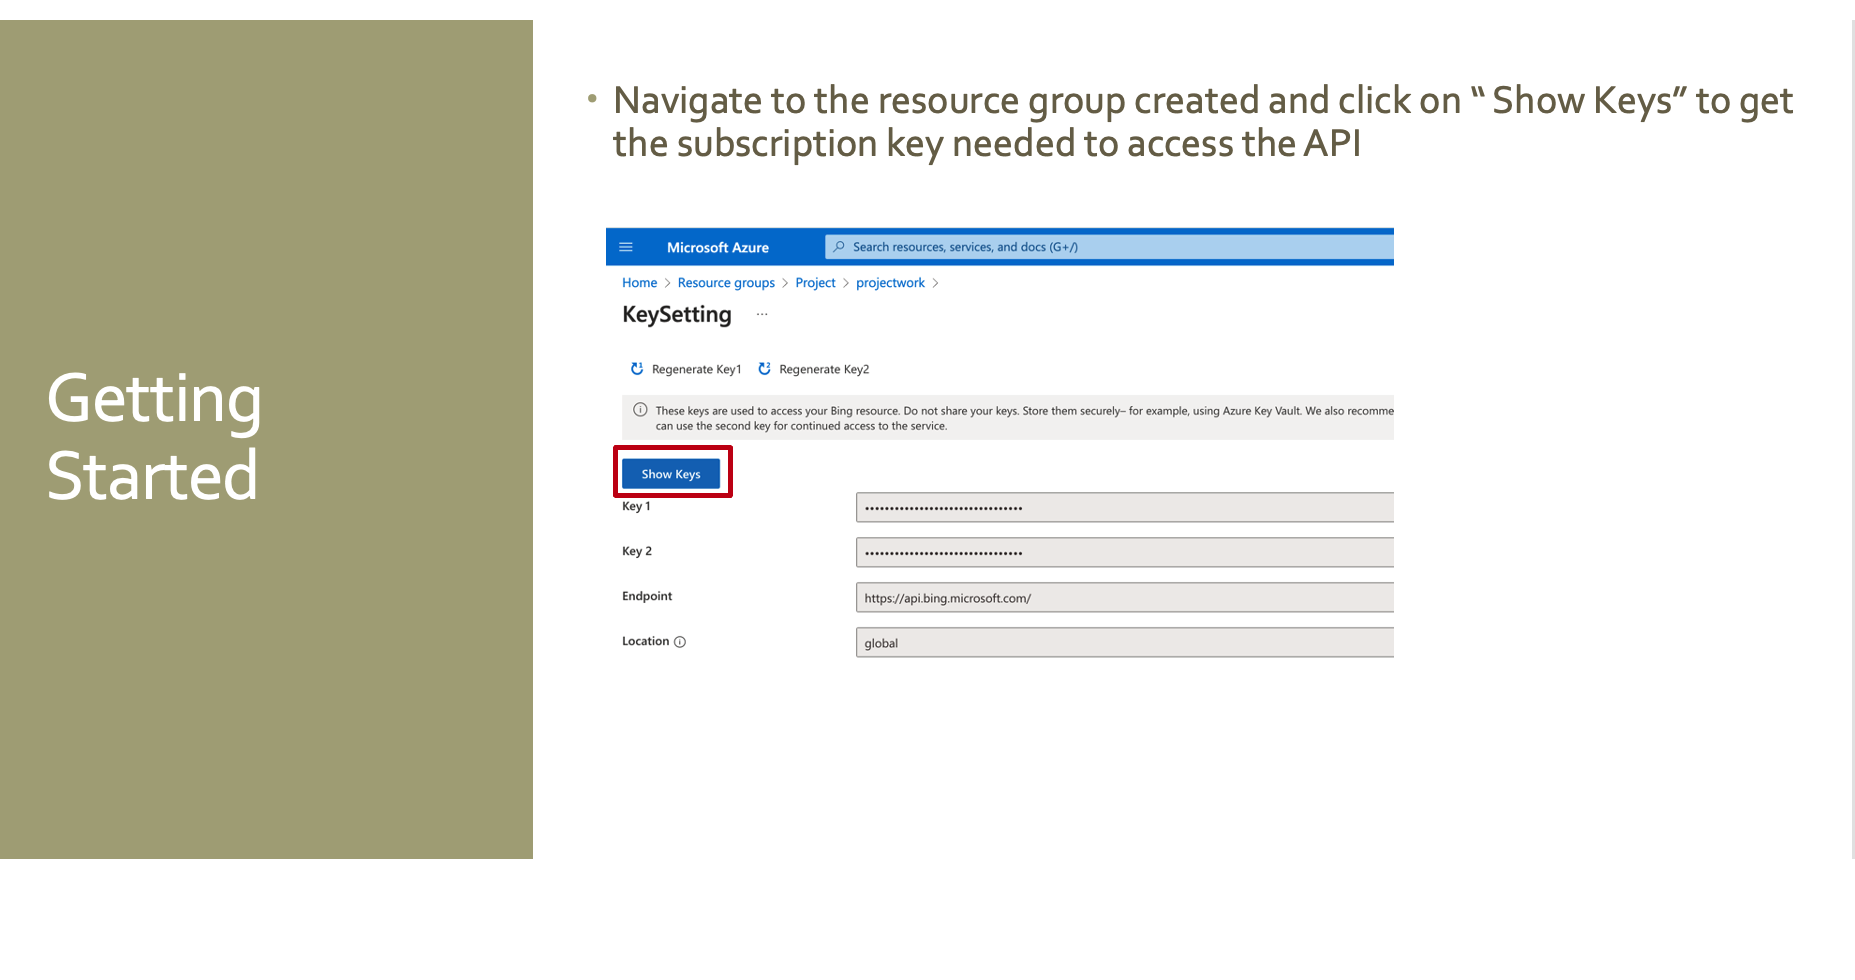

In [7]:
base64_data = "iVBORw0KGgoAAAANSUhEUgAABz8AAAPUCAYAAAAzD/SAAAABWGlDQ1BJQ0MgUHJvZmlsZQAAKJF1kT1IQmEUhh9LMSqiIIigwaEhy0K0iLbMIYII8Yd+lrheTQN/LtcbFe3R0NxaU2NT4BrR4B5UBC1FNTUFNpTcztVKLTpwOA8vL995OR+02BVNy9iBbM7Qw7MzrqXlFZfzGQdt2OjHq6gFLRAKzYuF79lc5StxSl2OWm897gy+xKI994cLb9Mj+dDiX39TtSeSBVXmh/SwqukG2IaEQ5uGZvGWcK8uoYT3LU7V+MjieI1Pq55oOChcEu5W00pC+EbYE2/QUw2czWyoXxms9J3JXCwis0t6gAg+JgnjZwJJ8I93vOoNkkdjG511UqQxcBEQRSNDUniOHCpjeIR9eKX91o1/366uZbMwFZNVe3VtdRdOLiReqa65H6DvCc7vNEVXfi5qK9sLa35fjTuK4DgwzVf5B6cbKtem+V40zcoxtN7CWfkTuAVjiQQKCjgAAABWZVhJZk1NACoAAAAIAAGHaQAEAAAAAQAAABoAAAAAAAOShgAHAAAAEgAAAESgAgAEAAAAAQAABz+gAwAEAAAAAQAAA9QAAAAAQVNDSUkAAABTY3JlZW5zaG90a10USwAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+OTgwPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE4NTU8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KX7xbeAAAQABJREFUeAHs3QecFEXawOGXsOScc845CggCghFR8M4cTjn19DxzwHDGU1ExnonjxHiGz3DmM5NUREkSRSSHJeySc+art6F7u2cnT/fuzvIvfst0muqqp2u6e6a6qoocMkEICCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQJoLFE3z9JN8BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwBKg8pOCgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAChUKAys9CcRjJBAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIUPlJGUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUIhQOVnoTiMZAIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKj8pAwggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEChEKDys1AcRjKBAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJUflIGEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgUAhQ+VkoDiOZQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABKj8pAwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUCgEqPwsFIeRTCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAJWflAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECgUAlR+ForDSCYQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQIDKT8oAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggUCgEqPwvFYSQTCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBA5SdlAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEECoUAlZ+F4jCSCQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQoPKTMoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAoVCgMrPQnEYyQQCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCBR/5aVbUEAAAQQQQAABBFIWGHbZ4ynHQQQIIIAAAggggAACCCCAAAIIIIAAAggggECiAsuXL3feQstPh4IJBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIZwEqP9P56JF2BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBwBKj8dCiYQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBdBag8jOdjx5pRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABR4DKT4eCCQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSGcBKj/T+eiRdgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQcASo/HQomEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXQWoPIznY8eaUcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAUeAyk+HggkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhnASo/0/nokXYEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHAEqPx0KJhAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF0FqDyM52PHmlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAFHgMpPh4IJBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIZwEqP9P56JF2BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBwBKj8dCiYQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBdBag8jOdjx5pRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABR4DKT4eCCQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSGcBKj/T+eiRdgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQcASo/HQomEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXQWoPIznY8eaUcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAUeAyk+HggkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhnASo/0/nokXYEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHAEqPx0KJhAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF0FqDyM52PHmlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAFHgMpPh4IJBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIZwEqP9P56JF2BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBwBKj8dCiYQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBdBag8jOdjx5pRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABR4DKT4eCCQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSGcBKj/T+eiRdgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQcASo/HQomEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXQWoPIznY8eaUcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAUeAyk+HggkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhnASo/0/nokXYEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHAEqPx0KJhAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF0FqDyM52PHmlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAFHgMpPh4IJBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIZwEqP9P56JF2BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBwBKj8dCiYQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBdBag8jOdjx5pRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABR4DKT4eCCQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSGcBKj/T+eiRdgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQcASo/HQomEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXQWoPIznY8eaUcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAUeAyk+HggkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhnASo/0/nokXYEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHAEqPx0KJhAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF0FqDyM52PHmlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAFHgMpPh4IJBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIZwEqP9P56JF2BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBwBKj8dCiYQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBdBag8jOdjx5pRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABR4DKT4eCCQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSGcBKj/T+eiRdgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQcASo/HQomEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXQWoPIznY8eaUcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAUeAyk+HggkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhnASo/0/nokXYEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEHAEqPx0KJhAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF0FqDyM52PHmlHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAFHgMpPh4IJBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIZwEqP9P56JF2BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBwBKj8dCiYQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBdBYons6JJ+0IIIAAAggggAACCCCAQDwCG7JXy8gHb5aDhw5Zmw89e5j0Pu7keN7KNggggAACCAQicODAAbln+DDZu2+vFX/vvifL0LOGBbKvdIq0ILkUtPuHgpaedCpX6ZRWjnM6HS3SigACBVWAys+CemRIFwIIIIAAAggggAACCPgmsGvnTtmwcYMT35bNOdPOQiYQQAABBBDIQ4GDBw/Iuqy1zh43bVzvTB/NEwXJpaDdPxS09BzN5TRW3g8c2CfZWWtk+/atUr58RalUubqULFkq1tus9RznuJjYCAEEEIgqQOVnVB5WIoAAAggggAACeS/w3JN3y66dO6wdFy9RQq74251SrmyFhBMy6p/3yfZtW6331a7bUC4adn3CceTXG1auWCSjnr7f2f3Ak/8gA08+05lnAgEEEEAAAQQQQACBgiDAfWtBOAqR0/D5p2/JvFnTrA3c34n2mRbXzz99r+zbs8da13/gYOnea0DkiOJYs2TRr/L5J2/J8mWLZPPmTXLoSI8j9ltLlyojVapWlTbtukjX7n2laYt2UqRIEXs1rz4JuL9P12vYRM6/+Jq4Yt60KVteG/OkUyb0TS3bdJIz/vCnuN5fGDZat3alvD7mKScr7s9M5sql8tZrzzrratSqK5dcfrMzzwQCBU2Ays+CdkRIDwIIIIAAAggc9QJzZk+VAwcOOg5vvPSUXHXdvc58vBNzZ0+XPXsPf5nfumVTvG8rENtt27pVsrLXOWlZvyGnVYSzkAkEEEAAAQQQQAABBPJZgPvWfD4AMXa/PmudLFgw19pqkamcHHrOMOvB0mLFisuyxb/L9h3brHXa3XKylZ9aYfTmy/+UX+fPjpqaXbt3Smam/q2Ub776WGrVqiMPPvZq1PewMnEB9/fpnTu3xxXBDvPQ8JMPD5c1azKd7UtklDBdkV/qzB8NE9Onfu98XjS/pcuUdbL94/dfetaVLVfOWccEAgVRgMrPgnhUSBMCCCCAAAIIIOASmDZ1kvzw3VfSx4wDRUg/gV3mC/fK5YuthOuT3fqEd9GiRQtcRtIlnQqXTmktcAeaBCGAAAKFVIBrQyE9sGQLgRQFWpuWe99N+MKKRR8wnTXtR+nd7xTrfrx1u04y9efvrXWLFs2XDdlrpWr1WgntUc89zzx+l6xbtyah9+nGO7bHVzGXcMS8ISGB3bt3yVMjb/dUfBYrVkz+et1d0rxVh4TiSveN586c6slCzz4DrXltxTz1p4medf1PGOqZj2eGa3U8SvFvg2d0Kyo/o/uwFgEEEEAAAQQQKBAC7/znBWndur35Ml6nQKQn6EQUC6kcLFak4FUWxmswccL/5P23X3I2v+v+Z6VRk5bOfEGZSJd0qlc6pbWgHF/SgQACCBR2Aa4Nhf0IF9z8Fab71oKrnHzKWpkuZt3hl+k/WJWfuqxDp55O5afOT/7xWxk85CKdjCtohdDo5x/KVfFZsUIl6dFngNSsWVcqVaxqjfu5fv1a2bg+SxYvnCdrk6gojStBbJSwgHZ//OwTd8ky01WxHfSB1cuvvFXam/JxNAWtSFu8eL6T5TKly0jHzsda8wt/myUbN2101mmrZe2+OdHAtTpRsejb4xndh8rP6D6sRQABBBBAAAEECoTALvM06osvPCrD736qQLYa9BtJx1YZ8fgrJtpDVtQVK1XzexfEhwACCCCAAAIIIIBAygLct6ZMGGgE5ctXlHp1G8iqzBXWfn6dO1P27NktJUuWkg4de5jvVkXk4MHD3zmmTh6fUOXnsiULRIcacYeTTz1Thpz1ZylRoqR7sWdax4nVVnRbNudUJnk2YCZPBA4ePCCjn31AFvw2x7O/iy69JukukD0RpdnM7Jk/e4bf6dz1WMkwXf9qmDxprCc3/QYM9swzg0BBFKDysyAeFdKEAAIIIIAAAgiEEdCumP73yZty+tCLw6wtfItqmCelCQgggAACCCCAAAIIFHQB7lsL9hHSrkvtys+9pqXf3NlTpGv3vlK2fAVpYnpkWbToNysDOhanVkzWb9AsrgwtMd/P3KF9x25y9gV/dS8KO63xx7uPsBGw0BeBV/79uMz85WdPXGed+2fpN+B0z7KjZWb2zJ88We3Z5wRr/sCBfTLDDMVjh5KmYr+P6TqagEBBF0jf/sMKuizpQwABBBBAAAEEfBDQp5R1vBE7fPbRW6JPGBMQQAABBBBAAAEEEEAAAQRiC7Rp28mz0S9Tf3Dm23U6xpnWiZ9++MYzH21m2dLfPauPH3iGZ56Zgivw9n+ey9WacdDp58opg88ruIkOMGUHDx6UebNnOHuoXKmytGrT2ZqfYyqId5guce3QvWd/KV2mnD3LKwIFVoCWnwX20JAwBBBAAAEEEEBAzBifNaVL9+Pkk4/etDgOHDggY14YIXc/NNrqqskvo+07tsqCX2dK5oqlsmnTBtm7Z6cUMeNsVjRfeipXqSHtOnSXWnUaRNzdtm1bZNvWTc762nUamvcXceYjTWzZvF527Dj8RaqoGeezVu2cfaxdvUIOHjpovbVqtVox86vdFq1auUSWmsrhVcuXWPsvXaasNG7cQjp06WW6tComu3ftlI0bs6w4K1WuKmXKlI+UNEnFJDtrjezbt8eKe0PWOs8+MjOXS4mS3m6wypnuuCpUqOzZzj2j4wmtXbPCVHz/LiuW/S5bt2yS6qZlbIMGTaRxs9bWMXJvH++03+nU/eoxXb5koRk3Z6GsM2muULGy1GvYXBo1ai616zZMutvmINJqO+kPV9oCYEN2llX2K1epLjXr1Jdjeg6IWe7sOOzXoI6VHb8+eb1ubaY1W7ZsOfMZzekSeqUxnzt3mqw3ZW6n+Uwfd/zgsGPx+JnG5cZu0e/zJCsr0yqX+pmqVKWKVKlaU9q26yqVKuekz85DuFc/ys2uXdtl08b1VvTFixeXGjXrhduVs8xtqQtDz1vu9cla2zvTz+yMad9L9rpMc27Yb/72SnkzHliVajWkY6ceMT/Dfh4zO03RXv06n/plmGr58LtsqJ07b+XKmXO4OddpyFq3SmbPnCJrV6+UXTu3Wefq+vUaSwPTsqh6jdrWNn7+l0zZcqc92bLtV5lM5Vqrjn5fG/zKl32M9cfk+XOmyYIFc6zzk97r1DfX7obmmtjQlIl47pXsuGK9pmppxx+pfOh5QX8AX7LkNysvh8x89Rp1pE79htK563Geh/XsuCK95qWLOw3JfF7c7482neh9q8YVZHrstO7YtlW2bM3pWjX0ftveLt7XVM/Hup+8KGOh+WnZtrP1edPPuIY5s6aZrm4PWN8POnbuKR+9/7rzlmk/fydnnX9VXJ/PNZnLnPfphN7TBx38vG/VtCZ7TPfs2SUb1ud8z9Hzgd1FajgD9/la11etVtPcZ5cOt6m1TMdH3W2+k2ooWaKU+V5cy5r2479PPnhdxn79iSeq/gNOkz+cc5lnWTwzyV43Qr8/16nbKJ7dWdvo90I9j2rQ77uVK1e3pt3/JXqPvsSMRbt9xzYniu49+zmfgZ9+9HZ5O+CkxCr53cfej+/Gmshky62TwQQn/Lo3du822bIThKc7XYVpmsrPwnQ0yQsCCCCAAAIIBCawe/d2mTH9C8lau1z27tttKhyqS9vWvU2lTrvA9qkR7961SwafeZHMnPGjrDAVkxrWrlsj77wxSv502Y3WfKr/vTJ6pEw2X2jssW7CxvfmaFOJ2FwuGna9NDSViaHh/bdGy6QfvnUW33z7o9La/MgQKzz16B2yatVyZ7Mnn3vH+gE5c8USuffvVznL/3juMDl18PnOfOjEquWL5N+mUnj16lWhq6z56qaC4eLLbpJF5sdHuyK5T9+T5dIrbg67fSom+iXmzlsuFfvHldAdaPdKoaFly3Zy611Phi625tetXWkqvB+RpUsXhl1fvHgxOd2UEfXRH7TiDX6nU7+EacX84sWRWyaXKV1WLjRj6PQ4dmC8ybS28zut9s61nL065omIth+9+6oMOftS6dt/kP2WqK9BHSv3Tn/6Yay8MuZwWWnbvrPcOPxRq3u2/7z8T1kSYt+sZftclZ9+pTFz5VJ57//+nWucK3dadbpRo2bWWMWRxr3ys9x88M7LMn7sZ04Snh39QdSn0n/6cby4P483Dh8hbdt3c96fqrVGpPl76/VnZd6c6RHPsW8WeU66djtWrrruXmff7gm/jpk7zmjTfp5PUzX0q3z4XTbUz5231m07yhVX3ylvvfqMTJ/2Y9jzv1Zy6Q+rZ51/RdQfe6MdG/e6VMqWO+35eR5J5VqrFn5fG/z+rE2bMkHe+c8o2bQ55+Ew9zGsXr2GXHblbe5FSU+naunesbt8tGndQW6683GZ/tMEefuNF2Tzls3uTZ3pWrXqyAWXXGuuOV2dZZEm8tLFTkMqnxc7jmivid63Bp0eO62rM5fKkw/f5jluZU1rrUeefl1Kly5nbxbXq1/nY91Z0GUsXIb04az69Rub71NLrNXaiu038+CnllntfrZK5SqycdNGa92GjRtk4W+zpUXrjuGi8iyrUL6SZz7TmDcxDyYGEfy+b031mH437n/yzlv/drJ62ZW3Sq8+Jzrz7gmtOHrgrr/KTvMgqh3OveAvcuKpZ9mzuV5HPniDrN+w3lpe0Tww9sTz7+baJpkFY7/6UD758A3PW3v26m++o1znWRbPTCrXjdDvzzfd9kiu+/ZwadDP9T23X+ms0nvtux54wZlP9h591i+TnTh0oueRY6kPD8+eOdVZ16RpS2lgHmyNN/h9rU613Mabbvd2ft4b2/EmW3b89rTTU1hf4/91pLAKkC8EEEAAAQQQQCCGwO5d2+TjD5+UBb/9bH7AWmtaKm6W1ZkL5ZtvX5V5cyfGeHdqq7Wlp7ZYHGa+TGollx2+m/CFzJ7h/YJir0v0dZF5yjNqxeeRCLXy7eF/3CBTJ4/LtYuOnXt4lv00Kaci1LPCNaNf4N0Vnw0bNnFazhw60uLT3lxv8iOFLz9/Rx6877qIFZ/6vmzz5PA/H7/TqfjUZaH70GV2SNUkWnrtfbhfI20/fuzHcv+df41YOadx7N9/QD587zV57MEbrSfp3fHGmo6030jvi7T9ZNM92D9MZXW0ik+Nc+euHfLiqEflpVEPy+7duyLtJuzySPsOu7FZGGv7eeaJ/wfuvSaq7Zatm0UrFeeZVjuxQtDHyt7/AddnY9XypTJ96nfy8H035Kr4tLd3v/qVxk2m9fSTj9wWs+JT971s2SI5aM5j4YLf5Sb0mB+SyOcNTU+u7V22uj4Va32/ngfvu+PKI61LIqdF07F44a/6llzBr2OWK+IIC/w+n6Zi6Gf5yHWsUywbyufO2/x5s+Se4ZfLNDMeVui+bGpdrpXz995+uell4fCP7/a6RF9TLVvutOfXeUTznOq1VuOI5K3rwoVI2/v9WXvTVIT/69kRESs+NW3ZpreBRx4M/xBWuLRHW+aHpR2/u3zovd/7b4+WUc+P8FSg2dvar2vXrpZnn7jH6qXCXhbuNa9dNA2pfl7C5SN0Weg9ZaRyllfp0f3oMBkjH7jFc9y0AumWv49MuOLTz/Oxpi3IMqbxRwotW7f3rJrh6vq2bYdjPOsmT/K2dPOsdM00Cqno/PLTd2TzpsMVdq7NUp70+77Vj2PaKqQr4dDxIt2ZXmLuc9wVn7pu3tzp7k0803qdtCs+dUXzVu0865Od0Xz/35v/8ry9U+dj5M9X3ea0cvSsjDKT6nWjS/c+nti/G5/zAJ9nRcjM+G8+9SzpckxOPKnco8+ZlVPBWadOPaeCc9rU783D33udfR5/whnOdLwT0c6J4eKItL0f5Tbc/qIt8/veWPeVatmJ5BMpH4luHymedFxO5Wc6HjXSjAACCCCAAAJ5KjDdtPjcuXNr2H1Om/q5Wbcl7Do/FupTshr0ieRBp3tbPr5qWn9tdXU1m+r+tFWKPrmvrRA7duouNWvk7lpo//798tpLT5tu/Q53u2nvs2PXY6V8uQr2rPwybZLVraOzIMzE5Ene8XSOPe7kMFtFXzRn5k/mR7mXTAXgfs+GNUx3wfpFVp9MtbuUO3DgcNdAng1jzCRrol1uJhKKl8jItfmv5geBN1993vNlM6N4htUCt5n5oaVCSLdaCxfOl2+++iBXPNEW+JFOrXx7afRjsiukMlPLjx4DbTEcup/JpsXdi88/GC1pudaFxpFrg5AF4UzdmyxYMNdTbrQLYW1917xFG8+DBvpl8eV/jbS6THa/3z2dF8fKvT97WitnRz3zoKeM2OvUy90awc80/tv8CK77doem5rPWo1c/6WZ+gGnSpIWUKlnKvTrXdF6Vm1w7TnJBIta6C+1G/JUXH5c9e3d79qgujRo1NS1Mu1jdVpfIKOFZ757x85i54400HfT5NBHDdCsfauruKk6vpZ3MQ0HNmrWS0GO8fn221eI82R+i/Chb7jKQyHEJqkwme63VfPhxbfA7X9+aa7G7Fbqms2jRIuaz38y6v9J7lKBCKpbh0qTX9i8//6+zSuNv3ry1db3Uh9bcYd/+ffL6mKfcizzT+eHi9+fFk6EkZvIqPdpq8QnT4tN9XqpapZrpieFJ6ztFIkkP+nzsZxmLla9ex50kpwz6o/Pnfniz/8DBznLdppPpCjee0KyFt1Junemh55F/XC8/fPdVwg8lRtufn/etfh1T/X5as2ZtJ9m/zvnFPFAb/oG32bOmONvZEwt/mxvx++Ivv/xob2a9du/e1zOfzMws05OS9vjivv62bNVerrz2Huth40Ti9OO60b5TT6lapaqz25nmwWbtCjda2Lt3j0yZPMHZRL8b9us/2JlP5R693wk5n4Gzzr3CibNRw6bOZ+PUwWdJtx79nHXxTvhxrfar3MabZt0uiHtjP8qOH56JOKTzton9KpPOOSXtCCCAAAIIIIBAkgJZa5dFfKd+wcvOWm7GbuoQcZtUVri/QA4eeqHMnK7d3x5uMbLVfDl6zfy4fu3ND6WyCxl40plSvEQJ8yW/l9Py0o5wl+kSavzYT+SDd1+1F5mxV3bL15+/b3WBay8sVixDuh/bX8YdGTtFn+ydZb60djumv72J51W/dE79aYKzTL+49TruBGc+ngkdL+j/TPe/7lDLfAG/5uYHPGOHrlu7St59c5TMcnXX435PuOlUTPSHwWdGf2i+/B+ubP3my/fk4/++4exm+J0jpUHjls68TmRkeG/LNW9vvfasZxv9cn751bc7Y7poq+C3X39OJpgup+zw5Sfvmi/Ap0Xt6tPe1o906riF77u6u9K4K5tuw66+/j5p3LSVvSvzgMA2GfPcCJltuv60gx6P+fN+iat7ZD/Sau839LV+/Uam++NbPN05LzXjmT3z2N2ybfvhHyC0ckDHWm3RulPo260ftoI+Vrl2GmaBVrD0OHaAdDEVuE1btPWMZ+tnedKurxaZinY7aCuS64c/5Dwdbi/XsjF/7gxzvlqUa4zbvCo3dlr8fo1mrfvScfdGPfOAKRs5D1yULFFSBg05T0457TzPuHh7zPlUx5sN/bHLz2MWT/6DPJ+G2380w3QuH3oNutB0D9+6bRcn23qu1nPExPGfO8u0Nd1E08Kj/4DTnWXxTPhRtqLtJ9pxCaJMpnKt1Xz4cW3wO1865ut7b7/oYa5Xt4FceuVwaeQaNkAfXnvX3MP85PoR2/OmBGdStYxnd/pg3HkXX+MZu/bnH8fJmH896lQm/G7GgNa8hY5jnh8uQX9e4jFzb5NX6dFrygtP/8PzYJSem266/TFrnGl3mmJN5/X5OJUyFisvul676ozUXacO6xFuaI9Y8TY3D43qA2Du3k+sh1xefEL+a84FrU3ryNbmgaf2pmVpvOOgR9tnqvetfh/TLt16yxf/e99KsnYlrEOMhLtf/tX1HcDO3x5TkbfQbB+uu2wdX9gOeg/VLs7KaPs9oa+/z58po813Efe9mT6gee3ND0YdpzQ0Hp3367qhw5X07neq0wWv9uYzaeIXcsrg88Lt1lo2xXx/Vmc7dOvRV8qWr2DNpnqPfvzAIXa0ntd6DZvJWeYv2eDHtdrvchtPXoK4N/aj7PjhGU/+C8s2tPwsLEeSfCCAAAIIIIBAYAIHIjzBau9wz96d9qTvr3YFmkas3d9eZn48cz/ppxVI2m1KKmHASUOtMQ0rVKycK5rSZlygQadfYMZA+ZtnnT65HhqO63eKZ9HPUbqL0ifSdTwdO3Ts0sNTWWMvj/b61efviT5dbYd69RrK7fc/66n41HU1a9WTa256UI43T3THG1I10fENS5Uqbf1lmGl3KFHy8HJ7vb5q5bE7fPHZO6JdyNmhhanMusWMuVW5cnV7kVWBomOw6g9FdtAn/LWyOt6Qajq//uI9q0the386tuq9D/7LU/Gp63ScpWtvHSG9+3gruLVS2v30tR1PuNdU0xouTm2hONyMtRr6Y1fjJq3kxEFnet6y8siYu56FZiavjlXoft3zbdp1kgceHSOXXH6T6FPk6u0OfqZRK4bdx2zQkPPD/pCYYSpjO5gfqgYPuSjX0/R5WW7cDn5Mx7LWffxgfrhyt7bRCqW7HnhOTjvjQk/Fp25b0rQE7WpaM4RWgvl5zHQ/sUKQ59PQfccyTNfyoT9+3/XAKE/Fp+a9WLFicvGfb5DTTj/HQ/GReahIK0YTCX6UrUj7i3VcgiiTqV5rNS+pXhv8ztf3ppLbfVx1HME77n/OU/Gp6dbKwcvNOLGXXzVcZ1MOflhGS0SPnn3lbzf+w1PxqdvrQzddu/f2vHVtZs5Y7vaK/HAJ8vNi5yuR17xIj7aMeu6pez0Vn1pZNvyepxOu+NS85eX5ONUylsix8HNbvd+59taHRLsJDQ3btm+VKT9/J6+NeVpuue4Cuee2y+SdN56P2T10aDz2vB/3rX4f02N6Hm8nz3qdaVpXhoYd27bK8uWLQxdb83Nn5VRy2hvoA2FLlvxuz0q7Dl2t+yVnQYITK1cuk2ef9H4u6tatL9ff9rD1XS3B6Hy99+83YJC5T8ipnvlh4pdRk/P9OG/XuAPN93g7+HGPbsfl92uq12q/y208+Qvi3tive45UPePJf2HZJufTVVhyRD4QQAABBBBAAAGfBcqVqxg1xkoVc7r7ibphEivdlQz69rqma86hZ1/iiem9N19M+ku0J6IoM/okaLWq1ZwttpkvsaFBuz5yd4E2Z/Z00Zaj4cLkkDFBj+vrrTgN957QZT/98K1n0dA/XiLlyh5+8tWzwszoE5LnXnBV6OKU5uMxSXYH7opj/eH8kitudrrvDY3z9DP/5Fm0JnOlZz7Ime/M+HXuMPgPF0s50xIwXNBjcPb5f5GSJUo5q/XHiMWL5jnzeTmh3VHedMdjEVvJdu1+nCc5mauWeebtmfw+Vi1Mi4Prb3lIqlavZScp16ufady4MdsT/z7z1H6iIV3LTTzWavHDuJwWfjp/2tDzpXadhjoZd/DzmMWz07w6n8ZjmK7l4wxzDSpVukxE7kFDLjTXqJwHE7SCXFvDJRL8KFvh9hfPccnrMmmnM8hrre7Dz3zpA2uTQ+5N9N5DH3KIFLoe0zfSKt+XJ2upDy5dfvXfcz3IYiewU5dj7UnrdfXqFZ75/HIJ6vPiyVwCM0GnZ9L3X5mWbQ9ZY8HbydLhH/Qhr9CWuPb6WK95dT5OtYzFykfQ6/X7x/C/PyknnTI0arf/q1evNENUfCx333aFjPrnfbI6c2ncSfPrvtXvY1q/UXOpXr2Gk485YXramTtnqvPgnLbiHHDSGc72v86Z4UzbEzp2qPs7cBcfurwNHZ7jr9ffG/F7o52OSK9+XjcqVqpmHmTt4exKH379ff4sZ949kblyqaeFsbZcbdQkpzchP+7R3fsrSNN+l9t48hbEvbGfZSeePLCNaUAAAgIIIIAAAggggEB0gVatvT/quLeuXq2eVKte370o8OmTTz1HWrXu4Oxnr+lecswLD3taGjgrk5xwf+G0o6hZM+eJZh1vJFxwj9up43BO+Wl8rs20u5cZUyc5y3WskzYdclovOiuiTOgPaVlZa50tdLyZjl29LQ+clUcmDhUJXZLYfLImie1FrLFysrNz8tbYdMOlrVcjBf3Sqy3L7LA+K6fFqL0siNc9e3Z5Wu/qGJ+9ep8YdVdaMdp/4KmebVaHaSHi2SCgmQ5dekZ92rtylZwfcjQJO450getOjtXtdT4fq9OGXGCeGPe2HA4yjfXqNXZHb7q6/khWLlvoWRZtJp3LTSxrzfcGUx7WulqkazfQ2tVtIiGvy1Venk9jGaZz+dAHPKKFkqbVf59+J3k2SeT850fZ8uzcNRPruORlmcyra61m3+98rc9eI5u3bHZktavRrj37O/N5PeGXZY/eAyM+gKV5qlrVe73cblq7uUN+uAT5eXHnLd7poNOj1+JXX3zSlOlDTpLamO8KN98xMuJDXs6GESby8nycahmLkIU8Xaz3uOdceLWMfOZNOef8y83Y3p3NA3/e3l/sBOlnc/q0H2XkA7fImtXL7cVRX/24bw3qmGrXt3ZYszbTPNiTac9ar3Nd4302a9Za2rfv5qxflblCNm9a78zrxJxffnLm9TtOp669nHm/Jl7+10jRbmITDX5fN3T//U/IqQzWee0WP1yYMPZTz+L+J3rfl+o9uifyAjQTVLmNlsUg7o2DKDvR8sC6wwLFgUAAAQQQQAABBBCILtCocSfp1m2DzJjxtfVDmb11jRr1pe/x2qVj3j5Ppj+wXma6SbvvjqucMT+WLVssn330Hxnyx0vt5JkKEb3VC19J6Wx0ZELHIfradLW6eNFvkm2+sG7avEl0HM4KFSpIxUpVpUmLNqayMXalmo7b+f7/jZF9+/dZMf/843jpFzKmmY7h4h6rpEfvE6L+qBaaVp3PNmnRylU7NG/RPuE47PdGevXLJFL8kZZnmR8NdMwXOyxaNF/uvOliezbsq1aA22G9qzLOXhbE6xrz9Lo7NDKtC+L5LOix+uqLD523rgtpIeKsyOcJ7U6oePFinmMRmqSCcKxiVbj4ncb6DZtaP+bpOE0aNm7aKPff/TfRFgmt2naWlq07SvPm7axxhEO9dD6dy00sa83fhvXr9MUJ9U1lsbbeTiT4fcxi7Tsvzqd2GmIZpnP5sPMY7bW+GW/OHdYkcP7zo2y59+2ejnVcgiyT+XWt1fz7na9NG7wt42ubsT7zMuSXZRlXi+Zw+c0PlyA/L+HyGGtZkOn51txTbTXdhLpDp8495Mpr7054LEN3HAXpfByrjLnTnd/TOvTASYPOsf70gc/FZhzcuWa8y7mzpppx0Jd4kqc9ADz96O1ypxm2Q1sAphLiuW8N6ph27znAc28/a8ZkOfHUs5zszJ/3izPdom1HMyZoR+veyO4ifLapHO3bf5C1jS77dW7O9lYlsnl4KJWgXT93OaaPfPzfN5xotFvdJx8ZbsbCHRm11wbnDUcm/L5uaLQ65qk+RLruyIO9v0ybLDt3bvMMY6EPHuv3ajuUNz1ThXY5nOo9uh13QXsNqtxGy2cQ98ZBlJ1oeWDdYQEqPykJCCCAAAIIIIBAHALtOw6Ups26mkq35bJn326pXKmW1eKzSJG8rfi0k6qt0i669FoZbVp82uHzT9+Rrt36SL2GzaxFGRmmNdgue23k1wnjPpUP/u9l2blrh2cjrVBbv2G99bd48QLPukgz+oVfx++cNuUHa5OF5gv/po1Z4m5FF9rlbZ+QsUIjxe1evtY8JewOVapWd8+mPO2nSaKJycxclustWdneCpVcG7gWaKsT/eEg0QoXVxRxTa4JabFZvUaduN5XvWZdz3brXGObelYUiJnoLbnS4Vj5nUYde/isCy6XN1993nOEFpkHJ/Tvs4/fth6caNu+i5xmuvls3LSVZ7vCXm42bMjy5LdmmDHAPBuEmfH7mIXZhWdR0OdTz85izBT28lGtmrd76qwEzn9+lK0Y/BFXB1Um8/Naq5n1O1/rQz7/NWrGd12MCJ/Aivy2jJbU/HDJz89LOIsg0xNa8dmgQWO5+ob7InZTHC594ZYV9vNxuDz7vUx75mjRupP194dzLpMli361HhL9fcFcZ1cbNm6QKZMneCoLnZUJT0S/bw3qmGovNDo8in5v1KAtN+3Kz5UrFnlaxLdt3910BV5atGcbfcBTw69zpjmVn7//Ntt8J81pkelHl7e6j9OH/kkOHRT55MPUKkD9vm5o2jT0Of5U+e87r1jT+h180sSvHENd+PPksZ7v6r37npDr4YZU79GtnRfA/4Iqt9GyGsS9cVBlJ1o+WEe3t5QBBBBAAAEEEEAgboEyZStJw8bmadUWPaR6jYampWH+VHzaCe7e63jpeewAe9aq8Hpp9Ein+9uMjNjPuf06d7qpxHjO82XKiTDJCff4ndqtk7uyU7sXmjNrmhNzixZtpUZIZZizMsrEupBx0ooUi/5lP0pUuVYFYZJrJ1EWZJtu81IJan7gQE6r2FTiivbeLZs3eFaXLx9+rE/PRmamYsXKIYtyumgLWVHgZ9PhWAWRRh037k+X3SDaZXW4oC2/Z5oW3g/dd52M+/ZjzyaFvdxs3bLRk98qVWt65uOZCeKYRdtvkOfTaPsNt66wlw9tBeQOxU0PC/EGP8pWvPsK3S6IMpnf11rNYxD5ctsVK57TJb17ud/TBcEykTzlhUt+fl7CWeRlerJM1+srli8Ol4yElhX283FCGD5t3KRZG7nxtkdMl7hdPDEuWXy4EtCzMICZII9pZ1fXt78vnCe7dx9+AneOq8tbba3Y0IwRqqFN+65ODn+bN8sZ43P2Lz86y7UXos4xhjVxNo5j4ow//EnOGHqhZ0u7BWi8XeAGdd3o02+Q6XEm57v7pIlfetL5/fgvnHntrWHAiUOdefdEKvfo7ngK0nSQ5TZSPoO4Nw6q7ETKA8sPC+R8qhBBAAEEEEAAAQQQSDuBCy+9RhYtmO08abty5TKn+9uMjPDjzNiZ1LEsXhr1qPNlU5dXKF/RjMk4WBqZp3EzSpaUraYV4YYNa2XZ4t9kvvliuuvIF1k7jnCvOn5nFTPOnXaHqWGqeZp50OkXHJ6eMkHcXbT27nuytTzR/4qHjKGjLU79CEGZJJK20EpErSDu3d87Tmas+DJcY4DG2jbZ9e7WvBrHls3e8Xoixbtxk7dbwMPdM0faumAvT4djFVQatXuyPubzO2fmzzLPdOemT+qvWrU81wH7v/+8II3MD136g5+Gwl5udMwvd9hhurRLNAR1zCKlI6jzaaT9RVte2MvH1m2bPNmPp6tw+w1+lC07rkRf/S6TBeFaqwZ+5yt0jM2MEsFXfhYUy2hlKj9c8vPzEs4iyPQMGny2zJ45xbkG796zW5557O9y+71PmQcMI48ZHy6d7mWF/XzszmteTus9+hBTCTdvzgxnt8vi7GHHeUOSE0EeU+369puvDj/wpsN3zJ39s3Q7pr/Mmz3dSW2rth2cYUradzzGaYWp3f8uNd81m5jxQOeYsmyHNu06JdQlrf2+aK9n/PESOWiagGpPJXawK0Dj6QLX7+uGnYby5jt4127Hys8/fWct0rFQtaWw3j9r69klrjLSsZP5rl0t8sN1yd6j22kpaK9BlttIeQ3i3jioshMpDyw/LEDlJyUBAQQQQAABBBBIY4HSpcuZ8T9vl5EjbnUqMbX7W336trh2exslaBcyW7ZudraoVLGS3PPQaKmQq2Xe4U1eePoemTH9J2f7SBP6NGrPPieKpkODVsiuzlwqdeo2lqmTxjlvK12qtHTr2d+ZT2Simun21x02rl/rnk16OiiTRBJUz4wR6A41atWT3sed5F5UIKZr163vSUdWVnwtVrPXZHreV6t28j/MeSLKh5l0OFZBplG71+rY5VjrT/m3btkk3034n3z12XvOgxIHDx6SWTN+dCo/87Lc7N650zNeUmgR2bM7p1u10HXJzjeo38TzVh3fJ9EQ5DELl5agzqfh9hVrWV6Vj/woG5r3tWtWeQgqm24C4w1+lK149xW6nd9lsiBcazWPfuerbr2GHroN2d5usD0rfZopKJbRspMfLvn5eQlnEWR6SpUpKzcMf1geuf8652FI7Qr3KTOW5B33Phvxvj5cOt3L8up87N7n0TLdoEEzT1Y3borvAULPm5KYCfKYasWl9gii3fhqmDXjZ+nQqZcsPtK1rS5rZ7q8tYN2lVvOjBesFZ8a5s2dKmXLlZe1puWyHboc09ee9PV16FnDrPiSqQD1+7rhzlj/gWc4lZ+6fMLYz6z754lj/+feTI6P0OrTvVEy9+ju9xek6SDLbaR8BnFvHGTZiZQPltPtLWUAAQQQQAABBBBIe4HmrTrIqaed5eRDx3t8ZfRjMcd8XLbEO45nvxMGJ/0DibPzIxN9+nlbdE7+4RurZeD83+Y4m3bp3seM+VLKmU9komrI066//5Yzdk4i8YRuG6RJ6L4izdet28h5Klq3Wbl8YaRN83V5rdoNPOlcbMZ33b93b8w0zZ2b86S7blyrjvfH4pgRFKAN0uFY5WUa9cGJwUMukutvedBzlFYuy+l+L8hyU6JUSc9+V6/O3RLVvcH6rNXuWSlZIrnzkTuS2qY86wMgdlgwf7bs2XO46zd7WazXvDxmmpagzqex8hlufVDloyCUDc3vqhVLPNmuEvIgj2dlyIwfZSskyrhn/S6TBeFaq5n3O196jNxBW+0EHQqKZbR85odLfn5ewlkEnZ5KlauZCtBHrMoke//ZpvL96ZG3S7zdedrvs1+DOh/b8R/NrytXeq8FtWrVzROOoI9pR1fXt79avYLMkv37c4biaNexm5NPvVdq1aaDM7/g19ky24wVaofixYtJF1d89nK/XrUC9LQzzvNEZ7cAjfaZ8fu64U6AfqevUyfn4dLpU7433591TNjxzma1atY23SbnODorYkzEc48eI4p8Wx10uQ2XsSDujYMsO+HywLLDAvk7UBVHAQEEEEAAAQQQQMAXgSFn/VkaNsxpcaStLZe5KhzC7WTnzu2exdqK1K+g3Wxpd612mGa68JkyeYLTOlWXH3d8Yl252nHpazXzxa+Eq2vXpUsXylzT/WaqIUgTO217Y1SEFDfd5NWoUcveXJYvXyKTvv/Kmc+riVjpLGG6Hq5WtbqTnE2bN8m3337ozIebyDatQ380FeHu0KBBU/dsUtOx0ppUpHG8qaAcq2hJzY80NmvZXkqXKuMka5NrfNggy025chWcfepEaEWTZ6WZWR5yjixb3vv+0O3jmQ/11tb1X352uBV8PO/XbULjCPocENT5NN78urcLqnwUhLKxwjzIMn3qJCe7RYsWkdZtOzvzsSZCy0UyZSvWPiKtD913qmUyL661mpdY1wa/81XK9GhR2XT7b4fVq1daLd/t+XCvB1wVA+HWx1qWV5ax0hFtfX64hB7bvPy8hLPIi/TUqtNArjMPH5V0DQ2xYsVSee6pe8xY8PvCJSvqsqDOx1F3epSsnDHtcNemdnYbNWllTwb6GvQxPcbVo49+5r76/D0nP3VNjzEVK1Vz5nWitWvczyWLfpNZrsrPNq07iZ/fTT07PjJz5tl/ltNOP8ezKlYFaOhnOdXroWfnZqbvgNOcRXv27pHnn7pXdu7K6amk38DTnfXJTES7R08mPj/eE+taHXS5DZeHIO6Ngy47dj5iedrbHS2vVH4eLUeafCKAAAIIIIBAoRYoVqyYXHH1nZ4KwVgZrl23gWeThWbMvkjh5x/HyZxZOWO2RNrOvdw9nmf2+iz58L1XndW1atWRZs3bOfOJTpQsWVq6du/tedubrz0re82XxHBBx8T68n+xKyCCMCkR0pps4cJ54ZLoWdaqjfcH8bdfe14yQ1oMed7gw0wy6Tzx1LM8e/7yk3clc+VSzzJ7Zo8Zg+qNV/9pfoA7YC8yTy53lroNcirtnRUxJpJJa4wok16dH8cq0cTmdRq1rO5ydSlb2/wg6w5BlZtmR8YVtff1xafvStY6bzej9roJ4z6V3xfMtWellGmFrk+W+xE6du3liebrz/8bswLE8wYzk5fHLKjzaWie4p0PonzkRdmYOPZT2bXL+1CRneeDBw/IW68+63kAqK350VdbayUS/ChbiezPva2fZTKIa62mNZlrg5/50jS0NC133OHDd1+WbaYL0nBh37698vLoR8OtintZUJZxJyDODfPaRZOVn5+XcCx5kR7tevTKa/5uen/J+bn3N9MDwZgXHvacf8KlL9yyIM7H4faTzsummlZ5C36dGXcWxo/9WL747H3P9o2b5U3lp+40yGPatFlbqVypspO3+fNmOdNt2nVxpu2JDmbcTzvsNedDLat26NzjOHsy0Nczz7lcBp1+rmcfsSpA/b5uuHeuQ524H2DQtNhBeyjp0/8Uezap11j36ElFmuCbkrlWB1luwyU/qHvjIMpOMp7h8lxYl+VcDQtrDskXAggggAACCCBwlAjoE99nXXBF3LmtH1LpNH3aj/K/T970VE5pS5VR/7xPXhz1iOzbn9hT4zqep47raQf9UmuHXsedaE8m/Ro63olWsD54919l/rxfnDi1om3p4t/ksYduko//+x9neaSJIEzqhnSD9+Wn78mcmTndOmlaQittzz7/L6ZVZc6P4rtNxeE/7rlaXv3347Jube7KnO07topWUL/64hOixyyZkEw6+59wuqd7Jh23Z8R918mkiV96usDVND187zUyb84MJ2n6w9x5F13tzCcykUxaE4k/kW3z41glkj7d1s806kMSr415wirDoS1J9PM2Y8pEedKMM+YOTZq3cc9KUOWmqWltXrVKzudmh2nd/uwTd8vv82c5rV50XNLvJ34u7/znX540dTPjShUt6s/X4z/88c+i3ZLZQZ/cf/ap++TNV58x4x8vE30Yww762dWW3frZ3e4ag9nPY2bvK9prEOfTaPuLti6I8pEXZUOvofff8Rerotvd1bGe/x68+2pZZFq1uMPAk4a6Z+Oa9qNsxbWjMBv5WSaDuNZqkpO5NviZL03D2Rf8xdPyfVXmChlxz99Eu8A9dOiQbmKFX00X8DpG44zpk+1FSb0GZZlUYqK8Ka9dNCn5+XkJR5FX6enQuaf8adgNniRMnfKDvP3G855l8cwEcT6OZ7/ptM3nn74tjz08XO648SJ5/aWnzP34WOtBQH3oT4M+FLN2zQrRSs9H7r/e3At4j4O2Fu/StU+eZTnIY6pd2Xbq6n041c6Ye7xPe1ll0/V77dp17VnnVbk8TJgAAEAASURBVB/q7do9byo/dad/OOcyGTT4bGf/OhGtAtTv64Z7x6XLlJNux4TP+zG9zHfrKD01+XGP7k5LUNPJXKuDLLeR8hnEvXEQZScZz0h5LozLixfGTJEnBBBAAAEEEEDgaBUYcMIQmTvjJ5ltxlmJFbTroY6dususmVOdTT987zX59ouPJCOjmPUD/eYtm511iU7oeJ46ruek77/xvFW7+uvT1zsmqGeDOGf06fYTTz1Tvvkip6vV1atXyROP3CaVKlYyPzLqDw47xV3pGivqIEzqN2pqtSrTCkwN2iLun0/cIxUrVJJy5cubsVw2mzEBd8vzL31iKl+KWduUKl1GLrvqdhk54lbnx9IDBw7KD99/bf1lFM+Q8ua9Gabr3x07dohWOtqhSfPW0qBhc3s27tdk0qnpPfeiv8rTj/3dSadW9Lwy5kl5/ZV/mnwfrvzWSqjQMMBUnIaOAxa6TaT5ZNIaKa5Ul+fHsUo0zX6mcdGieaby8CvrT8thpcqVpXyFyrLPHPcN5gEEd9dcmk79LHbv0deT5KDKTbFiGTL07GHykhnz2A5r1mRanyO7m+xw5wN9wn7o2Zfab0n5Vbu1uvTKW+XRB252Phca6fixn1l/mpYqVarKzp07Zdv2rc42A046Q8qZ84IGP4+ZFWGM/4I4n8bYZcTVQZSPvCob6zestyq69QfgMqXLmnGtS8jGTRtz5fXEk4dIuw45LV5ybRBhgR9lK0LUMRf7WSaDuNZqBpK5NviZL02D5m3o2ZfI2/8ZpbNW0IezRtx/g/VAWMmSJc1nXkS7hPQjBGXpR9rcceS1i+47Pz8v7rzb03mZnt79TpHNWzaYXldes3cv477+RCpVqmJauV3gLIs1EcT5ONY+03W9fs6zJ3wh35k/O+i1wP3Qg73cftVeJ66/+UHR8RjzKgR9TLXrW73fcQe972lpurENF1q37SJ6r+YOOhZomTLl3YsCn/7DuVfIIfPP3SrXrgC96faR1n2ZnQi/rxt2vPZr/xPPkEk/fGvPOq96nxgt+HGPHi1+v9Ylc60OutyGy1sQ98ZBlJ1kPMPlt7Au8+fR1sKqQ74QQAABBBBAAIE0FLj0yuFSvlzFuFL+p8tulHJlvV8ut23fYv1YG1rxWcU1jlVckZuNwo3r2c58ydUfwfwIZ593pRwTUrGi8Wra9YdFd0WHuxVqtH37baJf3s88Z1iuXWr6MjNXWhWX4VrVNjdd511qjk+F8rmPpW6vP6ivy1rrqfjMtZMEFiSbzrbtu8mtdzwqoeVDWwFqpWdoxWfx4sXk7PMuk3MuTK7Vp2Yp2bQmwJHQpnl9rBJK3JGNg0ijlsPs7CxZsniB6DjDoRWfWql4jflRL9znPahy06vPiXLaGeflItJzgft8YG9QxjxocMOtDyXc/aj9/kiv2q33ldfc4en+zd5W07F23RrZarrCjPajaBDHzE5DuNcgzqfh9hPPsiDKR16WDT2ueu4LV/HZ07TcOPuCq+JhCLuNH2UrbMRxLPSzTPp9rdXkJ3tt8DNfmo4BJw6V4wcOFq34cIddu3c59yf28rKmlU+467y9Pp7XICzj2W+i2+S1i6YvPz8v4XzyMj2nnXGh6INm7vDBu69avXO4l8WaDuJ8HGufhWV9tGu8Phz212vvknoNm+V5doM8pjqmpObNHZqbHkC08j9caN+xe67FXfKw1ad753889y9yyqA/uhdFbAHq93XDvdPGZgzYBiE9NDU3D7fWbxB/WUnlHt2dliCmk71WB1luI+UziHtjv8tOsp6R8lzYllP5WdiOKPlBAAEEEEAAgbQXKJFRyslDCVN5kGjQp4cvvfxGz9tKmJYG4YJWStzz4CjT3VLPcKutZY1My8Vb7xgpl1xxi7NNvOnSH3lqmfE93eHY/rFbfWaY9Lp/NCxZIqf7XHdc2k3lX665S668+napWaOWe5Vnuk27TnLfiJxWGJ6VITNBmOgPfhde+jdTKV0hZG/RZ/XJ/RFPvi6Dh5xvtR6NtrV6NW7c3LT6jP+LcWh8yaazhXma+75HXpQevfp5uvtzx6/d3DZp0kL+fu8zcvJp53qOr3u7eKcTTWu8Zcq9fx1bxw6xynxeHavSppWAO0T6bLi3saf9SGPTpq1NV8f17CjDvuoT/v2OHyT3jviXNGrcIuw2ujCocnPm2X+Wv/7tTmnYsEnEfWslvFZC3XHfP0V/hAgXUrHW+Lod018efPxVOWnQH6KOx6yf3ZYt25kWObkfCvHjmIXLW7hlQZxPUzEMonz4VTbC+V17w31WrwZ6PMOF2rXqyhV/vV0uN+NzawuGVEKqZSuV4+JXmQziWqumiV4b7OPgV740Pi0DF156ndxxz1NSt259exe5Xlu2ai9//8ez5pp4lrMu1rXG2dA14bdlouUjw1RquMu9+9rpSmaeu9j7TvXzEs/9Qzzb5GV67H2d/6drzLXI26XqG2b84d2mIj6R4Pf5OKgylkie/Nr2quvuFm3Nr+f4eILemwz7yy3y6D/flrauMS9D35tImbLf6/7sxTqX+H1M7TTouaBjl2PtWeu1dfvc433aG2g6ihcvbs9a49V26+btMcRZmcBEst+nzzr/Suu+zb0rbQH6wfsvuxdZ035eN0Ijr1u/sWfRgBOHeObDzfh5jx4ufj+XJXutDqrcRspbEPfGui+/y06ynpHyXZiWF3l5zM05gw4UppyRFwQQQAABBBDIU4Fhlz2ep/tjZ/4LZK1bJatXLpONmzfIgX37TJesFaVxk5aiY4mmS9Cx1ZYt/V32798vh0w3sXXqNbK6wStXtoLoWH83XXOuk5XeZtzRYX+51ZkPN+G3yW7TDe9yk77M1cut3e3etcN0dVVVGpqne+s3it5V7cGDB2R99lrJXpsp67LXmB8RxYyruc/qKqtSpapS1/yYovn0I6SSTt2/uq1cuki27TTd8ZoWUI0atxT9Eq/d9PodUk2r3+nR+PLyWCWb/lTTmJ21RpaZ8XQ3bsyyfkQtnpEhVavWlOrV65jPXQPRMYsSDUGUm8yVS2Xt2pWywXx2SpiK4yLmgYlq1WpJ/YZNpYLprjevgo7zmZ21WtZkLre6B1Z/TUvNmnWkkalQLh+mhXdo2lI9ZqHxxZr3+3waa3+x1vtdPlItG99N+NyM7/a0k+ybbntY2rTran0eVi1fJMvNn45bVtT8aVfk0R4EcCJJYsKPspXEbq23+FUm/b7WauJSuTb4lS/bdaPpDnPVyiXWNVzjLm163GjatFUg91dBWNr58Ps1L13stOfn58VOg/u1oKXHnbZo036fj6PtK53WbTM9OqzW+w5zH7xrx3YpUaq09Z2qSrUa1j2SvublvUcidhzTRLRyb+vndWP/3r1yy3XnO737aEtarSzXe4p4QhD36PHsN5ltUrlW6/7yutwGcW/sZ9lJ1TOZY1gQ37N8+eHfWjRtVH4WxCNEmhBAAAEEEEhDASo/0/CgHWVJXvDrTHns4eFOrk8244WefcFfnXkmEEAAAQTiE+B8KmZct/CVn/EJshUCCCCAAAIIIJBbIPT+QnsAGnrWsNwbsqRACXBvXHAOh7vyk25vC85xISUIIIAAAggggAACAQqsWrXUE3t90xKHgAACCCCQuADn08TNeAcCCCCAAAIIIBBLYOK3nzib6LAh/Qd6x+51VjJRoAS4Ny5Qh8NJDJWfDgUTCCCAAAIIIIAAAoVVYO/ePTLu64882QuqC0LPTphBAAEECpkA59NCdkDJDgIIIIAAAggUCIEli3413eYvcdLSuUsvqVQ595jwzgZMFAgB7o0LxGEImwgqP8OysBABBBBAAAEEEECgsAgcMmNOvvPGKFm3bo2TpZIlSkmNWvWceSYQQAABBGILcD6NbcQWCCCAAAIIIIBAMgJjv/7Q87YBJw71zDNT8AS4Ny54x8SdouLuGaYRQAABBBBAAAEEEEgXgU0bs+TTD9+Ujp17SKu2naVkydKepOsXkfnzZsj7b78oK1bkPEGrG/3x3D9L0aI8B+gBYwYBBI5aAc6nR+2hJ+MIIIAAAgggUAAEtm7dJNOnTnJSUq9uA2nRuqMzz0TeCnBvnLfeQe2Nys+gZIkXAQQQQAABBBBAIFCBbNOS87sJX1h/Oh5K9eq1rG6BtEpz46b1smF9tuzbvy9XGrp2O1YGnMRTtLlgWIAAAketAOfTo/bQk3EEEEAAAQQQKAAC343/n+zfv99JSd8TGOvTwciHCe6N8wE9gF1S+RkAKlEigAACCCCAAAII5K3AgQMHZe3a1dZftD2369BVLv3LLdE2YR0CCCBwVAtwPj2qDz+ZRwABBBBAAIE8Fjh48KB8P+5/zl5LlyojvY87yZlnIn8FuDfOX/9U9k7lZyp6vBcBBBBAAAEEEEAg3wQqV60hTZu2lMWLF8RMQ8tW7eXMc4ZJs+btYm7LBggggMDRJsD5NPEjnlE8w/Om4sX4ecUDwgwCCCCAAAIIxCWQuWKxbNi4wdm2Z+8BuYZ0cVYykScC3BvnCXPgOyny8pibDwW+F3aAAAIIIIAAAoVeYNhljxf6PJLBgimwcf06WbF8kWzavF62bNoo27dtlbLlykuNGnWkeo3aUr1WHalcuXrBTDypQgABBAqQAOfT+A+GttLYvn2L84YKFSo700wggAACCCCAAAKJCOiYn3YoXbqsZGSUsGd5zUcB7o3zET/JXS9fvtx5J48mOhRMIIAAAggggAACCKSjQJVqNUX/CAgggAACqQlwPo3fr2jRokKFZ/xebIkAAggggAACkQW4p4hsk59ruDfOT/3U91009SiIAQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMh/ASo/8/8YkAIEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEPBBgMpPHxCJAgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE8l+AMT/z/xiQAgQQQAABBBBAIGWBDdmrZeSDN8vBQ4esuIaePUx6H3dyyvESgQi2lIJ0EqC8ptPRyt+0HjhwQO4ZPkz27ttrJaR335Nl6FnD8jdRYfaeLukMk3QWIZCUAOfxpNh4EwIIIIAAAggg4BGg8tPDwQwCCCCAAAIIIJCeArt27pQNGzc4id+yOWfaWchEUgLYJsXGm/JJgPKaT/BpuNuDBw/Iuqy1Tso3bVzvTBekiXRJZ0EyIy3pLcB5PL2PH6lHAAEEEEAAgYIhQOVnwTgOpAIBBBBAAAEEEEAAgbQQWLlikYx6+n4nrQNP/oMMPPlMZ74gTqRjmguiI2lCAAEEEEAgFYEtm9fLv58b4UTRvVd/6T/wDGc+kYnnnrxbdu3cEfEtRYsXk7Jly0u5chWlXsMm0qpVR6lVp0HE7d0r3HHre8+/+Br3aqYRQAABBBBAIA0EqPxMg4NEEhFAAAEEEEAAAQQQKCgC27ZulazsdU5y1m/IaTnmLCxgE+mY5gJGSHIQQAABBBBIWWDiuM9lwYK5Tjzrs9dI3+MHS9GiRZ1l8U7MmT1VDhw4GO/m1nbVq9WQU4dcIH1MN99FixaL+F533Dt3bo+4HSsQQAABBBBAoOAKUPlZcI8NKUMAAQQQQACBo1Rgl/mRZeXyxVbuixQpIk1btEvqR6GjlI9sF3IBPh+F/ACTPQQCEuDcERAs0UYVoNzl8Bw8eFAmTfwiZ4GZ0iEb5vzyk3TseqxneVAz2euz5PWXnpbvxn4mN9z+iJQrWyGoXREvAggggAACCOSzAJWf+XwA2D0CCCCAAAIIIBAqMHHC/+T9t19yFt91/7PSqElLZ54JBPJToFhI64xiRRJvrZFK+pP5fOR3mlPJL+9FAAF/BJI5d/izZ2I5mgUodzlHXys53ePT22vGjf3El8rPFi3bHY7y0CHZv3+f7N69S3Zs3yZbtm62d+W8Llu2SJ546Ba58/7nJCOjhLOcCQQQQAABBBAoPAJUfhaeY0lOEEAAAQQQQAABBBAIXKBlm04y4vFXzH4OWfuqWKla4PtMdQfpmOZU88z7EUAAAQQQKEgC48d9GjY5v879RTZkr5aq1euEXR/Pwvr1G8nwu54Mu+lG09pzypTx8sn7/5G9+/Y626xcuUy+Ny1RB5wwxFnGBAIIIIAAAggUHoG8fUy78LiREwQQQAABBBBAAAEEjlqBGjXrSo2a9ay/kiVLpYVDOqY5LWBJJAIIIIAAAjEEtHJz3pwZYbc6ZFpqTjDd0AYVqphxPk8ZdK7c9cBzUrt2Xc9uxn/1kWeeGQQQQAABBBAoPAJUfhaeY0lOEEAAAQQQQAABBBBAAAEEEEAAAQQQKFACE8Z9JlrJaYezzr9MSpcqY8/Kj99/KwcOHHDmg5ioU7eRDDrjAk/U67JWB75fzw6ZQQABBBBAAIE8E6Db2zyjZkcIIIAAAggggEBkgeysNbJv3x5rgw1Z6zwbZmYulxIlS3qWlStfUSpUqOxZFmlm2dLfZe7sKaZLsSzZu2enVK5SXWrWqS/H9Bwgibba0x+u1q5ZIcuW/C4rlv0uW7dskuqmFWCDBk2kcbPWJu4akZKR8PLlJt2Lfp8nWVmZ1n7KlCkvlapUkSpVa0rbdl2lUuXc3a3u2rVdNm1cb+2rePHiVsvEaDs+cGCfrFub6WxSu05DKVKkiDMfbWLTxixZtvg30XGjstetllKly0q1GjWlc9feovHEG5LJZ7i49VjMmPa9SUumKUv7zd9eKV+hkmiLh46deoQ9Nu78ly1bTtxd2K5ctlDmzp0m60153Lljqxx3/GBp066Lteu1q1fIwUMHremq1WqFLUfuuMuVM+W14uHymrVulcyeOUXWrl4pu3Zus8pP/XqNpYEZ17Z6jdrhsiZ+fD7iSXPozrdsXi/Llyw0x3ihrDPlXvNQr2FzadSoudSu21CKhox/Gvp+t4Hb9+DBAzLnl59lyZLfrPJ6yMxXr1FH6tRvaMrPcVKsWLHQqAKb37FtqxkPbaMTv+apVu0Gzrx7ItnP/7ZtW2Tb1k1OVPoDdLxBzzcHDx4ua6XLlJXKlavH9da8sE/WI1IG/I5P3ebPmSYLFsyxypke2/rmXN3QlN+G5vMW77kuNL3pkk5Ntx/njtD8p3peCI0v0vx2c95d8OtMyVyxVDZt2mBdv4uYMZYrVqpsnc/bdeguteqE/6xGitNensz1wn6v/ZpqHH6WIz+uo37EYdsEUe7suP26p/PT305bpFet1Pzxu2+d1cWLF5M+/U6VtatWyg/ff20t13E5p/08UXocO8DZLoiJDh17eKI9ePCQbFi/1twveluEejZiBgEEEEAAAQTSUoDKz7Q8bCQaAQQQQAABBAqTgP4Adectl3qeiHfn75V/P+6etaZbtmwnt0YY28jeOHPFEnl1zBOydOlCe5Hn9aN3X5UhZ18qffsP8iyPNLNu7UoZ88IjEePTH7NOP/MiOXXw+TErhSLtQ5dnrlwq7/3fv02F7fRom5kKqGYy/O6npESJnIrhD955Wca7uk57dvQHUrpMuYjx/PTjeHH73jh8hLRt3y3i9rpi/9598s4bz8u3X38S9ph9YFxbtGgrl1xxk9SsVT9iXKnk0x2p/sj61uvPmu7kpptKopxWFe5t3izynHTtdqxcdd297sXy0w9j5ZUxh8fIatu+s9w4/FFZuWKR/Oflf8qSxQs82zZr2d6q/NRyde/fr3LW/fHcYdYxdxYcmXDH3bptR7ni6jvlrVefkenTfgzrphUx/QecJmedf4WpTC3tROfH5yPeNNs7VdMxL4yQxSEG9np9LWMquy+89BrzQ+1A92LPtNugTesOctOdj8v0nybI22+8IJu3bPZsa8/UqlVHLrjkWmPd1V4U2OvqzKXy5MO3edJS1nxeHnn6dSld2vu5SeXz//5bo2XSDzk/fN902yNORXq0zGn67rn9SmcT/czf9cALzny0iaDtU/EIl26/45s2ZYK8859RsmlzTqWze7/Vq9eQy668zb0orul0Sadmxo9zhxvFr/OCO85I06+MHimTfxwb8Zxuve/N0dK4cXO5aNj10rBxi0hReZancr2wI/IjDr/KkR/XUT/isG301e9yZ8ft5z2dX/522mK9zpgy0Txkk3PNa9+hm5QrW0F69z3JqfzUOCaa1qFBV36WMg/RFCtW1LT2PPxQje43IyNDXwgIIIAAAgggUMgEqPwsZAeU7CCAAAIIIIBAegroj2WJhFjbz5s1TT754A3Zv39/xGj1hyit5KpatUbMCr/xYz+W9958Ufaa1oSRwv79B+TD916TuaZV3y1/f9z8uJT4j0namvLJR27z/EgWaX/a4vJgSBdpoS6HJLprru2PtGaMtE9d/slHb0Zbba373bRYvf/Ov8rfrr9H2nY8Jtf2qebTjvCnSd+aY/iM7Nm7214U9lXzuXjhr7nWHXDld9XypTJ96nfy0qiRUY/zIdd7NMJQQ3sn7rjnz5sl9wy/XLbv2GavzvWq8WjF9ZxZP8u1Nz4gdU0LNTtE2oe9PvQ1dPt406zxTP7hG3nrtedk1+5dodF65nfu2iEvjnpU5s6aIhcOu0FKlcqpsLU3dBvoQwjvvz1avvz8v/bqsK9r166WZ5+4R+4dMSpiC8ywb0xw4bIlC+TpkXd6jklF01L4httG5Kr4TPXz36V7H0/l53fjP4ur8nP8N596ctXlmD6e+WgzQdqn6hGabr/je9M8ZOB+CCR0fzqfbXoCeOTBm8OtirgsXdLpzkDoucC9Ltx0pO39PC+E22/oskUL50Wv+DzyBj2vPPyPG+Syv9wi3XtFbzGX6vVCd+lHHH6VIz+uo37EEXrsdD5SOQq3bTzb+3lP55d/pLyEWx46nuexfU60NmveqoPogxh6PtLw+4K5pleIFUm3aLYiifHfyuWLPBWflY+0pI7xNlYjgAACCCCAQBoKMOZnGh40kowAAggggAAChU9Au2hNJBQvEb1icYH5Acld8and0mrLv+Yt2oi20LSD/kD38r9Gyu5dO+1FuV5/nTtd3nz1eU+FWEbxDKvFSTPT1W0F0wWvOyxcOF+++eoD96K4p//9/IhcFZ9Nm7aUHr36STdT8dGkSQspVbJU3PEFvaGmRVt5dmjfVapUruLZnVYUjzb50W47Q4Mf+dTuEF958fFcFZ+apkaNmpoK7S5Wd8QlMkqE7j7svFaGj3rmQc9xtjfU8lmhfCV7NqlXd8Wntm7s1LmHNGvWSkLTt359ttVi2f3jsd+fj0gZsCp/Rz+Wq+KzZo1aJr3HWGU+NC2TTevhF59/MFKUznKtTHVXfGpL1+bNW1ufy4YNcyp69Q379u+T18c85bzX74mFv82WJ0yLT/cxqVqlmmlJ/aTpFrWZZ3d+fP7bd+opVatUdeKdOWOyaFe40cLevXtkyuQJziZ6zunXf7Azn8iEn/Z+eLjT7nd835pzb2jFZ9GiRcw5oZnp/rq71Khe0737uKfTJZ2hGQr9vIauD50Pd20N8rwQuv/QeT1P6PlSe3vQ46fnotCg1/rXXnpaskyX55GCH9cLP+Lwsxz5cR31I45w5n6UO3e8ft3T+envTl+0aa3M1PTbQR+y6dCltz2bq/eEcWM/cdb5PbFnz25zP/uMJ9rGTVt55plBAAEEEEAAgcIjkNivbIUn3+QEAQQQQAABBBAoMAL64+Yzoz90xrX75sv35OP/vuGkb/idI6VB45bOvE5kZMR3G1e/fiO59IpbPF3iLTXjDD7z2N2ybfvhyget9NLxO1u07uTZh87ouHlvvfasZ3nLVu3l8qtvd8be07Gc3n79OZkw7n/Odl9+8q6pqDgtapezzsZHJrQCdpGpOLWD/kB2/fCHpIEZY9EddCzL+XNnyArTPWvoWKju7YKcrmwqOi/5843Sxoy5Zo/7qOM4fvX5u/LpB286FYg7TZ7+741RcsOtDzvJ8SOfOhbcqGce8LReKGm6/x005Dw55bTzPGNG6o99OuZrrMomJ4FmQiskteu5LqbCvKmp3NXxVv0ItWrWNq0kr5fWbQ+PHapxavnRMjZx/OfOLrQ100TTOrD/gNOtcQmD+nw4OzQTWq7ef+vf7kWmjFeRq6+/T9w/ju4045SOeW6EzDbdDNth1sypMn/eLyZfne1FUV+1EuO8i6/xjHH684/jZMy/HnVaDGnr4a1mnMx4x/aNukPXSi0LLzz9D6eM6io9Ljfd/pg1PqxrU98+//oZ6W3Gd/vkw8PnNW0lPmniF3LK4PPcu/NMTzHdA+/Yud1Z1q1HXylbvoIzn+xEKvZ+nw/9jk/H033v7Rc9NPXqNpBLrxwujVzdomq5etecl35yVS573hQyky7pDEm2L+eOvDwvuNM/8KQzpXiJEuahi17OeMn2+l3mczHeVBBpF+t22G3O819//r7VBa69zH7143rhRxx+liM/rqN+xGEbu18L6j2dn/7u/MaaDq3MPKb38Z57lN59T5HPPn7biebnH8bJWede4RnSwFmZwoR2b6znvdChIJqbLv0JCCCAAAIIIFA4BWj5WTiPK7lCAAEEEEAAgTQT0HErtdtM/ctwjWGp2Shhxj+019mv8XQpq60kh5txQUPHAmvcpJWcOOhMj9DKFUs98/bMF5+9I9oNpx20leMtZtzCypWr24usH7F0zDGtVLCDtijTH2cTCVop627tN2jI+bkqPjW+DFMx16FzTxk85CJT8ZjTijWRfaWybds2neQfj4yRdp16OBWfGp+mRcc7PffinPEwdfm8OTNk4/p1OmkFP/L5g6k4crfa08rKux54Tk4740LPj4q6w5KmJWjX7n2tisTDKYj+f5t2neSBR8fIJZffJNpiz6+KT23Be9cDozwVn5qSYsWKycV/vkFOO/0cT8J0TFqtGNUQxOfDszMz8/UX70n2+sNd7+m66tVqyL0P/stT8anL1ePaW0dI7z4n6KwT3n1zlKf8OitCJnr07Ct/u/EfnopP3UQrm7t2z2kNo8vWZi7XF9+CtmB77ql7PRWf+oDE8HuezlXxqTv18/Pfb8Agc6xzvn7+MPHLqPn63oz95g4DTxrqnk1qOlV7Pz00A37H9715gMD+zGj82hr9jvuf81R86nKtUL/cjMF7+VXDdTZmSJd0hstIqueOvDovhKZ9gCnvOh53hYqVQ1dZDxUNOv0CM+bw3zzrtGVmuODH9cKPOPwsR35cR/2II5y3Lku13IWLN9V7Oj/9w6Uv3DJtwa+Vme7Q7/jT3LPWtVB7JbGDPvTy8+Sx9mzcr7t37xTtzl1bQOt40fpAknbT/MVnb8uI+66Ve++8UuaFfEb0fmeAedCAgAACCCCAAAKFUyDn22fhzB+5QgABBBBAAAEEjkoB7U70pjsei9jysmv34zwumauWeebtmZ8n5fwApZVUl1xxs9Waxl7vfj39zD+5Z2VN5krPfKyZjRuzPZvsMz+aFcTQ0vxYVrpMuYhJ63f8YKs7V3sDrdD9cdI39qz4kc8fxuW0ktSITxt6vtSu09DZR7ITLUzXitff8pBUrZ67a8Vk47Tfd8YfL5FSpcvYs7leBw25UMqVzWlhqpW72pItr8J3ZrxRdxj8h4ulnGl9HC5oy56zz/+LlCyR0wXzypXLZPGieeE2d5ZphenlV/89YqV9py7HOtvqxGrTXaBfYdL3X8no5x4y3WEfrlDWeJuYCml9QCJS61I/P/8VK1UzD0j0cLKjD1X8Pn+WM++e0BY6ixcvcBY1btxcGjXxtn53VsY54Ye9nx6abD/jO3jwoBmv9luPxrkXXGU9/OBZ6Jrpekxf11zkyXRJZ+QcJL8mL84Lyabu+IFDpFrVas7bt23b6ky7J/y4XvgRh5/lyI/rqB9xuJ2DnPbjns5P/3jzOnXyeE8Lfh0qoVbtBrne3jPkYaLvxub0JJJr4wgLdNzQB++9Vu68ZZjcc/uV8oQZP36MGdbhv++8Iktc1xP77doV+N9uuD/XA2P2el4RQAABBBBAIP0FqPxM/2NIDhBAAAEEEEAAgVwCHbr0tFqL5lpxZEHlKjU8q3Yc6QLXvVC7cc3OXussamy6TaxZq54zHzqhlRPu8RvXZ+W0GA3dNtx8vXqNPYvHff2RrFy20LMsXWZOHHSWJ6nr1uSMxZZqPjeYY7J23Ronfu2aVbu69SOcNuQC80Nghh9R5YpDKwyjhZKmhXOffid5Nlntc8tHT+SumT17dsmGjRucJTquXq/eJzrz4Sa0YrT/wFM9q2Klt0fvgREfHtCIqlb1fi63bw9fmeHZaRwz+ll69cUnTdfah5yt27TuIDffMTJiRX4Qn//+J5zh7F8ntGvjcGHC2E89i/uf6H2fZ2WcM6na++3hd3zrs9fI5i2bHQ3tyrhrz/7OfLIT6ZLOZPMX7X15dV6Ilgb3OnfPCPbymjVzrsnayi40+HG98CMOv8tRqtdRdfIjjlDvoOZTvafz2z/efE4MacHf5/hBYd/ao9dAz3ju2jVtUPd/OgZyV9Ol//XDHzYPh5QOmx4WIoAAAggggEDhECheOLJBLhBAAAEEEEAAAQQSEdAu2YoXL+ZpBRb6/qy1mZ71ixbNlztvujh0M8/8XjNuoh3WuypO7WXRXus3bGpa0pWUPUd+wN24aaPcf/ffrFaUrcxYii1bd5TmzdtZ46BFi6cgrGvRqqMnGZtcrVpTzecGVxe6upP6ptJYW+X6EWJVUPqxj2hx1A8Z33WNjy0fo+13zWpvK+VGpkWkPZZrtPc1b9FevvriQ2eTdSmmt4yr5asTaYoT35r0bd22xRNLp8495Mpr77a6kPascM0E8flv066raMXyuqzDD1X8Mm2y6Biq7q6VrW4SfxzvpKR8uYpyTM/jnfmgJmLZ++3hd3ybNnhbztc2Y336EdIlnX7kNTSO/D4v6DibX5uu5xcv+k2yTVeemzZvkoziGaaldgWpWKmqNDFdhWbFeMjIj+uFH3H4XY5SvY7qsfYjjtAyk1/zse7p/PaPJ58rli+UJUt+92x68OB+00I9pycM90rNg45da4dx335iut+/2Z5N6VUfzKtZq45079Vfeh93svX5SSlC3owAAggggAACaSFA5WdaHCYSiQACCCCAAAIIBCEQvSVeZub/s3cf8FGdZ77HH/VeQfTeqzHFYIwNGPcSt9hOsdcpzmbTNjf3brI32WzabhInu0m82Wzi5KY5LrFjJ+69gjEuGLBxAUxvAoEQqKDe7v85YsSMkECCGSGs3/lEaMo573nP95wZOfOf5323HrHTvcWH56484sk2D3gVks8/19lgzufMvPbjn7G7b/9lREsb9cGv/zz28D3BB7+Tp86wyzRE6sjREyLW60l3srJyFC4nKjxuCLpVUX6gtXsnepwlJYfnpfRG+w86XPnTupNT9EbfvpHD7e4Nm282loe0u02FaUG/QZ3aXUH/wRHr7emm/kbs9Bh32gafw4aNtC985bsdDr0bai5Wr/+zz70kGIbQ9+Nflli25Gm74JLDldI+11tVdWWoGzZv/vlHDWlbV4zxjWh7RLu9fW3eF/r179w1fCy2U6WfxzqO43n+ZL4vLH7hUXvg3j9EvBb8GPw1s69kX/ATPjR0R8cXjb8X0Wgj2tfRif4dda9otNGR+8l5vOP/pou2f2eO78VnIyv4fZs7fv/zzmwarLP81SX2kRs+f9Th8sMb84Dz05/7qtXU1FqcphvI0Xy5efkFlte3IOILNuHbcBsBBBBAAAEEPtgCDHv7wT6/HB0CCCCAAAIIIHDcAsUaRvFEFh+ir7GxJfzrbDs+h9lNN3/F+uT3aXeT+oZ6e+vN1+0H3/2yvfDcw+2u01MeDAWf3p/ksLkh/f6JHGd52X5vonXJ79O/9fapfqOxsT7iEBJV5dQdS1np4SFvfX9ZWe3P9dm2L/7hauRyeFjZyMd7zr29GjJ5+7ZNx+xQrF7/Zy+4NPhiQKgDy5Y8FboZ/F764pOt970SedEFV7XeP5k3ou0R7fba2iQkJrd96Ljunyr9PK6DO8ZGJ+t9Yc27K/UloP85Ivg8RnfbfToafy+i0UYsrqMT+TsawopGG6G2evLvWPgf7XhrqqvsjdcWH22VYz5XW1djryx95pjrhVbwys5Zsxfa2fMvsnkLLrYpmmN68LBRBJ8hIH4jgAACCCDQCwWo/OyFJ51DRgABBBBAAAEEOiPQNgAaN26yzVsYOcfhsdpJ0jfxu7rMX3hp8OHVO2+9bu+9s9LWr3vbdu7cdkQz9975KxsxYqyNGjPpiOdO9gOVFZFzNaZnZh3RpeM9Tp9rMnyprKwIv3tK3y6vOFwh6wfSmaFno3HAbefALSvd16lm9x+IHGo0IaHn/d+rSy+/zt5+a3nra8iHFfzv//ymff07t1q/sPkC2x5wrF7/XhXt8629/tpLwS53Fm63zRvXBK/jHds32uZN77d2ZdrpZ1h+354R7kfbI9rttZ0PMim56++9rfBhN06VfoZ1OWo3T8b7QlNTk/3+th9b+PnM1mtm4XmX2wjNu52UkmLlGlWhpKTItm5aZ2vfW23VNdUdHnM0/l5Eo41oX0ehAz7ev6Oh7f13NNoIb68n3o6Vf0fH+sqyZyOGsO1ovWM9/tKLj9uiC3vGF2CO1VeeRwABBBBAAIGeJ9Dz/t95zzOiRwgggAACCCCAQK8UGKK5JMOXfgOGaK6kC8MfitltH45u2oyzgh/fSXnZAXtp8eP29GP3t37Q29TUbKtXvXLU8LOmquqo3/qvramKyTEU72uZ0zDU+ICB7Q9NezzHOWzoqFCzwW+fy+uDshTt3hlxKHl9+kbcj9WdgYOHRjS9d2/nqp6Ld0fad3SeIxrv5jup6Rn2lX++xX70vS8HQ2X67n0o3Ft//HX7xnd+YdlHVK+2dDCWr/+F513RGn763hY//1jwOl7y/OMtOz/077k9pOrTuxNtj2i3N3jI8Ai7kuLI4bEjnuzCnVOln104pE6vejLeF3yo3bLy0tY+5ubk2rd/8JsOX6e/+q9v26qVr7Wu3/ZGNP5eRKONaF9H4cd5PH9Hw7f329Foo22bPel+LP3bO86X9J4evlz30Ztt+qx54Q+1e7tBo3t8/1v/GAzv7Cv4F982bnjXxmi+dxYEEEAAAQQQQKCrAgx721Ux1kcAAQQQQAABBHqJwODBI8yHnQwtO7ZtCN3s9t8e0Fx+5Y32v776/Yh979gaOXxncmpKxPO7dh1ZMRq+wr69u8LvWkqb4WkjnuzCnbdXvRqx9sBBwyLud3SnM8c5cNDwiPPy/tq3rba248qfjvbVEx/fuX1zRLfy8/tF3I/VnQEDh0WYblr/njXU1R1zd+++uypinQE6Nz1xyc3rqwD0R5aZcbgCuVjh2H/9x9fNhydsb4nl63/shNNs0KDDgfPK5UvNhxhd/uqLrV0Z0H+gTZ46q/X+yb4RbY9ot+fvC+GLV9NGYzlV+hmNY23bxsl4X9i6+XDls/dnwfmXdxh8tu1ve/ej8fciGm1E+zpq71hDj3Xm72ho3Y5+R6ONjto+GY93p/+m9WtaRxrwY01LTbOF518RjDTgow0c7WfQ4JE2c/Y5EUSLn30k4j53EEAAAQQQQACBzgoQfnZWivUQQAABBBBAAIGTJFB3koKtRA2b2K/fgNaj3rZtsy1b+nTr/ZNxY8z4qfogLb111wfazNWYmZnd+pzfaBumRTypO9vahKcZWZHbt13f7zfUH30eUw/NvJItfPEPHruyHO04254XrxJ66rG/dKX5HrnudoXrK99Y1tq3+Pg4mzh5euv9jm5E4/WRnJxiffsUtO7iQOkBe+65B1vvt3ejWNWhr7z8bMRTw4aNjrjfk+4MUAD/ZX15IEXHGlq2b99i/3PrtzU3b+Rcq/582+ss2q//+YsuC3XDautq7Ze3fkdzHB4OYhec96HW53vCjWh7RLu9VAUMeXn5rVS7du0IKuNbH2jnRmPD0d/LfJNTpZ/tHN4xHzrWe8fJeF+oqjoY0e+0tMyI+1290/b8Hc/fi1i0Ee33k/ZcjvZ3tL3123ssGm20bfdY113b9aNxv+05jKX/i89HhpWz5iywlJS0Th/GwkWR7/3+3wVtpxLodGOsiAACCCCAAAK9WoDws1effg4eAQQQQAABBHqiQHKb6sMNG947ad2cMCkyfLrnT7+0wjbVed3ZOd93ddhQtW0rKse0mf/zyUfvs717IodSDfV38QuP2vr33w3dtdSUVPNKn2Mtzz31gG3ZvK7d1Xyetr/8+dfBsKKhFYYOHWGjx3VtyLZjHee0mXNDzQe/n3nib8cMOiI2OAl3ljz/qFVXR36wH+pGU1Oj/fn2X0TMczd56kzzisW2S6xeHxdccm3Erp565D4r3LEl4rHQnVrNm3nX7T9XaNgYekhVitNt8LDIIYlbn+whN0aNmWj/8KVvWkLC4f8buE6Vw7/71S0R9qHuxvL170NohwexmzevD+02qMA+e+HFrfd7yo1oe0S7vfGqqA1fHrzvD1ahIY7bW+rr6+wPv/lxe08d8dip0s8jOt7mgeN57+ju94WBgyP/Bm3QnNcdLa+/8oK9s3plR0+3Ph6NvxfRaCPa11HrAXZw41h/RzvYLOLhaLRxPNddRCeidKc7/A9WlptX8ocvCzRfbVeW0eMmRYwMUK+hcF9+6cmuNMG6CCCAAAIIIIBAIHD4//UCggACCCCAAAIIINAjBAa3Gb7wqUfvt3feipzTq06VUt2xXPexz6oi7nAAVaPQ59++/QW7/f/9xPYUHRkq+gdf/oHs7b/9qXklX1cW/5D3T7/7aXCsbSvRPGRatXyJ/UzzFIYvo8ZOCr+rkHGy9ck/3N9KVdH84qffsvVrV7dWt/n8oUuXPGF/ufPXEdvOmj1f834d+z+PvTrtP/79n+zRh+6MCPP279trv/7v79mLbao+P37TlyLajcZxXvPhT5sPCxpavHLuF7d+1+6+/b9tV+FWa2pqCj1lfk68YtfPycGwueRaV+imGytXvGLf+8Zng5A2fJhev06+/60v2MaNkYHyeRde1W7PYvX6WHj+hyI+cD1YWWE//O6XbdmSpyKGwPX+3vKdL9l77xwe8tbDxI/e+IV2+9vTHjxt+pl206e+EtGtN5a/bPfc9cuIx/xOLF//aemZNqvN8IahDsyeu9BOtOIt1FY0f0fbI+rtffyzEZXxOwu32w+//UXzIXD9ixmhZY2Ga/Y5YFetjByeO/R829+nSj/b9rvt/eN57+ju94Whbb5A4e+bjz9yd8QXLfw96Laff9d+e9uPzIOhYy3R+HsRjTaieR1F4+9oNNo4lr0/fzzXXWfa7eo60fTvaN/LFj8ZcU0O0/U8YuS4jlbv8PFzFl4S8dxLLz4RcZ87CCCAAAIIIIBAZwQSO7MS6yCAAAIIIIAAAgh0n8DQEaODKkQPGn3xSsef//TblpOda5lZWZobr1RzPNbYL3//iEK1hJh2LDUt3W7+3NftP374tdYPzxsbm+zlpc8EP0mJSZalPiUlJVtlZaWCtorW/owaO9GGDR/bev9YNzZufE+h5NPBj7ebm5dnWdl5Vq9gr0TBYviQmN5Wbk6unTFnfkSzCQlJdtV1n7Lf/+Y/Wx/fvbsw6H+y+uhLnSqe2i5egXbVdZ9s+3CH9/0D54f/dqc98fC9lpGRoQ+mm6ziYPkR6885c775/IbhSzSO04ew++Q/fM1+rBA2PNTw4NV//Fjz8/tYVVVV0K/QOosuvMIydR2drGVfyb4gpPW5ZNPTMjQUXrLtP7D/iO5ccNGVNuW02Uc87g/E6vXhr6WP3Ph5+6///GarqYfKf/zdz+yOP/5cr8mWYfs8UG+7LFJw2nbOxbbr9KT78xZcbKVlJfbg/X9q7dYLzzxiubn5dumHPt76WKxf/wsvuMKWvfxc6/5CN/w67YlLtD2i3V5Obl+9j33C7rnztla+Yr13/vB7Xwnm3UtJSdG1beZDn3ZlOVX6eaxjOp73ju5+X/BzOO30M2z1W2+0Ho6/Tp978iH9nU0IvthSWta18xeNvxfRaCOa11E0/o5Go43Wk3SUG8dz3R2lueN+Kpr+HXViaZuQ8pxFkSFmR9u1fXzegovsgfv+2Bqk7tmz2/xLG5OmzGi7KvcRQAABBBBAAIEOBY791fYON+UJBBBAAAEEEEAAgVgIpKdn2dXXf+qIpv0D68LCHUHA2JlqjyMaOM4HPLz75M3/27Kzco5owfvh4dWevUURwecRK3bxAW+3uHivbd70vu3YsfWI4NPDyi/90/fNPyhuu8w9+wK77IqPtn04CD3bCz7TFfB+5Ws/aHeI1SMa0QN9FCqGFu+nfxDdXvA57+zz7e9u/qfQqu3+PpHjHDN2ioYw/Ybl5eYd0bYfZ5E+LCzXkJeh4POIlU7iA94nDxHbCz7PVNXfdR//XIe9i+XrY/LUWfa1b/zY8sPmTvSOeOWx97dt8JmYmGDXffRmu/6GU6PqMxz1situMA9tw5cH7rs9qHQNfyyWr/+RoyaYVwaFL2P1pYmhw8aEP9SjbkfbI9rtLbrgKjtXw0z6FwzCl+qa6uC9Kjz4zFD1bXvv6+HbhW6fKv0M9be938f73tHd7ws36e9tZkZWxCFUHCwL3i/bBp9t36siNgq7E42/F9FoI9rXkR/iifwdDRFFo41QW21/H+9117adaNyPhX+oX2vfWxX8d0fofoqmcJh71gWhu1367WYzzjgrYpslbeYSjXiSOwgggAACCCCAQDsChJ/toPAQAggggAACCCBwsgX8A+wbPvlFy8rM7lRXklTRE/5hd0pyS5Xa0Tb2D6ZCS7LCxKMtXin2w5/dYZdf+bGgKvVo63o/Ro4cq6rPrgUYo0dP1LCjQ47WdFDRuODcS+07P/y1HW0otauv+7R9/ov/YsOHRwYr4Y17cOVB2ze++/MjqjPD1wu39SGAb7n1LlXHfSSopApfL3TbK1I//+V/tU/9wz9bauqR5yGaxzlr9kL7/k9utwsvvSawCfWh7W8/J+PHT1FlX2RYnKZ5TsOXzlw34R6+bWe28fX+8SvftbPnXxRxnfrjoWXggMH295//un3mC/9yzIrmWL4+xk083b77o9/anLkLIoYQDfXTf/swt6NGjbNvfue/7aLLPtLhMXXVN0kVvX6uQkv4azT02LF+d+X8fExDMs+afXZEk3dp7tUaBWXhSyxf/4OHjgzflS264MqI+8d7J5b20faIZnt+/dzwyS/bN759qw0ePLRDvvETpto3/+0Xun6vbV2nO/8OxLKfrQfUzo2uvneEmojm+0KozY5++5d6vv3922zGzDM7WsVGaISIr33jP+wTf//V1nWOdf5O9O+F7ygabUTjeo/G39FotNGKf4wbXb3uuvI+Htp1+N+Lo10L0fAP7TP897o1b4XftVlzzjGvNj3eZeGiyC/nbFy/5oimkpMO/zfM0Y75iA078UAs2+7E7lkFAQQQQAABBKIgEPeH3/3T4ck/otAgTSCAAAIIIIBA7xT41M0/6Z0HHuOjrtH8ktu2rLfCXduCPdVUV1p2Th8brmqpoSM6P6RsNLvZ1NRo+4qLrLio0PYU71ZYY5oTsV79ylO41scGK3DMzOhcaNtev4r37ratm9bZ/v17gxAmMSnJ+vTpbwUFg2zQkGHmcwV2ZSncscWKinZYifqcrLAvTvN69u07wIYOH23ZGlb3eJfq6oO26f331PZO8yEBsxVUDx853voUDOhUk9E+Tp/ns3jvLttduC0YJtjPkx9r//6DbISC5ax2Knc71dHjXOmlxU/YHb//r9at/8//vUVD1s0MzunObRttm34SEhIsXj8+PPLRwuzWRtrc6I7Xx949O23Hlo1WUaUhnVWxOkLn2AM7H+q5Ny7RfP031NXZV7/8sdaqcf/iwI9/fk9wXZwqttH08GOOdns+F/HOHZuD92xvO00VhaNHT7ABg4adEPGp0s+ODvJE3zu6633B97NLox/sLy2xxvp6DX2fYyNHjY/C+TvxvxfR+JtzotdRNP6ORqONjq6zto+f6HXXtr0TvX+i/ie6f7ZHAAEEEEAAAQSiLbBtW8tnZ94u4We0dWkPAQQQQACBXipA+NlLTzyHjUAHAh2Fnx2szsO9UKDtNeKV5Vdd+6leKMEhI4AAAggggAACCCCAAAIInKhAePjJsLcnqsn2CCCAAAIIIIAAAggggAACXRZY8twjrdv4UMILz4sc5rD1SW4ggAACCCCAAAIIIIAAAggg0AUBws8uYLEqAggggAACCCCAAAIIIIDAiQts3rhGQx9vbm1o+oy5lpsXOSdt65PcQAABBBBAAAEEEEAAAQQQQKALAoSfXcBiVQQQQAABBBBAAAEEEEAAgRMXeP6ZByMaWXTBVRH3uYMAAggggAACCCCAAAIIIIDA8QoQfh6vHNshgAACCCCAAAIIIIAAAgh0WaC8/ICtfGNZ63ZDBg+zcROntd7nBgIIIIAAAggggAACCCCAAAInIkD4eSJ6bIsAAggggAACCCCAAAIIINAlgZdefNwaGhpat5l/PnN9tmJwAwEEEEAAAQQQQAABBBBA4IQFCD9PmJAGEEAAAQQQQAABBBBAAAEEOiPQ1NRkS194vHXVtNR0m3fOha33uYEAAggggAACCCCAAAIIIIDAiQoQfp6oINsjgAACCCCAAAIIIIDAEQJJiUkRjyUmJEbc507vFCjcvslK9pe0HvyZ8xZZSkpa631uIIAAAggggAACCCCAAAIIIHCiAnwCcaKCbI8AAggggAACCCCAAAJHCMw56zybfNqs1sezs/Nab3Oj9woMHTHWfvbLv7QCpKVltN7mBgIIIIAAAggggAACCCCAAALRECD8jIYibSCAAAIIIIAAAggggECEQHx8vBF4RpBw55AA1wWXAgIIIIAAAggggAACCCCAQCwFGPY2lrq0jQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC3SZA+Nlt1OwIAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRiKUD4GUtd2kYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgW4TIPzsNmp2hAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACsRQg/IylLm0jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEC3CRB+dhs1O0IAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVgKEH7GUpe2EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg2wQIP7uNmh0hgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAsBQg/Y6lL2wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0G0ChJ/dRs2OEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAglgKEn7HUpW0EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOg2AcLPbqNmRwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEEsBws9Y6tI2AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgh0mwDhZ7dRsyMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIilAOFnLHVpGwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEuk2A8LPbqNkRAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEUoDwM5a6tI0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAt0mQPjZbdTsCAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEYilA+BlLXdpGAAEEEEAAAQQQQAABBBCsW0wsAABAAElEQVRAAAEEEEAAAQQQQAABBBBAAIFuEyD87DZqdoQAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAArEUIPyMpS5tI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAtwkQfnYbNTtCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFYChB+xlKXthFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoNsECD+7jZodIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBALAUIP2OpS9sIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINBtAoSf3UbNjhBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIJYChJ+x1KVtBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDoNgHCz26jZkcIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBLAcLPWOrSNgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIdJsA4We3UbMjBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIpQDhZyx1aRsBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBLpNgPCz26jZEQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIxFKA8DOWurSNAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALdJkD42W3U7AgBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBGIpQPgZS13aRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBbhMg/Ow2anaEAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKxFCD8jKUubSOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQLcJEH52GzU7QgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBWAoQfsZSl7YRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDbBAg/u42aHSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQCwFCD9jqUvbCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQbQKEn91GzY4QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCWAoSfsdSlbQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6DYBws9uo2ZHCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQSwHCz1jq0jYCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCHSbAOFnt1GzIwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQiKUA4WcsdWkbAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS6TYDws9uo2RECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCMRSgPAzlrq0jQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC3SZA+Nlt1OwIAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRiKUD4GUtd2kYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgW4TIPzsNmp2hAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACsRQg/IylLm0jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEC3CRB+dhs1O0IAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVgKEH7GUpe2EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg2wQIP7uNmh0hgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAsBQg/Y6lL2wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0G0ChJ/dRs2OEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAglgKEn7HUpW0EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEOg2AcLPbqNmRwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEEuBxFg2TtsIIIAAAggggAAChwU2bNl2+A63EEAAAQQQQAABBBBAAIEuCIwdObwLa7MqAggggAACvVeA8LP3nnuOHAEEEEAAAQS6WeCi3+7t5j2yOwQQQAABBBBAAAEEEPigCGz+IeHnB+VcchwIIIAAArEVIPyMrS+tI4AAAggggAACrQKFe5pbb3MDAQQQQAABBBBAAAEEEEAAAQQQQAABBKIvQPgZfVNaRAABBBBAAAEE2hVoTGr3YR5EAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgJxEepHZpBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEETqoA4edJ5WfnCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQLQGGvY2WJO0ggAACCCCAAAIIIIBAjxBI1PS6cQ1N1tTUI7pDJxBAAAEEEEAAAQQQQAABBBBAoBsFCD+7EZtdIYAAAggggAACCCCAQGwFPPhM1vg2o0dlWn5mkpF/xtab1hFAAAEEEEAAAQQQQAABBBDoaQKEnz3tjNAfBBBAAAEEEEAAAQQQOG6B+Ppmmzk12z4yp69lpTLLx3FDsiECCCCAAAIIIIAAAggggAACp6gA4ecpeuLoNgIIIIAAAggggAACCBwp0NjcbFOHZVj/7CQzVYHqfywIIIAAAggggAACCCCAAAIIINCLBAg/e9HJ5lARQAABBBBAAAEEEPigC8Sr2DMhId6aGs08CGVBAAEEEEAAAQQQQAABBBBAAIHeJcA4UL3rfHO0CCCAAAIIIIAAAgh84AXIPD/wp5gDRAABBBBAAAEEEEAAAQQQQKBDAcLPDml4AgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEETiUBhr09lc4WfUUAAQQQQAABBHqJQOKh0Uob4nreAXvfmhqbLbHJrF7/Nd0c3wM72fPYenyPkpMSgj561Wi8zmljY6M16Dz35CUhIc6a1OFmXYsssRGI09eFTxXf+Lg48/42duK6TdC6fnX79cOCAAIIIIAAAggggAACCHzQBAg/P2hnlONBAAEEEEAAgQ+UQFyTQrYufDbtn3nHKxDpSaFh0qEP4v3D9pp2xh0JP8Z69T1RH8ZnpLT8Z2plbYOOpeeEi97XBAVjY0dkWJ/sJNuyu9r27K/rtHf4sXpo2pPO0wfqhdOFg/Hr0ucGXbx8rW3cutsOVlXbwP75Nv+MSda/T7Y1NHQuWfTgycNIX/wl67catW3ntvatur6UHDhoKalJlpac3PWN2eLYAh4kNjQGYbjeWY+9/kldI87KK2t08en9Mz3Z4jwF7WBp0oS4ZQdrLCUt2dJ17cQqAPXXg78OQl8i8PvxQb8U2Otxf86/SNLVuXkT1Ib/WWiOayb87+Ac8zACCCCAAAIIIIAAAr1dgPCzt18BHD8CCCCAAAII9FgBDw2njs+2fgrZ/EPiziyJCtRWbam0fSU1VtuZDWK8Tqb6c8OCfnb60AxbvbPK7l5WbAdrG1urJeMbmu3qOX1t3phMK6tqsJ89VWTJSXH2+JfHWWVds334V+utsrLBPBQ92Uu8Uqyk+Hj712sG2/89f2AQiPzb44V2ywM7LDMp3prUxaqjBNVJ9U02ZVSmXT+7jzUqRL316SIr07ERgJ68M5uo66q6tt6eWrraampr7ZzZEy07LdXe3rjd7nlkqV178VwbMjD/mAGoB6i19fX22qqN9v6GnVZT12B98rLs6ovmWGpyYtQrB73fdfUNdufDL9nsaWNt7mlj9ZqiAjSaV1JiYrzee2rsTw8ttmkTR9qc08ap+aO8wKO58y625cG79/eF194OrosrFs2ytNSEditAfd2yyjq7+9GX7YzTx9rCWROtsjr6fy0SExNsx+4Se2vNFrvonGmWnJhoJaUVtvztTba9sDh4vfQvyLWzpo+3IQPy2+1rWwbPTb0K9+0N2+29Ddts+OB+Nn3iCB1rcqe2b9se9xFAAAEEEEAAAQQQQOCDK0D4+cE9txwZAggggAACCJziAnH1zTZ/TJbNHZnR6aKjDA3d+YOD9bZnnyqATn5eaEn6QP7mef1sxrB0211eb1uKa+25FfusMS3RkhVu9u2bbN+5fIhNGphitXVN9puX9gYfYqfpOBqsMQgUDxWOHlEB66Fhe1WxoTCx7XOhx/2yOJ7n4mubbNbUHPu72QVWpKD218/vsSffKVV1YIp97dJBtlpVoHc/uctq09v/T+wmfWh/s4Lgz53dL7gyl26utBdW7Tc7FOy27VN7l2/oGMLX7YpDaPv22u6Nj8UnxNuK9zabf2ng2ovOtPS0FFWpNaqyd6DlZGTYg88uty/fdPHRaRTIJKid+x993dYolJl52hhLTUq09aoira2pt8yUJGvUtRqnfTQr9PYlVGnnQZQvwb8e7Ohi90pRD3nim1ue8y18fV/XH2lStVvcoe2qa+r0emkI7gcPaYWOqujCt/cAKbTvZu0rTvfD+9Sy55aor+3jofgv/PHQbXUv6Huc+h48dug4Qv0O7Td039cPHvPtdAB+bH7coWN2B28rWE/P+bodLVrVGwmqAVv3r4dCxxkKzkJ9bX1c6xxxTN6W9pWk96EZk0bboH75wVqhbfxpX7zy0PsUnC/f96H+hfbhoXhwvvyYjtH/0LH6eoGBzrk35/s8JKB+ttwOP8e+Dy9KdT8PxGtVLR/qR9DJQ/+E+u778YOrrlPFutYPLa3P64GQvz8Xcg2t55Wl3i/fr6/n/fUlfJ+BdWOT3f3ISzZh9JDgdbVuU5HC+ud1PPE2dcJIdbjJNmwtMg9Ah/bvI8PD59f7EjIMGj/0T6K+fFK0r9ReXrE2CDxXvL1RX0KJtzOnjvUehK/KbQQQQAABBBBAAAEEEOjlAu1/MtPLUTh8BBBAAAEEEECgJwg0psXbbQ9st1+rOrKzS/CBcVqSNSS3fFze2e1itZ5/SH5QFY++DMhKskWTs22JAkP/vNyHOzx/So4NyG35T9Ly6kZL1Ifee0tr7ZJfvK8tmu1gpQLQRH3gr9AoTdWV6QpNfamqbrAKbZ+ZnBAMQ1utSrtMhY71CozLajRMpQ4/R88lp6oiU/vy9b0fPtSsB4epej5N6yep7TptU1XTEFRt+n6SFUZmaD8t1XVNdlDteQDbpIrUSQPTrI+2+/OqEvv9U7u0XZNdt2iAfXFhf7tNVa1/TUlQdaiOueWQg776PwkKTocMSLXZwzKsTo35Pj4zt6+9rPCz/tBaOWkJQYDRupFu+Nx9DQoRktWo367WMXhfUnXff2rrGg87aMpKD5C94qtO10ylKmx98XZ93TqFzeUKRnx7QlAPLFX1WV1nZWWVNkiVZynJSVatsNKX/Y2VdsaUUbZk+Xsa1rjc+uV3PPxtUkKClVdUB8HnxQun2yXnTA/aqFMlaLV761rwqtAdu/dbjcLKgr5ZVpCXE4RHFdU1VlRcpuu81vJyM2xI/1wFsQm2b3+FNSktb1DQVFlVY2OHDbAatVG494DWrdH22Zafk24J+nKBDym6dfc+K6uosgEFOdZPz4UHR2rCKiqrg+0b6zWPqdodorCpqqbWdhTt17XSGOw3NycjCEErq2ptW5G+oKCOD+ybE+zLw7Z9ZRX6UkVZ8Nr1/eRnZwZh467iA3rtpVp2RlqwX6/ui1MZdF5uppWWHrR6Df1bXVevaz5BwwnnaljhGtu9tzSouPVhhQtk68uu4lIrPlARDNk6dEAfnY9EVePW2275+LHlq38D1J8EtdPe0qD0rWhvmaoLD1pWZqoN7pdn6aoILNf+dhUdUDVuvQ3qmxtU5LrPLlmmpabYgbKDQeCdpf7376f2FVT6+SrRdZGhMHzcyEGWqmG4QyHk3tJyOZQH52+wrpvczHRVqdfZrj379T5TF1wr/XVMcbq+ynRd+OP1shzcLzcwCQ8Jw4/DK5D3yKCsvMZydG6HaP1kGezV8ccrhPUgfZ9s++ZmBY6+bbPOZfGBSisqKbfcrHS9tzQGQXxLwHm4de+7X4/bdQ3WycGrMn1eWw/kPTRtVDu71cYB2fk+B2nY52DoXF27/vyeA+W2V897+OjHnKXzXVRSZnv0WJrCfbdO01C7oWNLUfj/yqoNej3V2JXnzrSKg9V2/5MvW78+efaPf3dx4O7nwPtSU6sQVvsPLX69vrl2i00cNdiS1XbbZePOvbqWG+zvrlpgy1aus/fW7wjWzclKC94j267PfQQQQAABBBBAAAEEEOidAoSfvfO8c9QIIIAAAgggcAoIeEiVlp0cBIKd7a4XSVX7HIWHKsw6u12s1/PPtvcrgJw/OsuGqcpz89ZqS81IsMun51mqPoD3QFCfsQcVRdkKb7+lSsoKhTL//uAuBUYNNnpIun18bh87b1y2wsU4u/+tA/a7F/fY3yt0nDIg3ZZtLbfrZ/SxZ94vt1v/usNmn5ZjN80tsJlD0wOPJ9aU2T2v7bNtu2osMzPRLtF+b9Jwux7I7iits6/et9W27qixvPxku3ZOH7tiaq71z0mydUU1dufr++zJVQfs3NPy7DNnF2h+xThbpH4UfH6c7VCF7TxV5/py8cQcy/rMaLv1mSJbs1WhjwLH1kUACyZk20T19U71Y8HYLLtE6/cdmGp1u2ssNTXRfvSRYTYwR5WHDQ3yiLMUha0vqzp0xeYKu35Wvq3ZU2N3vLhX4VeDXTgz325QP3+7tNhefPuAffGiATamb4q9uavaLp+Saw/I548vFNlc7ePvz+4bGK0vrrFfLtlrr64tU1UtiwvU67x47JKYkBhcf60qejDRw3OFOM16PenS7HDxas2UlGQFZ/n2xjubFPDk2qghBQrMks1jOg/SHl+yytZuKAxCQq+bu/CcGTZt/FB7eelaW7Nxp/avwFMB04cvPkvX7ih7Yfm7tn5zoWVnZ1hWWpoN6JNjTy1bbe9v2ql2U4KA7YJ504LAdqUqV33dfZr/0wOuf7zxUuvbJysILz30amhutNdXb7DX31pvGZlpNmJwX/PA9rlX37H92qeHUB6yfuqahZadnmZ3PLxE11i1gsMUGzggz667aK69o4DpmZfeVNGf5mcMArYEu0ZDAo8d1s/ueXSpzTl9vC2cPUnXbqM99/I7qnRttps+dI49/1rLcSQnJWno2BFB4Pb44jdtv0I8r5btq5DwE1fMt+VrNtszMsrR8Xo16+SxQ+3S+dP15YB1tkLDpPqQqf7clRrOteXY9OYYtvhxrnhvq/q4yrIzM4OKzYvmn65QN88efnaFAub9XrAYHOsN6peHdXc/skQhXKoCy9pg3lQPH//+2nNt6MACW7OpUEPIvmPzZk4IArZZquadN2O8rdI+Hlu8wtJ1bj2cnjZphJ0/Z6o9qb6v27grCFs9eLxs4azgHN375DKrUphcr7BunCogrz5/VkTQ54fgffdzsHrtNnv5jbW65hKstKLSLjj7dDv3jIn2uNxLglA4JehrmcLaT1x3no1XdfK7Oi8PP/9GcH1mKJAsVGg9edxwtXr4ivV3Ia84flDrrdu4w/oqeHfj0oNVCjr1RRlVDi95473AOU3HVV5ZZYP797UPa8jmPgqwV+qYH39xpaySNJ90fDDM7NCBfRVmvqovj7S8RhbMmazreVjwevJjiotL0Gthg3xGB6HoGl23e/YdsM9+9PygDQ+c/VryLyAkKOz34/dK0kQde53e/x569nUbdtNllqVA0yux/Ysfvq4H/xu3FdkgVYt6ED5eAam/fjw0z1H4S/Wn67MggAACCCCAAAIIIICACxB+ch0ggAACCCCAAAI9VMCHhV00K9fG9E/rdA89MHtoxX7brPk1oz+LW6e7EbGiskrbXlZnD60+YJ/XELjzxufY9g0HberoHJszPNOeX1dmM/XbQ1D/EDwlJc5uPqvADqiq8ZZHd9nQghS7/ZMjbZbWeV2hYoWqKKergjI3PcnOVQh5wcRs+9gZ+bZyZ6VlqdJz8vgse1jBZLI+qH9JwWFfhaz/dulgO21gun3pj5vtwmn59qebRtq7Cgpf2VRh09RWvtrak1xrt1w71G46s28wP2lhab3NH5dlH1J16kdsUzCoYrIq7Tx2SVPFaJ5C1Kqa5KAqzA84WY9lqWLUh/pVLtK6eDVpiqpFz1comabz4+HoHgWY/3LhQLt8ap79eseuoFI1W31IU0lqakJKUCGqLMDe0VC6BZlJdvX0fBuguVzvWVKsBKdJXgqCpuXZ8m1VtlSuHtb6Yx+qarTdpQ0KGMzOPz3PfvPxEapcbbalm8ptoeaPvf/m0bbg1nW2bkeVNYVls62d7UU3PFDJVJCYmZ6i6rwSVY8Nkr+q13QNelXceworPZjKVUWmr9vR4lVrXqV47YVz7P6nXrU7NUfklDHD7LwzpwQVpas37LClr75nN123yEYMUmj01Gu25PV3g+BwwuihCvqGBX34zb3PqlpunZ05bUxQ0btXVZYf/dD8oFrxjXc32psKOW+8YoGNGd5fczTW6HpL0nr1QWh07cVnqs8a8vp/7rPV72+1ixX8eeWmLx6DHdT6Pn/lVReeadPGDbX7nn7Vtu7cYx+97Jyg8vInv39QVa5rbN70CfbW2xvsf918lU0arS8gKBgsVuXri6+8rSA2zW5UcOhB2q/+/Iw9+8pqGz5wkYK02iCwjzs0/KlXWDqXVwyWlVerjw06jnOCY79L86iWlh+0j3/obAWfWUFFYEVVtf31iWXBvJpXn3eGLX9vk73w8mobIqu1mj/Vw+Qbrzg7qBRNVVjX3rnwoWVXvauQNCnZvnDDBVarEDZZwdwLcn9/884gVB6u9m7946O2+PU1duOV86xCVZn+HZHPfuR8vY7r7Pa/LbZVa7YG80iu21oYVEcOVZWjz4epS8Iqyqvs/idettM0/+eHVM3YoCramoZ6e/P97fbKinX2MZ2rUUP7212PLrHX3nrfRgwtCOa2vO7SeTZh5ECrVOWmV+m2XYLhcFUyOUzVrlfrGuqj6+2uh5cqDN2qa2FsUBm5X1W3H5dhvp772R8e0bCv62yU5rv0gDZd1+8/XH9+UPH6u7++EAx96+8doSVJ1+aK97bYq9rm8zdcrOtnoL3y1jp7+JnlQQi+ftsezVW7XgH2ODt/3lQFqAfsl3c8EVRf+v7vffQlmzF1jILnmQomm/RllFpbqopLD0m/+ukrVZ2ZGFTxe4WvL/6aqatXuCqvs2dNCq5Dr7LNzEgNrrU6VUPv3HPA3lq72ddWiDvIJupa8wrdfao8rffrR6+prbtUzayK0TxVweYrhPXrqVAVw3sVol5+7iy9DTZryFxVOWvdAwqLg5MZ9IB/EEAAAQQQQAABBBBAAAHCT64BBBBAAAEEEECgRwv4h+X1Guo07LPso/Y3mOtOn0EHn7F3dqOjtnjiT/qH1qWq+nx6bbl9VNWZiyZk2QOvpNgFk3MsT8PE/nnlfpuo4WTTDg1p60GDr39Aw816KnieKi49+PyNhpX9twd36MP3JsvJTLCKKg2neWhI3f/36l770UOFVqPA5//dPMYyNfTr//rLNrv9hT1BePpThYBXKyD83ZhMGz0gOajye1qh623P7LYyhamNmsNzoqoxPfj0gPXG32xUNVGdXaHqyjs+Ndo+qSFqv/D7zfazlCL71Q0j7ME399u/P7TTKg822JVn9Q3Wue/NEvvuXdusWeFnY8rhZDFJIfbE8ZlB0PvatoMaWrLOnnm31L6iqtVPqP0/PV9kZQp6P/O7TaoU1FDACjV/f+NIe2N7pf1GQenwfj4PpYbm9SFvD50Ov+1LUOWr3x4I+3KvhuP99/t3qJJUge9HhtuA7CT7P8/tsMffKLFCzTf6rxcPsmsVFP9AFaWmkLm3L0mq7hzYN8+eU7jn190kBYPJqgItVkXkYlUtnqlqP6+Gq1PQdbSlVpV9I4b0tc9//EJ7VRWWS7TtTg0p+8UbLrLNO/YG1X7vb9tta7fsUmikqmdVQnqlYaICeg8269W+Vwf68LBNPnaoOjNKlX0zVS1ZWl5pW3YW2+hhA23OaaM1nHGthiRNCar3fOjoOdNHB6FSanKyDR2sLw0oXAwPv/y4PJAaOrSfzZoyIgiNihQi+bL8vY2qME5UeJusoXbLLU/Vc+PHDZPHaisuLQvCNx/qtlpDky6ad5qqBrMVsmqOxRnjgrC0WsFggrz8Md+PL17R6YG/h8hexejVeTMVGO7WkK67FHotOHOyrAqC0Co3K8NWr9umILIqCO0eXrxSw+LWWryCS69OHK9A+o23N9uji1fZ3GnjguFsg/lJW3bV+q/Pken7Waphih987g0747SxNkJhooduHqR5ILx+666gevDAwYN6f1SluSoJ5yjcG6kQ0YfVnTRuiK1VBe1s9dGD57EKLPNyWqq6vYp3g86jB26XnTsjCKv9cHP146GxDye8YWeRrd+xW2FpnarDk6wgN0cVlPlBn8oqDmq+4DE6L9pKL7vQ8LB+AH487udD0K7bUhgMc1yu0M+rHr3K1sO96ZNHBdeXz5c5VsPw+vC+fp69gvZD583WUL7ZqnjVuVOfa3zOz9DJUPtJOj8epI7S0MnTJ42Uc70C8BG2/K2NQbBaqfDZqybPVPjp4fKkMUNslNrZuafUNm7fG6x/lSpW/XWQpu7naEjhEUP62dqN2+0hWXtYP3bEgOAa8y+v+LtKvcJnH9LWr9OgwtOHZ1Y46uciXu5+rXsw7sH0QQ2NO3X8ENu7vywIdT389KGXX1+9Prh+pqt6tJ8qn3143PV6/fi8vD4nb62GGk5T2O3XSp1eSx6AB99McVQWBBBAAAEEEEAAAQQQ6PUCVH72+ksAAAQQQAABBBDoqQKNCqeeebnYkg4FXZ3pZxB6ZvScOT9DffYP+9/fVWWPvntAlZo5ds2Z+XaeKhGf31hhq3dUd/iZtc/zedbIDA2Z22gPv3nA9qsS0lRFWa3QMU5VnspZguUPr+6zvXuqLUnPTRuUZsWV9fZXBX4NClG3Fzfb8+sr7FKFrcP7pdqS9yts5aRK+98LFAZoON17VCn7tyV7bExBS4Xts+vLrXCzAhK19cbGg/auqmhHqfo0U3Owlqs9Dz2q9EF+tao3vf2KQ3NrVinkrFe/6jRcbmjx+UWbVYV59oQcG6khdT0Y+N51CthULZWisGPG0AybrEB2xXvlVqUAc5T6/rULB1iFV70+tduKC6ts/OD0IMwKyzNag6bQftSU7VV/Hlp1wCrU3zQFuQMyWv5T/9Oz+9hHFahmpbfMlTiqIFWb+VF4b3rv4sGczwXpw2h6xZ4HfG+o6jHk7EOdnqHQySv8OrN4MJajAOqqRWfY6RNG2Dd/cre9vWF7UAmcpsDG59ls1BCjQ/V7sH58/sbHnl9huZo784ypo4Pw0eds9KWlAjopGEbU5+T0AMwDzWb94wGYf6EgzoMmPebhY6PmeK1PqA9CtCP76pWsPkdsUhDe1eva8vZ9GNkhGv7VGxmsIXT75GUpcEu1z15/gb34xhp7Y/VG21a4z2Z7aOd90hcLgv1qfR/e1ocp9fu++NCpPvRvXFy9Qq/GYNhZfzxB+01RhaqHx34cQSinS883C+ac1A1/zPs3SH1JTfPKW1PYN9JGK5T0qr88BXuvaDjYP2uux49eepaG7S1oHQrV9xFazpszJQhnX33zfVWSvmIXnHO6qjfjg1BwiCo4fX8DCk4L5kT19yPvmw/tW6Uw2V8Nk1WF+/7GQlusANX7NHHkkJa5ifWc97exqeXceLAbOIR2rN9pCvmG9uujkLvl/Pq8qz4sbf++2QrxNqrS9z0rVKh6vSp0fW5Zn5/Uz4Evfuwlqux8TEPL+pDXC86YoorYGs1rWRc876/TJA3764FifHyLlR+L99F/vC9+LDW6RmpUZeuVuRGL993X9Qf1j2/rQ8nWKYD0fbcErC1teXAdrKa2vIK9WedcV1vrdn6Ne388zM7WEMovr1hrDz77mp079zSbe/pY7SjYPLhGfT+NwbVrNnxQQVAh/LaG6T1LIesUBc3TJg6z3/71xeAY/PoYpC8hnKeA3b8IsKVwr6pGJ1qfnExVjCoEVn88oN6wbZfN0Fy8Pherz5/r58RfG34c/sWfQ0fZ0gn+RQABBBBAAAEEEEAAgV4tQPjZq08/B48AAggggAACPVnAK4LyB6QptGgJrTrTV/+Qfr+CvzqvmuxBS6KqfcorG+2pd8vs4zP72DcvHmKDFBLe/OctelwfwqvfHS0+h14wH5zaCCrK9AF8o8ID1ZsF1Ua+XZ2CxyZVkXo1l0/i6JVuKfrwPlFpcII+r/fhgEPLa2+V2ic1pO0lM/Ls07ML7LaPDg8q8w4eMktPbgkAEn3YUH2onqL7+zWcrPIlS9DQtt5SotqP93BA7focpL4oX7AErZSoGw1+IrR4YNQ3N9nmjcr0plTpZ3bBlLzgA/8iVZsOVmXmxxROrnin1LI13+d3PjzEpirs/LKqVl9esS/Ylw+rqv+pIlH7UDCQrJA0O63NNaG267XvMvWzUSGtptwLApuDqpJ9UhWuu8rqg/DDA9qt+7yyTsFE0MPe+Y8Hn3tU6bhkxRoFZll29syJOidNVqSKPw+QCvSYz3foQYzoj7p4wHagrMpeXb/V+vfJC7bbVVwWhFJpCtdGD+kfVIL2Vcg5elh/zT9Zqoq4ZNtaVGJ7S8pUuTnOBqlCsETVpqkKdXzxQMcrvn3x4VuHa57O55a9rTkw3zcP8rw6Mlfhk18bHmS1LF5R11Jdd+iB1l8ecHmw5pWiKZq7caDmwtxRWKwKvgE2uCAnqE71eUW9yrOktMrOnTNJlXW1Gkp2s50/d6oqLtM09+VaVcnmaH9N9vqbG4JAK1vVifk5GRqSd4vNUIXeruIDtm7Tdjtt0qhg375uQoL2rZAqV8PmDijIs9feXK9QMMdyFGqVqQp2gOZv9PY9UD1LlZhe9ejzl/pxb1K15ThVLHrQ9YjmgSxTKLhqzTZL1Gtu/OjBLS867cnb37KjWI65wVCrPlTrHvVlsOZh3bVnv46xjwLuguA4fc5Qf09xD69GDC0+D2hOdrq9oLlV52vI4mGD+si5JuiXVx1OGKn96WX9mOb39CGNqzSMrYePfk5Xvr1RQW2GjdWQxIWqmMxISbIinVsffneB5kLdouDW52X14sSXNPysz1fp1Yt+fXlfSnVcPvTyLFWsjlS4+/TLbwbXnZ4Kho0NnWN/V2k5l42WJb+szAzN17nGhqrKdbeqXNcpbPcKz1Ao7cfmwfQkWf35oZfsNYX7wzRf50satna3XLzyeGCfvvai5n9drHYWnjHJdu7eb9vU3ysvHKWhe/vpPS/BHlJIf8FZLcfsQWWStsvSfKmLFDj/8W8v2HYNUTtXfff3XQ9aU/RmlZ6Wars1RO3ksUMU/Ofb5AnD7f7HNQeqqoVHqV1/nRWpOrpA152HmD4srvv7ecnQsXk/+/XJDr584NftRl0L1TKfruDVg9sEve5KSir0YmkO5qptecf1I2ZBAAEEEEAAAQQQQAABBBj2lmsAAQQQQAABBBDosQLNdU12jYZbnaW5HP1D8M4saQrqfvbsbs1DV6EArjNbxH6dYKRH/4RfH1K/o4pKn5tz/ugs21isIGOD+qmAJM6fb7N4931Y26Wal/PGM/raTbLYurc2qCIb1DfF1mjeyvD5//x4a2T28hbNKTgr3758YX/7+ZO7bZSG1L1+Wq4VldfbGlVSTlZV5EG1+ycNiZulD9C/dekgWzQx137wcGHQgysm5dqjGv52s+YEvXp2vo1VtehtS/dqWMY6BZheXXR4Udet4dDd8QXJlj8sPagKLatWYKlDilMuNVnnb96oDHtV/fquhu3dc1APymL4wFS779Oj7ZrTcu3f+6TYR+cWBMMCP64hcV9UYJmvuV6rFV568Fqq9maP0LCWGv63on+jXa4ANWI5nOFYowKI0opG26njXaTq2KLyBvvb6yVB2Dl/Qrat3lZpzUdyRzT3Qb7j1W0+j6UPa1uQn21naWhbDzCbVTnm80L64qGWz1XZmcWvU29zw9Y9CqzfN59j0cOZcxQg+lyPXok3S8PV/u3pVyxTlaFJCQm2cPbkoLJxpEKgF155R0O/blUgmqrKy3Tt24IgKEHreXjuKbYHi7s11OkTqg70ysEhA1U5PWdqUBnnQ7Kqx0GfPTzKTEsL2gjve6bars6sU+WoviSgwPS82VPs4RdWaA7LZZas/vrykcvmBcO3PrFkZTAEq78uF2i9odrXAoVcz2kezj89/FIQ4PXJywyOwV8PCxWO3qd2/vjgi5rzNs0GKojzaj1P7zI1RKpXfvo+vTrxkvnTVeG4wh7SfJP+puZVnNdecKZdccEcOaxWZV9RENx56DZQYeSba7YEQZybTFPFn8/B+dv7n9Pwvwra1Oewy15D1u4MhrZN1NynPvzvaeNHBMOu+tC3Dz33uubmlZMa8n3lZ2Varoa0TVVI6W17FaZXE04aO9SKVKE5YdSQ4Dz5k7mqkPUA0MPwq9XXF1592+7w4XTlc9b08aqMHWXrNJzsA8+8Ghy3D5t8/lmnBcfxgq6xGg3P6uHtorOm6gsUzfaUwtObrl4YfLHB3X3ffdX2hDFDg3lLPZT0669vXo6GcjXL1jWRqSDRF388Kz3NDmbWBsO/nnvmVHti8YrApEDr+/C3XsEbvngl7nQNn7xu0y57WA4F+TkaTjbJhiu09YpJvwbPUpXlyrc32abtexQ2NthMVT1PVn9yMlPsmkvOCq5RD2fjdU3OnjI6OLaXFYb7Nzo8vPT2PXD1Ck1fEr1dtf/Ouu0Kz09TkJ0ouzkayWC1LVbQunRFYnAsHqJO1DC7CTpnHmB7dauuUM2pekZwbnw4W1/qFOC+o9fIGA2vW6BjPKgANVPny+cr9XPo12PwJyT0PYBgK/5BAAEEEEAAAQQQQACB3ixA5WdvPvscOwIIIIAAAgj0aIEmVRU+vfKAvbKmrNP9VIZj20vqe0zw6QFFXmqiPqiP1zCKcbZDgeeLCjw9/Hzi/XLNA1hraVlJlp+RYLmap1JZigIaVbxmJgbDLnpI+Nybpfb86eV27el5NlvhX7NKYtcV1dkX79himYfm1kzQhj7ErAd//6HhYmcMybB/Om+gXTol3/LT4/WTaF9/ZGcQtv7wI8Psmul5tkeh4DCFjj6U4wOr9qsKqcq+9+Qu+84lg+yvnxtje8saNRRusq1UWHi7hh9u1BC3mclxlq6fTFWZBos+5N9a0jI85bWn97ER+an2jb/tsFfeLrV6rZemCs0PTc+1/jrGX7xUbC+vK1e4oI5qeV9B7PuXDbbTNPTu7z85Wn31GQTNFo3Lsb99fpw+3E+wlzYctB89tkMBcLl9dl6B3f25seZRV/ah404/VBWcr3Xdz+/GK1AoU1Xp3ZojdeHoTLvlyiHBnKUeMA/PSrQZP15j5WXqc5vi0WDnH/B/vDLNKwu9+s4rPufNmBhUsYUqAL2qrqtLvaoH01OT7YpzZ2qu0IpgeNfMjBRVHeYp+FPIowav1LyMPgdojeYz9CpHr2hLV2hzzYVzVB1XHgRZ2aoG9eioXqHrIgVGSj6D4MzDMZ+L85oLZluhQjefF9TDsmwFnddcNEdzMeoa9u0U6F953kwFuRou91Bw69vGK1jy+RzrFSD5lwX8GD30vfbiuapCPRD014fA9Tb9tXCVQqoKVWR6GDu4X24Qzk1UlWK/3Czbo+pUD8wGqVrTKzd9rtPxqjS8+drzbX/ZQctTdWuGhq71WFJ1pqqQnKxQrGW+R++Lm1x/6TxVmJYG+/VhYX2uxrkK24YN7GP7Nb+pD8/rczx6GDn/jIlWPHpIEKZ59WtpRaXVaE7NkYP7ax+HFx8K+JyZEzTU7KCg8tArVPPVFw/krj7/DBmXyrIhCBL9Oe/LDVfMD8JZr770xb8QMHvKmGCeUd/W5xx1y+svmRuEqF6ZOksB7GAFsCU61iS5DlIFrc+pedV5s4Jz49WguQq4+/fN8tzULl4w3corNH+nQuDRmuf0XQ2r60H5SN2uP3St+TnJkvWl82fY6apq9KrkLFVBurOfO59jNFlv7B4sNunNce70CUFA6cMxT1FVZUF+Vqt9mobT9u28ojP0xRA/1hQF3D7k7g5VG+tIg/Pv/UtWkO7B9DkzJti44QODeThT0xSuq2I2WXPB1ivgPUPh7jAF2vtKdcx6zM+hh7B5GpLWhzLup0raPgqSw2uk/XGvIv3J7x62dzXU7aQxg3V9ZdmHdQ3vVkWsD+vrXwLIz8sIru0gyD6UZKumXsH10CBc9of8NbutsMS2qfLz8zdeHFQ6J+kYSzWP6ltrNtswBd19cjN0HH4WWRBAAAEEEEAAAQQQQACBFoG4P/zun1o+fUEEAQQQQAABBBA4AYFP3fyTE9i6d2ya+DlVO3Vx8WFePdTr7KLP0RV+aU43L0frAUuyQskFU3P1YXycvayhXWs19O3gIak2W9WXq7ZU2SbNT5mhIHGhKjN9WNdnVpUGH6xfqCFp64Pg84A1qJpzgCo9543PsVnDNDymPnh/Zk2FLVd4OlPtDO6TZE9rKNuyCg1jqeP2YWeHDEi3RapynNQvxUo0X+hSn1t000GrUSg4eVyWXaagcYTm4NyioPjljeW2SnOCVirEylF4MEPPz1GVZYEC2JXbq2z5xkrbsrfKsyhVBqbbTA1hu2Vvta1VJae6Zqk6tgXq/7nqS6GqLe/R/KMlqhL1MMWHLD5Nj4/WPJtL1pTb9n2as/TQkqSTNW1Clo3pnx6ETj6Upw/nm6AgR5/tBx/6FymkfF3beRB6qcLfCf1T7I3t1VZ4oFZz5CXb6q3VtlGVtAs1p2eGAtFX1pZbqbZpVls+AvA4zSm6QMczUVWmPvTtKlXLLtXQwzUKynrKNRLyiNZvnyP3Hy4fYufoPPkQnG2Xuvp6DW9bbgM13KtXA3oFXzQWr3bTqQvCTn/5+VCdof37sM3+ugz1xp/zUCpBj7UOUXqoGz6UbfC42mjwF/ShJbwNP6xgPkbt09vxH1/8dea3QsFX8KD+8W29VDL8cd+HB0veY80caU26/v2a9eMIWlN/Qm3r4SBUC8otfQvtL9RWxHOHjsErTP1534cvoXX9dsjJb3s7fozuFtqvD/ftgahvE1rX++OVozt2l9hmDck6a4pCQoWOh3bnTR1h6Y6hxyOOU+36cXm1b+g8BCt6G4fOk++71TTM2Pvp/fAl6Kc76Ce0nV6+wRLaNthvy+raLs7WbdE8vqo6nqehjj00D18irgV/4pBNyzych72D9RSC+vGF+hOcxUPNhezD2/bbofb9Cmn2klItref30HH7Y/5M+LV7xLlRv3xpvZ61Xw9QI49GQ43rDf3ppW/bZg2v/JlrFgbPh5yCO3Lxltqeg6DxsH98/0Wqet5etM/maP5ZPz4PTt9QpeqaTTv1RYGpGtY4L/AI24ybCCCAwAdW4Hr99yALAggggAACCLQvsG3bttYnCD9bKbiBAAIIIIAAAiciQPh5bL3jCT+P3WrPXyOj5bNyq2z5vD0Ic31mw1r9hAK4tuu0ve8hcLp/QK/q0Xi154GJt+fteDgc3paL+GP+nK/vIcVBra/s4VA4apauOz4/aLMer1X45RWjLcGpb619eQCkD92bNI9mlT7s9zDRl8P7OzyvZ9t9lR8KB4INwrYJHX/ocf/tQW2K4obD+w5/tuW2b+fHn3Goz96nWvXRt/PfPr9oW6+WthU6qX3fzkMxz4Kq9E9oPtIj9/TBeORY4acfpQcqvoTCqpZ7/NvTBRRJ6qQpZG55Ofb07h7RP59X1lPoU7X/RxzQUR7w11izAt5yzU+brWrnE12C9pxPi798qzUkrt9NUwU1CwIIINCbBAg/e9PZ5lgRQAABBLoqEB5+MuxtV/VYHwEEEEAAAQQQQKBLAm1DPw/62s6m2Hadtvc9fKzUXhMV/PkSCk099PRBK0P3/Tlfgvu+6qH1ff7NQ5+bB89VKUxU2VPLuoeCzdbtFCq2PH+onbCkwvdXGwQvh9OX0PGE+haUTgUtt/xzeJuwBw/dDIJI74Z+2htwNXRcfvwHtZrvo+Ux7V/bhILMtl7efLCe+l7j7be6He63r9NbF0LPU/PM66sPLaWJp2b3FXp6bNc7Fn+N+RC8uQo+Q++9J3Lk4a9Zby9FoadrRqPtE+kX2yKAAAIIIIAAAggggEDPFCD87JnnhV4hgAACCCCAAAIItCMQCgPDn2rvMX++o8eP9Vxnnvd12i5H21/bdcPvd2W78HXDb4e31/Z2Z9drux33EUAAgRMRiHUwGev2T+TY2RYBBBBAAAEEEEAAAQROrkDv+erpyXVm7wgggAACCCCAAAIIINBNAvyfnG6CZjcIIIAAAggggAACCCCAAAII9EABKj974EmhSwgggAACCCCAAAIIIHD8AjV1DRp9uDmY29PnfGVBAAEEEEAAAQQQQAABBBBAAIHeI0D42XvONUeKAAIIIIAAAggggMAHXqBR85wuXVthI/qmWL/sFAufK/ADf/AcIAIIIIAAAggggAACCCCAAAIIGOEnFwECCCCAAAIIIIAAAgh8YASaEuNsY2GV/fDhXZaawgC4H5gTy4EggAACCCCAgH1qTj4KCCCAAAIIINAJAcLPTiCxCgIIIIAAAggggAACCJw6AvUJcdZQ02BVVadOn+kpAggggAACCCCAAAIIIIAAAghER4DwMzqOtIIAAggggAACCCCAAAI9SKA5XrN+UvjZg84IXUEAAQQQQAABBBBAAAEEEECgewT4OKB7nNkLAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEWIDwM8bANI8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAt0jwLC33ePMXhBAAAEEEEAAAUupakABAQQQQAABBBBAAAEEEEAAAQQQQAABBGIoQPgZQ1yaRgABBBBAAAEEwgU+c9XQ8LvcRgABBBBAAAEEEEAAAQQQQAABBBBAAIEoCxB+RhmU5hBAAAEEEEAAgY4EbrliSEdP8TgCCCCAAAIIIIAAAggggAACCCCAAAIIREGA8DMKiDSBAAIIIIAAAgh0RiA9Ma4zq7EOAggggAACCCCAAAIIIIAAAggggAACCBynQPxxbsdmCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQI8SIPzsUaeDziCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwPEKEH4erxzbIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAjxIg/OxRp4POIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA8QoQfh6vHNshgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECPEiD87FGng84ggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMDxChB+Hq8c2yGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQI8SIPzsUaeDziCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwPEKEH4erxzbIYAAAggggAACCCCAQLcLNDSZNemnNy1NTc3WoJ+evlTWNVl5TS87OT39pNA/BBBAAAEEEEAAAQQQQKAXCiT2wmPmkBFAAAEEEEAAgVNSwMOPt3ZUWVyc2cxhGa3HUFnbZCt3VtmI/GQblpfc+vjJutHc3Gx1dXWWkpLSpS5UKzhZvPGglVQ3BNvlpMTbtMHpPeKYunQgH9CVa2pqLDU1tctHt7u83l7bVmkejCXGNdvAzGSbNTzTMlJ0IXdxqWtstp+/UGSj+6XaNdPyurh15OoeJR6rB8d7zJF7OrF7VXL7y8qS4HX/yTMLTqixzhzz8e5AL3u79639tqe03v7lwoGdbqaxsVFhdpMlJSV1ehtWRAABBBBAAAEEEEAAAQQQQOBoAoSfR9PhOQQQQAABBBBAoAcJ1DY02389V2SWFGd33TSqtWc7FDZ899Gd9vE5BfaZuX1aHz9ZNzz8fGP5cps4aZL16dP5/pRUNNiX7txquZkJlpUabwerm2xAbpL94KrBNm3I4bD3ZB1Xb9/vrl27rKy01KbPmNElimWbD9qX79xiIwekWoK2rFRl4Jyx2fYfVw2xTJ3nrizKyWz19iqLTzhWbNl+qx7QrdtTa28WVtpHZuRZgn+T4CjLtm1brb6+zqZMOe0oa8X2KQ981+6t1cv+6H09Wi827q2xtwqr7fwJ2Zab5mchBou6t/j9ctu4u6ZL4WdddbW9sXKFzZ4zR+F6Wgw6RpMIIIAAAggggAACCCCAAAK9TaBrnzb0Nh2OFwEEEEAAAQQQ6EECPuplaXWjlbUZVrKhuSl4vKa+pWIyvMtlWv9oS6MC1fClSlWk7S0eGnX0XNv14+PjLTMry5Ytfcn279vf9ukO7zeo+mt/ea19ZmE/+8mHh9mXLuhvGxRU3friniO26agvfrxtj8k3rqtvtuq6yGM9otGjPODbh2/tAV7EA4e2Pdjm3HTUZFVt8zGHbvXQK3zpbNvh24Ru16stP4b2luAaaf+piNXz8vJs186d9sbrr0c8fqw75W6n9v/98iH2/auG2nVn9rH7lu21P71RHLmp1vF+ti662XYI1dTkOPvvjw23z83r17qa36jXPiK2DXvWjzt0vXgw//SaA/bTp3abHf2lEbTgx7x54yZ7Z/XqsBa7dtMrs9u7VoJW1Ie2w9lWtHnN5qQm2LdUSfnPFwyI2LEfb20H57RZbxbh18uSjRV26/NFVlbZiYM+tBc/Z6HF+xgyDD0W/ttfcw3qT3qyXvv6CV+8n+FthT/nt5NVIZ6QmGgvvvCC1dRUt32a+wgggAACCCCAAAIIIIAAAgh0WYDKzy6TsQECCCCAAAIIIHByBDxSSEqMs6TkyMqtTIUjaUnxGhbzcGXYvatK7KFVB4IAJEuVXp85u8DOG59t+yob7I7X91mlQpPi0lrbsq/OPnZmXxuSm2x/WV6isLHG5k/Isq+dN9BSVGHqy90r9ttf3thnccpNZo3Nsn+c3++Y1WOnn366JSbG25KXXrRz5s+3vn2PPVyndz8hPs7OGJFhszTc7Sz9furdsiAADTqifxavL7fblxXb3vIGGz8kzf75/IE2MCfJdulYbnluj20t0tCs6vcn5hbY5aflWnFVg9320l57Y2OlAphmmz4yw76g/g/MTrKn15bb8u0H7auLBsovTiGU2b8+VmiXTcy2mcMz7K4VJVYiry1FtdY3O9G+c+lgW68Kut8s3Ws75Ban/5L+2kUDbd7ITHt/V7Xd8vxu21faYP1yEu2LC/tHDE0c6r8HUj9bXGQr1Z9UVT3OHZth29TWty4ZZPEC+C8N6eqVecs2V6rdDPvKeQPsiffK7N7l+62kos4y0xPss+f017nMCpr85iOFtnBMll0wKTsI0Z5dV27v7K6yf9b589vv7aoyj7Pf3FppJQcb7ZLTcuwLC/oFFY/vaqjk/1QgViLL/jq+z+vxWSMyQ1094rcHgWfrXL7yyjJ7ZdkyO2vevCPWae8Bv25TFIj5efVrcb6uob+86PmVXAAAQABJREFUVmIvbzloH5vZx/5H4Xaqnn9Vx/yxWXl2vR67S9fbE6tLrayq0fKzkuXQL/D0IO2Pr+6zURr29uqpuebB4h9eL7Zn3ikPArYrZ+bajbP6BufTw+5bXyyyFZsOWpPO/Txd/0N1nd/2/F7bV1FvN/5ps904p49dNiW3vW4Hj/Xr19/OPGueLX/tNYV7jZ2uev3u44U2pm+yvafwfq2Gqk7Ta/Rzuu4W6Ng3FtfZY+8dCMLoVzdV2FXT8+wTc/ra3946YA+s3B8cc5qf57MK7AJdi1X1Tfbguwd0zsxu0LF5KH7X8n32qHxq9Dq+aHK2/cPZ/SzNQ0cFlv+9pMheXFNhTVp/3KB0W6Dr6BfP77HC/XX2j/dvszNHZwb7vu70PJs8OM0Ky+rtB0/uti+eUxDc36MK7O8rHP7aogHBdXHbK3vsBbXXqH2NH5Kq9frZ6IJU215SZ7fptTihf5rd88peu3p2H8tITgyuN8fbov397JndNkf7v1HH19GSoOFu5849y5Yvf92ee+YZO//Ci45reOWO2udxBBBAAAEEEEAAAQQQQACB3icQ+bXc3nf8HDECCCCAAAIIIHDKCWwuqrYH3yq1O1/fb/doLsB7PaRTMJak4NCXOxQc/ct9261fVqJdrGCkSVVbn7tjq+YLrQzCEg+e7lyyx4bkpVh+RpL98KEd9s++voaYnTYs3X7x+C57am1Z0NZf3zxg33lgu03XHKNnKxR9XPd/qsCsM4sPFTph4kR7ackSO3DgQGc2sWb91+l6hY1bFQjeqdB1+YaKYKhO3/glBUXferRQcwMm2LVn5Nuy9yvslqcKgwrKrz64y1YpTLtKQ5lOU3BZp6DKq+K+o3Dw3ldL7MwxmXbm2Ex7QG1+T8fnAdIqefxN92t02xcPR++VzbsKDL1Y7xGFx79UCFSnilQPYt/ZVWlfumerbSqutUWTsmyMhnFtlG2xgrRP/GmLlSuo8/1XKnT72gM7bI9CxbbL1x/ZGQR/Z4xRwDsi3X7/YrHdoWDKQ7yDmtvxjiV77beL9yicTbDJCq7c/1/UVmJ8s10+LdfqVGH32Tu22OqdlUHT975eEhyH31FXbLnm1nxYIZovb+s4fvRQoT3/XnnQ/7EDku37D+20+3XNeEj2RQVhHiJfo7BxtI4l5BBs3ME/Obm5dva8s62iotyWLXu5g7WOfNj/T0e6wnBf3lYYuFvB2IR+abZLwduvNZTz/Qp3RxSk2Oi+qfaLl/bYjx7brRA52S7TMReV1drf/XGzFR6oC6o7/fpdrOvCl1+rgvT2pcU2V56ThqbZL57Zo8rO0uC5L9y3ze7W87NGZ9i5ChE9HS3ITLKhCiU9eJ4yJN36Zx17nsl+/frZnLlzbXfhLnvrzTeDto/1z0MKMb/5151WpbB7kYJpvza+fM82265jKK2ut98tKba7FBwOUBg7eUCa3a3X7Nfv32G56Yl20dTsYHjgz96+yVbqfOqysMfeKbNndB59+d2rxXbb4r02Vf1foNfkr17YY39Z1VJh/U2Frj99fLdNHppu5+k5r5TNU5vDZZuuY56oa2qovizwkK6rFze3tPf8+gq763FdF4eumyWyfXDFPlVxxgVB/W3PaF/6MsK5/5+9+wDMsrz6P36yd0hIQhZ77yFTAZWhQhW0LgRHxdE66+qwVjusfbVqa91ardXWAYIKDhwgKiKI7D3CJhAIgey93nOu8MQQEhJkSML36j/J89zPPT/3nfff8ss5l17HV2uz5bf6DKXqHwXszy2W1/T/jjwzU4+n55Ko11KqxvZHD4V60re+uVW+05bH3RPqbmVr1eJ9+/eTuIQEmfnpp27O4LqM+RwBBBBAAAEEEEAAAQQQQACB2gSo/KxNhuUIIIAAAggggMDJJqDZpsVHW7TK8O9aZViolZiWJ+UVlLrqvQCtCrXxlIYhZ3ZrIvdrm9GmWmk3RivLxjyZJM9qSPTQmOZaISoyQOf++4220lyrQeOlz2RK2xh/uUmrx2I1MP1gZYbM1dDiQq2cfEKP01qrvG4cFKMBXams2Zknn67OkF8Oj5UYDVXqGhZ++vv7yUcffCAXjBkjEVo9eLjhpxf0x6nbXBVfiQYoVw2LlXv1PK3i710NIws0TLpyQFMNY4JklYbAM5any/78ElmlYWC4Vr5dcZpWn2nIk6/bWgXkZ6sy5JaRsXL32RUtQ701IH5Lw7P1WsHp68LiCrPq5+SlIU6JfrXX4Obvl7aUqBBf+fX0ZBeoPnRxggzWMNSqZ63K9F8aYm3WeQ4f/WlzaRMbKMEBPvJ7DRZnrs+Qq/p/X/G2VqsAZyzbL7efE69tW2M0JPJy9+JPk3eIeFlrUC9XNdevXZg8eVlrydCA6fo3tkqbZgHyp7HNpaWGSxP6R0mfh1Zp8L2vch5Ua3Fa07CA118trtWq30t6Req+y2WFzvv4n2/3y7i+0bJua76M0KDtujMq5mWtrYVq9X2HNWniqj6/nvOVzP5ilgwfNrL6Kge9t2c0S69lgoZ5BXqqqzSk7pAQKLdo69pN+wpcxfJIfdYeHpOoFbzFGgqmyVld9fn9SYJE6TM2pmdTOe3BlRoQ7pM7hlXcR6uC3J1VLO9riNclMUR+NiBa8jR0/nxNlnytlZ4W+M3QQPCpK1vKRT2jRLM1/bxM/Hy8ZYT+bqTllMhd+kwEacBXnxETEyMDTh8k877+WooKi2TAoIGH3axQy4hbaKD8xwsSJFyrPk9vGyYT/rVJ3lmRLiO0+tP+IOEcrcJ9ZGwL8dfn4M6p22WghrR2zTH6O3h53xIZ8Y918uxcDTovb+WO5aO/btYGeNrSDGkZFSAT+jXVKmFf+VB/L6atyJCROo/qv79IlXtGx8ltZ8WJrxaIW6vakABvOa97E+d1g1ZEd2jmr0Fnhny3KU/Kh4jM1OrqZvFBOl+n/sHD+QkyS+ft7Kpz7FqD3Enz0uQCPc5f9d6IUkXpuT2sf4CwOjlff/+9NaQsl8v09/GmM2MlQG/Kh1qhul8rR2+dsl3vZZG8fHVr6d2ifvP1+vn4SZ8+p6mHn7w3dapcOu4y8dFlDAQQQAABBBBAAAEEEEAAAQSOVKDuf7E60j2yPgIIIIAAAggggMDxEdDgyFqYDtAqtv/+rI1k52mYo+HbutR8+a1WjdlI00Bod2qh3DMyzoWTFnQ2bxKgwUqwbNCKRQuirMVoC636tBEV5u3ainbRMLFpSEU73UithsvVSjWbRzFZW1uWamh06QtJrspxn1Y5ttSAzyoVY4LdLg77TeM9SU7eKTm5WfVqZWmtNa8fHSsJWqH3x/eStbVmgWvnaZVmFnZt0pDzV1qlarllhoYsmheKzb/5hwsS5b7J26TXg6vkqsHR8vtR8bJNqwttjOn6fVvTodoi1qol0w5UZVoopv/PDW/dmYWjuksNfjQ4VKxWGvxa8Gnhq7W27d02WHprFZytFxZga2ol4/Y8KS4qlXs0wLKKygKbR1VvVJaVj1YZa3fnaVjqI0PbhlS0KNXPTm8Z6gLUslLdl0+Zuzd9tfrW7tv+/DJtU1wsIzUIbBnp7/bUREO9HgkhslxDzIrh5VoFH3jjWqN62h/bPI1WTdlFQ7iK6/TSFqRhro2u7f83Y+PlH1olaGa3aUB8o7ZZre/w0RBxw/oNcno9Wt96abCrhasu8EvUZ2v46Hi5TANNC/k26HSuTbTFa1+tHLSRnFXk2rwO0UrOaHW30SLSTwO7AFmkFaNeerPs3L31RYY+/1u0TfN2fd4v0VDeqg536utivUfztM1vtLY2HtG5SWX75ib6hwAWCLu/EdB9eMJnd5B6fCspKZHNWzZL+44d61zbS+2HaIjd9MAfCLRsGuBC7O3pxaJT9EpEqI901+fIWkunaOCbml4ivzgrVprpOVuwaxWpZ3QM15AxT7z119JXr9dHL9xC2736e7B6n1bDaoBv9zp5jwaRGowv2p4rhQUaMmvgbm2cbdg127D17DnX7thuDNagdYZWk367NUeSUrVNsoaeD2lFdLK2j16QlCU/H9ZM9ucVq3GJjNY/lHC/FLrlGa3DJEB/L3blFkl0UKAaigzXz8M1ZFd+rVj1lhXrMmSP/t6+ckN76deq9jbKFWdy8Hc7z02bN+v/rSnVZ5b/qXqwDu8QQAABBBBAAAEEEEAAAQTqK8D/oqyvFOshgAACCCCAAAIniUCwhpdWdekJH3M08LC5QEs1VAnQUMrmzczVwLLqSM8tdfOCaj7hQgoLDW1YEGOBko8tsA91HMhHXDhk7y/qFyV3aTiWnV8q/rr/MD22zRFZn/Hll7NlzepV8rNrr5fAoLrbX1rrWQvozmwbqhWcPvKLf2+Wt3uky0W9I1y4dZoGQo9f3MKds58GJf5qEa/tei+NipQBWo35prYAfvLTFNmTp3OZ9o7SwM1LsvS8PcPm3LThr9Vw/poyFetHFqTaKFGMYm2X665fLSyI8T0QIpmPvpX8Ag1Gq1Va+ul+onUOyknXd5BM3aGFayGBvhqaVgRPFXtXY12vUINRC4k8I0PPp0irBO0e2GKr1gvWgNSGVfqVa1hXUC1EzSoq0fatFf6+upXNCemG/rC2uCXfX66r3qtyONmmoZRVAtqwKspzO0fIS1q5+qAGzbl6HndqBV9dIy8nV1588Xk5Q+fCHDhwUF2rq6mXBGmQ+eS4ltrW1U+rL3XeWv2yYfNSWoAW6FNxlnZqpfog21yWVUeWPs/RB4K8iuX2eZmEBnnLRRr23TgwRjK1nWyApns2r+cr+hxk6+9FZWp3YGf2vFs27cLAilM48Mnhf6Smpsobr/9PRp5zrnTt1u3wK+undl3FVZ4Tm3PUQssmnpBQHzof+0sEHf76jJV7l+lzqsGoPRz2oOnI1ODb5gq1RXaH7Yrt4bT1LzujqdwyJF4rO+332keaapi6QoNSW1dz+EOG7dd2e2DXOk9suHywOF3b5+7REN9HrtA5OZ/RVrrPahvmbC3PvVjD6b16fNtfllaWe0a+Pns27Bl1/zdEr8PTbtuW25ottbVumFakPvvFbhmqAbBn7mD7/HDDznHae+9JXk62jL/qanePDrc+nyGAAAIIIIAAAggggAACCCBQm0DF/+Ku7VOWI4AAAggggAACCJx0Ai4EqXJWnoylSEOjMA3celvb1E93y+Y0Tep0zNE5/b5YkymXaIBo4VtN40B8VvmRhR4WlPTWyq0v12Vp+1xf6a3zfvprm9A9WYUuOKxcuZYX8775RpI2bJCJ190oISH1a31pu7IKPsvGztGqvXP0nP/8QbK21yxz845u07lA92qY2UtbaQZqwLhfK0JtzN+SrXMZ+su92lK2l57n8u35Wi0YKCF6vv+cXTFHqU7dKa/pfInhGpi1jPDVVr8BkqKtcefrXKI2Xvg6VbLS9No85XFuacU3K0Ib1C5U5qxJl1la2WZjp1bx7dHq05Fa+Zacki/L9uTJaVq12U7nstyqlXkWdlYdvbTSz4K9l7Stq1WSWhvWx2ftklKFrhqTWnBmo5VeTxet8vxAW7vO21xxjrPXZsmKzbk6t2hFq9rmUX7y8YH5Wbdr1d50bYHqq5WWNoI0hV2vValf6P2zsULnOP1MW6Ze0KOJFGm4uFCr/qx98G/Pi3dVkit3VjwvbuVavuXl5cl///sfDT6H6DyYZ9Sy1qGL7Vny0fJTC+49wWfVtTzPX9fYYGkeHSQv671I0spGG5N1jtLt2uL4Mp2bVLNpN+xHnPokRgXKwo3ZGgbrc6/33YLubHUd3bGJ5Orrv36ySzTTdcOqKG3Y7c0pLHFVlG5BHd/2p6XJ1MmT5VwNPnv16lXH2hUf+/n46LyZet76vNp4/bs0SdZK5Au6NDlkblWrLLbn+bnP7Zor1p+rz+Rnet8v7RPhnpVyjT/t97yVVsHG6pydS/T5DtUgtXerYMksLNZrLpF+bUIkVKtp75yy1bWjteOu1gphqwC2Klf7Awibn9bGQJ0Xt4lWV78zP02rwsNca96ztB3wSzpnaKf4AInXY0TpfMBWOfy8zutp7XNtvKoto+25bh8d4M7HHjXPvbOfFmC2jQ+Wl37WWpZo6+zrXtvkqm3dxnV8m/HhR1q5mi9XXvMzPUbV34g6NuRjBBBAAAEEEEAAAQQQQAABBKoJVPzJeLWFvEUAAQQQQAABBBA4OQUsALGWmlWHvSvTMM1CDhv/vLyljH8xSQY/skYiNcTITC+ScVoZZ21NN+4tcAHFgXzMrW/blldZYPMRWhWpjccuaiEXP7tOOt23QiKb+mkL3HK55dxmdbaztOAzJWWX3Pjzmyp2VM/vVasqrZXmr8+Jk4ue2SAPfLxLfqch3UIN/iY8lyRNm/pLhs4p+PMRcdJfA9p7tO3vHr1OHw07C3M0VLyypQtwHhiTIL+etF2a/3apVnh6SbhWuT02rpVWBwZIMw13rJJ0wvMbJVr3F6WVhcHq5SmktBBWu29WjtuHxkqStr69+b9b5d5pyZKdWSJP6ZyG4zSUu+qsZnLDCxvlPm0xW6TVeJ016Jz68/aV29qL1tq69nfanveP7+xwc1PanKMtIn21NalvZYBkx/TcCqsG/c25sXK7htiXPJMkYdoKNXN/oVw5NNrN4Wn7vFvnQ71GPVrfu1RDXT89tlZIHmiRa9WN1lL2mZkp8sKcVEnRMHFgp3C5U+e6zNEK1St1DkpPma/NS3nj6RWBqu23ppGTlSVTp0yR0T+5QFq1bl3TKjUus2pLq2DVS6txmLHXgVJka+P8yIWJctP/tsrwx9ZKkFYZ2zX/St2GdQqT7AMhnD2jEXq/7tb7f/sbW6T9/cslWK/VR8P9565pK+doa+hHxrWRP0zeKtOWZIgJd40Pkem3dZCBOv/m32ekyBkPrZRfX9hcbtb5V2sbe/fulQ+nT9P5J8dJs2bNalvtkOW+GhAGqv+IJ9ZZWbVka0h+l7b77aeh41dJ2S449FRa28ZP6Lyy4/+9UYY9tkYitKo6fX+xVnfGuHl492rrWRtlmt5b69tfjYyX217fKv3+slKCNfTNyymVFya2lbHdA+UlvfbrX9nkPALVJ1L/GGLBb7pKHw0kyzTwPu/xtXL/Zc3lLp0TtL+2X56rc5AO7xjm9j9KQ/yXPtglQw+8T9AWvH/SeYNvfX2ztPv9Mm3V7KuXUiZ/vKi59NA5Qhfq3K12H6oOmyfX/gijr/5OPnFVG7n1lc1y+6Rt8rTOW2oVqzUNC0w/njFD/5ghQM4fc1VNq7AMAQQQQAABBBBAAAEEEEAAgSMS8Hrl5XsO/l+sR7Q5KyOAAAIIIIAAAhUCE69/HIrjLKD5kezQwM/m32utrT09o1BDjR3phRKprVCjDswxaHMbztfKq9TsIrFqum5a4WfDlidrxaK1Po3VKjELTLdp0BKu81dGa7hm8cTGvUUadHhJogaBNmx+zzmbciRT2192jw+U7nG6r5pzDLd+UVGRfPvtfDnzzLPc+/p+s3ad67R6sl20VWxWNCixMNDmSbRr7Bwb4H4u1ArGHVrl2FbnUTxNq/2s7eZ2DT6/03keyzWcGdgqTFpGfe9jc4Uu0M+s4nCQVsd55mG087L9WhhVoOWBwzqESUpOsZvjM0IDSbO2bRI1BKocej5LtIJw3Z5Caa4h40A9vqet52KtslyvAaOFRv015PK0l63c9sALC6CXJeerZbAs1DlMf/fGNln7fz0lSO/JJrWPCdM2pgfuo21SqGnsYp3vcqfODdlZ51u1as2qY6Mec9nOXK3GC9TrDnBzYbaN9pc/a9Xjt+uz5D4NDrO1va6Zntk+tKKdqD5La1MKZWlKroRqKeQZWtXqmWOz6r6rvl6t7YvDQtW2Vauqi+t8na7PzS617KSVuBb4Vh15Gqbv1HtnlYZWyegZFnIu0nu2T4O/Xnq9VsVrI0uvY+jfVsu4QVFy33kJbpnNBztfn097lu15sJBZM0I37Lmw/VjIO1jbKVu7ZqsAXq/zZG7U6tw+zUOkubZNrm0sW7ZUYmPjJD4+vrZValze9f5lMl5D1Ss0GF+qz2vP5qHu+bWV7ZpTMvU50+DSAlzPsGrg+VqNuzuzSDrr71hPbR9rw6qLf64Bbwt93p/RP2ywYS4LtuS66uFeul57nRPVc81p6vGteuTr/gbonLKttDrYhj0nq1MKpEeLYP3d8dff5zI9VrG00WfFtYDWjHXN3nxpr8ep+uzavJ/ztuq8tgpnz3vcgd8Hey6TtFK6gz53nt+BnVoVXljkJfb86eH1d6jYte/tqPcv6MDvtDuZKt8yMzJklT5bgwcPqbKUlwgggAACCCCAAAIIIIAAAggcmcC2bdsqNyD8rKTgBQIIIIAAAggcjQDh59Hose2pIGBzQFoQ11zDpSYaemVqW9YxT6+XVtpadPpNHY45wZ8/3ilztE3uMxNaSxcLrBvwsJA6U9PxZdvy5BqtkJz8iw5y1oEKxZPxsjo/sEwu07lI/zK2+Q8+PQsP03JKZJ22/L3xtc1yz/kJ8ovTa69S/cEHYkMEEEAAAQQQQAABBBBAAAEEGoFA1fCTtreN4IZyCQgggAACCCCAAAInv4DV+D05e4+s0irOSG3RulMr/KLC/OUfl7Q4Licf5OstoVpt931t4XE5zAnZ6UqtbL3p9W1a1VosY7Sa8mQOPg0kLMBX5zc9uMr1SKFsfs6x2vI5Rysve7YOkWv7RR/pLlgfAQQQQAABBBBAAAEEEEAAgVNSgPDzlLztXDQCCCCAAAIIIIDAiRbw1pavT41vJQs2amtTbUfcRtuF2nyLtvx4jEt6R8pwbeWbGBlwPHZ/QvfZRVsE/3pUvIbGvnJu1/ATeuwfcrC/6xyXCZG1t9Otzz6bhvjKvVrtac2oR3Vv4low12c71kEAAQQQQAABBBBAAAEEEEDgVBcg/DzVnwCuHwEEEEAAAQQQQOCECTTTQGtMr4gTcrx2MTpPZiPpkmpzUI7r1/SEuB2Lg5x5DFry2jycF/eKPBanwz4QQAABBBBAAAEEEEAAAQQQOKUEvE+pq+ViEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg0QoQfjbaW8uFIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHBqCRB+nlr3m6tFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoNEKEH422lvLhSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwagkQfp5a95urRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDRChB+Ntpby4UhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcGoJEH6eWvebq0UAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg0QoQfjbaW8uFIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHBqCRB+nlr3m6tFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoNEKEH422lvLhSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwagkQfp5a95urRQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDRChB+Ntpby4UhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcGoJ+J5al8vVIoAAAggggAACCJwIgdLSUikrKxNvb2/35eXldSIOW+sx8vPzJTsrS4KCgyU0NFR+7POp9UT5AAEEEEAAAQQQQAABBBBAAAEEEEDgqAQIP4+Kj40RQAABBBBAAIETK1BUXCwb1q+X/PxcadIkQtq1ay8+Pj6VJ1FUVCQbNyZJQUGh2OsWiYmS2KJF5efH80VBQYHs2bNbdmzfIal790pOTo4EBARI06ZN9TzbSatWrQ461+N5LlX3nZ2dLa+//j95f9o0GXT66XLTzTdLbGxc1VV4jQACCCCAAAIIIIAAAggggAACCCDQSAQIPxvJjeQyEEAAAQQQQODUENi/b5/cdtutsm3rVhk4aJA888yzEh0dXXnxH334gTz66KOyf3+6BGuV4/89/PAJCT/37Nkjk996S2Z8PEO2bNms4WuBlJSUirdWfPr5B0j3Ht3l2WefkxZHEcTaPtPTK66rSZMmldfseVGswbD5aFmnhpuxnsWybds2efOtN2XRggWyZesWGXrWmYSflTq8QAABBBBAAAEEEEAAAQQQQAABBBqXAOFn47qfXA0CCCCAAAIINHIBayebqxWVVlWZl5sr5eXllVe8dMkSefrpp2XHjh2u1ezEiRPl3FGjKj8/Xi/S0tLkoYf+Iu9Pf1+rTQslJCRUEhObuxazdp4WSCbrOWVqBeYPrUHdvHmTTJkyRdavWy8X/fSnMnbs2IMux85h0ptvypKlS6Rjp85y7733Vn4eGRkpffucJun70qVHjx4SFxtf+RkvEEAAAQQQQAABBBBAAAEEEEAAAQQalwDhZ+O6n1wNAggggAACCDRyAZtD08/PV7/8xFe/PGP37t3yj3/8QzZv3uzmsxw37gq58667xOcEzLU5Zcrb8tmnn7pTadWylUyYMEF69ekj4eHhWoG6TzYmbZRNGl6GaiXqDx0Lv1soTz/1lNt8yJAhh+xmU1KSPPrYY5JfkC8X+Rz8X3ETtfXvr379Gxn9k/OlTbs20qFdh0O2ZwECCCCAAAIIIIAAAggggAACCCCAQOMQOPhfhhrHNXEVCCCAAAIIIIBAoxaoLPbUok9fX1+xdq/PPfusLPj2WyksLJQRI0a64DMwMLBGh/z8fLGw1HLRpk2jXEjpWdH2ZV82bN/+/v6ejyp/lpWVuePYgqCgIFm7Zo1YRWpJSbGMG3e5/PLOOyvXtRd2PhkZGW7dgz448CZVW+Zma4WonW+zZjEa7H5/TKtszc/Nl7y8PHc+NodoWXmZqzA1BwuBy6RcsrUK1tvbS0I0YPXVcNiGXaetb4FxQkKCVqMmHlQpa/s2L/tp69i6NpKTd+jyIrWJkMjIKLestm87dyVrBW6+O3dPS187rg0f86sSUNe2D5YjgAACCCCAAAIIIIAAAggggAACCBw7AcLPY2fJnhBAAAEEEEAAgRMmYIGdj4+3+GpoN2Xq2zJ9+jTJys6S3r36yG9/8xsX9FU/GQs133v3Xfn881muNa6lnxY2DhgwUC677HKJiYnRytFNOjfnsxouFrm5RO9/4AEJDPg+RLVg771p78qnn3wqsc1i5YZf3OhCQ68DFabFRRXBafVjR0REVF8kGzdskKnvvCPLli6V9Ix0CQsLcyHlT7RCc9To0S6UXLdunQa7z+g8oltc+GnXPX3aNFm4cKG7Rlt3qlaebt2ytSIILSuXVatWyR2/vF19fORyrYDt2bOnvPbaqzJ/3jzp2rWbXH3NNW7b/fv3yz//+YTsTtktXbp1lYt/erG8+p9XZMXy5VJg1x8VJWeeeZbuY9xBAbFdyIoVK/S4U2TNmtUumLXgtM9pp8nwYSPk/fenS2ZWpgwZMlSuvvrqQ66bBQgggAACCCCAAAIIIIAAAggggAACx0+A8PP42bJnBBBAAAEEEEDguAlY2Oit4d6cuV/Lq6/8R/bs2S0tteXsPb/5tfTo1euQ41qF498ff1ze1Hkx0zP26+de4q+VicuXFsk3c7+RdWvXyZ8f/JOGobEujNy2bbuGib5y4Zix0n/gwMr97d6dIm9Pmixz5syR0884QwL9A6V9hw6u1a5ViU56e7L4BQZo6HeNC08rN6z2YvHiRfK3hx+RxTpPaW5ujs4TGiIFeo7eel3z58+XFD3OxInXyY7t22Xq1Klu/6GhoW4vyzWcnKvn3KFDe2nfvoObC9RCWfvcx8fLbWOhabBWpfbW9rudOnWSeRp8fvTBh7I3NVXGXjjWhZ82H+nMmTNlp1Z6rlu3VubNnSvffPONlJSWqY5VtQbKsmXLpUhD41tuuaXyCpYtWyZ/eOB+Wbt2rZt7tVgrXr28vGXRokUye/ZsDVNTtOq0QI8fTPhZqcYLBBBAAAEEEEAAAQQQQAABBBBA4MQI+Fw49ow/nZhDcRQEEEAAAQQQaMwCfU47tzFf3klzbRbYTZ48yYVuFoCuXr1ag8u1EhUVLXff8ysZO2aMa+Fa9YStWnKqVoc+/vjfXSvY7l27y+9/f59cdvk4bXFbIps2bdTwb520aNFSBmrQuV0Dx+XLl7lWtqHhYXL22WdX7m7hwu/k9TfeEC3LlJ9qpeQFF1zgQtclS5fItm1bXctcq5z8+us5rtVt586dK9vJenayc+dO+dvf/iZffvmlq+a8Rqsjb7/jDhk8eLC7FmvJu0GrQs899zyJ13a14VoRGhIaovvf7lrbDh061B3bzmvggAEuyIyNjZX169eLteS1sPOGG6+XQYNOd5Wb/gH+MmvWLJ17NEmat2gu5543ylW5ZmZmyrtaCVugwWmuts1NS9sr111/g5uzNFyvO2lDkuTl50luTq707ddPjaNcNepf//qQhqnzpbCgQDp26iy33Hab/PSii/TcfGThd9+5INSqcjt36Szn6bEYCCCAAAIIIIAAAggggAACCCCAAALHV8D+ncczqPz0SPATAQQQQAABBBBoQAIWtO3RuTItKCwuKZGeWu05YsQI1+q1+mXk6HyZr732mlZWFkj7tu3k4b89In20ItJG+/btJW1fmsz9eq7M+OgjDTPHyKWXXaZh6RQXCFqrWGuBa1WdFhB+p+HevrR90rZNGxmkQakFsM2aNZNHH3tc/vrQX2TmZ59Jdna2hrJrJClpo3z88Qy57fZfapD5fTj+jVZYfrdggQsqr732WvmlBp9NmjRx5xMSEix333WXu7ZpGkza/KE333qrvDNlqgaqX+vxfDSMHSZXaWBqQafN+WmVp3P1s/fff98ta9uunfzy9julQMNJm0fUwlY9TfHSOUE97XndwfSbW67fStTw7rt/KxOvu85d6wANVVN2pWjI+Y3sSd3jgt2OHTvKnK++di13i4uLNHRtLv988kmxgNfmRx0+fIRu6yfvf/CBqzrVo3kOc1x/2nyrNt9rkVbOnj18uDvWksWLtQ1ytrtHgVoBa2Hyam3RO3rUaGdyXE+InSOAAAIIIIAAAggggAACCCCAAAI/ooD3j3hsDo0AAggggAACCCDwgwXK3TyUMdEx2v7W17Vc/ezTT1y1ZvVdbkraIJs3bdG5OwMkRuf4tEpHCzXty6o8g4ODXWi3M3mnVpRmS7du3aRX794uSNy6dassW7LU7XLfvn0yT9vC2ujStav01HU8o3WrVvLkk0/J3x59TOfV7KoVoEVuLkwLQe/73b3y+n9fc6taIGnVqlmZWS7wbKrVlGv0ve3XzsdCSDsfCzY36fyjNizA9NHg0jO8vL1d6GnzbHrra5vb0748wxNw2nZueJV7Pqrhp5czi4uL00rYy92xbJ+JifHaMre3+6xIQ+PsrGy37dq1qyQ3O8dVuF74059Kly5dXGWrHb9iH+PcHKl2/ico+3TnYiHtV3O+qry+ZVq5+8Xnn0u2VgrbSFq/QT7WcDsrK6tyHV4ggAACCCCAAAIIIIAAAggggAACjVGAys/GeFe5JgQQQAABBBBo9AIWErbXCscR55wj/3rxRdmtVaD//OeT0kLn/Rx+oPrPg2DVoTlaBWitY22+yvHjx7uKR8/nVv1o8WBmVqaGYxUh3yWXXKpzgc51wdrHn8yQAYMGynptjbteQ7TIyAgZdPog1zrWsw/7aaHlZVo1OmrUKPnwww/kxRde0IrJbZKeniHPPf+8tO/YSXr06KGVlLtduGnX8PfHH3OtZKvux15beJiWurdisbbYtf9UDn1ffVhr3x8y7NqtctJa2jZt2rRyF97evhIRESk+vj76eZmUlWuYqSNVz6lIg10LWHv17OkqPj0b2bLY2GZurlCrkj1Rw0LgW7X1btW0dcKECWpYqucS4k5j5LnnaFXoMHePTtR5cRwEEEAAAQQQQAABBBBAAAEEEEDgxxAg/Pwx1DkmAggggAACCCBwlAKuslD3cfHFl7g2tK+88m9J3ZsqD/3lLzp3ZwvpoK1gPcMqGa3lq42w8HDXptbm7Kw6rLVtZGSkq6i05eedd57bj82z+Z3O85mnrXMXLPhWw9FM1zLX5tOsadixrIXthAlXirWnvemmX8hyDVzTtFXu55/Pkv79+2uVpq+U6+lYtWSCzulZWaFZZYcWSCY2b35gScW5V/n4mL+0atKq4aEFmb4afFa0ri0/8FPcHKBmb+v7a+joqTK1E7IAtqioWMqt6vMEDjuHoKDgg44YGBh00HsLSO2LgQACCCCAAAIIIIAAAggggAACCDR2AcLPxn6HuT4EEEAAAQQQaJQCFniVaMhmc15ef+MNbj5Hax27ft1aefDBP7sqUKtmtBEXFy9hYWFSqHNC9uvbV57/10tSWqwhXZUA1BPi2dyeNqyKc/To0fLss8/Kdg1AZ878TObPn+8CtJ5a8dhdvzzDhYF6Pp592HJ7HR8fL1dfdbUs1HlCAwL8dR7PVLfcAk9v/dzmyfz9/Q9oSHq2q/T07M+zfUUgaVWpBwe1Vdc7Ua895xAWFu7aDJdpOLtjxw533p6Wu+aZkpKiAWm+tuP9vg3viTpHjoMAAggggAACCCCAAAIIIIAAAgggIMKcnzwFCCCAAAIIIIBAAxYo1hAztlms3HH7L6WVzrsZoPNcfj5rlvzjH/+Q/Lx8d2WJGkJGaktXq6Zcs3atLFywwIWYVnHp5tPUCsy8A3NDVg0wL9bWt1bFafN0Pvvcc7JVW9hGR0fL4CFDxEfDSxt2/HfffVcWL14s1urV3ttx7GeuttpdsWLFgfk4vcRfg1qrDLUw1sLV9PR0mfPVV66a1HMunurEbN3WT8PR70dFuGqtci1ctKDRjuMJcD3nbT/z9XMb9vmxHomJWqmqQa4FnlOnThGbB9XCX/vav3+/TJ40SdviFut1qs+Pn9ke68tnfwgggAACCCCAAAIIIIAAAggggMBJL1D1X5RO+pPlBBFAAAEEEEAAAQRqFhgwaJBMvO46eUJDTxuv//c1ade2rfzs2mslUitAL7zwQnn6qackZdcuuf/397l1u3fvIcVaDbpw8SL5eMYMuefue+SsYcMqKzg7derk2tTOnj1bNm7Y4PbbuU8fGTJkqHtt36x684MPPpDvtCXu0KFnyoABAyRKA9Ls7CyZ9808rRid6YJWCzv79O7tthuk59pR2/IuXbpMJk16S3LzcmXMmLESrQFtatpemTVzliQlbZDX33hT27kGucA0NDRUj+WnAWuOC3dj9Bg2H+dZZ53t5usM1cpWP61aLSkukdWrVsqUKW+7VrDtdF7UqnN5Vp74D3xhx5v05iTJ0bB4lQa7v7rrThmnLX4t1H3nnSnyxezPJVjPmYEAAggggAACCCCAAAIIIIAAAggg8OMIEH7+OO4cFQEEEEAAAQQQ+EECrspQKxpLSkqlVL+qjp/97FrZuDFJ3p78tqu8fPjhv0pcfJy2r/2JXDtxos7ZuUCWLlki69evl3t/+1sJCQnVisVSrbzMloiICA09dY7LAxWdnv1eMX6Cq860cM+Czv4DBkpMTIznY7d+pG5r1ZbTpk2T99+f7lrxFmuFppZl6jFCJFznGb300kvlCg0JbXTr1k3GjR8ve1JTXSvcSW++JdOnT3eVoYVaZZqrFavWntfTTta2ad22jc4BmihJGsIuWrRQ5s37Rs8jWiZNnuLCTws5Lexds2aN7N6dKnfdeaerar1f2+pe9NOLXBWomVm72qolmVZJ6vmy43w/tLJUbax61LYrL6so42zTpo2Mu2KcPPPM05K+P11mfv65fPX1XLeZ0fXo2Uu2b9/m5kjViUIZCCCAAAIIIIAAAggggAACCCCAAAInWIDw8wSDczgEEEAAAQQQQOBoBKwtbFcND8PCm0jHTh1d0Fh1f3fdcZcL5Ww+SmtX+/7778uwYcNda9wnnnhCnn/+eVm2dKkGjHkuCLRqyd5aRXnG4MHSpWuXqrtyr61Ks1lsrJvLslmzZnLOOeccss5Pzj/fhYRbt27Rishcbfta5IJMa2XbokULGTFipFx22WU6V+b3My5M0CDUqjmnTpni9p2fX6Dhqo9r29umdRsZc8EF4pl/1A7YuXNXuf322+W/r70m+/ftl8KiQmmv1aM2l6kN+3nffb/X6tYnZc/evVoBWuwCXQsrLUTtoOv27NlDOnfpoi13Q9w2dn4WxEaER0gXXe5a1bpPbM5Sb0mIT5CevXpJVGSkRMVUzJ9qH1uFbZgGulMmT5K9afukqKhIryVEhg0fLn379pNf3n6ra8drbX4ZCCCAAAIIIIAAAggggAACCCCAAAInVsDrlZfvYTaiE2vO0RBAAAEEEGiUAhOvf7xRXtfJdlE2x2Vebr6Ulpe6OTEtwKterVlcWiwFeQWuFWtFMBd6UEi6c1ey7E7Zo5fmJZGREToHZ5ybg7Oma122bJlcOWG8q2S0cO+VV/5T02pu2d60NNmze4+2ps2W0OBQbTcbKbE636hVjdY2CgsLZMuWrZKZmanbhEjT6EiJj0uw9LHGTTIyMmSbzj1qFZyJzZu7OUir7j9PQ93Nmzdr8JuvlaHNXPhqoaYFwUVFxc7BPzBA5yz1dgGlVaxadadVtVqL3arD5i217Wz/FsT6VQszbdutW7a4IDkxMVHi9Vpf03D2vt/d64Lda6+dKL+7776qu+Q1AggggAACCCCAAAIIIIAAAggggMBxELB/L/IMKj89EvxEAAEEEEAAAQQagIAFnSGhwYc9Uz8fP/ELq6g6tLaz1UdiQnOxr7pGdna2/OvFFyRDg8nIJhGufe7htrF5OO3rSEZAQKBWdXau9ybWnte+ahs2t2j37t0P+TgwMEjb4B4cbpqlrV/bsLCzeuBp4fO6devEWv3GadjZpWvXys2XLVsqb77xukbKXu5YHTt2rPyMFwgggAACCCCAAAIIIIAAAggggAACJ0aA8PPEOHMUBBBAAAEEEECgQQhYuPfxjBmyP32/rFi+QmbOnCk+WvnYu08fGTN2bIO4huN5kmU69+cr//63pKXtlX79+0lzDZFLy8vE2gzPmjVLg9H14qPtezt17iRnnX328TwV9o0AAggggAACCCCAAAIIIIAAAgggUIMA4WcNKCxCAAEEEEAAAQROVYGysjJ57vnnZO2atWJtXcs12OvRo6f8+je/kUCdb/RUH9ZCd7u2UZn9xecu7AzXuT8tMM7JzZUCnbc0UFvq9uzZS+64807XkvdU9+L6EUAAAQQQQAABBBBAAAEEEEAAgRMtQPh5osU5HgIIIIAAAgggcBILWCvY+IQEnbtztwSHNJd+/frJ1VdfI7169TqJz/rEnZr5XHvdRImOiZYNGzaItQa2wDgqKkpbCSfIwIEDZdRPzpcuXbqcuJPiSAgggAACCCCAAAIIIIAAAggggAAClQKEn5UUvEAAAQQQQAABBBDw1ha3D9z/gOTk5Iivtm+NiWkmkZGRwFQROPfc8zQU7i9ZWVlSXFys4Wep+Pj46PyhIeoVfcjcolU25SUCCCCAAAIIIIAAAggggAACCCCAwHEWIPw8zsDsHgEEEEAAAQQQaGgCLVu2bGinfELP14LOmJgY93VCD8zBEEAAAQQQQAABBBBAAAEEEEAAAQTqFPCucw1WQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBqAAOFnA7hJnCICCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCNQtQPhZtxFrIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAAxAg/GwAN4lTRAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBugUIP+s2Yg0EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEGgAAoSfDeAmcYoIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFC3AOFn3UasgQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACDUCA8LMB3CROEQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE6hYg/KzbiDUQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKABCBB+NoCbxCkigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEDdAoSfdRuxBgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIINAABws8GcJM4RQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQqFuA8LNuI9ZAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEGIED42QBuEqeIAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJ1CxB+1m3EGggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg0AAECD8bwE3iFBFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoG4Bws+6jVgDAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQagADhZwO4SZwiAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjULUD4WbcRayCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQAMQIPxsADeJU0QAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgboFCD/rNmINBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBoAAKEnw3gJnGKCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQtwDhZ91GrIEAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAg1AgPCzAdwkThEBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBOoWIPys24g1EEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgAQgQfjaAm8QpIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBA3QKEn3UbsQYCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCDQAAcLPBnCTOEUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKhbgPCzbiPWQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBBiBA+NkAbhKniAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACdQsQftZtxBoIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINAABAg/G8BN4hQRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBuAcLPuo1YAwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEGoCAbwM4R04RAQQQQAABBBBAoJ4CG/cWyWcbMqW4rEy8vLykvKxc4iP85fKekVJSJrI+JV++2ZojraMD5dxOYfXcK6s1BIHcwjL5dF2WbE4vEH9fbynTex8W6CPnd20icaF+kqefv7Rgr2zSZ+Cy06JkaAfuf0O4r5wjAggggAACCCCAAAIIIIAAAggcmQDh55F5sTYCCCCAAAIIIHBSC0SH+sjMVRkya95eDUBFfEvLJbFzExd+FuqCtxfvl5e/3COjB0QdcfhZXl7urt1CVYaIeRytxbHYh+de+Pl6SVpusTwyZYcUpBeJl97/oOgAafPLThLX0U/2ZJXIpt2FkpFTKle9vEkW/6G7RIfU/38OHMtz9ZxzQ/55NB62rY2jfX4ash/njgACCCCAAAIIIIAAAggggMDxEqj/v3YcrzNgvwgggAACCCCAAALHTCAiyEf+c2UbOWNXgWzZlSdFmrGEB1bMdBAS4C23jYyVFA3ISrUqsL6jTKtIdyUny770dPH19ZWwsDCJiYmWoKDg+u7ipFrPrsdCpyMJnlL37BEvby+Jjo5x22VkpMvevXuldes24ufnd8TXZ+FXTk6ObN68Sbp27faD9lH9oP4+XjJxYLRs31ckj05PFi8NvsODfcRXl9toE+MvT13eUr5OypEVO/PF36d+M2BkZGTIrl07paSkVAIDAyW6aVOJjIo6Ir/q5/pjvTd3+/L2rt+123mWlpbqfdosbdu2FR8fHynW97vVw8/PX+Li4o7oUuzZ27dvn2zbulXKSkukddt2+rtU8Uwd0Y5YGQEEEEAAAQQQQAABBBBAAAEEahUg/KyVhg8QQAABBBBAAIGGKfDQzN2yOzVfWicGS8rufA1vDr6O4tKyIwp/8vPz5dHHHpP169dLYmKiZGdnyYABA+WGG2+UyMjIg3d+kr/LysqUDRvWSYcOnaVJkyb1OlsLrP77v/9q2Bsot9xym+Tn58lfHvyLxDSLkbvuurte+6i6UnFxsSxbtkymTpki69atlbcmTT4m4acdY97mHHlz/j5pGnYgkNXqz6ojKbVA7pu2Q+44J64yFK/6eU2vP/lkhrzyn/9IQlyCFBYW6LPjI3fdfbf069evptVP2mUWeq5fv05/H8qkW7du9T7PdA397/jl7fK/19+QKA19v/n6K3nzjTflyiuvOuLwMyUlRf798ssanKfqc1QgoWGhcuutt+nz2KHe58OKCCCAAAIIIIAAAggggAACCCBweIH6/8nz4ffDpwgggAACCCCAAAIngcC8jRp+zdkjsbFB8t5N7eWqkc0kyK+i8k8LAWVlcr5sSNGqUA3B1u/Kr9cZV1RKikyYMMGFYHfdfY8L72bNmlm5vVWzbd++XXJysyuX2YvCwkLZsWOHpKamSoG+tiDVQigbRUVFYmGQfdkxbFiVXXZ2tlhAuHPnTtmjFZdVh61n+7J9WhDnGVlZWW5b+yxHX9twFXbbtklaWppnNfnuu4Xyrxdf0vNf6s7NPrB92rGStbrVjlvTKNHlplhQUCj//Oc/tV+pyE2/uFkCAgLc6nl5ee76rRrUhu3HzslzrbYsNzfXnaMd538aplr1oVXSHquxL69EXpqTKmk65+fvfpooj05oKa3iA6XEbryOTTof7IQXNkmMtrptFuYrhcX1q/7NzsqRHt17yBN63f959VXp3KWL/OOxRytPu7i4yNnt2b3bXZ/nA3Pds3uP7NyV7KxzsrIr77Otk5mZ6czspw2zsufDngsLHCvucaH7zPOturMtt2esoCDf7c+2s/2YtW1v1vZM2bB786qe/3vvvXvQc5hd7TzcytW+2TGs6nPFihUafL4lZw8bLmedfbZby12nPqfJyTv0vhe5ZVYtW/VZsnXsebB9jDr/fHn6mWfluRdecOcxf/78g1yqHZq3CCCAAAIIIIAAAggggAACCCBwhALH7l9bjvDArI4AAggggAACCCBw7AXeWrZfsjOK5cFLW0rnuCB55tLW8s6ydCnSAMxCsBU7ciU+1F/boXrLGg1AOyUE1eskLLQJCQ1167Zv314r3mIlP68iPF28eLHMnfOVZOfkukq28eMnaPgaKxYqTX77bdmVslMitVVqUGCwNAkPl0suuUTyNUz65OMZWom3QcOuQuk/YICcd94o2a0B2qRJb0rnzl1l3do1kqmB0bnnnidDhgxxYdK8ed/Igm8XuNCobbu2MnbsWK3gjHChlp3X6tWrpH/fftKxUxd5483XxcKyAH9/GTV6tKtanT9vnmzTQPT9adPddl27dpEPPvhQkjZscCFZu/Zt9PwuP6QS09fXT9uUlssbb7zuwtS777lbIiIjnIed8zvvTJHMjEwXZo4YMVKa6fXPmPGRnHLMtJIAAEAASURBVH/+BdK8eXN3Hm9PniwDBw6U1m3ayGOPPe6Cufvu/a2U6X+OxdiSViizVmXKgI7hcu2AGGmi7Y7bRgVKfLi/2/3W/QXSIT5AIjT8/GJ9lgzrUL/KV2sPHBgQKOF67+w56NOnjyxbusTt04Jqu84Neh99fH2kf//+Mnz4CBFtEfzpxx+7kNzXz1eaJyRKsgbMN918s9tPklYRf/DBB5KrVbSRev9GayBobWU//fgTXZbr7nXShiRp266djB8/XoKDg13oPXXqFBeM+vv7ydChZ8qgQafLokWL9FlZK2XlZRIREaHPylD57LPPNNBOlrzcPOnbr69ceOFFMn/uXFm5aqWEh4bJ+9Ony0UXXSTbNLCf+emn2tJ5v7ZzDnXPU7u27W0yzoNuibU23rp1i0yeNMntz/4QwIYFtV98MVuWayVvfoH+PmkF56VXXCFvT56kz2BnOVsDUgtjk5KS5PPPZ8ktN99SWS3qr/uMjIjU56r0oJD8oAPzBgEEEEAAAQQQQAABBBBAAAEEjliAys8jJmMDBBBAAAEEEEDg5BXYovM9+ob6yhmtQipP8pLekeKn8z4G++ucn8NiZerN7eWFCW3knM5NtOKsftV/pSUlsmTxIg1wPpe3NQCyeT8HayCZrOHRf175t4To+1GjRst2DRZfe+01d+yp77wjs2fPlkEDT5dWLVvLV19+oe8/1xI/Lw2+3pe5GkaddtppMkADwf/qNpu2bHJVn2+99ZZs2rRJ+p7WV0JCQuVf/3pRg8mKVrHv6D7jExJk5MiR8uUXX8o3c79xx/pEg7ZPP/1E5+BsLbHx8RrEZkm8/jzvvPNckPbWm2+49RISEyRc293aejZf4ye6zfvvT5cBGtoNPuMMDfI+kS/1PKsP/0B/+WzWZ/Lt/Hlyww03SmJC88pVnnn6adm1M0XOGXmOxOo+X3rpJVd1unr1apkzZ45bb+mSpfLtt/PFKkgtyLOK0dzsnAOh17H5r+Sp2SWSV1AiXVpoyHxgntchbUOlXXRF+DlCQ9E3b2wvT17WWh4YnagBb+UlHPaFhZc7dY7LjzSsnDbtPXcff3rxxW6bzz77VD779DMZNmyYtG7ZSj768CMNoFfLd99+K1Pfmar3Kl4D30GyXsPlqRoQWwWlVUA+/czTGlaWyygNtnPycsXuT74GlV9//bXbX0xMM31uBsqkt96UtWvWuGO9oJWSW7Zs0TD8HJ0ns5l7ZqzSc4Pu+51335FSnZO0bZu2WgVaoMZBMuzsYS6ofe7ZZ/V+pEmsPjfRUTESrXNstm3XRvZolfBbun8L2C2kTtu7T6ZMmSoZBypRq6LYeT///PMa7ofLL35xU+VHX331lXyo4bmFtBb6fvDhh7JM77UFoVbda8MqQD/WoH/rlq0Hhaq2bXZOtlbSdnahsluZbwgggAACCCCAAAIIIIAAAgggcNQCx+ZfWo76NNgBAggggAACCCCAwLEQ8NX/dldUXCa5+lV1eOrYfLUiz9qjPvzpLvnzh8myRwOzuoaX7rNU23Zu2bxFKyanySwNMIeeeZa008Dnc61627Vrl1avlcmu3TtdOPSFfm4VcR9rReDEidfJuRpAWoWmVV9aaGrB5Lfa6tPmPMzUOTi99D/W+nbFshWu4rJp0yi5Qqvnzh4+3FX9FWnwtH17sixfvlxDxp1SrueSnZMjuRqaLfhugTt9CxOHasXfZZddLl20LWsbra60KrwUPbcSDW7T0va5fffr119atmwp54+5wIWf096d5oLI/RnpkrZ/v+6rXGZq1WBNw66xuLhEcvTYnmEtXS0sjY6JdpWN1t50+/ZtkqVVoEMGD3FzTNq6Cxd9Jz179ZR2ek6e4eW5KZ4FR/nTW++tdbjNKzj43lfu9sDx3lm+Xya+ullW78yr/OhwL6zaM11tFi1ZJC9oAOijrXqvuupqF2J+8sknGuCKM8nT1rPW+tbmhp2tIXnvPr3lmmt+JmeddZZcc/XVYvfV2vxu3LhRvlv4nb5vKimpu/X+lLptrFIzJDRYBg8erGHk+TLmwgtdSL1ZA89MbSNrQauFnjs1aC4qKnbPzPLlSzUgDxar+p2gc3D21XlI7d737NlTw8y9LmC1+7VnT6qruu3UqZOb77N//4GuAniJVi1bxWpq6h49Nx9ZuHChWMva6sNLr7FE771VKXva2VpFp1USZ2ZmSKE+yzm5OS54nTVzppsP1CySk3e4lrz27I6fMN7ttqSs1F3L9OnTtDLUAtrTqh+O9wgggAACCCCAAAIIIIAAAgggcBQChJ9HgcemCCCAAAIIIIDAySbQsVmglGv49dGainkvazq/5P1F8vzne+SbJA3x6hHAaTdRFxwO0zDyrrvvlr59+8pirQK1kaVBkbWdLdRKt927UrTdbYwGlhNcQGQtUTt00BaiB0aYVs35awvaPJv7UkNCq87L0nkgrQ3tWA26OnbsoNsVubaooQda7FqYGBQU7OZwLCzMlyCtmrRgddvWrXK6VhSeccZgt3drzdpSQy8bFk699tqr8qZW9eVpIGXHtC9bblWBRRqGWiWfjaxsrRCNi9fKwP0akO511YYjtKq0+igqLJJR2pbXKkT/9eKLYm1bbVgo6K/Ba2BgkAvQCjQEu/jiS7S1bWtpr0GnHdOqGTPSM6RL164a1H1fket2cAy/xeo8nhFa9btyW65sSa957lI73HM6J+yM+XulpJaMtPopmbdVNk6ceL3cedddsk0rGDdqtaWZ5+g9jmkW7QJwW+8srQDt1q2b7FOXhPgEN6+p7S8soom2Hw5w2+zfv09CtaLXnr2UnbukSUS4jNFwPEhtLGi11rWeEaotas3QQnKbIzVcw3ObB7a0pFguGDNGWrVqrfeySCs6o10IattZNe9L/3rJzSfq4+Otz0+Qe2ZsP3bfLTi1ka8tke14Fpzv2JEs0c1iZMwFYyQyMtJ9XvWbf2CA3HrrrbIvLU2eeOIJ95Hty77sWc3X4Hf71m36RwFnut+P6Oho6da9uws5121Icr8/FnLaOXyklaIWkI4aNcq13vXMG1v1eLxGAAEEEEAAAQQQQAABBBBAAIEfLuD7wzdlSwQQQAABBBBAAIGTTeBn/aLkzTmp8uLnu+VcbXN6RoeKeTo955mrwejTs3dr8FMi5/aJ0Pkg69f71IKuJtYuVgPGCzWotFavM2d+5sKnVdrm1MLLVq1bu8Nka6AYGFgxR+Tcr+e4bSxwWrpkiavYDItsouFXiMTFxmmgNtEFUDY3p4VUa3XuRquosy/PsLkc/XSOx/DwCImKihJruWo/LXjyrKenJ17lpW4TC5jee+89bU/6CzfX45tvveFao9o1WIBWmJ+vYWjFdTdr1syFZraujWIN0krKDq2GtZaqfqF+rpLxkb89Io89/rg8/LeHdT7PFuLr4+vaqw4aNMjtI1fDXWtta3OkxsXHyWuvvipWcdixQyf3+fH61jY6UM7v01Ren7lbnteA89ELv2/N6znmSxp6rlqfLf36REqv5sGexYf9Wa6tkQM1ILQ2wVZVuWrlKjGDZ559Tlq0bOHmc73u+uvdPuyeWJhnAebKlStlzJix7r1VSGZoi1q7X4mJzcVPK0BHjBjhnh9bZttZ0F3i5r/U+2j3X++XPQW2PDo6RueMDZSuGqyeqQGjDc8z88XsL9x7W8/CzHffedcF6TdrWLlXw8q/672ye2/D1rHqTRthOodpZGRT15b39NNPd4fM1zlI7dmtPmy7tlpdatdp+/v3yy/L9Tfc4H4n7Jjjrhjvqprz9dny1WfMxqUagj/9zDOyeZO16j3XLVu1apXM1TD8Kq2E7dWrl1vGNwQQQAABBBBAAAEEEEAAAQQQOLYChJ81eAYEBElwULgE6F/wBwaG6s8Q/al/ie7to/8gU6wtr4qkuKRIKxAyJS8nQ9t8ZbjlNeyKRQgggAACCCCAwAkV6JYYJLeeFy8PTtkuV7+yUX4+MlZGdAiXqCAfWZVaKK/P2yvT5qVJjw5hcs2A6HqdmyecsmDHRs+evVxg9N677+r8lz/Xas9Y+ZuGYe00HErVeRQt6BkxYqRcefU1WiX5gmzVeUEDtPJyl84baa1PrUpy1Hmj5b//e03+8MAD2io31M2Fecedd+ney7Udbr4LqexYFjoV5OVrq9tyGTp0qCxZslj+9Kc/SssWLV014JXa6tTa3No21j7VhoVR1gZ10luTdI7Ira71rIVf1v62VetW7lj/99f/k9t/eYdcf/0N8vhjj8oD998vEZERsl8rFm1OR2uNW3VYRaq1Tw3UgPY3v/q1/OrXv5Y/PvAHeeivf5XLL79cnvj737Xlal/974ilGqhFyE033ewC2vbtOsiH738gZ2tFZPPmB4eRVv1qc0PqVVY91A9+bfN83jgkRuZuyJYXZuyU1KwimTAgRto1DZC03GKZtjJDXv1stxQUl8ufL9AAUueBrc8wtwINJ+2njRtuvFHv+/VuTstx4ybIo48+ovfxfndfwzTwvWL8eG0/fJn87ZFH5Pf33efmQc3WeTWDtD2tzXlqAapVSN7/+99rANjbhZi9T+vtnolirR4tLvo+fLaWx/ZlYfKEK6+Up598SubrvKs2B22EBpe33HKLqyKuGoR379FNA8a58vD//VVD7gBXbWnPkbXctVbN//vvaxLXLFbO1crLXtoe98UXnpevdW5Wa197hrYqtvlkq1Zj2vNfoM+XndtpOg/t1drK9+WX/uWel/MvuEBsTlF7JuP092Dfvn1yy623ueent85na/tZvWa13K8+Nmx+0m/mfeOea2sfbGFr927dNTy94qCKV7cy3xBAAAEEEEAAAQQQQAABBBBA4AcJeL3y8j3f/1n9D9pFw9/IV/9RJD6urSQmdJSExE7aeqvZEV1UuVYjZKTv1nmFtukcREmSvGOdC0ePaCesfNQCZ519hURFH/wPlbbTlStmS9KGitZ8R30QdoAAAgggUKvAxOsfr/UzPjixAkU68ePDn6XIE9OTpVzn/gwJ8RNfDcYKdX7P7PxS6dk5XP5+aUsZ3P7gqtDazrJUq/GsYs3maGzRooVbLV1DHpu70arhLBxaom1w07UFrq1jAZFVZloF5vLly2Srtqhtkdhc1q5fK5s2bZYHH/yL22bt6jWybsM6yzu1rWpbF6rm6TyeK7WycODAgZUVoWvWrJHOXTpptWiY29eqVSs0MMvXCsJE6dW7l1tulYWdNQS1lqV2PrtSdsr8b+a7FrrNWzTXsKlUA9GOGtAFyooVK1yFqR2jVatWsm7dOn2/xs0l2lxD1T59+rg2uR4P219SUpJW9PlI67ZttXrUS3Yl79Lt1kh/3YeFaot17kibjzQkOEQ6d+2kIVvF3J5z5nwlb0+eLBOvu961Q/Xs035maSC4RoOx/v0HuGut+tnRvP50bZb8evJ22bQ5R6tPfSRQW+GWaMVvZkahNIkKlD9d2kKuOz1ar6d+4ec2vX82n2Xnzl0qz3PdurX6h4B57ppW6P1Yv3a9VsD6SEercO3Y0bV53aRmy7X6056JIA0BH3n8Mfnff16VUK24TN+X7uYQ3a/PUVN9Vnr06OFC9HVa+WutbRMPPGcrda7MJnpPLYy2gHuJVg8nJ+/QZzrUVdN20NbC1jbZqkA7d+7sKjyt3fLcuXNdW9se2no2Vas/u+tPq1y25/YrrbwM13M4++yz3T1YtmyJmxPU2jf37t3bnYenUtTugwWrCxYsEKvstfbJ1t7Xfh8sZLfz3qJzktp7C2kt4O6joaenevR3v/udBOsz98Af/+iey+TkZFm9etWBStSKQN7+eMDOz7PN0dx7tkUAAQQQQAABBBBAAAEEEEDgVBWwfx/wjFM4/PTSNl1d9B8aztS/Rm+r/wBx7KY/LS0tkjf/90eqQT1P2Qn6eeFFd+k/niUecrTlSz/VfyibechyFiCAAAIIHFsBws9j63m0eyvU6r4FW3Jk6tJ9smh7nmQXlklsiK+M6tZELu8fLS0j69fu1nMeFgBWDYRsuS2zYcstXCwuLnGhl7WWtWFzM8bERGtY6KOBVbJWCP7NhTw//3lFi1lbx4IkG9bW1kv/Y6P6saq/tzDWqhCtda3nv8NVX8f2Y+GrDT8/P9c+1RP12br2mYWWnnO1ys4yrS61cKv6ddo+bBsbVT+zakJ771lmIZntz45nw7ax+SFt+T333HNQoOpWOLCOZ3vPsqP9aae6Uat8p63YL7PXZcvOjCIJ9veSvi1C5LrBMdJD293617Pq086lpmu35Xb9Hj/PfTQ/GxYyWpWszdFq488P/lks6HxSKzc9w7b33AcLEm1UP1b197ZOTc62vKpjaWmZlJbaM+Lv9nnwZ6Xu3D33qabzsP1VHXYeVfdhn1W9frsOe1/1+bFn/uc/v1Gee+55ad26tdud7afimux50ra+B/brcXQr8Q0BBBBAAAEEEEAAAQQQQAABBI5YoGr4eQq2vfXSv/DvKr37nKNB2cGtx45YspYNfHxq/kezWlZnMQIIIIAAAgggcMwFAvy8ZKi2th3YJlSKNNTT/ydW6Bfg63VEwZfnxKoHP7a86jILOAMCKgIszzZffvmFvPXWWxKlrW5ztaLTquTGj5/g+dj99IRlVRdW3a8tr/7egjJPWObZrvo6ttwTbtlrT/DpXmtgWf24fn4VoZ19XtOoaf/VA6uqrVK3ajXggw8+KL5+vnL33TUHn3acmvZb0/GPZJlennSIDZA7hsfJLWfF6hymdhy99/oA+OtzUdWiPvut7RyrXn91z42bN2s72RdcuGlzbAZrRewDf3jgoMPZ9lXN7MPqx6r+3tapaxtbx8fHW78q7mn1fVR/fmo6D9tH1VF9H/ZZ1euv+qzZZ8889ZR8NOMj1wLYE3zacttPTfuyzxgIIIAAAggggAACCCCAAAIIIHBsBE6p8DMurpUMOv0SiWyacGz02AsCCCCAAAIIIHASC7jAS8OugCOOu47NRV100U9dS9fs7CzXBjchIfGgwOjYHOXk3EtsXJzc+7t73Ryn0dH1m1v1WF+JVXceSYXnsTx+37595S8PPSh796a5uUCtvXD10PJYHu9k29fYCy+Un1xwvrRp0/ZkOzXOBwEEEEAAAQQQQAABBBBAAIFGL3DKhJ/dug3WOZku1L+0PnbtbRvj02E+oaGRh1xaUVGethjLP2T5kS443vs/0vNhfQQQQAABBBA4fgIWdrXVOTJPxRGkLV87dux0Kl66u2arioyPT3RfpyJCSw17GQgggAACCCCAAAIIIIAAAggg8OMINPrw00fnXBoy+BJp265fvYXLy8t0TqKdsjtlk2Rl75PCAg3+NPwrLSnU+aiCJSgo1H0FBoRqC68wiY5tLWGhUfXe/8m8YsuWXWX4yGsPOcXt21fK5zNfO2T5kS443vs/0vNhfQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgcYj0KjDT//AYPnJ6Jvq1ea2rKxUtmxeIps2LZO9e7ZKUXHhEd3lkJAIidUQND6+jYSGRUup7q8hjtrmIDpWFbPHc//p+3eKl843Vn1k56RXX8R7BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBRijQaMNPC+uGD7u6zuCzWFu5rls3T9au/UZyc7N+8C3Ozc2QzZuXua8fvBM2PCqBOXPePqrt2RgBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBhCzTa8HPQoLESn9DhsHdn18718vWcSZKXl33Y9fgQAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQROfoFGGX526jxQOncdUqu+tbhdvPAjWbXqa12nvNb1+AABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBqOQKMLP8PDo+X0My6p9Q5Y8Dnzs5dl186kWtfhAwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaHgC3g3vlA9/xn36jBSb77PmUS5ff/UWwWfNOCxFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoEEL1JYSNsiLahoZJ23a9a313Bd996Fs3rys1s/5AAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEGq5Ao2p72/u0c7Xq06vGu7Fnz2ZZufKrGj872Rf6BQRK84SOkpDQToJCIiQ4KFz8A4OlpKhQ8vNzJD8vQ1J2b5aUXUmSk5N5sl9Ogz8/qyxu3qKzxDZrJSGhTSQkJEpCgsOkoLhAsjP3SlZmqmRm7pPU1K2Snb3/uF1vSEi4nkcXiY1tLUFBTSQ4OFyKigqkpKRQMrP0PDJSZe/ebfq187idAztGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBE4mAa9XXr6n/GQ6oR96Llb1eeHFv6pl83L5cPqTsjctuZbPT87F0VEJ0rvvedK8eZfDtPI9+NwtAF2yeIYGbzsO/qDau/NG3SgJiZ2qLT36t5s3LZKvvpwkx3v/NZ3p0DMvl/YdBhzy0Refvypbt646ZLlngYWZV//sIfHx8fcs0lA5Sya9+WDle3sRrAFn165DpH3H/ho2hh/0WU1vbH7ZtavnyLKls6SouLCmVX7QsoTEDtLntFHSTMPX+gx7JlasmH1Qu+fBQy+Vjh0HHbT5B9P+IWn7dh20jDcIIIDAkQhMvP7xI1mddRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAgWMisG3btsr9NJrKzxatulZeVPUXmzYualDBZ1BQiAwYMEbatrcWvjVXsla/Rs/7+IQOcn7CHbJxwwL55pt3xQK4moaPr19Ni496mZ9PgNvH8d5/TSfq6/t9eFn1c1+/inOquqzqa6sWrhp82mcWboaFNa2s3GzVqpsMHnKZBASGVt30sK+9vX2kW49h7j4uXPChbNq05LDr1/Whnc+gMy7WMLxzXase9Lk9E/a1aeNCmfv1O+6ZaNHi0N8XX7/j80wcdDK8QQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSOo0CjCT8TDxMILVv6+XEkPLa7jmjSTM459zoJDY8+qh237zhQW7I2ldmzXtOqw4Kj2tepunFMTEsNP9M1cLxQunQZ8oMZLEg98+wJ4uXtJRuTFv+g/cTEJMrIc26QwKCwH7S9bdSufX8JDY2WpUs+rlfl6g8+EBsigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAj+SgPePdNxjetiAgCBtAdq6xn2mp++WrKy0Gj872RY2a9ZCfjLmtqMOPj3XZdV+Zw4b73nLzyMUsLk0Bw0ae1TBZ9VDDh5yqVi4faQjXud6HT361qMKPj3HjI1rI6N+covnLT8RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgUYl0CgqP+Pj29c6J+aObSsaxA0LDAyRYSOulYCA4MOeb1bmXtm7d6uUl5drC9YQaRbT6rCtWFu06CadOg+U9esWHHa/fHioQGed37O2UV5eJnt2b5HsrFTJyc3UYDJUIiPiJCqmhfj51txm19vbT3r1GaFzor5V224PWR4SEi5nD7tafPxqbunr2WBf2g5J3bNV8guyxd8vUMIjYiSqaYJW/0Z5VuEnAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIINDoBRpJ+Nmu1hu1fduaWj87eT7wkqFnjZfg4Ca1ntLGpO9k4XcfSUFB7iHrxMe3dQFZbS1RBw64ULZtXanb5lVuO3/uOxKkwVr10ULbB3ftflb1xZKhFbQLFkw/ZHn1BTnaJtbG8d5/9eOeqPdFRfmyYd23snbtPMnJqbjWqscODY2UoWeOkzgN5GsabdqeJosXfVLjttXX9/LyljPPmiCBh5lndNfO9bJg/nTJyEytvrm+95LmLTpJr14jpZlWsTIQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgcYu0CjCz+CQiBrvU2lxkexN21njZyfTwg4d+0rzWuYstbBt3twpsmVL7RWsKSmb5f3pT8rwc66V6Kjmh1yaVQ121DlAV6z4ovKz9Iw9Yl/Vh1UN1hR+Zufsk107k6qvXuv7473/Wg98HD/YnbJRqzbfkLy87FqPYoHoJx+/qKHlFdK2Xd9D1vPy8pKExA6yYf13h3xWfUGHjv1qDVFt3Q0bvpX537wnZWWl1Tc98L5cknesc1+2rzMGXyJWfcpAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBqrQKMIP2ureMzPz9L7Vn5S3zur7uvZc0SN52ih1icfPSf79qfU+HnVhbm5GfLpRy/IpePuq7F1bpeug2Xlyq+0XW5Z1c14XU+BFctmyZIln9XLz1oSL1n8mbRp26fGdszx8e3qDD8tJO3RY1itZ7dk8QxZvmx2rZ9X/yBpwyLJ2L9bzhn18xqfj+rr8x4BBBBA4OQUsP8/hoEAAggggAACCCCAAAKnpoD9exEDAQQQQAABBOoWaBThZ7DOfVnTyKuhRWxN6/2Yy1q37i7hTWJqPIWVy2fVK/j0bFxUXCCrtLqzb//zPYsqf1p1bFxcG0lJ2VS5jBf1E7D7sHjxJ/Vb+cBa2dn7ZNPGRdK+w4BDtovQuUHrGq1a1f5cbNb9Hknw6TnW3rRkmT3rFTlv9M1aAerjWcxPBBBAAIEGJJCfmyMlZfwhUwO6ZZwqAggggAACCCCAAALHTCA8vPYps47ZQf6fvfOAs6q4/vhQtrJ0WDrs0ouAYEEBFbH33ntLjBrL326aJibGaIw1sWHvvSsqSAcVkaZSpHeQvssuLOX/+57H4OVxH03qOvP5LO+9uXNnzvzmzNzL+c05EyoKCAQEAgIBgYBAKUCgVJCfGdkVY4di+TI8P7cuVata23XuetrW3bz2rrlzJrmvvvpgo3W0bNUl9jpnbA7fAs8+X8n3Ywa5PdodHOvdl1urUSA/PVCb+Tl54nA3dGjPzSy9frHZsyfGkp/pKcj66N0tW3WO/lzv+2h58G5tmj17sluwcFZseOStrTPcFxAICAQEAgI7DgHz/AzenzsO8NBSQCAgEBAICAQEAgIBgYBAQCAgEBAICAQEAgIBgYDAbofAbk9+lktLc2nlM2KBX75iWWz+5mRmZldyNXMbbU7RlGVWb8IzI618usutlRd7/8gRvTdylmPsLZa5csVyN23q6FjS7Zf2J3WrpfdK/4Gvq3NbF2KwsHBxLDAZGVmx+T6zfLk0V6t2nv+53ufMGeO2yBt4vZvDj4BAQCAgEBAICAQEAgIBgYBAQCAgEBAICAQEAgIBgYBAQCAgEBAICAQEAgKlHIGyu3v/ypdNzd+WLbdrh/asKeIzVfjR2bN/3OqhWbLkp9h7a9b8ZWRubKWlPHP1ypVb3cOiwnjPY0jvjaWatRpKL9Jii4wa9UVsfsgMCAQEAgIBgYBAQCAgEBAICAQEAgIBgYBAQCAgEBAICAQEAgIBgYBAQCAgEBBwbrcnP1fI0zGVZ156Rs4uPcb16jaNlW/J0nmuMAVxFntDUibnTcalzMwcV6bMbj/kcV3bJfOWFcWTn5sStm6dJrFFli9f5mbOGB97LWQGBAICAYGAQEAgIBAQCAgEBAICAYGAQEAgIBAQCAgEBAICAYGAQEAgIBAQCAg4l9ptcjdBZ82a1W758qLYMy6zNuNsxZ3ZzYqVasQ2X6liTXfyqTfFXtuczEqVaqYslpGR6YqLtz4ccMqKw4UNEFgl3dyaVLlyrdjbCgsWxOaHzIBAQCAgEBAICGwpAmXLlHGrw9mhWwpbKB8QCAgEBAICAYGAQEAgIBAQCAgEBAICAYGAQEAgILAbILDbk59gXFxUEEt+ZmZmb/UQrFpZvNlnbqYKXbupxjM3Qs5Wrpy7qdu36np6elYgP7cKuR13U0YKvShcunDHCRFaCggEBAICAYFSh0B6errOSS+v95vE5pw1IkDL6W9FyQpXUrL1Yd5LHVChQwGBgEBAICAQEAgIBAQCAgGBgEBAICAQEAgIBAQCArs1AqWD/CwudJVjhiG7QjWRolnmGRpzeaNZc+ZMdc8+ffNGy/iL++57rGvTtpv/udmfGQpDu6NTelrmjm4ytLeFCGRkxJP2BYWLtrCmUDwgEBAICAQEAgI640AEZ2Zmpps6bar79pthbsbMGW55cbGrUCHHNWzUyHXs0MHVzM11K1ascKvWEqMBt4BAQCAgEBAICAQEAgIBgYBAQCAgEBAICAQEAgIBgYDA7opAqSA/i4oWx+JfRsa+2rWbuClTRsde39mZmSlIru0pV9ly4czP7Ynvtqg7lednQUHw/NwW+IY6AgIBgYDArwmBcmXLOp79b7z+mhv27XDXoEF9l9coz2VmZ7mlS5e6sWPGuEGDBrmDuh3kunbp6igfCNBfk4aEvgYEAgIBgYBAQCAgEBAICAQEAgIBgYBAQCAgEBAofQiUCvJz7pwpLi9/z9jRqVu36S5LfqaVz4iVeXtmrlm9ZntWH+reBgikpcd7525teOVtIFKoIiAQEAgIBAR2QwTw+CynMLePP/qomztvnjv7nHNcwwYNLM+TnHh7jh41yvXs2dMtKyh0hx1+uHmKhvNAd8MBDyIHBAICuy0CO+Mc5jU695nNwiHt2gjsDN3YtREJ0gUEAgIBgYBAQCAgEBAICAQENg+BUkF+zpo5PmVv69ZrkfLazr6woqTIZaWlbyDGtGnfuenTxmyQvy0ylgbvwW0B43atY/WqVc7FzMxVq1Zs13ZD5QGBgEBAICBQuhDIyspyb775hps5a6a79rrrXKWKldad90lPIUCzFA63c5curlLlivIOfcPVqlPHtW/XzjkZxVMlH0YXYnXNmsT5oWXKlNWZ4kWOTVYY1Le392j5cuVMvJU8M3+FKS2tvFu1cpULJPWWDz7YZWQkNiCuXrVax2Msd+gR5+GmpaWF8M+ClPmVmZXYjAdGJStLdslzgVnDIO9293XA98P+D7DlKr3FdzAHMjOzDLsSbYApUhj0HZUSm3LKler1iz6WX7uW/BJcGSeerWxS2l2T1+3tOUfBmzW9pKRkm60F/j2nWHNjRz5neSfz/eBdqkJ29i9af6mP97GoDjEmnAG/pUcd8FzY3Pc7dLd8ufJuWVGRrTPgmaY2V69eZc8S6vHP4ZUat63FmHbCu9DuujoEuQMCAYGAQEAgILBjEIihWHZMw9uylQUL57jioqX6T3rFDaqtVLmmq1uvuZs5Y9wG13Z2RrHOKs3K3vC00qlTvnPjxn61s8UL7e8kBFaKFI8795Pza0MKCAQEAgIBgYDA5iCAQWj27NluwIAB7rLLLnNVqlQ1QxdGr1mzZrkPPvjAnXjSSa5WrVwjf/Zs38GNHzfefTVkiGvatKnLFnEaZ4zCgFW4bJnr17+fmzfvJ5ctwxzGrMLCZW7//fd3X331lUuX0ff444/fbgQoBrM333hDHqzl3OGHHW6EVZysm4PT7liGsbnvP/9xe++1l9u/8/7rkVIYJ8uULbNe3u7Yx+0lM/o7c8ZM982wYQ7SJ7dWLbfnnnu66tWruZEjR7lvvvnGHXLIIa5mjRrbTX+3V9+2Vb2sEVOnTXPDv/3WNktUqVrFNWnS1OXl5cnIvHKbkQup5DUSQ2OzqTmdk1PBvfrKq66gsNBddOGFZmRPVeeunI9ODh8xwsKPX3XVldvdkM+zYfq06a5vv3529nPzFi3cvvvua0QE5Ov2IKlokwRJMXfeXPfWW2+7o446Us+aZvb82ZXHZ0tlY/4QaeHxxx93N914o5FMW7MZiHp4nj7++BOuS5fO7sILLrT5uKl5saXybs/yPKv6Sc/G//ijO/aYY/QeUmWbr6vgtGTJEve63gnatG7t2ms9Z0PLL0nUyXvOl19+6Vqrzgo5Ob+kus26l3WAsR2mZ1PN3JquRo2a9h7Wv39/V7VaNde8WbMtnpu8DwxRH6pVq+ry8/Ltfo/XpMmTXf369V111b0p/UQ2MH3no490VnwFd+IJJ4iQXelSrRe0MXHiRLdw4SK39957O8hN7h87bpzLEZYN1G5Zyfbj+PGueHmxa9K4iUUk2Syg1haib4zRgw8+6E466UTXqGGjTT4ztqT+UDYgEBAICAQEAgIBgdKDQCk5AHKNmzlzbMpR6djxiJTXduYFyM+4lJW1/V+w49oNebsGAitWxP+HLSOG3N81JA5SBAQCAgGBgMCuhkC6Ikt89fVXrk7duq6pjGZ+1z9GrurVqxvxWblSJTNGI3uJjNL77d/FzV+4wM0WOZoq4WWFEWvihInu66+/dk899ZR799333AgZ7+fPn++mT5/uZsycaeeMYgDDaBZN/CY/mnxeclnKJZflPoxe02fMcLNmzjIvBGSK3ptcX/Qa90d/p2qDcqTkuhK5ifwtrSd6b/Q7MkTr4hq/4/IoW17eExMmTHDzFywwryBfF5+jR492n/b81Azu/n4+43CM3ufL+Hv8tU3l+3J8+rJbk+fvSW7f5/MZN1bR8nHfyVsvX/h9O3y4++9//+tGjBxp+vvPf/7TiPwcGXUrVqxo+uXb5d5U4xOX7+/j07cdbT/uHl8u+d5UZX25aL3+u//07SfXwXXyNpbwCGLTxKOPPea++/57bZT40P3hD39w9957r1taUKDNBgkiy9cVbTO5Xn+NT//dl+F3snxspHj//feNLPFeQb48n9F7ysqraKbWqqlTp5qXXXJd0fLROnx+VJ64e325uHt9XlQen5f8GW2Ha/xOzlu0aKH7UQQRKTkMLbLx51PyveT7vFT98Peydg4fPsLddPPNbtKkSW72nDm2jhcVLXNDBg92Q7T5JVoH9UZ/+3rI93++/bhyXEOfvvlmmK1LRCMoLtbzQ8TIMm2YQZe87NG6U9W1uW36uqiHv2iijuQ8rieXjZPL1xOVg7zkOnlG/vDDD/Z84sztLU3IsrRgqXv77XeM+Dz/vPPXEV9ci5MtWaZom8n3xN3vy6cqm1x/cjl/P+W4RsL79Se9F0wW0bZCBJjX7VT3+jo255M6+MODkA0/rN3p2hgVTV6OaJ6XL7k/0TKQnV9qLtxy662uT58+6/pDGX+f/4zel+p7ctm4/ntsXnjxRfetzmevpPezjz/+2D340EPy0s60Pvr2o/2i7miK/mYNHaYNPQ888KDL1vPN7pc+8u72otpZLq9WykTrszLJdQpnNkXwfjd37lyr51MdlTBKRyb454Flrv2HqCDTp89w99xzjxGftDFH9/3jH//Q++K7FlUgPT3NvfjSS65/v/52F3LH4RKtN1qGMV+1aqUbJ0K1UEc2kKLX4+6L5kW/e8z49N+5nowLeXFtxOX5stFPvqfqo6+DMqS4csllEiXDvwGBgEBAICAQEAgIbAqBLX8b31SNO+n6xIkjU7ZcM7eRq1e/RcrrO+tCcXFBbNO5tfJi80PmrwOBwmVLYjtaKzc/Nj9kBgQCAgGBgEBAIBkBDENTZHBs3ry5Lv38uodBBZLy1VdfcYvlLYFxkrRKYS1r5NZwFWScXrBwvuXF/WPkqTwFrrr6Gnf3P++Wt+d+7ozTT3cPPPiQ63rAga48oUP1t2TJUjNwYwT2RhwMNwsWLnSTp0w2ApV8v3sfMg8jKYZMyvE5TYY2SE5+8xdNZXUvfxjZCMm5ePFiu4c6qQfDvid8CwoL1L+V6+rAW4DfJNqYIvIEL8DkRBm8ZKmLsJDUjQcDZfE0oS/kISt1zBTpy+/kBAb8+X759inL93HyfkBmEmUggCCQadvjQVlkALvFixYZzvTfJ+4jPN/AgQPNo6tI9eJFwn3ICdlQsHRprHzUAX6eUPVYR9vEWwu5yEMmZEMW8PAyk8d4UY48/ugXbReKNOM39+ORTJ7HhPapk98+/CZlwZk+8Z3r1M1YMC7oDe14LCnDeFOesoTaoxztM/5c9+1gZO7YsaP71z33uj/96U92z7fycsxv0tgdccQR5p3E/X6ckRW5qMP/QTzjHUn7yI0s0QQu1MF1sKPfyIOe8Jt6yCOBx5SpU0wOftM3ZGY85v30k5WjvK+T7yTqJ8/3F3nniMziN3UjI3X4/nOfn38eV6so5p/V2iSBJ/ff/3GXe1ieNX/5858N+xdeeMEIdz9vwcb3J7kaMEFG8GHsGAtk4A/5wJT7kZlk8knm9957z43XnKA/0cQ9zDuvp+qo1cOaQ74fJ48rfQRXr5PkIwuYgcMi5pGwJo97yeO3T8iDjFwn8ZsxXKp5RKI++o489JN7wZ52acOX5xr5y9Uf+sRcY2y8nNSFTtIPQpyynjFfwI868SJE732dtB/VN+TjjzboK3rpZabuaIKIhFzu0KGjje1f//pX93//93/y1k93n/fq5QaJAEVn/dqBnHjt0abHhj7QJzD3GPKd9cDrWrRNMPviiy9cfxHqeOmS6GuCTEnoBXngRRtgDqaMh8cITGkXvP2coC0/B7k3mjz2jCvrMnj5Mugb9yEX9fPHNeahfzZxjfp98n22cRTW9B99Ri7uRyY/Rp7E8n1curTAxoY2kKNI91L/xhLtLFiwUBEVCl1+fmN7ToMN7dIOOJCoE71gzLjm55Kvm+vURd/8POAa40U+15GF3yT6AwY8f0hcR5foP7pAPdzHPZRLHiM/t8CX72LsTLfLSXZw4XnNvfTBj6M1lPSP7xfyeDmRg99c449x9XM+p0KOO1znlTdt0sTmDmWXLSu09dY/e2iCsUJnaR89A7PksaDMMuE+TM+E9u3buy+/+mpdu/SJcQcL+s5cBhvk8jrGbz//+OQeyvn1hbJ+vaGtaLK+Kg/vyMGai88+95z74x//KB3IXxcqlrFhLEnIzth7jPhkrvJJov3D9UybofITJ06wYw7YdMA7B16f9erVcxM0RxhL5Pa4U6dP5KOzNn4aR/QaDD/7/HPbQEQbvj1/D3Lt0aaNY9zZBMB75izJzX28fy5etNgtlH4vEI7NWzQ3MpRQv6n0ArloA9zBDjxZK/n7WbcSawfrVXR+cF90blNXNPGb/jJO1M9cYK7xvoQ86BHjRDk+aZt8PklWNuZ5DQboF/UwZuBEHYydn6f8Rh/AmLZ5hyKPsswh2uA3ibbRIdrmerLuWKHwT0AgIBAQCAgEBAICsQiUirC39Gza1B/cgvkzXLXq9WI7un+Xk90H7z6oF4x4b8vYm7Zz5qJFs2NbqFOnmSunl8RVegkL6deHwELpcf36LTfoeNVqdbTzM1s6/PN/SDYoFDICAgGBgEBAICAgBDAKYQSrLG+I5ITRuWCtcd1fg9SsoGdMGRl9ioriIxBEyxYtK5BnymIRTiVmGFsmL5VsGewwjP0ow/XDDz/spkyZYiFp8awj/N2nn31mu/4xotVSuNHf/va3ZhjqIe/RZTI+EUL32muv1dmkFUWmPmheBpRt2bKlu+J3v3NlZMSKhmcrL68hCK9///vfCutWzV15xRXu1ddec3379nV4GFHfb37zG/fyyy9byLhz5D0zdswPDgKn+8EHm5cknm0Yko499lh31JFHrvOuwZD5nkiCz2XggwjCSIi31GCRi/0Uhg5sm8mjFuL3EXkRLpRRij7su88+7jK16Y1TGL9ekodFjvp04QUXmBEMeS+5+GIL2/vAAw8mwk2qjZtuuslkJlzi2LFjDbu99uroLrroIhm8JlsYRdqtoZCsGMDAxie+Q+D1/PRTM6bhtXfOOee4QZIXUoPryHf++ee7Lp07rwsPhwENYyGekCtlrEPuc8891x119NEWAhnPDHQFz5MrrvidheIjzByGZ/Ko6+STT3ZPPtZDYWNH2vjvKYPxxeof4/2p5GGMWrVq5X7/+9/L07KHQjl+bf1s27at+41CMpthVXK8KbynyeB31ZVXuuo1a7qH77rL5ebmKrTxYe7hRx5xP4lgoB8YO2+66UZ9lncPySuGMdin037u7bfeNEPrpZde6p544gnrC54qxyjc4tFHH+VWl/xMOIDFrBnT3ZgxY1xNtdV2jz3cV19+5d595x0j9j/7tKc85BLeN+ZZKL1Gjzl/DYxffeUVV0P3YbAlDODFGqNmzZsb9hUr5rie8r598803rW7mBKGnwRijJ78POOAAd4pwe036SmjFVZqT9POEE09w/fsPcC8Jdwzg6NX+++3nLrn0Ejeg9wAzxP9ZRCTG+SeffNJwBdtHH33UxgP9uPWWW9yHCk/IPGBeNGzY0OZP3359zZOMcQbXCy443zVu3Dg2RDI42+YBzYMCYUXoxyM1P/AIna9xmKy5jecQc2ORZOwsPbhQGPiEXqEj999/v7U1TwQeRmX0D5Ji0KBBNg9phz4Sevjyyy93ryiMLcTn66+/blieccYZZhjmrDhwekOhLSGEWD9uk1cWWDIX7rvvPvuE3Pun9AY9fubZZ20eMdaEMr70kkvcyxo3PIUwuhOO8ZDu3d098mhFpzBCMyb0k3mLt9JH8rzCu4m526RZc/fyiy+40d9952688QbDnGt4nHHv5VrPGjZqKN170u0hfTrp5FPcgP79jGy8+pprXa/PP7OwyuAPSXOF9HyV5PSJzQxg/vRTT5uHLevjRx9qHBU2FD3DE+yWW252f/3b31x3yX3qqadKn2a7xx57XGEjNY6qlzEHk+O0ntFnUjRMKusnY/655ub33412eY0aWfjJwUMSXp/Ixrw+//wLjIQeNGig/QYv5vTB3bqZzhKOtXLlyqYXbLB5Rbj6deKSSy52rVq2srU6se5/Kp3ub7ryr3/9y51yyimGFyQ3xn3qPv/88wz30aNGuyek18i5QCTJhQpnfNihh7o777zTMOBMXjzPOnboYOTVN0OHukZ5eYZ9HZ1XzbMN3YNkZb6ytoAra2GHjh3cyy+8aDqM3rVQuN+LLrrQ+geG6AX6THvU9YbmL3qFV+wHH35oxMTv9Bx65plnTNfA9rzzzlMUhAn2TOBedAa9RAbaYA6wnl988UVu7306uS96fe6+6NPHnXHG6RbyF9IjmvxYoQesDayp6C9jynrAnOMac+nAAw+wULjo49NPP23PKObG34UVstA+pM5bb71l4XO5r4NwO+ecs93dGgfWldMlx7/+dY/VzzPpPwqnDlEEbl11Fjhz8jXNRZ4t6B8YdTvoINNP1mpItT/cdptr235Pd/fd/5RsJebpO1kbr/I0Ljdcf73VTR8Jh0/dDzzwgPWBcT9Gz5lTTzvN5msUh+wK2UaWo2dnn3WWa9aipeFerPly1VVXuSeEKaHLwYSNLKzxyH7scceJJHPulZdfclWrVjX80elbtCYSNvZDjSPvA6zd6BIyXC/yn/WNOU9iDOkv69Jv9SwnxPykyZN0Fnp7e748pHcb7uV5RPusK8zRo486yu273/7ufa0REHRXX3udnv0v2ZnrjBfYH3jggaZTvq8n6eiBQzVPIWJ9Yg2bMOFHrZGDbd3mDHZkY415TM91PMQps5fC3tMnnrOskx067uU+/uhD17t3b3cd71EaL/QA4hSis0+fvu7iSy6Vt/c4GzfWuXf0vOul8pCSPEduVJhm1uY+WkfuuP12i+Dx9ttvW39Ye9Ap8PxMbfJ89O8phMFFJv9+xicYN9L6wjgxRmz8Ye2hHHrDZhDWXUKqL5i/wHCmj+DOM+Kcs882XCD/aHeovFXfkixcZ4yuvvpq6xe4Qa4Szh69pn7KoyeEr+f9knWatsDkAq3lLTX3WStIvJvd+fe/m54ypodq/tdVxBTeIbiHMWae817zpuYS7zQQqqwRt+idcIDesXinpBzPXzYE/uay37iRarNHjx5WF/OBcUAecPhe752XSG94d+JdF9KT9ZR35nYa7wz14Sv1l2cLzwGej4wDbTOmpBtvuEHzopJ9D/8EBAICAYGAQEAgILBxBEoN+ak94zqb5lPX/dCf/+Md7XrFnOqu+yEXuk8+flQvDevvzo6W25HfOYe0Q8ejNmiyXLk0l5/XTucgfLPBtZBR+hGYPz+x23bDnpZx9Ru0CnqxITAhJyAQEAgIBASSEFizZrV5sBHGVnagDVLZsj97OHERYy2Gp9UybGVnZ25QPj4jUTFepvyRMApBdEDAYMw5X4YmwinuIaLr1VdfNcOTed3JSIWRDuMjRqObIf5EIkEuYazCyPqwiK3ZMu7/4Q9/tDPpINq8lwPyLlf4RAglDFQYiMaIMKSNexVqDePVn0QScbYphnIIy7NlACcsLMQooQgxLmHcxagFWeKNYfQD8ngfEZkQUhA9T8oQRqi4NeonHrVXicjDkImBHcPhP2Q8w9B9jYyOB3c/WEbJ5mbgpS6MfOn6AyPwwbCMsY6wcRjx7lYdK0rkdaExeV+EADLSdwx2L8lQ++WQL80Q3KBBAzPyQxhANFGXTxgbO3Xa1wgRyLpbb/uDg8DDKHuhCAS8cl979RUz0nEuGmevYWinDozEeH8RBvlpGfbx0gITjN4tWjR3F4gIwXDOOP1L2EJyPCSDnTeuYwj9WkZqiAK8FZ5RHYwtRtROnTq500TSIF9xcZGFSL7ttlvdfjIS45HjPUww9kGi0HfwRjYMhhiUn5Jhn3S/jNCQYBAo//vfo+7aa64xnfXjhlEWHUYujM0YIv/yl79Y/zhrkMQ1Et4ohDTECwXDee3atUXa/6jzxxJeLNSDgRYDIwQiBDRn10EYQMBdIoL1sMOPkF48bvkYJL2HBrpDgsSDLGndupV75JH/WluPyHDep28fIyGr65zR70Rc4G0K+W6eJz/NV9/+J6L5CiOapk6b6q6//gbXRl40kP3oDgldQmchxfA8wSB+1plnGpHA+H0k8hOSmn6BM8b4N998y/qKcReP1969ersGDRqa3J50scqj/6zFC4yrSmcgxpibGKEPhMAVkQWhe7n62VHGeMj6krUkM5hgTOY8yb/+7U73L5EjQ0VWYWQnXDYkE+cOE/L18st/Z0bfK0UIQlhzZjDX0Q9w5Y+NCPQHQoLzfjFao78Yw9EJcLhOeow+Uu+JJ57o6qj8u5pTeEQfJV0CL+YvBCLnzl0tHWratKm7WvMZwhj973pAV3mvpxkKEPQQd8yp/Mb5Ng9PVZ97CTuIN9YfQmRyBvF/NW5/lr7RBn8kwjIyZshJHh6N6HFNkc+Mn0/oDL8hzPFGZxMIckK+XnbZpTrfd2/TuV6f93Lduh1k8+tk9XHmzFlGKEFUvS0i4/TTTxNuh9kcZc55ffft0MappybG7DaRVhAv4HSo7hkl4jFL43vNddeJdP1A/e5nmwxat27jPvnkE9OnfUQYczwHBORf/3qHEXMPPPCg6SfkGf3/6KOPXX5evukK44c8nCe9UOsk85ENB8xP1gbmEes1GyL20wYGNm200DpwkYiBj7R2Q+p3E+HKmsNmFsb5Va1jTz7Zw+piXrIZgHWjbr26AjxBXuHBCtZsEICAXalx+HLwECN98aRj/YUs44xfMIR8oJ4aCgmPrg8cOODnuaaxYez82gKBx1r4Z80h5i9hPFn3O4iguFSbHNA3yGdSLY0zG2cGDhho5CekB/dWqJBjbXqbxJrVa0wm1mISzwXWbZ6lZ4n8A897/32vkUiQ0GDIHGZukVhrIN8h3f16mKY5QuhWNg0gH2N7xx13iPTfywhFNgdUrFTRCKy77vqH6ShrCKHye/fuJaLwIyMTiSJA/9mUMkt9h3Ti+y233ub+9Mc/2CahjnvvozEqNH1gQwr6Ab499YzLURsWpUGY3y/iE0LnuuuutTOWkedgbUTieeTltg7pH4hheyfR3CGxNrPGozvMC/R3P+kQxCDvEVZ25WpXsqrEzVP7bGToLv1mAxTP7ip6H4FYhwhlHWdTEKG8SdF5wrsBzy42WLRpu4dr3KSJnol9XOtWreWl2MI2dvHMZ2MHmz4gFpHJy094X2Ql8exn7aUdxhZysYnqu/p0eS1UAABAAElEQVTq34vcft0IbkhMNsysXpWYr7zPPPfc8zYvecegfxB6vBuMEhkOAcoa/JgIYDaxMC9+kF5BfrI5BSKXtZHk13XWfJ4JF154gR1ZwNrcTmtbkZ7J4M+aCwE4Vc9e5PfPGer4WffLGvFmmytEMkPuUcdJwpl1hfUmmtDt/fbrZGslHosQe2w24fk+UZ6meH6ynvOuxnsUOv+nP/1Rc/k701PmPdd591ijuhmHG/Q8hkRn/YYYr60xYux4LvGOhw488MD9uoeICKtN/3jWE36Xs03vUju8EzJmhLlnw4gqML1lk8G9996jsVxqYd6P5LmsfkLWs/6xsYBnEKTs/hp3NiChB2z0Y2PXIYd011waZ6RxOxHljCN6wXyFbP2t3jV59t2l0L+s8xDPkJ9gTds8F1i3mNfX6LnEJq6/aSMDR0rwzspmiAu1JoALG+XYEEbElZACAgGBgEBAICAQENg0Aon/nW+63G5RYsqU7837M5WwtWrn6z+0p5pxKVWZHZk/b950vSzGe/HttddR5v25I+XZWFvpadkbu/yLr23v+n+xgDuwgpkzx8lYEu/127Zd9/X+g7YDxQpNBQQCAgGBgMBuhACGtCZNm8hINl5GtZ9D/vkueKMrvzHMY1yDvCtevsLVqFZjq581GCchDatrhzvGLAgtwttBJGGgxJDzrIyuEFOU3U9GSL5jlMQwjOERrwsMehhn33nnXTujFO+ysjIm+ZSl65/IsIrXF16hlatUNU8ESJJeMmpSHwZXPOraicjD2IfnwEzJ0VAkImEfMURhUMIDCeMd9/qE4YyzTzl/C2MZxncicqwRidZCnqh4bomBMs8csKM9DLLs7J8vL4b1jKmSA1lI5GMUo70DMGxi9JJx7Ycfxtj1H2TUxtiId0pvkVjUjacA5TBa87tu/QZG2DBuPiE7BAp180eaLPIEwyKeBKtErnaT0QwcCKMZlW+FZIEwg2QET+7He5fPzp27mGGRsYRwgrw677xzLY82MNoiMwZaPBMwdps+qfw+++xtRmfGG2N0ZmaWO0xk8ssvv2IkNX2CxCYRIg5dwUCMDINlfEZ2CN/RMrJC9EB8UjdGSciKxPmTaevqMAO7ZKYM/UO3GA/a8EZgjxleu3/5y5/NQwbiBMKifPl06zMSMX8g6SGpwLyVDMroA+eWgQuem7LImscohlQzolpPEv9guIdUwzgM8Ypuk/AmGThwUMIzOSvbyAqIYvSQcf9ehlrIVoh+dKShyEmM40NF0mRmZCbkW6un9Jd+YqzGSLyXiKkMYQzZ0UVkWKM8hUqUHGwqgITEwI2nDjJgyAULrnvdTEi+4b/oFn+LRLqjB8xnjM3IRarfsJH1A7Lek4bkM4cwzu+9thxkI/ePGjXSvGX37bSvlaldp56NFbrF5gc/jsx3ZPRj17VrV1ujmGsTJ04yozVrCF4xubVqu6zsLCMW6KuAMWKKshAfZpwXAcZauKc2Q+CRRB4kAsZ1vLmQH/1buHCRhefkOp5KYAup/83Qb2z+gDOydhNpUL1mrukuugYpMEMYoy8eUzY0oC9+nCBT8/Ly1uksOHGN8hBpkBdnn32WPEjzjFxg/erXr795D1IvfTvqqKONFGOOort49tJ+vjyLIKzQZQzqkMHRNY22SIS4vfXWW8yADoHB+oORng0I9EESaZ0eaZtG8vPyHeQXBAnebqxFGdJDSDbGbc6cuW6OCDEIHkh71nhk9kQIfWPdoH/8lREejCnnTuMJR1v1RQ7SN+rmfgi2/4lU9msQ7dO26ZHWOMaDzQB4rdaoUd28uSCZIBBJjGdrre2sHRBUEApco35CvfN8gHhgvi1bVmRzk0gAubk17X5IEb+WevwYQ/54bkLeMa9zKlV2o4Q/fWT9/N9a72vmFkQY/UQnIdogfPC0pX3IXTzymYdPP/2Me+aZZ23DzwfyfI8mxo82IXumTp9m7TDOyNBS/WPcJ0+eYvqHPqPXPiE3mxAIt4nO9BJpw/qMrAtEOnXav7Pp9p13/l36drbNUzbgMAd69Oihs1+/tKrQI87RbKVnHpuZGgnTuvJ4w2ua9Y98no0SwsbwID3TMrWu1axZwzWWPrK5ZIXeKehHgfqOtyjr/mOPPW6bClifkY/x9Viv64P0hft8PniAKc+cbnqW4R2Ph3hRkTZI+HmmTSGr7N2nqTYrNJZ6lTU9YC5DGEOyMh6QZO3btzMM6TeJutO0wWTevJ/smYZcH7z/ARdsgwubjpCBv3eEJV6Ep552emKDBrLqj8QncpPY/ABWDRqIINX9EIDMtYcffsQ24KBL5CM/CRn466b+QdoNGjzIZGLc8KDkGfj888+7j0XGsZZCpDfTc4Y5M/zbYbau76XnVvSZx6YaZGAsv9YmAzYF8P7C2vzjjxNsg9X7esdh3lDG5uxa+ZkHzFvfHxNS//CeRj6bCMCDMfLj5MvwDGWd4P2OTQbMC0hDIldMGDdem7nHm8c6+gwujJHXi2pah9GdKKbg/5E8d5+XlyWbAnh2gRWJe9lMgR7de++/bV2k/alTp9kzulbtOnZWOptz0D82zPgNe9xPPTwzq1StLuJ+jm3omaj3ELy2IfLZQMFzhGc6oZB5tlXTGjZh4gQbB95rCCfMu2VbvW+xLqNLvBvka71ngwzPEtY8MPNRIqgHHBmz8ukZtlmHchDYPGOJSsF42PuDZOTZzuYC1mkfOhf5QwoIBAQCAgGBgEBAYOMIlCLPTzqql4Ihb7kjjrpi3UtkcvebNN1HuxxzXb8+L+plbEHy5R36mxetGdO+d42b6j8QSSm7QhXt5jxW4dXeTrqyfX/6l8jkVipXSfyHMDl/S39v7/q3VJ5dsfzy5TrPZcIw17R5pw3Eq1Kllowb7WVkGL7Btc3NKKf/yIQUEAgIBAQCAqUbAQxZe+21j+265+yqTvIQwUDEcxijioUfkxEcMgDjFWmgDO8YxGrLuJnqeR2Hmjc6+2sYrCCz1qheXw/ngJrRuF1bGSCr2nmC7NrHYN9Exh5C8+HVgxcQu9wxLOLNBLGDdxLeM+y0J2EMon7yMJrjwXmivuPZgpFpb5GvtItRiTYwEFobMlhiwMVIlpNTwbxPBg8a7J6UsZdzmK666koLjYr8eF1BiJx55hky/HdTuMGXjODCwEebkIgkvoMZZBhGf4y/GKXBmkRdyALBWFaRPZbL6IqBEeMrIXL/pjP3ICv+Lq8LvGDoN8bB/fbfzwzzYMb4QAhjZIZIgMiEJIhLyOBlwziKoQ/Pv0qVq9g9GDEZ/2jq8VQi7DBesHjIYRylHMQShktPOjPO1Dl71mxXtqMMohpTDKuQJpAZ4Er4Pn5DPOA5g7cMpOoPIljwrCIcH2QEhmtCOhLOco3qgCzA4EmIY7wYMTzjWQgeGZIXshMykrGf99M80xFkoa94r5DAB9wpQ4I08N44lhH5B51o3KSZvP8amDzTZZTH0EhiZHlVoh4MrBrkdXpMHriAKUb++Qt0pqi+o2vRxJhjoIQEgrwDc0jNruoTRuBskSL5efmus3ScPmNkheCHHEM3MPSiB8xjvEswhtI2uoMOYNilHj+/1umkjKngwj2QExhavYEVLDmHjXCEjBVzwxPKUdn57ucPQNDeZM2HYTK+o9uN9IcX7BLpBvWvXlViBn08Qz3pRR0YzpHZk5fUyV+WCFr6tWTJUiN318j4jT5TL/noMOXKRDBFryCoIK0JscpaQbhAcOePOsAk0W4Z11ehRfHGvE5ejDOlOxa+WtfRZbCiHZKthVqD8CqiXfQCD2j0GrmZe3jX4WUEcYwOgiObMzCKe4wXynsVmZmv6CTzncQY+bXArx2c6ekxsUL6h3shXhnzkSNHyfN6T1vPkAcv7KrSHUhXPFkxxEP4cnYn8wQvWdY9PP8GatMA5AiE5DnnnmNEpwRarz0jOEQSde7S1TYH3KE1CI8y9NWvHZDQnEGH7PQXb0dkhBjkEx0j0SfIdTYuEDoaAg6PZq57XWDdoF7mjU+mFxozkm8TrBkbPOOYE6QjFP7St0W7JMaZMQdDCD6fbxf1j60lkuEuhT/+8IMPbW4tVAQE1n68/8CR9ruJYIJAHSLvSDzTkBN95n7WMD+vWcOZm7RjZYSTn+9gBvZsBGCsmFeMEbhRnjmAboEh3l70BYx4xjH3faIsz8hosrVDuK1i3c0UnpKLec1zpFiEH+OIvnEvesxaFdUrxgYyiHVn77330pqeCLcNGVOwhJD1K2yDCbrCPMermLCeRG1gjX3vvfc1Nokxog3GqURkHnMIjLjmx04dNTnYkEIqLiq2zRKQPzwnuJ/7kAeCyBO1eHfzHC/UuYpgy3XfB8YCHP1vNl+AN+X+T/O6/6CB7vVXXzMC+tprr1sLXWLji+mXZCTRNr9Zx8CIkMjo92R5H3IeoyceKcvGAJ61EONgCymH9y66O0TE0wknHO8+1iYnokz84x9/5xabA+DAuwoJDLifJwL5vJegp+gM456v9Ya5AmFPGzw7kQsZSaz/J8kbG7KeCAeEVd9LnrXcy1hyFjPrYaZ0CTIOYn2S1mf0C8KZ97doAr9crfnMqde1JtIOHqBfigjlOcwY4CHLpiOvSzz3GTfmJGtMcmIMfl6nE3JvUEbt1q1T19Y1NpDxPsCGHHQCb2neTfDGZ1MU48pmJ+YPMrDW86xBR5GBDVusa6w1Fyp0Os9HCFjKklhviWjBnGdjA0cL/F5hb8GXtSuRythZo+gY6wx9iCbmPM8R9AGs2RzHhp3lkglcIZzRB8aH+cw7KBuSGGtCdJMHsY1slPf1M1co69cM3rmTNyQmiNjEsQ6MD/3yc4vvrA2Zkon3A943ScgYUkAgIBAQCAgEBAICm4fA+v9T37x7dulSs2dP0W7xNzcqY25uI3f8ide5ps320gvgzoVg1Mg+617ckoVu2bKL/jN1eHL2dv1dsHR+bP2ZmTkKF7L+y3RswU1kbu/6N9H8bnN57NghKWXt0uVU/ec98eKbslDMhYyMLO1SP0cGlLoxV0NWQCAgEBAICJQmBPBEI8zXIQd3l5H8PfMigOjAoIi3xenyWMDYjoGrrP769O3jJkyaYDvzMaR6g+OmMMEo6I00sqCakTDqBeev54vgxOg1ffoMM2Zh+MKjZPiI4eaRgYcABjA8Yw5RaDTIEIy7GIwwekI2RBMGTIyAxx9/nBnS3pMxDYMq5TB2YRhcvHiR9ReDN4YsPKsg9WhrlkId4q1TuWo1M0YaWRRpYLlCO9J2JXn3TJky1cg3I3VlzLQ+mdFtjXlEsQOfPIxWyI+BDoMVf2CJ0W+sPMx6fvKxcO5rXgsY374UocKZoxAZGMUhSjp12tfqWrJ4iUmDAR7jMMRQ3779FNLzczu3DPmpP5poH68YvLCGfv2leeUgF8Ry/359zUuGc+4w5vp7MbCDM7qwWGQUnnCMDQQEZCAhRDlnykIUiwDgnDC8RHr2/NT1EcGER8K+Mg5iUMRgDmYYgdEBwoUWyBsCr0kMhgUFS82LlnGHhANzjILITUIWPFTwEoZYIsRgOdWLVwVevp9+Jjk0Zr169TaSGaMxnjyffvqZiPv+ZrQGQ8aJfmOcTU60hb5ixOSM0Cd79LDxQHe4hiGTtErhE/2YQiJQF/cxDpAczz33nJ3nSLhOxggDbTQxf7gf4pFrEPl4soADhs/l8obiOyQi19mMAAHTSiFyIcA4axWvH8aO+rtrTlSSHmNcJXwtejTZjNUJwg+5aQs8MRyjA4QHxcMM4g4yGkO5nV+q9hhjSGWIZuYBZB/9jCaM4R+896705g33nAzPjDEhehlPsCcU4BfyWn1FnrwYqfHkpB6fkAe5/PrAJ7oGGYT3HuQd/X/ttVfNwI4BHkMxcxjdmSDPILBBLv4gH6bIyA9xQBjElWqT8n7MGD/GCdwhEzAWk0cf0TW7rmuJcVlj85RNC+PWtgN2yBdd/yBf8MoBL7zi8Go3jDUekKEQDgMk6yef9DQCkDP4WG/w1OW8T4g1M9RLJ9Fv2k5OzEU8xCBFzlTYUbxKX5TnN4Qiusb9GL8Xak3E4E2fjzzyCNuoQH8JRQt5T9hHyjPWtINXIPPXhw6mXfDkzEm8r1mPOO+PeV5PazPe9KxT3wz9WmtrZ/PqZGPGgIEDzAMe8qS+6mYDh+8HaxNrhSdImOOQB2DtE+POGkho1i+l0+gIcntygOvgXFOel6zTrKesI8wP+spaSXvcQ6J8Qt9FqKkdrjGnfMLjasKPOodTc6Rp86bW9gJ586K3VbTO8XygfjxKWXfx+AJzPPc///wz80xGRxlzyMD+2hTEuZqMEySFtScZRKuZdztjwtiw2YJP6kQu033JxfOWscVrCy9XPCchkZkDtWrl2h/nB0JsJSfagizHU6+OMGTO9endyyID8CyD8EEuT+b7+1l/IPvQIdbIuXMT3v6MHfqN9xyY33H77Xae6TfaQESoVvSHd4Lx48avnTOJUKfJz3TDQjYUdDo6LnjH9dO7xDt6HrPeEWFBA2ZtoV9swmIzAvoBecraBn6cbQuB5zdjQBZCfqEDnE/LXCK0K2OPPnMGa4XsCtZ/vPjWrEnMe+Ri3QE3vpOQr1jzupU24pjnpNZuNuB80fsLq4s5QVk+mf+DtIEAXb/55psszCpndx533LEW1WDU6O/kefdw4izLod8odP0n9h4DxngUD9JcIboFulNG9dE22FE/ZSDJefagf8wDSDtwYbzAhD9kJ0Q0Z1Oy3tx333/WeSfzfAMz7uc7qVWrlqZzkLboOMQu4xJN1HuAPOfxLEc/27TBI3OJrelZ0kU2PDGHeXajazxnICxZn3lv8on+IB918Me8GT/+R9Ntxt5jTnn6xNzdY4829gzi3YOUl5dn50ZTV+3atWwTEWsY85770QveoyAu6YfNOcnF2EMwzpk7z55jJStKDC/mGe+1nEGKhykEIYQx+HDkAREPXtczhrH6VmUIQctcoz6fEvMssY7UrVvHxt+PEzrIXGGdAHs8qO09RGsn6wTvtbxHoFO8G6FDXYQ1BDX1+oSc9Jlka9jaa5QhOgTvz/Sf33wyZpSnfY6NQGbei1lnOHebZ3BIAYGAQEAgIBAQCAhsHgLlTji+8+2bV3T3KTV//gwZvbL0n6hGKYXmXM1GjdrqP0X7ODzhFi2ZqxePn//DnvLGmAv16jVXuKW8Da4UFizSC+HXG+RHM4qKC1zFnCoKnVE/mr3ue63aeqlqSEiZBb/IUzVNO9NW6z/Wm0olMva1a3+IvXAll4U0Gz9u4/1Jvif59/asPz+/nf5TWzu5SZ1fMVovi7M2yPcZEOB7djjM/1zvc8Twz9d7kV/v4iZ+lNUO2/bCMi4N//azuOx1eYWFS6SfbfQfog0PsqdedGLOrAl6wU7ssF13Y4ovdeo0dkcc+VvpaX6KEk7hZ76Sni1OeT1cCAgEBAICm0KgQ8cdu2FnU/KUxus8R6MGplR99IaTxk0Thmm8OgkPly2DIaRHeXk4LJfHHB6PGFMxnHXteoB5HFHn+rTahq1g2sZ4jdG1obxnchX+UXZhMw5hyMVwKUHNuNiwYQOdgSlSQIZnCASMnBh0MJpjuPxaBrQJImsIR0doQ0gavCfwDDRDtYxALVqKCCubMFLSt2XyFMEYxHlyGC1nzJwh41RXMwhhkMPAilcHnmKEJ8MYSYhHvLja79lBht2FMpQNM0M3ZMspp5zsKlWsZP2mb3jzYKAifBkGPGQl1GAlnV+G4TovL888OzAuQ9RBAuKdCEkBaYeM3gCNkQqjOGQSBtD8/DwLfzZXxj686cjHKNpNnkiQBIQJxFsXYyCEE32APCZk72QZTvEkadKksRGIGNZph/HC4F6hQo5hhuGP0KkQaYSPnCzMK6pPp552mnlAcQ8JopAyhARcKsK1Xv16hj8EEyQKoZAZGzwdIegwUmKAg8gg9BxEKphisBs27NsEBpIZknC8SCf6hxcJxmNCuEJgQRphZOXsRM6X8wZCcMd7cIAIO7xADhYeaCIYY4yFxAITxoJzChl3vPSQD88s6sJDEqIBYyWhIL2XhCqyxLhghMSrzUIySn8hwPjjHuqkPYyOnP+Xp3GWTdIMqRA9LVq0dHXq1DYyBJ3yiVB46Bl9AVO8USEZ2rRuY3rEHAE3dJqwsZDUzBN+M/coixdMXqM8G2vGY8aMmTYPjtO5Y4SXRA/BiNC4GJ7pH4blqiLw0VVkQ//qSk50dNSo0euI9r323ss2Q0DiQIxC/DDP5s2bq1CU063P3ItWCCJhUWzyYoRHlwityBl6udJPNinYRgYRbsxliEXGo3nzZkZWgQlyEn4yIVdzza2KFhoZHWypuQzGEJmEkyVM9LE6d5XwzJCaeDais5WlC3l5jWydwdiPPhH6EXIcopRw1owB+ot8jBnECHqLARxdwajP/GMOgSGpeo3qtj6V1YLVonkLC3GJDhHSmDWlUaPE2uXXQDZIcKYt68QRRxxuxANtsMECPBlP7jtdcwuDPX+sBcgJwQXOrVu2MtKUcnihR9fwhE4qbKjmDV7urDHcD+nK/GaDBIZ41jNCboMPnqB4T0FGt5OXKLqFHrG+sunl6KOPtrX5+x++t7UX/bI1QjhO1HoDQcO6xfp92GGHuvbtdEadxpX5Tt6BOiOYtWrM2IQeItv58riCHEN3wDQ/P0/EVabmSQ2rExJ5wYKFhi1zx+PHmDI3ICEgDyCWGE9wqVKlso0ZmEG60D/CYTIeyILHWgOtJUs1/1kD62nOQC4gT7NmTW1OFCwtsDnPXAdX9JO5zVozSePPvD3xhBOsrkx5UIITsiAf6xSbYdAjdMW3SVjdtLTytv5TJ2tOUz1LG2l+Qlgxx2pKj2rWqGkkOwQRusw6RR/AGxzRafSG5xxz+gTNE9ZMvP7QV+YHf/Z97ZossWz+0C51sNYz3wjBTehtW481J1kXwNDWLfWZfnjMfR01atawNY1nn9/4gGcg6zfhwwnRCQlH2HI87ekD5dgMwxzlj/WM8eaZjkzgz/OBPvKdOU2f+4hUh5xCZnSra9currM2KDHmbAhC71sLV86VRFeYH5Rn/nLWLmsw8wMs0Blk4JmGvlJHI60FrO944w0W0cRGHdbb008/3aIG2DuF8Kggj3zWR9pDrwgrW0vzkFDI+fl52nA1wvLYTGJyHqD3hmrV160fi7WesZ7jGc9YMz48lxdonSpfvpy9uxClAKwKCwuMSMTbF/3BA5CNBJD4TRs3MdKV5xLermDHeCE3+DNnPa70mcT4Mb/y8/PtWcjzlnbKawz8+Z/oL2sbzyqeyZWqVHXj9ExF947RvK+sOYXMycnGRmPNpjHugySFoGO+8U5hc0HrZqO8RFhu1h2elaydlAdPZKOv+Y3zbQ6zwYL1hncBdLqx8qOOBTwH/LvUUUcdac8l5i6EMOPBOs3zhjCwhAxn8wVn8DJnIEsNF+EGQcyYTtAzAJ2rJ0zRd7A1clDf2TzEux/vU8xfvMZ5XtEe6zTvkoScPuTQQ2wNNWJVjaPf6Ah9ZL0mdDvzjXc/0z2tu+gPz1rkYv4Rvpl1m3N+kZ0QxawdyMYZ4q21iYl1ydYpXec9jmv5wpbIC2zOQcf31Lsouo3OEFKafLBBfzKzEvOLNbCN+sd8YJ3hHZD1jXGpofUnpIBAQCAgEBAICAQE4hFgA6lPZZ568vroe7LP3+0/efE6pPt5rkFe283qy+rVJTqPaKr+puhFeIp2v83QS0qBXh43JAx52alQoZJeLmvrZVsvgE076sWv3gbtzJk9STsZH9kgPzkjJ6eyO/GUm/SylZF8ab3fc2ZPcN8O66kX3imS6+cdrusVWvsDL786dZrq5a2FXqhaGon23DO3bvI+bj/l9JtlpIh/mZo1k12772hH4py4ZvUirhBoqzbELFp4e9V/cPdzXV7+ntGm7Hv/fi/rxf6bDfJ9Rtmy5dwFF93tf673+ezTN28WZuvdtPYHZzecd14iJM7619e4p3vcuH5WzC/Iz+6HXhRzJZG1alWJGzH8MxlthrgVxT8b4KI35ORU1Qt0Z9embTd7SY9eS/7+8YcP6T8GU5Kzw++AQEAgILDZCFx0yb2bXTYU3DoECrVbP3lX/8ZqwrCzWia1wQMGupGjR7kyeuvLzsmWwScRshSjL6QKBBa7y9foHQejzOYmjJMkT6Yl/6Z9jH5cp51ikUKFBYUuR0ZJjHckCAu8qTDoY4jlPYuyhBQlxCFGeDMSqw6ffDv8xpuDkLiE1cOghxEQz1Duow2MSXgv4hVwxRVXyNOphu20B0eM6hVlgE1Pl0Gu5Of3F+rHQL9EeGetNaZi1PXt+v5SP6QBRk8SoRWTZcWITt0QtjkiJ6kXjyawoe/0GXIADEh4MUAo4c2E8ZaEFw/eARCJ5PnfXg4rRLm1dWMQBAuPDYY3ZCtbrux6/eQ+sAY/cKIMciAfxka+IwuGbuqivxjyGBvIbwyqJGTmPxj0hTzGEHwhbKgHAyjXkBdDI54ZGMQx3PsETmPGjFWI4RfdUfIwxXsCzOmT1wfaNJJRdVE/9xBiETIV0ojryJ48Tr4NPv013ld5b6VfyEZ9XENGX8bj639zz6JFCU9kDJV4ZmJ0/c1llxl2tO3b8Bjwmz54PeETwoB5QXmI5ewKCeMuegJe1A3uORVzNI4VzEhNHdSJTmboHRODsMeUa8jv22a8GA/GHSM/8jNGfv5VyKlgRl4vL/VGk8eB/29gDAZ/6mc8SPZ7rW5gEE4eS1+Xxy0ZU38/pBC6YKSadJbEmBZojeBesIiOAfOFhJ7Sd5+iZcjzc4w5VzGn4jq9j8pDOdoizf9pvnlwQUpH1wH0HZLi3/fdZx61nH3p++IxRoerVquqsZHXs/ChTvLw7oWEBttN6SQyeNmY28gA9ow9c551mnFknEl4EeKNS/hfZGZtQDdZWxlb06G1dfD/nGiiT+gFWDJnaAN5wYx1g3HmfggR2qasEVG6L24NZCzJZy1FF7yuJLfJ+sIGHNbA6Nzw/QZX7mXdA3M26bCGgV1Uv6mXe5LH3P/mOuVNJs0tyBnWPTBirrMm0V+/diFL3JpLWcLlov/R9SsqL215nKJjBIbIwByHWHxdZ/oSweDaa67hlnVz1X5s5J9oP/2cYV6zXmRmJsJHUyaKZ7Q6ZGC9YRxZU+gzOCEXmx3A1q+hjDm/WY+YX6Q4vY2ORRSL2+VFCll36qmnWl9pizlKWyTapS3mCZ5rYM4z+scfx8vL8EN3rUKiMy4+UTdleJ7TJn1mDEnUlfwciWKV/J17oms3crHJhveCezSHfN+RlbaS8SSPa5CBXt+pkwS+9KtI58eCF/OR9xZ0IIoPZSnHMypZv7nmk7+H+5mr6C51IyN4oJPUzxghJ+86/9UZuZDTp2hDEbJG50K0XuY4/fB1865SIAKXTXHIxrpD++g+7zS0ie6jO9TpZeO7X0eQAQzwuE1ea2jb4+nbJY97SeBFPu9fXi9Y/+hbdB2mXWRnzeI7uuAxpn4/35hreDdDMLKO0D/6gg7hXU+9/h3BBFj7jx9fj5sfY69j/EZO8ICsZK6zztJf0x3pBc+y6POaqpHV1xnFju9ex6L53BOVJXqNdYa22YzEOysYVtCGvZACAgGBgEBAICAQEIhHgM2jPpVa8jPRwTLacdnNddz7KHuh8p3eks9Vq1boRVwvsyU6c0BeEmnpMv6UT1cV6xsJ4urcXPKTe+vUbeoOP+Ky2JfG5Lp5uVxWuFAvcgv0H7j59vK0UiRtVmZFGeh0Dk2WDCUVq23Q580l8rp2PdU1a7FfcrPrfvOf8fkih5csmSM5lmgXZLpemrVzs2Z9vYxWde+8ea/+06NzcFKk7VV/aSM/ga9jx8Nc+w5HpEAykY2Ozv9ppjCfLcPDT/ZSb+ORmyePh0YbvTd6MZCfUTTC94BAQGBrEAjk59agtmX3bCn5Se2EDcOAi7fAlEmTzDC5Qu81mSJQqsnrIl8eZFVkvMew6A01mytV1DjDPZv6jWEHY543XFEeoxYpShqSjxGMFCdXcjveAEZ5jEL0mTYw5r+n8JqERCNkK55VeDuQkmWxzMg/XgbqwfAVTVGcfDmMatE+RMvTFsYurpO4n/voO7JG++jzrZzK+7a8vN4A7OvhM5p8WxgWSdH7fF3R8nz3xsiofOT7vvnxiuYl9zdaR7R/3JMsS7Q+riMjHjmviSTASxgPVQhCf18qTLg32i6/fdv+O5/RRF2MBYlxjWLCtbj7ySdhfH3t1VfN24+wk+gXHpv77LP3BsZab9y0G/VPXB/82MThEZ0nyXUgt9dJL2+0H5T38yCqW8nteSwwHkeTzycvGSNfLrkunx/9pB4vF99J0d/M8WRjNOWiRnpfn8+3OtbOi7g6fRvIFzfn/PVovXFyQAaMGTPWwkVD6l2oMJSQgFGs4jCm3s1t28vAJ33xY4ncHvcozpR7Q6F28XxjgwBeRhj8SdFyyEh9yTpIOY+jXyOT+0O7Ps/XGdWhZMzj2iYvOfl5ypz2faVMcn389uPh19O4MlE9oh7/m++kONnJTzVmyflejuj678eHeqLt+bai85j6IERe0GYOQoqeffbZ5q3vnz/UsamEDJtqhzJx4xytO7lvyOvHOHo/+ZuaM1GZovfee++95o13+hlnuuh7CmVIvh/8jo4vayqENJ7wfr33slPWrwXR9S4Ob8rGjQ/59Im6n+rRI3FWscg6vOfwnCZMeHRMKB+V18tCm3HJ4wjGpOgzNK6uONmj9Sbf4+WnHb779yU2e02fNs29pBDZPIfwzMZrPUoaRuvlO237dYXfvr6ozD6fMdqY7vt7/bhE66WOaKJdjxP53EvyOsF38qJ6Eb3mr8fpAvf5ced68vsU90bHJrleXzef0WupxsnnR9dEnxed/8l9TP7tMUmVHydXcjuc5R5SQCAgEBAICAQEAgLxCETJz8R21/hypSB3jcJJfaFQHFN11uG5Ch+R2D2/JR0rVw5iD7Jz+6ZZM390/fu+7A7SmYybIlbZGVchp7r9KVDINhds6NCPFcJuD+24zYmtm11uNXMb2l9cAYxBG0vbu/6Ntb27XRs27HPzMM7Lb59SdHQ0V2GX+QspIBAQCAgEBAICyQhALuAFk6sz1Qjfhjcfhqqy5TAKyhim6xszmCXXF/0dNRaRv6nfGMCiRjDKR89r83VbvrwQUqXkdqJ1mgF1bYAMjGGEVyPUIiHzwMGnZFl8vv/clAxbUi4q33r3QVCulXWDfJ+x9nNT8vriyW1tzn3JRmdfVxwGcXmUT67Dyq0lYH19qWRBHwl/SHhKwrlFiU/ujavL15ncri/vryd/UpcmQHK2/bZr+uY/fSH/OyMj3XVTOF7CRfvwr4RhjBLS3BPXBnnJup4Kj1T5cXWsa88Lu/YzOg/8peR64+RcV18KjFLV5fOjn1b/2ozod7KsLzFz3PKT9GZd+aT8uDrXNrfeOuPzksuvqzdODvOuqqTQ2oe6PIWhxEsN/KIpDmOuJ5cjL65t8n3y1+0zgn10zDCUE4qUEI2E5oT08Clajrzkenw58k0Pk9YdrifPpeQ6KePl5LtPceX8Nf8ZrTtaR/Q7ZU2+pPGIK+PrTb7m81PJlGrMkvPj5PDy+Tb8Z1xb1IfXGedcEs61adNEiFp/z+Z8Jvctrh0rE9GXuHqT+0Y9PkXvj+avd93/0GdUpui9p8njE2+4ZQVL19P/aHmq4ffqyPji3YsHctw7iJVNmvPUkRKHtfVTxicvI8TRoZrLMxSeFDKUs1ebNGmynrcp9yTL6+uJw8Zf49Mwjmboe1xdcbJHb0u+x8tPGb77Z0g5fee8VM7yJJRx3HMoWi/fk/sQrS9a1vIjY+SvmSxrf6S615eNfsa1G73O91Rt+nKp2vMyrbu+Geuar9N/+jr8bz5TjVNcflxecp3Jvz0mqfKRIe6av4/rIQUEAgIBgYBAQCAgsHkIlHLyMwHCLJ2N+M7b/5YX6ME6P2B/V04enLtimjhxuM5LKNKZF6crlFUi3MzOkLO4uNANGfK2O6jbedul+e1d/3YReqdVusYN6PeqdkKW1xlGbX6xFAXyDMU7eFedA7+4g6GCgEBAICAQEEiJgDcurttpvkqGtDWpCcaUFe1GF3h+cjaU92YJhqNdc/Aw8nGOFwZciNA4Q/KuIDkbADGY80eK8zLZFeQMMvxyBFgrOMu4dq3aVtmuoJPMk3YKT+7DuCYbx395r0MN2xIBQiPvs88+654/pXm8WBPxINzSeQImUTJ0W+IfrYt2kJGNA6TdfQ6xPhH+tFOnTtYf7yVtP8I/AYGAQEAgIBAQCAgEBAIC6xCIj9+x7nLp+cL5nV9++b7Cad3pRnz7iXb5xZ+RuK16zHmMc+dM3OLqZkwf695+61438cehZvzZ4gq20Q0TJ4wQTj31n5iY7XPboI3tXf82EHGXqaJk5Qr3+adPu359XvpFejtbmwA++OBht3BJ6pDEu0yngyABgYBAQCAgsN0QMGMjBkf9/RoSRkIMsqW1v57M3pZjSZ3bo96Nycj4ME67OkGNjP6PDQW7o17t6LHd2Ljvyte8TjLeu0pifuyuererYLgj5Sjtzx+PJXNkV18LkZHxKE1zyD+LdnXsvZ6Ez4BAQCAgEBAICAQEAgI7GoFfhednFNTi4mWOUKKjRvZz9Ru0dLVrN9Z5m80UWrRWtNhWfF/jFi2aq/O0Jro5sya5aVO/cytKlm9FPc7OGO3b9xX3zTc95am6j2vWvNNWe4IuW7ZY53uNdOPHfbXFROawYZ+58eOHKVzPsa5BXtut6svGbtrW9a8USRiXVm5iHPAw4NxMwsdGE3lc29rE2ayrV5fobI609aqAzNyaNGHCMDdz5jjXrn13l68wuJvrHbxk8Tz3zdAP3eTJo7em2XBPQCAgEBAICAQEdnsEjMxT2Lvd1Tsilfzr8rcROUN95dPSLDQyRlU8ZneVlK4QkoQujJ7Ptq1lo376TN9Lc7Kz0Xj/FRGwsxM6h4fc8uXLdwl5djYeof2AQEAgIBAQCAgEBAICAYGAQEAgIBAQ2DYIlHnqyeu3nt3ZNjLsErVkZeXoHCyd51K1lsvIyHaZ+kvXmZcZ6dkuQ+cplF1Txi1fudyt1FlRJSuL3Ap5ji5dMt8tWbrAQS4t1t/y5UXbqS9lXJXKNVz1Gg1cjZr1XcUKVV2a5MvIyHLl0zPcypISV1y0xBXxt6xAnwVu2bIldtbpEoU53RapRvW6rkq1Oq5ypeoKsVLTVaxc09qnz8Vqb3nxUsNgzuwJIoCniTTcMmPK9q5/W2CwK9WBYa5WrUYKhdva5eRUc9kVqrhs6fAqeeoWFS21MZm/YLqbPnWMW7Bw9nqin3Dida5a9Xrr5fHj4w8fcrNnT9kgP2QEBAICAYHNReCiS+7d3KKh3FYiULh0SSAINhO7tLTydp4pxSdOnOj69OnjDu5+sM5ea2ZEy2ZWs9OLZYkYGjd+nPvoo4/dySed5OrofC/IuYyMDEU1+dL179/f3XzTTW5Z0S97D4WEKtE75dvvvON69+7tzj33XHfQQQfGnsW2I0CBiCRsMee00tcvvvjCzZo1y517zjnbhQDN1vt+b7UxadIkd+KJJ7qcChV2ubnGGJUrX870eksIWrCE1Ob/DJCMb7z5psvLy3NdOnfeqX1ErsJly9zjjz/uLrrwwthzNXeEroU2AgIBgYBAQCAgsDshUKlyld1J3CBrQCAgEBAICAQEdigCU6b8zG/86jw/UyENYTh58ijn+NvlkrxKRa7yh/ffzkg/zZ/p+NteaXvXv73k3ln14pE6e/Zk+9tSGSpU2HnnyW6prKF8QCAgEBAICOzaCEBekHguEXYNcsZ7C0a9ysjnOuV92eSe+TI+P/qb+5I98nxb0Xai93455EtXUFDgjj3+BFdYWOgmTZ7sOhUuc+XLlXMla+WJlqf+VLJRzvc12l5cHmW9bNH64vJ8WT5TtZ8mj8dlkhsCt3h5sZ0z6eSYSNsLFyxQlI7x6zCPYpbcXvSabzcaKg9S7bvvvnNff/21O//8840YI7xmcj3cSyLfp2g9Pg/5ov0nf1N1gQH4QlzP/2m+kZGHHnKIkZ/Z2dmuks4483rmP/09vv6oLHF9jsOZcuWF84L58x3/UVq1csOzcL3stBPVAX7H9TVON3wd0ft9XhSrVPdy39AhQ7URc6WNj/dk9uWjdSAXifqnz5jhvv7qK3f8CSfYmEydOtVVzMkxcrmMiPRkItXXF5UzUVvi3ziZ4/J8+9F7o+NDPm1Vr149QepqjSDF1UW5uP7ZDeGfgEBAICAQEAgIBAQCAgGBgEBAICAQEAgIJCEQyM8kQMLPgEBpRiAzs4LLkEdzXCqRZ0VIAYGAQEAgIBAQ2BwEICIgRubMnaOIA0WuRo2aroLIKbwPZ8s7L12eenXr1rWq8DaDXOEc8fkilyib7FUH2VRYXKxIBhUSJOdaD7WKFSsa2UU7BUsLXG6tXN2bo5DyIv4WLnQLRP7VzFVEipyK6xFShEbFi2+V2j3iiCNMjjR5vq1QvVOnTbM2qlWrZiQLdS2RR+3s2XNcbs2a5n0WJYMgYugrBNLKlSUuN7eWwxsTEg25CgsKXb169YygoxzYLF682PpauUoVq8/n/fTTTzpqoYqrrrZJPtQnpM6c2bOtf/SF36T56h99LJa3Xnl5QZYpkyCb7aL+QYZyInPLlE0Qt4uXLHGQhISI/UlYL9Xv3Fq1LKzo0qVL7RNvShIY0Q4ejxBSq1auUvSOOXatfv369glRTD2LhDUEVRXJzj3+XsYWIq6GrnmijL6CH3hBzoEpYU25Plt9XCZPv9ryXkVfyOP9g0/0iGu1cnNNph9//NF98sknrlXLlnZ/+/btTSYwoyyyLVGf+F27di2XVj7NvAhpH8KYcYv2mXzwpC++ffpC35ErS2OGvIan7k1OjOncefMMA/rEvehOgYj1ucItu0K2Q6fS09KlZyvcDPWfRH/wXC2R7syUjiFHrdq17ZN+gznkfE3Vib6T0FHmBF6+3IuMjHWB+ttPnr5833PPPe0a9SEX8tEWBDH1+sS9Y374wX340UfuwIMOMizRpbLlylrbYAl+ZcuWM8y4l/bpG+2DI3WQPCnp9ZJxr6j20lQfODD3q1StavqAXuC1C6aMMXXQl4yMdI1deZNxifQzKzvLnXXWmdY+ZWjD6250bjNGzN/a0mfmspfJ9zN8BgQCAgGBgEBAICAQEAgIBAQCAgGBgEBAIIpAID+jaITvAYFSjkCVKjVT9rB4eWHKa+FCQCAgEBAICAQEPAKQTkvlUfn6a6+5od98YyTQEYcf7rp07eoeffRRI2GmiTw57NBD3VW/v8q9/9777uWXX9aZ1e3d999/byTa1b//vasngg3iChJs5KhRdu8dt98ucrSG6y/vw1defdU99NBD7p133nbvqY7KlSu7du3auQsuON8NGDBQ+e8YWQZZRX2NGzc2QgT5eirEbd++fY0EfFB1dO3Sxcq+++675g06d+5cd8Xvfqewrge5IQod+/TTTxspBKH629/+1u2/335G8EEsFYskJEzokCFDjBA65phj3NFHH219GjRokPU/SwTibbfeajJ+9tln7rXXX3fk5Sm06MUXXeSGjxju3n77HSOtFi9a5E6QB94ZZ5zpen76qXvrrbdcq1atzLMTsvZvd95pRNgnH39s14wAFoEEMUhfkxNE2JrVa9xrGo/hw4e7P/7hD27wkMHWXoIYrO0uVEjR//3vfzYm3bt3N3Lwtttuc4fIq/K4Y4+1PkIuvfX22yLKxlgY0ksvucR99/137rNPPzMPQeQmFO4xxx3nXn/jDdevXz+Ts76I3yuuuMLqwHt07tx57rnnnrP+QHydccbpwnN/98h//6sIJhOMAAPTq6++Wv1u6Z5X2W+GDXMQrnieMlbHH3+8++DDD80L85577nE33XyTGzVqtHm53vn3f7h7773XyG+I3iny6N1///3dlVde6R5+5BEdC1DLnXbqqTb2l2uMr732Gte2bTv3/vvvm86AJ+TfNWq/tkjIF1980UIHQz4y/hB+kMk+oU943T7w4IOWtUQk49lnn+1OUAjiASIi0W08jCGH0R30+f4HHnCLhBcE4rHSl24HH+zuv/8BqwdiuoOIS8bkI/URkp5ww/ThjDPOcI899pj1k8YOOOAAYX6Oef5CSg6WDoI7uFZSP0477TT3nvqFty59ggD93e8ud/vuu6+FK0Z/Z86caTJOnjzF/ec//7F70E3m0PDhI4TrKId37aWXXmrzEdm5h4ReXnnlFU5sdmJuiXTso7kFlugj+n3NNVfbuDLP6BuEJnrStUtX9+RzT7ofRLwyJhClkLTMn64HHOi+ko4+pXl34w03aHxvdg/cf7+rpDn+3PPPaTwGGMnctu0e7pxzznWvaz4R4pk2W4oMZ06xHgQC1IYp/BMQCAgEBAICAYGAQEAgIBAQCAgEBAICMQgE8jMGlJAVECitCFSqnJuya0VFgfxMCU64EBAICAQEAgKGAF5ZpD59vnDfi9S45ZZbXH5+vsiZQvPGI1wqXpB9ROj8V2TbeeedZx5eC0QqQYjgIfYvkVl9ReBcJAIDcg7yDq9QiA286fiN1xgeaZBkvXt/4Q477DCRnhfobPNlIsSmujdFRnbWeYVnn3WWu1UkHudUXnfddSYbXodHHXmkEWeQStffcKMb+vWXRmwdKkL2ggsvcrf/5c/u66FDXZs99nAPidQ6VgTgqSKSIO3+K5KuU6dO5oGGlyQefBBEJ4qwhLhBxkGDB7kPRVzdKsKzZYsW7jcivSChjjrqKJE3z4sQusZ17dpF8hYZoffhhx8ZyXj8iRBm/dwDIpg6iyyG0Jo+fbq76667zBv0FtUHIUY9n4oYPfWUU0SyneyefqqHg1Sl7eRE3gcffOAGDhzo7rjjDvOGhGg9XIT0MSJpb9R5oJBjrVu3NvIMwnP8uHHmrQiGjAEkUr369dx5GiP6ATE6duxY16tXb3fRxReL2D5Acr3vevR4ynUROQlJCy5/F1ELCYXHL7qB9+g7IlDxZPTXOGvymWeesfG479//Nu/Gp/X7QeH+yMMPm8cgZN6tt97iRo4Y6Xo89ZQ7sFs3d77GG89NyLGmzZurD0NNVvpPPv2+++67Xe9evYxsHqfwv+Qx5iT0CP3BW3bGjOnuiSeecH/5y19svO4TCfiSSEuwGDFihLtVetxW5DzEMbJHE3VCyt0gOarKq/ElkaWf9Ozp9uzQQaT8eyJW25ouFxUtE/FZwd2mOvCQ/fOf/2yYIM97It3xvnz0sUfd6NHfmZ5BfEP6Q3qeeeYZRmBDOkLa3ylcW7ZsYfpDyGPGByITsn6G9IV0zXX/59568w0jvK+//nrXus0e7qUXnhfJ/ahrJ7IX70j0i/l4+eWXuxdfesndrs0FJMhESGD6+60I8/tFPJ4lQpcNBRDUjMvMWTPdn/70ZyNSORuU+Yg3KuRn0yZN3CUiS0mEKP6nxqGz+sGchrRmE0SnTvvaOFHmBsnHXPrnP/9petVVpO4Xqoe5A1bMfYhiCM7PP+/lHtT8qCkvVjxGOeuV/MvUXoMGDdzvRVqD24GqQwNO9SEFBAICAYGAQEAgIBAQCAgEBAICAYGAQEBgAwTWj521weWQERAICJQmBKpXS4QgTO5TcdFSMzwn54ffAYGAQEAgIBAQiCIAoQQJMm3adAtH2kLkBYRIZlamkRvD5AmKh+GgwYONzIBIwnOuWbNmrmGjPPP6IxxucXGRWy0CjfpIEFR4rvnf3AMZQphMCDoIoWeffTYRnlahNSG/8BLEGw95PHHqZeVeyCLvKbl61Wrz6GvTprUVyZPHGmUgegjXOUGefXjFTZYXYY7OQsR7jev0jRClLUS+QXi9IY9HQr6OHTvO+tVTeXg0VlC4XmQaM2aMeQAeeFA3V1xUbCE9p4msguDZa6+93MoVy9Wf/S007UyRh6tVf5s2bQwbBIMMmifvOMLjkjqLaCQR4hTPwlWr1j+LEk9Lzqh8Rtj8n8jfRnn51gdINPD5n0goxgB8Dpb34Sxhh3fj559/7vbae2+F8M1d77xH+swfJDXkJ960yLRc43XIIYeaLLPXhsbFK7Bu/QZGsHEBWQiHinff3qq7dp3aNp4ZCnk7TJ6deMtCuBEKlVDEYDxP/SQE8h4iobOyc8zrFzK1WGNavlwZkwXyVBpi35GNRBjdffbZR9ll7R5ISTwtGW9fBl1CB9J1P96HkJB46oIJnpokxh9Pz+bqI22AM2OJJ200Ee64V6/PjUCFZKWNSdIZPg888EDThaysbOvTNJ2nedJJJxopiAyEch4xcqR5az737HNGaiNnZmaG6yACFWLv+edfUAjluSYLXpt4Ir/7zrvryF4vCwQzbXq9xpOaOvCaZYyOPuZo00NCJXscuLes2kMW5tWaNautj+3bt7N5m6+5wDxDRyD5wRaPTAh0wvgSJhji0ghYfUJyjldI4scff9z0ad68nyx8LmPPfEQmMCQcNJ657UQOV61ew8ae75D9EMGTJk0yj1jkoz+M8zdaP5gn9Rs2MuITuWZIl+lPr9693fMvvGB98PPdb8agjpACAgGBgEBAICAQEAgIBAQCAgGBgEBAICAQRaB89Ef4HhAICJReBKpVre2at9w/toMzZ4yNzQ+ZAYGAQEAgIBAQSEbAyBcRMJCGEFkQIxmZWe6Jx58wkgdPwTXyOINwIuE55xOeaPyG7PT5fEK2URcen+UVOnOhiCzIKvLPPPNMI+BekMcd4UcJBQqJBvkG+QpZVK1a1XXEqW+TtlaqPp88seqv85menmYecnhFQoKRIG4I34k3IoRPRZGhlygE7FdffeWe7NHD+k1dnHUIyQfBA0GLh90PP3xv3obLCpZavZBoGaoL70rOp6zXoKFbOP8nq5v7CK8Knmvk+QoOHhPykB3isqZkghCF5E0+85P6IWubyBNvoIi9Zs2bWbhd8MEjEaIZL1bOgmwqAhoZIZHwnIMshYROxgUZ6HumiCdIQtqtrpCwM0VaUZaQqSSIKRLlfR2MF9/NM1OyQbqpgGHK2ZaMCdjSHz4hAKP9jp61unrVz16c1lDkH98eWdRJgugkLV9ebHUXisyDqCalp2eY3HuLWINkA1/I5MEi6ekf44MOz9UZruhhNFH+sccet7H43eVXuJEjh7v+AwZYPYwR56oyB7zs9HmeQv82bdpMWCQIdDDDk5HQ0BB36ETDRg0VCraGjR1EIrqNByfemJD9ENoQrYRTxrPWJ7xukZ9EvZDZeEhy1udkkffgyth4XaIcGw0YU58SOqdx1qYALzeYch91HiA5l6tOQldDrOLZTQIbvJKZL09Lvvvuu89dpXDDEKbNmjZVnxpZO4R1BjfaLC/PUCm43ct8GTV6tIVzZr41lCdndPzRuVkKv0yy+6U7EKOQsJCizM2ukg09DikgEBAICAQEAgIBgYBAQCAgEBAICAQEAgIbQyB4fm4MnXAtIFBKEChbtpzrctCZMpZteFYYXZw69ftS0tPQjYBAQCAgEBDYnghANOHl2VreioQ9fUPhM3uLTBs75ge3WCQQHo5lRfiMFsEBcUeCQIySkJA3eFR6AgtCpY5IOkiXDz543/VXSFzO14SwgQylfggaCBfqhPjgb6G8wSC88ExLT0u3EKO+79QNGQQBO0aEJPfTLmSPyaR+QHpB7OCVOl1nlOIhSB5EEiSQDzX60/z5boBCykJW5slLDrKrvc4ehWTC25D7IPMgbtoo9Kh5zil0a3+dB4kHbH7jfLuXEKmEvH1eYXEhJfMULnhlycp1YVqRy7CRnPVFCiH/qzr3dPCggeaxyFmTnvSyTuifFSKIOavyumuvdUOHDnU9nuxhv+kTnqV4+oGZkV0ioI7Xt8d4SQAAQABJREFUeZ2EDOYeyNAStR9NEFGMVcnKEre3PCsh6t57H7n7WzhfzltkrCCmo2NKHYS8ZfxbqQyhZAmf+7lC9U6cOME8PfFw/OijjwwXzjnlXFW8PCHZ6LdPfF+p9qkLUrKXwtrOnzfXiDTa1NBa2/4eLzNjnqfxGTNmrPv0s08dXrl4DC6Xty1nR3Lu5BR5ZUK4QuqCTWsR6IwhHr39+/W1MzAtVK5IaZ+oHxwgSwsLC9wP0nXK4DFJ3ofqEyGJCc9K2le4va8wxH0U1rV3717rCHt0C90h0ecVK0p07uYA+47nKZiiR5/0/MRVEdnXXN7GyE/CwxE5IAQzNU/GyCt31IjhRvwzD2kPfXtJoW3ZDIAnLOV9Ym7Rh08l56JFiy07SoauVNuEnj5IXqy0WSRSHNKRTQiQ/JRNhDVeaaGT8f7dQ/ORuct1PGYniXi1TQwaM/DJyEhPjJP0gkFjLBmfXOke/e4oj9Ws7CybZzbmkoFNBHiGvvrKS26Q5twIheRl3qML8+UljB5DrLMhYaxCN9Of4P3pRzl8BgQCAgGBgEBAICAQEAgIBAQCAgGBgEAUgXInHN/59mhG+B4QCAiUPgQ6dDhEoes6xnZs1aoSN3jgW/KcWN8AGls4ZAYEAgIBgY0g0KHj4Ru5Gi5tCwRKRORESY1tUeeW1gEtVKduHRGP5YyEIcRq9erVRLp0shCs06dPczVr1DByqK1IQkgpCME2rVuJ7CsxYq22QsnWE/EI6eG9KyH7vv9eJKoIl3wRg/kKuYpnJ6Qe4TghYDj7c0+dzVhZZMiPCln6o8JvEiK2icpCkPxM9zid01jJwvNCZuIZCVlJvRBDkF+V1V7z5i2M/MQbjTCcs+V1BjEJuYpsECuQRsNFwvBXRWQd50S2U78gSCH5pok4hdTCE5UwsnXl0UZ94KLBMu/QOnXqGjZ49yHjySed5OqqDerGc7ONCB7agxSrJkKNUKaEg7X+iRDjrEPwgFjMzMg0HSgjIggvR852PFBnQTZs2NBC1bZVCFnKEvYWjPDaayTSCaIR0vNlnXV5+hmn672gyXqkI+MKAQdOjYVXfcmXIw9SZJ4sYgty98wzzhAxpzMaFdK0alURnZB2IiRJ9AtyqoHk4GzWcSKn8Pasq77vK+9T9BYymjxwOksevZSHFMvNFRkrz8HlIs0g4SDJGshLFnwYF8LvZkmHwL95i+auYGmB9bdBg3pGtFFPI3kdQs7O0RhO1D2MLxijL8gA+Yku+fGCfG7WrIVIvrIiNMdYW7QDcdxE2ED+0SdwQV7CuUK0N1CoX8oxRngvztI4EwZ2heZmfn7jBCE5c4bJPVceoBDseJziiUr4X/qP7uD1CIGHTGwGgJiuoXnz5ZAvDSfCQJ+uc2irCOdVIu2RBXIR8hPdYi5xrixevuPlITpVxC595hxcyE7vEevnH4Qk9+Xn5+ls0mwjsQnpDKHMGKBbEI1LNTeGDx9hc4F7wZRPknyT3TiFfCY8LfOO+QiBjO6jb+AOMcr8b6TQtYQvZj41EAbekztdpGha+YTOckYqXuIFIjQ5QxWskI0wwRDB2eoHhCjjO1r1o4fME9qbou+Tp0x27TW+YBNSQCAgEBAICAQEfi0IcKRASAGBgEBAICAQEAgIxCOwWBvHfSrz1JPXh/8vejTCZ0CglCGQnpnt9mzX3bXe40AZruIdvUd821PGuM9KWc9DdwICAYGdgcBFl9y7M5r9VbVZuHTJOlJjZ3Ycj0u80Di3kXMoOe8QQocwqpAsEG0kPAshECFPPBnDvRBhkJ7RBLm1SC+pXON+yB3u4X68vSDlKogoJD9N3yFsIB0h6PDi8/X7OsmDmKMcJAoy+Ha9txgyIDd1Ej4U70680fDK84QPZakbEpHzGwmVi5cj9yEXHn1GvK7tE/letgo5FSRbeZMXEha8IHnBDq+5ZGz8b+SkDHgiS8WKOdatZE9NXx750hReFLlWrh0PxgFSCRkgmwjNyrmV7+gsyTvvvNNIpuQxiNZHg/SlqGiZ+r7M+khIV0g+vHujY+ox5xPcKcd/OCgD8c2YU5eFM1a/q4scg+Skb5Qn+bH240QepBdkHHUkl+O6lx+5+U4ZsFtasFTkcY76LB2QDpLQr8JlhUac4q0IkZgIy5pm44iM5okoojFZl9A9xh99Yqy9bpIPcUlfTUaNGeNApI0F8hgGB0hsZEJn8TJdIw/cijkVTSbaKVT/wAbdoi68lNFrZKROxtHrIjfRxxUlChGtftEn7kUPKVdV4Z9Jvs/2Q//QNxIELOU9Th4/riMLn/RpgeYCntdGvEqnfDnqAOsCecCWk177M1y5h34tmL/AZM6ukG0y+HajeJJXVoQzuurr9e1Td7Q/zG2uMRfAiT4yf8AjGq4XuUIKCAQEAgIBgYDArwWBSpWr/Fq6GvoZEAgIBAQCAgGBLUZgypQp6+4J5Oc6KMKXgMCuhcBBClObJu+OCeO/ddNmjHErZWzc3FRORqI2rbq6tu0PkREr9a7AZYUK9fbm3W6VjL4hBQQCAgGBX4pAID9/KYKbvn9XIT+9pJ6QgkSCyICogJjgN4k8CA3/nc/k33Zx7T/R+sjy90OCQSDFkSiEso3mJ9fn76NdT7Yky+AJmVR1pbq+JflxZZPlSP4dh0e0f8nlaYP++rGAZOJcUNLbb7/t+ik06nHHHuu6d+++jjzaWH1co04/pqnwi9bBd+RizEheN/ge7U+quqJ98vV4fbL6UuiUry8qry/PJyluDMhHLnDjj+Trsh9r/4nKHi0TVydyQ7yCve+/74vdu3a+RPM8mRdXX1QOvnt5vd5H+xwnO/dEy/Cb5MsiR/R73Ngl7lh/bL3MXIv22eeTR/J12w/9E22PPGTzfeE3/eM83ChBGsWf+qgDvYzex70hBQQCAgGBgEBAoLQjEMjP0j7CoX8BgYBAQCAg8EsQiJKf5X9JReHegEBAYPshkFOxhsutRdi3PWSMW+1+mjfdzZs7SV4xc7XDf6FbUVxgob8wUGXnVHWVKlaV90t1eQpUU7ixRgqLlvAqSCUhdQ4Y8HogPlMBFPIDAgGBgEBAYJMIeJLDF4wjIpKJj+Tf/l4+k+sjj/J4oSUn2oprL1ouWl+03eh3ym+qrlTXtyQ/rmyyHMm/o/JH++W/J5enDZ+i7UEuEco2X+Fa2+i81iiZ6MvzmVwfedE6+U2KK5e4kviX63FjFtef5Lqiv1PVEy2TLE+cvF62KCY+j884uaLXN1Ymrk6Te63Hqa8nri9xeXH1+Tr8Z7K8G+uzv2djZaJ4xsnk6+Az1XXLj+lz9F7/PdoeecmyWf+Spnxyn62OtWS1rzd8BgQCAgGBgEBAICAQEAgIBAQCAgGBgEBAwCMQyE+PRPgMCPw/e/cBH+dV5/v/q96bLcu2LPfee7fjFJf0EEoSdpcOl72XAHt3YWH/u7fs6+4LkhAgjZBAgCQsC0mANKe6p7jbcYl7l61mSVbv7f87jzPOWBrFsmTJ0ujz7I5n5jynPe9Hnhj95ndONxZwS9b2SxviPa7ENF1mw4Z1f1DWmUNXojv6QAABBBBAAIFuLOCCS1MmT26x3Gg3njJTQwABBBBAAAEEEEAAAQQQQAABBNotQPCz3XQ0RKBnCtTV12jjuy/oxIndPfMCmDUCCCCAAAIIXLaAC4A2z7C77E5ogAACCCCAAAIIIIAAAggggAACCPQAAYKfPeAmMUUErpRAdtYhvf/en1VeXnSluqQfBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDbCBD87Da3gokgcLHAvg/XKyzsBvVNHXzxict819jYoMxTe3Xo0BZlZx25zNZURwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQR6jgDBz55zr5hpLxM4efJDuUdyUj8NSB+lAf2HKTYuWTFxiYqLTlJYRGRAERfsLDyXpcKzmcovOG37eh5UVVVFwLoUIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALBJEDwM5juJtcSlALFJflyj4MHNl10fZER0YqNTVRkVJTq6+pUW1ej2poq71lquqgubxBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB3iBA8LM33GWuMSgFauuqVVtSHZTXxkUhgAACCAQWCAkJUUhoaOCTlCKAAAIIIIAAAggggAACCCCAAAIIIICACH7yQ4AAAggggAACCPQQgdj4hB4yU6aJAAIIIIAAAggggAACCCCAAAIIIIDA1REgdeDquDMqAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghcYQGCn1cYlO4QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQODqCBD8vDrujIoAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAldYgODnFQalOwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQuDoC4VdnWEZFAAEEEEAAAQQQaC6wY/ZiFW0/0LyY9z1YYMQ/flUjfvpAD74Cpo4AAggggAACCCCAAAIIIIAAAgj0LAEyP3vW/WK2CCCAAAIIIBCkAsf/6Z8JfAbhvT3+s9/KBbU5EEAAAQQQQAABBBBAAAEEEEAAAQS6RoDMz65xZhQErprAyJEzlJTUp8X4+/dvVHV1ZYtyChBAAAEEro6AC5JxBKcA2bzBeV+5KgQQQAABBBBAAAEEEEAAAQQQ6J4CBD+7531hVghcMYEJk69Rat+MFv1lZx9Rbu6pFuUUIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAI9VYBlb3vqnWPeCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBwkUCvy/wMDQ1X3779FR/fV5FRMYqMiFFERIRqa6tVUVGiqqpSVVaWqcKeG+rqLsLiDQIIIIAAAggg0JUCS5sKunI4xrpCAqtDUq9QT3SDAAIIIIAAAggggAACCCCAAAIIIHC5Ar0i+JmYmKrRo2coffAE9UkZqNDQsDY51dVUqbyyRHk5R3Uqc59yc46rsbGhTW2phAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACXSsQ1MHPfv0Gadbs2zRg4Kh2qUZYZmiKe6QM0LgJiyw7tEqnMz9U5ql9yjpzWHX1te3ql0YIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHDlBYIy+BkRHqmZs27yApYhISFXTC0yMkYjR832HvkFmVr58iNXrG86QgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBjgkEXfAzPDJKy5Z9Vf0HjOyYzCVah+rKBVUvMRSnEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgDQJBFfwMi4jQiuXfUFr/YW249K6rEhISqvj4lBYD1tZWqsb2FeW4tACGlzaiBgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQ2wWCKvg5Y9ryNgU+CwtOq6goRxXl51RaVqSKihKFhYVbgDJZCfF9FGeBynh7jk9IUUxMgv2MdCzLc8iQCbp+6Zdb/KxlZu7VmlXPtCinoKUAhi1NKEEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEELhYIGiCn6l90zVx8pKLr67Zu9yco9r1wdvKyTne7Ezrb2NjEzRk6CQNHz7NltIdofbsIdpaG5fNyNE2AQzb5kQtBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKA3CwRN8HPK1BssMBk4mNjQUKvVq36n7Kwjl32vKyvLdPDAJu/hHwitrWW52svGpAECCCCAAAIIdEigpLJeGw4WqqCiRqEhHVuZokMT6YWNG5ukpJgwzRvZR4NSonuhAJeMAAIIIIAAAggggAACCCCAAAII9AyBoAh+hkdGKcOWlm3t2LTxr+0KfDbvzz8Q2vwc7xFAAAEEEEAAgc4UaGhq0lPrTumBFw6oqq7egp+dORp9Nxdwwc+osDB9YcUI/a87RislPrJ5Fd4jgAACCCCAAAIIIIAAAggggAACCHQDgaAIfg4eNM727IwIyHn82HYdObw94DkKEUAAAQQQQACBniLggm9/3XxG5yzrMyEmKP4J11PovXm69UWKq2w1kV25+tqSoQQ/e9TdY7IIIIAAAggggAACCCCAAAIIINCbBILiN2epqYNavWd7d69v9RwnEEAAAQQQQACBHiNgwc/ahibFhoey5O1VumlRYaFqtAxcl4XLgQACCCCAAAIIIIAAAggggAACCCDQPQUCb5LZPefa6qxiYuIDnmtsrFNR8dmA5yhEAAEEEEAAAQR6lIAtcxvCPp9X/Za5exAU/4C+6pJMAAEEEEAAAQQQQAABBBBAAAEEEOgcgaD43U1MbFJAnZLifDU1NQY8RyECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCASXQFAsexsRFRPwrjQ2NgQsD+bC+PgkpfUfpuSkNCXaIzY2URERUQqPjPIuu6qyTFWVpfYoU6U9nz17Qrm5p+xc1y7f5uY5ZMhEJST0VUJ8H8Un9vXmWF56Tm++8WS3ukURUdHKSB+j9PSRiolLVmxMoiKjY1VfW6OqqnKzLFZO7nHlZB9ReXlJp809zsYePnyKkpPTFBefori4FC8DqLq6wuZRqpLiXGWe2q/8gqwuv5+ddtF0jAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghchkBQBD/raqoCXnJYeGTA8s4qXHHjN5Q+aGybux88eKK+8rUHL1n/+LHt2rD+T63WS7TA4ZgxczR02BQLePZrtZ47kZjQ8nxFeaGOHd2hI0d2qrS04BPbBzoZEhKqL3zpPxQW9rF3ZUWxnvvTfzSrHqJBGWM0bvw8uWt37ZofLrDYFhNfuytl6OvP/zm1b7qmzVyhjIzxAefq6qZ81GDk6DneKxcA3bnjdQsqn/7oTEefQjRi5BSNHj1XA9NHB1zu8ON7PkVTpi1XRXmRtm9fqePHdnd0cNojgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAj1KICiCn1WVgbPtkpP7q0/KAJ0ryu2SmxIWHtEp40SEnc/aDNR5lGW9fuZzP7RTthFYO4+4+L5e0Gzy1KXase017d37jvXU9kxQt/eVf+DTTSPWshTdXqwuM9Id0ZYpueiau72gp1fQyh+dtZXZJxk2n0pMTJzmzLlNI0bNtFOX5+oClLekf1dHD2/R++//VR3JPo6NTdDia+65rIC6uxaXFbrk2i9o7Nj5Wr/u980vj/cIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQNAKtEy964GXWmlLuLZ2zJ57m8LDgiLGG/ASm7xo4eUF6AJ2ZIUuE3OWBf2WLv+yt6xra/XaWt6n7yCv6oABw3THnf90ycBnW/vtzHpuueBbb/22BT5n2TDtdx01Zq6Wr/i6IiOi2zXdoUMn6VOf/v5lBz79BxswcJRuvuVey/ZN9S/mNQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQtAJBEfx0+y22drhlaG9Y9hULgHZOVmZr4/bkcreU7LKlX211qde2Xltq6iC5pWOX3/jfbO/RpLY2u2r10tIG6+bb7rX9R69MsNBlgV5z3ecv+3oyBo/X9Uu/pKio2Mtu27yBWxI3MrJ9AdjmffEeAQQQQCB4BRoaQ1Tf0OQ9fFfZ1GRfArLyrjgam5rU0HjxqhPe+2ZlXTEXxkAAAQQQQAABBBBAAAEEEEAAAQQQ6NkCQZESmZ11xJZXLbVlVhMD3g0XAF1mWXjbtryigsKsgHWCq7BJlRUlqqgoVWVlsaoqS1VXV60Iy0KMiUlQSp/0S+4NmtZ/mKZMvU67d61pN01GxgSNG7egxZK4n9Rhk/3y82oc0dFxuu6GL18y4Fhakq/8/JNy84yyNmn9htpzfKtTdoHksePm6tDBLa3W8T/h9m9dcu3fWNEn/bK5SeWlhSo8l62S4lz7ZXGjLTOcpLS04UqxZZ45EEAAAQQQaKuAC3BGRoZqTP84DewXo5qaRh3MLFX+uUp97eZR6hMXoYdePCSFftJ/l9o6WuB6TRZ0Te8fq+iIcJ3KLVNTQ4j99zhMI9LjVFhWo5yCKoV14viBZ0UpAggggAACCCCAAAIIIIAAAggggEBPFQiK4GdTk/2i7sBGTZ9xY6v3YcDAkbrtU/9TebkntH/fO8rM3N+h/RgDDbTpvb8oJq5lAHZwxjhNmLSkRZNi24t0y5aXW5Q3LygvK2pe1OJ9fW21zmQd1OnTB5R15tCFvTZbVPyoINWWpB09bo4XnGwt0DZ9xgqdMafCczmtdfOJ5S6A2trh7lluzlGdzjyg0rICVdvSxVXVFYqyLMUo2yu0+dG5hiFavOTzn5idevTIVm3b+pqqbY7Nj4EDR+ja676gaAssBzrmzrlDp07utbaVgU5fKIsIj9T1N3zJfgkdc6Gs+YsTx3Zo1wdrVFxytvkp732K7XM7YeICjRm3MOB5ChFAAAEEEPAJ1Dc0qn/fWP3LneN0y4z+qqxtUN+4KP34pUN68MUDWja5v4alxejBPx9UmH03qcnWCwn125zbBU4b7b/n7nDFvnMuYzPUltIPCTn/hSb/965Nkxov1HVtK6rq9cPPjNekQYla8e/vqqa+Xv/6mQn6+pKhuvPBLcrKrVRYZMiFzFBf3y5b1B2+cd1rN5YvUOpljlqZ/9xcHQ4EEEAAAQQQQAABBBBAAAEEEEAAgeAWCIrgp7tFe3av05AhE9U3dfAn3rH+A4bLPerqLZPAMkZzsg/b45iKivM+sV1bTro+AvXj9n0MFPwsKy+Uy1rtyFFrAbUX//yABRALLyuY6zJgC95/USdP7NW11/5twMCd2wN05KiZKty6siNTvKhtsRnt/mCVTlugtq6m+qJz7k15i5LzBZ1pOHrMTGVYgDrQUVtbpY3vvaATJ/YEOu2V5eQc1ysvP6zrl33ZlvnNaFEvLCJSY2wP0D171rU4518wbfpSLyvXv8z3urGxQRvff0FHDm/3FQV8dj9/77v7euqArrnm7oD3NWBDChFAAAEEepWAt6StrTJwy5x0fXbuIH37mb16bVOmBqTGKjw8VBEWpKyoqVNpRbhtHRCm+PgINViwtLK6wQtquvYhFlVMjI20FR5CrbxeNbX1VjdE0VHhqq9vOL9kbmjTR+8t5Glx0jA7Hxoabn012CoKH5M3upCovW+oq9dnFw3Rt5aO0Def2q139+YpIfb8P1cTvLFsXhYstea2r3aYtxKDm5fv8I3tAp+JcZGKtGupqKlXrQV2ORBAAAEEEEAAAQQQQAABBBBAAAEEeodA0AQ/XXBo/bo/6OZb/0ery9/639KI8CgNGTrJe7jyyopiL3My+4wFQy0j8VJZev59Xe3XrWUBtmVeOdlHtWb1b3XTLffaLyPDWjQZakZbr0Dw0wWbd+98W/v2vXdZQdoWE7rCBS7AO2XKDQF7dT9Tb772eJsyXyvs5+et157QZ+/+/wIunTt+wkLt3bvBfkn78S9o/Qd19qPGzPEvuuj1e+88p2PHdl5U9klvss4c1EsvPqiFiz+nwYMnfVJVziGAAAII9FKBcMvWjAgNVXl1ncpqalVnAcNDtuRtTESo6szExSZdgPGW+Rm6dUaaqi2g+fgbtoLG8XNKTIzWipkDdcPEPoq1YOfRvCr9bu1xlVVa1uZdE/Tyliy9t/usxgxL0rduGaVn1pzQB4fO6ca5QzQ8LVq/sX6qLdDpy9J0gVAXPJ0xLlU//vx4/ejVQ3pu3QnFxYRZMDZM101P081T+yvc5vvOwXN6Y3u2Pr04w5bKDdWzb59UYXmNZo9J1VeXDdWPnj+ocYMT9bn56Yq0wOwuu6bfvX3C6983Xi+95Vw2AggggAACCCCAAAIIIIAAAggg0CsEbAGz4DlKSwu08pWHVWTLyV7uERuXbNl583Tt9V/U5//233X7Hd/V1GnXWyCr9SVIL3eM7lr/7NnT+rCVrMT4xFS5/TA7clSUF+mlvzzoBf9cQLE7HcOGTWp1/9O9u1e3KfDpu55a21e1NUf38zXAMo5bO4YMGW/OLZf7dfWPHt5yWYFP3xhVVRVa/fbTcssrcyCAAAIIIOAv4JakddmRb3+Qqx0nS/Szv52k//35yZo6uo/CLNjolrl150ekxWliRoI2HSvSTRZ8/IdbR9mXpUJ0x4JB+t+fHqvs4jqt3V+oT88eoP/9uQkKtYzQZRNT9XeLB6uyrlFLrc2XFw3WTTPTvazQu+YO0LiB8aqyQKf/UW/7fvZNjNITX5+mrcdtPn85aP8GC/WWtJ03rq/uu3uijpyt1Objxbp3xXBdMzlNyTER+u6yEUq3vUqbahv19aVDNWdYiqIs2/OZv59pQdww/ed7Z5RdWH0+49RFczkQQAABBBBAAAEEEEAAAQQQQAABBIJeIKiCn+5ulZeX6LVXHtG2La+oqrKknTcwxFs+d8bMm/W5e/5Nc+bcqrgAe3m2s/Nu2ezE8V2tziumlaBcqw38TtTVVGnVW0/Zfbn0vqV+zbrs5bjxgffGdAHDXbvWXvY89h/cqJqawHt7pvUf2mp/o8bMDniuoaFW27e/HvBcWwvrGy/+BXNb21EPAQQQQCC4BcIsSHjiTKm+/8we/f6907pz9kA98Y3pmmEB0DoLjlqMU2VVdfq57QH6i5cO6y9bcixwmaCMAfG6ZeoArT9QoP/3h7164vkDuv+Vo1o+qZ8SbXncP7x/RjNH9FFqYqQWj03Vyh15tp9nggZb2xRbivb1XXmqqmm4kPXplN26CC4r02WfunGTrJ4Lvrolde+cna646DCdsuzSkvJ6xUaGat7YPnpta45KbRneiUNSlNonRktt/J++dszLPi2xbFa3nkVRWZ1e35yliso6hdiSuxwIIIAAAggggAACCCCAAAIIIIAAAsEvEHTBT3fL6upr9eGH7+j5536s9997XqUl+e2+k2553ImTr9Vn7/pXLVr0GVtSN3B2XrsH6CYNz1mwr6Y68I6bUdHR7Z7lmjW/C7gPars7vIINI8IjldZ/WMAe9+xe267leetra3Q688OAffZLCxz8dIH1jIwJAdscPrhFLoOTAwEEEEAAgc4QsG07dfx0qf7jj/v0mZ9uVrwtM+uyO2MtMBoaEqasc1WqskCi23fTLS3rApMxtsxtggUjs4qqVW8BSrdHaHZRle3Z2WT1IrXqg3wNTIrSYsvOTIkL12NvHdWA5Ghdb+9dcHP3iWLLyrw4EBlpgUnXx722z+esEcn6P5+fqCjba9QtF59qfVVasHS8ZaBOGZJgwdOz2mxL3x7PKtOWY+c0f3SKltsSvC579B3bI7S4tFpf/+UHqrG9QB/58iT98O4JNq8I73xnGNInAggggAACCCCAAAIIIIAAAggggED3EgiaPT8DsTZaxtvhQ1t15PB2ZQweq4xBY5Vuj8SkfoGqf2KZ25Nx9Nj51n6cl8lYVJz3ifV74km3z2lUgCzPsPD2Bz/z8k51W4p+FvgMtM+pm3Bu7tF2z9stvxzo6NcvcPDTlYe43z4HOI4e2RaglCIEEEAAAQQ6JtBky9OGWcBxxNBEr6OTOeUqKK5WeVWD+lr2pvvvUmhokyKsTuhH/41y+226JW/LKmp1sqDCsjr7aMjAOOXlV+nGGQOUX1pnmZbVyi+u0RkLjH7nppE6drZCOw8VqqSqVl9ZMlSbbfnc3Lxqy8K8+Pt3LikzPirC6hbo+3/Yr999c5oyCyv16IuHdCCrXNOGJNo+omd0Irtc/VKi7ItujSq1rNS/bs7W928brUVj++qVnXkqsABqfEKkDmeV6h9/s0ffum2U/udNo/Xqthxt3Z+vcAvuciCAAAIIIIAAAggggAACCCCAAAIIBLdAUAc/fbfOZQ2czjzgPVxZfHyKBqaPVHr6aAtmjrG9FhN8VS/5HGdtb7n1Xr1iS+uWlrY/o/SSA13BCi7AFxubqPr6GlVXV1nPgTe9am251is4lW7V1aD0UQHnU1qWr4qK0oDn2lJYVlYYsJrb0zMkJNTLYvGvEGf7gQY6amurLmvP0UB9UIYAAggggEAggSZbaNYFQOfbfppfv3ao8stqlGxZm0kx4fpffzmiKtuvM8yCnS7g2eT9u+F8EDTKlpwtrqjTb9Zk6kefn6Df3Ttb5dX1GpQUrQdeO+oFPssqa7Vhf4H+ftkw/frxTJXZ+R3HSvS9W/vpsbePq7zmfCapb16WDOoFVV2gNcz26Xz1/Uw9mJGof7tjrE4XVOuP75zSwjEpeuRrU3Uyv1I1Nrdfrz6lHHu9aV++SpYO1/wxfXTvb3fbqg1N6p8Sox/dM0H5FqQdnhqrVR+e1Zn8coU3yzb1jc8zAggggAACCCCAAAIIIIAAAggggEBwCfSK4GfzW+b2n3TZoO4h2f6efQZYMHS0BlogdJA9XIDqk46IqBhde93faOWrj7VradRP6ruj58IiIjRyxHSlJPdXQlKqkpLTlBDf98I1NTY2qLqqTBVVpaq2/VHP5mcqJ+ewCgqyu921dNTiUu0TElMDVklM6KdPf/afA55rS2FiYuuZxVFR0RaArryom7i4pIve+97k5R2zX0wHDlT76vCMAAIIIIBAewRcNqf7T8ybH+Qox7Il+1vwssKWlj1ge4AeO1NmS9uG6T7b6zMqPEyhtvys++LUH97N1Bu78+zLVE3ae/yc/vtvdtkytMmKsGVvD2WX6cjpEltatkHRkWF65I0jWrk7V3uOFCnWAppPrTuhNZZ5ecDqxNqSuf5HrC2p+/DKo4q25XTd0WhZoA+vPKR3D+Urv6RGp3LK9M1ff6Dpw1Nsv88wC4BW6ISVNdg1FFmGaVVNvTYdPqdDmSUWPA3VWVuq97FVx5WeHKuV1bnaadmmhaU1irR5ciCAAAIIIIAAAggggAACCCCAAAIIBL9Arwx+Xnxbm7zsusJzOd4+oQkJfTR+/AJb4naeIiNbX+61b+pgTZq8WHt2r7+4u6v0zgVsR4+ZpRkzVigmNnAwzU3NywK1TMNYl21osb/BwyZb6S1yWZ9RUbFXafZXZ9jo6LhWB05KSmv1XEdOREbGBAh+Bs78LCk625GhaIsAAggggMAlBQoKa7S6MMdb2tZlgjbaahmh9m+KcMvCPHyq1N7LMkDPfxEnM7dCp3LLLtQ9ZQHPTAtCWnhU9R+185bIteDl2fxqLzPT9RVifeVbBmeeZWq692Fu41C/w411NLPswljufKUtafuuBVq9uvb+dG65zuSVe2M32KRceZ+4SM2Zm64l4/vqe/91wP4tU+dlkLpg6Ht7Crx5u2uyb3d5S/z6DclLBBBAAAEEEEAAAQQQQAABBBBAAIEgFiD42ezmlpWd09atK7Vz1yotWvBpDR85s1mNj9+OHTOvWwQ/B9ryrfPm36lky/Zs79HbAp/OKdD+pu31a2u7yIiWAXUvEB2gg5raizNEA1ShCAEEEEAAgQ4JhIQ02RoYLgv0fEDyfGDyfLDTnbO45IXDV9cVnD93/uT5AKl7fb6d18ACpmHWr6/s4/p+dbyK5/9oPpYviOqrcn5e1ps3T5uzPX/79jG2ZO9gPf3eGb25PVtNLtD60RxcwNbVdf1edBG+DnlGAAEEEEAAAQQQQAABBBBAAAEEEAhaAYKfrdza+toabdjwnJcBMXLU7IC14m3Z1P79hyov71TA811R2CdlgJYt/6plNER2xXBBNUb0Vch0DQ1rueRefHzgzM+aGrc/KwcCCCCAAAKdL+AFCds5TEfaXu6Q54OkLsTZpF+vOqanbTndguJaW4q38Xyg06/DrpyX37C8RAABBBBAAAEEEEAAAQQQQAABBBC4ygItIzFXeULdafgmW8Lt3XeeV+apD1udVlrasFbPdfaJiPBIXXv9Fwl8thM6IjyqnS3b36zJpcc0Oxob6puVnH8bHR0fsJxCBBBAAAEEEJAFPauVa8vpNtg+owQ6+YlAAAEEEEAAAQQQQAABBBBAAAEEEPAJkPnpk2jluampSXv3rNGQoZMC1oiNTQxY3hWFCxZ+WknJre9NWWeZg4cObdY528+0srJYNdWVioyKUnR0oqJj4hQXm6w+qRlKSxtq+5vGdMWUu9UYtXVViolomTF7+vQ+nTl9sFPmWlZe1KLfsABzcJXCw8Ja1KUAAQQQQAABBM4LeEvj+i+1CwwCCCCAAAIIIIAAAggggAACCCCAAAImQPCzDT8GZ8+elgskRkS1DBDGXKXgZ2rfQRoxalYrs2/Sjm2va//BjXLL917qCAkJUYrtF7rkur9Tsi2j21uO6uoKxcQmtbjczFP7dPjQ1hblnVVQbUHpmJiWQfS4+JTOGpJ+EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGgFGDZ2zbe1sqqsoA1o67CvpFuIkOHTQ44H1e4+4O3tWfPujYFPl19l916rihXLhjYm47WrjcmpmuXm62pLg/IHh/fJ2A5hQgggAACvVmg5fLpvVnjal1749UamHERQAABBBBAAAEEEEAAAQQQQAABBC4pQPDzkkTnK7S2NGltbVUbe7iy1foPGBmww8KC0/rgg9UBz1F4sUB1K0HHtP7DLq7Yye9qaioDjpCQ0DdgOYUIIIAAAr1UwOKeIXbpDcQ/r9oPQONHUU/+AX3VbgEDI4AAAggggAACCCCAAAIIIIAAApcUYNnbSxLZLxpDQm1/zJbLkrqmlZWlbejhyleJi00I2Gle7nEvkzPgSQovEiguzr3ove/NwIGjFRYRoYa6Ol9Rpz6XFJ8N2L9bkjcuLlkVFcUBz1OIAAIIINC7BGyVes0YkaKDx4tV39Bo/z6RQgmEdskPQaNZ20IZCrWo55j0BKXE80/oLoFnEAQQQAABBBBAAAEEEEAAAQQQQKAdAvzmpg1oGYPHegHQQFWrqq5O8DM6OvDSrEXFeYGmSVkAgeysw5o+46YWZ8LCIjR82BQdPbKjxbnOKMjOPqIp05a26NrtxTpp0mJt2fJqi3MUIIAAAgj0PoHw0BD98PbRio0KV3ZxpcJCw3ofwlW84obGBqUmROuLizOUntJyH/irODWGRgABBBBAAAEEEEAAAQQQQAABBBDwEyD46YcR+GWIxo1fGPiUlRYVtT/YGBkR22q/lzrR0NSoQDcvIjziUk2D6nxHDPPzz8gtORto39aZM2/SiZN7uiT7M//sKTU01MkFXZsfY8fO1+7da2w/1sBL4zavz3sEEEAAgeAWGNovVj/9u4nBfZFcHQIIIIAAAggggAACCCCAAAIIIIAAAh0QYMuiS+DNm3e7MjLGBaxVV1OlrDNHAp7zL2xy66QFOJKS+wUobVtRdVV5wIp9+qQHLL9UYWR0rOISki9V7aqd7wxD12fW6f0BrynWlpudM+fWgOeudGF9Q71yco4F7NbtNTthQuvB94CN/Ar7pWYoJbm/XwkvEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHgFQiK4OeECQs0avRMb5/GK3mr5s27Q+MnLm61y5Mnd6uxsb7V874T5WWFvpcXPbula/v2GXhRWVvftLYPZLoFaiOiotvajVcvOSlNt97yLSXE972sdl1ZuTMM3fz37lnf6h6p48Yt1MyZy7vkMvd9uKHVcSZOXKIBA4a1er61Ey7oecPyrwbMKG2tDeUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQE8WCLRyao+7nlGjZ6tv6mDNm/spHT26Xacy9yk/76RcRt3lHm6fxQEDRthStws0bPjUVps32r5P+/e91+p5/xMlJQVegM313fyYt+Azem3lL6w4cHZo8/q+9zm2T2T6oDG+txeeY2OTtGD+ndqw/o8Xylp/4Zb0nas5c2+3AFlk69W6wZnOMHSXda4oV8eObNWoMXMDXuWUacs10ALKO7e/oeysS2f5BuzECl1Auq6murXTXt9n7Wc2rf+wFnXCI6O14qb/rk0b/6LDh7a2OB+oYNiwyVq05B5FhEcFOk0ZAggggAACCCCAQCcJFBcXa+PGd1VWWioF+Pd/Jw1LtwgggAACCCDQCwTuvvtvesFVcokIIIAAAgh0XCAogp8+hoioGC9T02Vruj0U3VKihfmnvH05i21vzpLSAsvUbPBV954jwiMVHZOguLgEDR48QSNGzpBb8vRSx64P3vICZ5eq587X21zKyguUmNBymVsX7Lrxpv+mLZteUlFx4P1Dw8PCWwRyz5w+oJmzb7beWwZUR4ycabHUJu3Y8YbKy0taTNH1N2LUDE2atERJPWRJ1M4w9MF88MHbGjpiWquBwn6pQ7Tixm8qL/eYPtj5lvLyTrX4OfL15XuOsp/FgQNH2ZLJYzXIgqcxsYl69ul/+cR2O3e+YT8Lf29dtLynoaFhWrjoLm8J2w92rlJtXeBA6sD0UZoy5ToLjI/1TYVnBBBAAIEeLLA6JLUHz56pI9A7BdavX6uE2FilDh2mhla2v+idMlw1AggggAACCCCAAAIIIIAAAl0jEFTBT3+ysLAIb6/O5vt11tXXWAZelcUGGxRpy862JzPOBcH27F7vP9wlX+dlH1Pi2JbBT9dwYPpo3X7nP6qwIEulpXmqrChVuAVlYy1gltovw4KxKXrpLw+quOTshXFcxuLB/e9r3IRFF8r8X4wYNUvDRkzV6cwDKi3JV01Npe3pmSK3xG2fvhmKior1r94jXl9pQ99FuwDxmlW/0/IV35ALMrZ29B8wUjfe/D/sZ6fR7lGR3atzcsvxuozeelv+OCY6QTExiYqNiTfrPlZ+eatK59jPyJ5dazRl2tLWpqAJFrAeZ8s8Z2UetOB7tndfo6PjlJiYphTb7zUpOa3VtpxAAAEEEEAAAQQQ6HyBnDNZGnudbVvQf4B98a2x8wdkBAQQQAABBBBAAAEEEEAAAQQQuEggaIOfF12l3xsX7GxPwNPXxenT+7Ru3X96ATBfWVuet9uyqUOGTlKUBVwDHS7o1i9tiPcIdD4srGVQbvu21zVoyPhW9+oMDY3Q0GFTAnXXI8s6w9AHkZN9VO9u+KOWXPe3VtQy89JXzz27oGac7Y/qHtJo/1Mdfr3TMkv7pGZ4gfvWOnP3dbAta+seHAgggAACCCCAAALdTCD0/Bfgmizr0z04EEAAAQQQQAABBBBAAAEEEECgawUuLzWta+fWrUZz2X77P9xgGYLPqKGu7rLnVl1doc2bX7zsdp/UoK6+Vu+/85xV6fgvVbKzDmvt6qc/abirfq4zDP0v6vjxXXr7radUVdlyqWD/ep352v2CbO3aZ3Ti2I4rMkx21iG9+frjV6QvOkEAAQQQ6FyBlFnjO3cAer9qAiP+8atXbWwG7nqBEPu3OUHPrndnRAQQQAABBBBAAAEEEEAAAQR8AkER/Ny+/XXlZB/xXdMVfz5zZr9e/utPtWXLq5ed8ek/mePHdmu37RXafN9R/zqX+zon57jeevPX3tK2l9vW1W9oqNWO7Su16u3fqLAwqz1ddGmbzjD0v4CsM4f04l8f1PGj26/aL61ccH39+j9q+9ZXvb1r/ed3Oa8P7HvX7utvlZt7QtXVZZfTlLoIIIAAAldBYOa2d0WQ7CrAd/KQLqg94qcPdPIodI8AAggggAACCCCAAAIIIIAAAggg4BMIimVvs7OOyD1SkvtrUMZYZQweJ7c/4yft3+gDaO25pDhPJ098oBPH96rIXl+pY+fOVTpyZKfmzrn1ii1b6rI2X7Tg7OQpSzTV9ot0+51e6nD7np48uUu7be/SMtu30h3l5cWW1VqrsIjIi5o32D6pn3S4b7a7IGpYWLN2VtYZ33rvDEP/66sxmw0b/qQdO97S2LGzNXrMXMXEJvlXafPrSssiPXVij44c3nrZQe+9ezfo6NEdmmT7fI61fT7bulxzngU79+xZqzOnD1yY55nM/Rpl1+F/1Lcjg9m/Pa8RQAABBK68gAuSESi78q70iAACCCCAAAIIIIAAAggggAACCCDQewRCfvvUP3V8zdRu6BUeFq6kpH5KsoBonz4DFJ/QV1FRsYqIiFFkVLRCbQ9NF/ypq61WbV21aiwzrtiCnIWFuSopzrFAYOcvfZraN13JfQYqKbGvEhL7KcHmGxUVIxd8q64q9+ZUUpKvvNxjyss73aas09jYBPXpm2GB4DQl2yMpeaBiomNVaf1VVBSpsqLY+jqp06cPWTCuvhveucubUmcYtpxBiJKTUtU3dbBS+2UoIS5FEfaz5O5VeGSU93NUXVWqKveoLLfnclVWlio/P1OlpQUtu2tHSWhouPr3H6L09FF2TwcoJiZR0dFxblE1755WlBeprPycMk/u07mi3HaMQBMEEECg4wJf+dqDHe+EHhBAAIEeLvDE44/pmmsWa0D/Afbv7cYefjVMHwEEEEAAAQS6k0Bq/4HdaTrMBQEEEEAAgW4lcOrUqQvzCYrMzwtX4/eivqFehedyvMfx434nutHLgsJsuceVPCoryyzwduCirL8r2X9366szDFteY5OKLQjtHseO7Wx5ugtKXKDaLXHsHhwIIIAAAr1boMkFU0JC7P9DLkA0NDTYihehF5VdONmOF3X2BbHw8PAr1l87pkATBBBAAAEEEEAAAQQQQAABBBBAAAEE2iUQFHt+tuvKaYQAAggggAACCPQwARfk3L5tmy3NvsObuVu+48CBA1q7dq0KCjq+2kBNTY0yMzP1wgsv2GoY55fF72FETBcBBBBAAAEEEEAAAQQQQAABBBBAoJcLBG3mZy+/r1w+AggggAACCAShQHV1tX72858rKjpKTz/9jA7s36//9W//pj4pKZo0YUKHrrisrEwvvvii/vrXv+jUyZOaM2uWUlNTO9QnjRFAAAEEEEAAAQQQQAABBBBAAAEEEOhqATI/u1qc8RBAAAEEEEAAgQ4IREREWPAzWi4Q+utfPentCf79H/xAAwcN8np1GaAuM3Tvvg/V0FDnlR0/ekw5eXkXRi2vKNNJC3BWVlZeKDt9+rT2W5u+fd0+6dEKsf3RORBAAAEEEEAAAQQQQAABBBBAAAEEEOhpAmR+9rQ7xnwRQAABBBBAoFcLuL09qyxo+ewzz+jo0aP653/+gcaMGeOZHDlyRL9/9hlvyVoX2FyyZIm++KUv66nfPKXGpibdd999arSlc1evWq1169bpe9/7nmJjh3htR4wYofvuf0Avv/iSZZQeUKPbW5QDAQQQQAABBBBAAAEEEEAAAQQQQACBHiZA5mcPu2FMFwEEEEAAAQR6r0BISIgs9qmjFuR87rk/aemyZVp8zTUeSG1trR55+CHL6DylL33xS1q0+Bo99thjcgHRocOG6s3XX1dWVpZKbXnbNatXq6K8QgMGDLyAGW3ZpO6oqa2xbFK3mygHAgh0pkBEeLgiIyPk/l77Dl+Z7717dmURUREXilx9VxberK3ry5X5H67MPXyHa+veu/b+R1RUpMIiPi5rcmNYmX89b1ybR5hfVrjXn312hDYr8/rzK3Nf2nBl7tl3uH5cmevDdwSq5/p2c/GvF6htwDK7puZtz3tG+ob0nl2Zv5MrDOTkyprXc+b+ZZ5JM2NX1twk0Bi+tgGN/ex8/fl7+uz82/rKXH0OBBBAAAEEEEAAAQQQQKA3CXz8vz5701VzrQgggAACCCCAQI8UaLTAZIgSEhLULy1Nhw8dUklJiXclxywLdL9lbNbV1Wnjxo3KtkBnUVGRdmzbprs++znFJyZo3Zo1Xplb8vbWW26VW0KXAwEEul7ABdvcFxHy8wtkUT1vAi6AVniuyCtzr5uaGr1AY3lFhfKy8xRpbVwQywW0ikqKVGx/v917F6h0gbW8vLMqLS62AGi41zbCgoaF5wrtce5CcM61LSgoVFl5+YWApRvLfV5UVVReCHaGh4cq3/VXVu6VuXbuSxFnc8/akts13hzc2OE2xpnTmfa5U3shsOnq5mRne0tzu+t07+vq65SXm+c9u3YuQFdvZWcyT1/oy7sWG+NM1hlbsrveq+PaVldVK9/GdeO7Oq7Pqqoqb87uGt3hAqTV9sWNbBs3NDzsfD0rq7D5u+twhzdfu9aS0hLrL8/rxzO2AKnzyLUyZ+Gbn3MrKim+cF3unLPzebq2bi7uPrj76GsbGhrivfeMbf7uiLAxzjhjuxZ37b62rl1RafGFtq7u2bP53vW5a/fmEhLqGbtsfF+Ze846neV5uv7ce2fmrqGm5vz9ceWuTaYZh5mb64sDAQQQQAABBBBAAAEEEOgtAmF33L7g//aWi+U6EUAAAQQQQKDzBKbPWN55ndOzJ1BbW6eVK1cqtV8/feMb39Dzzz1nvyg/6y1vm5OVrTfffEOjR49SxuDBXoDUZYVOnzZNQ4cP1/Hjx2wv0O1euQuafvveexUTG9tCdt++fdqyZYvuvPNOb//PFhUoQACBTxTYvm2rhg4dqvj4eC9g17yyC5idOHFSjz/2C2+Z6X6pqRo+apRlaR/WTx/4id58403v7/CQIYO9ANdP7r/Pyt5SUmKixk8Yrw927dKjDz2s1W+vUsbQwRo2ZKi2bt2qnz34oDasf0fjx49XWlo/bdu+Q/f/6Mfavm2Hho8coXTbF3jju+/poZ/9XFs3b9GoUSM0cGC63n5rlR6x/nZs266p06cpwea9ds06/fQnP9FB+0LFxEkTvWt56cUX9YtHHlFWdpbGjh2rlJQUPfenP+nJX/xShw4e1KzZsxVuX6h46a8v6tFHHtWZM6c1xT5/muz//vif/6Unn/ilSkvLvPm5ONxjj/5C//n7Z1VhS3RPnTrVC+Q98/TT+u2vf6NzFlCcMXOmBV9L9fRvn9Yzv/udRS+lcePGWaCyTD//6c/1/PMvWFAx0jMpLCzUgz95UK++9LIXkJw8ZYpOW9DvV798wuo9p0Szc5+NZ06f8a7r1VdeVaq5jxg5UpmWLf+AOa16+23vmkaPG6udO3bq4Z8/pPVr12nw0CEaPGSIPtz7odd21Vtva+iI4Rpknm5vZWe88f2NSs8YpCGDh+jdd94x44e0c/t2jbIx+w8YoNdffU2/ePRR7fpgl6bPnKE4+wLL5vc36X67t3usbPToMeqb2kevv/6m3YuHdNx+PnzGz9pS5k89+SudOHZCM2fN9IKn//UH5/mEcnNyzGmGF0z9y/N/9n6mzhWeM5NxFlCN1JN2/c+aaVFRsabZvSUA2vxvI+8RQACBnicQG5/Q8ybNjBFAAAEEEOgiAV+CgBvu47WNumhwhkEAAQQQQAABBBBov4DL5HGPRYsW6+6779HvLCgw3PbrvP3225SUlORlMC1bvlz9LED64YcfauTo0d5gt912u/7hu9/RC88/rzlz5yqlb9+Ak3DZVW5fUA4EEOgcgTALfrq/m2veXq38wnyNHTNW1157nbZs2uoFL6uqKr0A4aLFi3XAgoqvv/6GF/BKHzhQK26+Sbt27rLg5Fovs3LOvLmaZ3+fXVb35o2bLAOzXovts2HSpEl67913vXruyxKz58zW1ClTtWnTJr2z4R0vE/Gaa5do0uQpes2+ULHNAp8uIHmbfY4MsGDdqrfesvbv6fix47ph2Q1KSk6yvtZ4febm5WnZ8hVevZf/+pL27N2jffv26+++8AX1Tx+oV195RVssuFpgGYze51JKH2+f4Y3vvqMayxq97fbbvezEN1a+puycbFVWVulzd99lzxV68c9/0QkLRrrMzs9Yxnp+/llr+7Y+3L3HvqwRo5tvucX2Oj5uX/R4S0WWmRkbE6PbP3WHZTdmauXLr6jBPhvj7ZfCn/7c53T02FGtWrPayy7NyBhsc16mD/fstWW/16jcMkLT7RtpqsYAAEAASURBVEsiS1essHuxT2+8+aaiLFiYYYHOZVa2wwKXa9euUWN9o+YumGfG87wApzNxc5s6fbrmz5uvrZu2aM2qNd5n76TJkzTbgpMb39toxhsUGxer6264QePGj7MvrbyqrWbsMlU/9ek7Nd/u5fp16/WOPdLS+mvBwoUaagHWd9evt+DpezplBsuWLVX//ml61a7r4IGDlul/WF/40t8pPiFJr1ggeq/9DDmDz3zmM4oyh9WrVnn3rMKyWG+yn5Oamjq9bsanzCY/P1/3/M3nLUM4qnN+qOkVAQQQQAABBBBAAAEEEOhmAgQ/u9kNYToIIIAAAggggMAnCYTY8oYWn/SOu++5xwIBR/XUU7/WsOHDdO+3v6NHHnlIf//Nb3pL2rrssx/fd5+X7TNhwgSNGTPG2wP03//9/7U6hMsMcmO4ZRQ5EEDgygs0NjZovGUXTp85TVlnsjV91gzZgtZeVt+kiRO8TMgFixaqyoKBo8eM1rx583TOlq+dv2i+NxmXiekyJd0+v+7vdUNDoxYuXGTZnJsVGRWt6TOmW4CuUnNmz9FkC272Te2rKRb4dMuiTp8xQxMmblJycrJGjhxlS8/W6/obrvc+RwZaQG6UfVnCzW/hNYst03GvRtlnhstejLQMy7k2j5PHT3pfnnCZpe5YumKZt5T2xMkTbZxUhYeGef3l5uVq1pw5Gjgowz5LwjRv/lxvCd4FixYpNjbOxk+yL3As0sbNG7XUvqzh+m+KbtKyG1fobQtEusBi3z4p9lkkG2+O6i2oO3/BQu9zbfiIYRaMnGNZqQd13bJlXtbj4IwMLbZg8clTp2wf5MVe2XDLeHfByIT4OAv+zvHmO8F8p1vg8qwthXvtkmssGFvtBZrn2nm3TO2C+QusbZN5TfGCxXZbNG7seG858dlzZ2vc6vGe2VwLOldaxqrL4pxm2a2RFlR0maoWe9WMWdMtE3eL9wWU4bbfshXphqVLlXkqU4Mt4Dps2DDV29K08xbMtyDxJg0w94kWrHbL9c6263LZ95OmTtEgCySHh0fo+qU3eMHaWXNmKTEp2Su7wa7bzXfeggXq0y/VRggx4/m27G+uPS9QSp8+Xrauy/5vWL9ON950kxf4dNfGgQACCCCAAAIIIIAAAgj0BoGQ3z71T/wvoN5wp7lGBBBAAAEEOlngK197sJNHoHuX8XnmzBkvmOl+ie4Ot69nbm6ul4XllnZ0e95lWgDAZZcNHjpY6QPSvfpuL9B7v/U/vGyxZ579fauYbokQt5SuC5y6ZRM5EEDg8gSeePwxXWMBuAH9B3hZ2q21Lrb9OestgJlsgSrf/rsFBfle9mJav7QLzVy9agvS9bOAY3hYuBecdBl/7n/EJdvSs67MBbXyLSMzzIJlLtjp3rt9JQvzC739MF2ZO+otAFpk+1aGW7AxKTnRC0y6MrcvZrRlD7qlbH31Cmw/SpcpmGJBSDeY20uy2GVbJsQrPi7e+1xxAdh8y/BMtL4SLOPSjes+awoLCrx9hhMTEr0yFyh0ny0uOz3Wltt2X7Iot+Vri205VpeZ6sZxbd0Y52wMF5yNi4vzytwytxXlFV5ZdHS019aZuAxHt/exz84tkev2+HT9uTLXnxuz1uycsfd5ZtmtblnYOhunn2VVhrjoqh2uPze2C+q6YK0zOb+nqsykj1fm6jkn9+UQn6crO1dYYNnyTUq1tu66Lhjb52dS0sfGZ20/zjhbUtgZuLk12P05Z3ZuqeA+H2XiO09nHG1Zo87TfQnF3fsCy9x0AU1n546amlozzleCBUNdcNcdLiPVXUei7e8c99H9qbD9Yt3PigtMk/XpMfEHAggg0OMFUvsP7PHXwAUggAACCCDQWQKn7PdhvoPgp0+CZwQQQAABBBDokADBzw7xXdHG7hfr7nC/iHfHkSNHvCUrf/Obp3Tfj++zTKKlXjl/IIDAlRdoa/DT9/fT9/fVzcSXce2+6OA7AtULVBaorStz/fuP0Vpb/3qujnu0pcwqWnD04zEup21bx2hez3etzefnzJpfa2ttmxu7es3LWvQXai72f/712mrs+vfvr8neh9nD/xrc+eb1vPeubTPj9rp7k+APBBBAAIEeK0Dws8feOiaOAAIIINAFAv7BT5a97QJwhkAAAQQQQAABBLpSwPfLc9+Yjzz8sHbs2K5v3XsvgU8fCs8IXGUB/yCdbyr+QTVfWaB6gcoCtQ1U1pa2rk7zeq2VuaCc/9Favbb215Z6bb2uQHNprW2gcf2vy71uajQXL+f24zOt9fdxjfOvmvcfYm6Nzexczeb1vPfN6rVWFqht87Lm8+I9AggggAACCCCAAAIIIBCMAgQ/g/Guck0IIIAAAggggICfwP0PPOC98y2Z6HeKlwgggAACCCCAAAIIIIAAAggggAACCASVAMHPoLqdXAwCCCCAAAIIINBSgKBnSxNKEEAAAQQQQAABBBBAAAEEEEAAAQSCUyA0OC+Lq0IAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgd4mQPCzt91xrhcBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBIBUg+BmkN5bLQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKC3CRD87G13nOtFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEgFwoP0urgsBBBAAAEEEEAAAQQQQKDLBZoamxQSEnLh0eUTYEAEEEAAAQQQQAABBBBAAAEEerkAwc9e/gPA5SOAAAIIIIAAAggggMCVEwgJC1NjQ6Oampq8x5XrmZ4QQAABBBBAAAEEEEAAAQQQQKAtAgQ/26JEHQQQQAABBBBAAAEEEECgDQJTp07V/gP7te/APqmpDQ2oggACCCCAAAIItFHgrnv+to01qYYAAggggEDvFiD42bvvP1ePAAIIIIAAAggggAACV1Bg5qzZSklJUUVF5RXsla4QQAABBBBAAAEEEEAAAQQQQKCtAgQ/2ypFPQQQQAABBBBAAAEEEEDgEgKRkZEaN37CJWpxGgEEEEAAAQQQQAABBBBAAAEEOksgtLM6pl8EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgKwUIfnalNmMhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECnCRD87DRaOkYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAga4UIPjZldqMhQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACnSZA8LPTaOkYAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS6UoDgZ1dqMxYCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCHSaAMHPTqOlYwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQ6EoBgp9dqc1YCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQaQIEPzuNlo4RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKArBQh+dqU2YyGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQKcJEPzsNFo6RgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrhQg+NmV2oyFAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKdJhDeaT3TMQIIIIAAAggggAACCCDQSwWampoUEtJLL57LRgABBBBAAIFOEuAfF50ES7cIIIAAAkEmQPAzyG4ol4MAAggggAACCCCAAAJXT6CoqFCbN21WWVmJBT9ZaOfq3QlGRgABBBBAIPgEPnfXPcF3UVwRAggggAACnSBA8LMTUOkSAQQQQAABBBBAAAEEeqfAO+vWKz4+TsOGDJXL/uRAAAEEEEAAAQQQQAABBBBAAIGuFSD42bXejIYAAggggAACCCCAAAJBLJCdna1rr1ui9AED1dDYGMRXyqUhgAACCCCAAAIIIIAAAggg0D0FCH52z/vCrBBAAAEEEEAAAQQQQKAnCoSeX+rWBT4bCX72xDvInBFAAAEEEEAAAQQQQAABBHq4AJvQ9PAbyPQRQAABBBBAAAEEEECg+wiEqInlbrvP7WAmCCCAAAIIIIAAAggggAACvVCA4GcvvOlcMgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAALBKEDwMxjvKteEAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQC8UIPjZC286l4wAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAMAoQ/AzGu8o1IYAAAggggEDQCjQ2Nso9/I+GhoYrtseg67u2tlauTw4EEEAAAQQQQAABBBBAAAEEEEAAAQR6mkB4T5sw80UAAQQQQAABBHqrgAtIbt+6VQoP1dzZcz2GAwcOKDPzlKZPn6G0tLQO0ZwrKNDWbdt08tRJ9euXpsWLF3e4zw5NiMYIIIAAAggggAACCCCAAAIIIIAAAghcpgDBz8sEozoCCCCAAAIIIHC1BKqrq/XQQw8pIjpKc5+Zq3379unf/vVflZraR1OmTO3wtJ548klt3rxJiYmJOnrkqF55+SU98eSvFBMT0+G+6QABBBBAAAEEEEAAAQQQQAABBBBAAIGuECD42RXKjIEAAggggAACCFwhgYjISMVaMLKqqkq//tWTCg0N0Q//5V80cOBAb4T8/HydOX1akVGRGjt6jMKt/vHjxxUbG6sBAwZ4dcrKylRYWOhldbpyd9TV1Wne3Ln60pe/rEGDBuklC3z+w3e+o0OHDmnatGleHf5AAAEEEEAAAQQQQAABBBBAAAEEEECguwsQ/Ozud4j5IYAAAggggAACfgKhoaGqrKzUs88+o2PHjukHP/wXjRw52qtx5MgRPfPM0yosKLTgaKWWLFmiL37py/rVr35l+4Q26IEHfuLt5bl69SqtW7tO3/v+9zVkyBCvbUREhK5fuvTCSDFR0YqyR6QFTzkQQAABBBBAAAEEEEAAAQQQQAABBBDoKQKhPWWizBMBBBBAAAEEEOjtAiEhIXKPoxbkfO5Pf9LyZcu1aNEij6W2tlYP/fznOnnipL5i2ZuLr7lGjz76iI4ePaoRI0borTffVPaZM3JZn2tWr/aCoy7DM9Cxf/9+PfzwQ7r++ustsDoyUBXKEECggwIR4eH2BYNI7++0r6vIyAivzPfePTev5z4DXD33cK99R0TU+TLfe/fsq+cr87V1ffofbh7+Za5e8zL3xQtXFhYWdqGpqxcdHd2iLLJZma9tqF9b149r6875DvfatfUvc/XcuP5lbq6u3kXXH8DT1YtoZhz+kXGgtr55uGefnX89X1mger4yV9+NGcgzLKKlu5uP73BtAxk3N3EWzd1dWfO2vnr+dr6xeEYAAQQQQAABBBBAAAEEglng4/+lGcxXybUhgAACCCCAAALBINDY5F1FQkKC+tsStgcOHVRxcYlX5oKcBw8eUFNTozZu3qycnFyVlpZp+/btuutzn/P28Vy1Zo3OnTunU6dO6ZZbb70oYOHjWWd1/vn739MAW0b3Bz/8of0yPcp3imcEELhCAi6gV1RSrLy8sxd6dIG1/PwCryw8Mtz7u+zqldoXFs5kZSncXrvgmAtkFVh2t3u4917AzNrm5ORY2Tkv6OY+B1zbs2fzvT59gThX92xevje268e9d8G3M5mnVVZefiFg587lZGerpLTEK3P1GhrqvTK35LavrXs+efKkamqr5QtsurpnTmd6GepuDq6O+3KG66+2psYb05XX2OuTJ0541+/auEdjY6NO2+eTq+9r68bLycn2xnd13LW4uWZZvXDr2x1u7ArLiD9tX/AIsTJXz7V3dmfts7DR6vjaFhUVeXNxnj4nd53ZZuz6dvVcfwUFBSq0z0v33h3u/pw9e/aCp6+tuw/uPjpHV9c98nPzPDufU3hYuGdcWV5x4XPXzS/P6hXZGK5v187N0312u+z+8NDzdm7sTHOqq6+74N7U1OQ5uX2gfU7ufLYZuzI3rit3Ze7+uMN3Hd4b/kAAAQQQQAABBBBAAAEEglwg7I7bF/zfIL9GLg8BBBBAAAEEukBg+ozlXTBK7x6i1vblfO2119QvrZ++/o3/pueff85+6Z6ra6+91vul9xtvvGGZmqM0OCNDiQnxlv25RNOnTtWQYcO8fT93bN+mhPgEHTl8WPd++zuKsb1D/Y8NG9brJz95UAsWLNAPfvBDb+9P//O8RgCBSwts37ZVQ4cOVXx8vAXXzn9hwb+VC7CdOHlCv3zscb300ktKTU3VqFGjdPjgIT1of//efuNNpQ/K0OChQ5R9+ox+cv8Dlrn9tn2BIUETJozXB7t26dGHHtHaVauUYXWGDhmqLZu36OcP/lTvvfOOxo4fp379+nlffLj/vvu0c8cOL/s73TK9N773nh6xDPGtW7baZ8UIDcwYZOO9oYcfeUQ77YsSU21/3zib99o1a/Uz6+/Q/oOaMHGi4hLj9dJfX9IvHn1MWdlZGjtunJKTky0D/Y/61S+f1KGDBzV79myF27W99JcX9fhjj+qMBSKnTpvuBRj/+F//pV898aQFI0s1fsIEOZVfPvYL/eHZ/7SgZYU3rgt4PvP0M/rtb55SsQUoZ86YoRKr//Rvf2flT1uLEI0bP94re+inP9efX3hBbrnuCRMneHsY/+zBB/XqS68o3LIrp0yZYsHGTD1pY77w3PNKsM/DMWNG67R5/syMV77yqvqm9tWI0aOVaUHUB358v1atWq0+fZK9a9uxfYc5Paz1tjx4hvkONefde/ZY259qjbkPGzZU6YOH6MMP9+r+H/9YmzZu0iCzdMuIv7Nhg2XhP+S5j7L+3V7LK19daSaPadcHuzRtxnTFx8XZl1Q26Sf3PaDddj9H2f7Mqan99MZrr+vRhx/WieMnNGbcWKWkpOjZZ57Rb379lBconjlrlkIsqPnHPzjPJ5RrwVPXnyGbx5/1xC9+aQHbQs/J7Q/t6vzeTF3Ad9r06QRA/f8i8hoBBBDooQKx9m95DgQQQAABBBAILFBScj5BwJ29eN2dwPUpRQABBBBAAAEEEOgmAvX19XKPRQsX6p6779HvfvNbDR82XHd86lP2i/sUlVeU6fobbvACKvv27dNI++W7O+64/XZ957vf0QsvPK958+d7v1T3vySXLfT44497GUiLFi+yYGqWMjNP2S/9h3mBFP+6vEYAgfYLhFmAcN++/RZEW618yy4cP3a8rrMlprdu22aBs/WW9Vel8RbQu2bJNTpgAdHXX3tDYeFhGmTZ2DfdcrN2WwBtrWVou7+z8+bP07y5c7Vu/Tpten+TGuyzYbG1mzRpst63QOfaVWu8L0vMnjNHUyywucmywtdbgDQ8PEJLrrtOk+3LES7gtn3rNi8wdscdd3hZ36vfflvvvvuu96WJG5YvU5J9tqxbu0bvWtvcvDwtX3GjF9R7xYKNu3fttuvZpy988Yvqnz5QK1e+auNs8bJOXX9JFsBbY/N4/50NXrbn7VZWZ1mfr6983cu2rKqu1F333C33/OKf/2qB4eOqMoPP3n2XZame1WoLNu6xAGFsTJxuvf02nTh2wlvG+1zROcXGxuqOO+/UactcfeXlV7w9jRMSE3WXtT1qeyK7tpkWBM0YPFgrblyhfXs/tGW/16jcMkIHDxls12FlH+7TmxZwjrDsSxfkXGbX9sGOnVq7dq3X37wF8zV//lxt2bjZu37n7gKJ8+0zeNuWbVpt/SXZmJOnTNYcCwBv3rRJGywAGhsbZ5/FSzXegtGvv7ZSW7dutfsYrk995tMaYE4b1m/Q+nXrlNY/TQsXL7YvqQzVuxve0TvvvOtlay5bsUz97ZwL1O7ff0CH7UsrX7QlzeMt8//Vl1/Wnt17dM6Cmp/97GcUZV9kccuZv2ftyy279OZbblFdXb1ef/V1nco8admq+fr83/wNmfzt/2tLSwQQQAABBBBAAAEEEOhhAgQ/e9gNY7oIIIAAAggg0HsFQixdymU6+ZaXvPuee3Ts+DE9+/tnNdIyx75177f1C8u4+s6377Vf5Ed62WeTLAPKLXc41jKmxowZ4/0C/eabb2mBmJ9/1rKDzqnMlsq970c/8jKzXCbWd777D/qUBVY5EEDgygg0NjZYwHOsZs+ZrSxbanX6zBnecq8zZs7UlKnTVFlRoQWLFqrSlnsdbdmKC+21+7u5YPECNdmysBMnTdJMq1tbW6NxlpVZb2WLFy7Wzq3bvb/3LjBXXV2luRbwnDFzuvr2SdVUC3K6ZWtdu22W9ZmUlGTZpiO9L1K4AN3x4yc1cGB/jbDPERdAXeQCr7b37ygbf7R9gSLKgnbuSxOnT2VqtgVb0yz73B3LVyy35bVLvOzQVMs2dUu13rBsqQps+d5Zdn0DLdvUBW7nWwCxpLjY24s4zrIeI5KTdM2113iBQhdIjbJgbFN0rG68+Uateustu+ZFSk5K9sZwAV533YvMwS0fO2zEMPNZoEMHDmqpje+Wn82wbPdrLZh76uQpL2jc2NCg4bbX8Vyba5KNNcee3TFh0kTNsuxJF1RdsuQ6Lxg73j4bF9j83H7I8xcstHvRYEHhKZphmacuo3KcZbnWWdb9LPOcPHmyGiyoOGfePG9p2ulWZ5aZuuXB3f1rtKXJ3fP2bdu9L6AMt4CmK1u6bJktBZzlBVyHWSZ+vX22LjDPbZu3mvsATbL76OzmzJtjy5cftEDqJKVbgDTCrtd5VtkyuDNnzvKWLw+z/wYsW77cG3/hwkXq0y9VofYZv2DhAu+6FppNcnKKZbvGmcm1XpB1xc0rvDkGykT2YPgDAQQQQAABBBBAAAEEEAgygZDfPvVPLddiCrKL5HIQQAABBBBAoPMFvvK1Bzt/kF4+gtsPzwVLXDDT/bLfHW55SJeJ1b9/f+8X427Pt9O2357b7y0jY7D9Aj3dq9/QUKe//+bfe7/Ef/qZZ1tIukBnli1TWWMBlfMrdTZ5AYeB6YNaZIm2aEwBAghcEHji8cd0zTWLNaD/AC+oeeFEsxfu7269BdWS+/TxvtTgThcU5KupoVF9LaAVEnJ+P8tiCxrWWrZh37Q0b99PF5wrKir2gn7JllXpAoIuqJVvnwMuMNa3b1/vvQsKFhQWKsw+L/rakqruqLcAqNv31y296wKgoRZwc2UuGOiyKN1Str56hWcLFBkddf7vv/VRY3Nwy6fGxcd5S+Pazpre3pwuqzAxKdFbUtu1dZ8lbr/MeFtqNikxyZuL28OyzJYfSrAx3TjuM6y8vMw+v4otMzXNMs4jvXpVlhFabHN21+WCpO663N7FVRXlXgZpdHS019aZVFiQ2C3v674Q4g63RG5lWblcENaVubZuySNn54zdGO44Z/3X2Rz7WValu35Xz83Dffa5oK5nYsbFbr9Pq59ibV2ZO/LNqcluS7+PPF1ZYWGBGq0PV+buWV1DrY1h+3hGRJpxote2zoxdW3dNzt2N2WBjuLYR4ZGWtd/HdeUFY52xW5I80bJJnVNNTbV5mokFcePi4i/UKzRjF9iNi3PLHzbJ7Y1aai7xtjyyq+faOiO3p2hfM4n66Pq9DvgDAQQQQKDHCqT2H9hj587EEUAAAQQQ6GyBU7atie8g+OmT4BkBBBBAAAEEOiRA8LNDfFe0sfvFuvvFt+84cOCAVq9Zpf989ve6/777da0tscmBAAKdI9DW4Gdo6PngpvtSg+/w/b11f4d9hytzD1fmKw/U1pX513HtfW39x/Dq2TmXTelfx7+tbx7uvG9MX1/N6zWfW2fUswvxsjAvdy4+p+Zzbkt/vrb+diHunvndB38/X70mm2rYR4FrX1kgE1/brjZ243EggAACCPRcAYKfPffeMXMEEEAAgc4X8A9+suxt53szAgIIIIAAAggg0KUC7hft/scTv/yldn2wU9/9zndF4NNfhtcIXD0BX2DMfwa+4F7zsublgdoGKvMP+vn6bF4vUJ3m47m2rdVrXrcz6rmAo//R1jGaX6vvOtrSX8C2foFq33yaz8UtT95oWbf+R/M6vnOu3P8IVO9Kl/mPx2sEEEAAAQQQQAABBBBAIFgFCH4G653luhBAAAEEEEAAgY8E7rv/fi8DzC0ZyYEAAggggAACCCCAAAIIIIAAAggggEAwCxD8DOa7y7UhgAACCCCAAAIm4PaP40AAAQQQQAABBBBAAAEEEEAAAQQQQKA3CJzfaKY3XCnXiAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACQS1A8DOoby8XhwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEDvESD42XvuNVeKAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQFALEPwM6tvLxSGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQewTCe8+lcqUIIIAAAggggAACCCCAQOcKNDU2KSQk5MKjc0ejdwQQQAABBBBAAAEEEEAAAQQQaC5A8LO5CO8RQAABBBBAAAEEEEAAgXYKhIaFqb6uXo2NjfZoaGcvNEMAAQQQQAABBBBAAAEEEEAAgfYKEPxsrxztEEAAAQQQQAABBBBAAIFmAlOmTtWhw4e9R7NTvEUAAQQQQAABBDok8Nm77ulQexojgAACCCDQWwQIfvaWO811IoAAAggggAACCCCAQKcLzJw1WykpKaqoqLCxQjp9PAZAAAEEEEAAAQQQQAABBBBAAIGLBQh+XuzBOwQQQAABBBBAAAEEEECg3QKRkZEaN35Cu9vTEAEEEEAAAQQQQAABBBBAAAEEOiYQ2rHmtEYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQS6hwDBz+5xH5gFAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgh0UIDgZwcBaY4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAt1DgOBn97gPzAIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBDooQPCzg4A0RwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB7iFA8LN73AdmgQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACHRQg+NlBQJojgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggED3ECD42T3uA7NAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEOChD87CAgzRFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoHsIEPzsHveBWSCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQAcFCH52EJDmCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDQPQQIfnaP+8AsEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECggwLhHWxPcwQQQAABBBBAAAEEEEAAgWYCDQ0NzUp4iwACCPz/7N0HuF1VmT/+N7m56b0CqYQeQu+9SBGHooiKFBWcsY36s42jjqPO84z6nxm7gB27qKioqBSx0KX33gKBBNIgpOfm3vzftcPZ5iIgikD2zWfPc7nrnLPP3mt/Vs6Zx/vd71oECBAg8NwE2trantsBvJsAAQIECKwnAsLP9WSgXSYBAgQIECBAgAABAs+/wKPz58cVV14RSxYtitW9nv/zOQMBAgQIECCw/ggc86rXrD8X60oJECBAgMBzEBB+Pgc8byVAgAABAgQIECBAgMDaAhdd+McYPHhgTJgwPlavXr32S9oECBAgQIAAAQIECBAgQIDACyAg/HwBkJ2CAAECBAgQIECAAIH1Q2DWrFmx/wH7xUYbbBidXV3rx0W7SgIECBAgQIAAAQIECBAgsA4JCD/XocHQFQIECBAgQIAAAQIEGi7Qu3dV8VmCzy7hZ8MHU/cJECBAgAABAgQIECBAoIkCvZvYaX0mQIAAAQIECBAgQIDAuijQK0x1uy6Oiz4RIECAAAECBAgQIECAwPojIPxcf8balRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDo0QLCzx49vC6OAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwPojIPxcf8balRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDo0QJ9evTVuTgCBAgQIECAQA8T6OrqitWr/7ymYK9evaJ377/tfraOjo4oP/379/+b37s258qVK6uH7e3tUfphI0CAAAECBAgQIECAAAECBAgQIPBiCwg/X+wRcH4CBAgQIECAwLMU6OzsjCuuuCJmzZpVhZadq1bFRuPHx8477xz9+vV7VkcpwelFF10UP/vZT+Otb31bTJ8+/Vm978k7leP86Ec/iuXLl8WrX/2aGDZs2JN36fa4BKXlPc+2n93e7AGBHibQullg7RsZetgl1pdTrnV9uM76gp9lY3W6tD1hw+dZotmNAAECBAgQIECAAAECz1JA+PksoexGgAABAgQIEHixBZYvXx6nfP5zce3118fmm2+RwePy2GXXXWLrrbd+1qFiCSLmz58ft95ySyx87LG/+5JKBerixYti8aLFVRXpMx1oxfIV8Zvf/DoGDBgQLz3ssGfa1WsE1guBrq7O6jp79frbqrb/kTilYryEbmsHb21tbfHk6vJne86nC3Sf6Vqf7j3P9px/7369SrX8k6797z3W3/O+ct3lZ+nSZdHW1jv69u3bbRz+nmM+l/e0+vPkfw/P5ZjeS4AAAQIECBAgQIAAgRdTQPj5Yuo7NwECBAgQIEDgbxRozwrPPffeO07/xumxLMPP3hmetLf3iYcffjj/iN4WpTp07iOPxJCsxJw8eXI9He3ChQvj/vvvr/7IXv7oP2DAwGjv0ydWrFgRc+fOiSFDhsYj+b5SyTlp0uQYPnx43bM5c+bE7Nmz8li9Y6ONNorRo0dX5zrhhBOrP9gPHTo0jzE3OvJYAwcPjgceeKAKYzfeeGrVt2uuvSZOPeWU2HKrLWPHnXaqjl3+2G8jsD4KlM/pjTfeEo/nZ3LnXXb5i+CrBFElmCyf5dbW+my3Hj/X3+X48/Jz37t3nxg2fGj12S7PzX54dvRt7xsjR46sQtBne57Sv7vvuisWLJgfu+++R3RkVXo5XrlB4tprro0NNtwwttpyy+r51jF753suv/TSGD9hQkzK76quta63tc/z8bt8791w402xalVH7LDDDt2cn4/zPdUxS8h41Z/+FNekze577JE/u0epji/B8wu9lX9v5dyPLVgQg/O7fODAgS9qEPtCX7/zESBAgAABAgQIECDQMwWEnz1zXF0VAQIECBAg0AMFelVLffaqQoIlS5Zk1eWiGJJ/rO7Tpy2+8+1vx9x5c2PM6DEZrNwQK1esjA99+MOx/fbbV5Wen//8Z+Pmm2+JiRMnxqqOEkz0ir79+1XT6P7g+9+LLTbfPB7O8PO2226PbbbdNt7znvfEqFGj4pZbbo6vfuUr1THy7/UxYeKEeNM//0tsstlm8ZUvf7kKYN/3vvfFL3/xi+pYO+ywfVx33XUZls6Ok09+Yxz2spdVU+wueHRBHuuWDG2/Ea8/+eTYcNy4HjhCLonAXxPolTcEtMcN118X9907I7bP8G3IkCF18FUCw2XLlsXNN90YO+28U95k0F49vuOOO2LKxlNi5PARsWqtkLB3fvaja3W3AK+EWX0yWOzKD2yrirMct1XVV9qRS/R+/3s/iB123CH23mef6iaJsu9pXzwtjj7mlTF2g7HR2dGZN1f0is58vhXKlWOXrfxuy+O0XivXdO8998Zdd98de+y9V8SqqL6XlmRl+AW//W3stNPOsWOeq2vJ0upYJeLrkxWPV+Y03jtmUDp16sbR8UTw1zp2uc61q1JLv1vnbD3f+l11qvSrXFted+t6S79bHq2+tuXNIrffdku6ZuX8LjtXdmWf8p5yva3zlufKVp5vOZbj9ymP8xxrh9NlvxIAr/3+8txTHbfsN3fOI3FqWu+93945ZXjePPLInJj54IOx9fRp+Z415yvvb22ta1h7TMtrrXO2rq081+p3aT+TQ3m9bP3y/w/ccMMNcenFl8QRRx4eQ/OmlRJe2wgQIECAAAECBAgQINBkgRdvnqUmq+k7AQIECBAgQODFEMjAsvxh+/Zbb4v3v//f4r/+62Nx7rnnxOr8G/3MmQ/EJRdfHGPGjo2TTzo5Ztw/I773ve9WvTzzxz+Os395drziFa+Iww8/PKdaXJqh5bIMJ9qrap8rrrgyZmS15sv+6Z+qsPLnZ/0sLrjggqoq9H8+8Ym47777qmO+4uhXxE033RSnfum06rWZD87MwOPurKBaVYWdl112aazK6TyPf93rsvKzf3zlK1+OzgwJ9t1v36qSbOrUTeKQQw+NYRn22AisnwLlDoau/Oz1iYH9B2RO11VVS3Z2rloTZGWYec+998TXvvzVePzxRRmwdWVF9sPxnW99K+6fcX+Ge3nzQ37GyvdA+Xns0UercLS935pK6hKGleBz7rz5sfDxhXmmNduaqsI1laT9+/evbkSYNeuhqiKzBGTlueqmhXxuq6zQLoFq+Z4oFd2lb6VasvS1hI2l0rwjqybn5fTZ1eMnKsj33X+/eP0bXp8V4B310JY+lnV+S8C2LKd4fWzhY1Ug157Pd+RNGP/8pjfFrlXVY0d1rNL3Uo2+4LFHq/3KlLBl69u3vQogyzlXda3Ka18T5tYnajWyf+Wcixcvro5Trqv0cX5WNZYAs1xrmYb7nw4/Io5+1atyn5XVc6WP5YaScvzWNL3lkGX/MjVtR0dHXkff6thln0WLHq8el9fLVnzKOav+pVfZylgUqzIO5flybWscV8ddd92T342d8fZ3vCO2mrZlXHb5ZfGjH55RnWvtQLeYl7Et5ynHKOcoW7nGvnlty1dm5f68eTlGf+5f9e/jiX49mv8+ynWXvpd/C3Or68tjPjGe5Tgl6Lw+b1gp5x0zdlwV7FYn8R8CBAgQIECAAAECBAg0WEDlZ4MHT9cJECBAgACB9U8gV+iLwUMGx1ZbbFn9UXtc/rG6VISWP2JP22paHHHEEdW0tNuesW3cf9/9FdBvf3t+VWF24omvqx4vXPh4fO2rX6lCjWjrFSNGDI+jjnp57Lff/tXPL3/x87jummti5513jmvyj+L/93+figMPOqh67+yHZsU5Gbg++OADMTinuF2ZQUX5w3z5GZfVnMcfe1yMzGlx77v7njjllC9mMLM09tl73/jut74bm2y6SVZ/7bj+DZorJtBNID8vGXI+uvDROO/cc2PmAzPz89s7Tnz966IzQ8Wf/fRn8dBDD8U3v/7NnBZ3p7g+p2i964674pc/+3ksz7BuyJBBcedtd+SHPqqbDhYueCwOPuzQrK7cKZZm1ejPf3ZWNYV1Cbj2O3D/mDB+Qh7zp7FXTpddqrqzNDIuyyq/zbfYIqe4nlT1rHx+f/XzX8ZBhxycNyqMiD/88Y9x0YUXRe9MzIaOGBaHH3lEHmd8/ObXv6mqVMv02DNnzIw+/drj2GNfk1PXToyrrr4qHpn1cFaOHl2FiuXAq5+4YePOO+6swtz7sjp08uRJccTLj6oqHs/N422Z1Y7Tt5kePzvzp1Vl58IMfR/J6Xc3mbppHP7yw2PwoCFxR1akn5/fY4szoCzfecszkNx5t12qyvZSgVm+/8rU3r86++ycxnd4PDhzZvWdtNvuu+WxHombbrgpp+QeGK9+TfY1r+OiCy+Mjpzq9WV5M0hZO7lUrpd1kPtkBev06VvHdtvvEH+6/PIMRJfGnKyIPyr72z/D6vLdWMLQFRmGbrbJ1Hj50UdnaNgVl1xySfzpsj9l4tkrtkvjgw8+uBqLc39zTtz/wP2xKgPh4aNGxGuPOy6nG54bZ+f5lua1fOnU02LjqVPiD7/7fdxzzz3xg+99P997UGy82SZV5W0JOB/OQPoXPz+72r+E34e+9KXZx+lxyaWXxGUXXVqNX78B/aKEz7vmNMrXXntd3JiVw32zarjcFFNucinjV8Z8Vk5fXm5MOe6EE3L68WEZ0PaOGTNm5POz83u6VKEOqzyqg/oPAQIECBAgQIAAAQIEGiyg8rPBg6frBAgQIECAwPolUFUEZdC5Ra6d9/Z3vjPe+a53VYFGqSTrzGqwwVlR2aoaKtNQlqC0bOWP7EMyqGxtrWqqkp50ZWVZ39y3TL3Y2sq72rPSqgSbpWpo6FqvDcj14MphOzvXHLv1nrLfgAEDMtRZc29d/6ykKn1ZnccvlVyrSjVUPrYRIJAVhfnZezCDqVX5udll190yeLs5zj3n3OiXn6FJOTV1WZN3at4sMHrc2Jg4YXwMHTokJkyeGOM32jCny70vfnLmTzKUm5OB54459fXgOP1rX6sqF//4hz/EH3/3uzjwJQfmFKpbV+t39s6Aq6zh2T+rL/tkJeLMrPJ+cOaDsU0GaOUzW6oTy3qdpZL74EMOzc/r8qzeXBnTpk2LfQ/YN2bPmh2/+dWvoy1DtDJN7dm/+GXVv9332qNaR/g73/1edYxbb74lLr7ooqpSsYxxqTTs09YnQ8/Hq4Btgw02yDU2t48/ZrB6Yf707t1WhX4lEG3PoK48d96558cmm2yS02tPit/97oKsRr0xw8YlccaPfhgLsopxl513yTUpB8RPf3JmNc1urwwby1bCzyVZFVn6WaYI3jGnE5778JycxvfUrKxdELvuvmvceN0NcWH2r0+uN3zNVddU03T3z+svZr886xdVGLzddtvldN9jYlHeIPLrs3+d0w/flFN8b1p9R345g8oSsG6f1zBt2lZxTo7Xueeck889Hmd8/wfVGst75fqdI9K6fEee9ZOfxtVXXRWbbrpp7JIh7K033xzf/fZ3qu/p8Tmm/bIfU/NaNxi3Yd44skEVPG688ZQYlDe3rM7v1xJIr8xg9rRTvhSPzl+Qgez2sdnmm+f72uOuO++Ib3/jW/m+sbHbHrtV04//5IwfV6H3vKwEPSuD5NLXXXbZNW679db4/z7+8SoE3SlvaLnphhvj3PPOqRyLXZkOvfhN32abDN9Nd1tMbAQIECBAgAABAgQINF9A5Wfzx9AVECBAgAABAuuRQJmCctasWVndc21OI7k0huWan5MnT47VOU1lR+fKOvws0zRWgWPabDVt67js0kszSLi2Ci1+dfavqqkyyx+8+7b3jcceWxi/+c1vMlgZH3/MiqgHsxLtbW/716zmmhATsqLra1/9ap5jSlWxdP5558aUXJ+vVIytyD/Mlylvy1bC19Juha8d2c9SkVUel/OUqRjvzelz5y+YF0OHDMuwpL16n/8QWB8FVq3qjHEbbBgHHnBAbDFtm7jzjturn1EjTow999orLvrDH+PwI/6p+ryOHDY8Q8LfxX777hPbbLdNXJef/dFjRsX+Bx5YhZ87ZSB4UlZ135UBZllzsoRfy/KGhzLFdPnslfDwyKOOWsOc5y3TXA8dOiwrsTetnisVjb/+1a+ymnCbXOtzXKzKisids4Lw5gzrHrj//mpq3ZLmlarUUqG6RVadH3zIIdW+fbOK8POf+UxOZ7uwmsq3TOe7Zm3iNadbnZ/7tgxAp2+zZVYsHhr9B/bPSsgH4pqrr6mm2S7T2ZbpYXNV0eo7oVSjHp5VljOzGvHerISckVMA9899Hs/g88ST3hC777Z7Tjm7qPq+KuFga6u+d/JaSzV62eewI1+eYeljMSsrSHfMitg9svr8pqygnVGmm83vphICt3eWGzxWVtW3e+y9Zxyf1ZDFqvT3tqwC7ZtVrbvstms1jffvzj8/HnzowfhoTjU+ZeONq7B3QU4hWyp3i1WZMnfOvDlx+FFHVFOPl+nAr8t1Xfc/4MCscj0iBg4YFAMytP1sVtGf9M8nxx45xqU/hx3+suoGkVlZ6bvg0flxcI5ZGcOVHSvzWobE73PcH5n9cHzkYx+NyRtPqb5Hyw0r5Tu5VOyf9KY3VsFx+a7+ymlfyrVkb8wximq95n1yLdeddt+9+ndx/nnnZd+OrG5yufPOO+P2W26twucFjy6Mu/Px1LymUrlfqmBtBAgQIECAAAECBAgQ6AkCf/5fjD3halwDAQIECBAgQKAHC5QgY2BWXs64b0Z8+MP/ER/96EfiS1/+UszONQGHZNVnWd+u7FO2UtFVQo0SCvzzv/xLru23Qbzvve+NL3z+c9UfwMeMGVtVFpX180plZ6nu+vd/f3986bRTq6kc999//wxIhsYHP/ShDEcfi7e+5c3xsfwD/KjRY+Idb39nTp2YVWRZCVbO0ysXHS2Pq/YT5++bVU2lr6U/5Th77LlXVQX1yY9/sgpnevAwuTQCf0Wg1ESujlEjR+dnZFBOb7oibwgYWt0ssCqDrRJ8la2sR1luYlj5xE0FK8sNDSvX3GBQgqqRGX4tzrBuSE5VWipGS3XgARmIHnfi8XHmmWfGe9717qpCsPpeyKCwLQO/+RkI3n7r7bHp5pvmZ3l0FbSVdT2vvebaeFmGrWXtyBKAnXLKKXFWTpW7LKfRHZ7ha6+sVS3rj5aq8QmTJmQw2C+WLl6SVYvjqvCuY2UJRtd895S+l3b5H5olqCuVmhvm90/ZVnV0VuHg8jxuqRZfeysh6IYbbpgeHbkeZleGf4OiK8PauXPmxKCc+nb0iFFVONk/jzci+5Sdil55iLXPW76HRo4eGZ0rl+f3X9/YMCsqy/fQ6q6OGDhoYGVcnbN0Nb+3SpXr3LlzYtus+CzropZrL/0qFbnlO3X0qNG5Y6+chnhWVZk5ctSoap/lue9mGR4vyqrWUlX75n99a8zOAPPf3/e+OD+rQRdnQFsEyvduWT91ST6eOnVqNW1xddNIepXzdOT6o6vyesu6m+UGljL2nfl8CZnLd2hZb3n0mNExauzoaizKv4ky9e3sh2bHpLzppV97v2od0GE5he2QrA4ua5GWm1BG5NTFxX1VOpTr3mj8hvkd3bfqewlVy1iWbcZ99+T38fxqutzqCf8hQIAAAQIECBAgQIBADxFQ+dlDBtJlECBAgAABAj1foISLH/nox6rKp3K1q/OP5GUa2hIYvPs9762CzvKH+LJ94IMfqv4IXoKBrbbaKk459dRcp/OhGJ2vDxsxolqLc9KkyXHbbbdWlVdlTbuJOdXkqqzuKlWeJbAsWwlBy7SND2e1aVkPb2JWfI4ZM6Z67V3vfncVJpRqrpNPfmOu/ffa+n0vfelhub7nTlUwUEKNN7/5zXHQQS+pwp7RGbrYCKzfAiW5y2mhM+TL/1QUq0tg+ESAWMLEwRlmlTCvVE2XsKpf37zhoN+Aat+yjuWyDOqGj8j1de/J9TQz9Bo9bkyGhAPjdSednFWVh8fnP/vZ+NY3vhX/99lPZ5i2IisE2+LqW6+qprPeatq0vHmhrbph4uys+hydn+nNNtusmqv2/qz2vCzXsPza178RY7I69ZTPfTbXFp0VZYrZjqzmnp3fBWUq3cHDRsRNN+UUuIMGVNNqt6q8SwfLVLrl5oiyX1k3c97ceblfTr2d11eqDsflFLjleyHzx7W2XtV3WFXF+cSz5fur3Jzx6KML8jiLc/3R0THvkdlV9ejepao8g8B+fdYYlalmC1+vDBHLMdaw5hOlsebBmh3y2L1Kcppb8R0yeGjceMMNccBBh1Thbq8MilvXkofPALcjK+DHx8NpvujxhTkd8WY5LXjfuCkrY0dmOFpC2v2zgnePnL74e9//fpyd644e/7oT8xhdUSo6B+y7b7T3HxgXX3xxtW8JvLND2dc1fSj96Hqij4PKzSQ5HXCpTi19KN/J5597XoapS/J7eVKGwqtjRa6jvOGEjeLmrBztlb4j8oaUB+5/IBZmBX8ZxxIsl8NV8Wbrd15v65pKZW5bhqtlOvLbb7ktK0hHxKY59uWxjQABAgQIECBAgAABAj1FQPjZU0bSdRAgQIAAAQI9XqD8sXxCTm/4VFtZT2/tbfz48fXDNe+bWE1hWz/5RKP8kX1lBi1DsvKsrPH35K1MLVmmuC0/T97WPufYsWO7vTwsq9HKT2srf2DfOafntBFYvwVK4LUmeFq2JKsfM6Uqn8/lGTwtz5CwVACW6afLNLKf+uT/xsEvPaSqGCxrhJ56yqnxLx2rYkBWeM+bMzdOz3Byy60viz/+9vexzbbbxvStp8fZv/xVTnN6Z5TP/z05bezee+8TM2fOjG9+/fQ4+LBDshL0rhg9dkxsnFNXl0C1fPZ/f8EFceSRR1WV4KUacVhWPJbfX//aV/M4E+KKyy+vpsAukeGAvv3jyiuvqqZYLVNXn5frXh5/4gkxKKebLVWTS3Mq7lUZkH4j+1ZCwZce9rJqLc6yX+8MO8sUrnfedUe8OyskS/C4JKtHO7KKsmxlbeISwBWPEhyWqtNFuY5nmda3rL/5+c99PvbY48p4KCvdy9S8JaTsSI+P/ucH4+hjjsm+brTmeHn+coxSNbs0g8LOrB4tgWKpuCxThZfXlmZ7+fKlVR+OPuZVceoXv1BVcZbvrBJolrU4y/nLeCxfuix22nHH2Dq/Hz/6n/8V+++/b8ybPy+uTod/+9AHqum8v336N2PjKRvnVLY3VlPcbp5h4r777xe/OOvn1fqqgwYNigt++9t4zbHHVpWopYq3rFG6Ostjy9iW78cSOn/xC6fEAS85sHLdeZedY9/99ovfnXd+fOQ//iP22S/Pm1WaZVrko3Ia4z9ddnn8v3e8M7bJac2vyrVFx44dF7vn2qK/+fVvKssyhuVay7qhZVre1rZ85YoMzpfl+qBzcizujJccdFBVydux1j6tff0mQIAAAQIECBAgQIBAUwXajjpyz481tfP6TYAAAQIECKw7AjvseMi60xk9edYCM+69r1pbb9+sTtpoo42e9fvsSIDAUwtcfdWV1Tq8Zf3JUm335K0817d/v7yhYGIVKmY+VVVVlxsMNsoKw6EZPk7IdpmKeuomU6vwc1xOn7rw8UX5Gd2wqvwu06Nuv/32OSXs3FxPc+s49rjX5vSmg7KiL6dEnT27er4EZy8/+uVVKFn2L7FrqRbcYccdqnU7S3h5eQab1117XbzmtcdW06yWvg7M82++2ebx0MyHqnUgD861OrfItThLhfmlF19SVZKXmx0WZBB3ZFaM7/+Sl2QVeme057SqU6ZMiUlZrVimyh4+fHhMzGrFMVmZuH2ec9GiDPuyHvG1Jxwf07aaVgWsg3Jq1i2zMn1YTmNbKiLLmp8jMwgs0+UOzn5MnjK5mt516623rkLSRx97tAoHy9S9O+Yxy/qbDz/8cPZ30yq0HJ7Tv5ZjlCle23L90TLd7qTsU3tWuZbK9Y2nTokN8nuuf65VuklOQ1umpS03lGy+5RbVWscrMlSdlueaOHlijBg+MjbNELRU15eQuqz/WY47c+aDWWE7OE58w+vzOraqKuwfy+lvS0VsmQr3mFe/srqeUk1ZxrOMY5le9+WvPDr2ye/ZshZy6cvYvGFlk6mbVP9GRo0eVU1bW0LJydnfEuyW7+NSJb/bHrvn414Zos6s9tlppx2rcdkxfz+Wa6GWQHSnDEqPPuboql+lWnXDDNCnbDy5qu5tz3Wd176BpUyHXq6vVA/fcfsd8drjjqv+iT7Vv9XqBf8hQIAAgXVKYGBOX24jQIAAAQIEnlpgYd5I3Np6nf719/7l/yJvveo3AQIECBAgQOBZCpz0xk89yz3tti4JlOqg8kfvUuFZqoRsBAg8N4Evn3ZK7LvvPrke5gZVwPdURytTvpYpbktlYdnK47KeZqksJuNbAABAAElEQVRkLJ/Hsj5nCTJLdWaZirpMIVumqW3L0OzMH/6oqjB8y9veVlV4rszXV2UFZ+tzXKacXZ3vyxNUxyvHL1Nm//63F8T1118fx7/+xJwud0RV9XjaF0/JoG5oHP3KY6r3l33LVvpTzleOWdaiLNPXlirRT378ExkgTo3X5THKupSd2f/6GvK85Tuk9KU9g8cSGJbvl97l+TxmWQO0vF6usTxftr5926trLIFg6z2lXfbrk30oW5net9iUqsy+AwbHjdddE//27vfE/3zqfzMYnVL1s+pD/q/acu0dWelZpgQv32lt+VMqUSvTJ8xLENw3A8Gy1X1f63qLeelfOX9Zf7PV19KncvyyVdeZ56n7mtdRPZ/XvCqfb72nXFN2orr28nzZv2xV30pfcw3PsrWut4ScXavSpk/+Lv0o45hbCV3LNZT9Wn7lGNVYPzFGressz5exq/8tPXHdrWstfSrVn9/95rer9VdffexrulWGVif0HwIECBBYZwVGj9twne2bjhEgQIAAgRdboMyo09pMe9uS8JsAAQIECBAgsB4KlD+U2wgQeGEFSgi2JgZbc97q8RPBWHmmMwPC1utVyFj2z5++GTh2ZRhZgrQy9evKnCa2FWqV95XQbcUTgVp53NrKdLS77bl77L7XnlWAVo6/NH9OfP3rMnRsr8O61v5P7k/vrjXfE6sy7GxNlV32LYFcayvHbG1r96kzw9Cn20qg2trWfk85bnlcwtHFOT3sd771rZg/f35OpTs4brrhxjj0ZYfl+sOTq36vXLkmICzHWft4xaIVQpbXWubFc+1z1a+t5V+ee/I+pU9rH7/sU7aqr09hXl6rjvFnlvJUtVV9W+s9rettvR5rMtH64VON6dONdXl+bZPWdbcOVvpUgvfXn/yGDGHbBJ8tGL8JECBAgAABAgQIEOhRAsLPHjWcLoYAAQIECBAgQIAAgZ4qUALP3XbdJTbdfNMYkpWQpdrv2W4l9CtbCdpaW1uGX2sHhK3nn/y7vKf8HPOaV8XgnPK1bGsf58n7/6Mel+rFsh7mEbnG5S0331xVMx5+1JGx7fRt/iKc/Eedc304zlP9W1gfrts1EiBAgAABAgQIECCw/ggIP9efsXalBAgQIECAAAECBAg0WKAEleMnTKjWsVyRVZ8vRABZuFrn2X677TMs7XzKCsjng7V13i1zTc5ttts2q1azmnJFR7WO6fNxPsckQIAAAQIECBAgQIAAgZ4hIPzsGePoKggQIECAAAECBAgQWA8EyrSlT56S9YW67OW5/uaLsZVpX1vnblUtvhj9cE4CBAgQIECAAAECBAgQaIaA8LMZ46SXBAgQIECAAAECBAgQWG8FhJ7r7dC7cAIECBAgQIAAAQIECPzNAsLPv5nMGwgQIECAAAECBAgQIPDUAqu7Vkdb7945RWuv6uep9/IsAQIECBAgQIAAAQIECBAg8HwJCD+fL1nHJUCAAAECBAgQIEBgvRPo3aetWhOzs7MzOnN9TBsBAgQIECBAgAABAgQIECDwwgoIP19Yb2cjQIAAAQIECBAgQKAHC2y77fZx5913x1133ZVXuboHX6lLI0CAAAECBF5ogaNfdewLfUrnI0CAAAECjRQQfjZy2HSaAAECBAgQIECAAIF1UWCXnXeJu+4eHkuWLMlpb9fFHuoTAQIECBAgQIAAAQIECBDo2QLCz549vq6OAAECBAgQIECAAIEXUKBP3/bYatq0F/CMTkWAAAECBAgQIECAAAECBAisLdB77QfaBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaKqA8LOpI6ffBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAh0ExB+duPwgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBpgoIP5s6cvpNgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEA3AeFnNw4PCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoqoDws6kjp98ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECHQTEH524/CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIGmCgg/mzpy+k2AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQDcB4Wc3Dg8IECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEGiqgPCzqSOn3wQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIdBMQfnbj8IAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgaYKCD+bOnL6TYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAN4E+3R55QIAAAQIECBAgQIAAAQLPSaBzdVd0dnTkMXo9p+N4MwECBAgQIEBgbYG+ffuu/VCbAAECBAgQeBoB4efTwHiaAAECBAgQIECAAAECf6vAgnnz4qqrr4zFixfnW4Wff6uf/QkQIECAAIGnF3jlMa96+he9QoAAAQIECNQCws+aQoMAAQIECBAgQIAAAQLPTeDCi/4YQwYNigkbbRSrV69+bgfzbgIECBAgQIAAAQIECBAgQOBvFhB+/s1k3kCAAAECBAgQIECAAIGnFnh41uyYduD+seGGG0ZnZ9dT7+RZAgQIECBAgAABAgQIECBA4HkTEH4+b7QOTIAAAQIECBAgQIDAeifQu3d0dnXFqlWd0ZW/bQQIECBAgAABAgQIECBAgMALK9D7hT2dsxEgQIAAAQIECBAgQKDnCvQKU9323NF1ZQQIECBAgAABAgQIECDQBAHhZxNGSR8JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEPirAsLPv0pkBwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEmiAg/GzCKOkjAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ/VaDPX93DDgQIECBAgAABAuuMQFdXV9WX3r1fuHvYVq9eHStXroz29vZ4vs5brmvVqlXRur62trbqfOsMvI4QIECAAAECBAgQIECAAAECBAg0QkD42Yhh0kkCBAgQIECAQERnZ2dceumlUYLBvfba63kjKWHn8uXLo1+/flXYOWPGjDj11FPida97fWy77bb/8PMuW7Ysrr322rj88stiwfwF1fVNmjIp9t/vgJg8eXL07dv3H35OBySwLgv06tUryufwr23Pdr+1j/P3vGft92sTIECAAAECBAgQIECAAIF1XUD4ua6PkP4RIECAAAECBJ4QKIHkqV/8YrT36/u8hp8PPfRQ/PCMM+INJ50Uo0ePrqo+lyxZEh0dK//hYzE7z/X100+Pxx5dEPvsu29MPnByrFi5Im688cb49Kc/HftkyPvqY49VBfoPl3fAdVlgVeeqaOvd9le7+Gz3W/tAXV2d0avXC1c5vva5tQkQIECAAAECBAgQIECAwAshIPx8IZSdgwABAgQIECDwDxLoP2BA9M3w88lbqRKbNWtWzJ8/P/r06RMTJkyIoUOH1rstXLgwSqjZlVPLjt1gXIwdOy4effTRmD17Vqxa2RGjxoyJ8ePHx7JlS+OXv/xlfOMbX49dd9k1tpy2ZWy22Wbx3//98RgyZEh1vDI1betc/bIvEydOikGDBkWpU3vogQdiQLbLNLlz586NkSNHVn2pO7JWY+HCx+KU006tqjs//OEPZyDTKxYvXRqD8hp3332PmPXw7Pj8Zz8XK7773Tj55JPXeqcmgZ4p0J6f3fvumxHXXXdtHHHkkU97kX37tsfdd94Vd999d+y6x+4xZPCQv1opWirGy/fDdddcE1tsuWVMnDSpqiZ/2pN4gQABAgQIECBAgAABAgQINFRA+NnQgdNtAgQIECBAYP0VeKrJMC/8wx/ix2f+OErIuXzFithm+jbxr2//1xgzZmwVen7pS6fFHbffHgMGDMwKy33iuOOOj7N+9rOcRveSWLJ4cQwZNjTe//4PxCOPPBLnn3duNeXtF0/5Qrz8Fa+IPfbYMz70gX+Pd7/3fbHbbrvFH353QZ7rzHj88cejIyvUdttltzgpw8kRo0bFJz75iQw8R8XgwYPjmmuujv79B8R/fuQjsfnmm//FgJ111s9jXPbvhBNOrILPssMVl18eW22xRWyU4e1GG2wYb3/72+Mzn/lM3HLLLbH11lv/xTE8QaCpAiXsb62hW24oKI/bc4rn++67L372k5/G4Uccnq+3VaFmCS575+uduV/Zt0xJfdddd8e555xTTUU9etTo/Cx25M0NXXUIWo7XJ99XtlU5ZXY5dgk/zznn3Cg3UUzZZGPhZ1P/8eg3AQIECBAgQIAAAQIECDyjgPmOnpHHiwQIECBAgACBdV/g9ttui899/vNV6PGWt74tXv3qV8cvfvGLOOOHZ1TPnZJT5f7+ggviNa85Nt78lrfE9OnTq8rMyVn5ddLJb4zXHPvauO7a6+Lss8+OKVOmxK4ZcJZQplSe7bzzLlVgcsedd8biDEnvueee+EIerwQr7/p/74qDXnJQnPmTn2Sgck4Vytx7771xySWXxLbbbRdveMPr49Zbb4kf/OD7f4G4aNGimDnzgdgtq9YGDhxYv74ig9sS7rS2MVmRutNOO8XFF13UespvAo0XKJ+vEkw+ltXPjz22sPo8deaNBGUrldsDMpwsW/mclerqpVkR/cicOdXntlR9rs7n2/q0VZ+dttx/wYL58Xje+FBea72vvHdehp2lAru02/Kc5bz9+/evQ9FqZ/8hQIAAAQIECBAgQIAAAQI9TEDlZw8bUJdDgAABAgQIrAcCTyr9vObqq2PRosfjAx/8YE4Xu3sF8Nvzz4+L/3hhHH/cCfGH3/8+js11M4951atqnI6Ojhg6fGhcm6HnwgxfBgzoH3PmPBLjxo2L7bffoaoKPfSQQ2PcBhvEFVf8qQpj2tr7xO233pYh6JIqNC1VoLvtsUdcfPHFUfpw9NFHV8HNDjtvHS972cuqc51xxg/joQcfrM/basybNy9KNdvQocNaT1W/r7/+utggzzkhg9my9c1qtTKF71VXXlk99h8CTRcoAWSZFrp8Lm+56ZYYPGRw/pRpa7vihBNLFfSfr7CElpdefElcnhXRGYVWFZ/77L9v7LnnXtXnpyOnsf7DH36fwefjMefhObH7XnvEAQceGOUmgp+fdVY8NPOh6gaIjbPK81WvflX0bnPv6591tQgQIECAAAECBAgQIECgpwr4X789dWRdFwECBAgQINBjBUoIufZWApASkvTPqTBbW5nismSkHRmyrOxYGcNHjGi9VP3+05/+FJ/51GfikYcfia2zEnTEiJEZrUQ1DeayZcuqwKQrp8pce+udBZkrV3VU1WOlGq21tffJSrT8v1KxWdYeHf5EoFkCmH5ZZfakrLZ6W5nCM3eu9m8dp/xesGBBLF++fO2nYvWT+tHtRQ8INEygT1ZsXnbppXHBby+I8RMnxDbbbhPX5hTRvz3v/Oqz2rqcMuXtnVlx/a1vfjvGjB0bu+y6ayxdvizO/OGP4/4Z9+faugPzxoKHYt7cebHVtGkxecrkOP3rp8eM++6NXr1zSt1evWOvvfeM6dtOj4svvDCuuurqJypKn+oT2Tqr3wQIECBAgAABAgQIECBAoPkC3f9y1vzrcQUECBAgQIAAgR4tsCqDzocfmhVXZni5dPnSGDt2g9h0s02zoqstzsw1P0eMHJnTyc6sKjFfe9xxMWr06Ng819A844wzYrvtt4tRuS7nY489FmWq3AcfejBO/uc35jHGVWuFdmSwWbb29vZqPc9rswpztypQ7RWlUrQrOmPTqVMzsOyKH//ox1klukFcnRWZd911Z/zLm95UTadZ+leq2lpbRwavJcR58lYqSktY+uijC7q9VN6/9rS3JUC97/4ZMXLUyG77eUCgiQKl2rlUTl9/7fUxNT9Lrz3huLwxYWTMm5drcf76N90uqVSIlumehw8fFm9+61ur1yZNmhinnXpa3HjDDXmzQ98YlAHogQcdFNvtsH1E1+ooNzVckpWib3nb22LvfffNdX5vi9mzZ+fneVE8mN8LEyeM73YODwgQIECAAAECBAgQIECAQE8UEH72xFF1TQQIECBAgECPFCjVnUOHDqnCxv/++MczZFwRW2+9dbwz195885vfEmf84Afx7ne/K1YsXxEHHnBgHH/8CVWQ+W//9v743//9n/jQBz4Qw4YNi/3ztT332rOaLvOzn/lstabm8OHDqylou1Z1xg477BCbbbZZfObTn4oTX3dS7LbbrtV529r6xPRttomT3vCGap3Pt771LdGZYeVLX/rSnOb2n6p1BIfk9J2tNTxLfwcPHlJNz/nkASnrDm6xxZZxYU7Nu8022+bxh1a7HHroS2PKE1PelifunzEjbrj++ryu9zz5EB4TaJxAqXgu63cuywrOiZMn5I0BeWNBVjqPy8rOUhG6OgPM1laqqOc88khMnDgx2vu1x6PzFsSQYUOrz+LixYvyczUsRueauKNGjoplS5bmZ21QjB41ujr+3ffcHZ/6n/+JSZMn5w0Qo6oAtSMrqMsxbQQIECBAgAABAgQIECBAoKcLCD97+gi7PgIECBAgQKDHCAwYMCD+48Mfrqq4cs7YrJBcXVV+bbTRRnHEEUfEjjvuWFV5DR48OCZlYNKa6nannXaKT3/6M/HQQ2vW/9tkk6lZATo6Pv6JT+Y6n3OqNTYL0oAMJPsPHBATBk2I0770lXjwwZmxySab5JS4I+KrX/ta7rdRTqfZO9cOfXXsmmuLlmq1QYMGxZQpU+rw8lOf/nQdfpYK0g996D+e1v+II4+sAtbTTj0l3vrWt8WwDGAPO+ywev+bb745vvyl0+IlBx0cUzbeuH5eg0BTBboyfCyf4945yfTDsx+JAVlZ3d5/YNxy663VOp1lutrMR6utd1uv2DA/29dec00Vio4YPSZvBrivqtwePXZM9Mpjzc3P76LHH4/NttwiFufv2++4PQ4+5KA4/9zzoiOrpv/zIx+J+3Ia3LImb35h5LKhefxqgusnTtJUSP0mQIAAAQIECBAgQIAAAQLPICD8fAYcLxEgQIAAAQIE1iWBUkk5YcLEp+3SxhkQlp+n2iZMmJDvndDtpWfaf/LkSVF+Wtsmm2zWalbreG622eZZHVo/VTemTPnz+df0t/s56x2zUao/3/6Od8Z3vvXN+OCHPlhVm26RU/QuzSq2W269pVqP9MijjopDDjlk7bdpE2isQGdWXw4ZMjh232uP+M63vx0f+chHY+yYsXH9dddVa+mWytCOjlWxaPHiWNXRGYfmv/3Lc33Qd775bbHF1tNyutxrY/xG42PPPfaoqqbnzJ0TX/vqV2PbK6+IK/50RXUjw2577hnzc2rre+67L774xS/E/Lnzq7VBC1pnBqBLliyJNVNc926so44TIECAAAECBAgQIECAAIFnEmg76sg9P/ZMO3iNAAECBAgQIPBsBHbYUUD1bJzs012gX1a+bb/DjrHF5lvEwscXxoyc5nbFsuWx1bStcsrd18f06dOrUKj7uzwisO4KXH3VlXnjwOSchnbwU04zWyq2J0+ZEhNzeucFWT09ZfKU2CDXz33kkYfjJQcfFIOyMnT8+PExZeOsqM5pqnfMyu2lS5fk52NR7LL7rnHkUUdmdfWgrAbtyimjt8k1fzePWbNmV+vxvv7kk6tq8El57BG5luiC+fNjh6wI3/+A/atzjs41gMv6uVOzonvQwIFP2b91V1bPCBAgQIAAgYG5pISNAAECBAgQeGqBhQsX1i/0Ov3r77XwS82hQYAAAQIECPy9Aie98VN/71u9j0AVwpT1CFtrEpaq0d45xa6NQNMEvnzaKbHvvvtUgWZXmWr2KbaVK1dWIefQEcNzAuuI9/6/d+d6vEPjre94e7Tn2rpl/c+VKzuqd5bPQdtan4VVT6zd+eTny86t10q7vc+aSX7KVLuR0+mu7uzKmW+7qjV4y+/WZ63sayNAgAABAgSaITB63IbN6KheEiBAgACBF0Hg/vvvr89q2tuaQoMAAQIECBAgQODFEihhZ/mxEejpAiWUvPiii+KXP/9FtS7v3Jy6tisDzTe84Q3Rp3dbFVCuXPnn0LQElU8Voj7d8y2/jlWrWs2c73atZp7LRoAAAQIECBAgQIAAAQIEerKA8LMnj65rI0CAAAECBAgQIEBgnRIo627uvMsuOXXtgGq62hEjR8ZOObVtmSa3rAlqI0CAAAECBAgQIECAAAECBJ6bgPDzufl5NwECBAgQIECAAAECBJ61QKnYHDRoUOy9z77V9LadOR3t8hUrBJ/PWtCOBAgQIECAAAECBAgQIEDgmQWEn8/s41UCBAgQIECAAAECBAj8QwVKALps2bJ/6DEdjAABAgQIECBAgAABAgQIEFgj0BsEAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEeoKAys+eMIqugQABAgQIECBAgACBdUJgddfqaOvdO3r16lX/rBMd0wkCBAgQIECAAAECBAgQILCeCAg/15OBdpkECBAgQIAAAQIECDz/Am19+sSKXMNzZcfK6Mr1PG0ECBAgQIAAAQIECBAgQIDACysg/HxhvZ2NAAECBAgQIECAAIEeLLDddtvH3ffeG/fcc2+IPnvwQLs0AgQIECDwIgi88phJL8JZnZIAAQIECDRPQPjZvDHTYwIECBAgQIAAAQIE1lGBHXfeOYbcOSSWLF4c0bvXOtpL3SJAgAABAgQIECBAgAABAj1XQPjZc8fWlREgQIAAAQIECBAg8AILtLe3x7Stp7/AZ3U6AgQIECBAgAABAgQIECBAoCXQu9XwmwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFhJ81hQYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAk0WEH42efT0nQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBWkD4WVNoECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQZAHhZ5NHT98JECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKgFeq3OrX6kQYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgYYKqPxs6MDpNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC3QWEn909PCJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoKECws+GDpxuEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQXUD42d3DIwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEGiog/GzowOk2AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLdBYSf3T08IkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgoQLCz4YOnG4TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINBdQPjZ3cMjAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQaKiD8bOjA6TYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAt0FhJ/dPTwiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKChAsLPhg6cbhMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0F1A+NndwyMCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBBoqIPxs6MDpNgECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC3QWEn909PCJAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoKECws+GDpxuEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQXUD42d3DIwIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEGiog/GzowOk2AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQLdBYSf3T08IkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECgoQLCz4YOnG4TIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQINBdQPjZ3cMjAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQaKiD8bOjA6TYBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAt0FhJ/dPTwiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKChAsLPhg6cbhMgQIAAAQIECPz/7dmhDQAADMOw/78uzgmVDMsmD4YAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAzzna1gAAB7BJREFUAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRA/Tx/nbAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEKiB+1sMiQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQOBUQPw8fZyzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCogPhZD4sAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVMB8fP0cc4mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKAC4mc9LAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIETgXEz9PHOZsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgQqIn/WwCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBA4FRjz920u66Nh5gAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

### 6. Using the BingNewsAPI class

Now, we can copy the subscription key to use in our class object. Use the key from the Azure Resource group in place of `your_subscription_key` below to use  the BingNewsAPI with the search function.

In [ ]:
# Create an instance of the class with your subscription key
# Get subscription key from Azure Bing News following the steps above
subscription_key = "your_subscription_key"

# Call the class with the subscription key to activate
bing_news_api = BingNewsAPI(subscription_key)

In [ ]:
# Set the search parameters: search_term, since_date (defaults to None), total_to take(defaults to 5000) 
search_term = "Wagner Group Africa"
since_date = "2018-01-01" # yyyy-mm-dd format required, only a month's worth of data available

# Use the search function to get the news results on te specified term
search_results = bing_news_api.search(search_term, since_date=since_date, total_to_take = 5000)

In [ ]:
# Generate a csv with a filename that has the current date to avoid overriding the file each time
current_date_time = datetime.now().strftime("%Y-%m-%d")
filename = f"Webpages - {search_term} - {current_date_time}.csv"
search_results.to_csv(filename, index=False)
print(f"Search results saved to {filename}")

### 7. News webpage scrapper

To further explore the URLs collected, this function can be used to scrape a webpage, it takes a url and the name of the output file, for example: "output.txt".

The output file would be a text document which may be easier to read since most sites have so many adverts, which tend to be distracting. The URL can be directly from the csv file or a random page, this function works indepent of the BingNewsAPI seach class.

It is important to note that while most news article webpages have similar HTML structures, elements, and classes, others differ significantly. This code has been successfully tested on a sample of the URLs obtained, but it might not be able to extract the required data from a webpage with a different structure than implemented. 

In [8]:
def scrape_website(url, output_file):
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
        soup = BeautifulSoup(html_content, 'html.parser')

        caption_set = set()
        credit_set = set()

        with open(output_file, 'w') as f:
            try:
                # Extract the title of the article
                title = soup.find('title').text
                f.write('Title: ' + title + '\n\n')

                # Extract summary list - some arrticles had summaries
                summary_list = soup.find('ul', {'class': 'summary-list'})
                if summary_list:
                    list_items = summary_list.find_all('li')
                    summary = ''
                    for item in list_items:
                        summary += item.text.strip() + ' '
                    f.write('Summary: '+ summary + '\n\n')

                # Extract paragraphs
                p_tags = soup.find_all('p')
                for p in p_tags:
                    f.write(p.text.strip() + '\n\n')

                # Extract captions of photos in the article
                try:
                    caption_tags = soup.find_all('span', {'class': 'caption'})
                    for caption in caption_tags:
                        caption_text = caption.text.strip()

                        if caption not in caption_set:
                            caption_set.add(caption_text)
                            f.write('Photo Caption: ' + caption_text + '\n\n')
                except AttributeError:
                    pass

                # Extract the photo credits
                try:
                    credits_tags = soup.find_all('span', {'class': 'credits'})
                    for credits in credits_tags:
                        credit_text = credits.text.strip()

                        if credits not in credit_set:
                            credit_set.add(credit_text)
                            f.write('Credit: ' + credit_text + '\n\n')
                except AttributeError:
                    pass
            except AttributeError:
                pass
            
        print(f"Completed scraping {url}")
    else:
        print(f"Error: response status code {response.status_code}")

The function to scrape a specific row works specifically from the data file stored from the BingNewsAPI. It take an integer argument that is the row number of an article that is of interest and is built on the scrape_website function but it returns a text file with a name format `output[row].txt`.

In [9]:
def scrape_specific_row(row):
    url = data['URL'][row]
    output_file = f'output{row}.txt'
    scrape_website(url, output_file)
    print(f"Description: {data['Description'][row]}")

In [ ]:
# To get the data file created from the most recent use of the BingNewsAPI if it was the same day use 
# else replace filename with the file of interest

current_date_time = datetime.now().strftime("%Y-%m-%d")
filename = f"Webpages - {search_term} - {current_date_time}.csv"
data = pd.read_csv(filename) 

In [12]:
# Using a previously generated data file
data = pd.read_csv("Webpages - Wagner Group Africa - 2023-05-08.csv")

#### Random row number to test `scrape_specific_row`  function

In [13]:
scrape_specific_row(7) # This creates a file with the name output7.txt

Completed scraping https://www.msn.com/en-gb/news/world/putin-has-a-new-ukraine-problem-his-mercenaries-demand-ammo/ar-AA1aNVFv
Description: The latest U.S. intelligence assessment estimates that the Russian forces have suffered approximately 20,000 killed and 80,000 wounded since December; more than half of these casualties are Wagner Group fighters.


### 8. Use Natural Language Processing to examine the text

Natural Language Processing (NLP) is a tool that allows us to do text analytics. NLP is a broad set of tools designed to enable users to work with text in ways that a human might work with text. 

For this project, the NLP library to be used is spaCy. It has a lot of different features to explore and the basics of its use can be found on https://spacy.io/usage/spacy-101. 

In [9]:
# Open the text file created by the scrape_specific_row function
docu = open('output7.txt','r')

# Get the content of the document
content = docu.read() 
nlp = spacy.load("en_core_web_lg")

docu = nlp(content) # parse it into nlp text

As each article contains very different pieces of information that might be intresting, I decided to leaving this section to run per document.

In [10]:
docu # You may read the document in the raw text

Title: Putin Has a New Ukraine Problem: His ‘Mercenaries’ Demand Ammo

Wagner Group leader Yevgeny Prigozhin threatened to pull out his mercenary fighters from the frontlines by Wednesday if the Russian military doesn’t give them ammunition for the fight in Ukraine.

In a video address, Prigozhin gave the Russian Ministry of Defense until May 10 to address his grievances; otherwise, he would pull his forces back and leave it to the Russian military to deal with the Ukrainian military.

In uniform and wearing a complete combat loadout, including an AK rifle, Prigozhin stood in front of a group of Wagner fighters and attacked the Russian military and its leadership.

“I appeal personally and on behalf of the Wagner private military company commanders’ council. On behalf of Wagner fighters, I appeal to the head of the General Staff , the Minister of Defence , the Commander-in-Chief , and to the people of Russia,” Prigozhin said in a video from the frontlines.

Prigozhin went on to say tha

One of the features of spaCy to be used is **Named Entity Recognition (NER)**. This function labels named “real-world” objects, like persons, companies or locations.

The code below is a function within spaCy to explain the entity label.

In [11]:
# To understand the entity labels, put the label in the explain function to find what it represents
spacy.explain("ORG") # Use this to Has to be all caps!!!!

'Companies, agencies, institutions, etc.'

"PERSON" entity is explained as people, including fictional and "GPE" refers to countries, cities, states.

It is important to note that the labelling is not always accurate so it is essential to be careful and vigilant of what the function returns. I highly recommended doing additional checks to ensure that the identified entities are indeed people or geographical locations.

In [12]:
# Let's have a better view of the entities and the labels
entities = [(ent.text, ent.label_) for ent in docu.ents]

# To get a sense of what the article contains and mostly mentioned "entities"
all_entities = [e[0] for e in entities]
all_entities = dict(sorted(dict(Counter(all_entities)).items(), key=lambda item: item[1], reverse=True))
all_entities = {j: i for j, i in all_entities.items() if i > 1}
all_entities

{'Russian': 7,
 'Prigozhin': 7,
 'Wagner': 6,
 'Wagner Group': 5,
 'Ukraine': 3,
 'Africa': 3,
 'Bakhmut': 3,
 'Putin': 2,
 'May 10': 2,
 'Ukrainian': 2,
 'Russia': 2,
 'Donbas': 2}

`all_entities` as used above is a filtered selection of entities that have appeared in the extracted article text more than once, with their respective count values.

To specifically identify people and countries mentioned in an article, the code block below prints out a list. However, it is important to note that entity labelling is not always accurate, so further clarification may be required. It may fail to correctly label or may ignore some text completely.

In [13]:
# Find all the people and countries in the document
people = set()
countries = set()

for entity in docu.ents:
    if entity.label_ == "PERSON":
        people.add(entity.text)
    elif entity.label_ == "GPE":
        countries.add(entity.text)

print("People:", people)
print("Countries:", countries)

People: {'Prigozhin', 'Stavros Atlamazoglou', 'Wagner', 'Bakhmut', 'Yevgeny Prigozhin', 'Putin', 'Joe Biden', 'Lyman'}
Countries: {'U.S.', 'Mali', 'Russia', 'Libya', 'Ukraine', 'Mozambique', 'Donbas'}


We could modify this to also add an organizations list. See below:

In [14]:
org = set()

for entity in docu.ents:
    if entity.label_ == "ORG":
        org.add(entity.text)

print("Organizations:", org)

Organizations: {'the Russian Ministry of Defense', 'Hellenic Army', 'the Central African Republic', 'Wagner Group', 'T-90 Tanks', 'Wagner', 'Bakhmut', 'Microsoft', 'the 575th Marine Battalion and', 'Army HQ', 'Business Insider', 'Defense and National Security', 'Johns Hopkins University', 'Kremlin', 'Sandboxx', 'a New Ukraine Problem'}


Aditionally, it may be necessary to find the context in which the name or person was mentioned. So for each sentence, let's find the entities of interest.

In [15]:
# Read the document with highlights of entities as defined by the spaCy package.
# Luckily color is specific to an entity!
text = [i.text.replace('\n', ' ') for i in docu.sents]
    
for sentence in text:
    doc = nlp(sentence)
    options = {"ents": ["PERSON", "GPE"]} # options set to show people and countries
    displacy.render(doc, style="ent", options=options)

/Users/nanaadwoankrumah/anaconda3/lib/python3.10/site-packages/spacy/displacy/__init__.py:215: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


#### Extract the Names and Countries to a CSV file for further analyses 
From the output text files created from the `scrape_website` and `scrape_specific_row`, the algorithm below extracts the names and countries into a csv file. For more details in the csv, you may need to make more text files.

However, please note that the extracted data contains duplicates and may require further cleaning. Additionally, the information extracted is limited to the person's name more information, such as their affiliation is required which means additional web scraping might be necessary.

In [16]:
# Load the spaCy model
nlp = spacy.load("en_core_web_lg")

# Set the path to the directory containing the text files
cwd = os.getcwd()

#  Create dictionaries to store people and countries
people_dict = {"Person": []}
countries_dict = {"Country": []}


# Iterate over all the text files in the directory
for filename in os.listdir(cwd):
    if filename.endswith(".txt"):
        # Open the text file
        with open(os.path.join(cwd, filename), "r") as f:
            # Get the content of the document
            content = f.read() 

        # Parse the content into spaCy text
        doc = nlp(content)

        # Find all the people and countries in the document
        people = set()
        countries = set()
        for entity in doc.ents:
            if entity.label_ == "PERSON":
                people.add(entity.text)
            elif entity.label_ == "GPE":
                countries.add(entity.text)

        # Add the results to the dictionaries
        for p in people:
            people_dict["Person"].append(p)
        for c in countries:
            countries_dict["Country"].append(c)

# Convert the dictionaries to pandas DataFrames
people_df = pd.DataFrame.from_dict(people_dict)
countries_df = pd.DataFrame.from_dict(countries_dict)

# Write the DataFrames to CSV files
people_df.to_csv("People.csv", index=False)
countries_df.to_csv("Countries.csv", index=False)

In [17]:
data = pd.read_csv("People.csv")
data.head(10)

Person
0               Al-Burhan
1                  Dagalo
2               Prigozhin
3                  Wagner
4  Abdel Fattah al-Burhan
5   Mohamed Hamdan Dagalo
6                   Daglo
7                  Khadim
8               al-Burhan
9       Yevgeny Prigozhin

### 9. Text Visualization

In this section, we would generate a word cloud visualisation from a list of words extracted from the document, excluding specific words like "Wagner" and "Group".

One advantage of using a word cloud is that it provides a quick visual summary of the common words and themes in a text or collection of texts.  And this can be useful in identifying key topics and trends, as well as in exploring the overall tone and sentiment of the text.

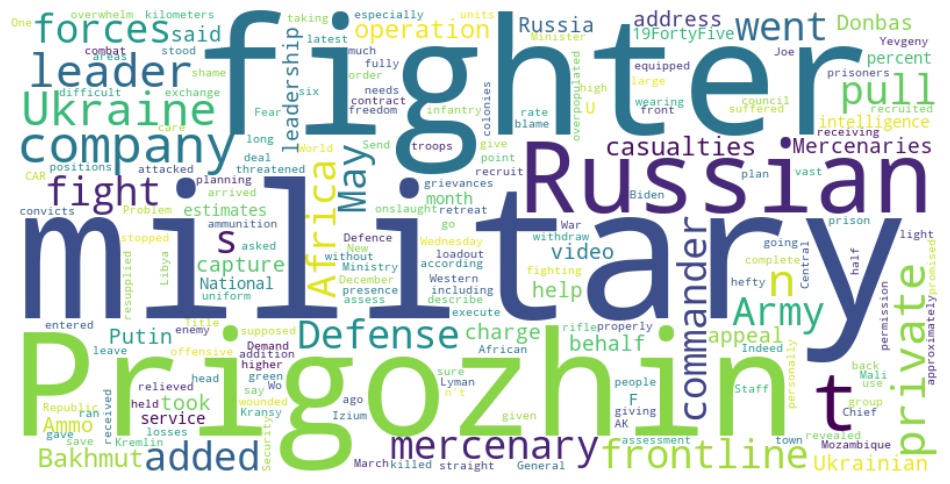

In [26]:
# Convert list of words to individual strings
text = " ".join([token.text for token in docu if token.text not in ['Wagner', 'Group']]) # For the whole document

# Generate a word cloud from text
word_cloud = WordCloud(width = 800, height = 400, background_color = 'white', collocations = False).generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Additionally, word clouds can be customized to filter out certain words or to emphasize specific words or phrases, making them a versatile tool for text analysis. 

We can choose to focus on only verbs, adverbs, nouns, adjectives and proper nouns in the text document by using the code below and changing the `i.pos_` parameter.

In [23]:
words = [token.text for token in docu if token.pos_=='NOUN'] # Change to VERB, ADV, NOUN, ADJ, PROPN 

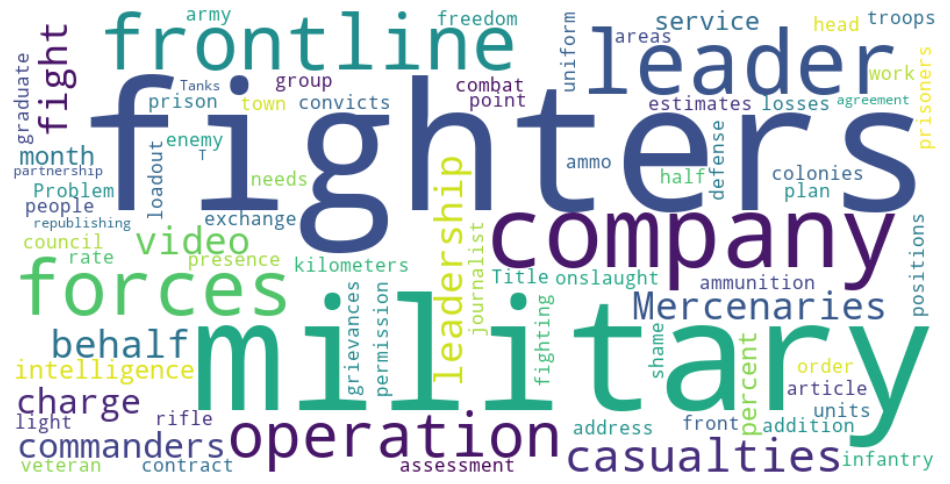

In [24]:
text = " ".join(words)

# Generate a word cloud for the specific part of speech
word_cloud = WordCloud(width=800, height=400, background_color='white', collocations = True).generate(text)

# Plot the word cloud
plt.figure(figsize = (12, 10))
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')

# Save the word cloud image before viewing it 
plt.savefig('WordCloud.png')
plt.show()

### 10. Other Resources

One word that stood out from the nouns word cloud was casualties. Further exploring led to a table on Wikipedia providing casualty data extracted from news articles. By utilizing web scraping with the specific class `wikitable sortable`, the information was extracted to create a map.

Additional rows were added on from other articles found on the webpage, theese are stored to the `from_wikipedia` variable.

In [25]:
wikiurl = "https://en.wikipedia.org/wiki/Wagner_Group#Casualties"
response = requests.get(wikiurl)

soup = BeautifulSoup(response.text, 'html.parser')
casualties_table = soup.find('table',{'class':"wikitable sortable"})

df = pd.read_html(str(casualties_table))

df = pd.DataFrame(df[0])

# Use regex to remove the reference numbers in brackets from the data
df["Wagner casualties"] = df["Wagner casualties"].apply(lambda x: re.sub(r"\[\d+\]", "", x))

possible_country = ["Ukraine", "Syria", "Syria", "Syria", "Central African Republic", "Sudan", "Mozambique", "Libya", "Mali", "Ukraine" ]
df.insert (0, "Country", possible_country)

from_wikipedia = pd.DataFrame({'Country':['Ukraine', 'Madagascar','Venezuela', 'Mozambique','Burkina Faso'],
                  'Conflict': ['Russia 2014 annexation of the peninsula', np.nan, 'Presidential Crisis', np.nan,'Jihadist insurgency resulting in a coup'],
                  'Period': ['February 2014','April 2018', 'May 2018 - January 2019', 'August 2019' ,'September 2022'],
                  'Wagner casualties':['Almost bloodless', np.nan, np.nan, '50-65 killed', np.nan ],
                  'Notes':['The Wagner PMCs were first active in Crimea. The takeover was reported to be almost bloodless. The PMCs, along with the regular soldiers, were called "polite people" at the time[204] due to their well-mannered behavior. They kept to themselves, carried weapons that were not loaded, and mostly made no effort to interfere with civilian life.[205] Another name for them was "little green men" since they were masked, wearing unmarked green army uniforms and their origin was initially unknown.[206]',
                           'The independent media group the Project reported that Wagner PMCs arrived in Madagascar in April 2018, to guard political consultants that were hired by Yevgeny Prigozhin to accompany the presidential campaign of then-president Hery Rajaonarimampianina for the upcoming elections.',
                          'An anonymous Russian source close to the Wagner Group stated that another group of PMCs had already arrived in advance of the May 2018 presidential election.[40][312] Before the 2019 flare-up of protests, the PMCs were in Venezuela to mostly provide security for Russian business interests like the Russian energy company Rosneft. They assisted in the training of the Venezuelan National Militia and the pro-Maduro Colectivos paramilitaries in 2018.[41] Russian ambassador to Venezuela, Vladimir Zayemsky denied the report of the existence of Wagner in Venezuela.[313]',
                          'Starting on 5 October, the Mozambique military conducted several successful operations, in collaboration with the PMCs, against the insurgents[42] along the border with Tanzania.[317] At the start of the operations, a PMC unit commander with the call sign "Granit" was killed and two other PMCs were wounded when their unit was ambushed by a force of 60 insurgents.[95]',
                          'The Government of Ghana publicly alleged that Traoré began collaborating with the Wagner Group following the coup, enlisting the mercenaries against the jihadist rebels.[376] According to Ghanaian President, the ruling junta allocated a mine to the Wagner Group as a form of payment for its deployment,[377] which was denied by Burkina Faso mines minister.[378]']})

It is worth noting that the country names in the original file did not appear on the map. However, this problem was resolved by using the ISO code data provided by Plotly.

In [26]:
df = pd.concat([df,from_wikipedia], ignore_index = True)

# Get ISO codes from plotly data file
iso_codes = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv")

# Merge the ISO code data table with the casualties data
merged = pd.merge(df, iso_codes, left_on = "Country", right_on = "COUNTRY", how = "left")

# Create a map
fig = px.choropleth(merged, 
                    locations = "CODE",
                    hover_data = ["Period", "Wagner casualties"],
                    featureidkey = "properties.iso_a3")

fig.update_layout(title_text = "Wagner Group presence and casualties by country", title_x = 0.5)
fig.show()

### 11. Conclusion

Collecting data on the Wagner Group has been a challenging task due to the lack of reliable and accurate sources. There are multiple sources available, but the accuracy of the information can be questionable, which makes it difficult to obtain precise data. 


Therefore, it should be noted that the information presented on the map regarding Wagner Group casualties is not up to date and should be considered as a reference only. It however shows that the Wganer Group has a growing presence in Africa.

### 12. References

 [1]	Analytics Vidhya. (2021, May 5). How to Build Word Cloud in Python? Retrieved May 5, 2023, from https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/

 [2]	Analytics Vidhya. (2021, November 1). Web Scraping a News Article and Performing Sentiment Analysis using NLP. Retrieved May 5, 2023, from https://www.analyticsvidhya.com/blog/2021/11/web-scraping-a-news-article-and-performing-sentiment-analysis-using-nlp/

 [3]	spaCy 101: Everything you need to know. Retrieved April 20, 2023, from https://spacy.io/usage/spacy-101

 [4]	Medium. (2020, July 3). Generate Meaningful Word Clouds in Python. Retrieved May 5 2023, from https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb

 [5]	Microsoft. Bing News Search API overview. Retrieved April 3, 2023, from https://learn.microsoft.com/en-us/bing/search-apis/bing-news-search/overview

 [6]	OpenAI Chat. Retrieved March 18, 2023, from https://chat.openai.com/

 [7]	Python Tutorial. Python write to Text File. Retrieved April 25, 2023, from https://www.pythontutorial.net/python-basics/python-write-text-file/

 [8]	Real Python. Python Counter. Retrieved May 2, 2023, from https://realpython.com/python-counter/

 [9]	Stack Overflow. (2015, August 12). How to embed image or picture in Jupyter Notebook either from a local machine or from a web resource? Retrieved May 7, 2023, from https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o

 [10]	Stack Overflow. (2020, May 27). Plotly list of valid country names from ISO 3 code. Retrieved May 7, 2023, from https://stackoverflow.com/questions/62566605/plotly-list-of-valid-country-names-from-iso-3-code

 [11]	Wikipedia. (2023, April 14). Wagner Group. Retrieved April 2, 2023, from https://en.wikipedia.org/wiki/Wagner_Group
